In [1]:
from dash import dcc, html, Output, Input
from jupyter_dash import JupyterDash
import plotly.express as px
import base64, pandas as pd
from datetime import date
import plotly.io as pio
import numpy as np
import os, sys
import matplotlib.pyplot as plt


pio.renderers.default = 'notebook_connected'
# config the directory path
sys.path.insert(0,os.path.realpath(os.path.pardir))
from utils.tools import image
from utils.config import cfg

c:\Users\nine_\anaconda3\envs\torch_cuda\lib\site-packages\tqdm\auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [62]:
# read the data that matches the specified DateTime to the location of the image
df = pd.read_pickle(cfg.ONM_PD.FOLDER_ALL).drop(['RADAR_RGB_PNG_PATH', 'RADAR_dBZ_PNG_PATH', 'RADAR_MASK_PATH'], axis=1)
df.reset_index(inplace=True)
df['DateTime'] = df['DateTime'].apply(lambda x: x.strftime("%Y-%m-%d, %H:%M:%S"))
df.head()

DateTime    FileName
0  2020-06-18, 06:30:00  1592461954
1  2020-06-18, 06:35:00  1592462136
2  2020-06-18, 06:45:00  1592462768
3  2020-06-18, 06:50:00  1592463068
4  2020-06-18, 06:55:00  1592463277

## Dashboard

In [3]:
# extract the DateTime column
DateTime = df['DateTime']
DateTime.head(3)

0    2020-06-18 06:30:00
1    2020-06-18 06:35:00
2    2020-06-18 06:45:00
Name: DateTime, dtype: object

In [4]:
# extract the Date
Date = DateTime.str.split(' ').str[0].unique()

min_date_allowed = [int(i) for i in Date[0].split('-')]
max_date_allowed = [int(j) for j in Date[-1].split('-')]

In [5]:
# extract the timestamp and create a dictionary
Time = {}
for d in Date:
    Time[d] = DateTime[DateTime.str.contains(d)].str.split(' ').str[1]

In [6]:
# Dash section
app = JupyterDash(__name__)

app.layout = html.Div([
    dcc.Store(id='date-store', ),
    html.Div([
        html.Div([
            html.H1('Data Science Project 2 (2021/2):  Nowcasting', className='bg-primary full-size text-white', style={'padding': '5px'}),

            html.Div([
            
                    html.P('Date: ', className='text-base text-white'),
                    dcc.DatePickerSingle(
                        id='date-picker',
                        min_date_allowed=date(min_date_allowed[0], min_date_allowed[1], min_date_allowed[2]),
                        max_date_allowed=date(max_date_allowed[0], max_date_allowed[1], max_date_allowed[2]),
                        initial_visible_month=date(min_date_allowed[0], min_date_allowed[1], min_date_allowed[2]),
                        date=date(min_date_allowed[0], min_date_allowed[1], min_date_allowed[2]),
                        className='DateInput_1'
                    ),  
                    html.P('Time: ', className="text-base text-white"),
                    dcc.Dropdown(id='time-dropdown', className='dropdown-list')

            ], style={'gap': '20px', 'align-items': 'center'},
                className='bg-primary flex-center'),

            ], 
        style={'display': 'flex', 'flexDirection': 'column'},
        className='col-span-3'),

        html.Div([

            html.Div([
                html.Img(id='image', className='img-width-height'),
                html.P('TARGET', className='text-center text-base full-size bg-primary text-white')
                ], className='flex-center',
                    style={'flexDirection': 'column'}),
            html.Div([
                html.Img(id='image-2', className='img-width-height'),
                html.P('MODEL 1', className='text-center text-base full-size bg-primary text-white')
                ], className='flex-center',
                    style={'flexDirection': 'column'}),
            html.Div([
                html.Img(id='image-3', className='img-width-height'),
                html.P('MODEL 2', className='text-center text-base full-size bg-primary text-white')
                ], className='flex-center',
                    style={'flexDirection': 'column'}),

        ], className="col-span-3 flex-around"),

    ], className='container font-mono'),
])

@app.callback(
    Output('time-dropdown', 'options'),
    Output('time-dropdown', 'value'),
    Output('date-store', 'data'),
    Input('date-picker', 'date')
)
def updateTimeDropdown(date):
    date = str(date)
    return ([{'label': i, 'value': i} for i in Time[date]], Time[date].iloc[0], date)

@app.callback(
    Output('image', 'src'),
    Output('image-2', 'src'),
    Output('image-3', 'src'),
    Input('date-picker', 'date'),
    Input('time-dropdown', 'value'),
)
def updateImg(date, time):
    result = df.loc[df['DateTime'] == f'{date} {time}', ['FolderPath', 'FileName']]
    path = '../' + result.iloc[0,0] + result.iloc[0,1]
    encoded_image = base64.b64encode(open(path, 'rb').read())
    ret = 'data:image/png;base64,{}'.format(encoded_image.decode())
    return (ret, ret, ret)

if __name__ == '__main__':
    app.run_server(mode='inline')

## Animation frame

In [85]:
# Dataloader class used to load images
class Dataloader():
    def __init__(self, pd_path, folder_path):
        self.data = None
        self.df = pd_path.copy()
        self.folder_path = folder_path #specify the directory of the images
    
    def _load(self, img_num, greyscale=True):
        self.df['img_path'] = self.folder_path + self.df['FileName'] + ".png"
        self.data = image.quick_read_frames(path_list=self.df['img_path'].tolist()[:img_num], grayscale=greyscale)  

In [98]:
desired_date = '2020-06-30'  # yyyy-mm-dd
folder_path = '../data/bkk_radar_images_dBZ/bkk_radar_images_dBZ_1/'
mask = df[df['DateTime'].str.contains(desired_date)]

dataloader = Dataloader(mask, folder_path)
dataloader._load(25)

In [99]:
desired_date = '2020-06-18'  # yyyy-mm-dd
folder_path = '../data/bkk_radar_images_dBZ/bkk_radar_images_dBZ_1/'
mask = df[df['DateTime'].str.contains(desired_date)]

dataloader2 = Dataloader(mask, folder_path)
dataloader2._load(25)

In [100]:
desired_date = '2020-06-25'  # yyyy-mm-dd
folder_path = '../data/bkk_radar_images_dBZ/bkk_radar_images_dBZ_1/'
mask = df[df['DateTime'].str.contains(desired_date)]

dataloader3 = Dataloader(mask, folder_path)
dataloader3._load(25)

In [101]:
# rehape the loaded data
data = dataloader.data
data = data.transpose(0, 2, 3, 1)[:,:,:,0]

data2 = dataloader2.data
data2 = data2.transpose(0, 2, 3, 1)[:,:,:,0]

data3 = dataloader3.data
data3 = data3.transpose(0, 2, 3, 1)[:,:,:,0]

print(data.shape, data2.shape, data3.shape)

(25, 2034, 2048) (25, 2034, 2048) (25, 2034, 2048)



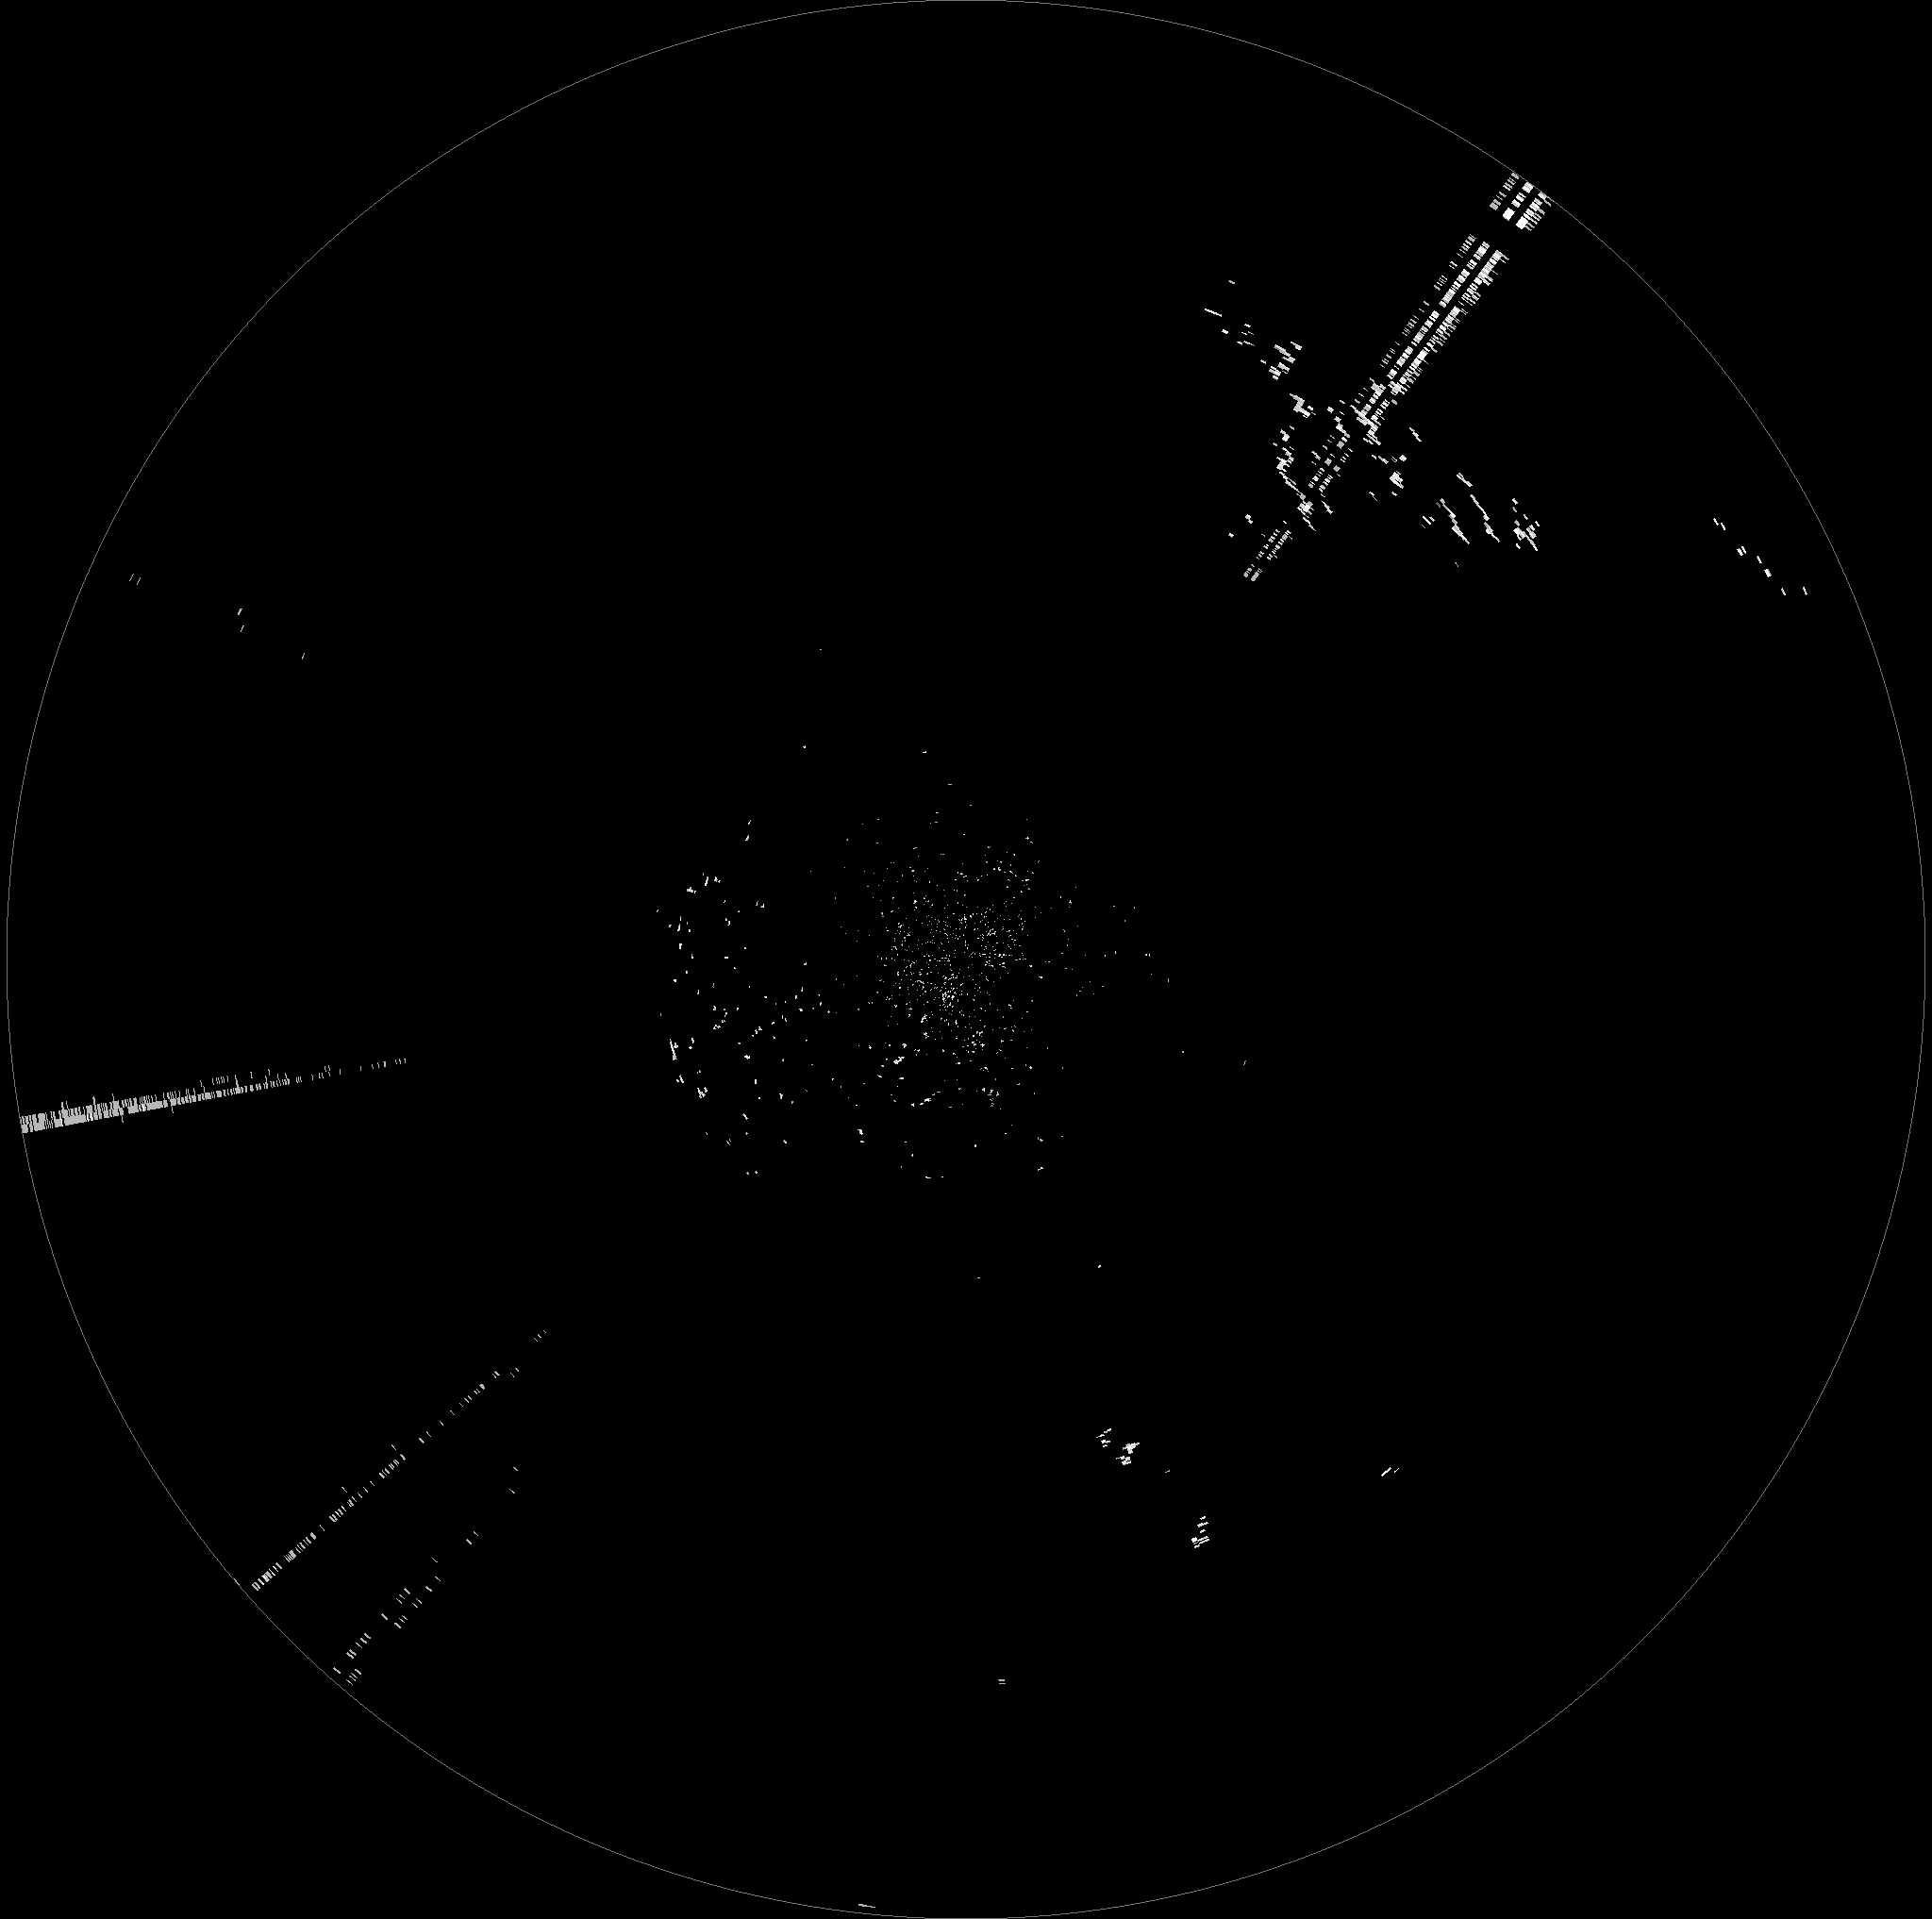
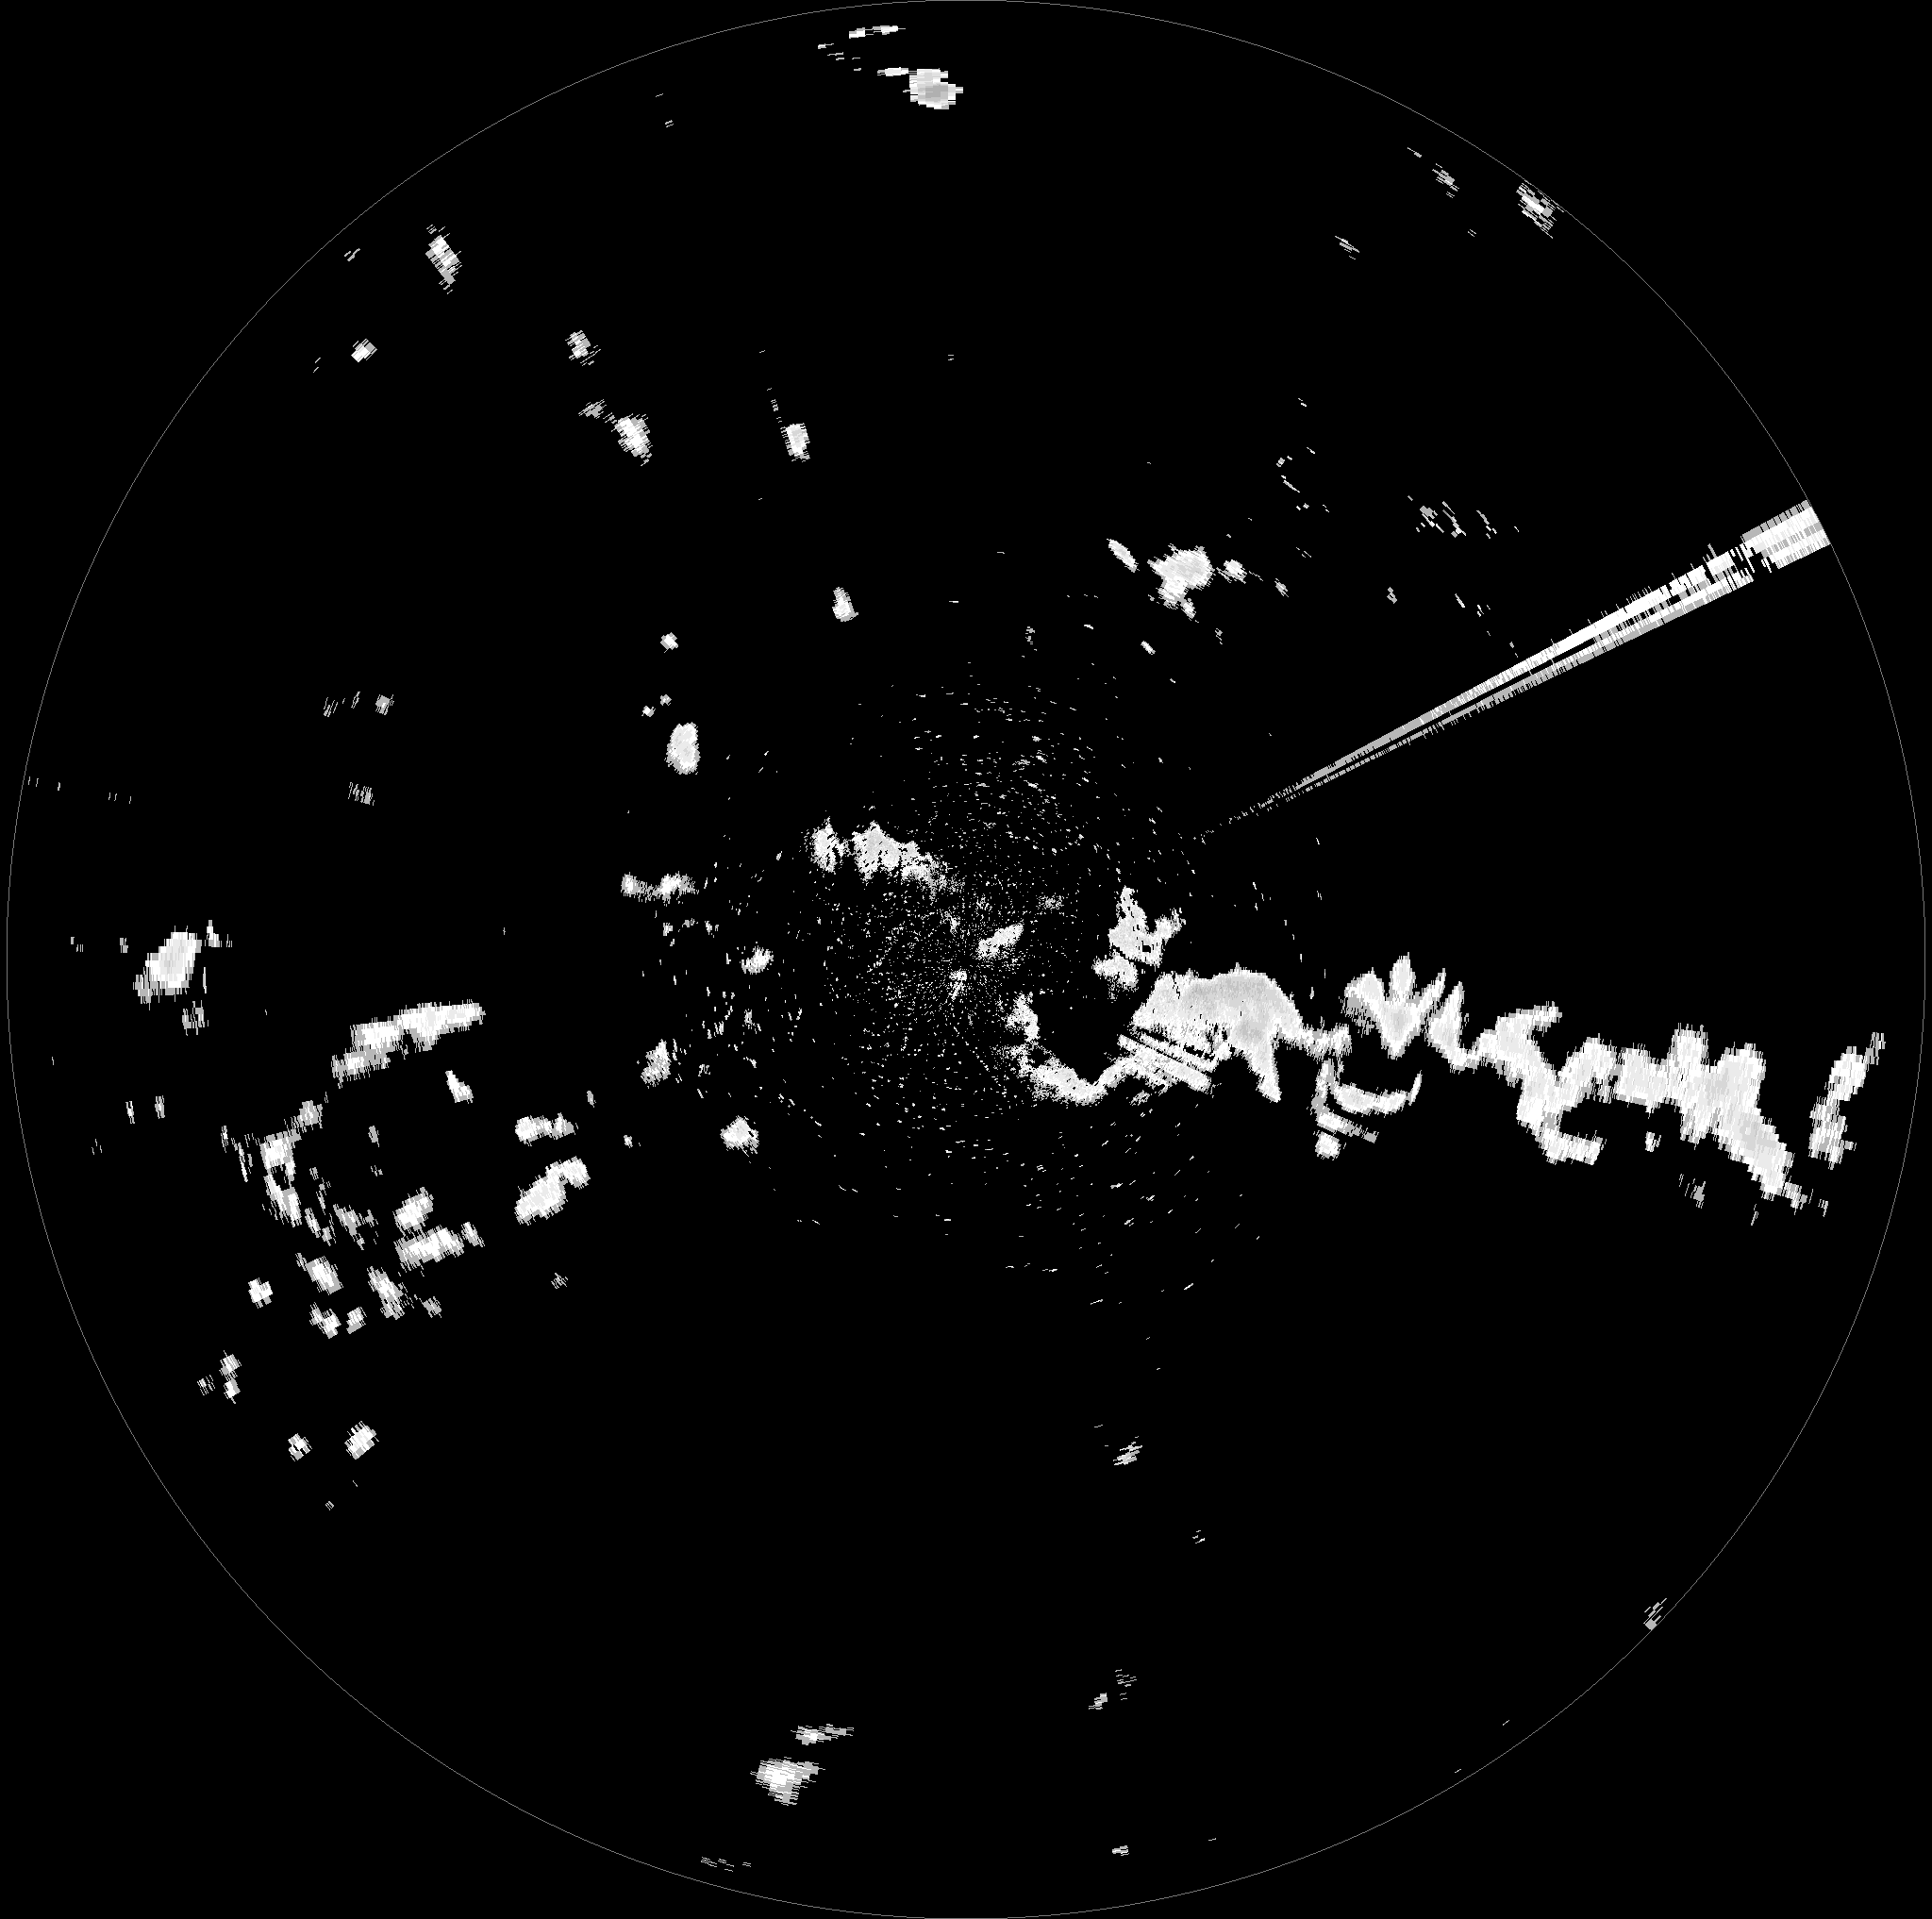
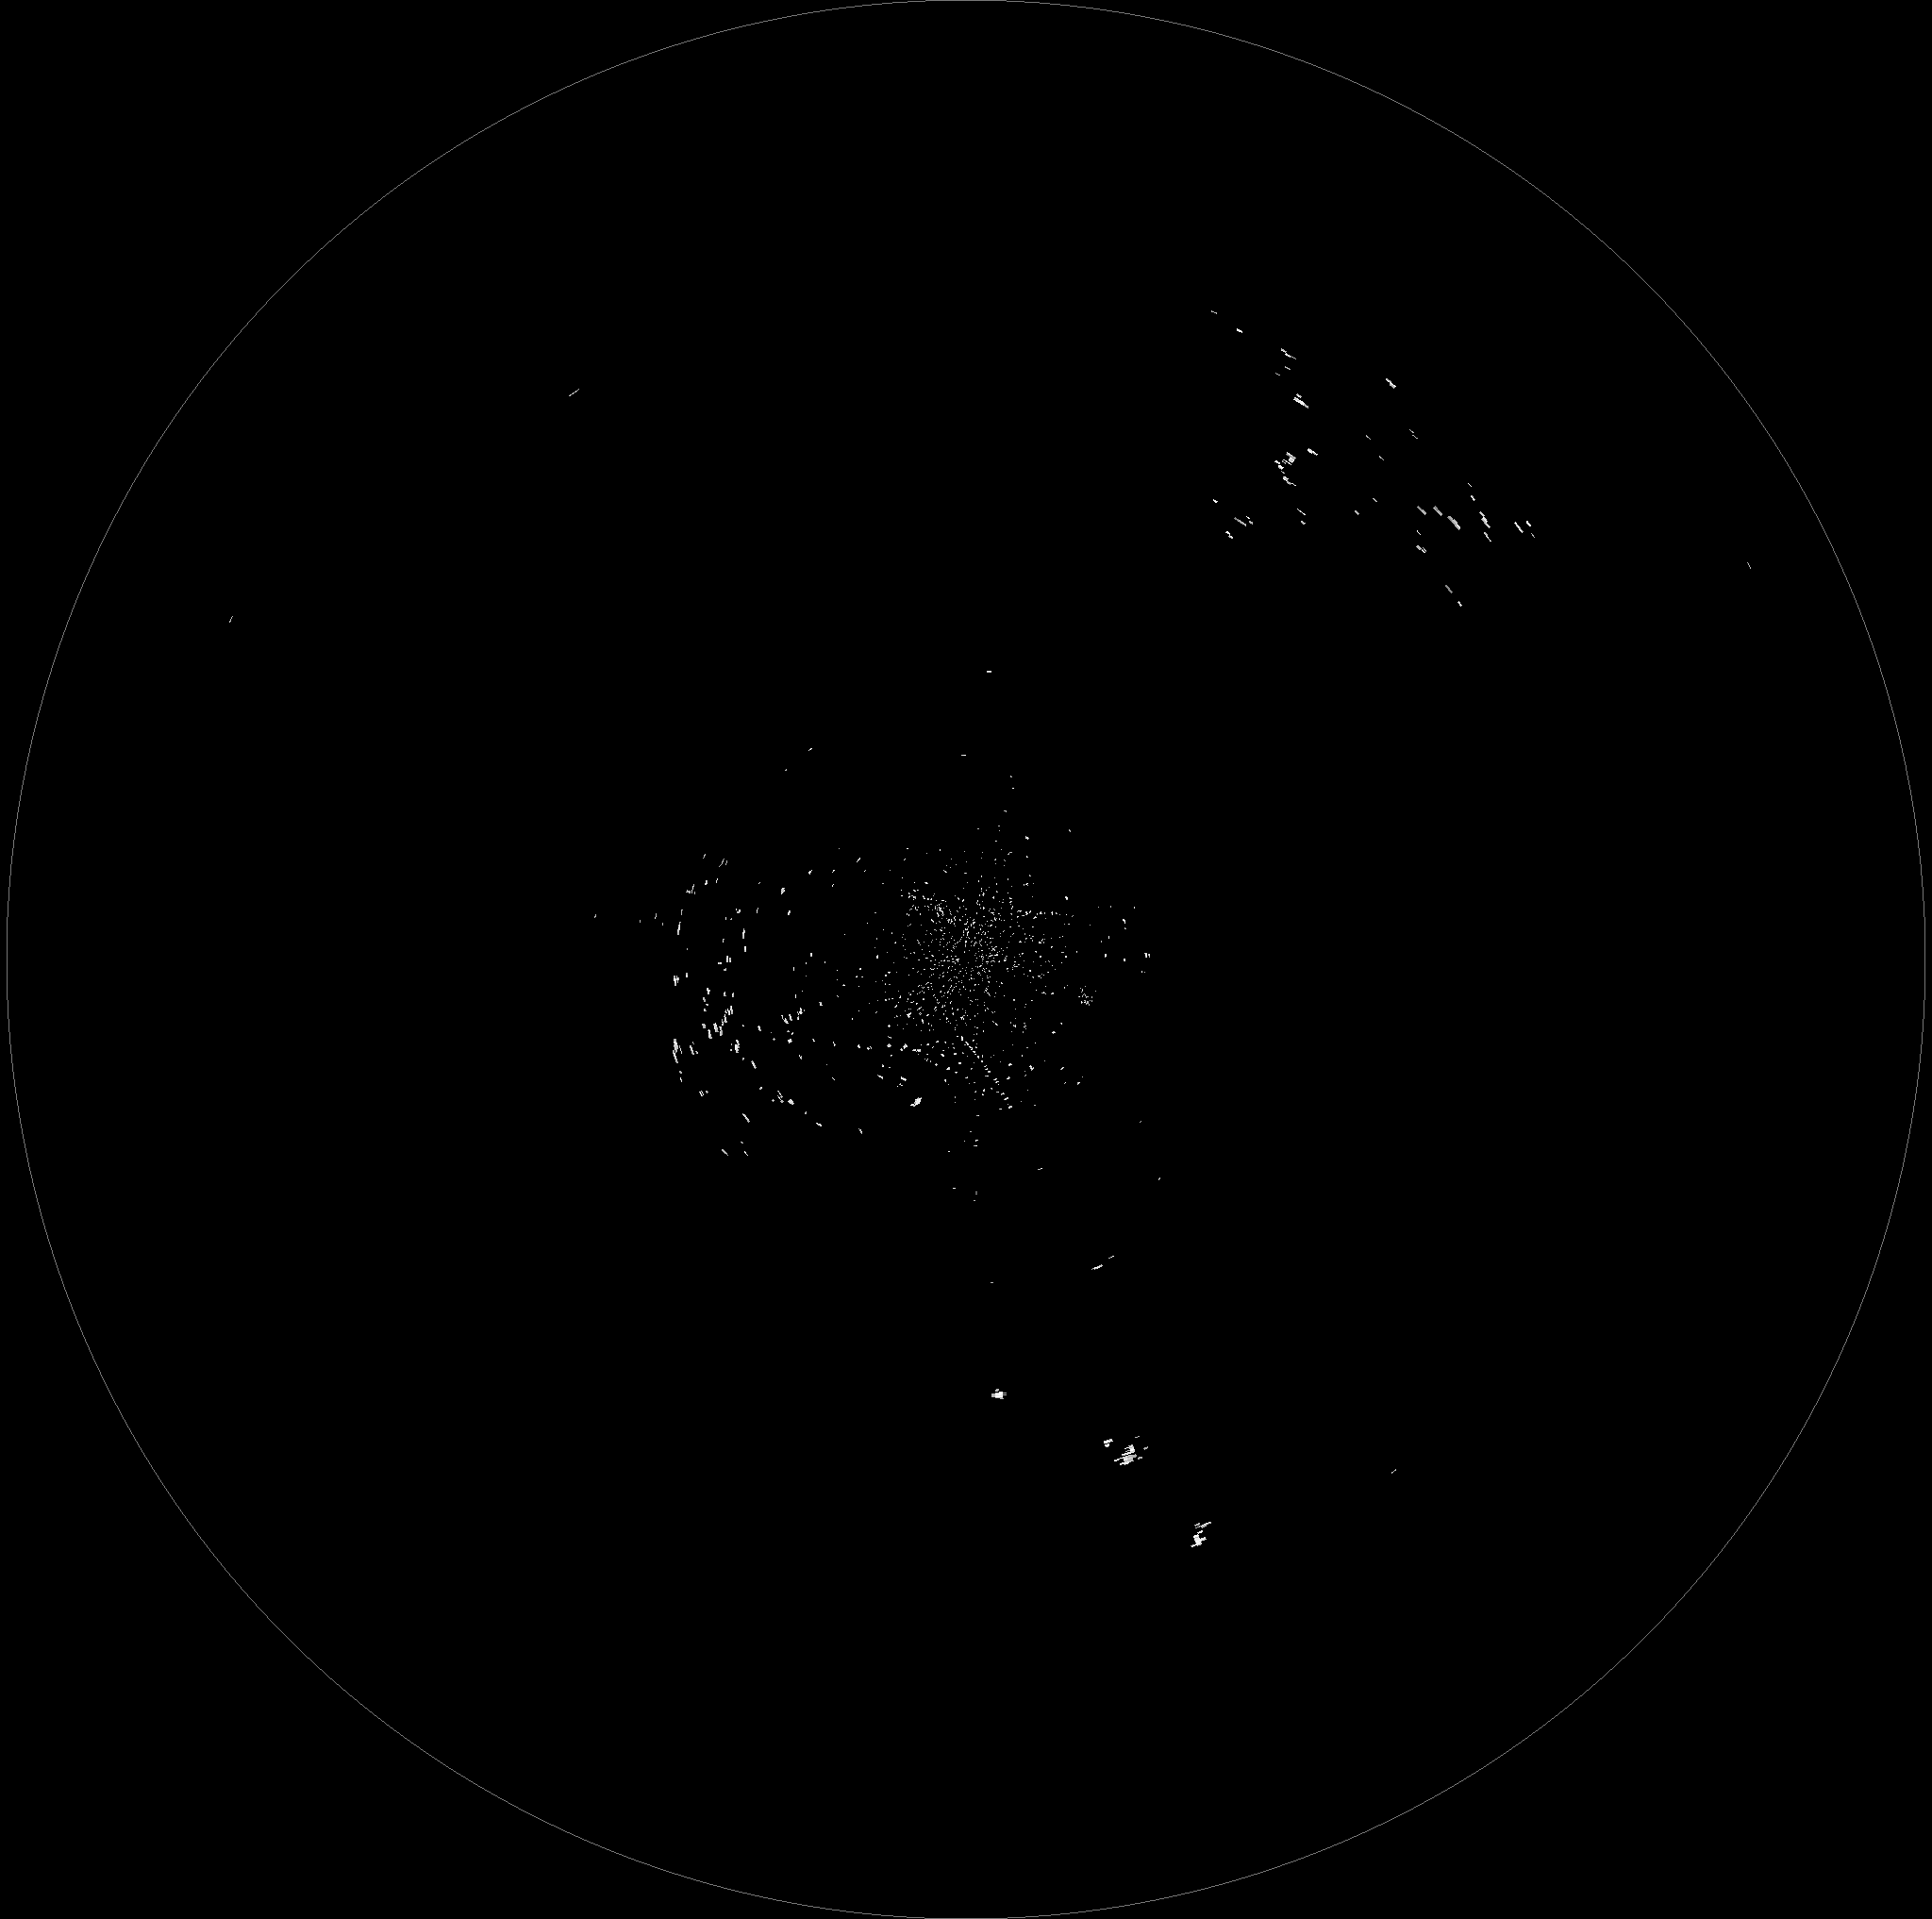
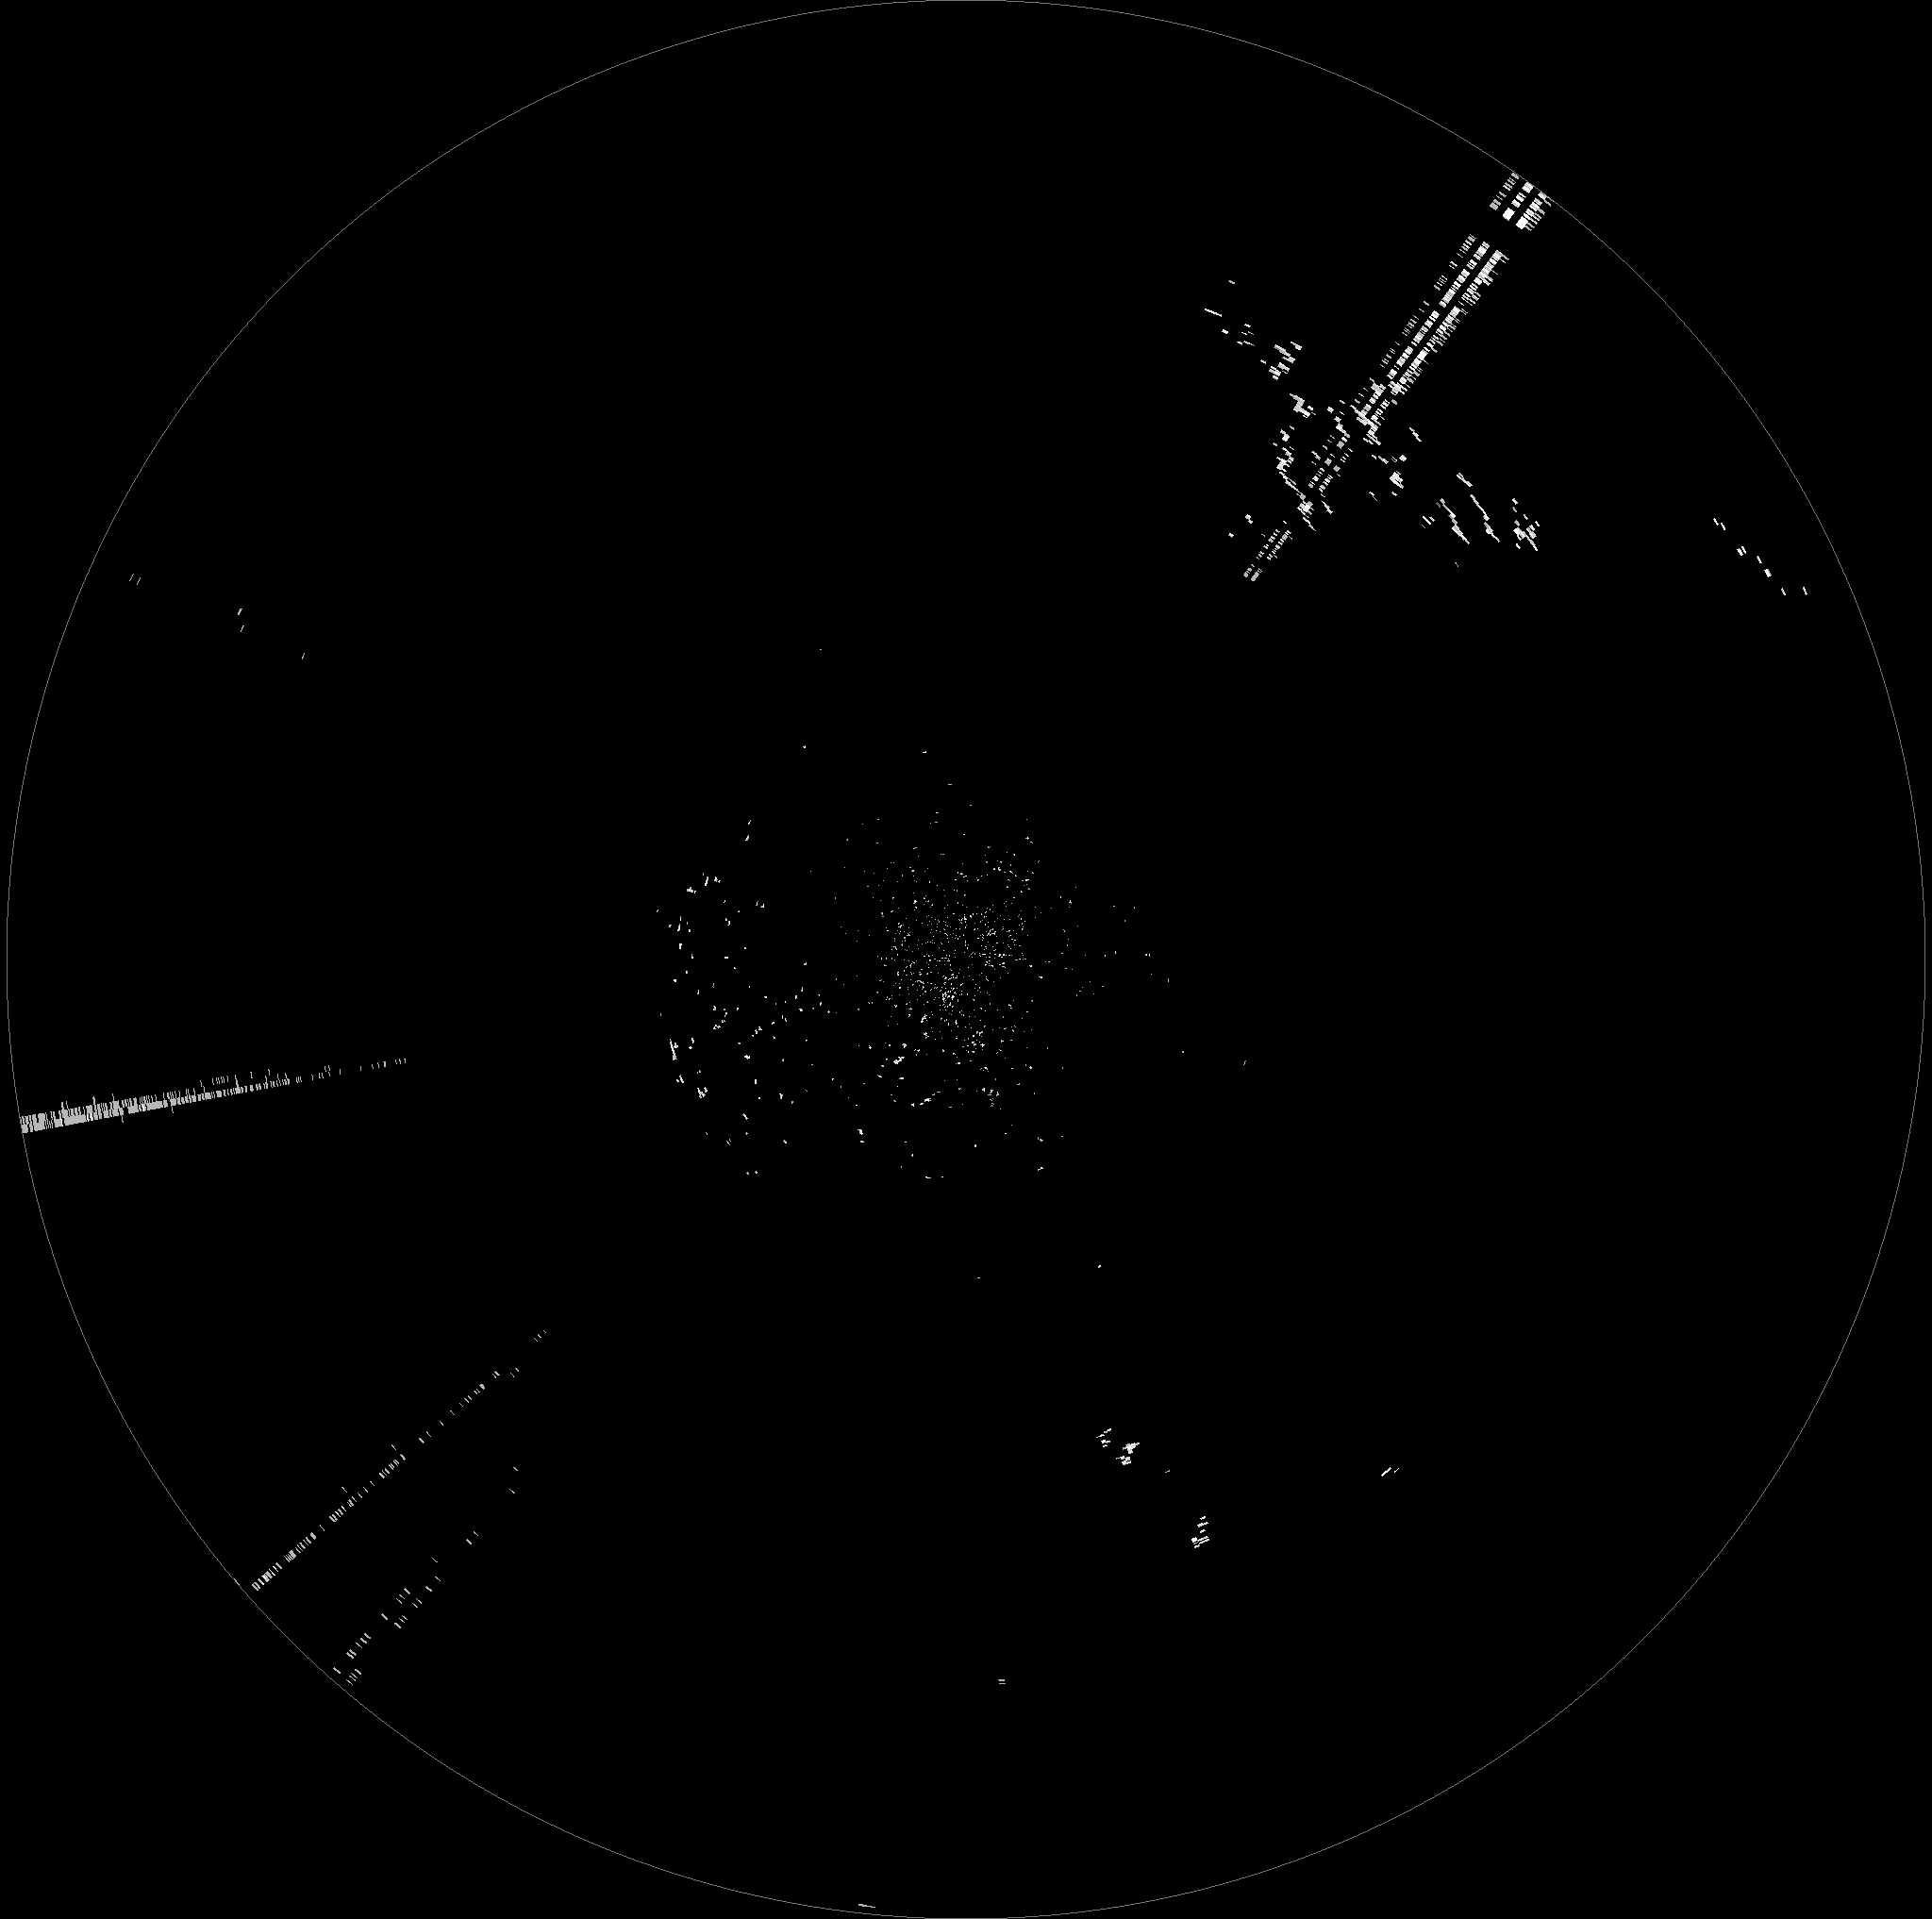
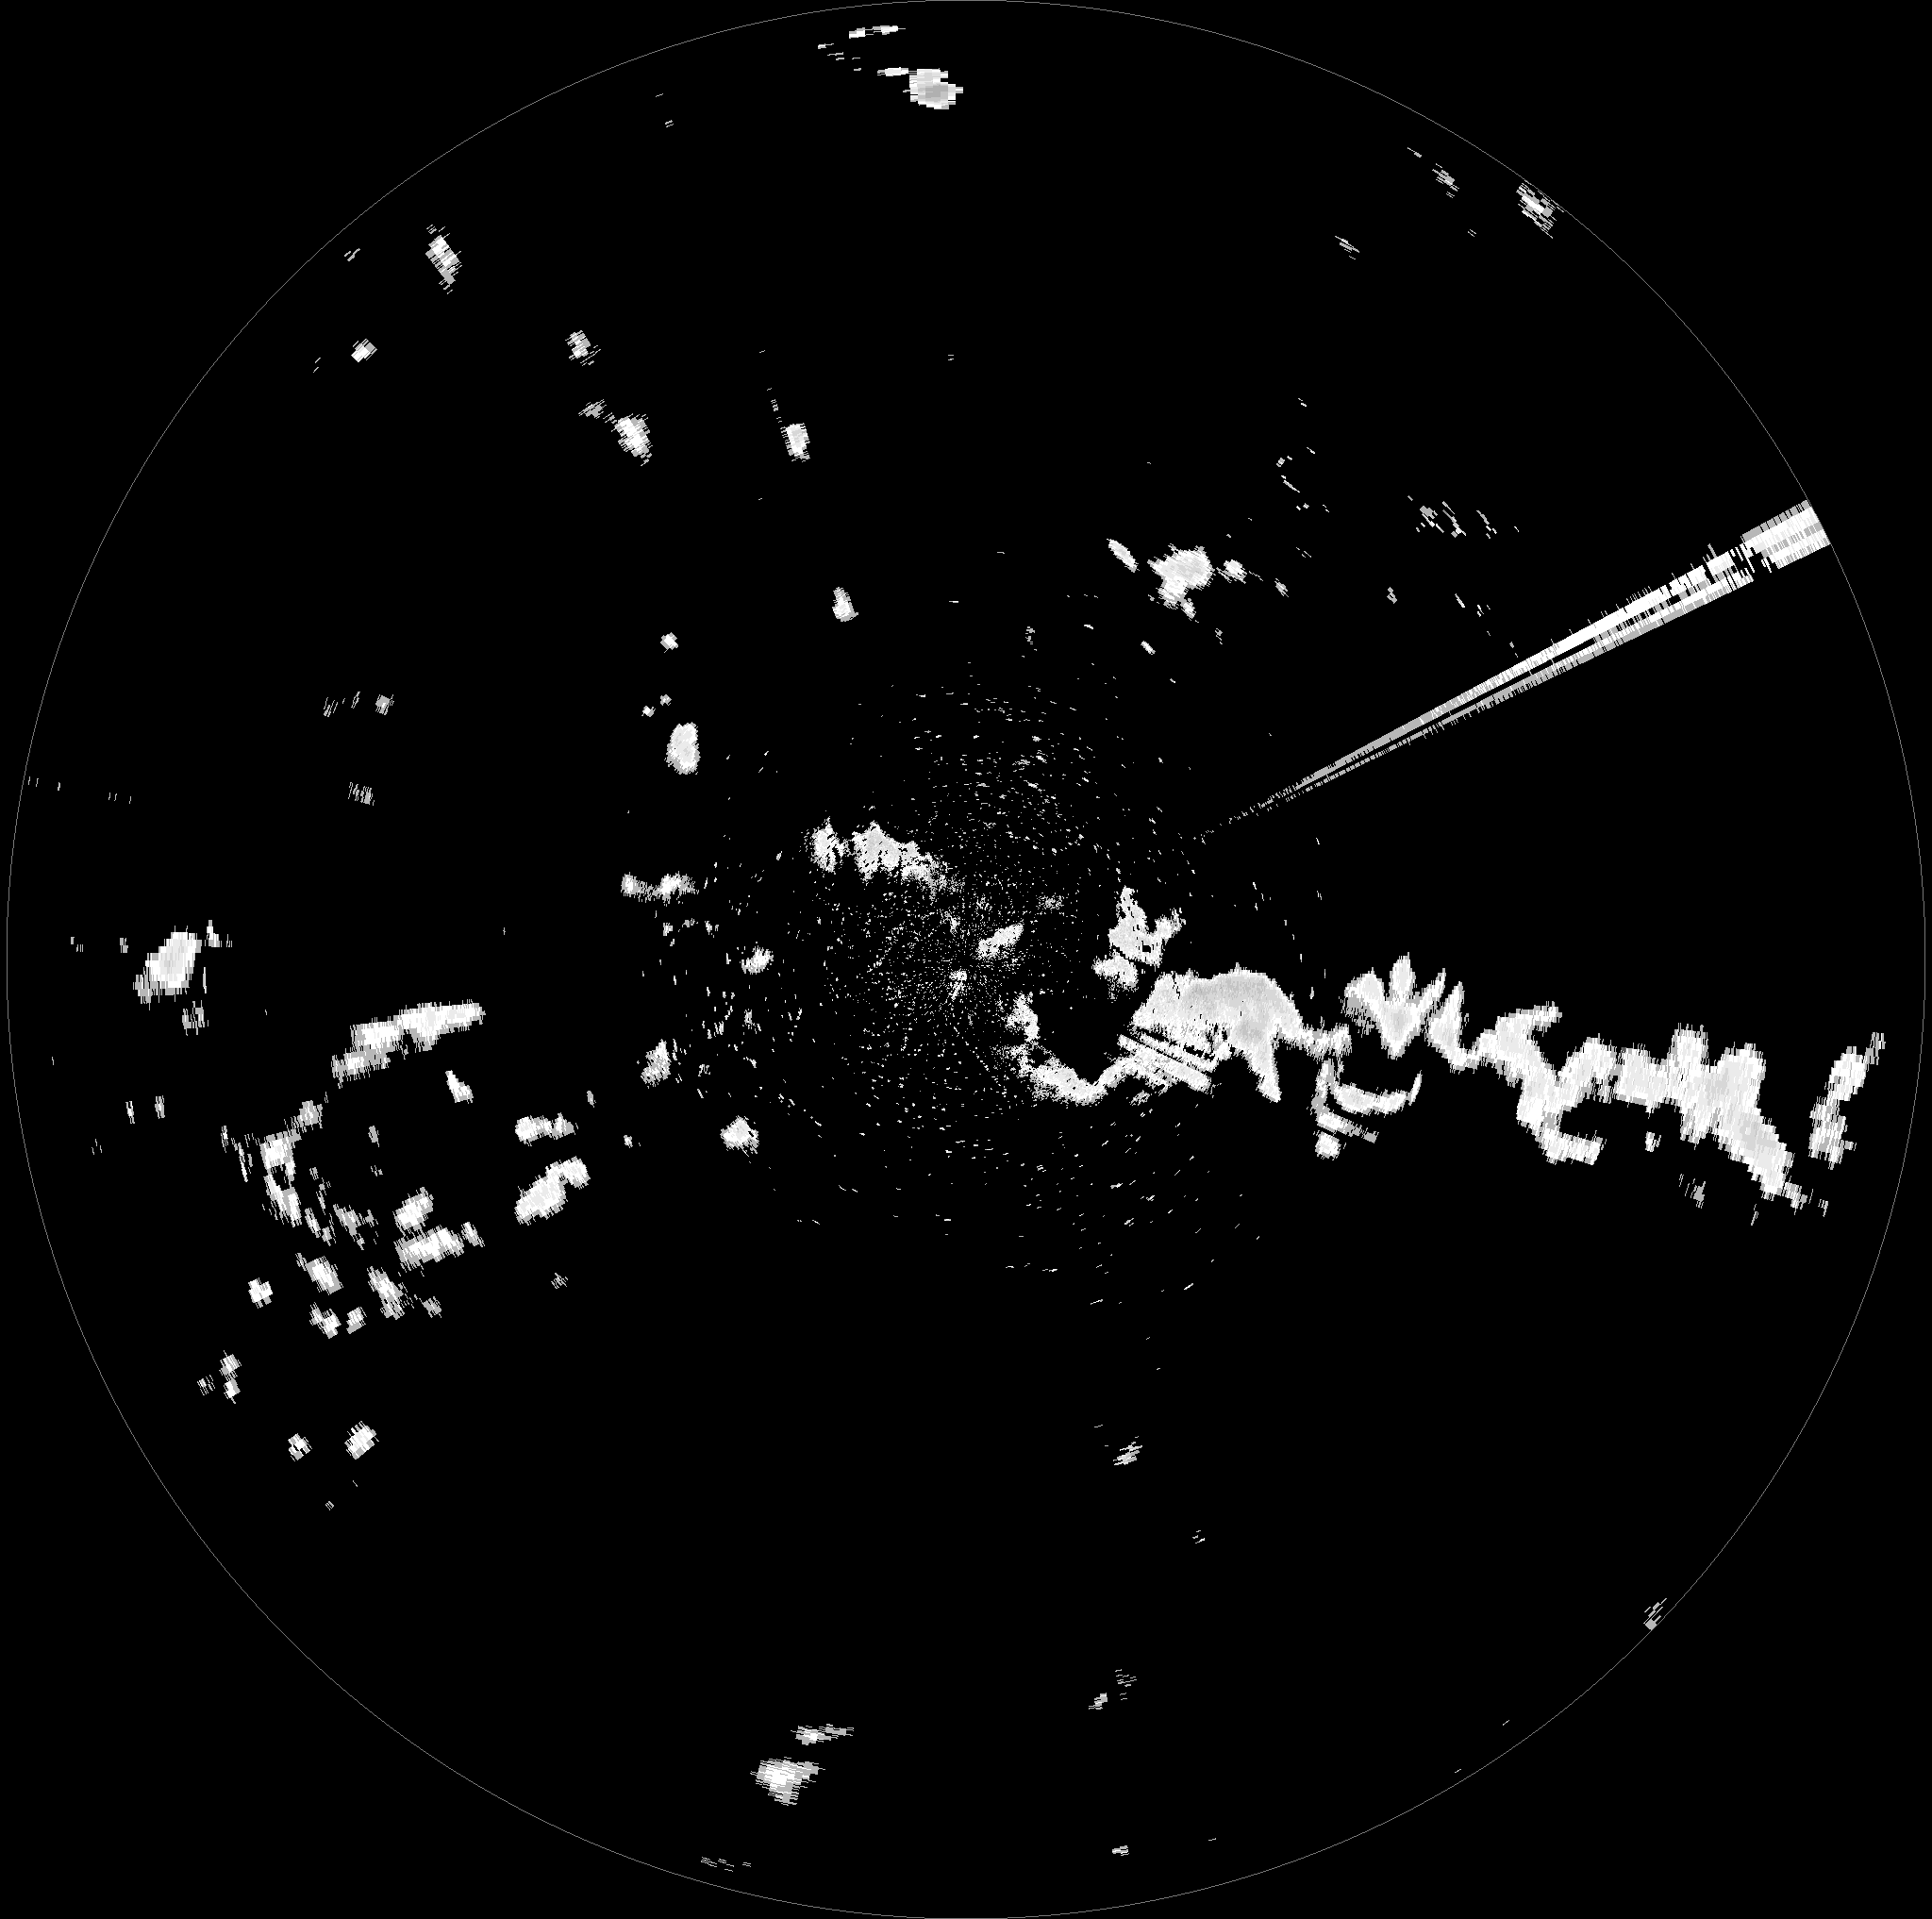
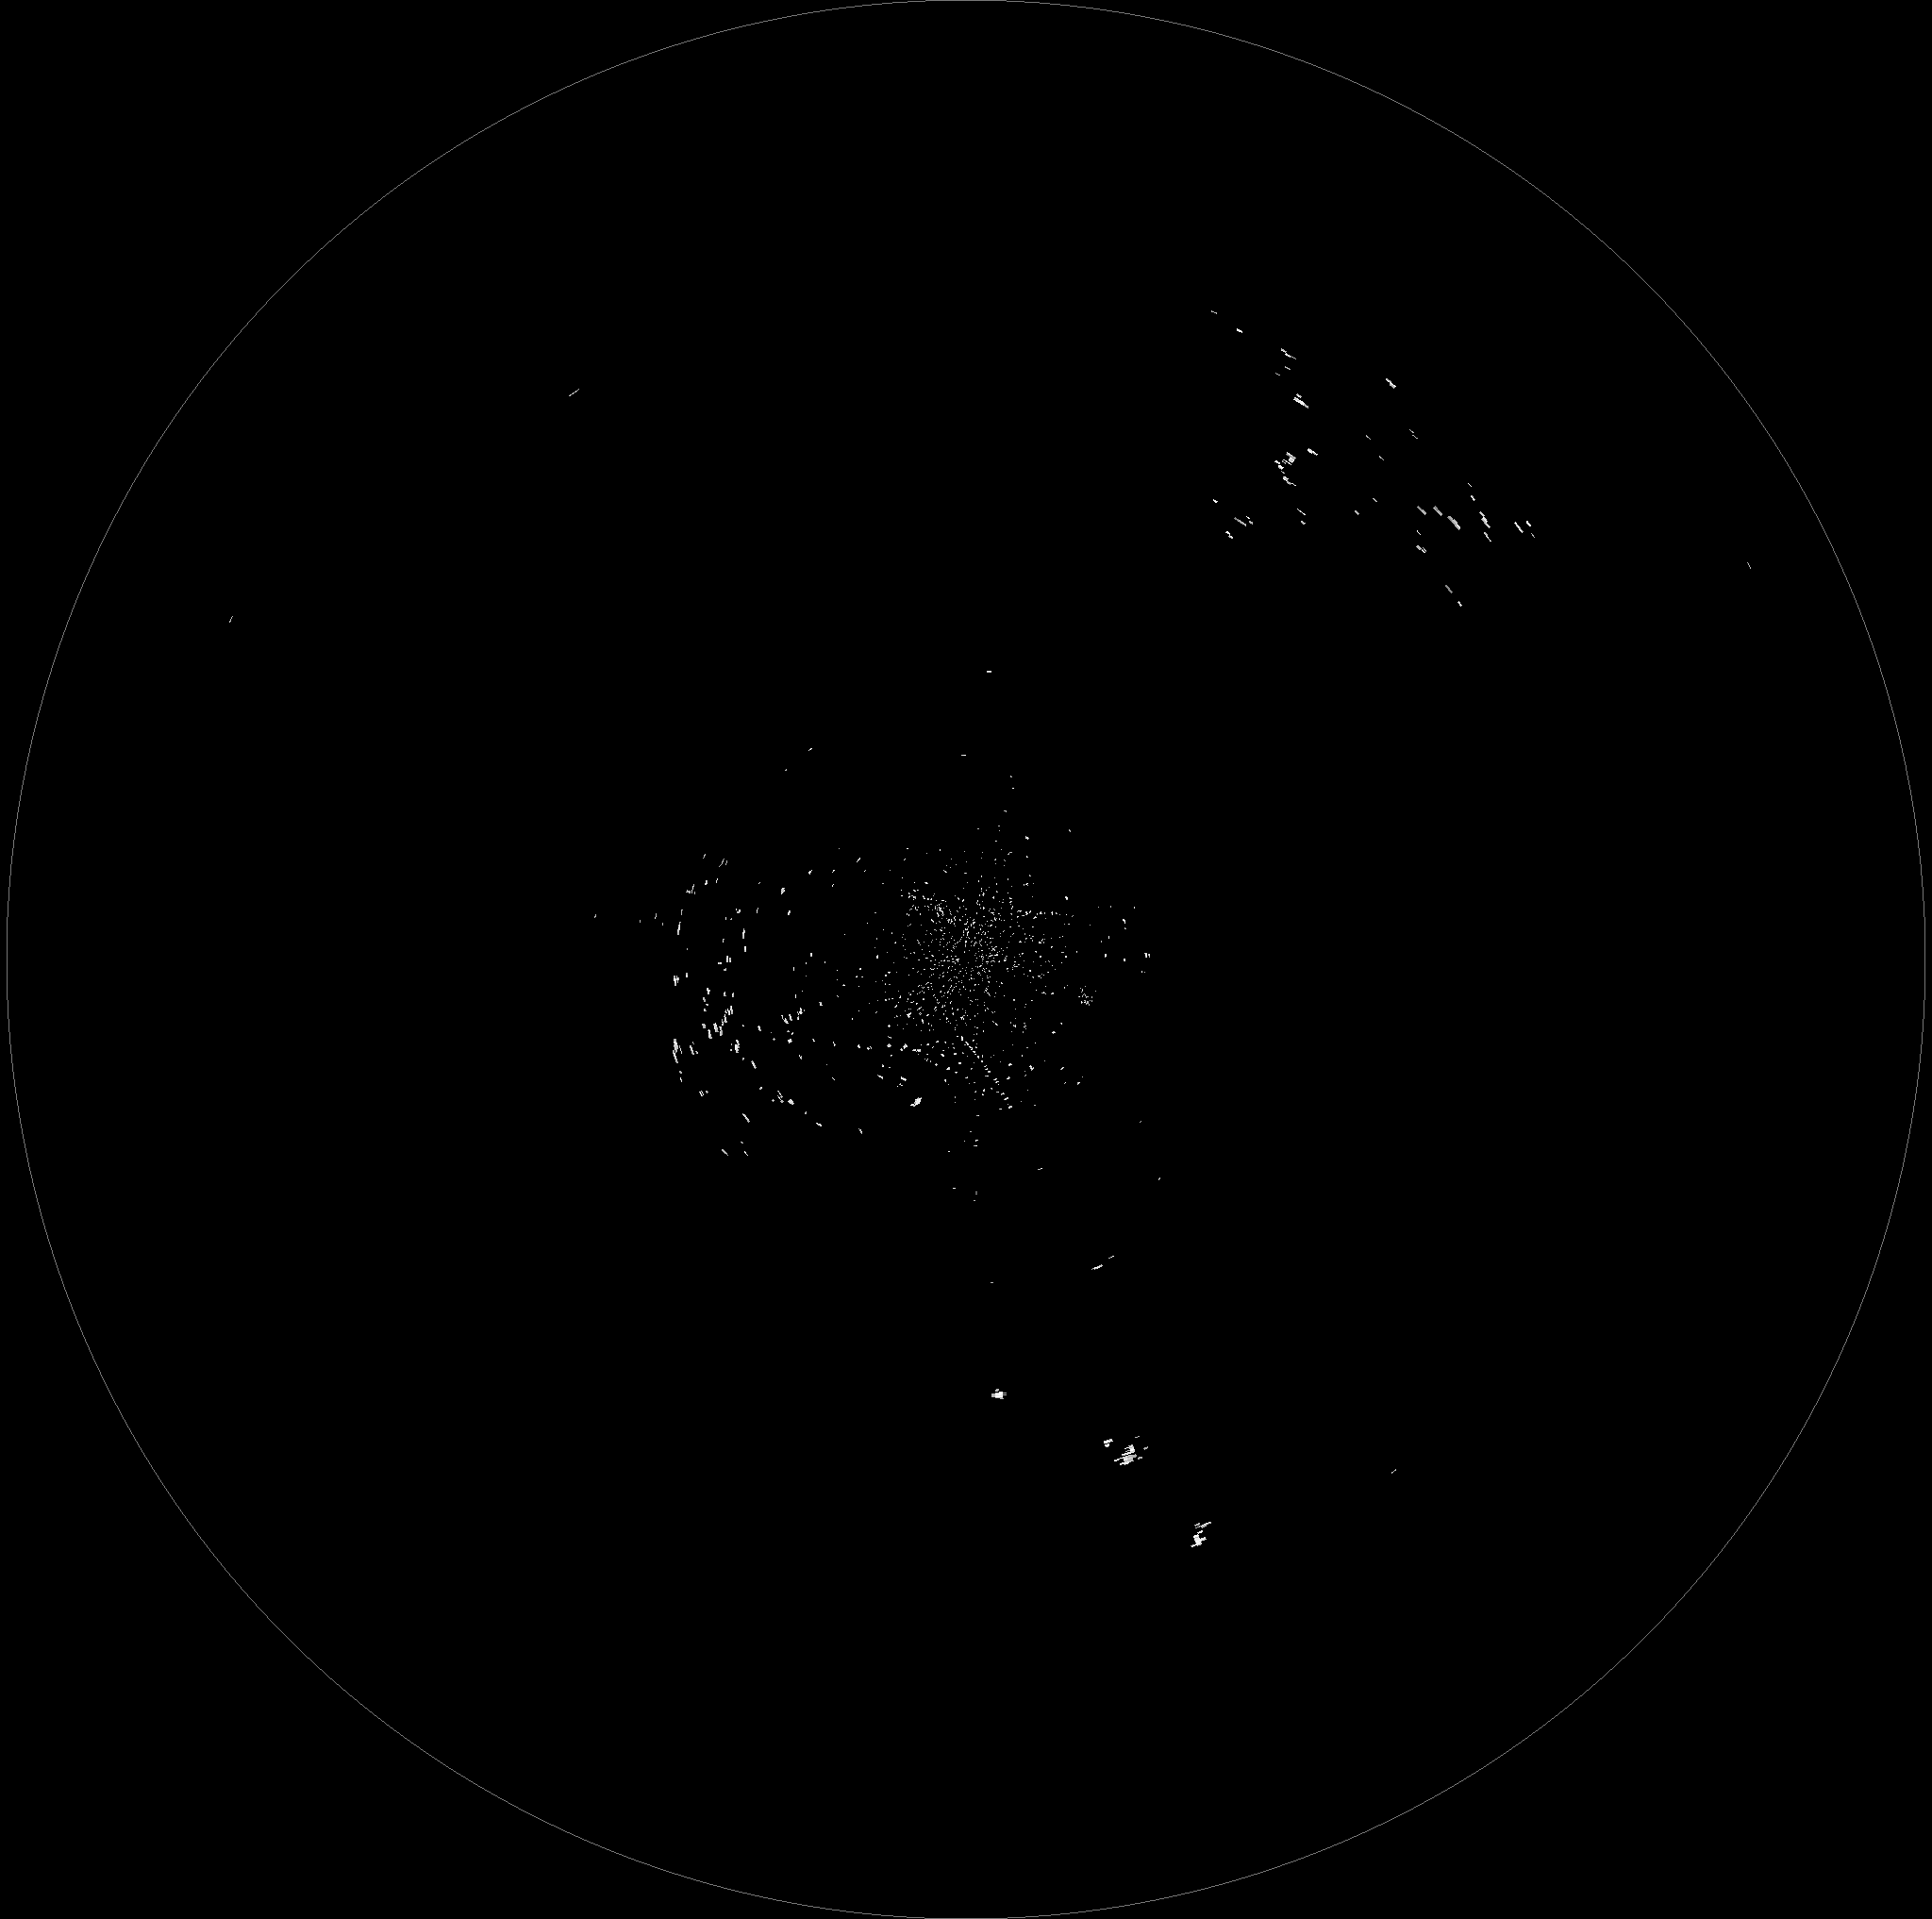
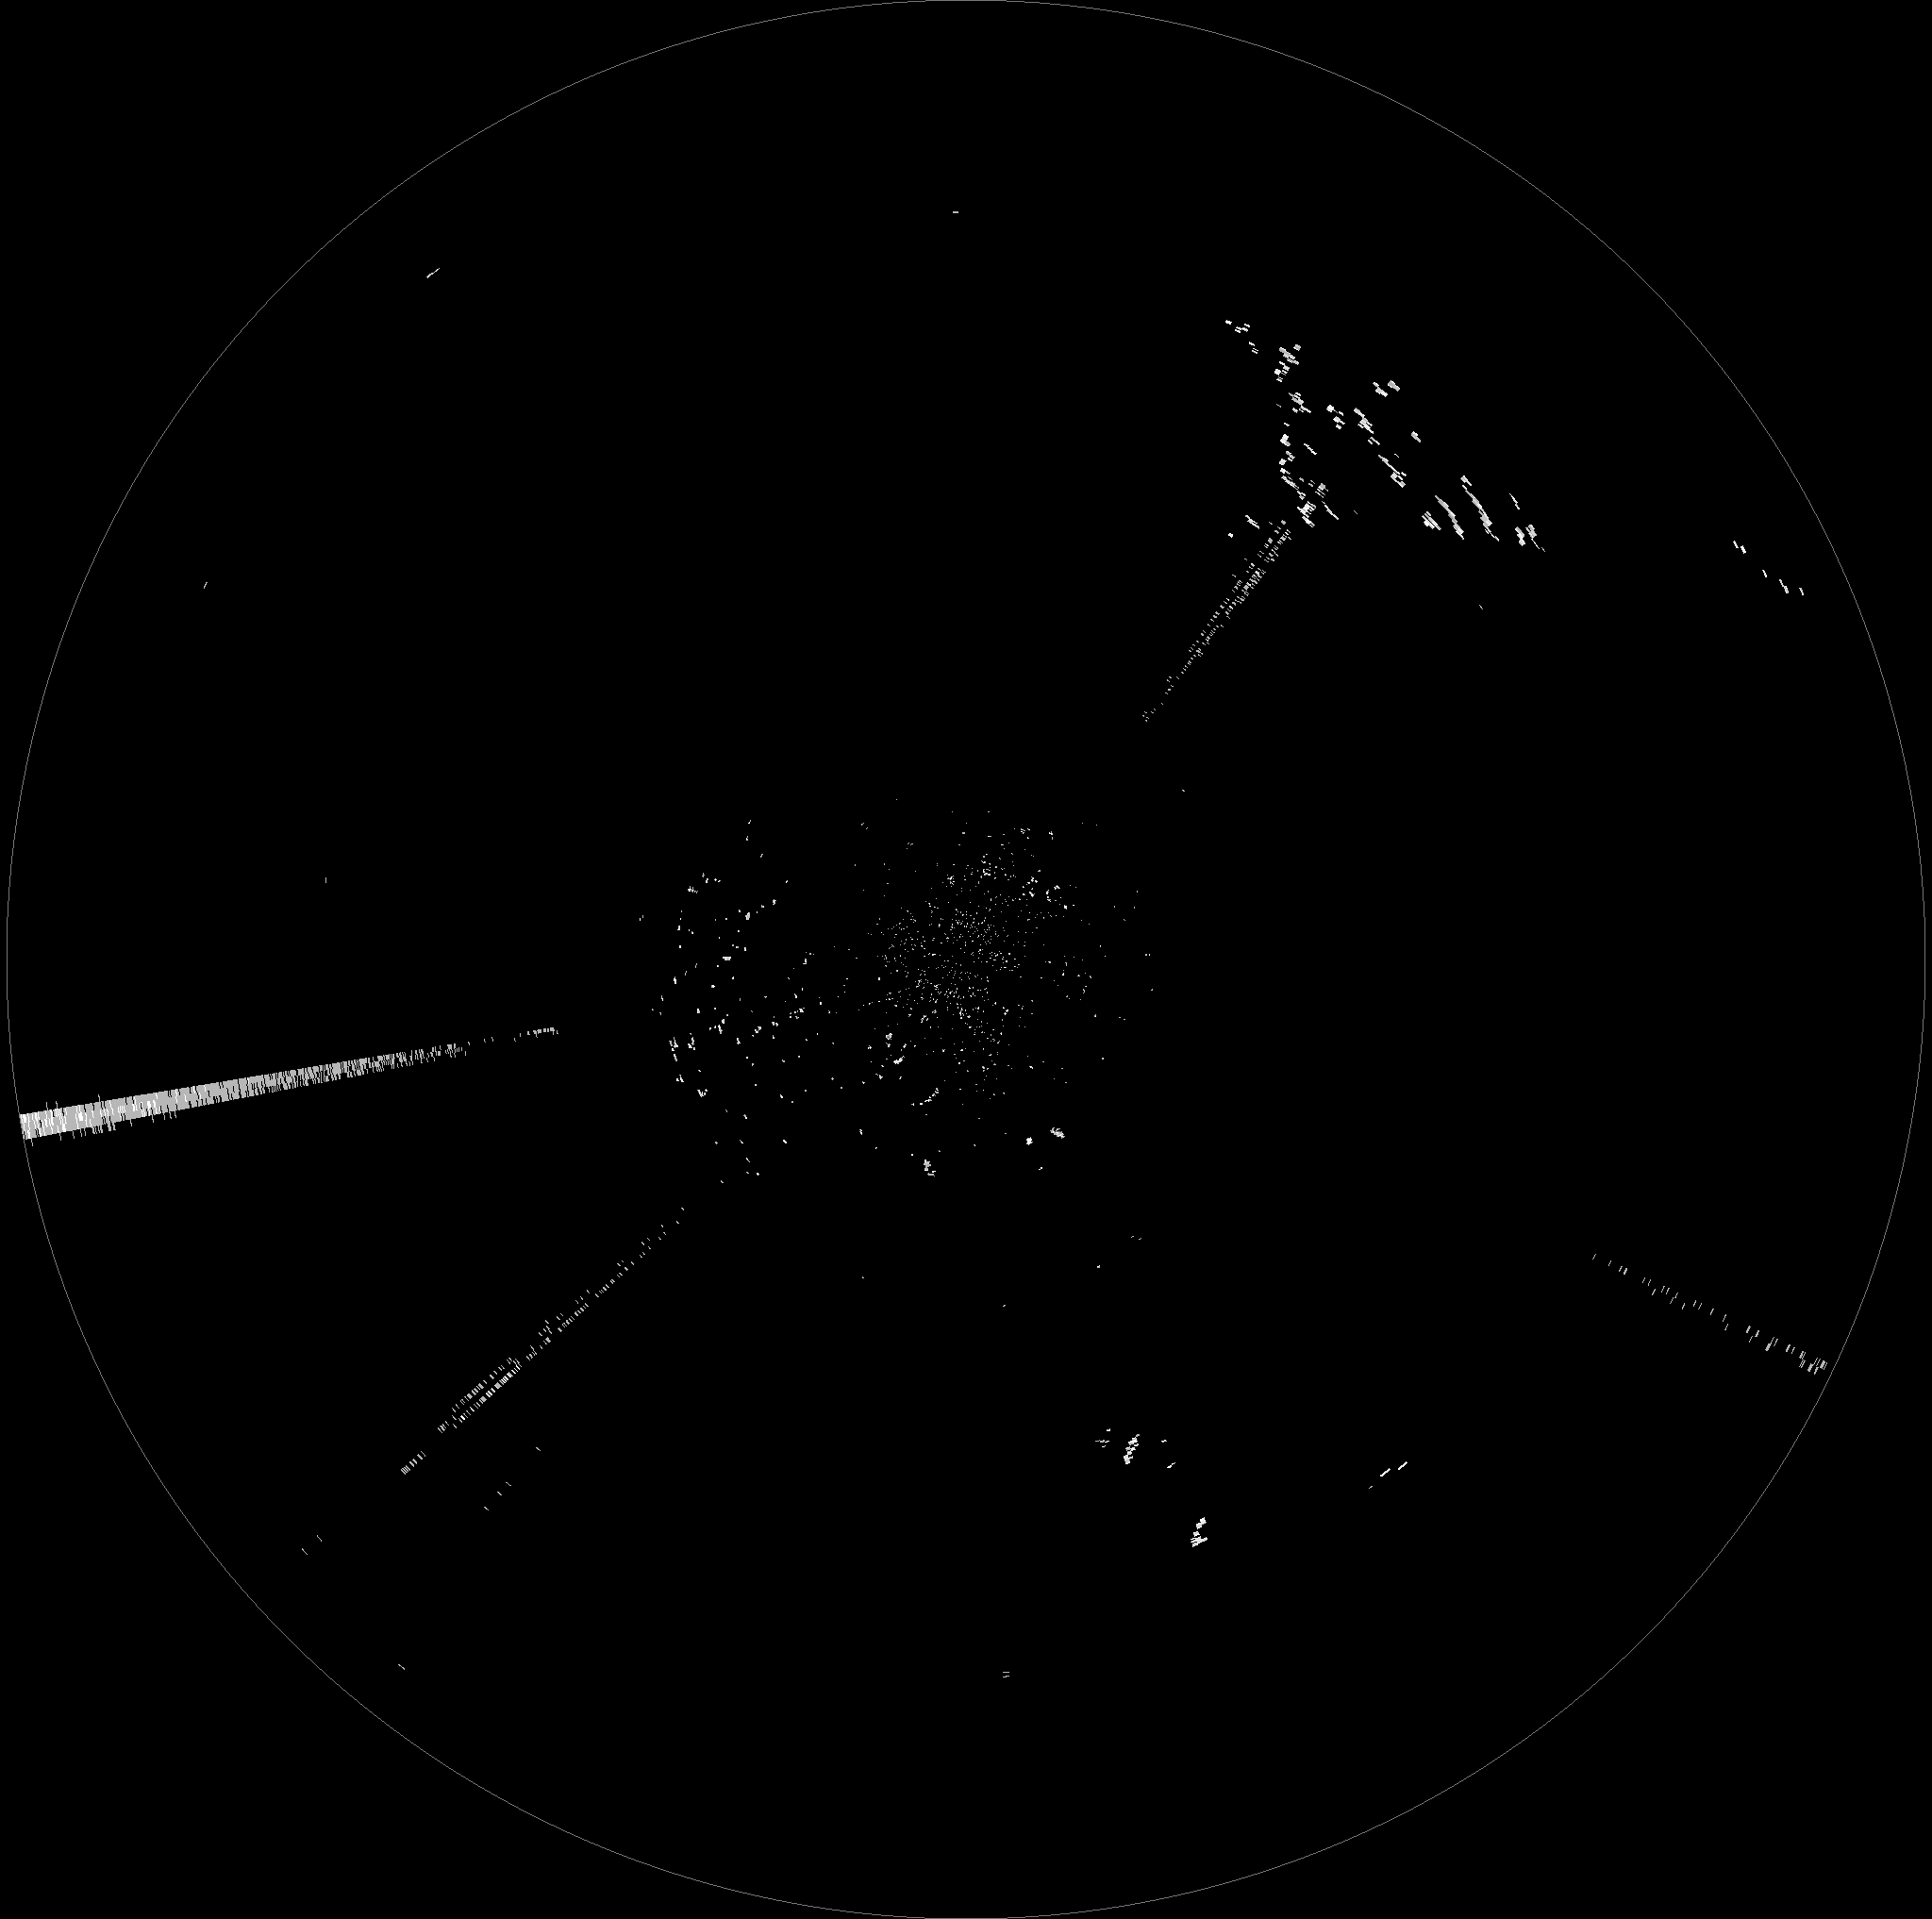
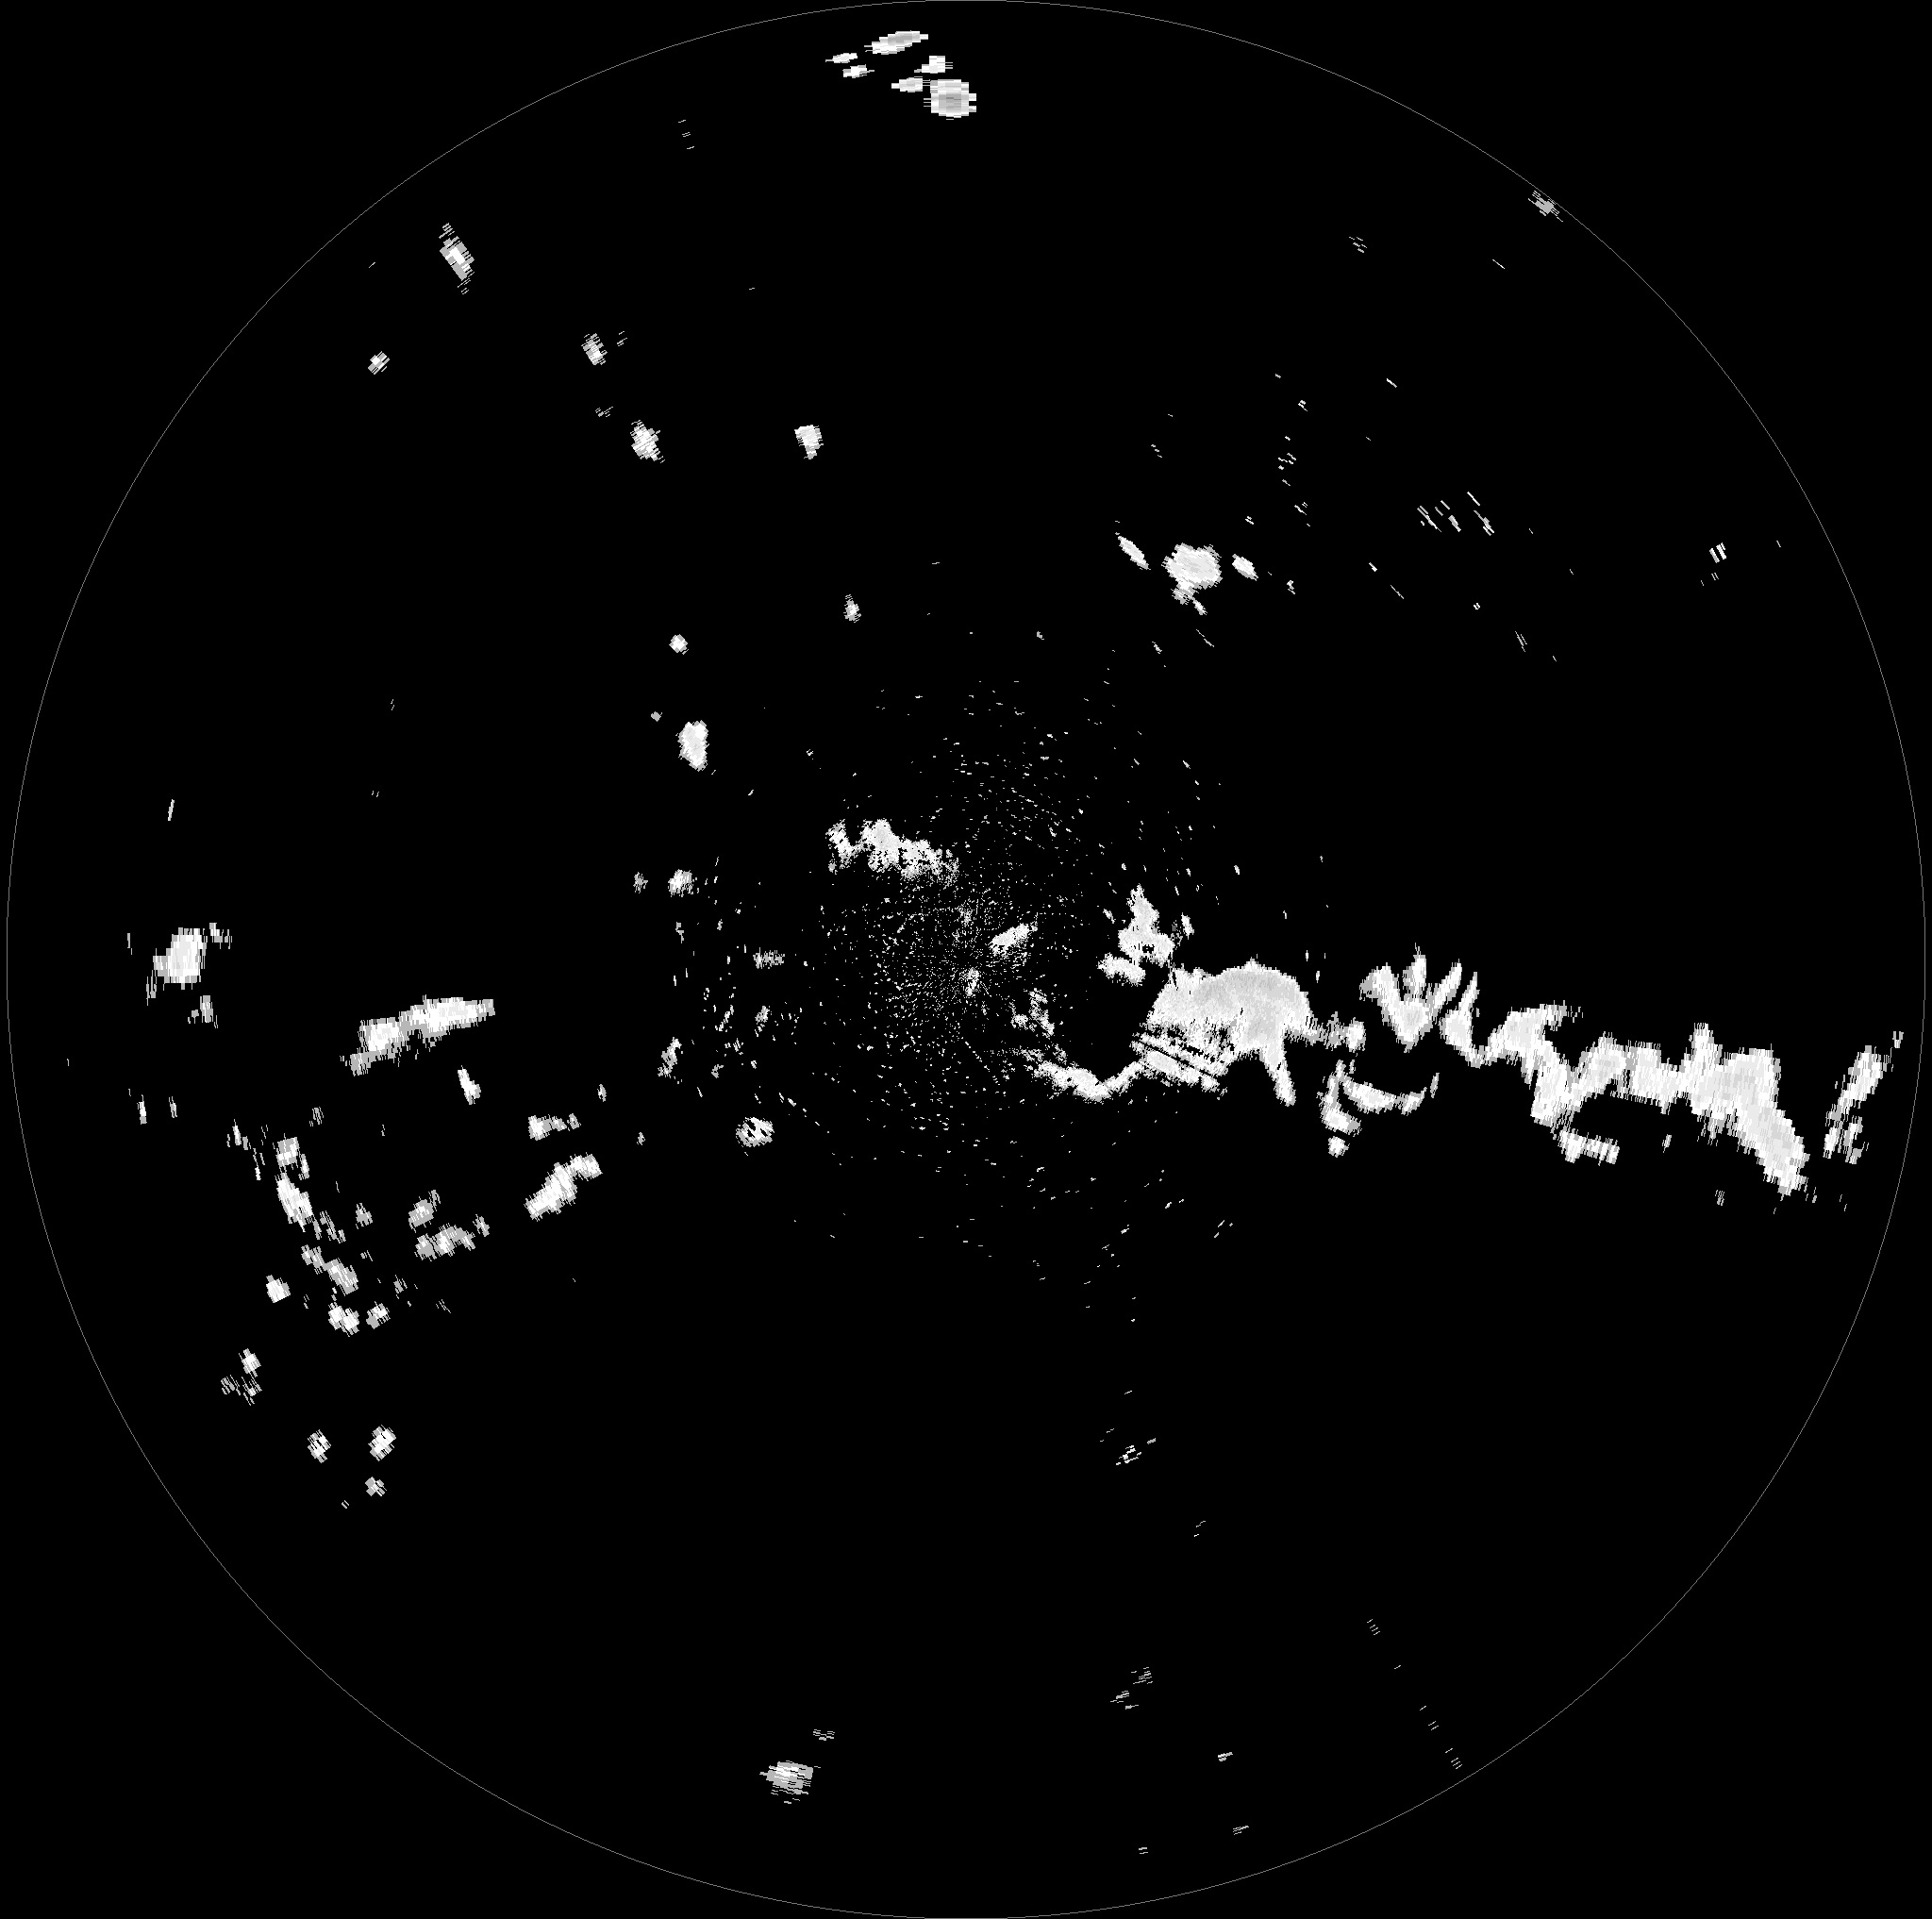
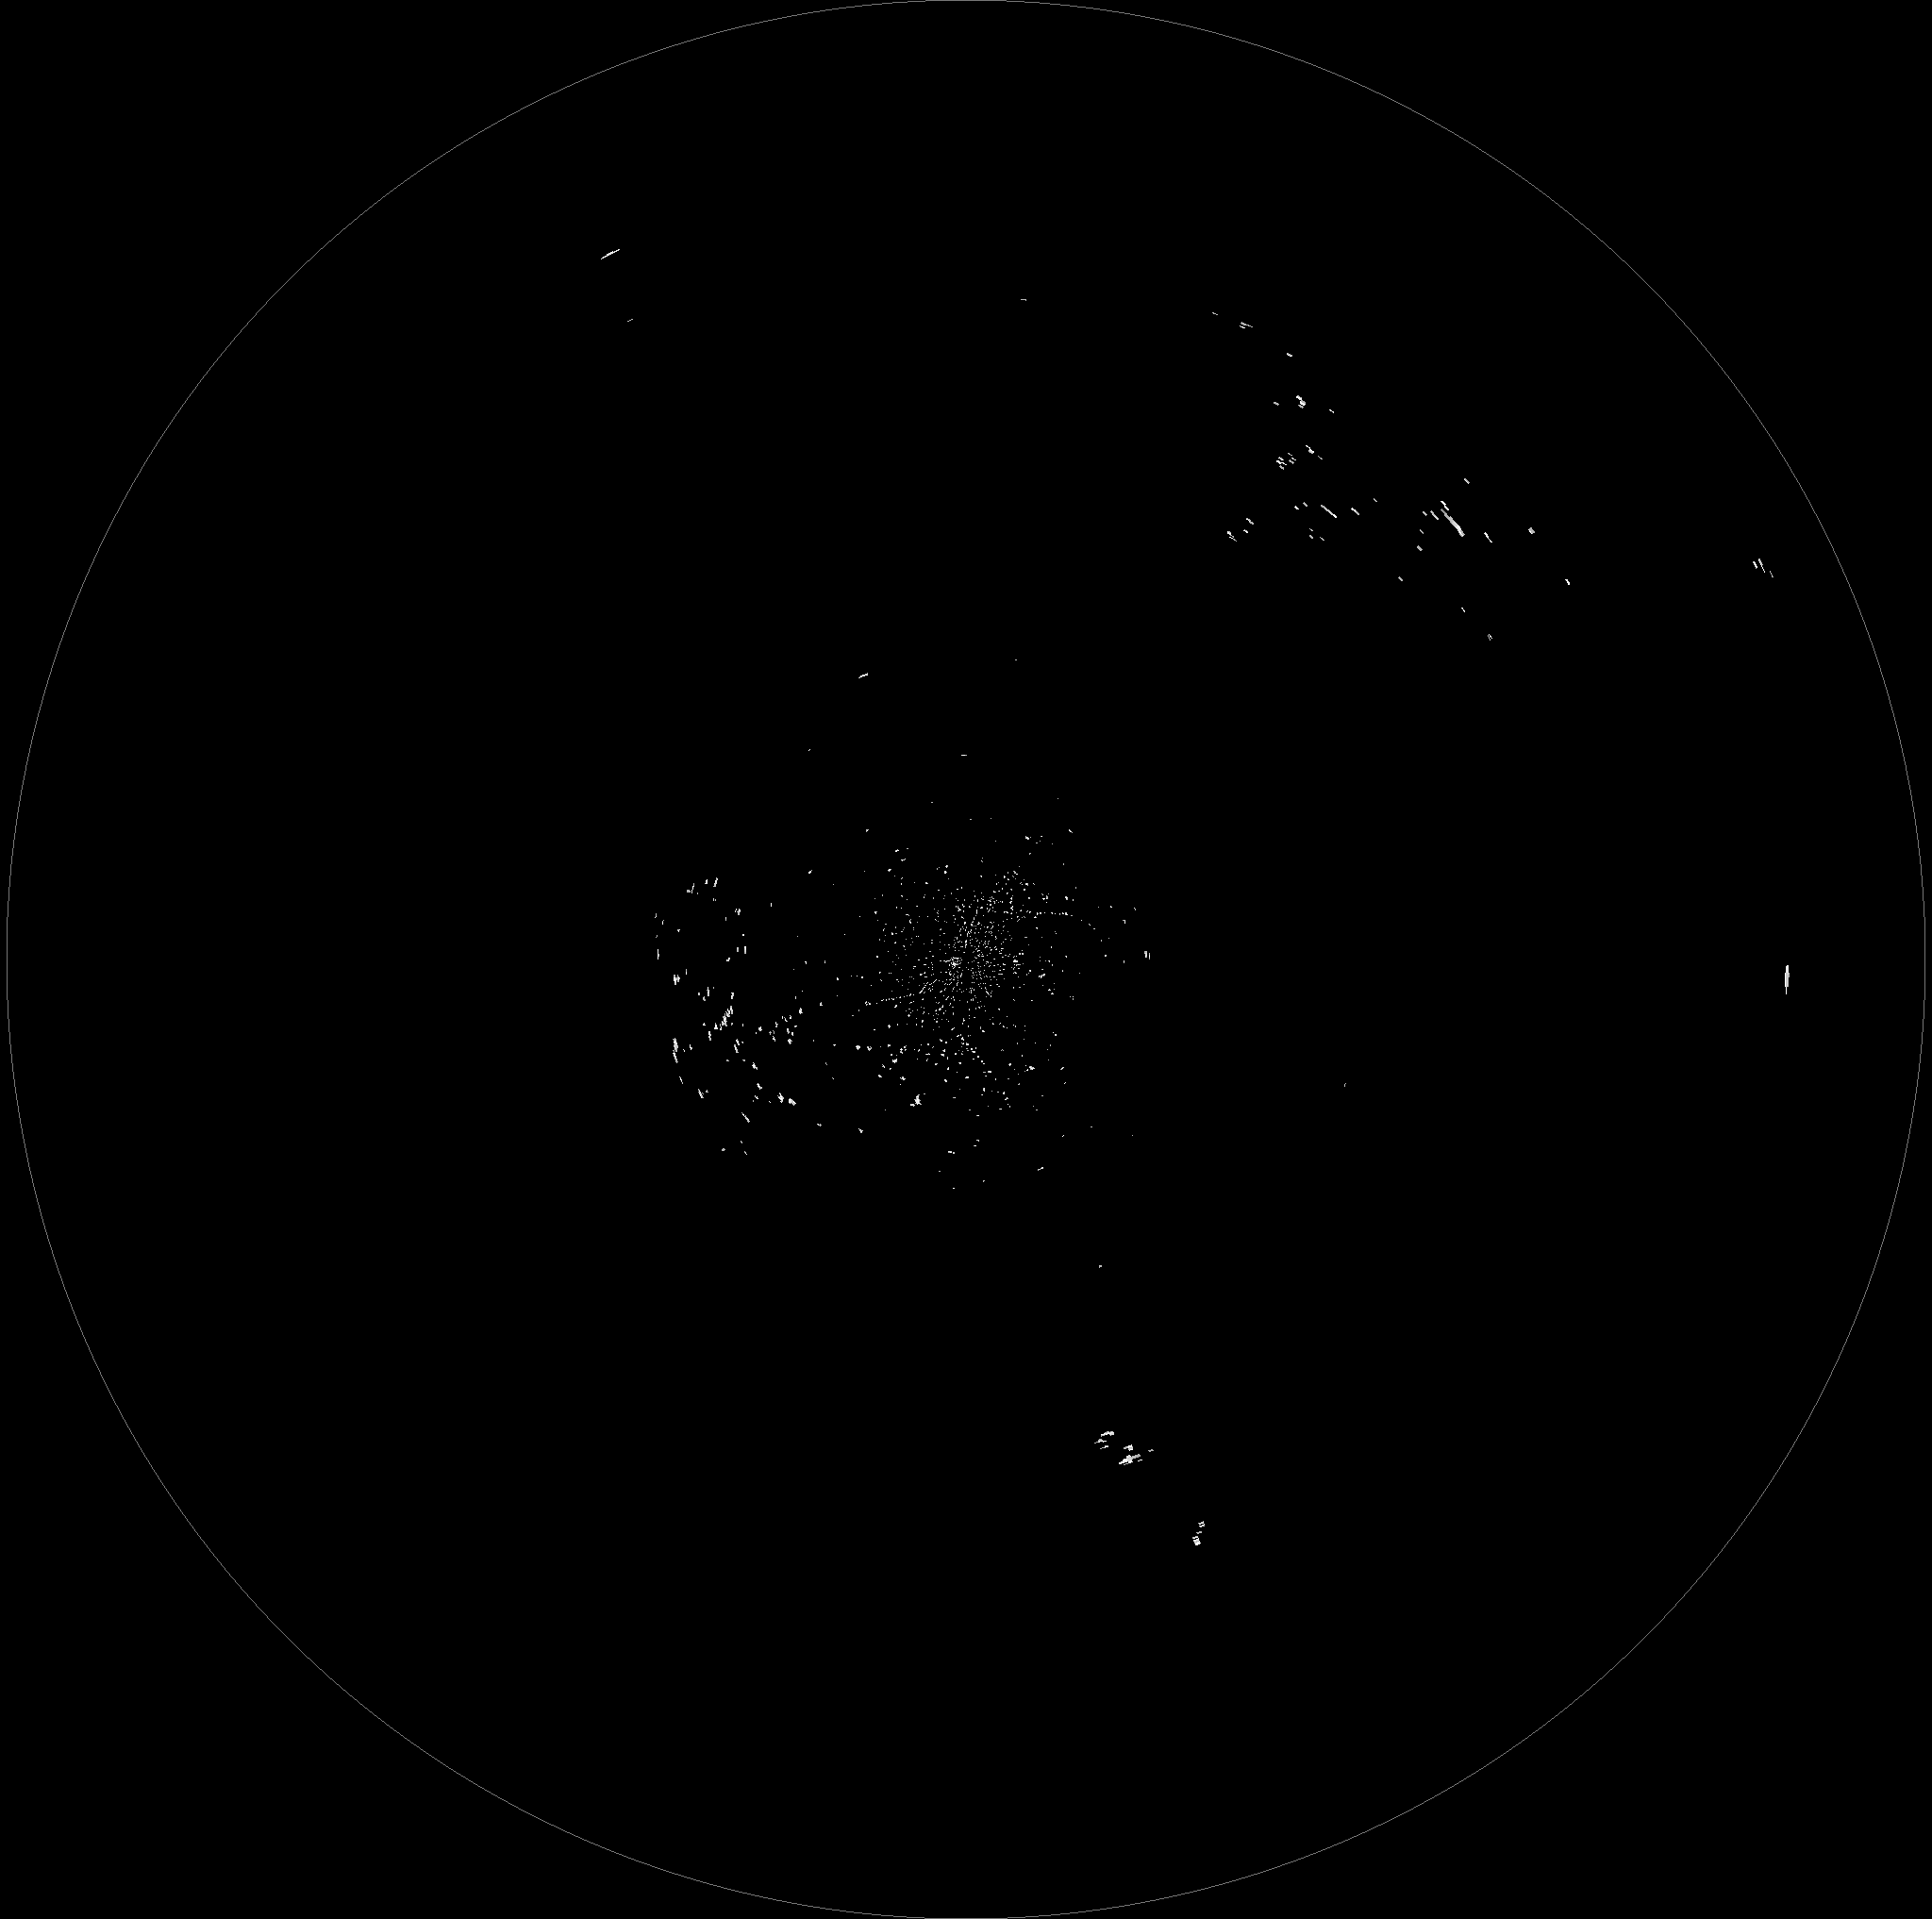
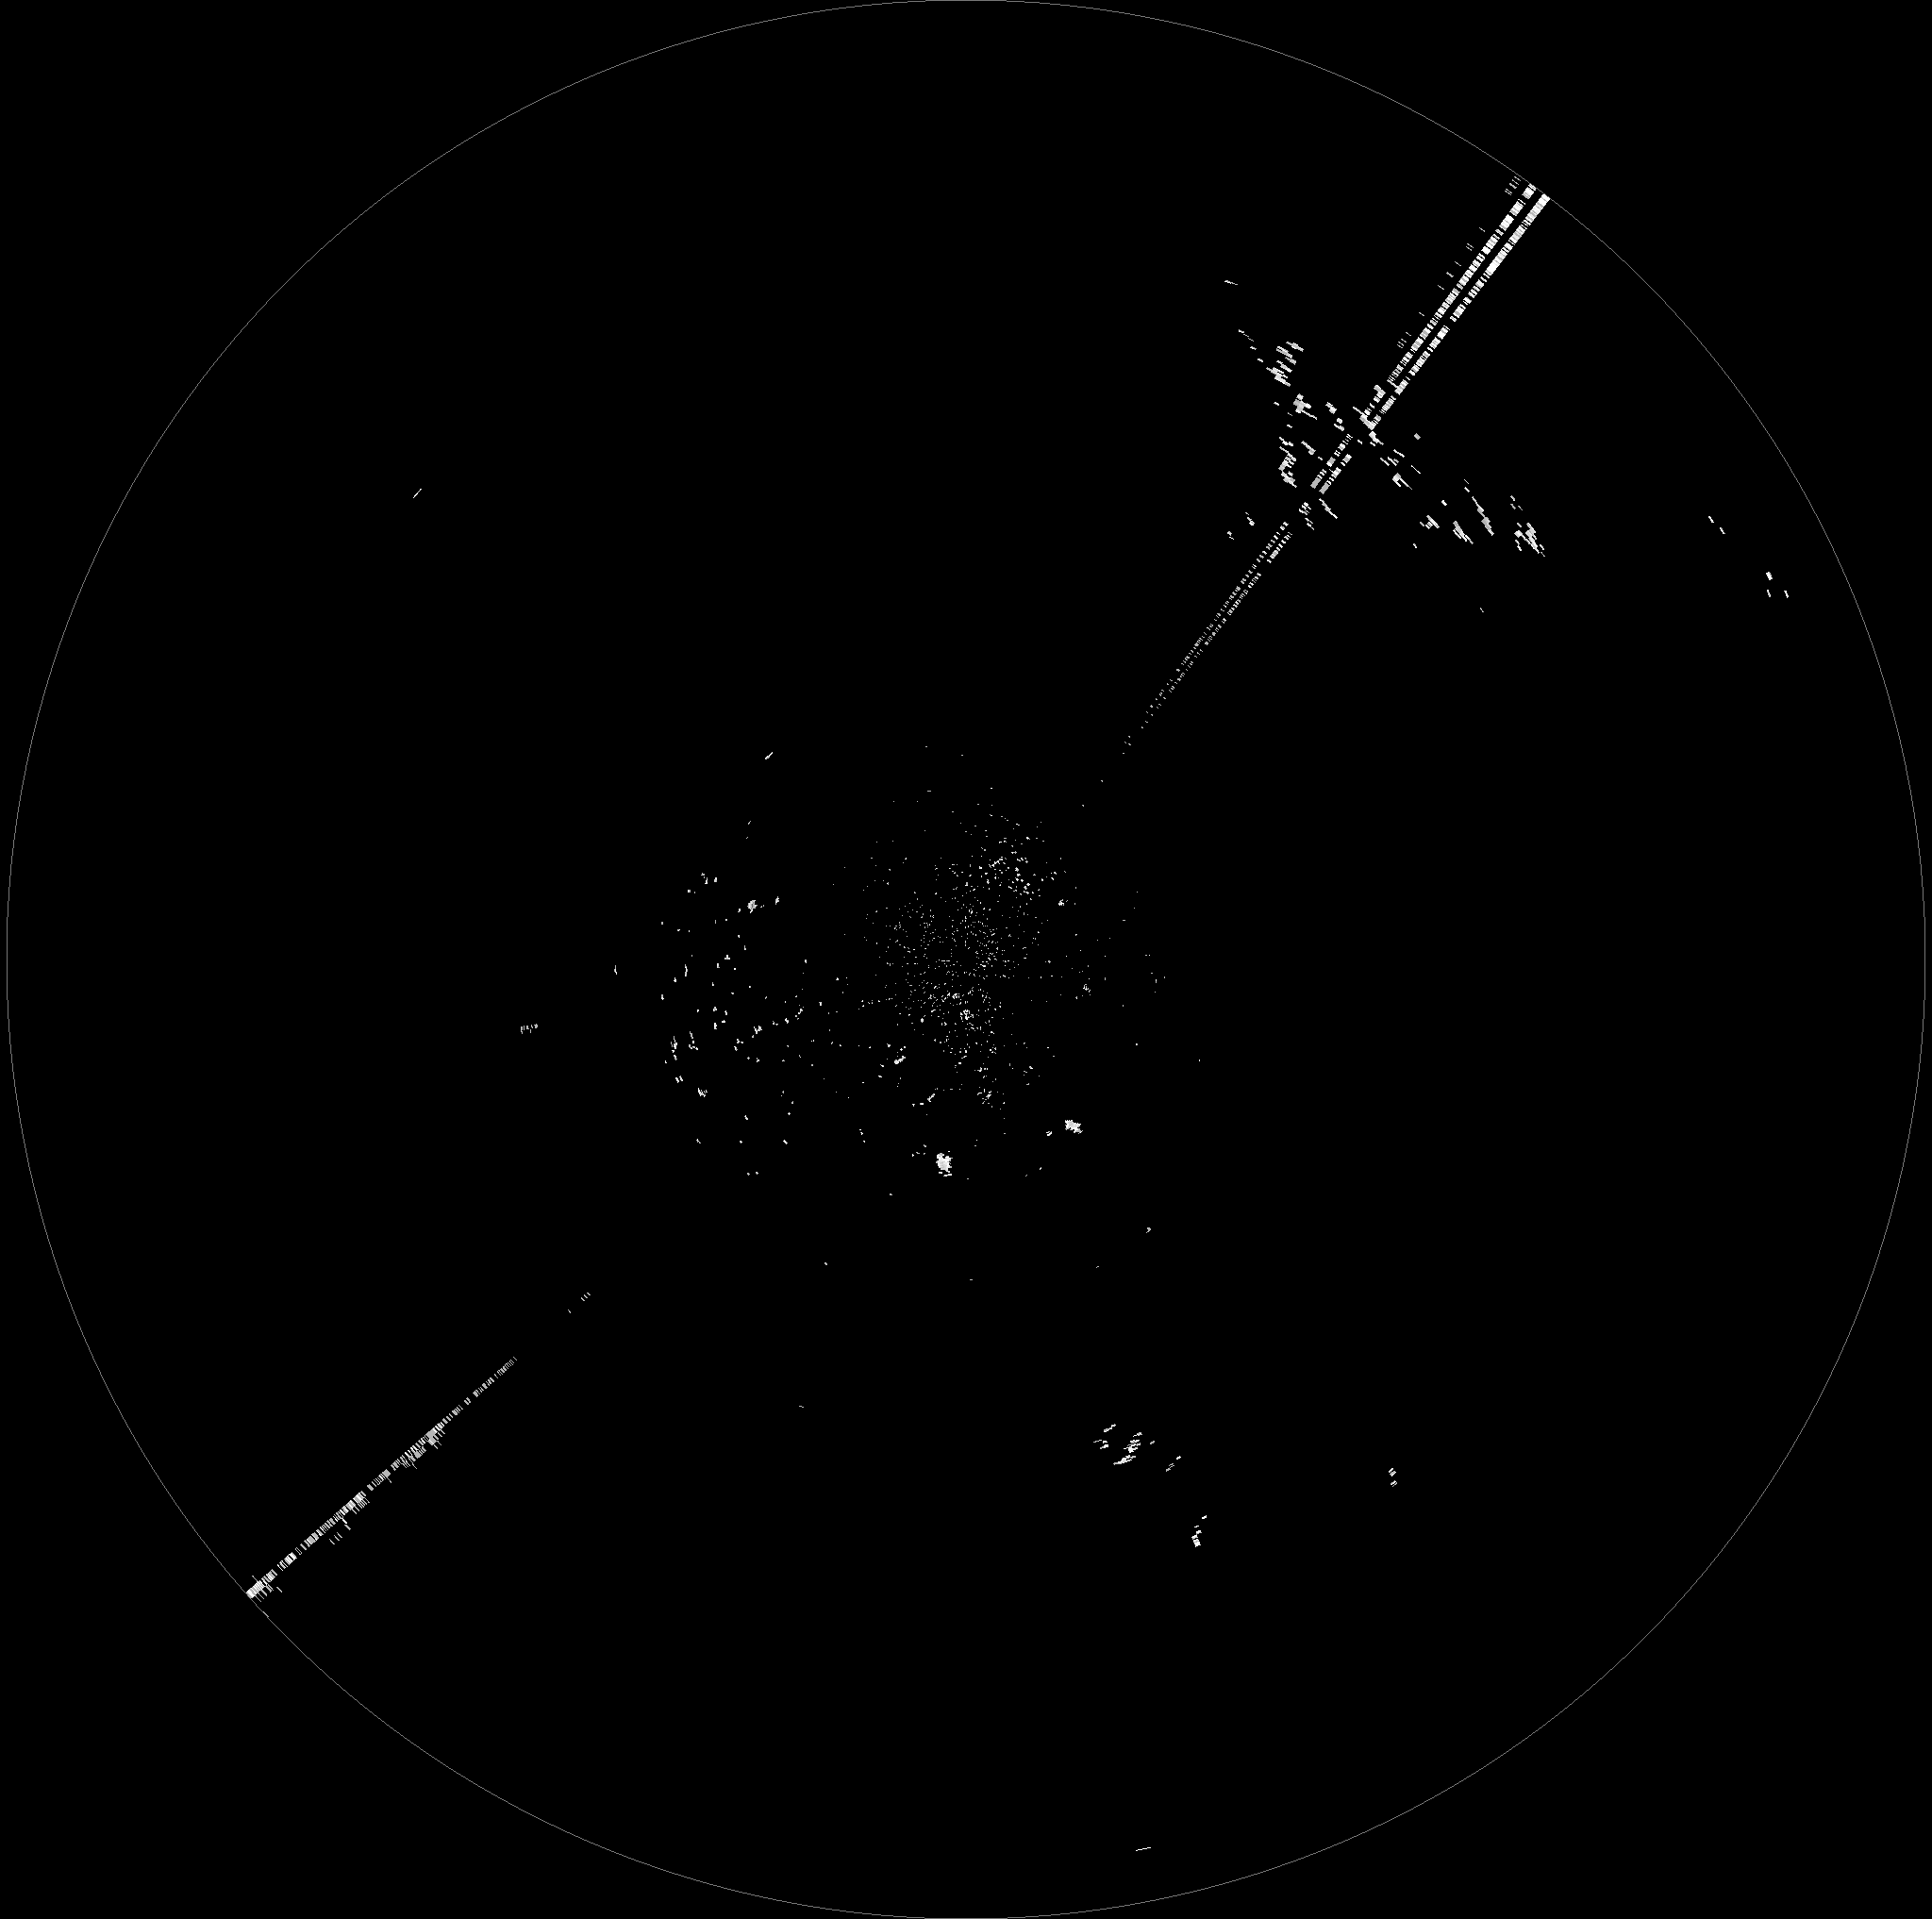
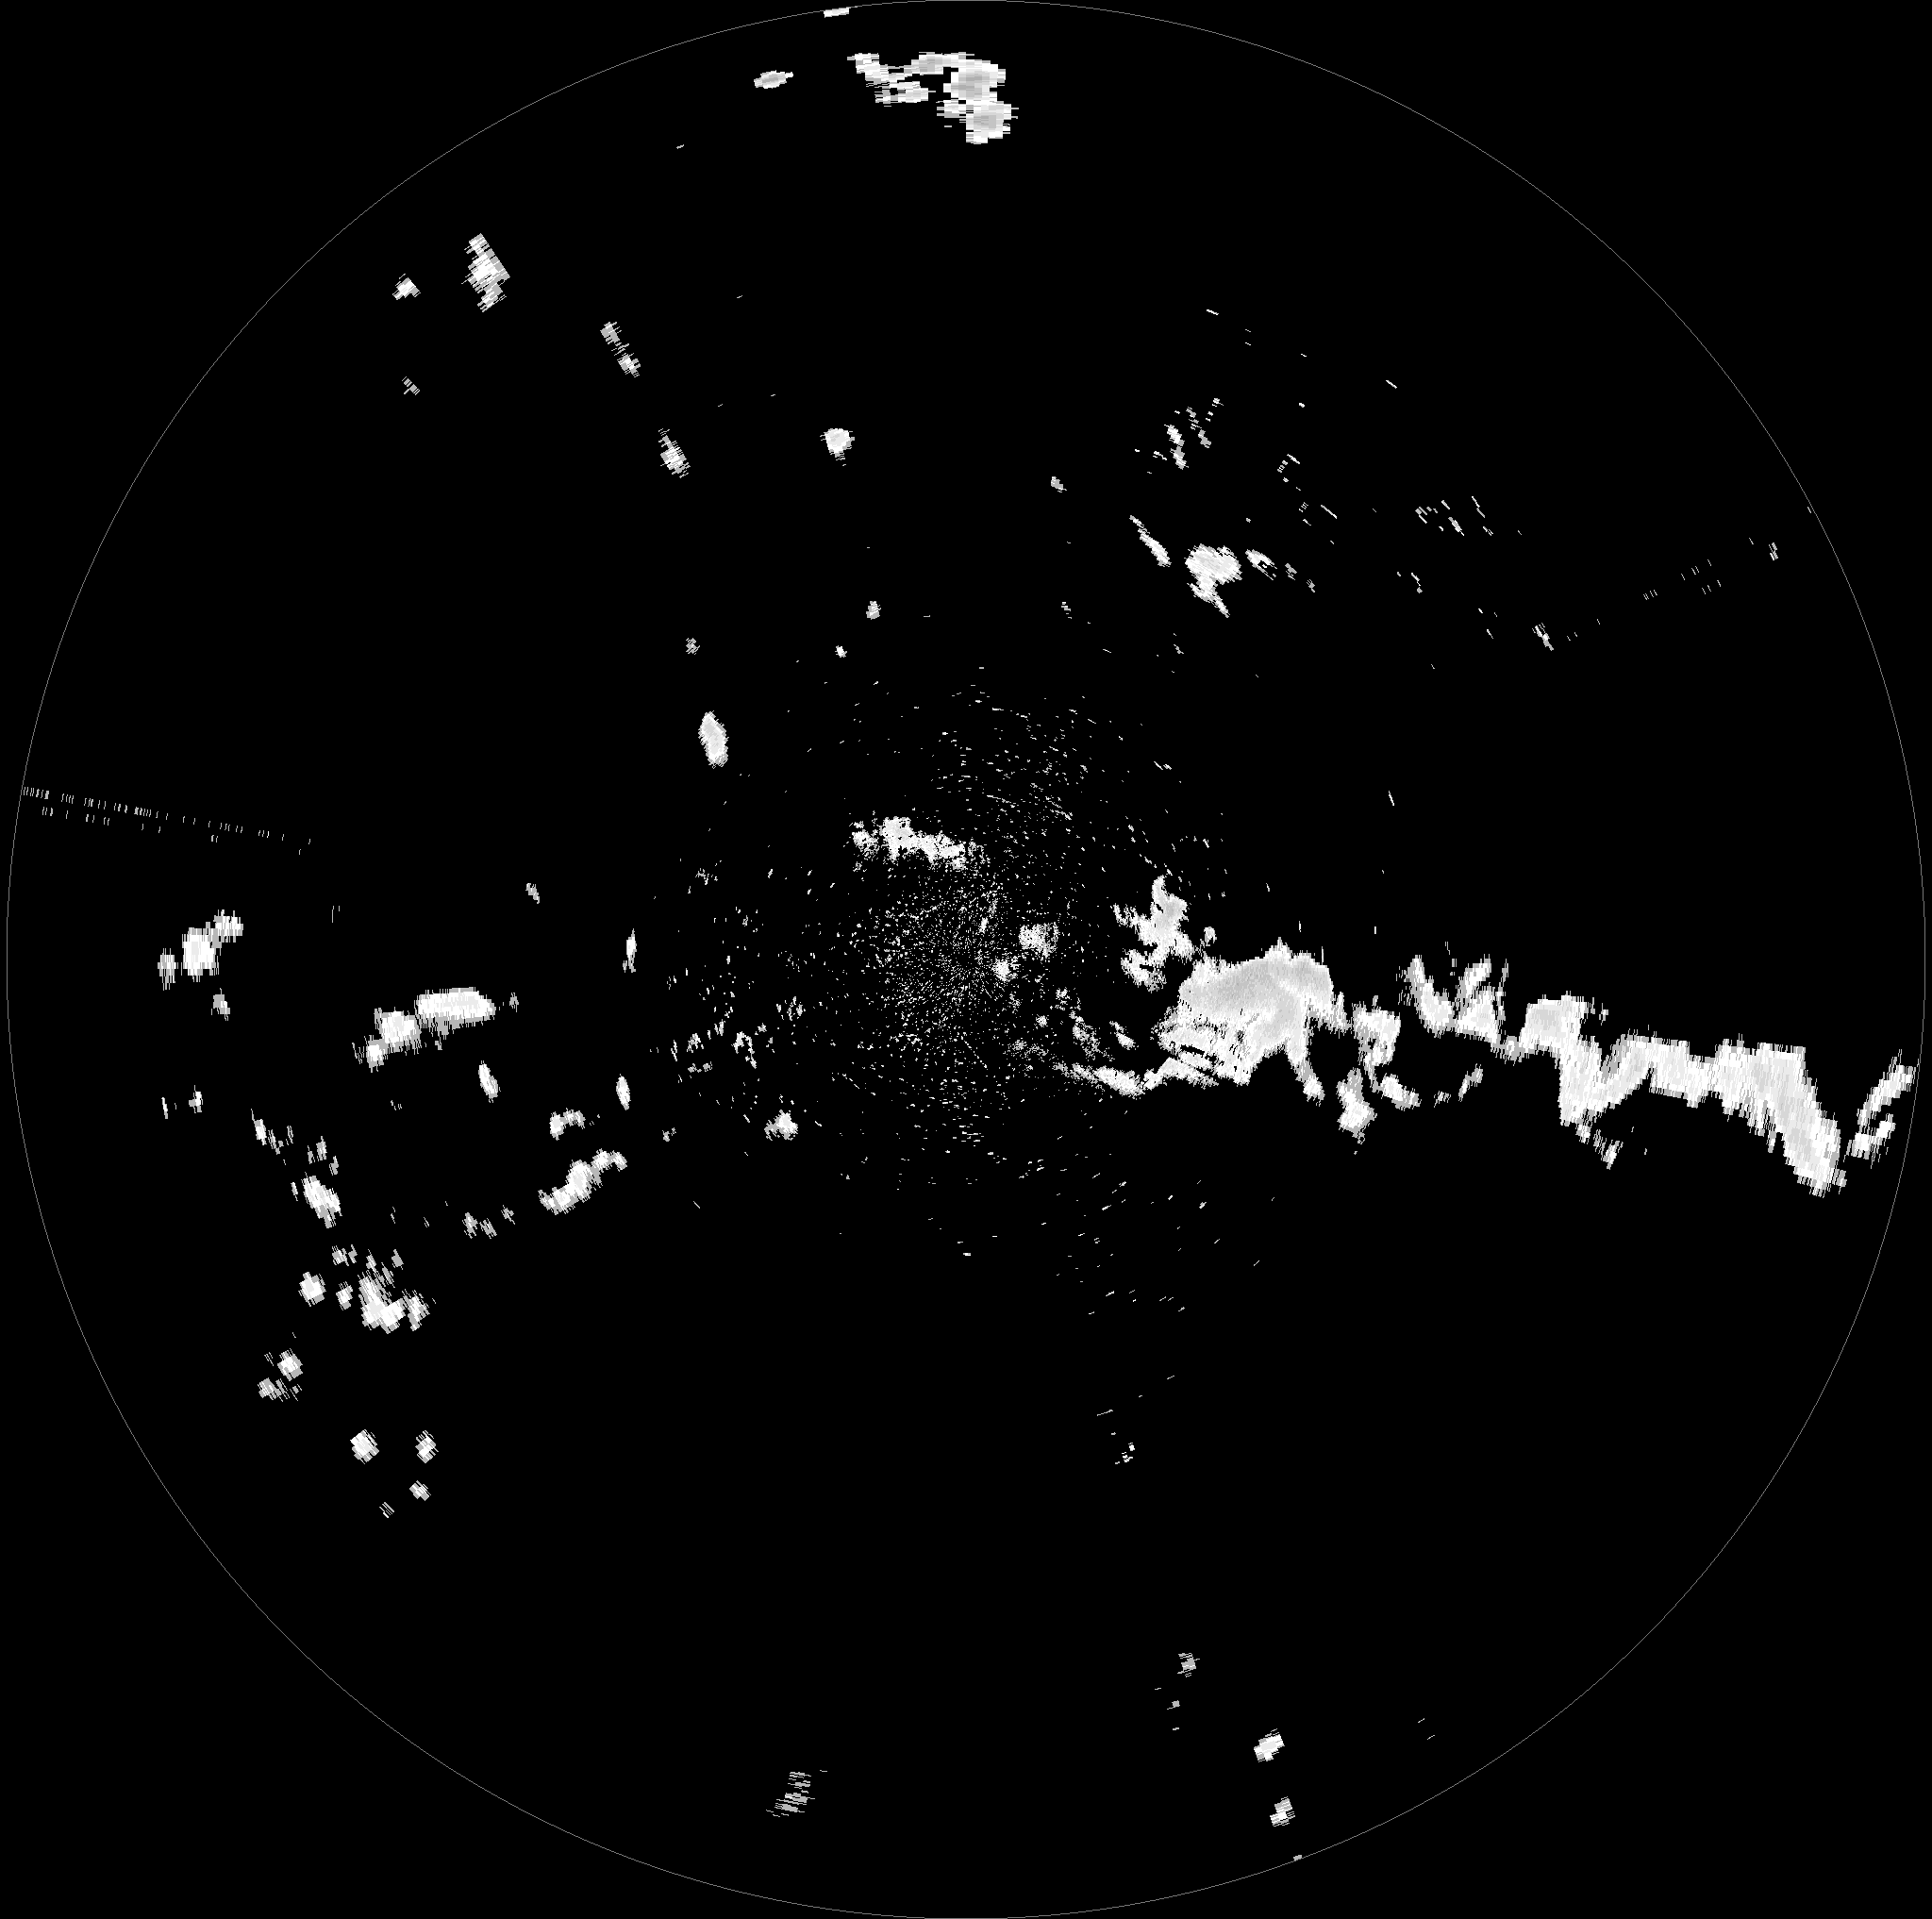
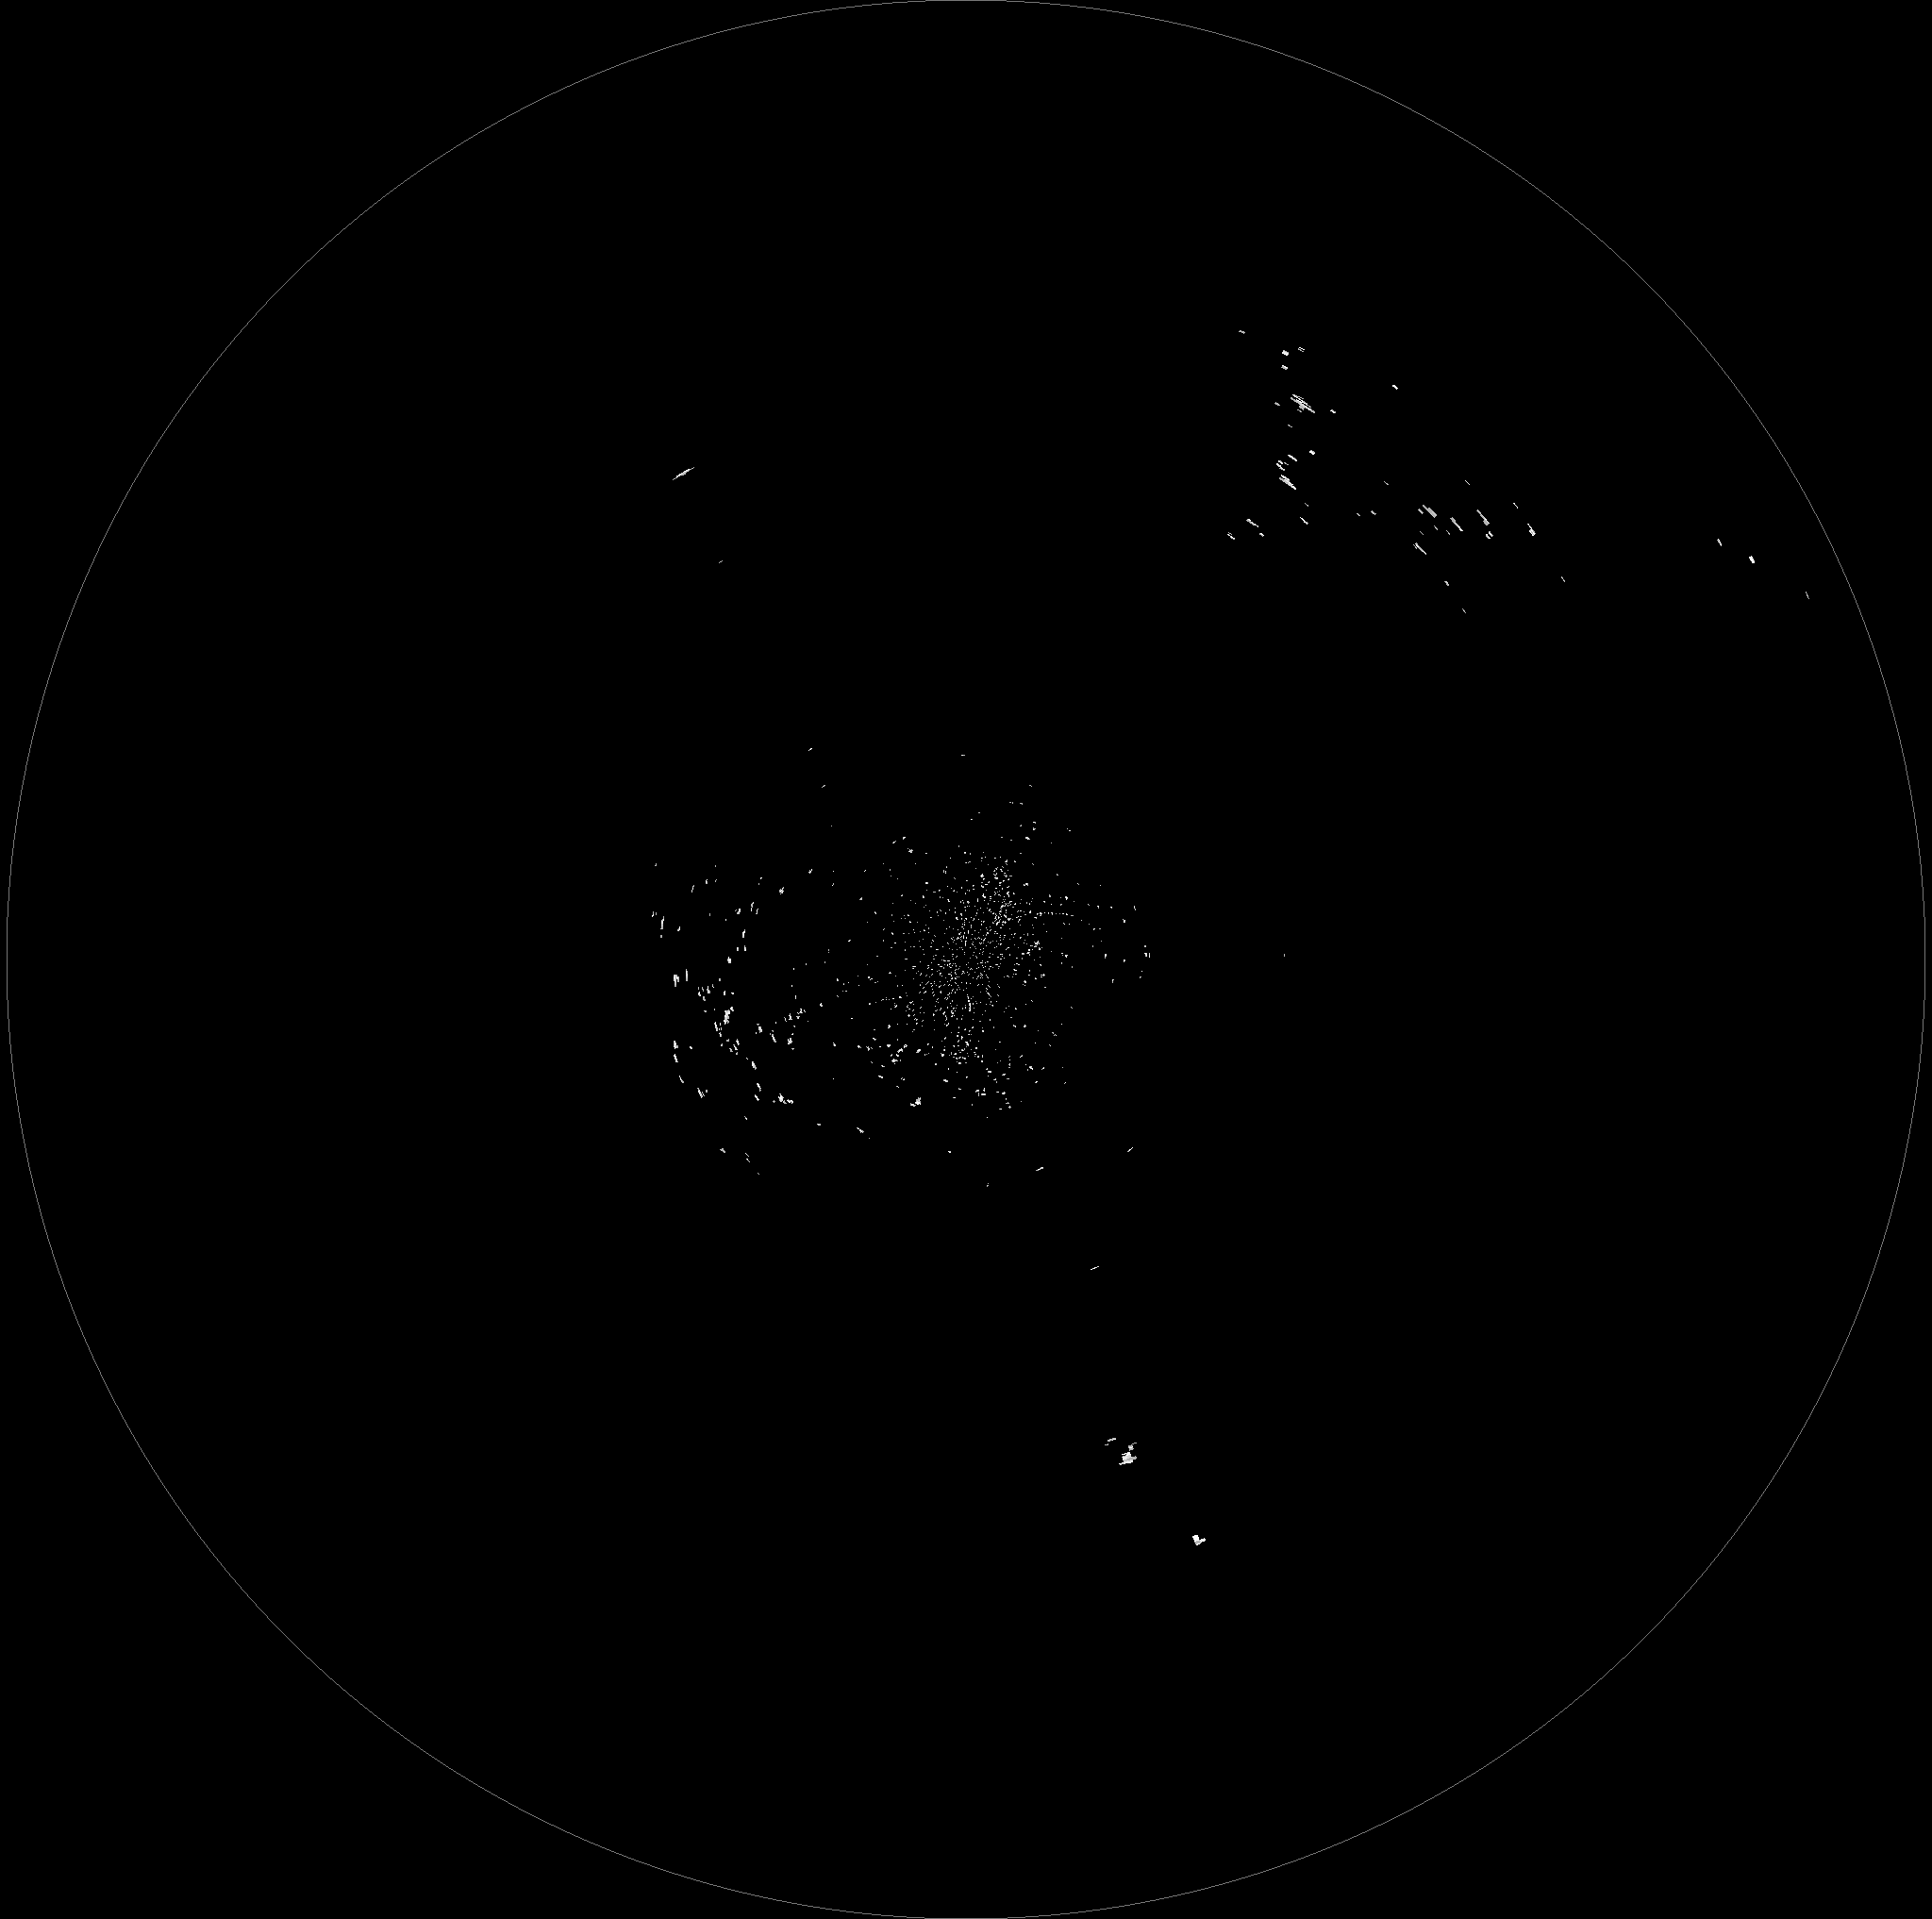
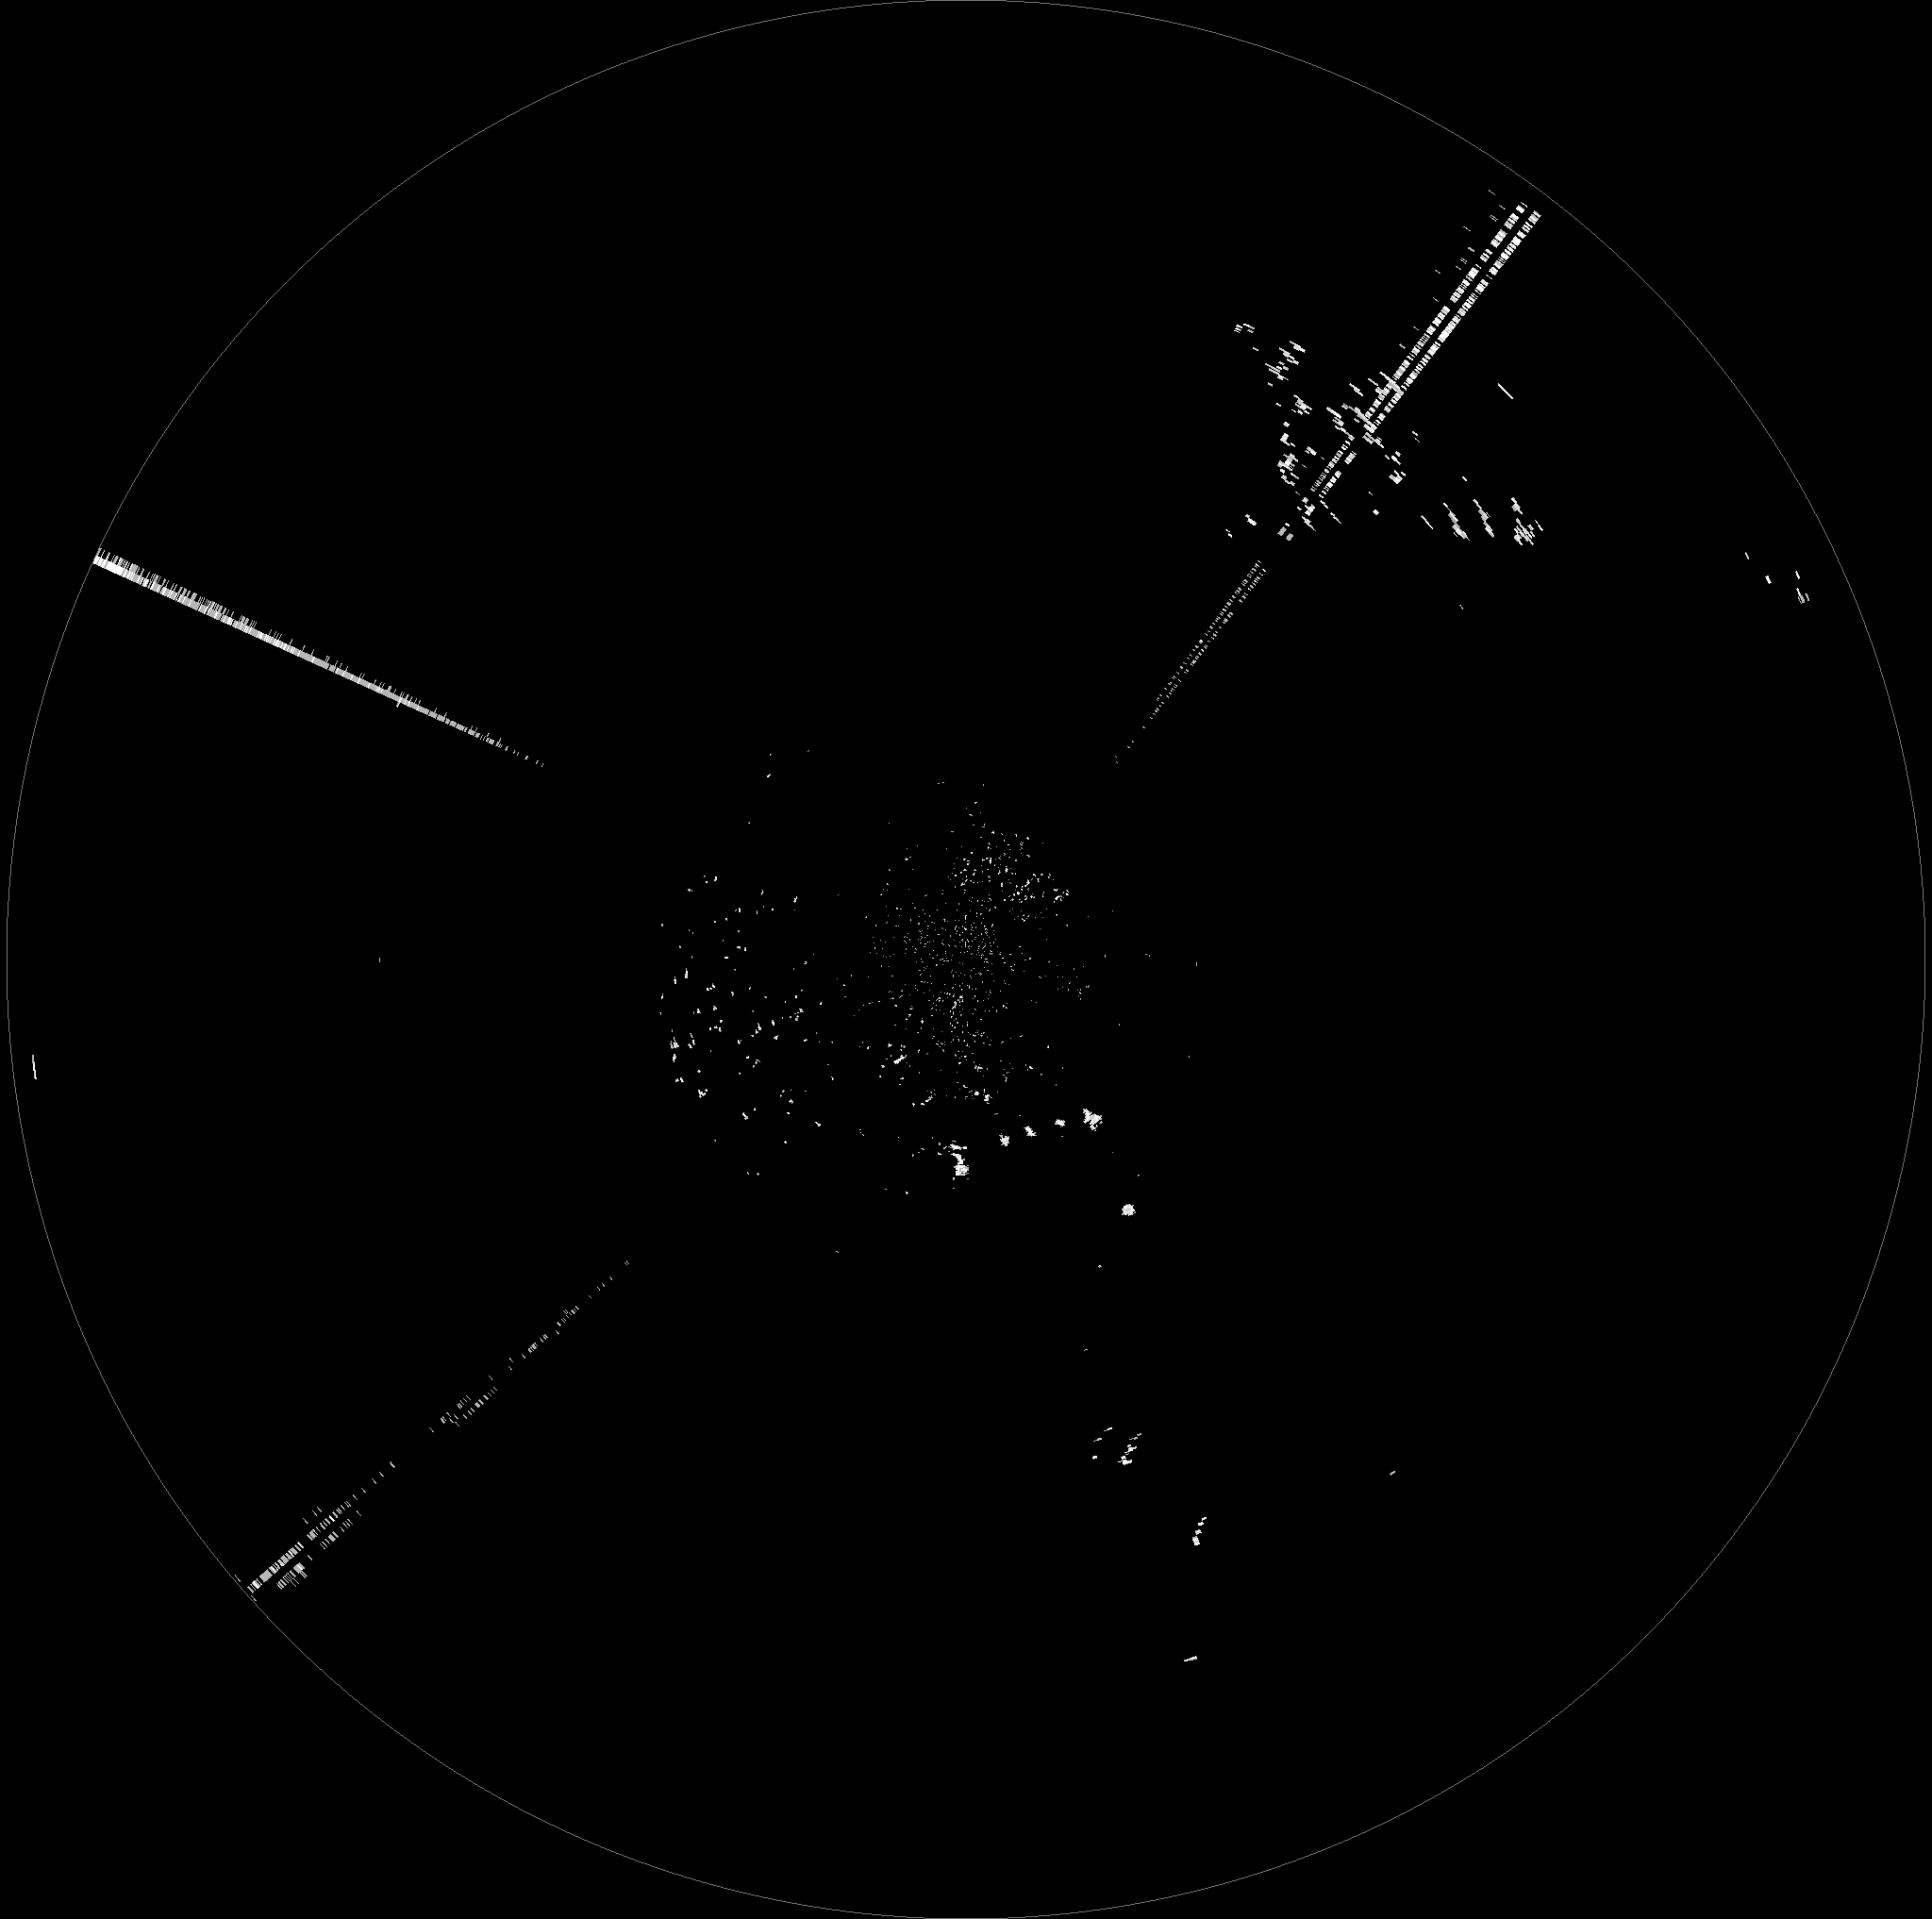
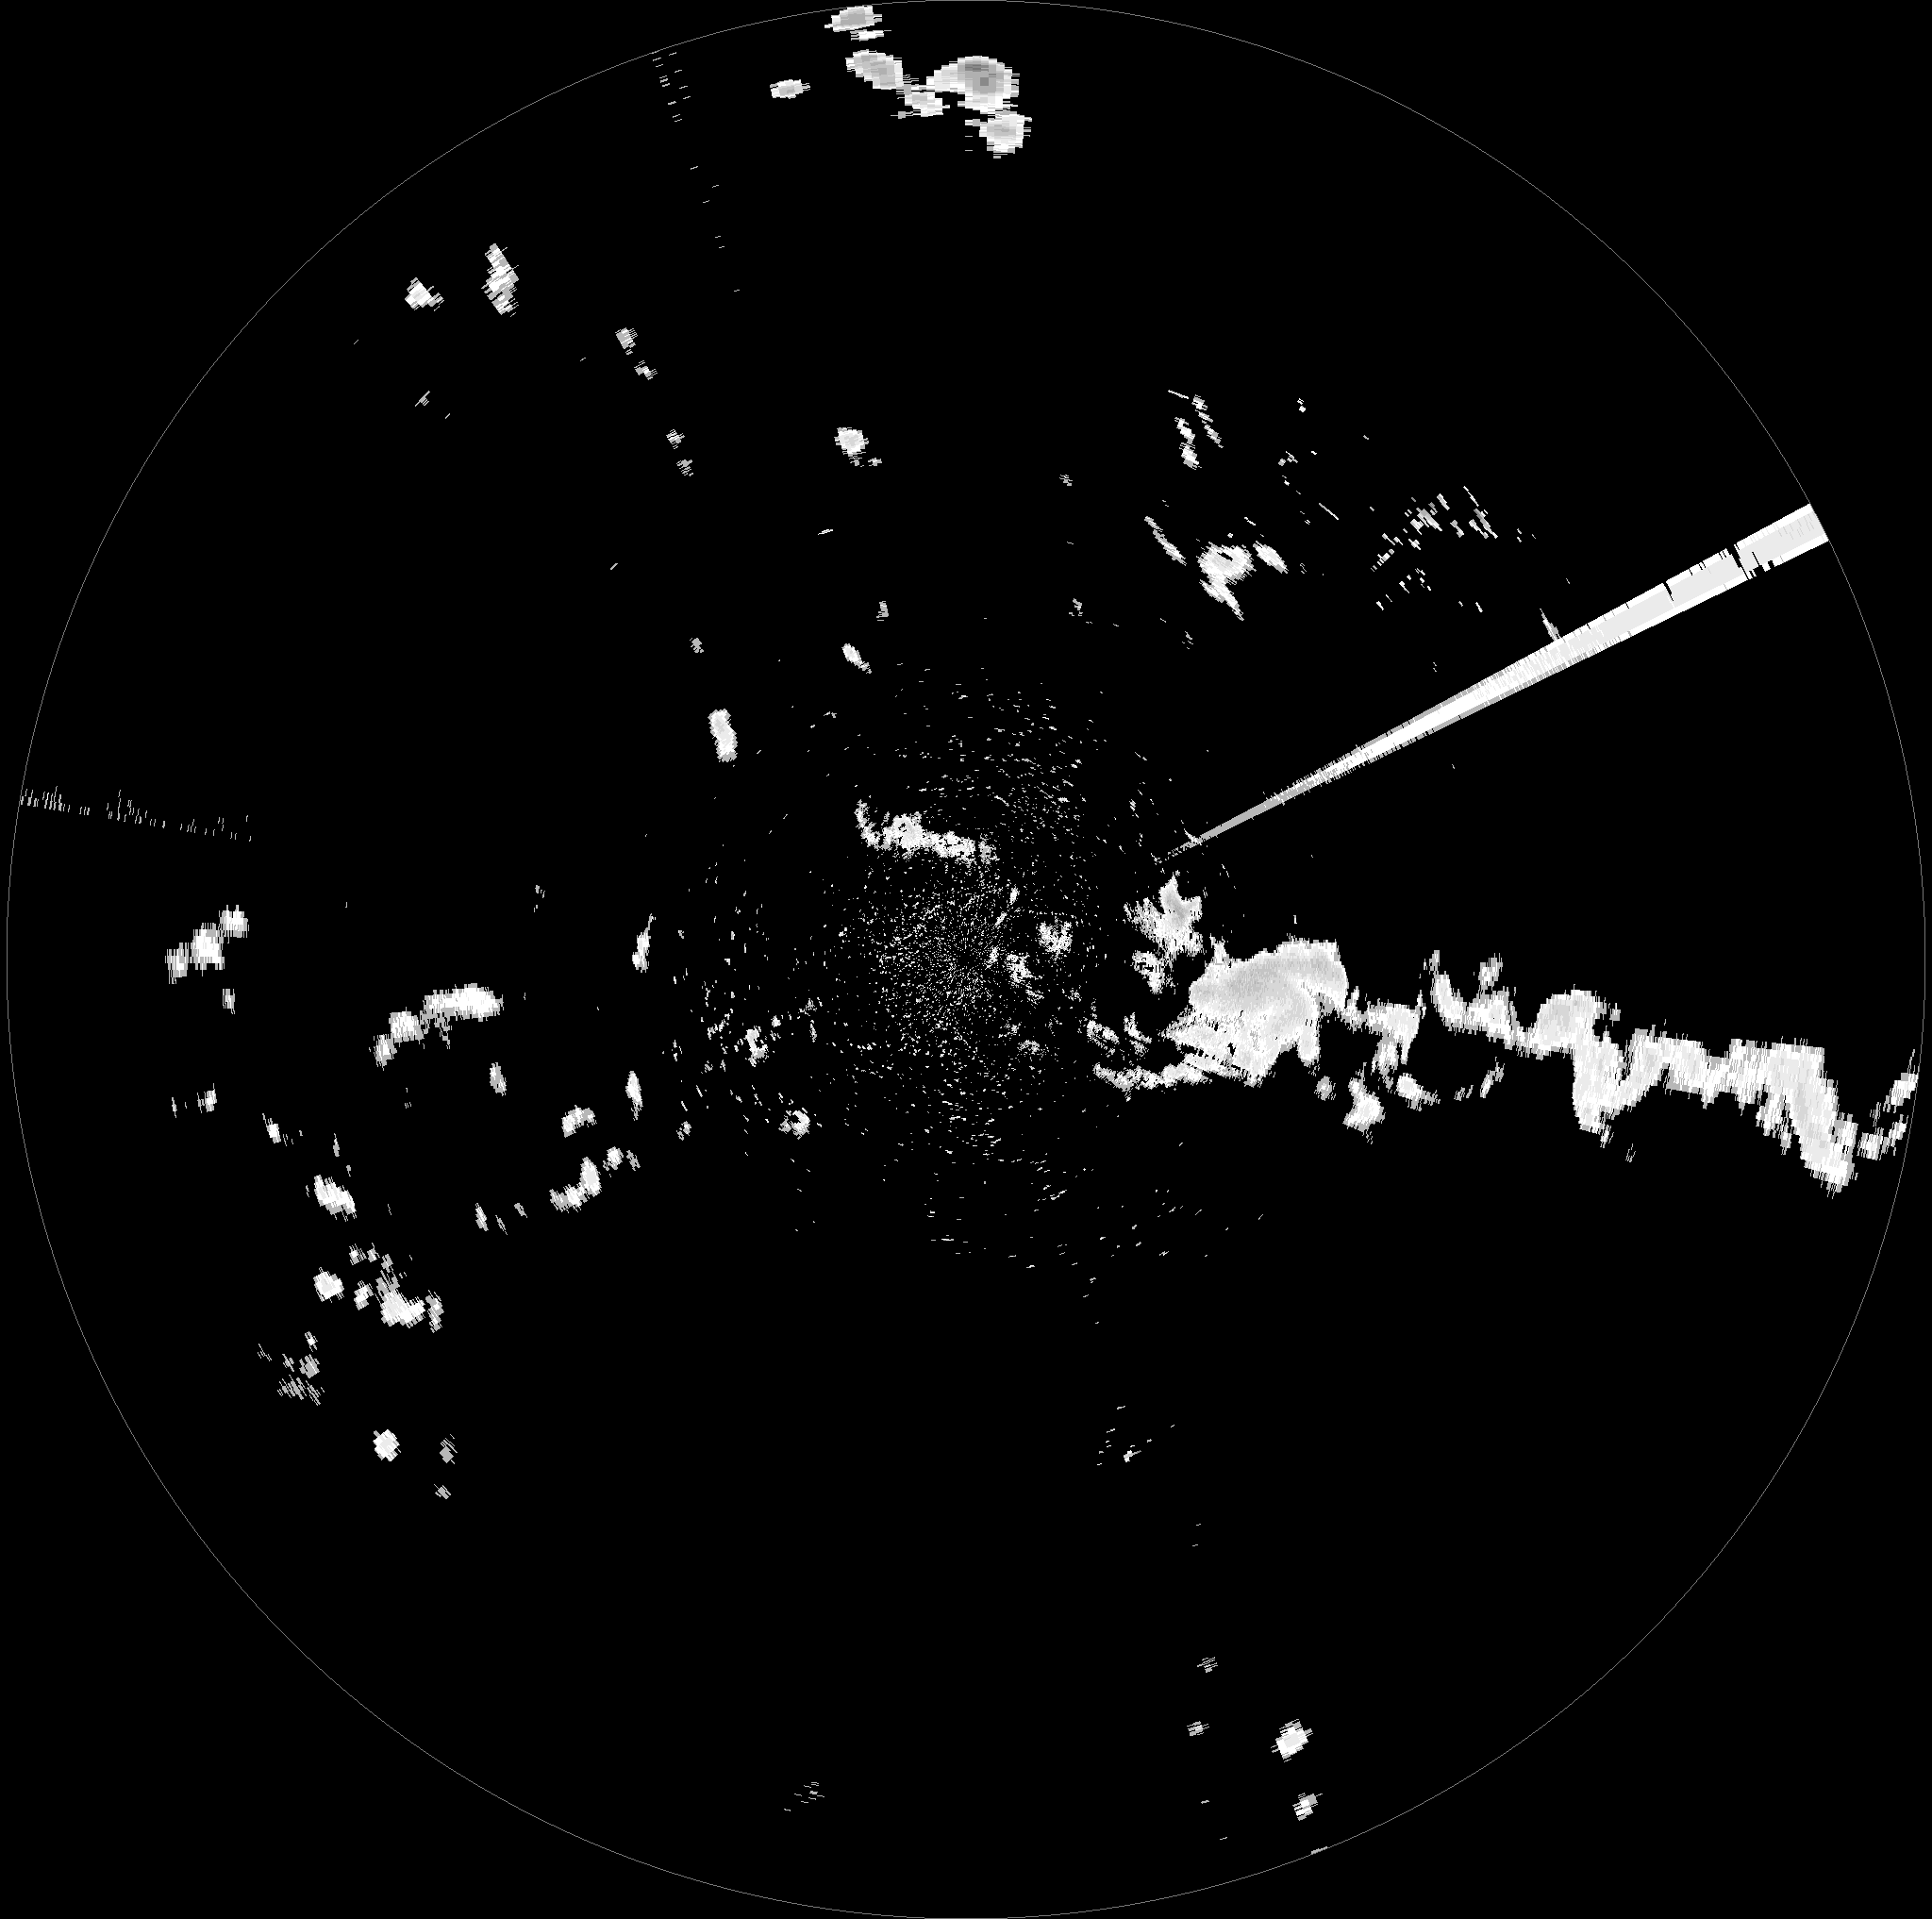
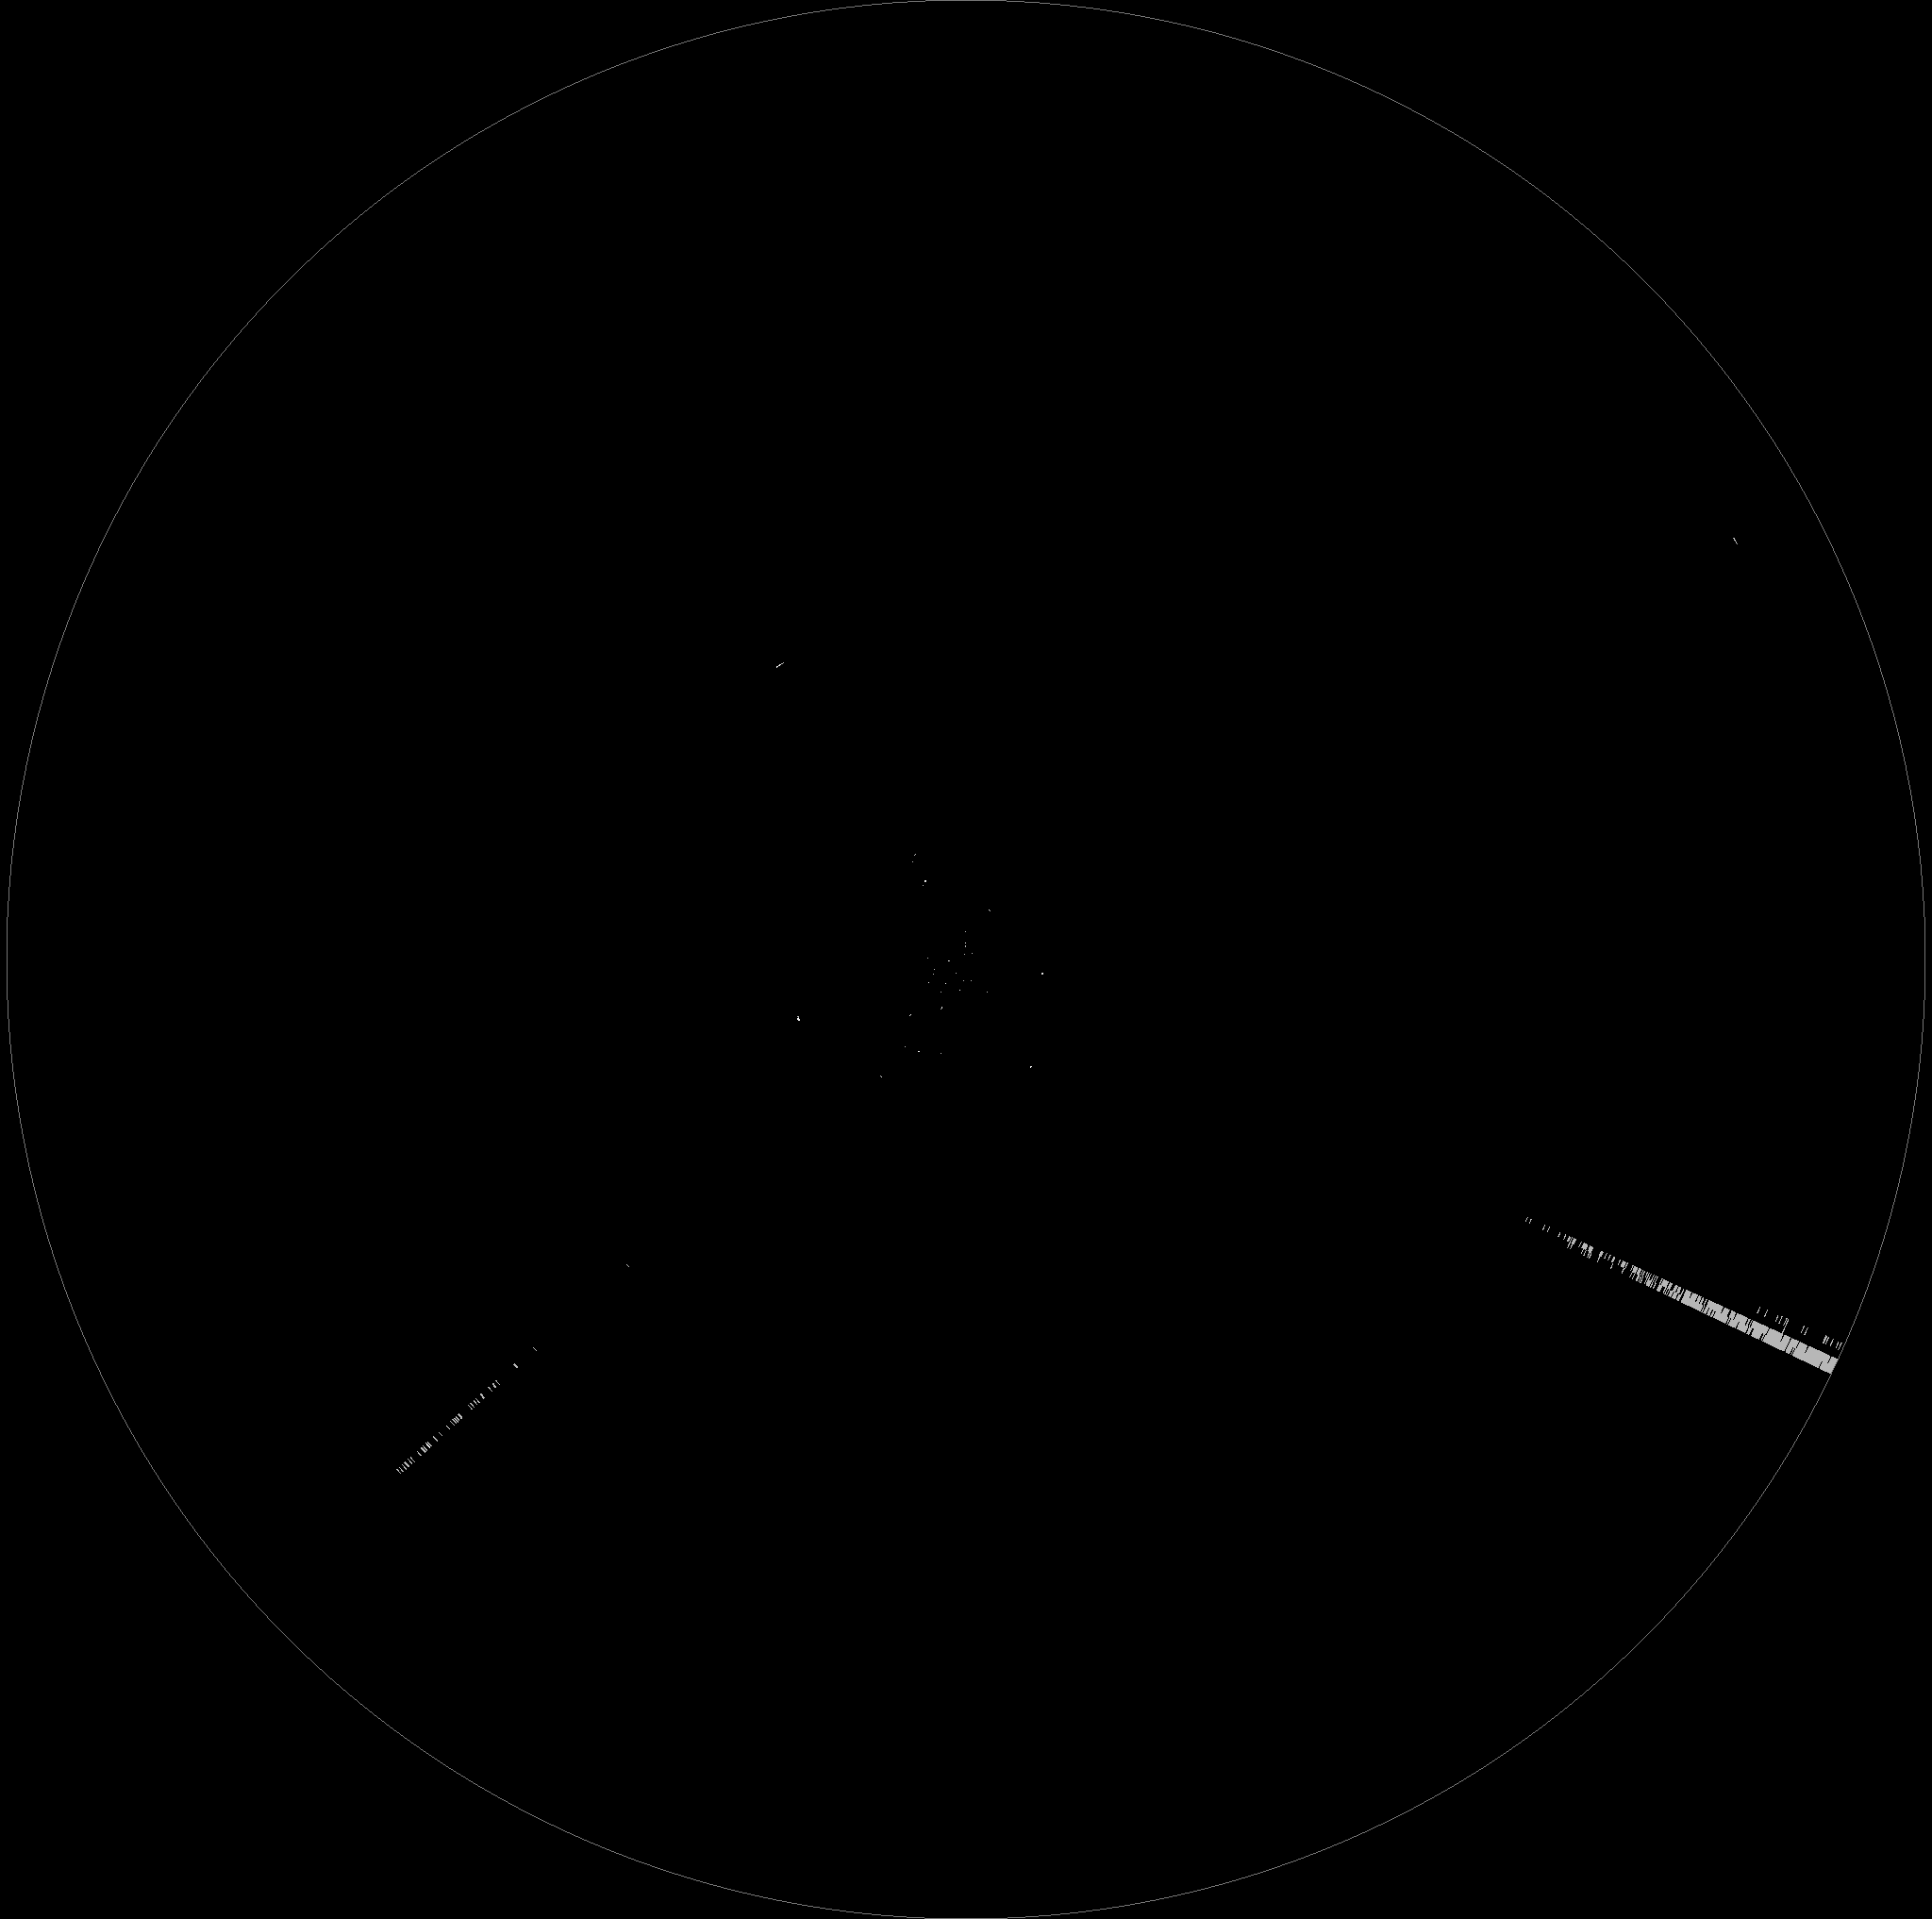
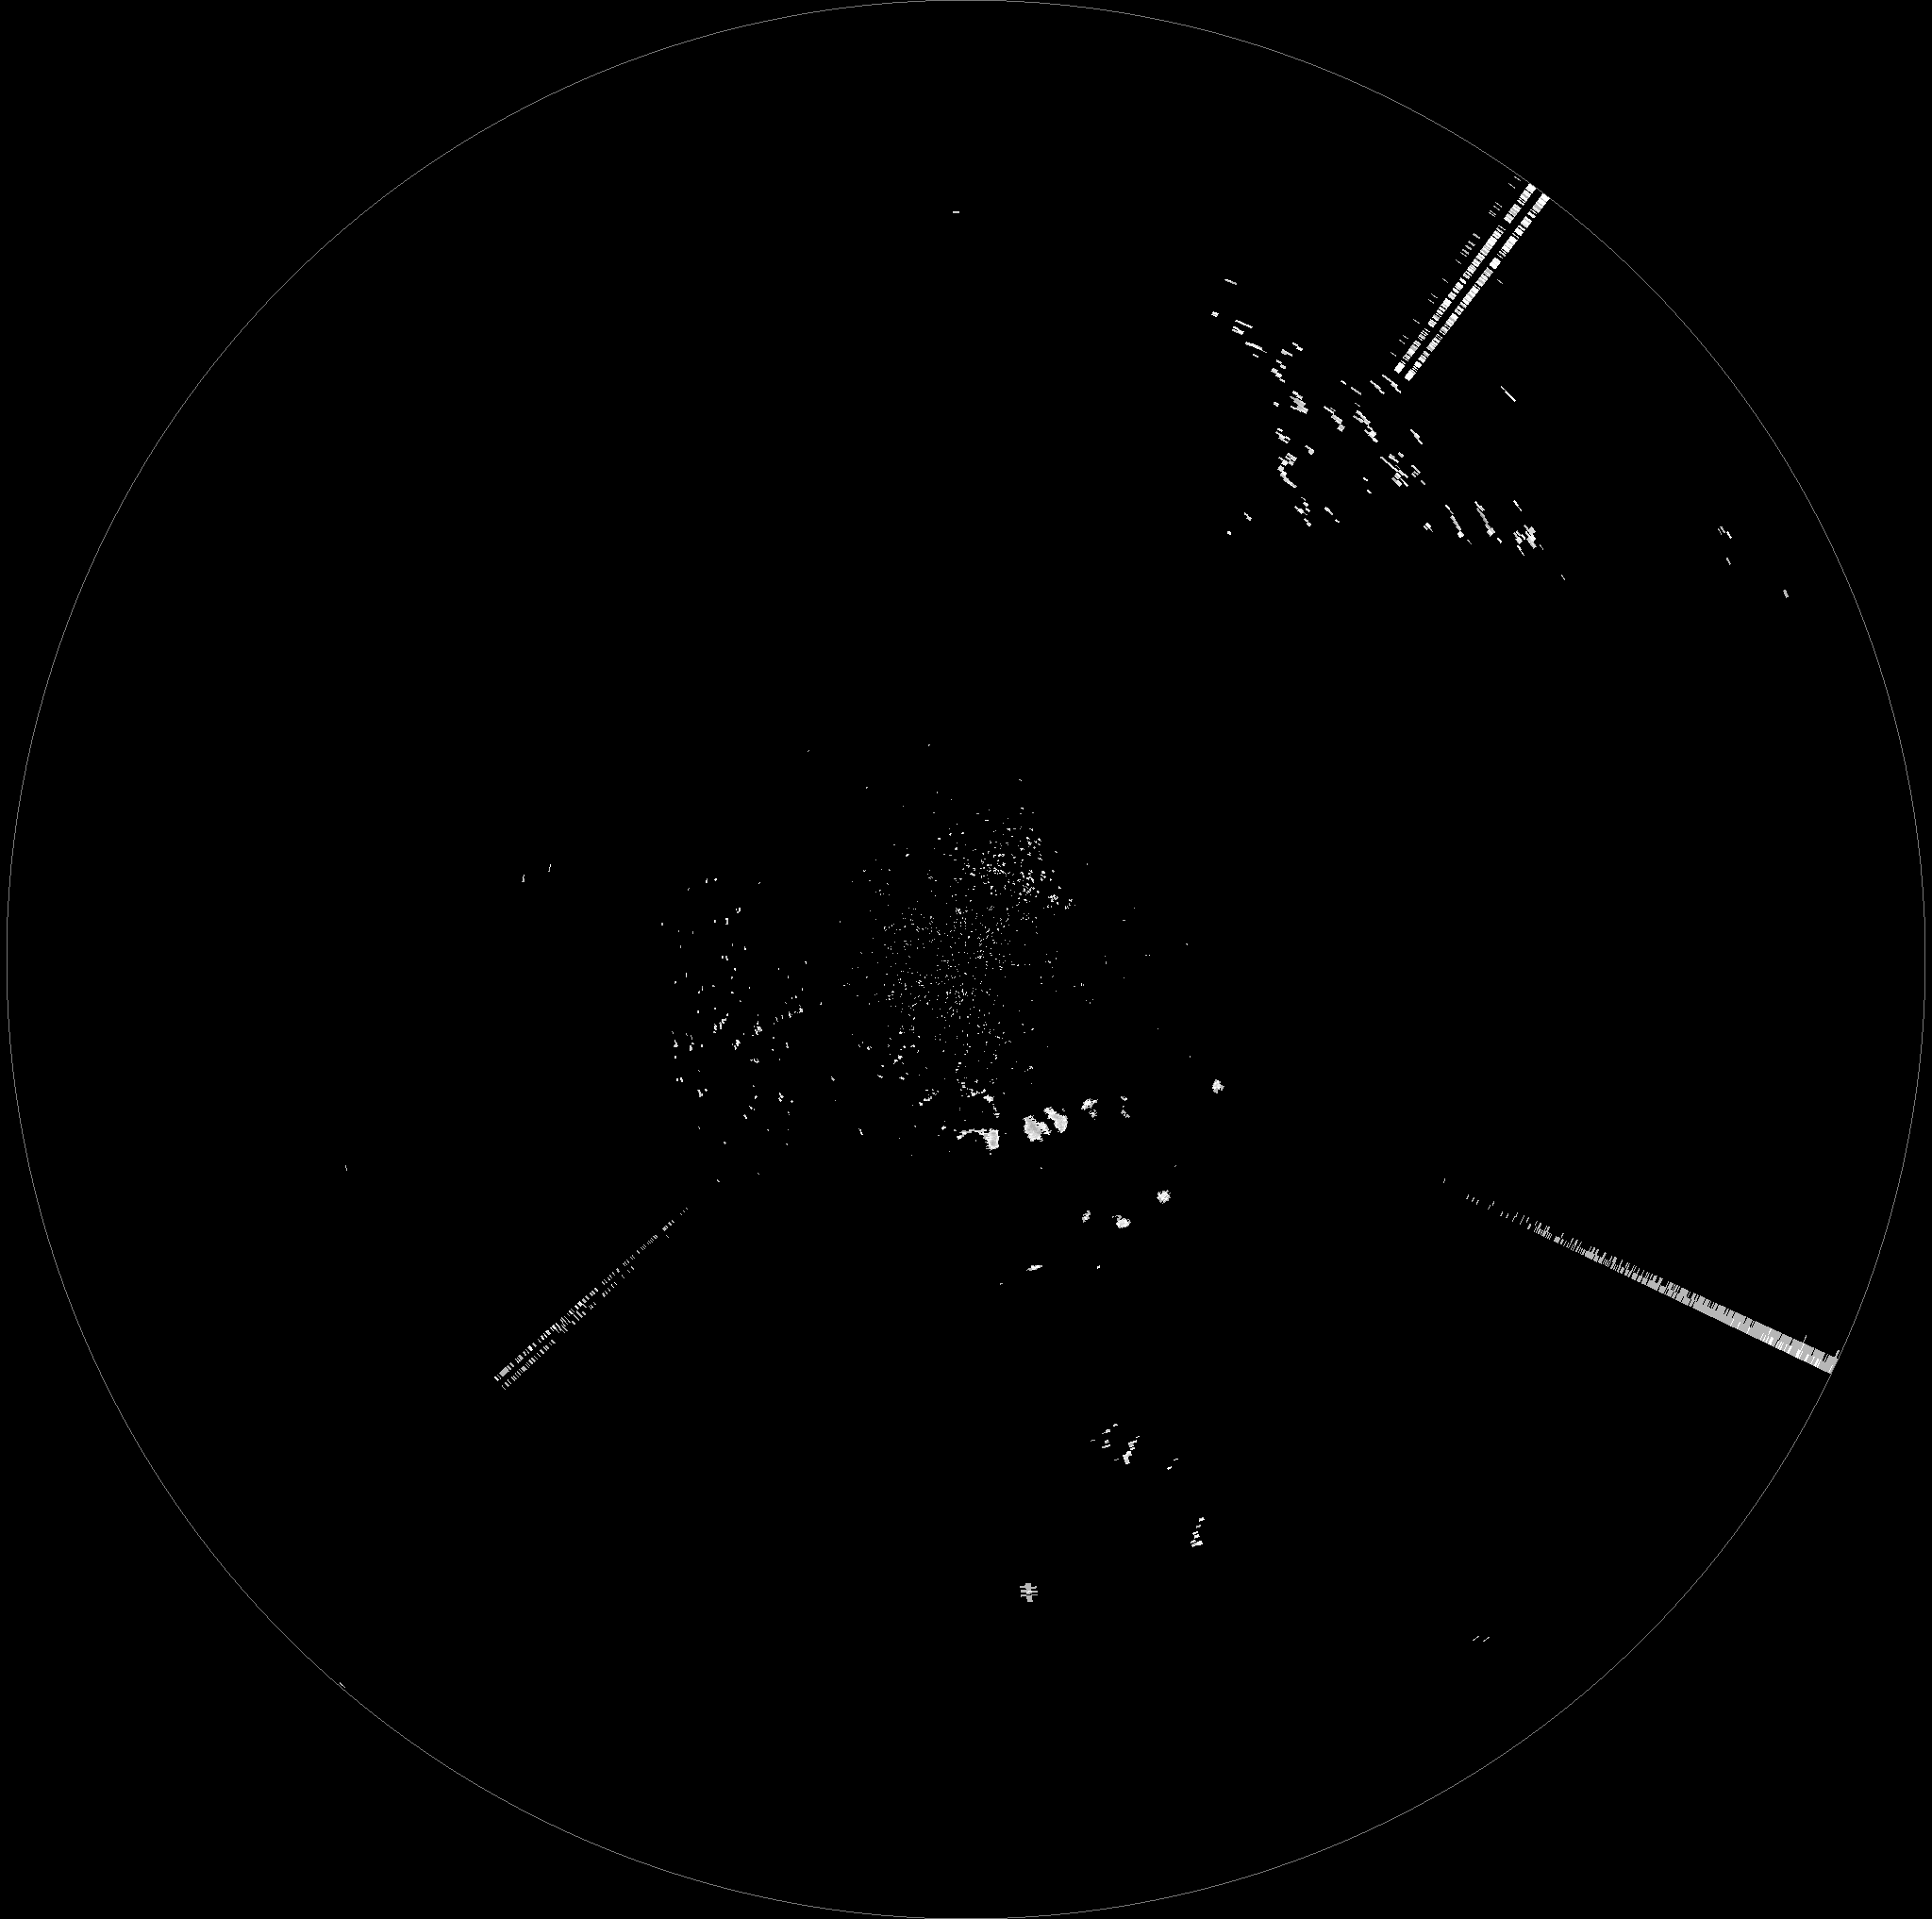
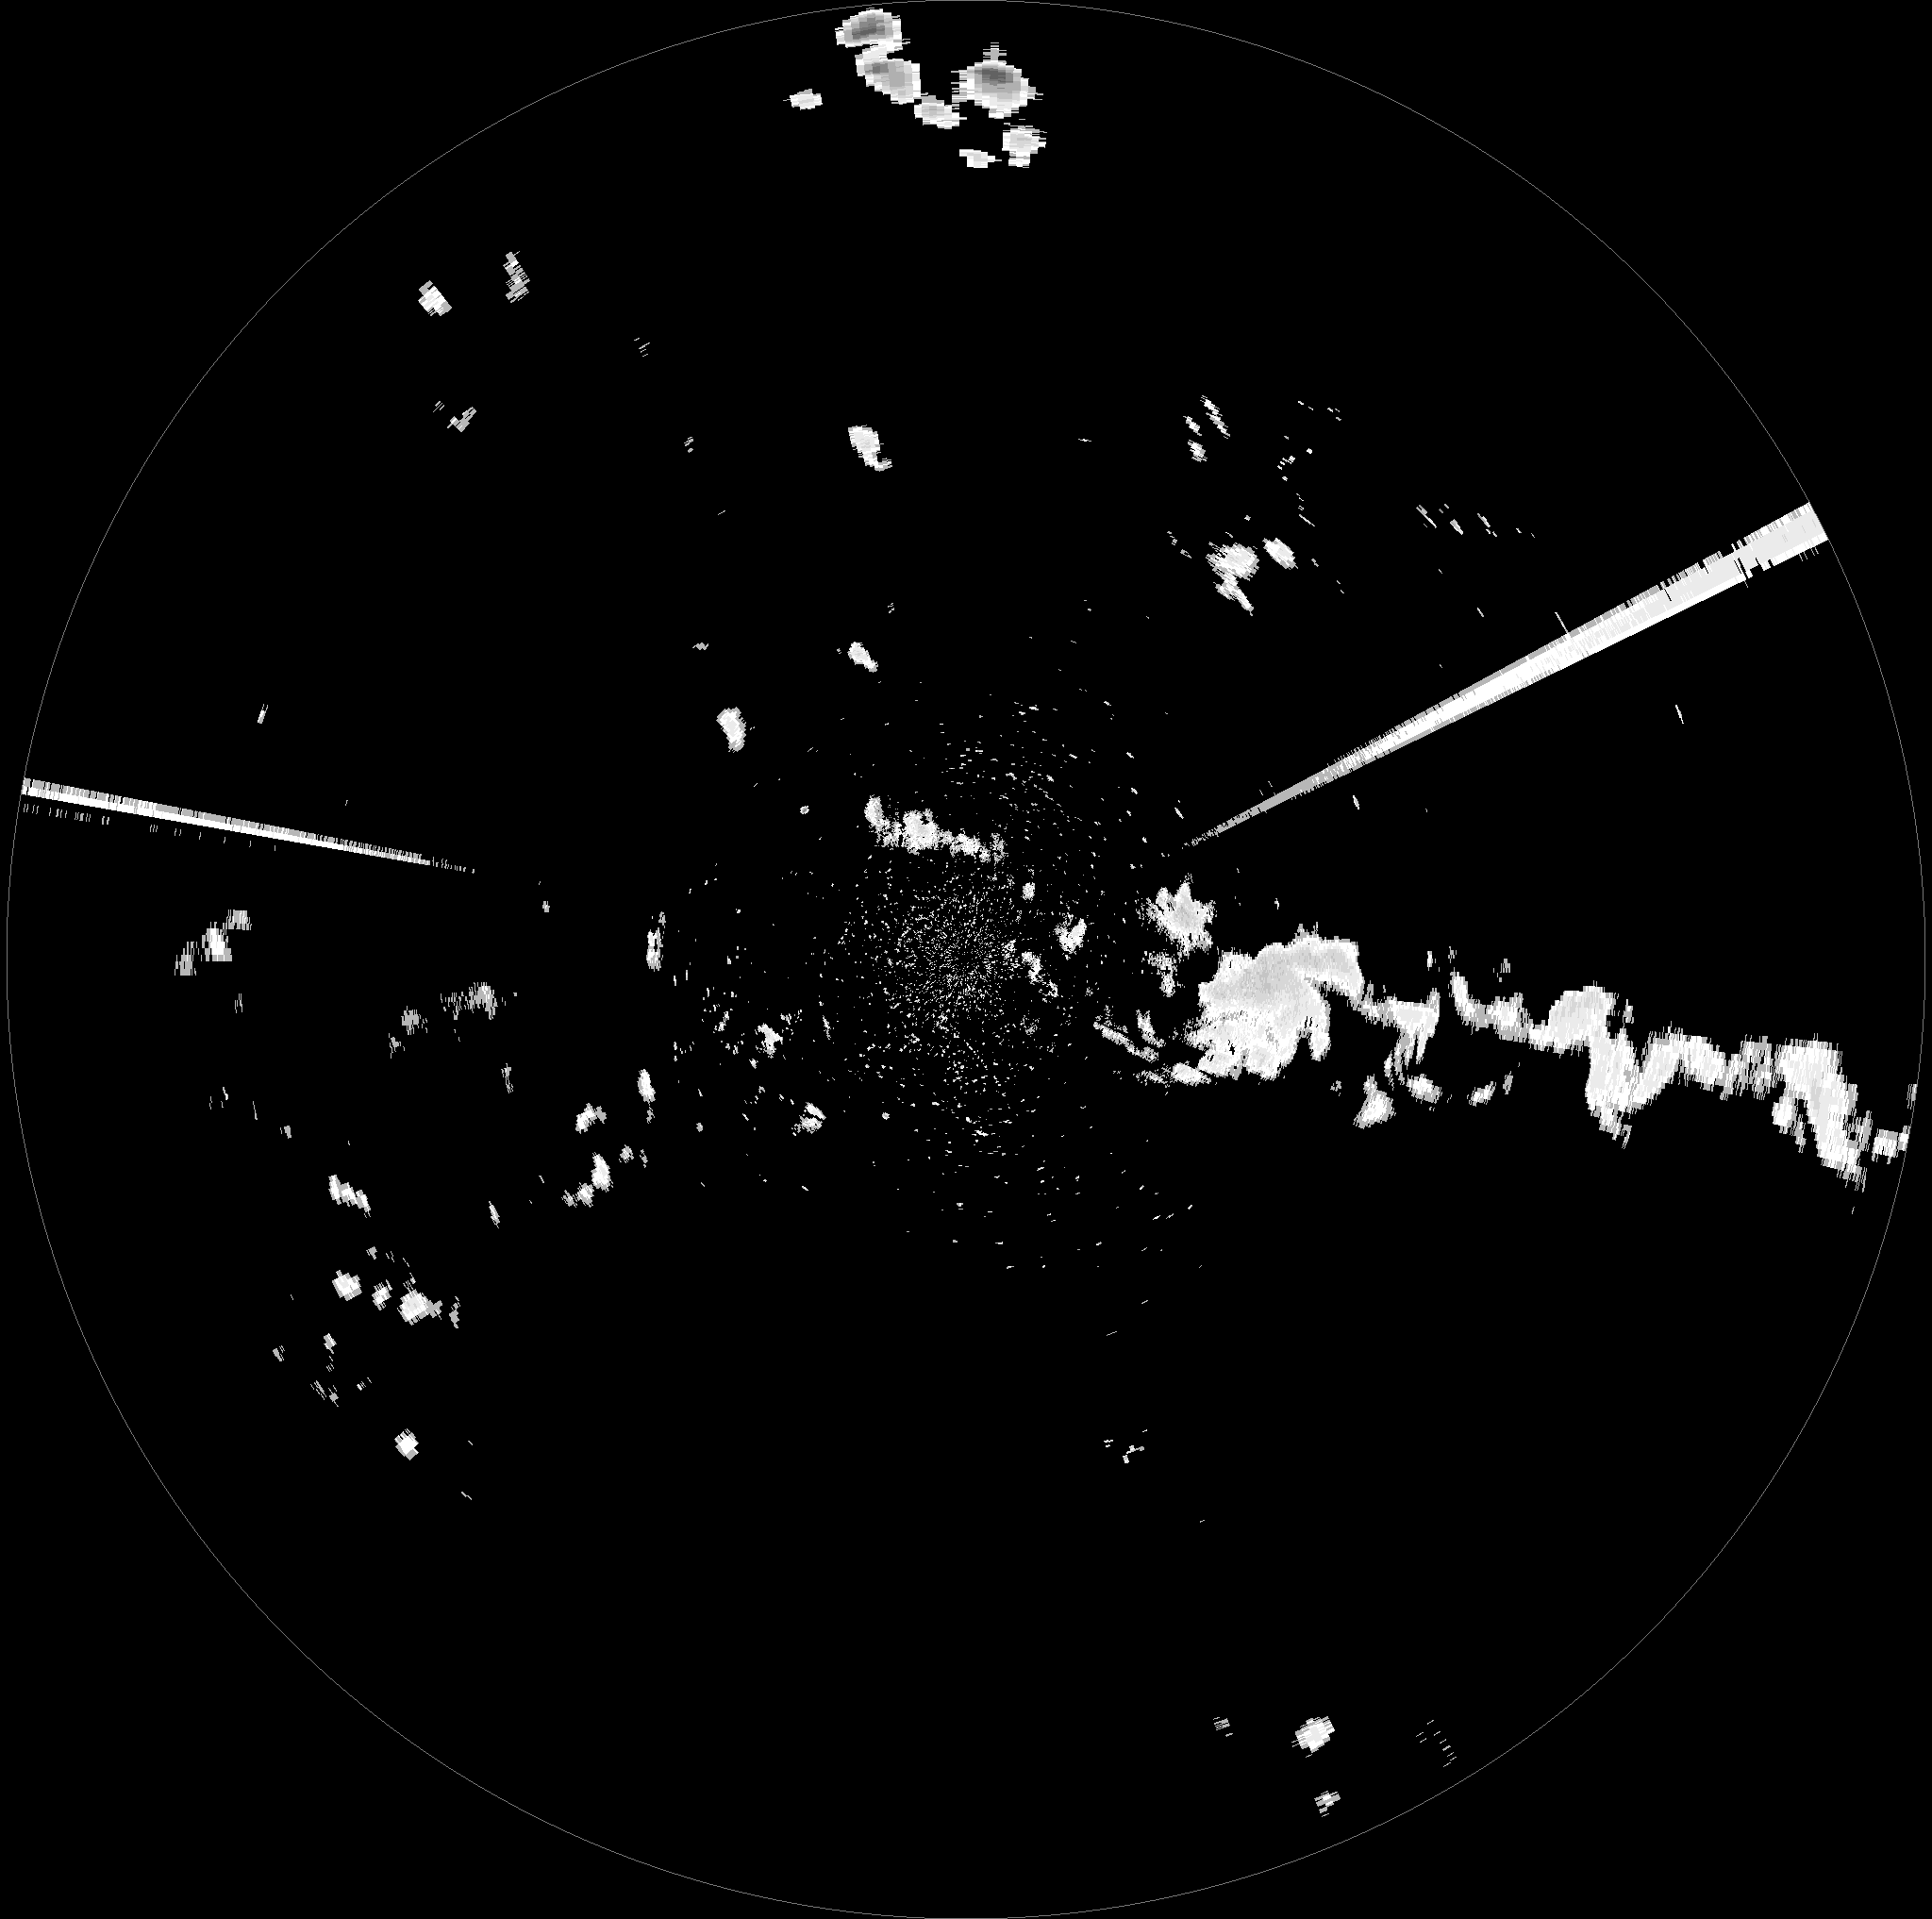
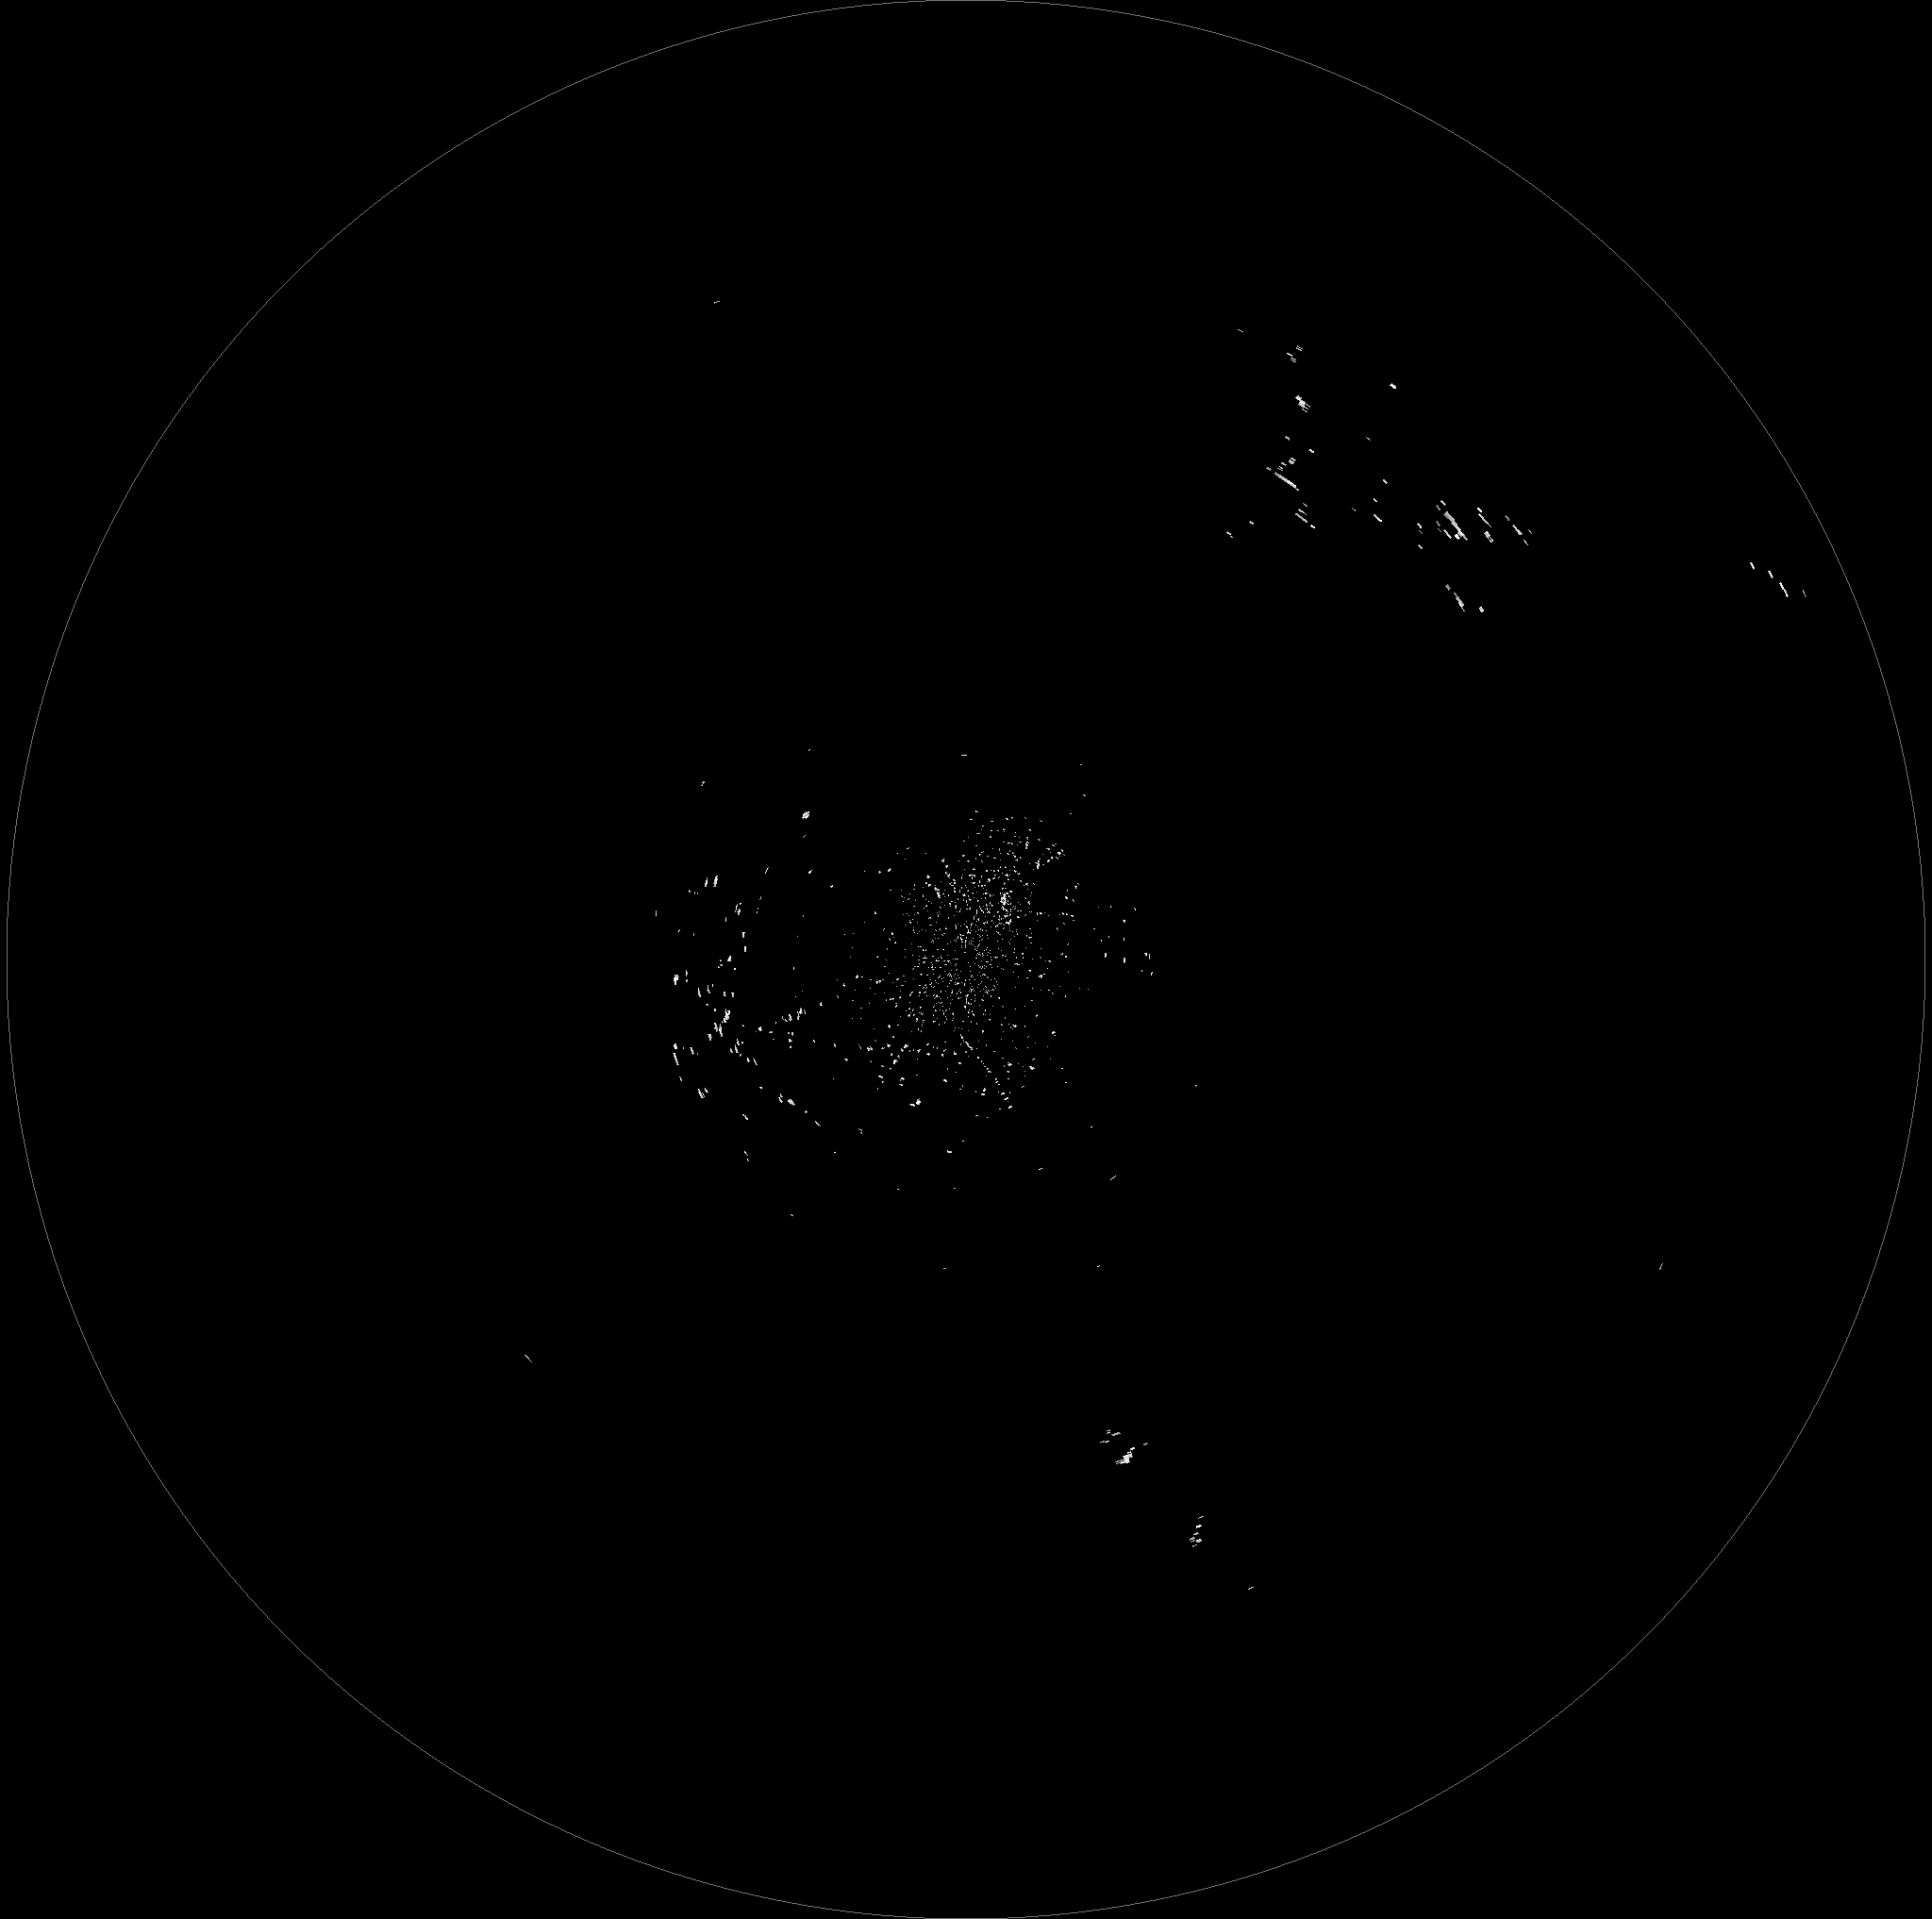
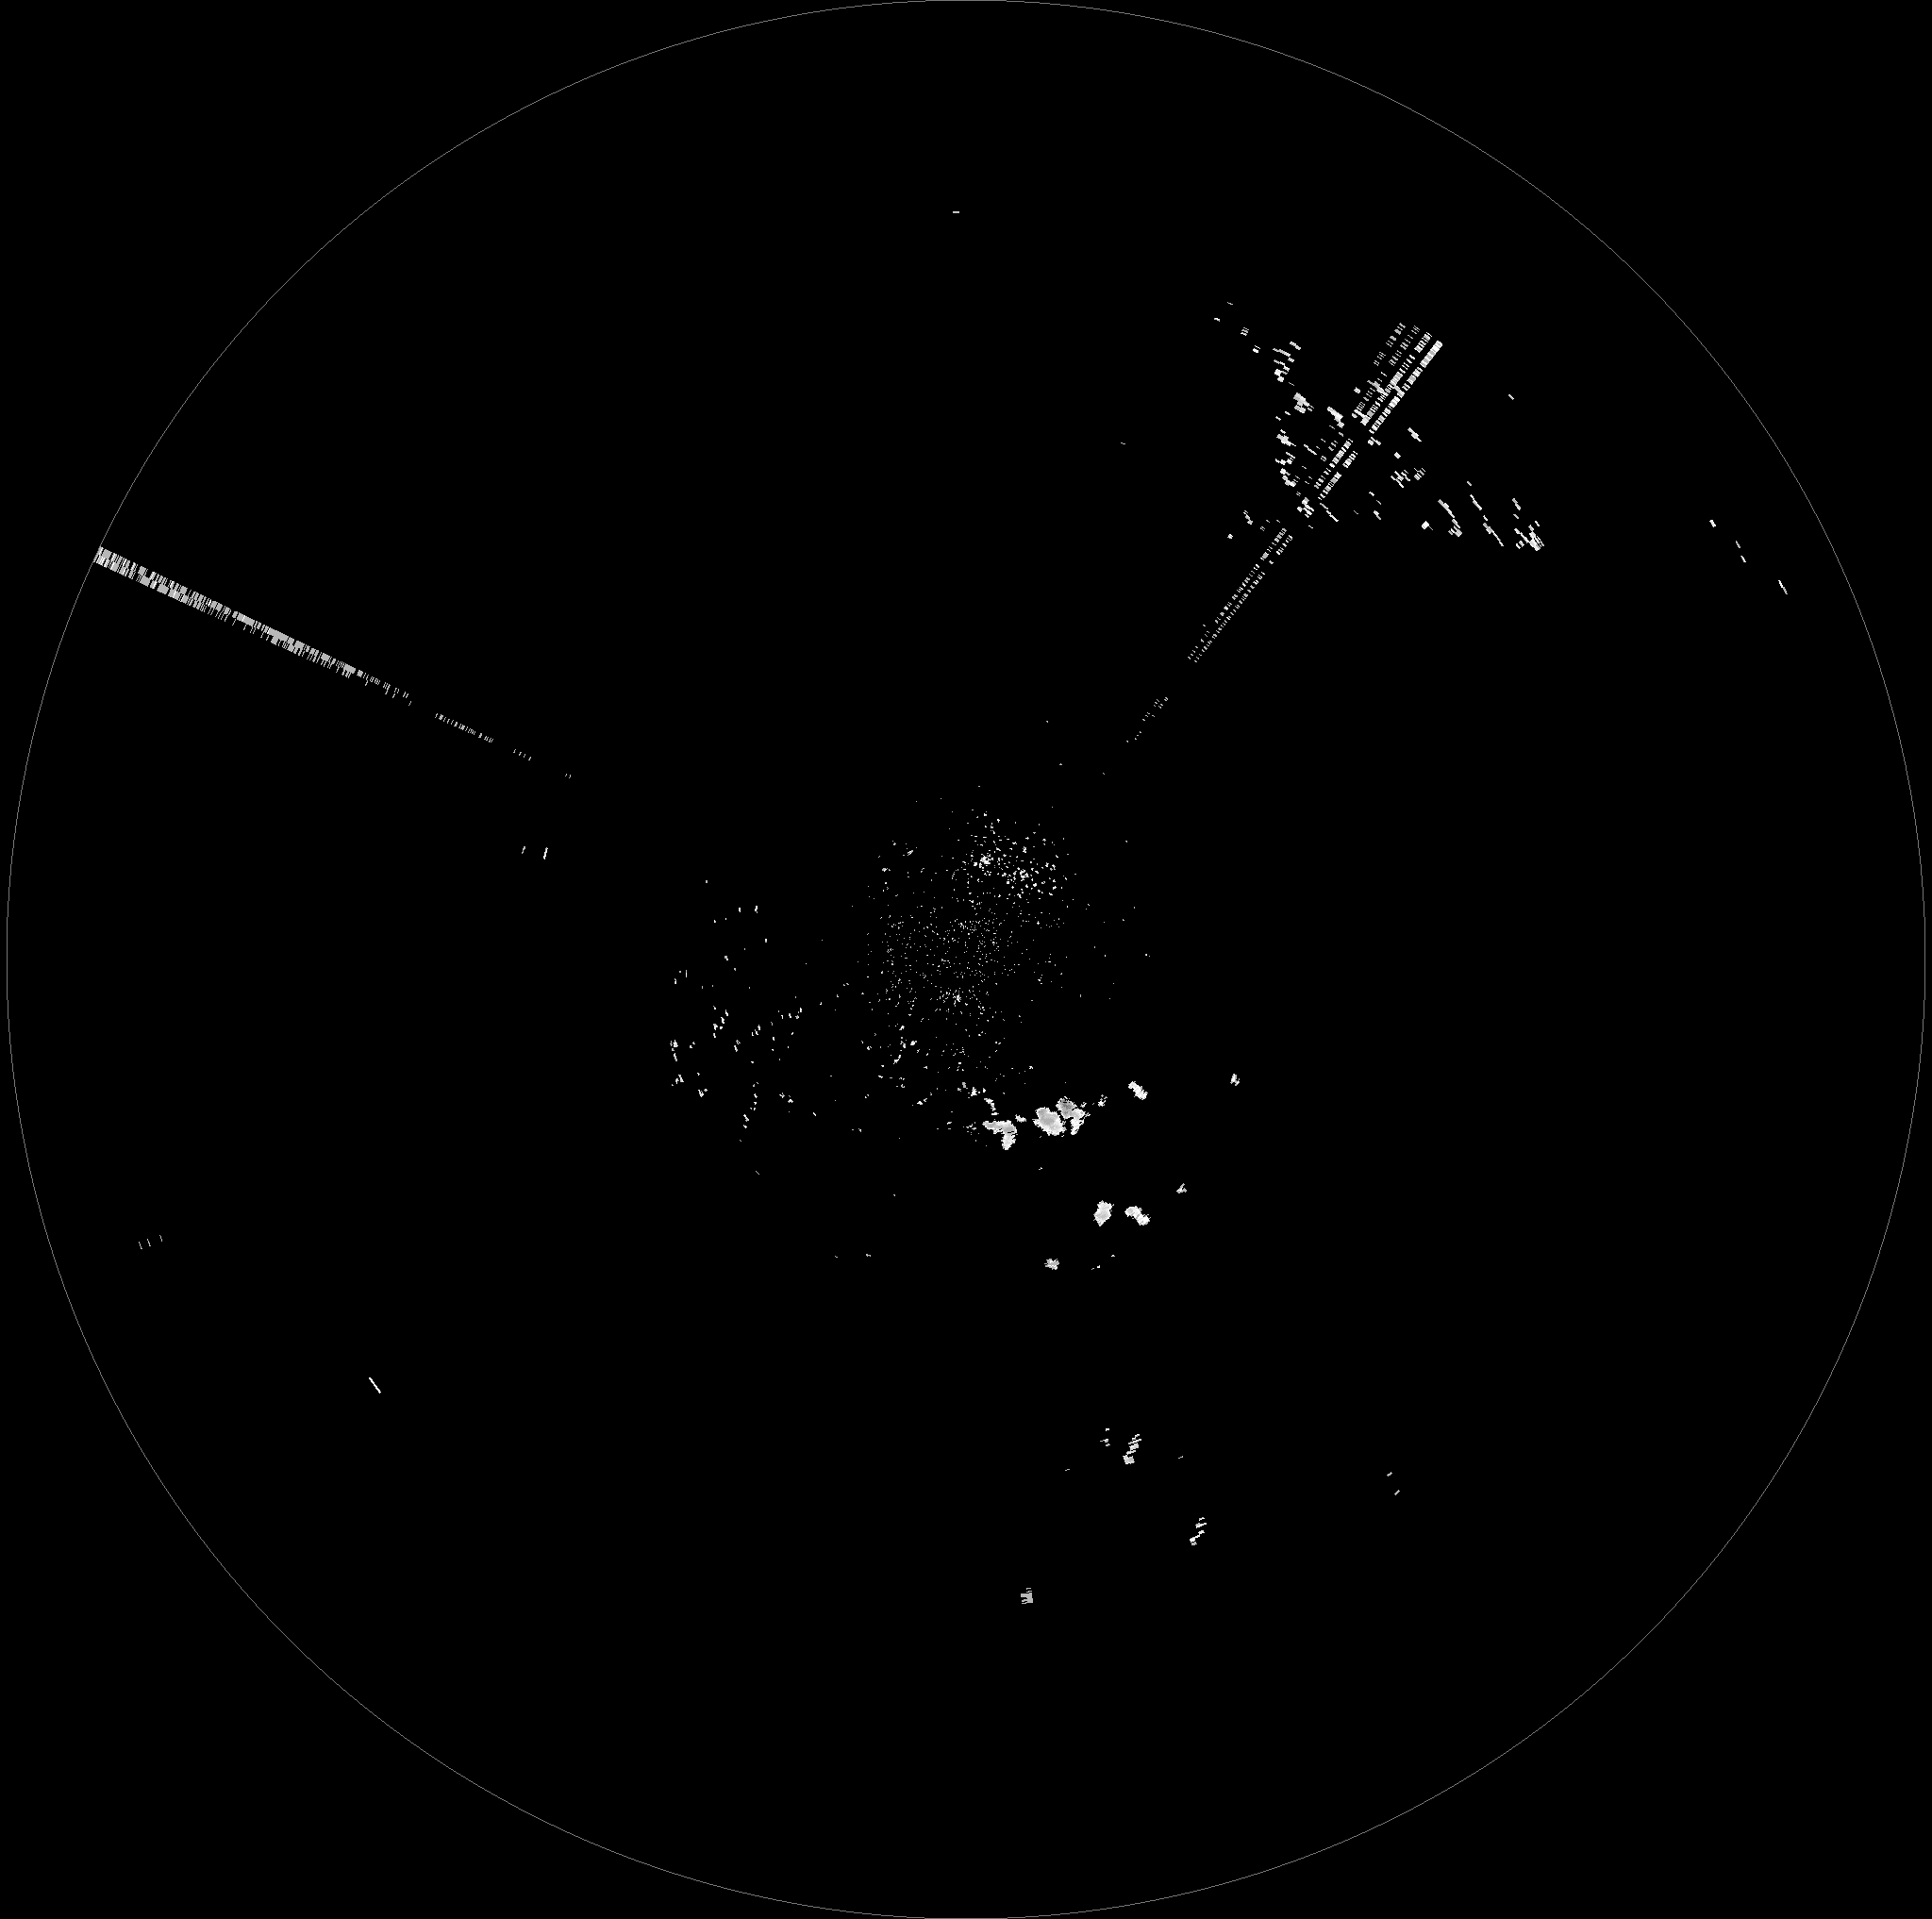
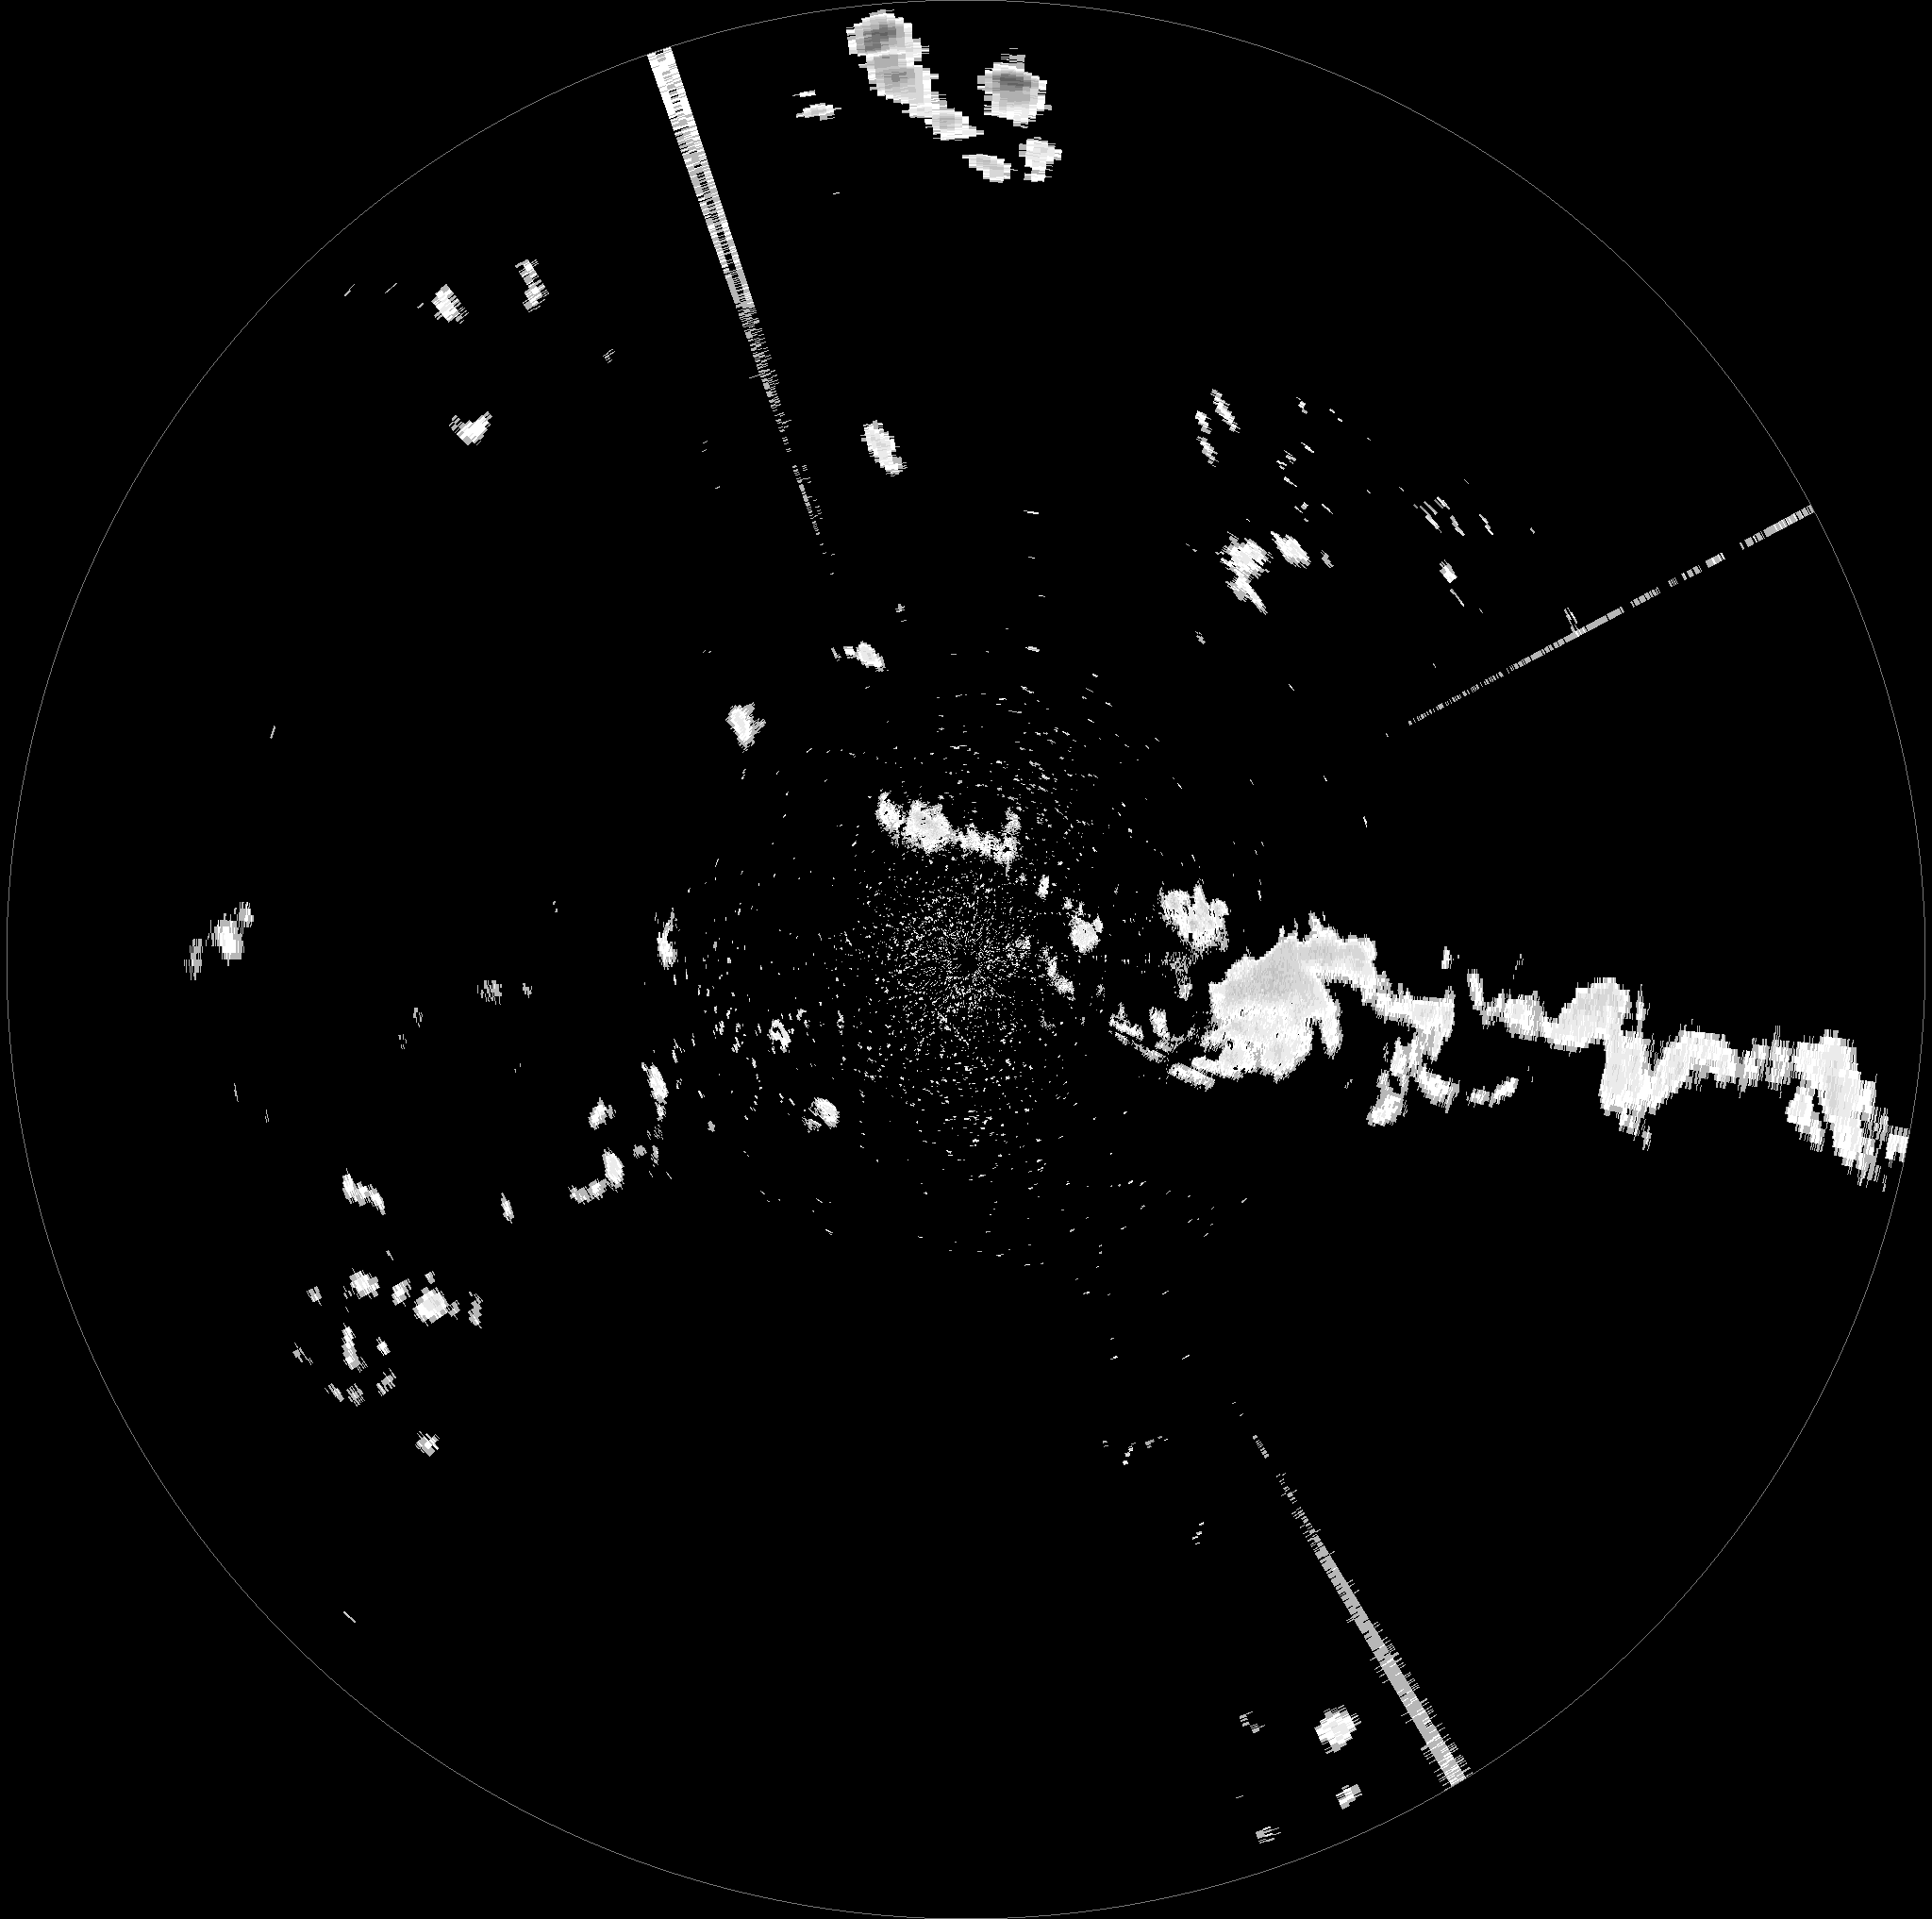
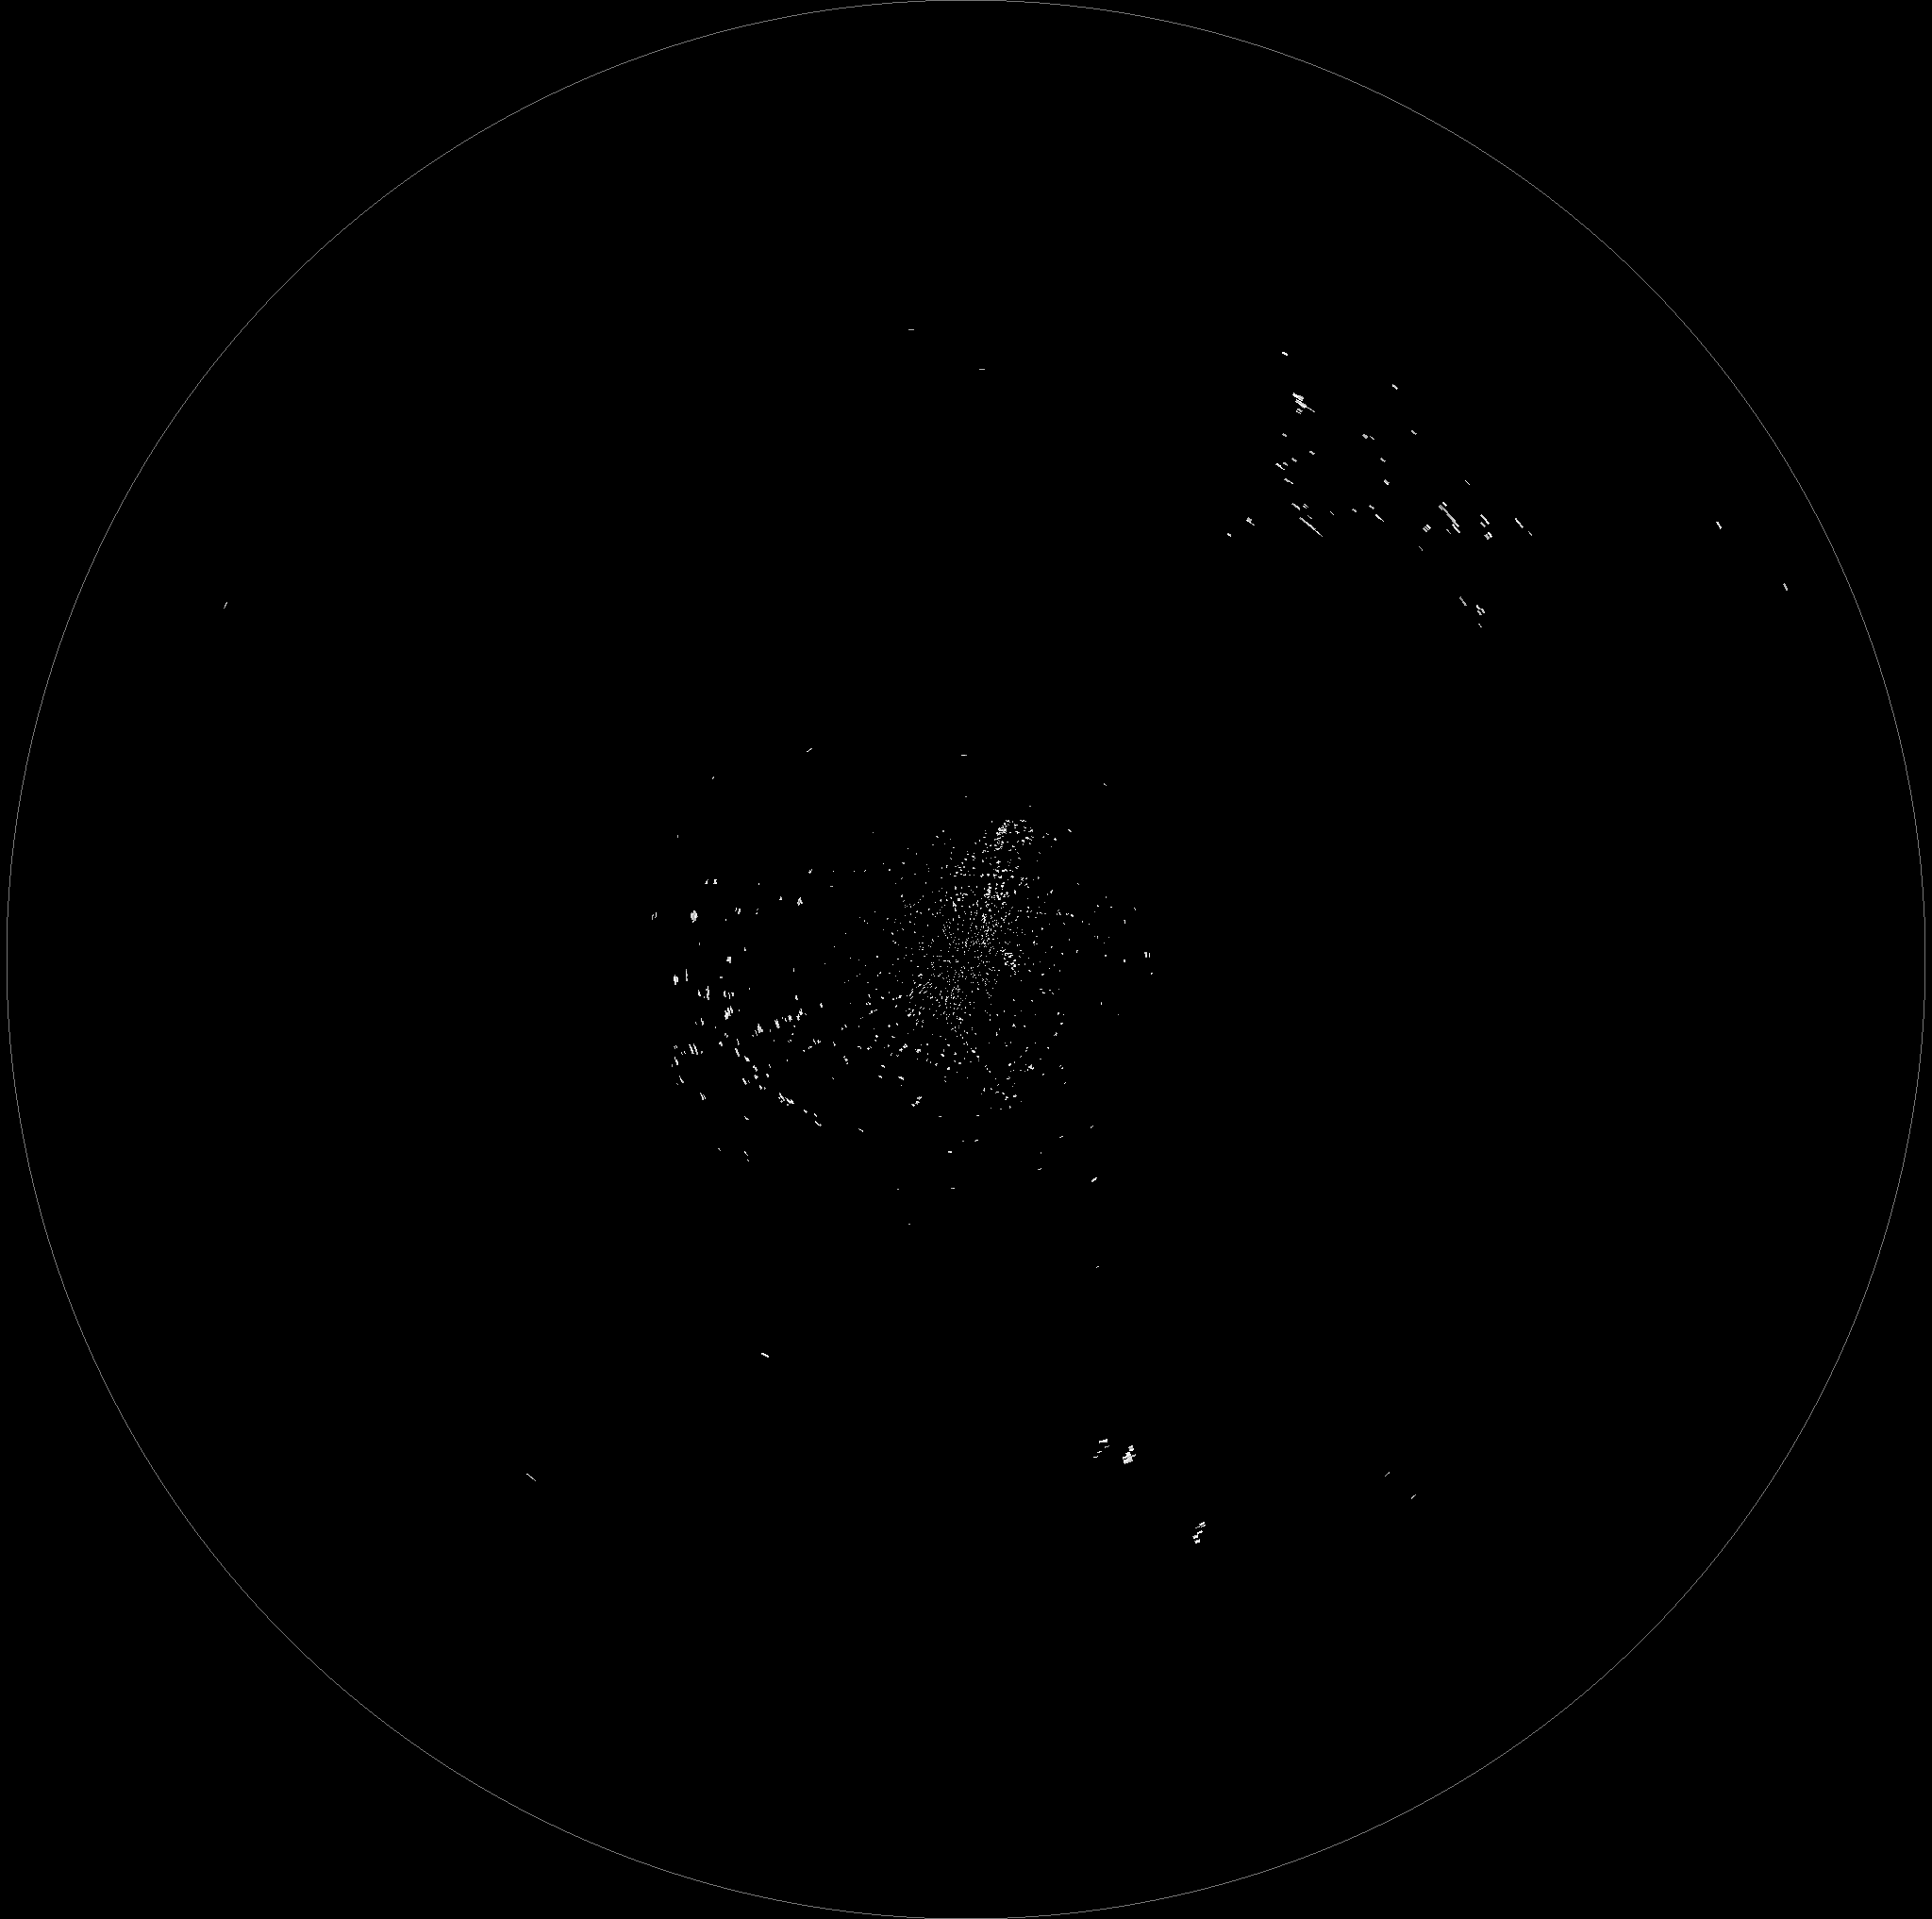
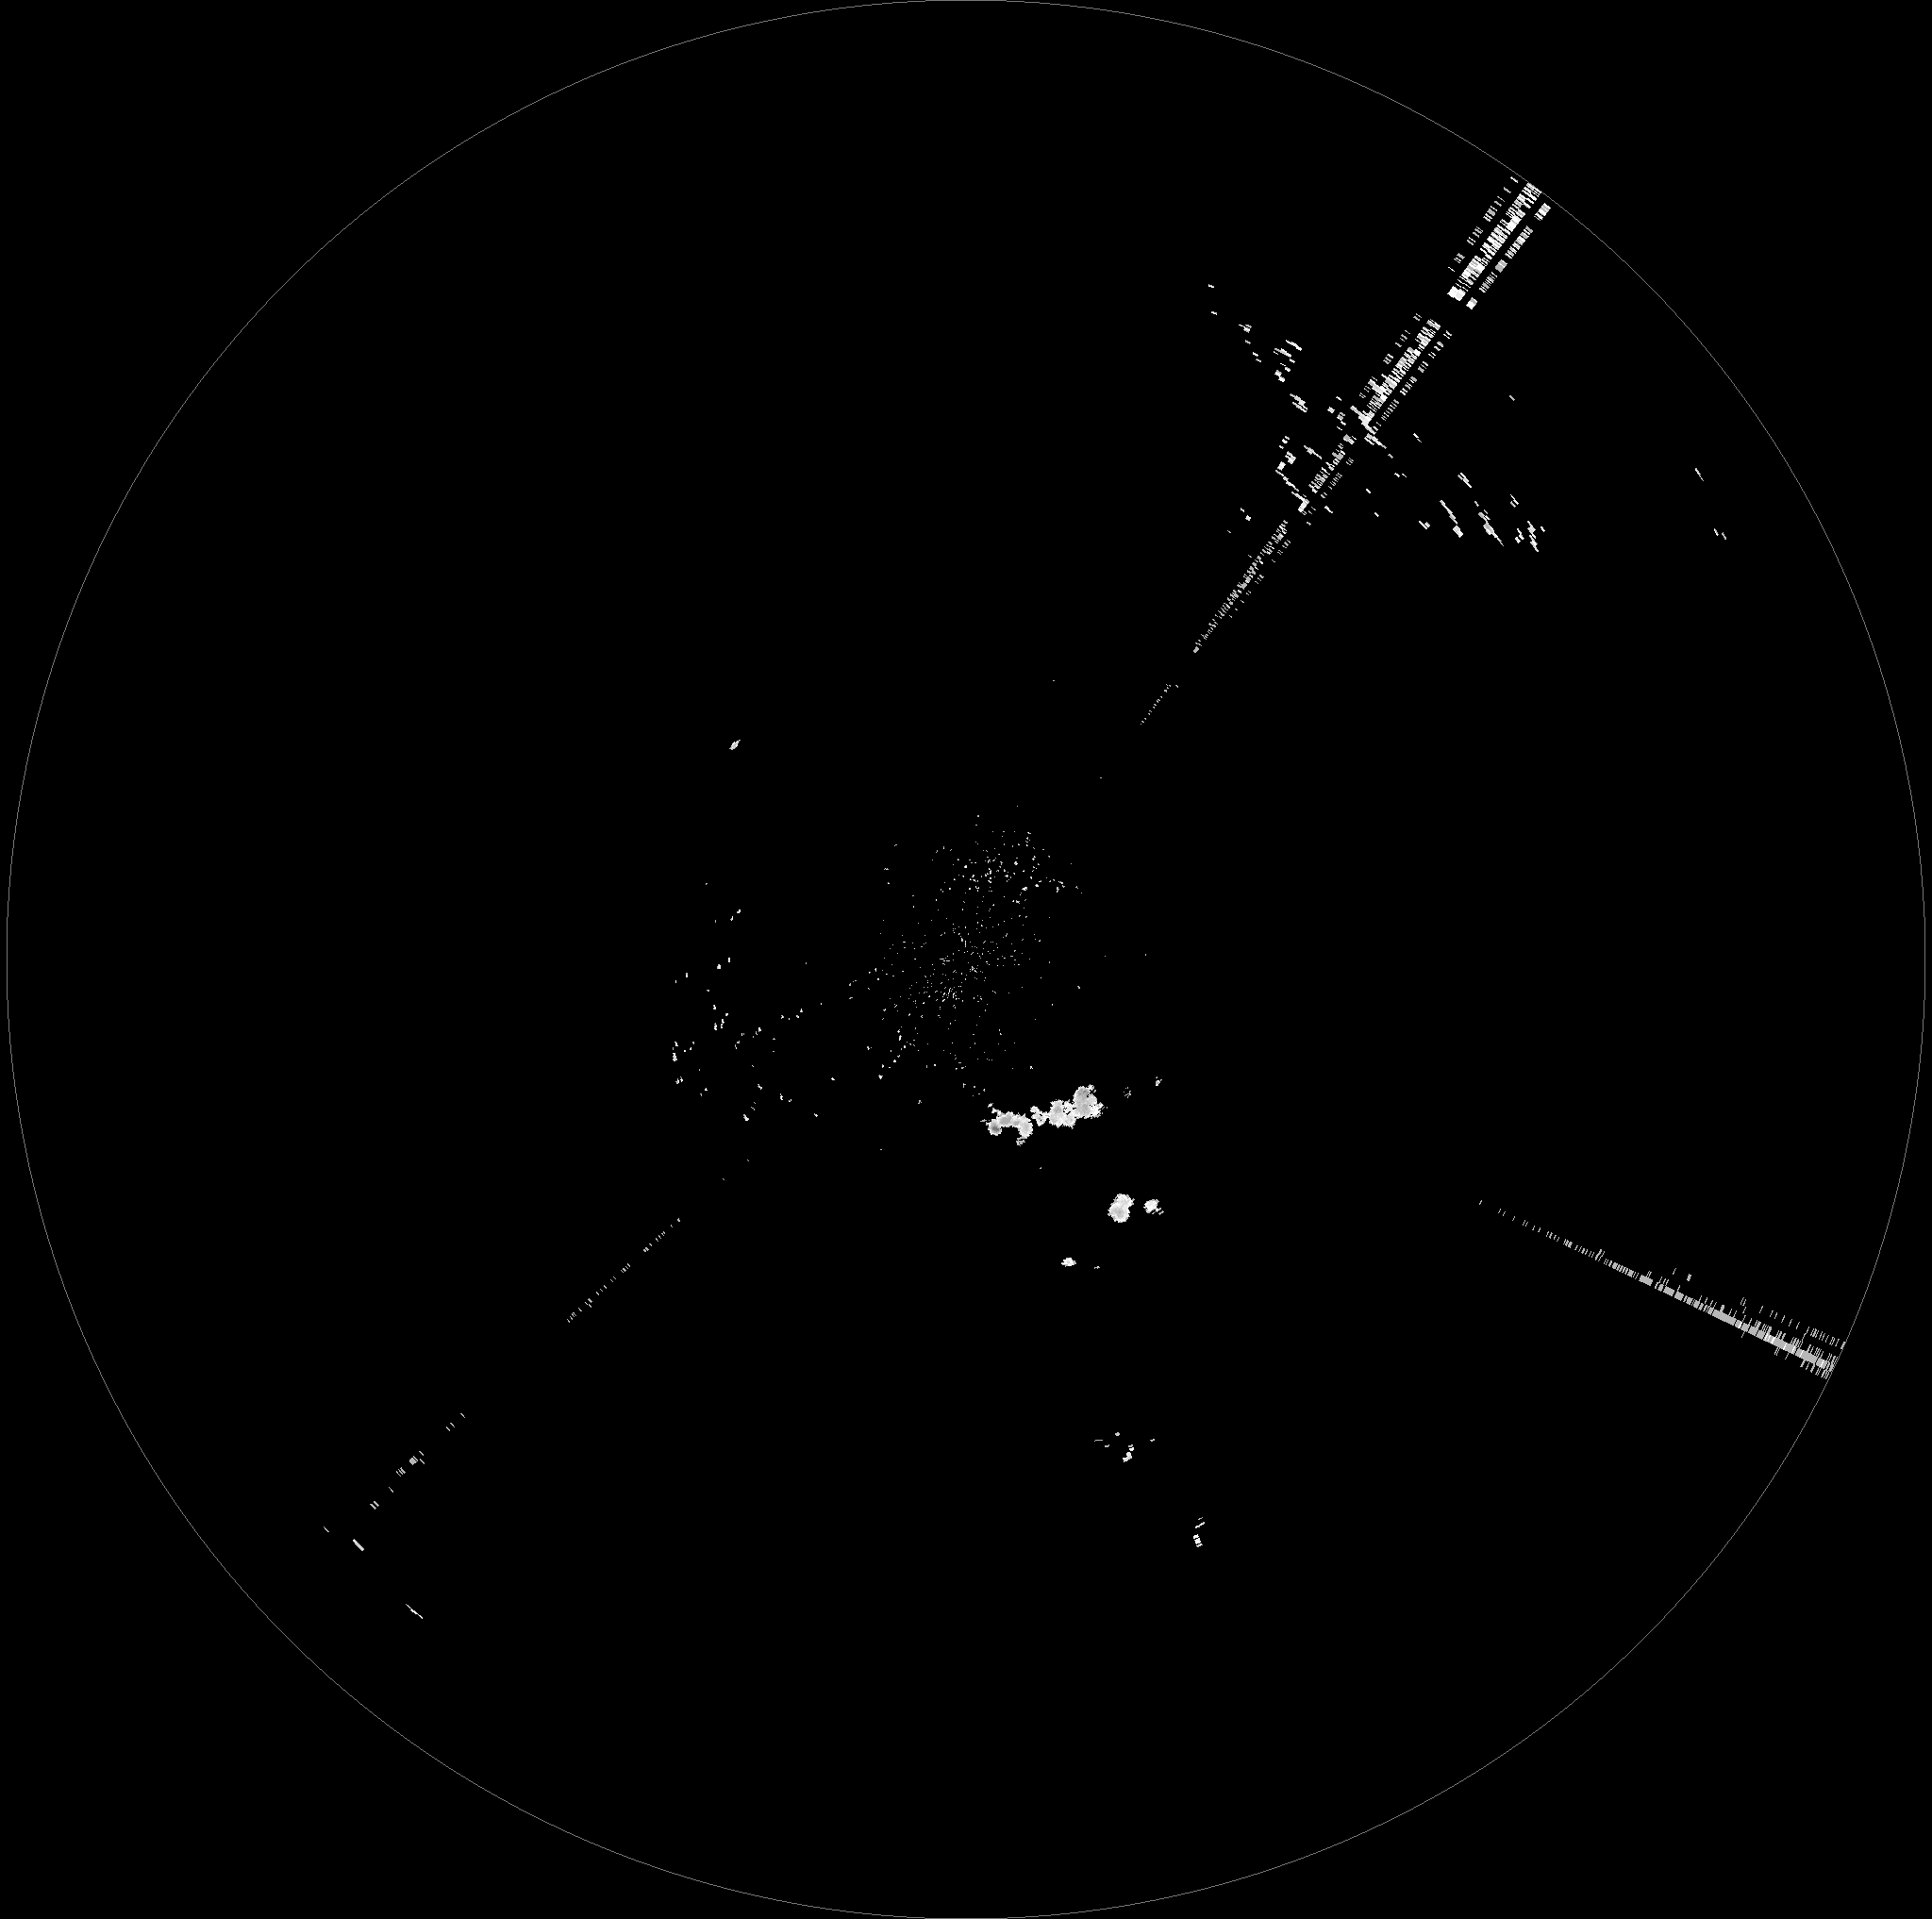
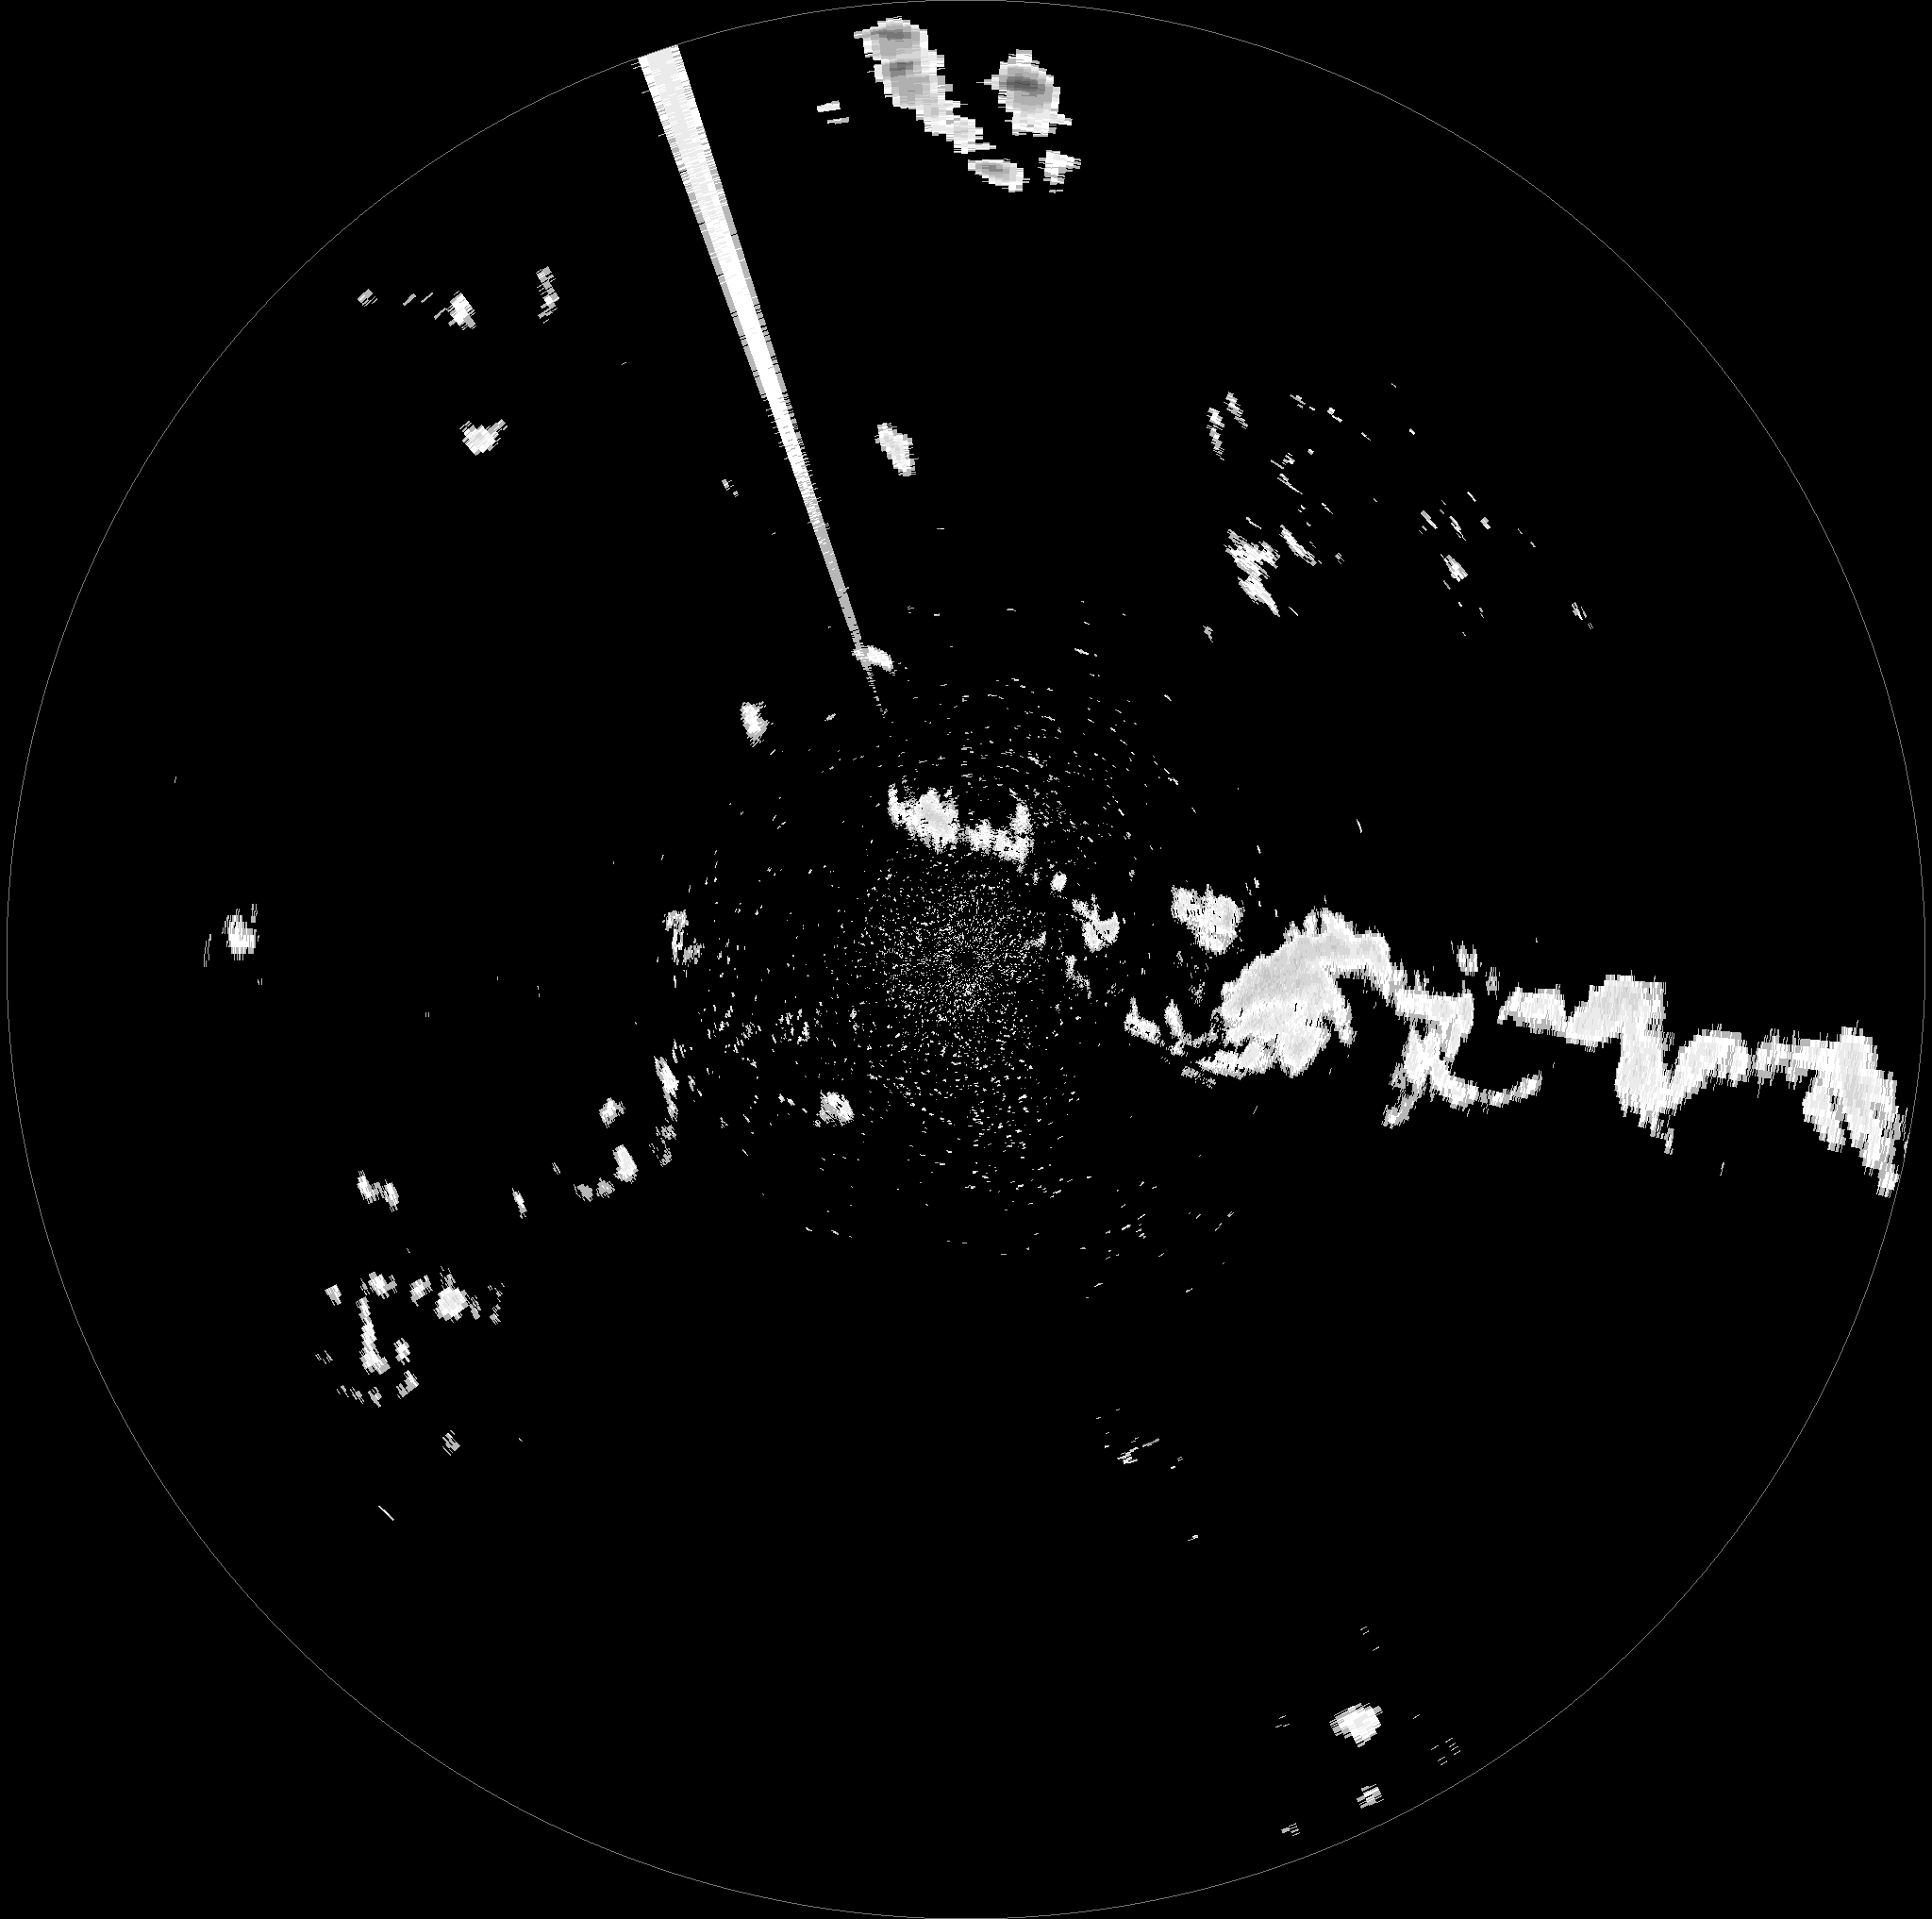
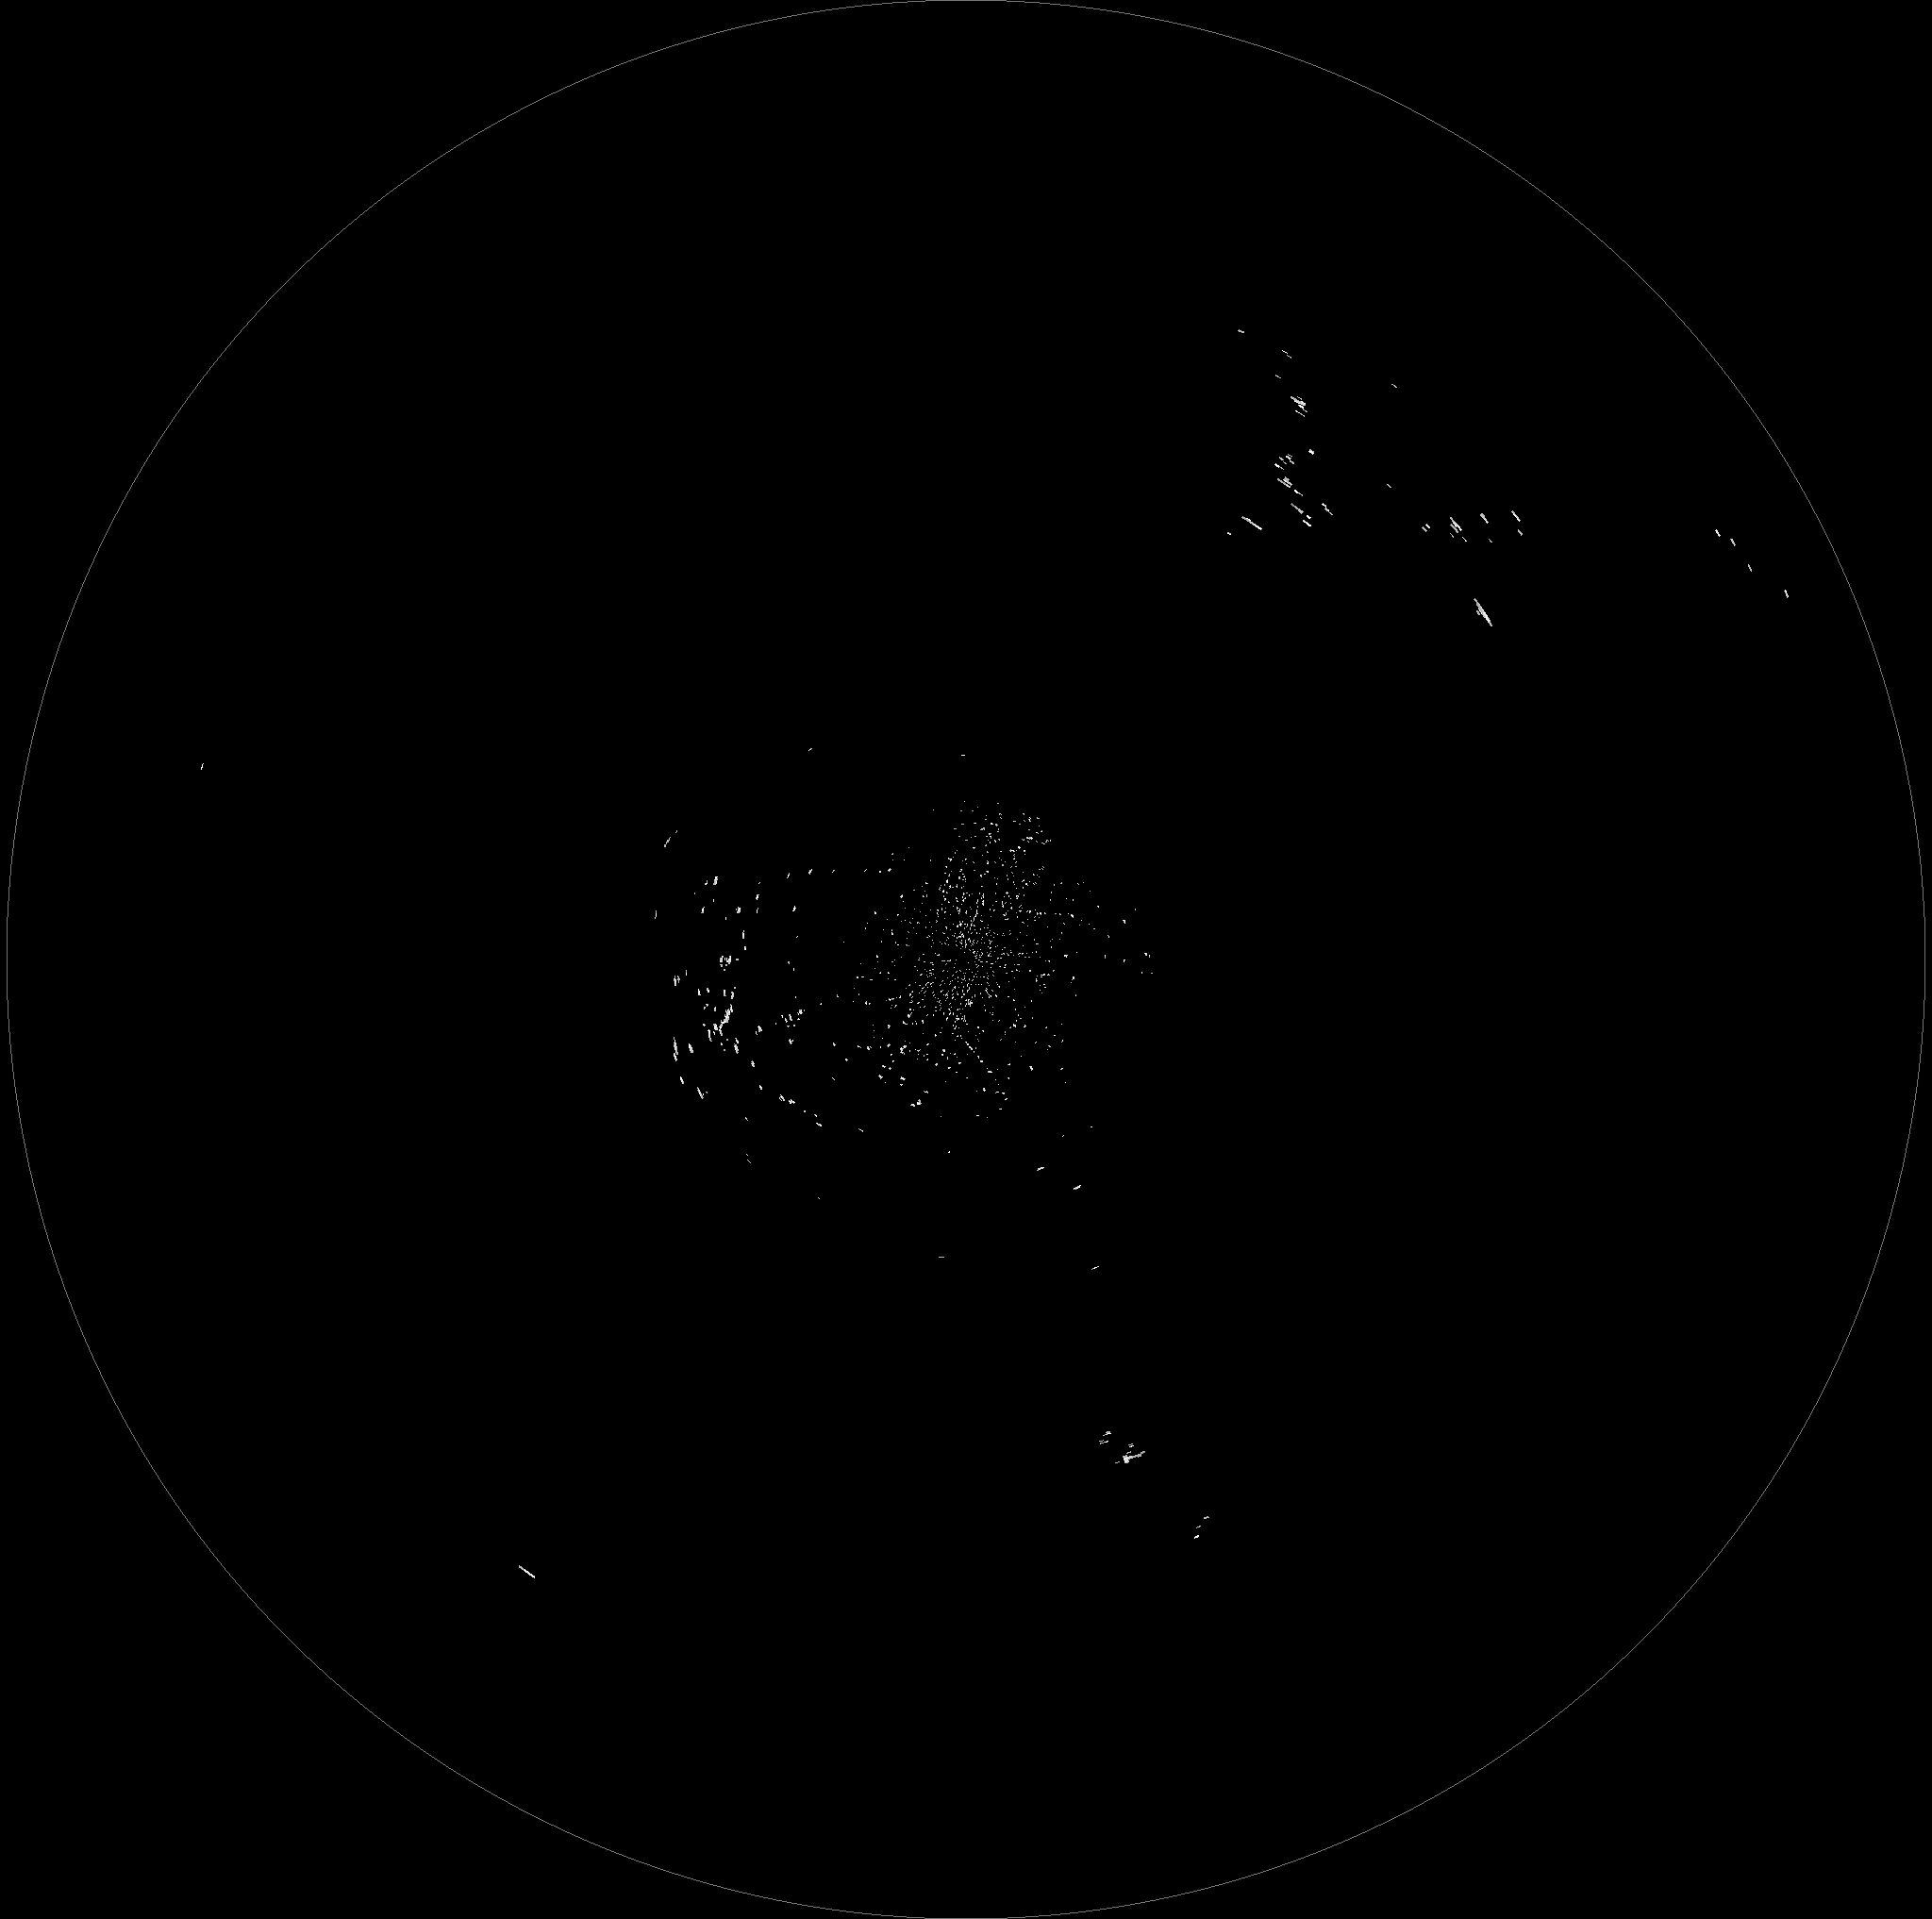
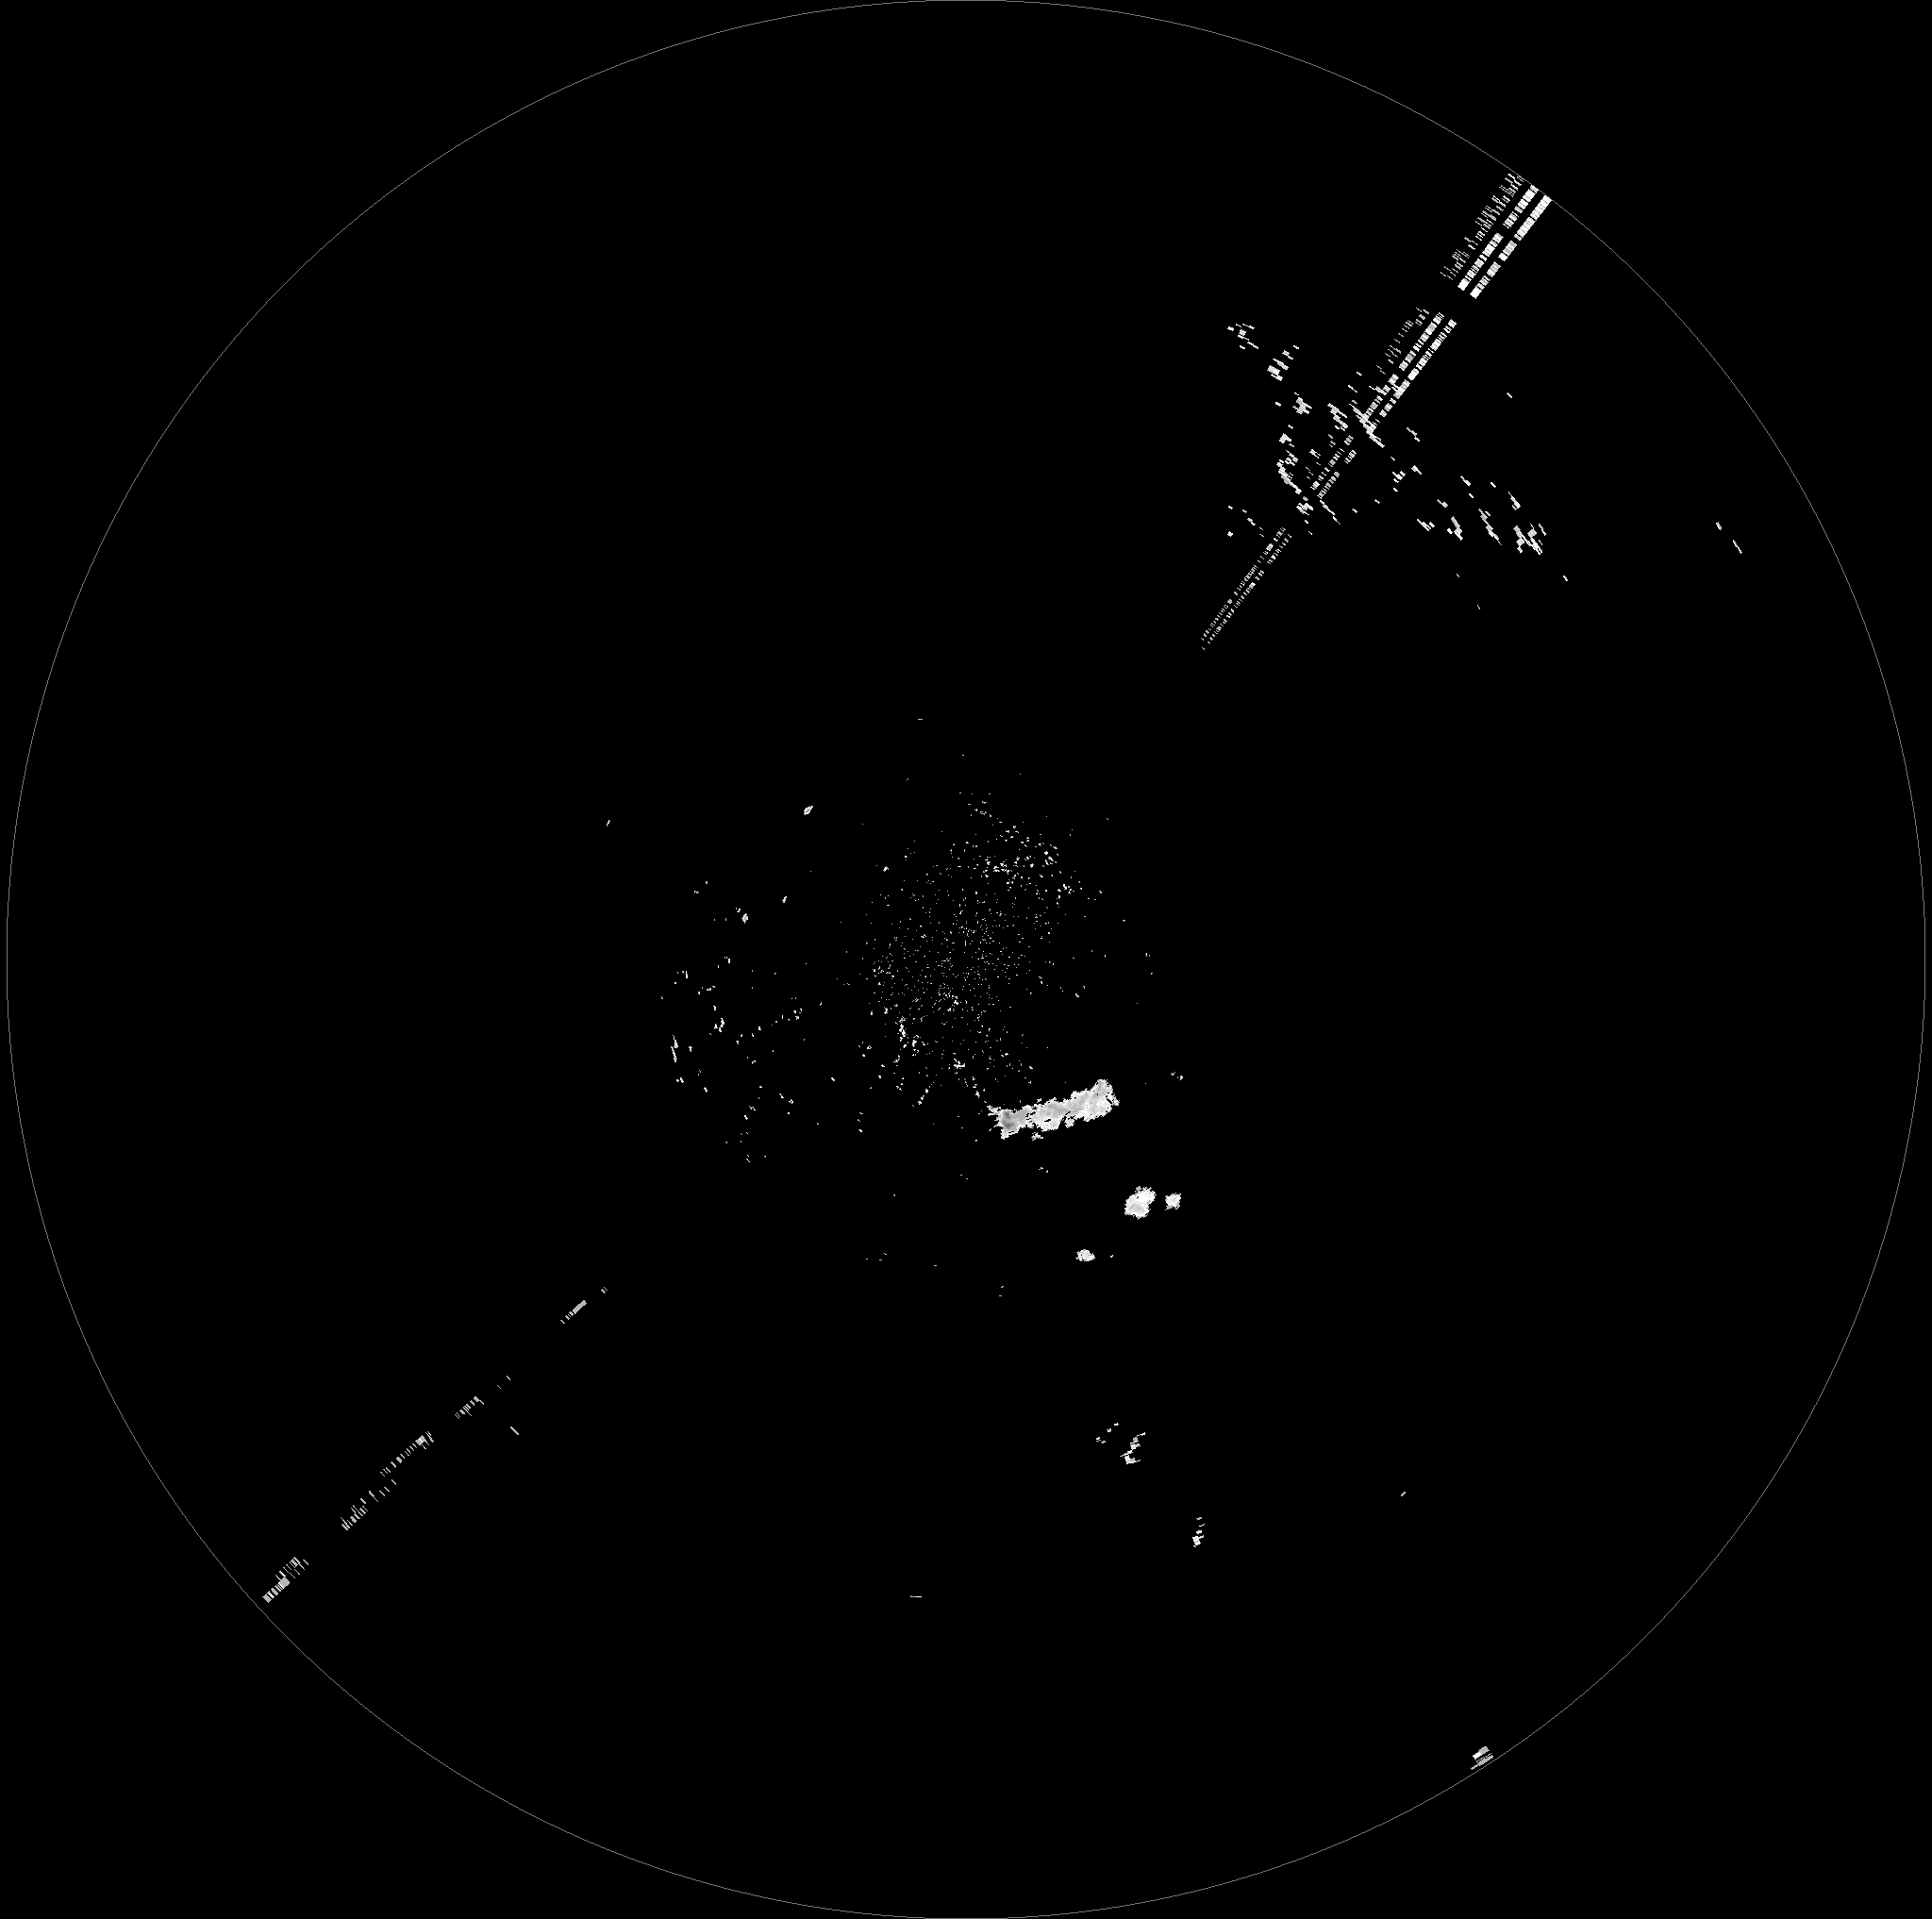
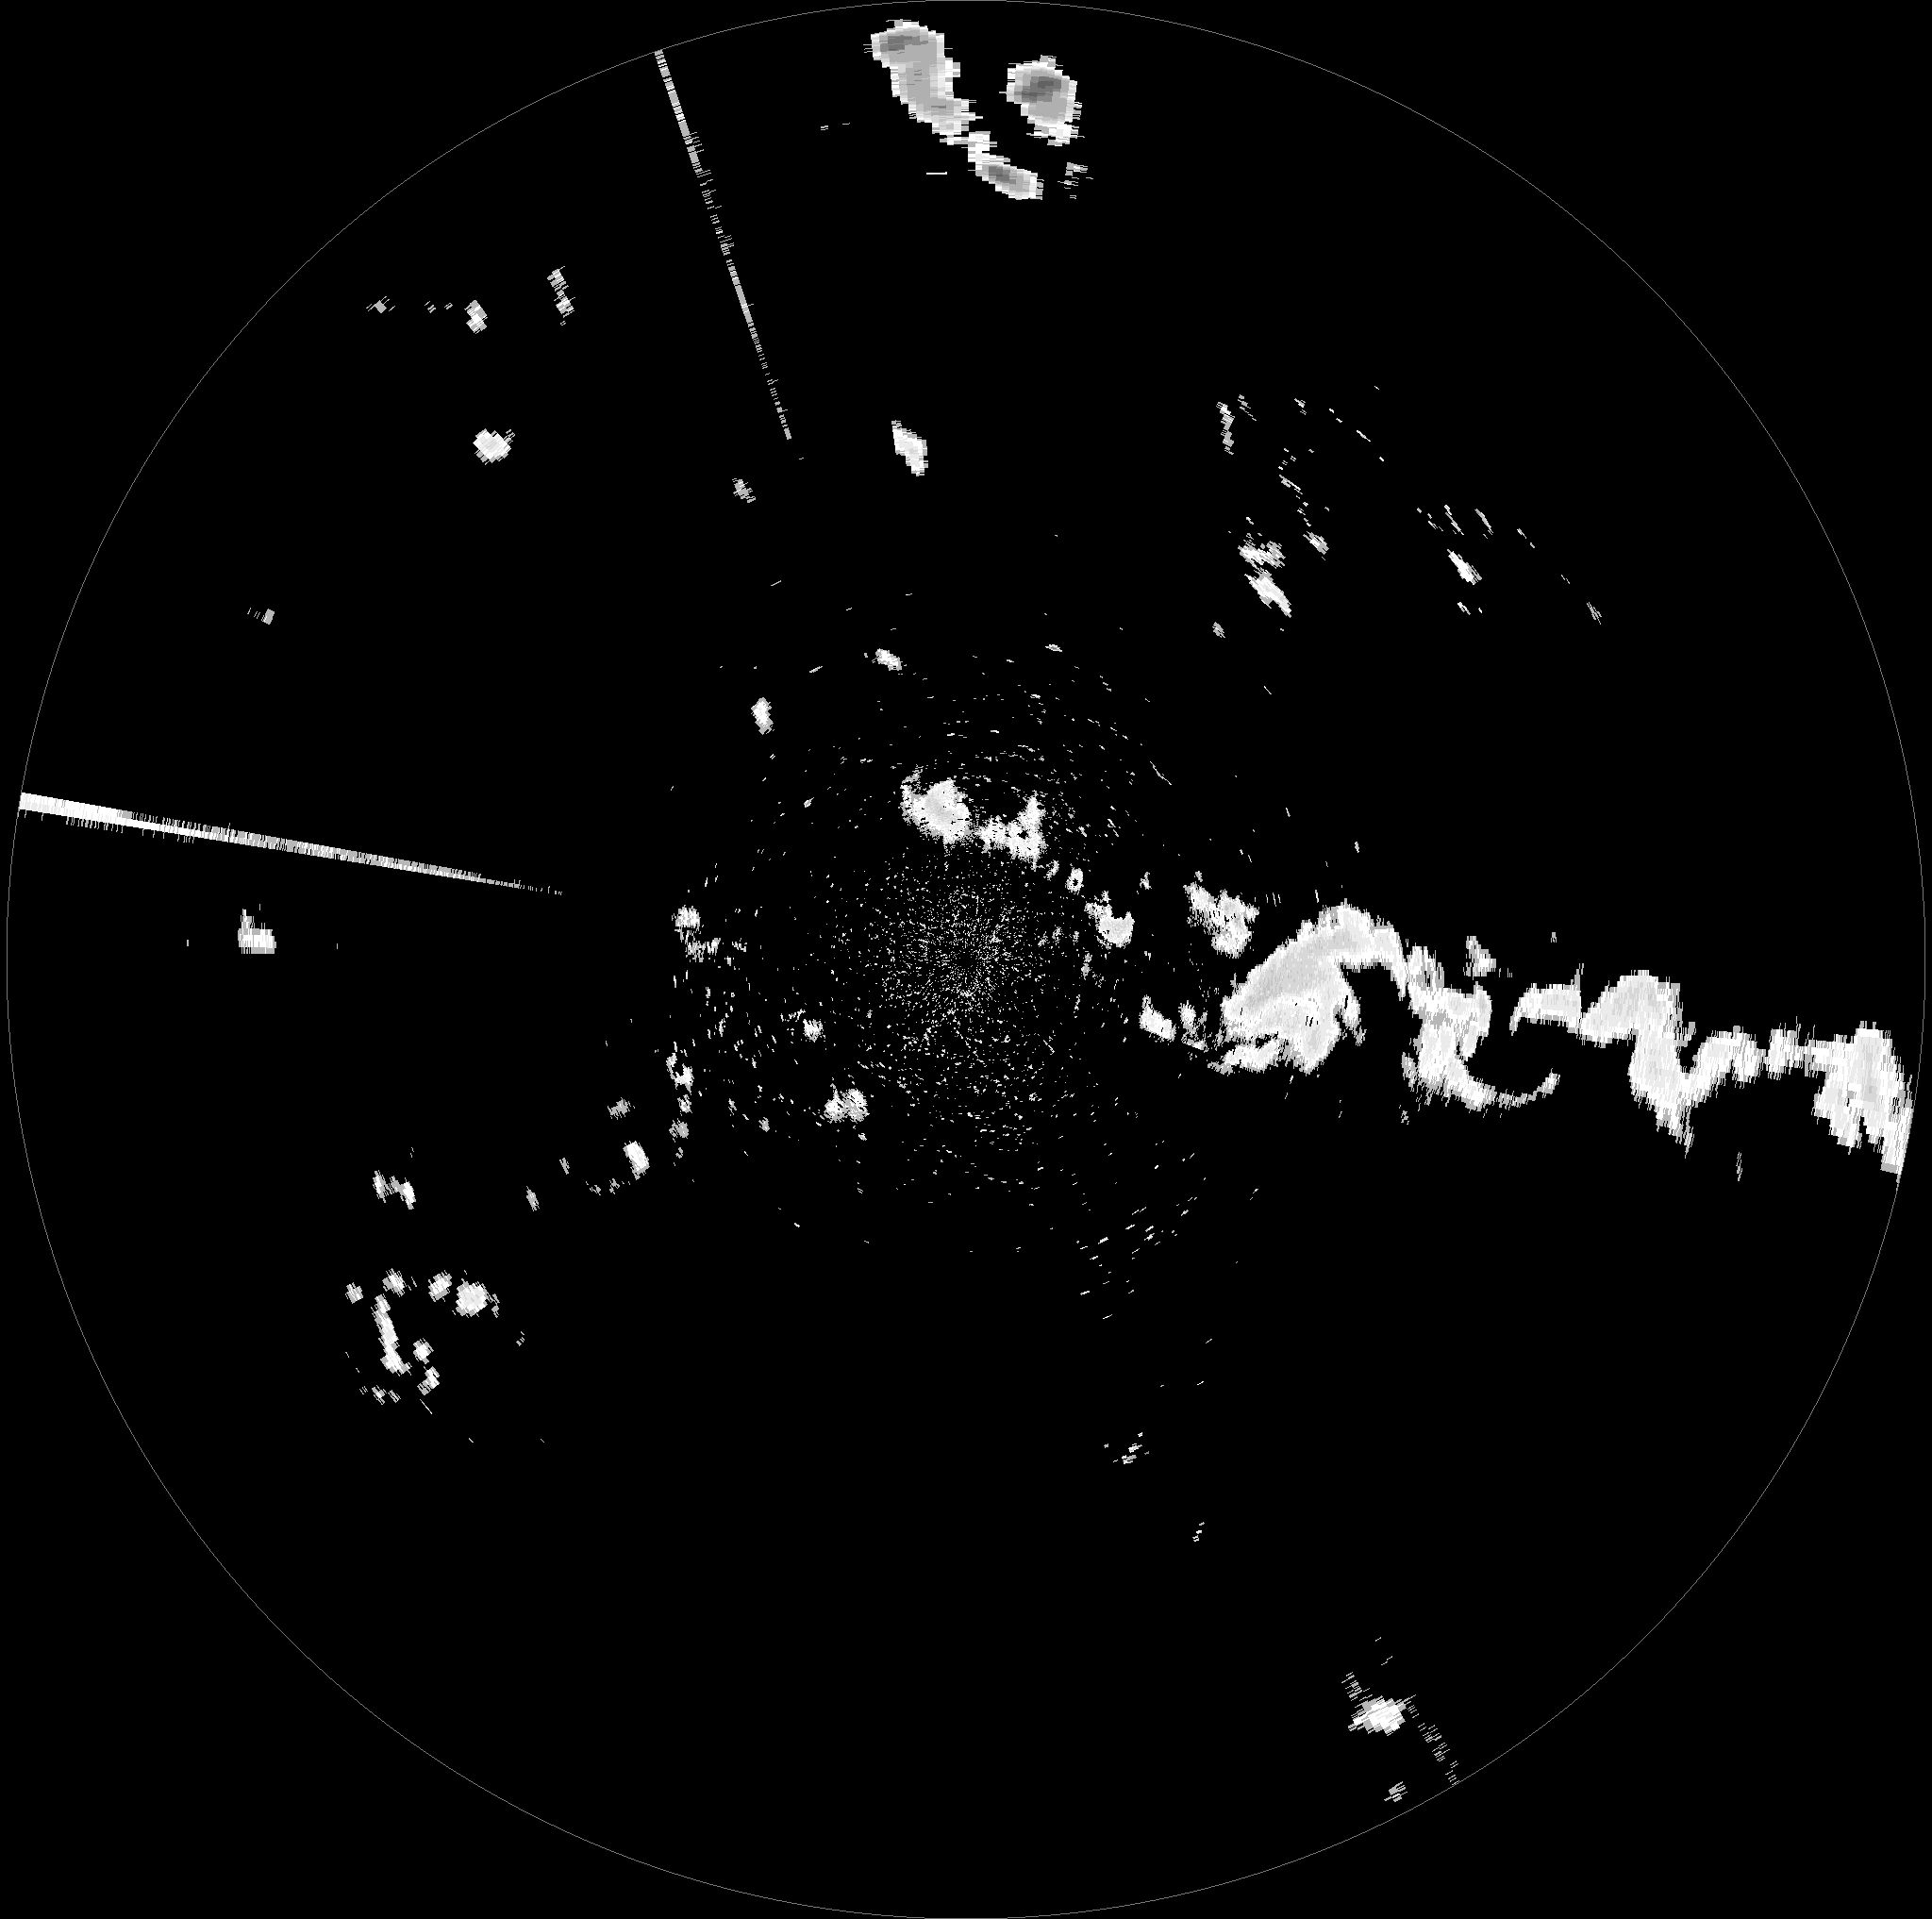
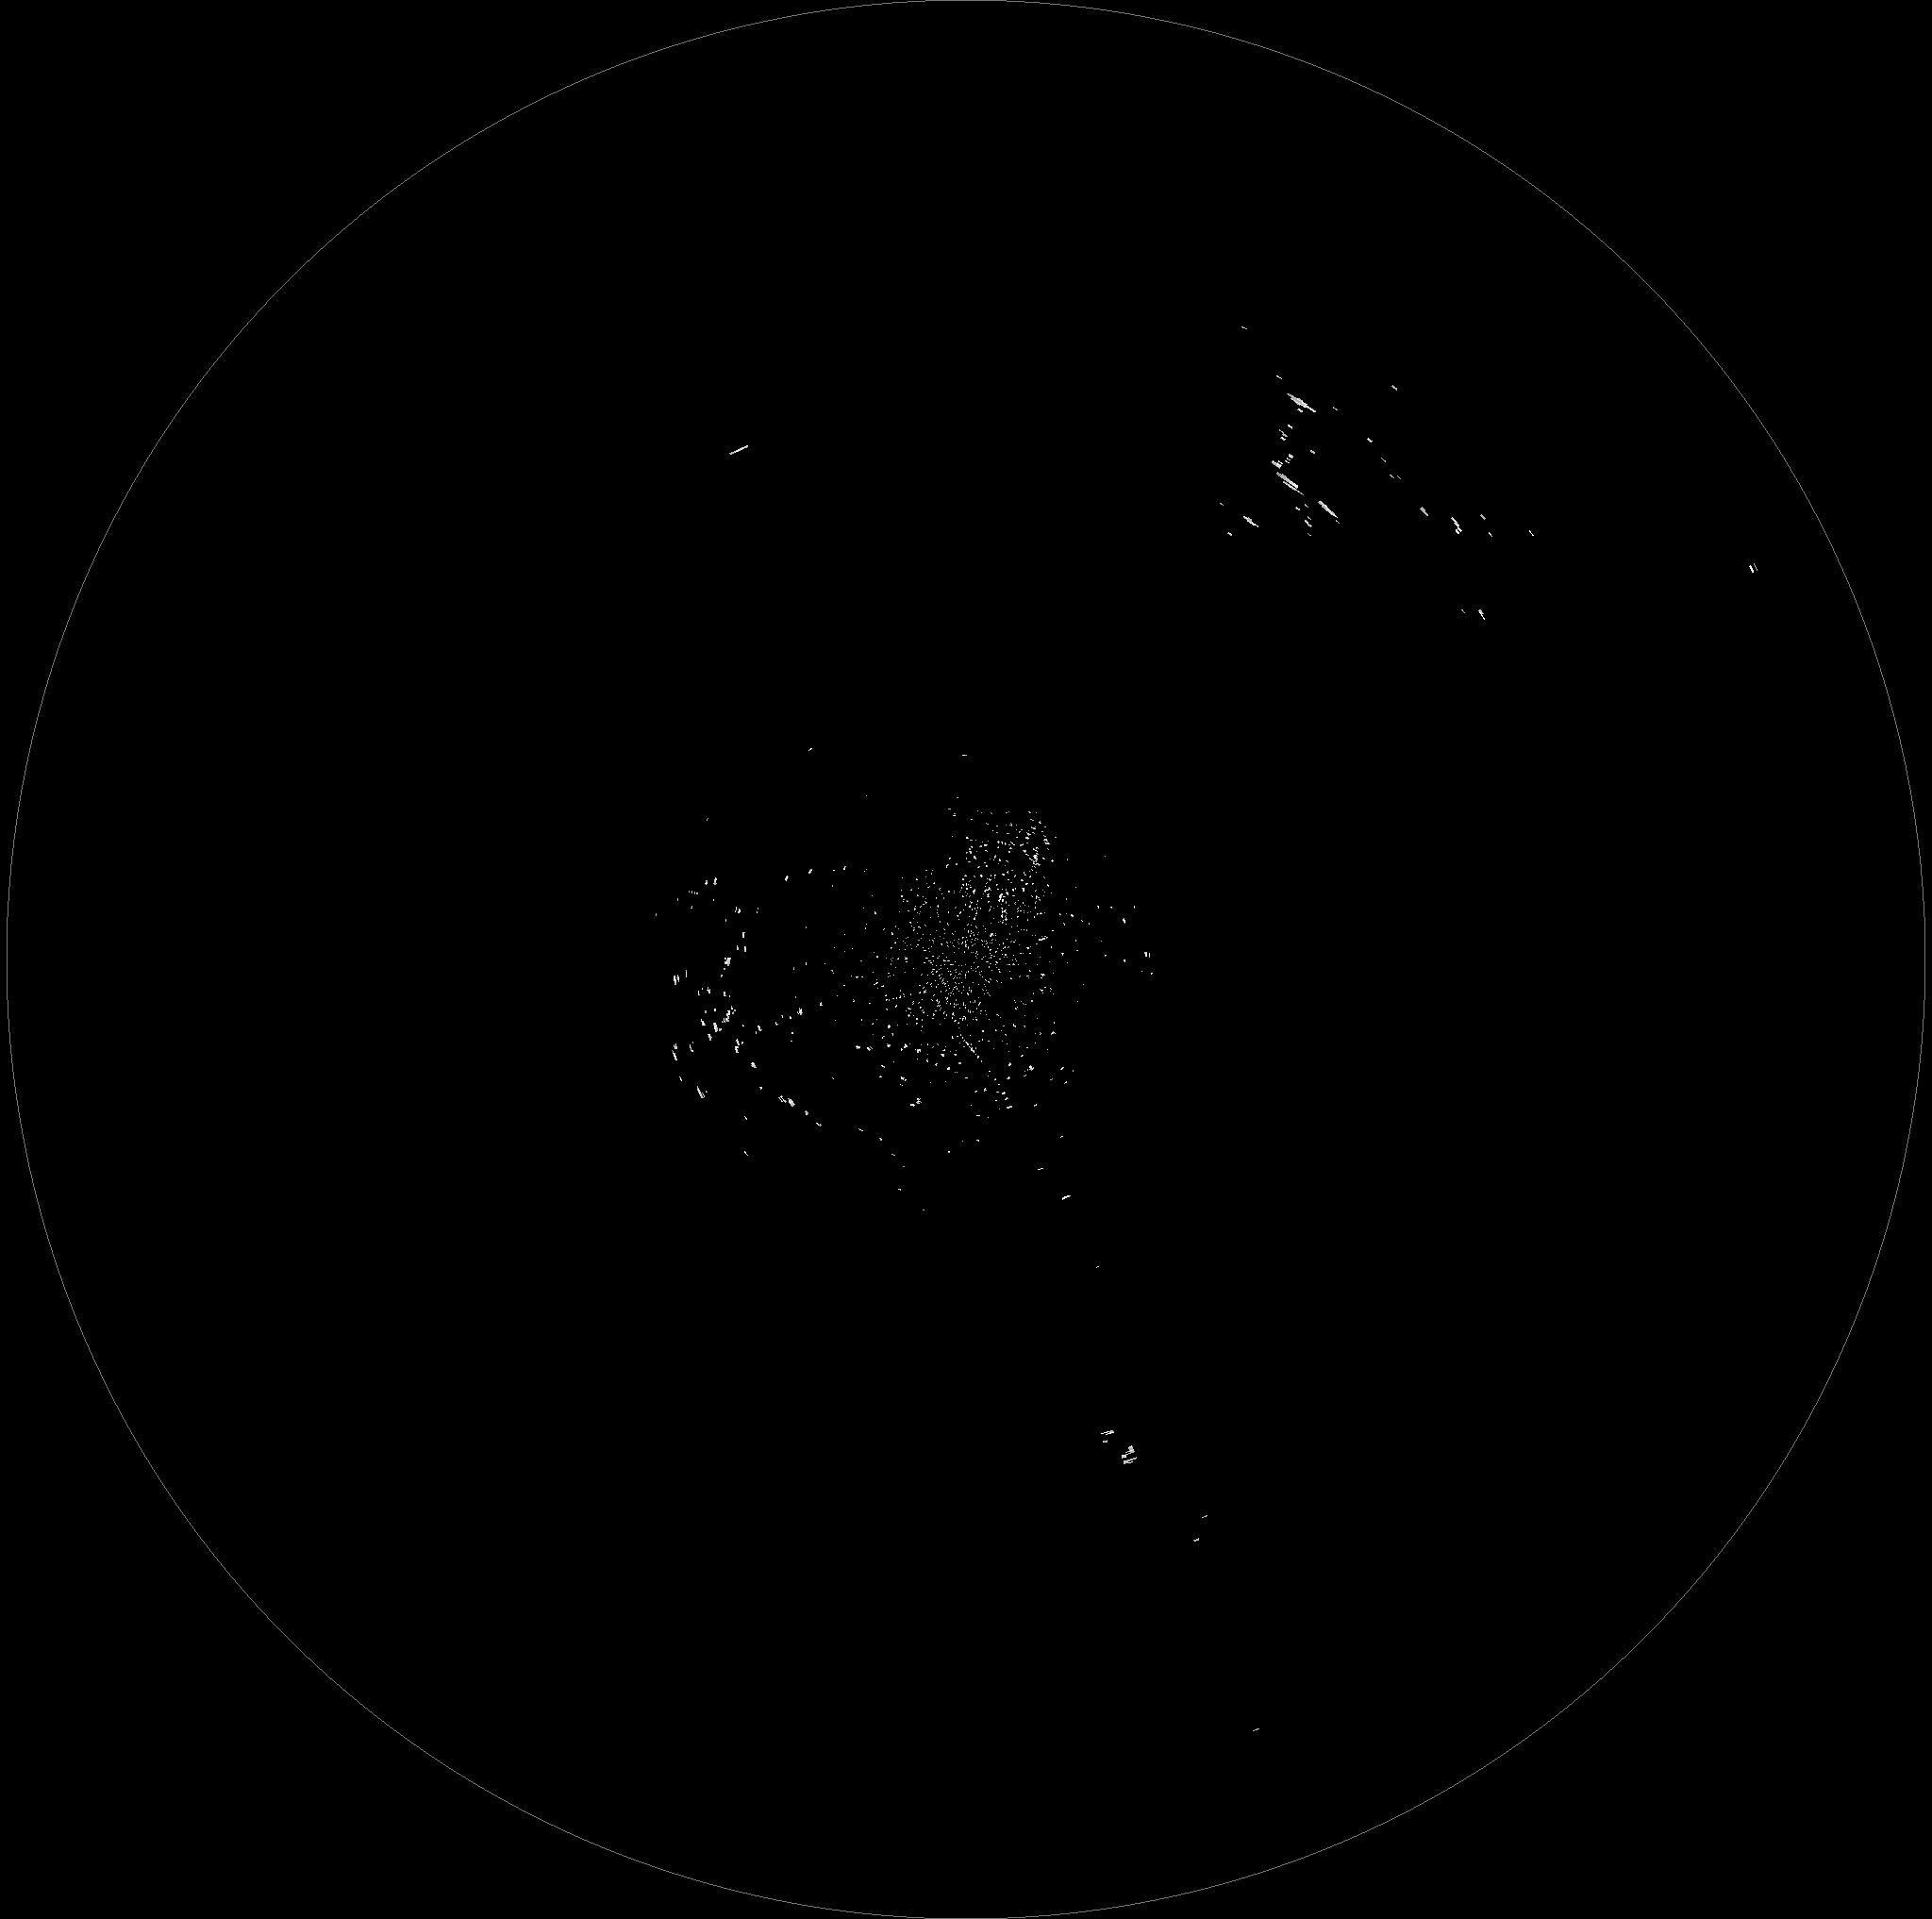
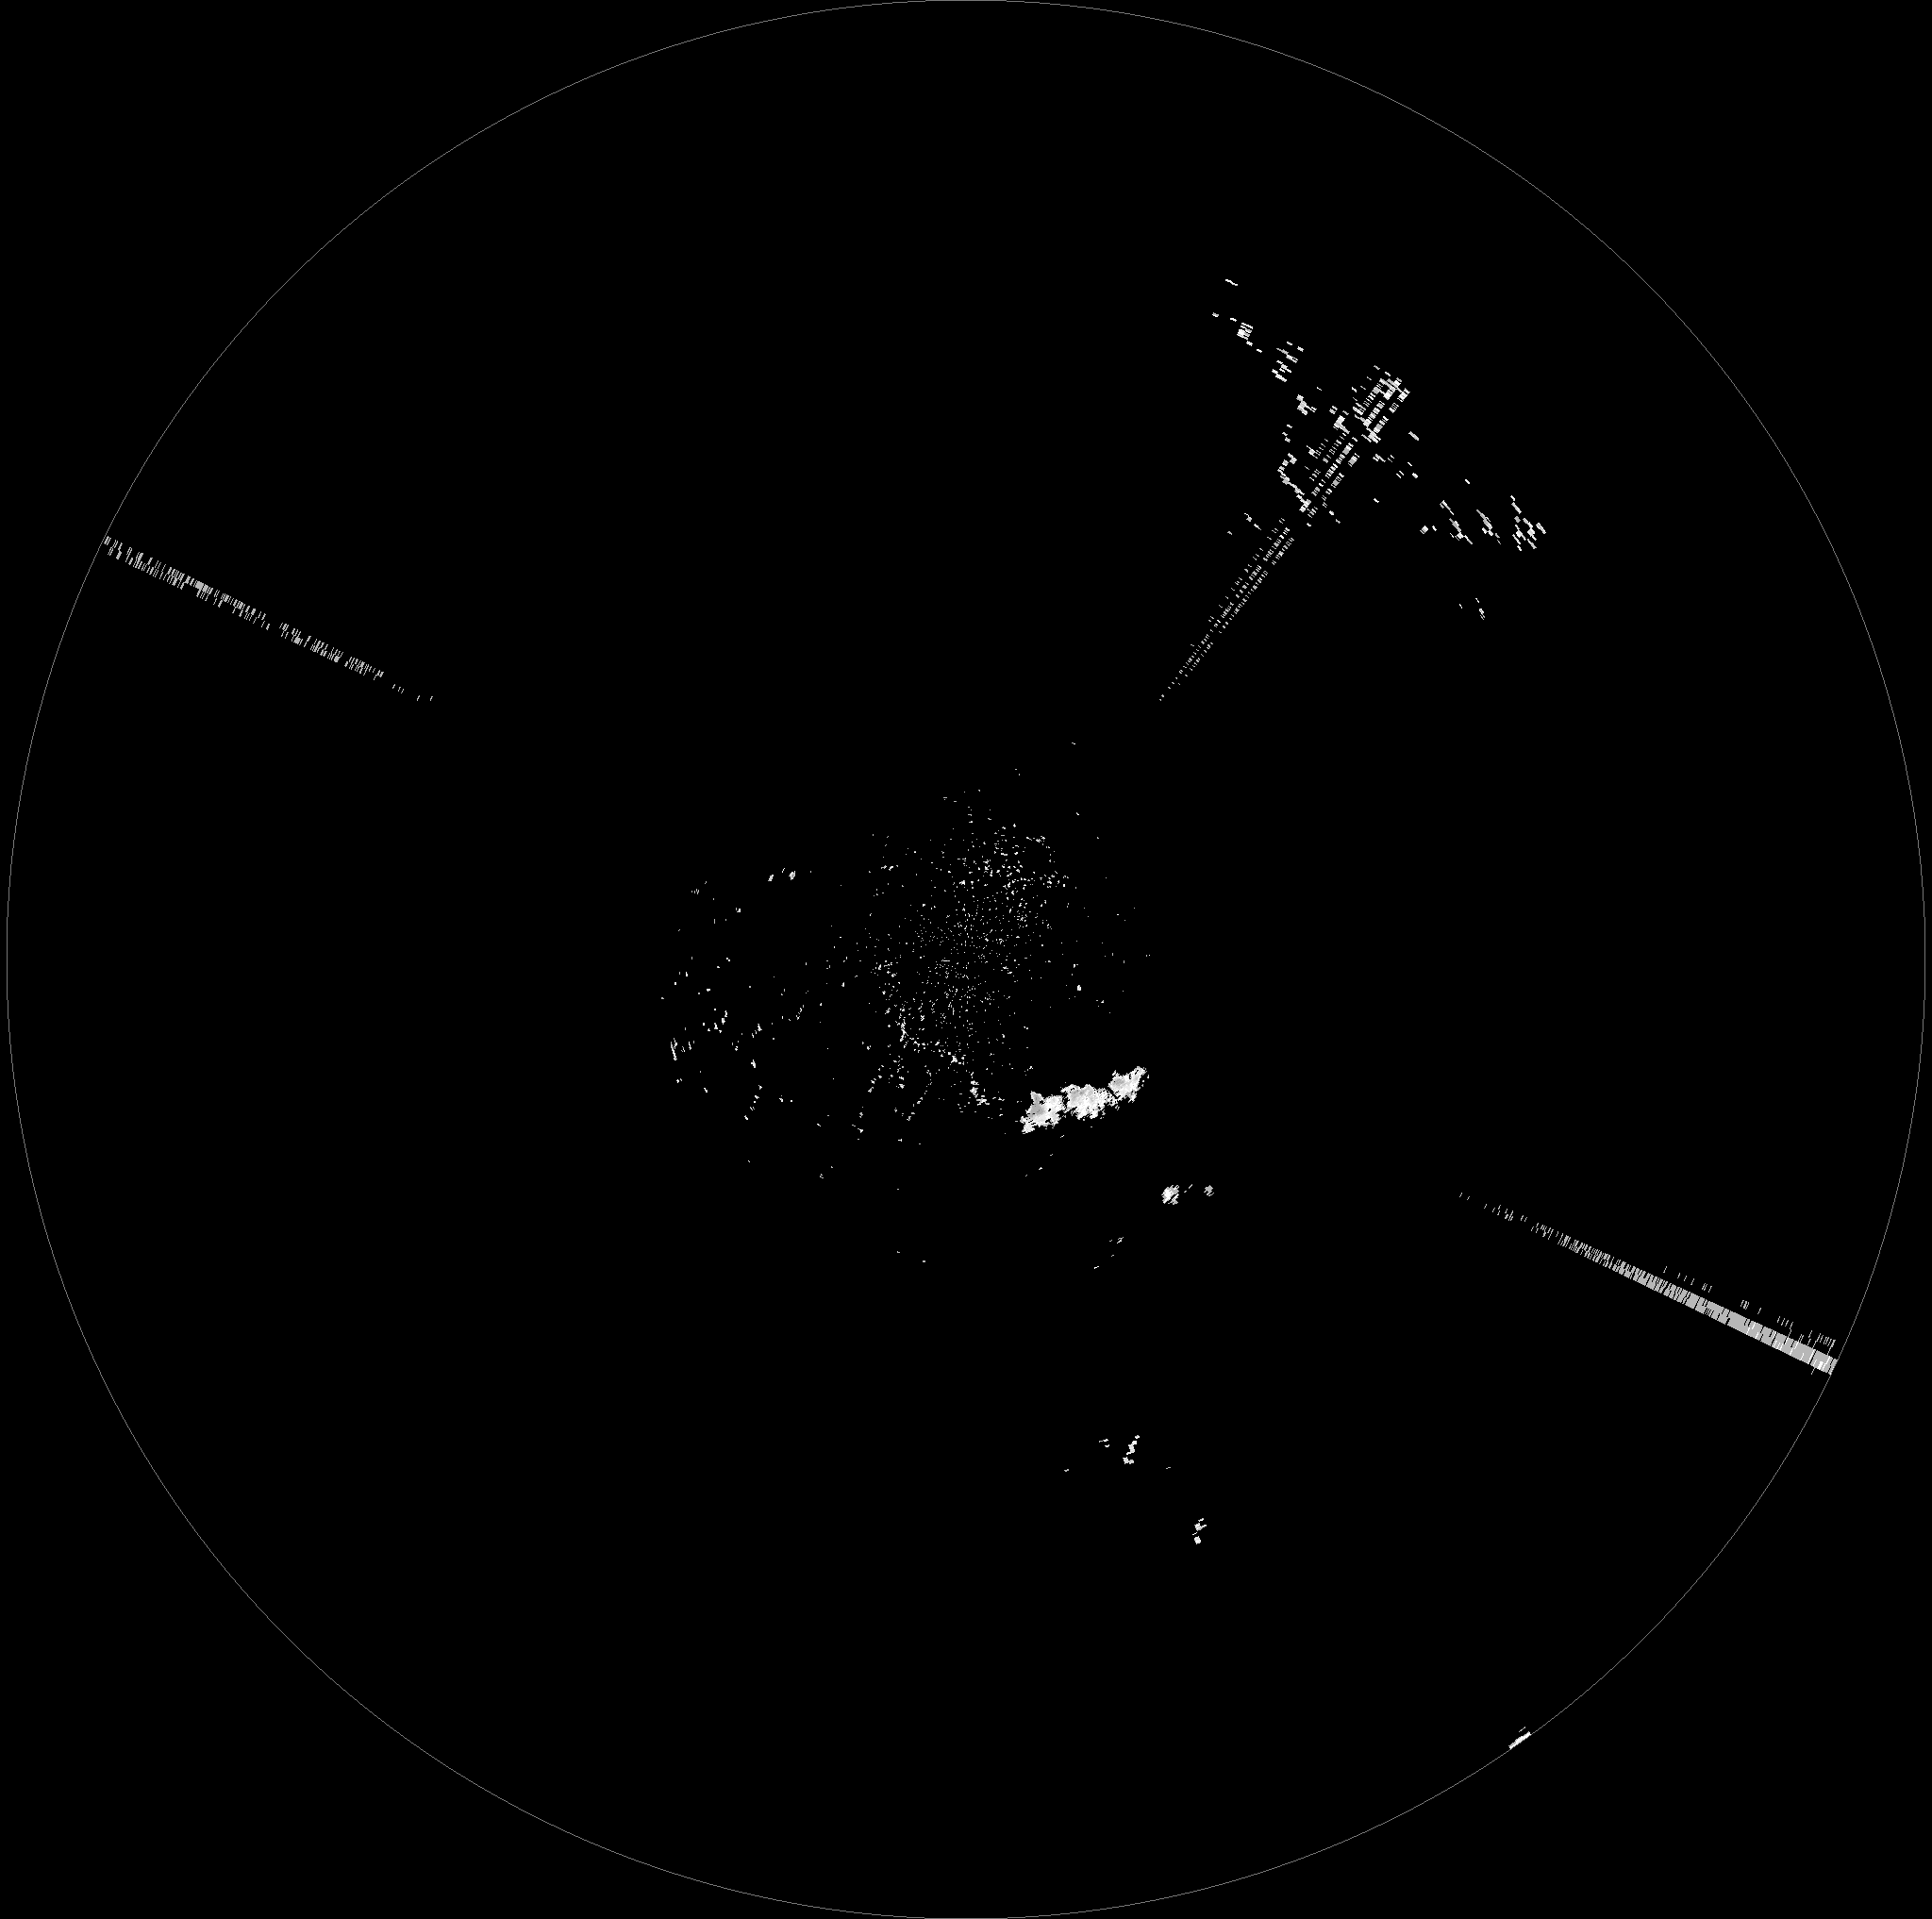
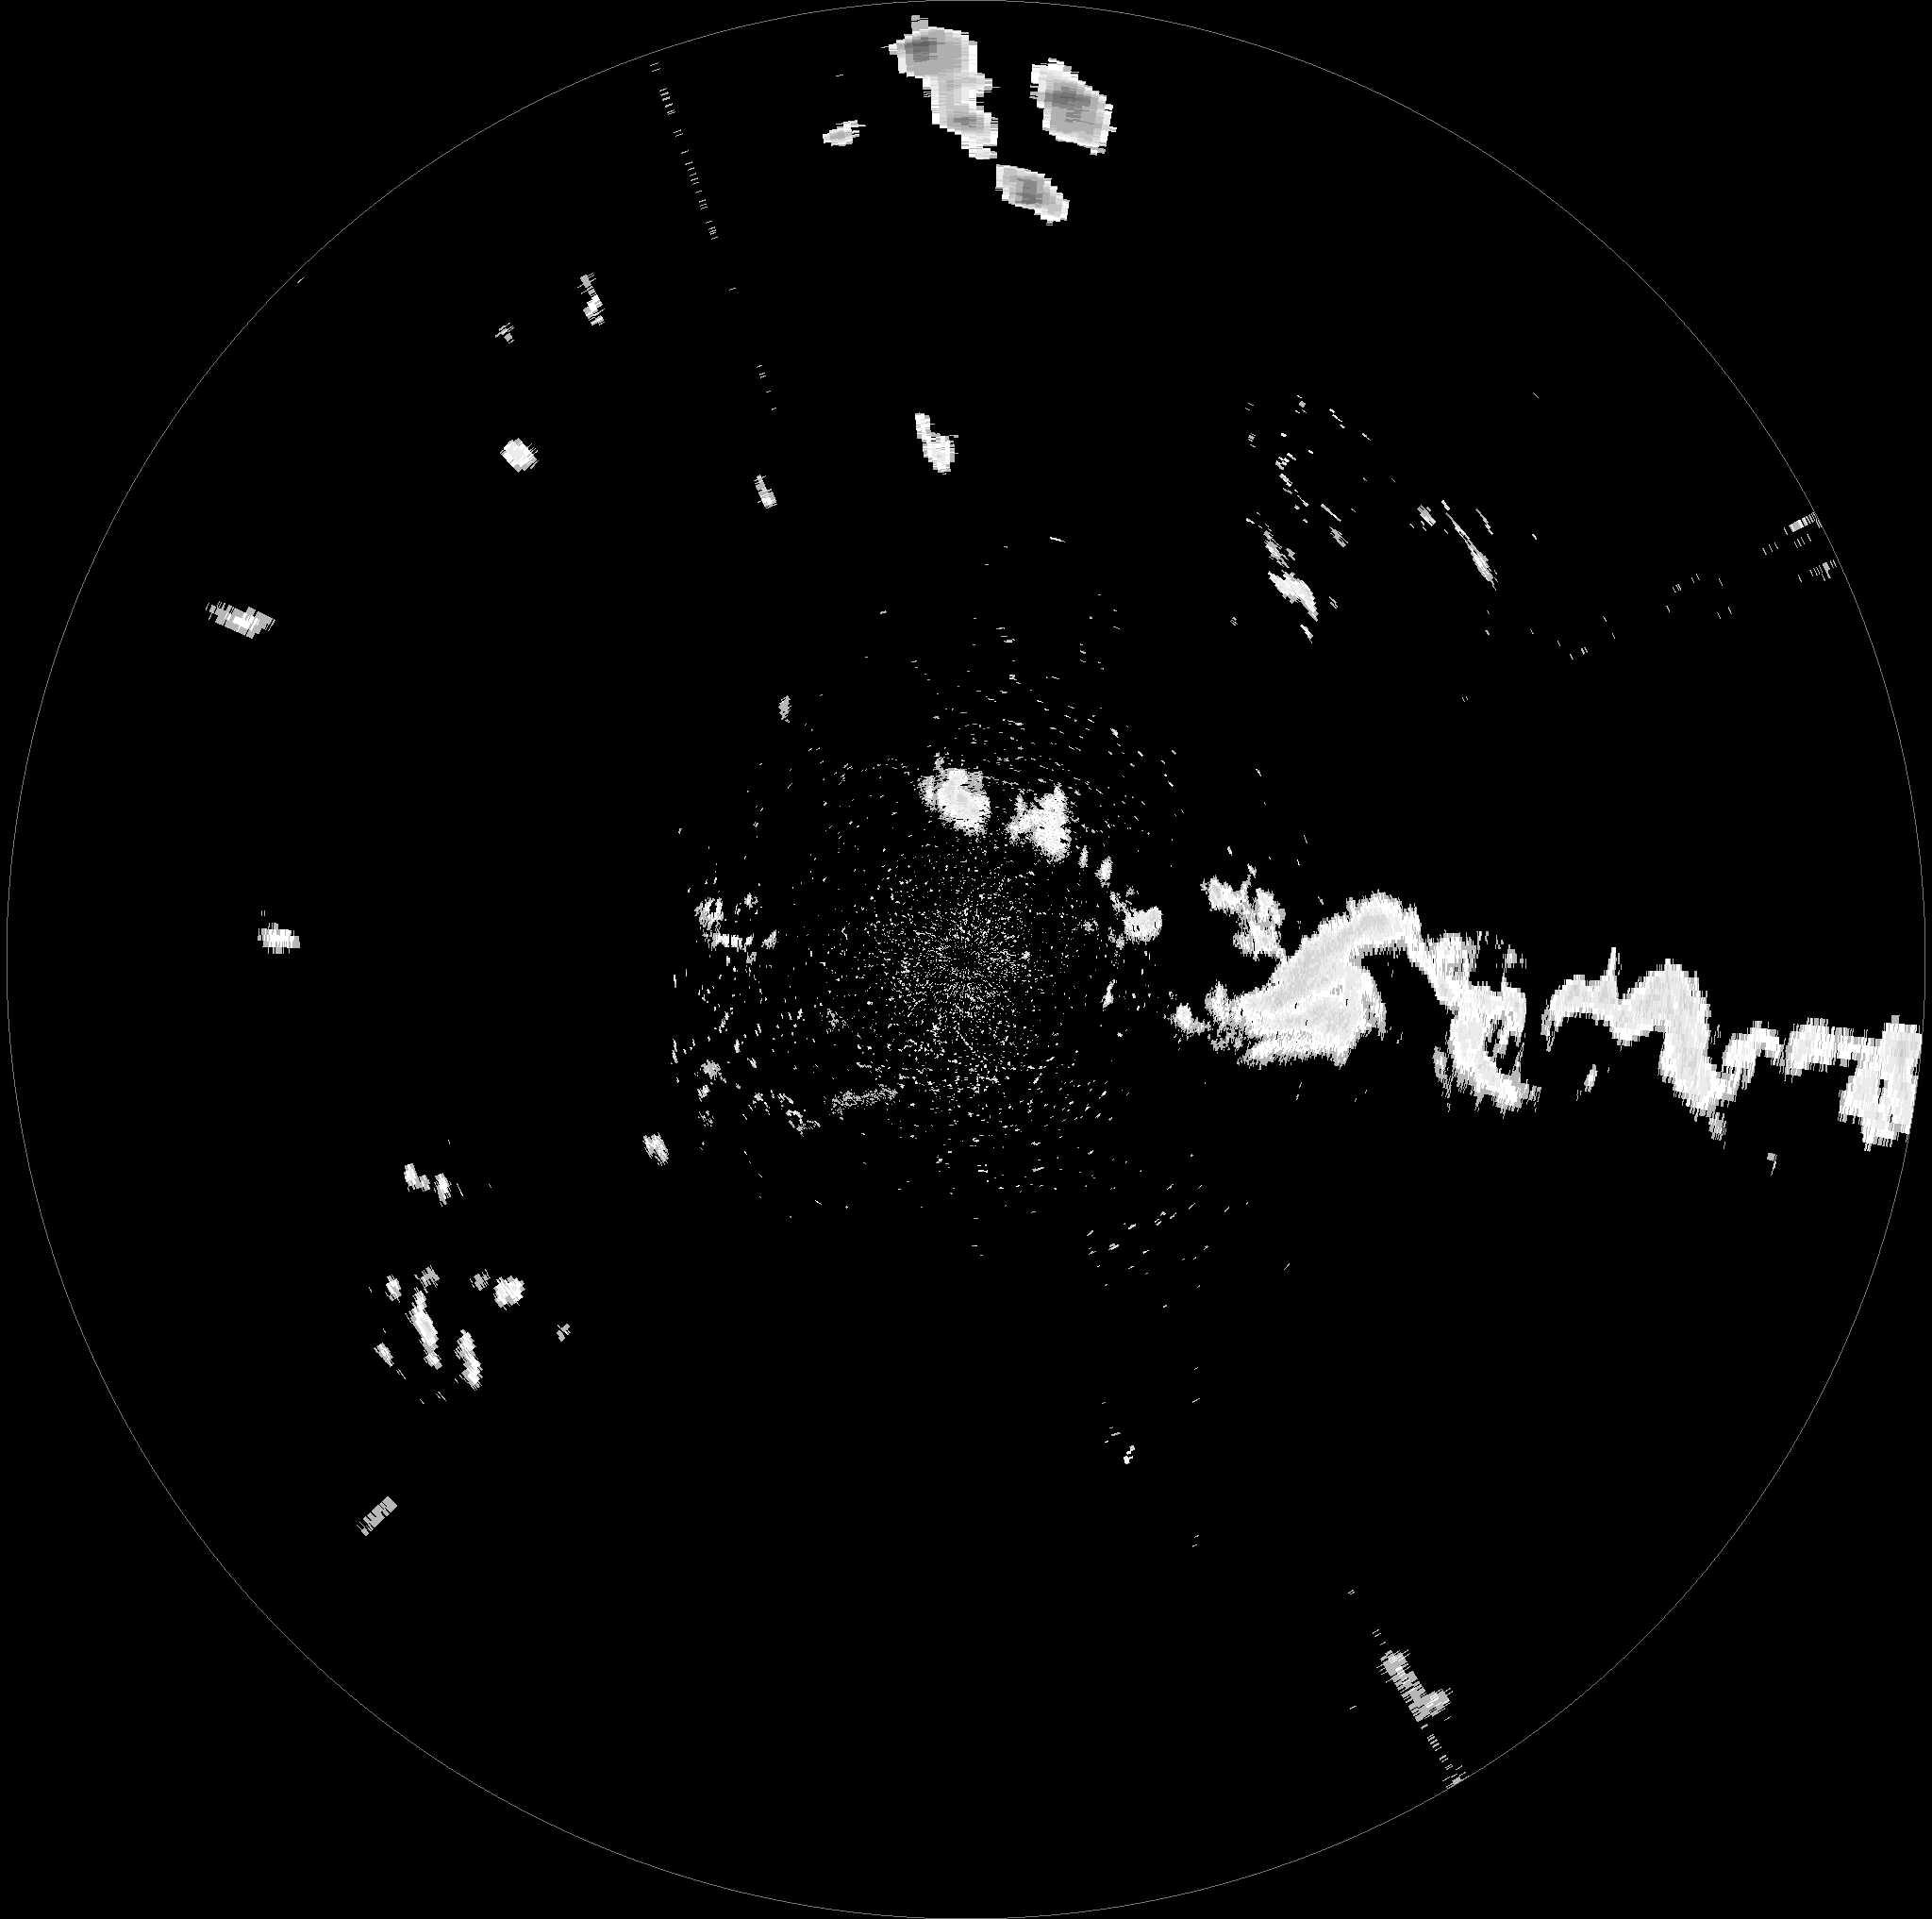
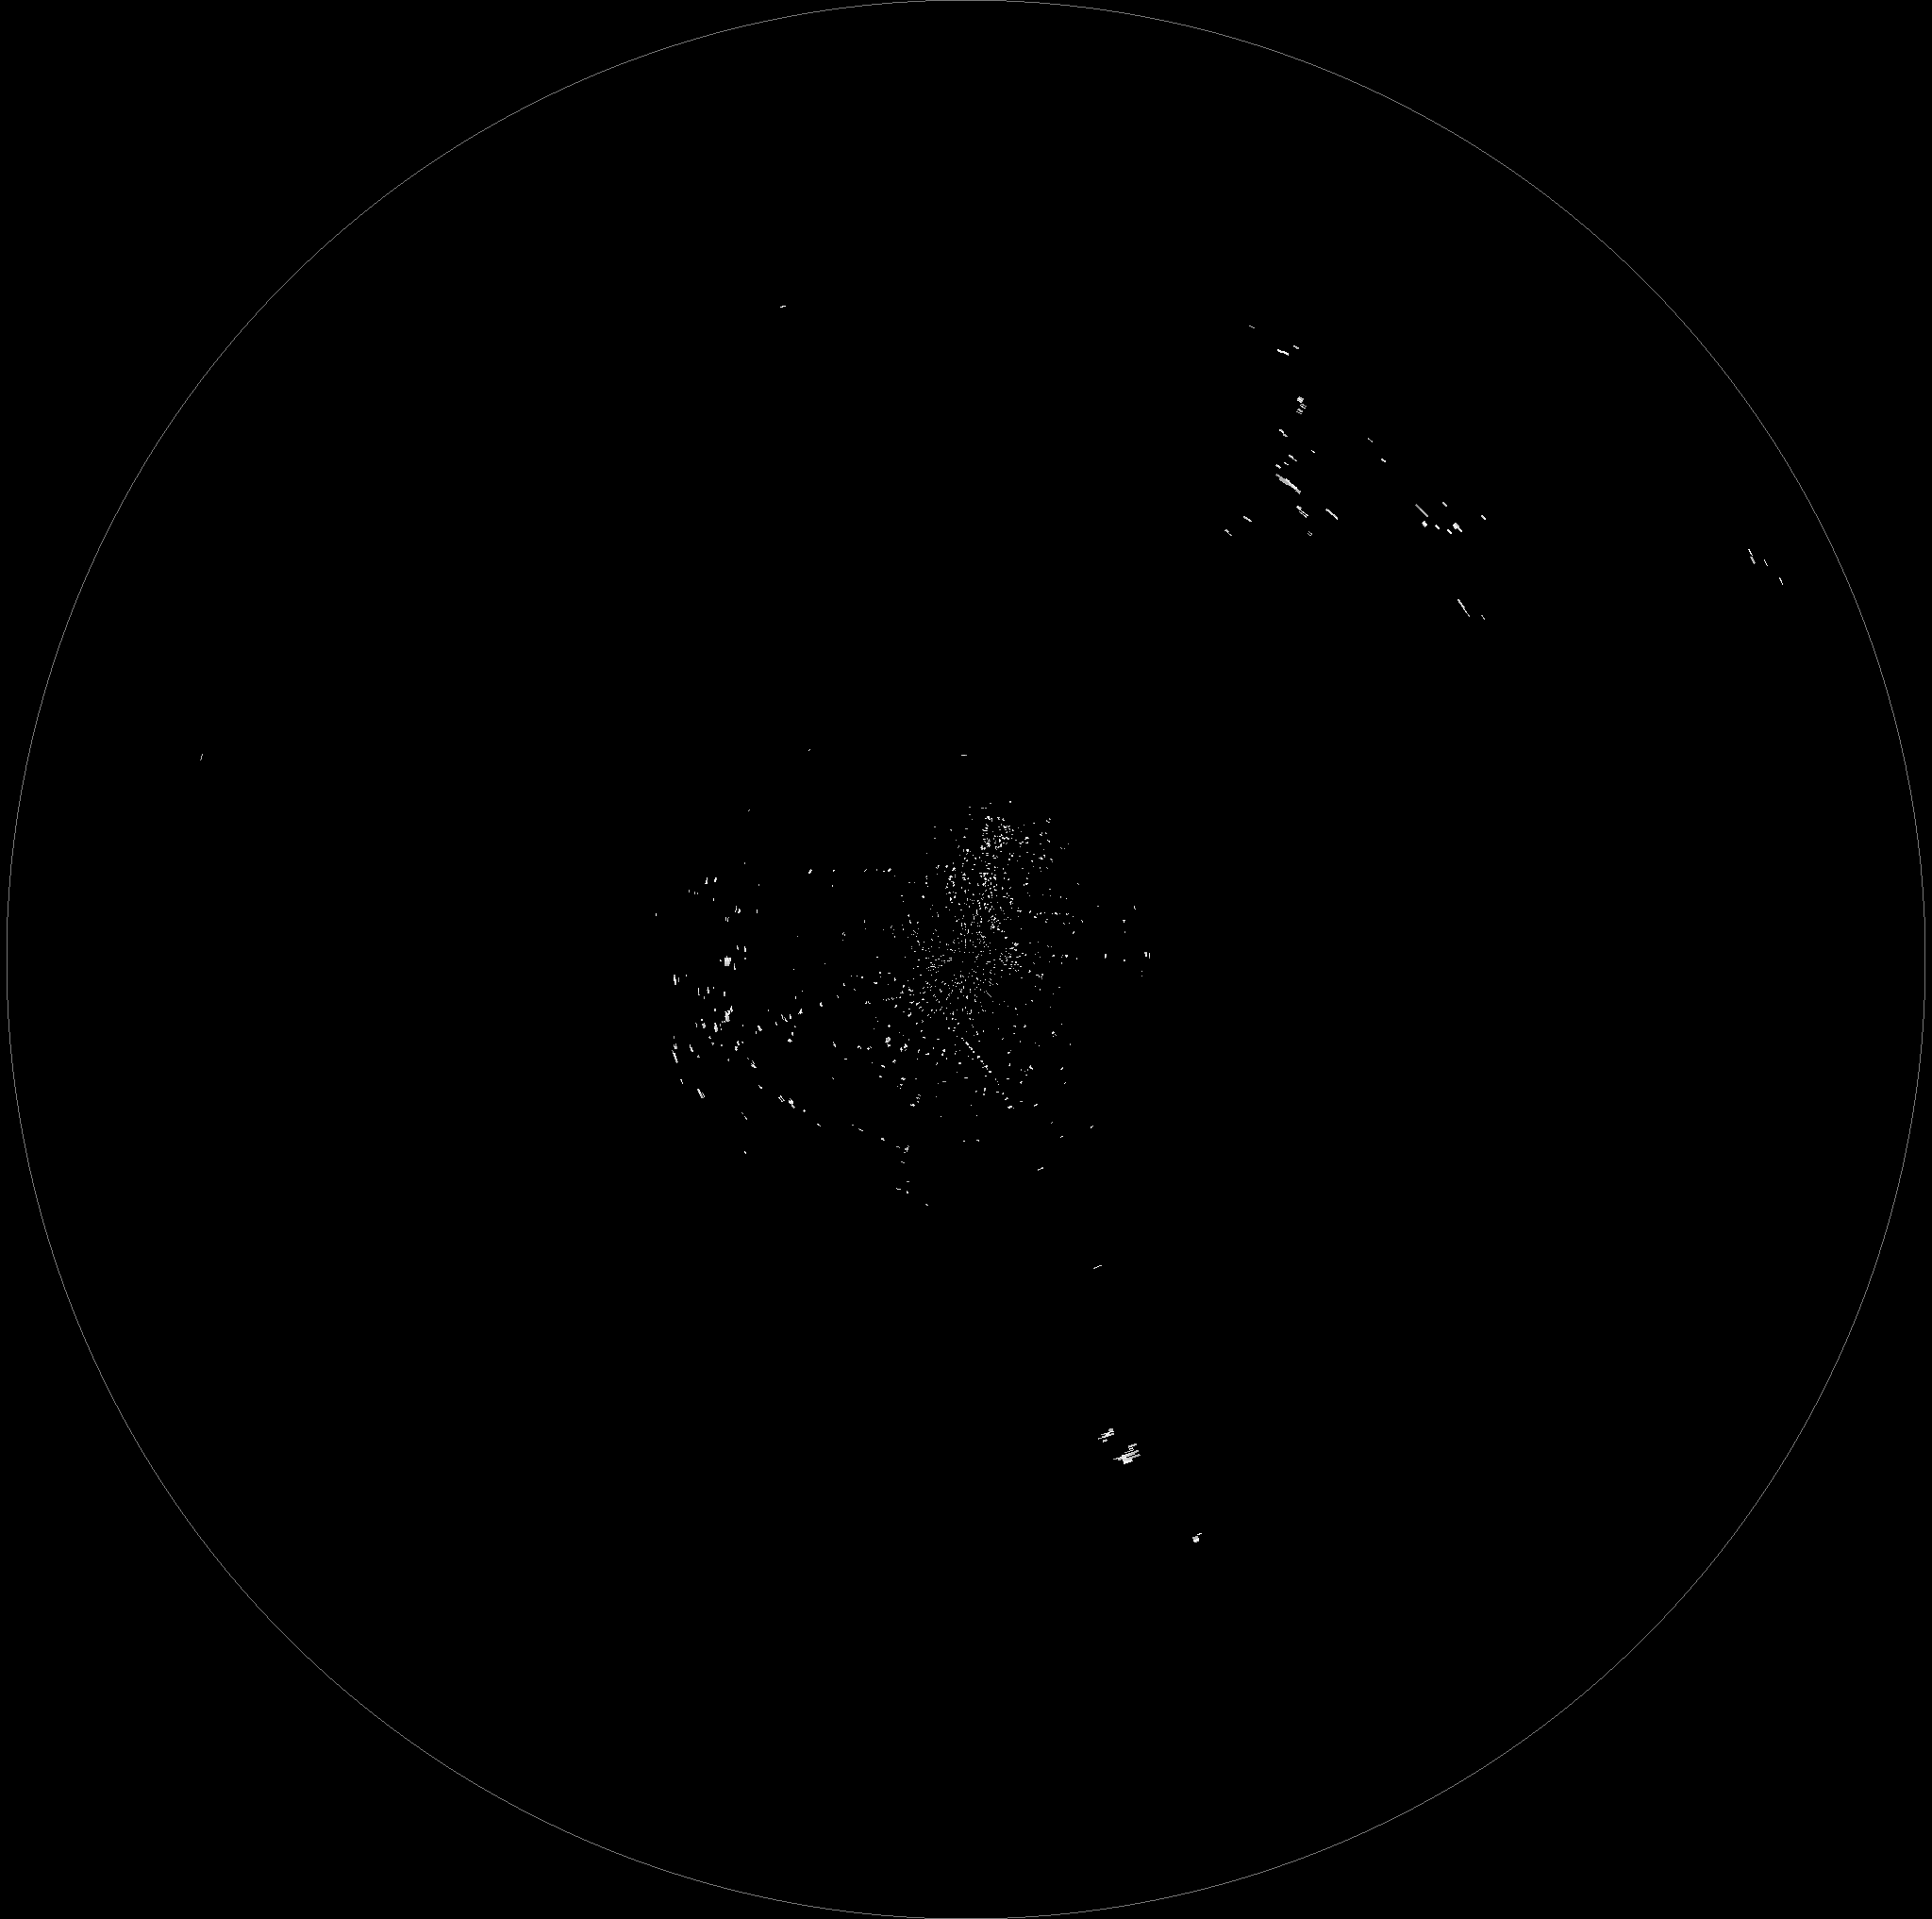
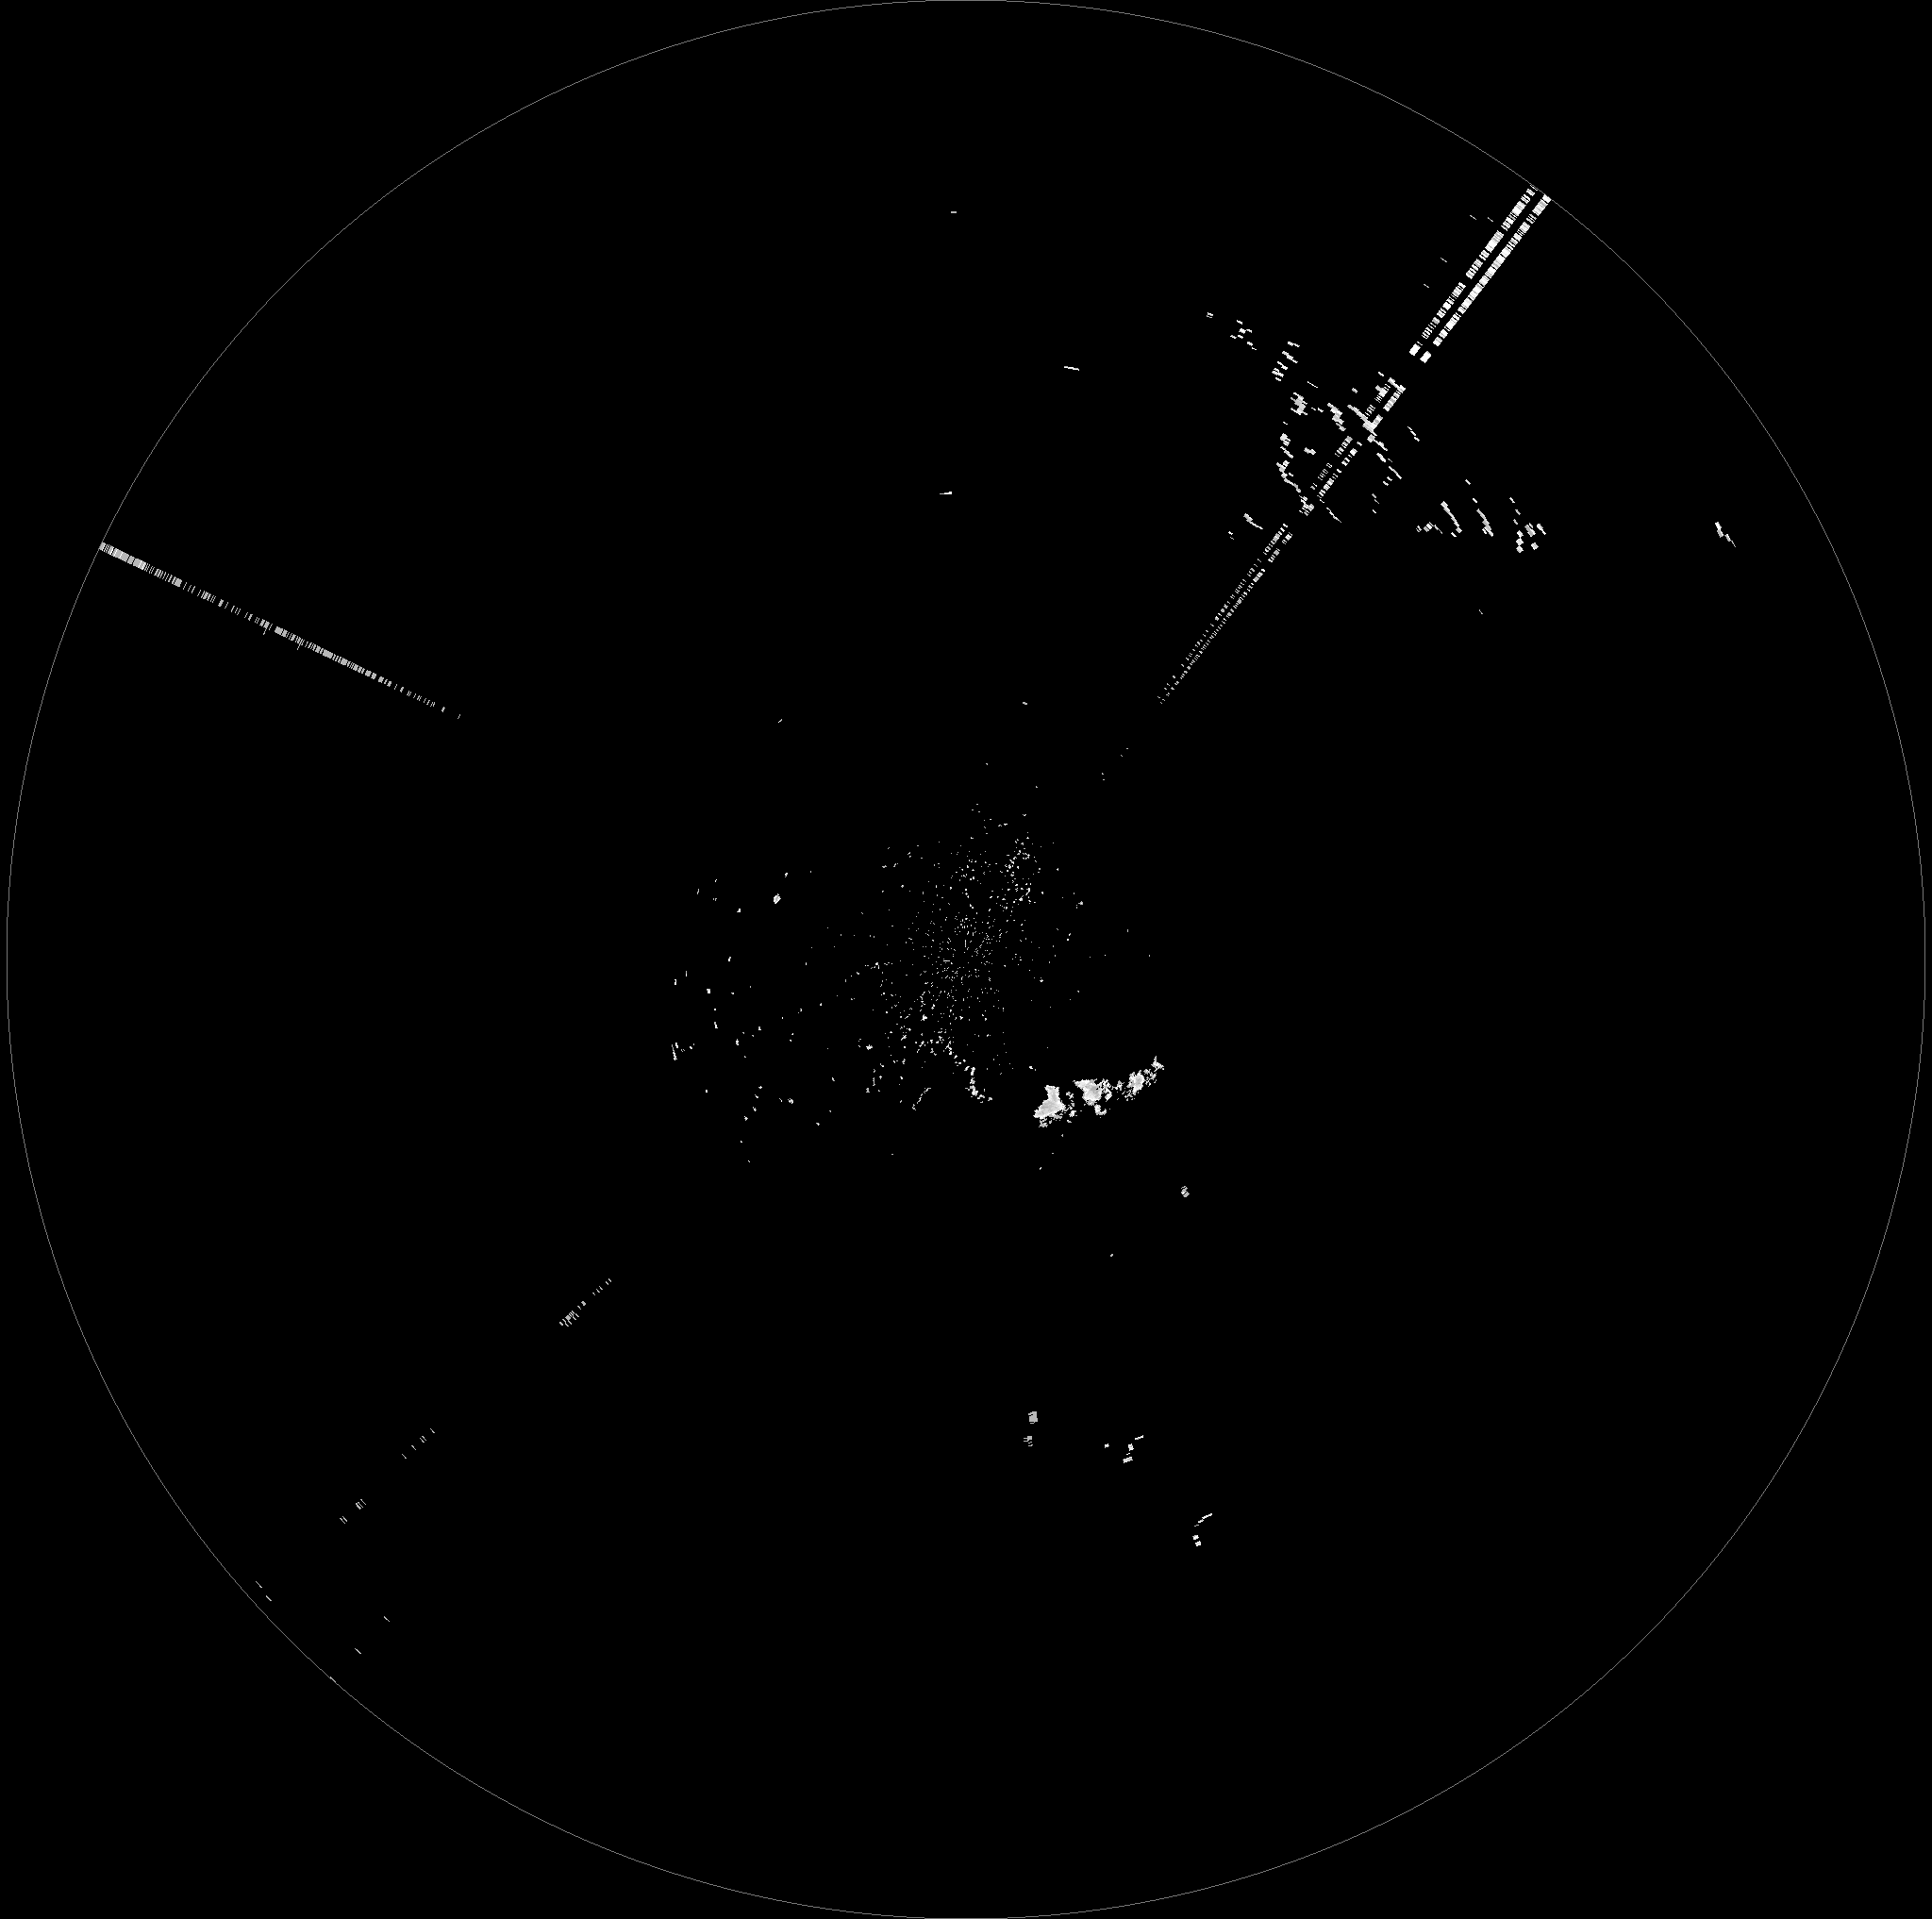
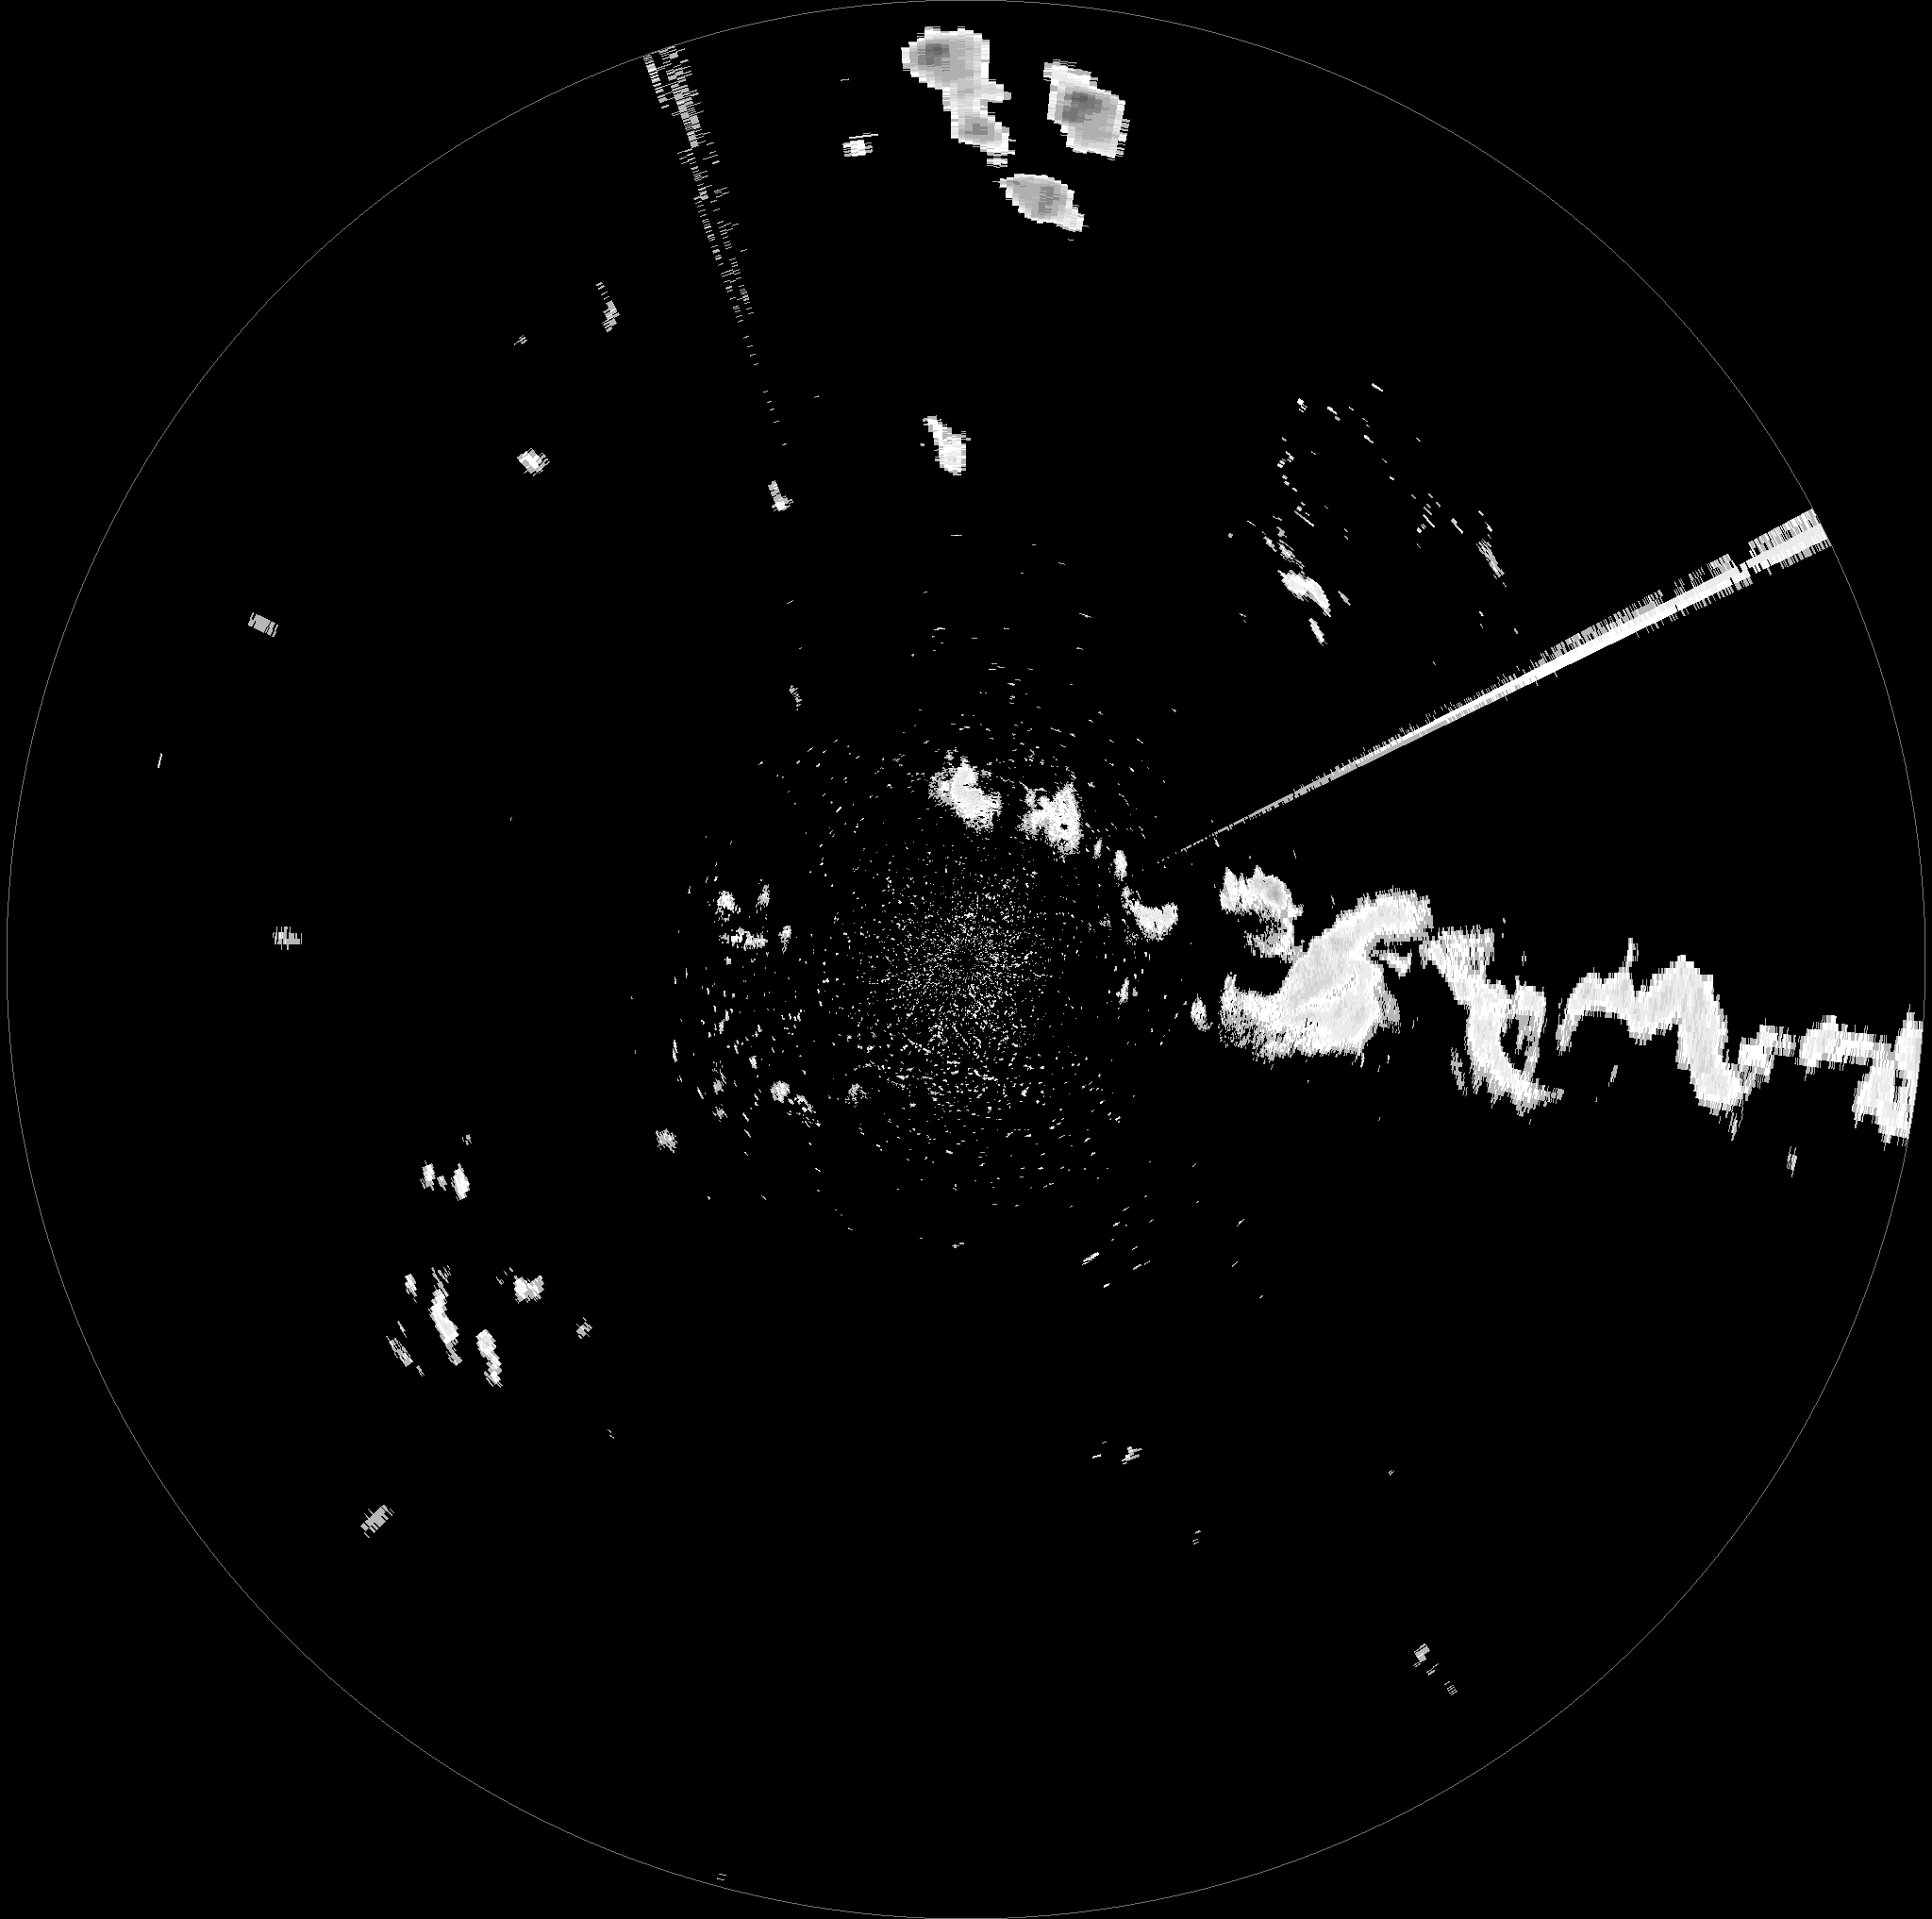
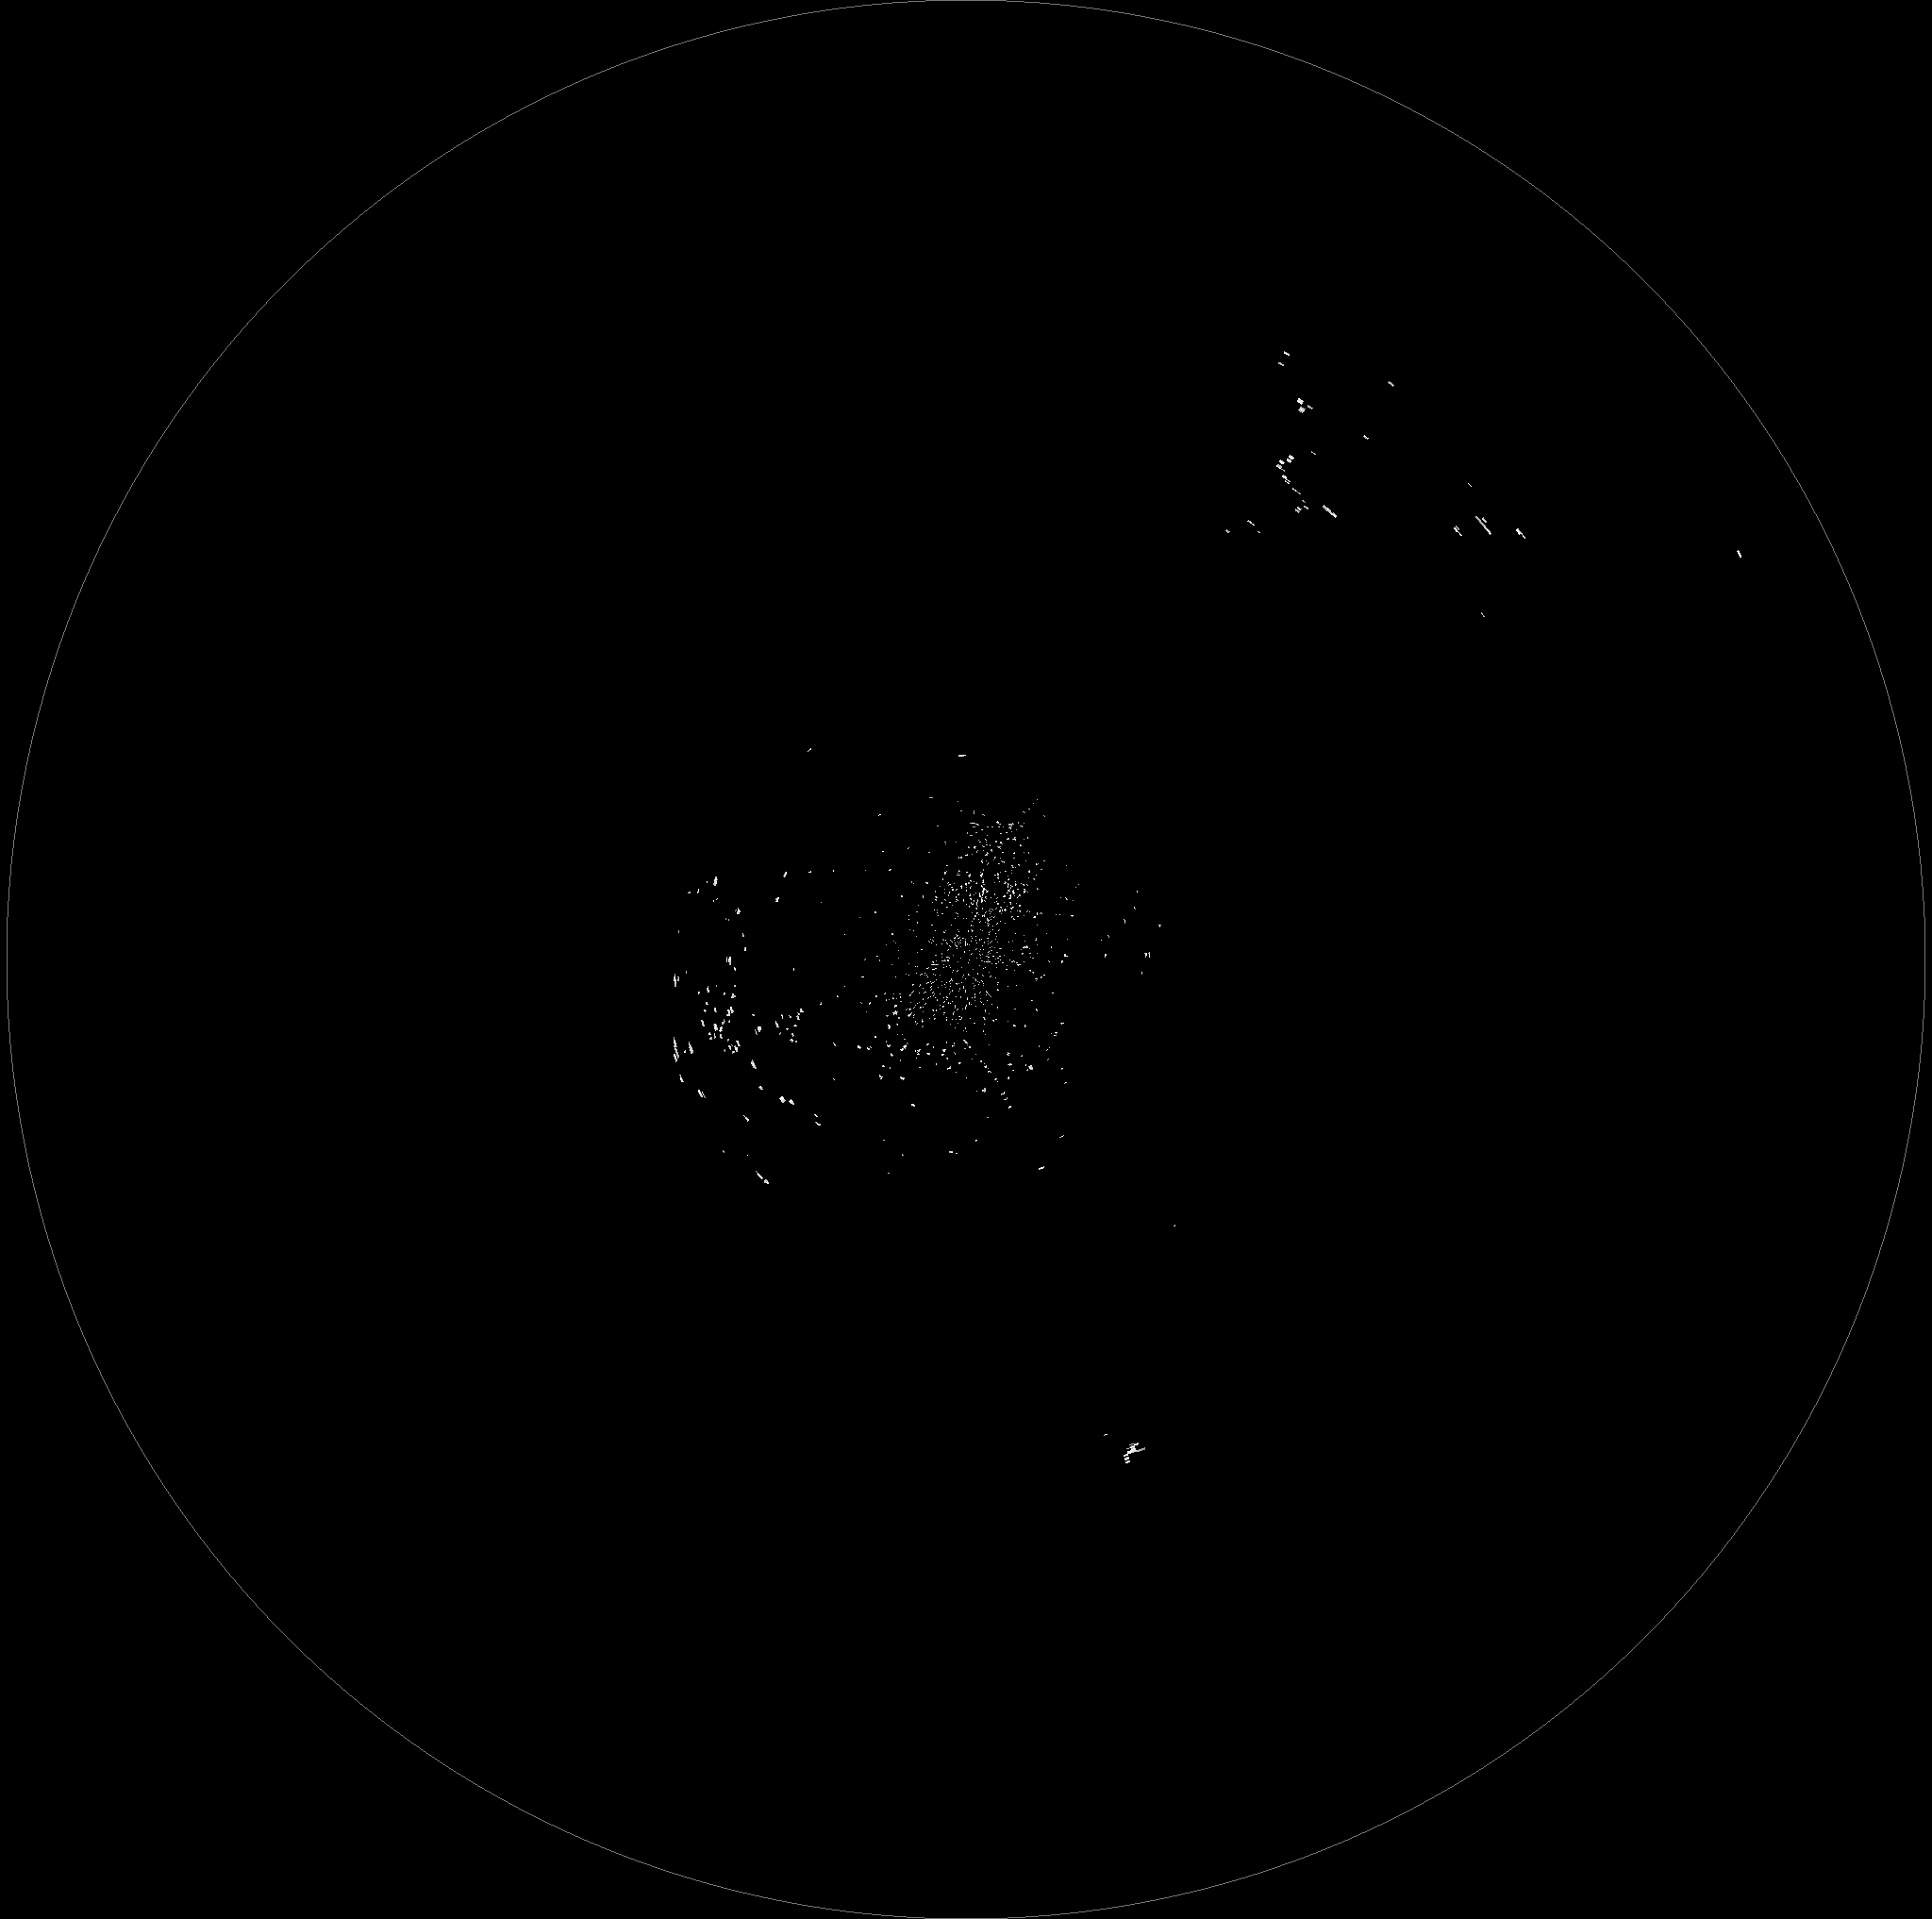
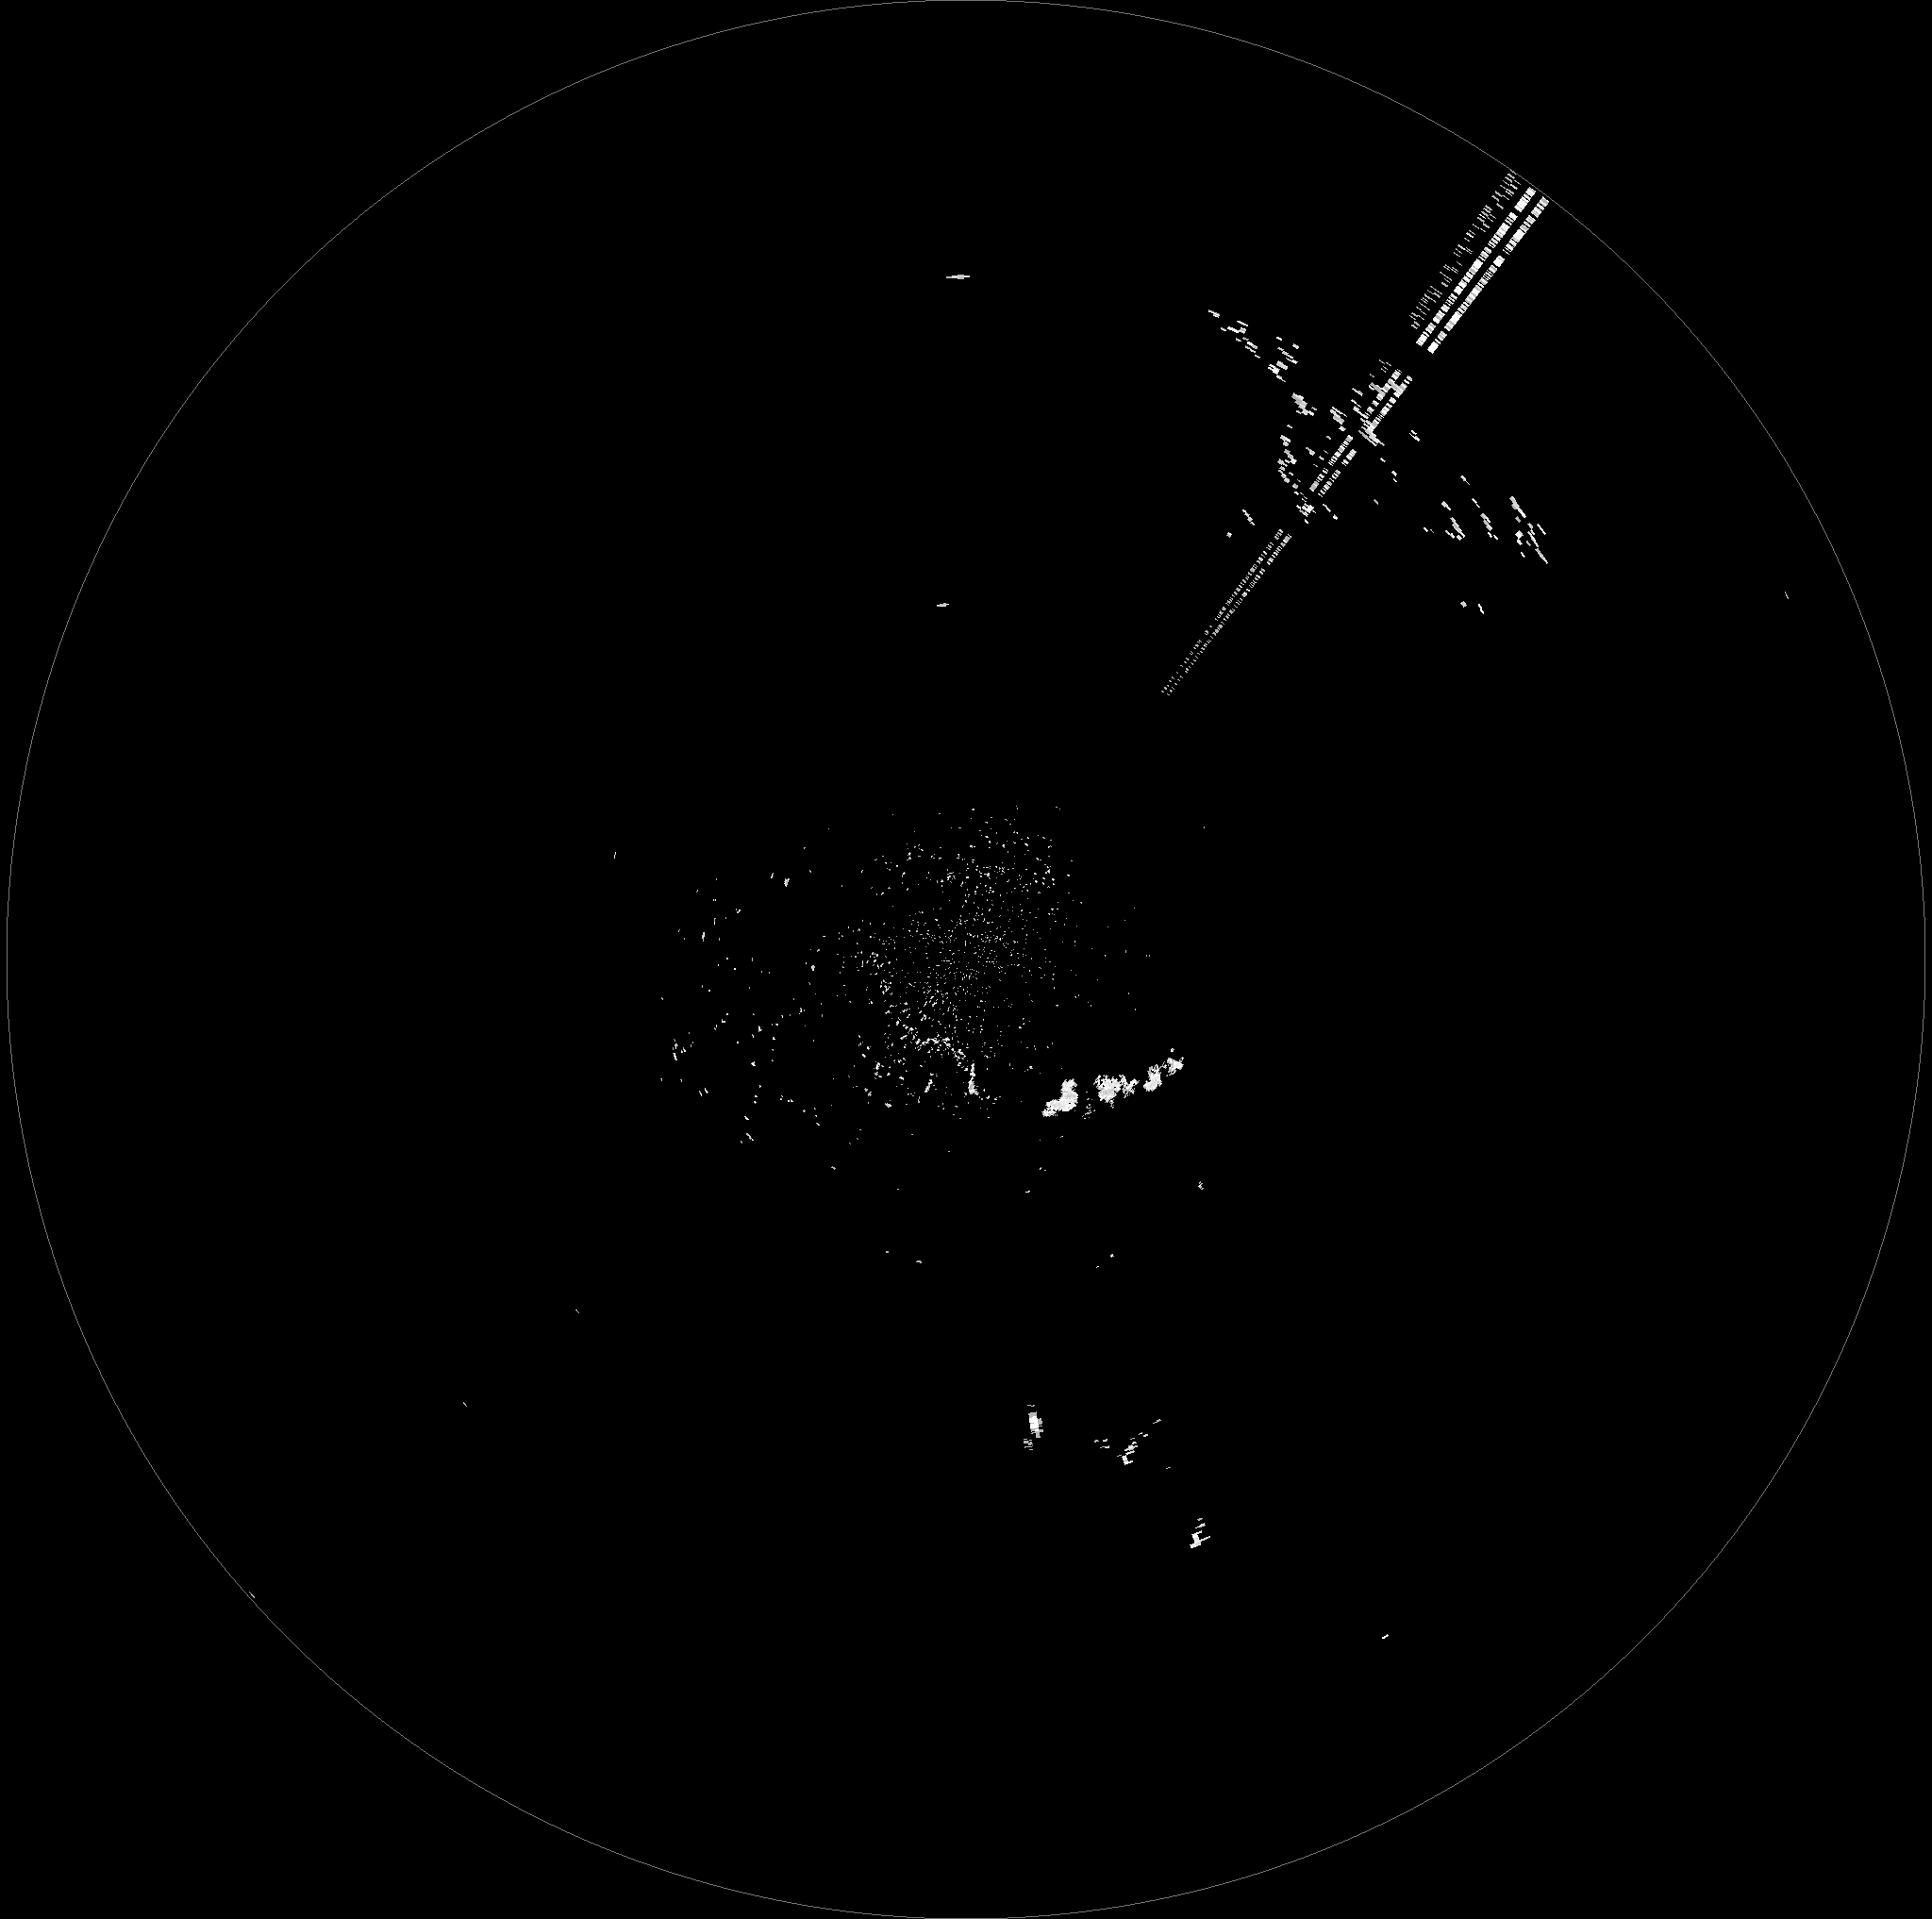
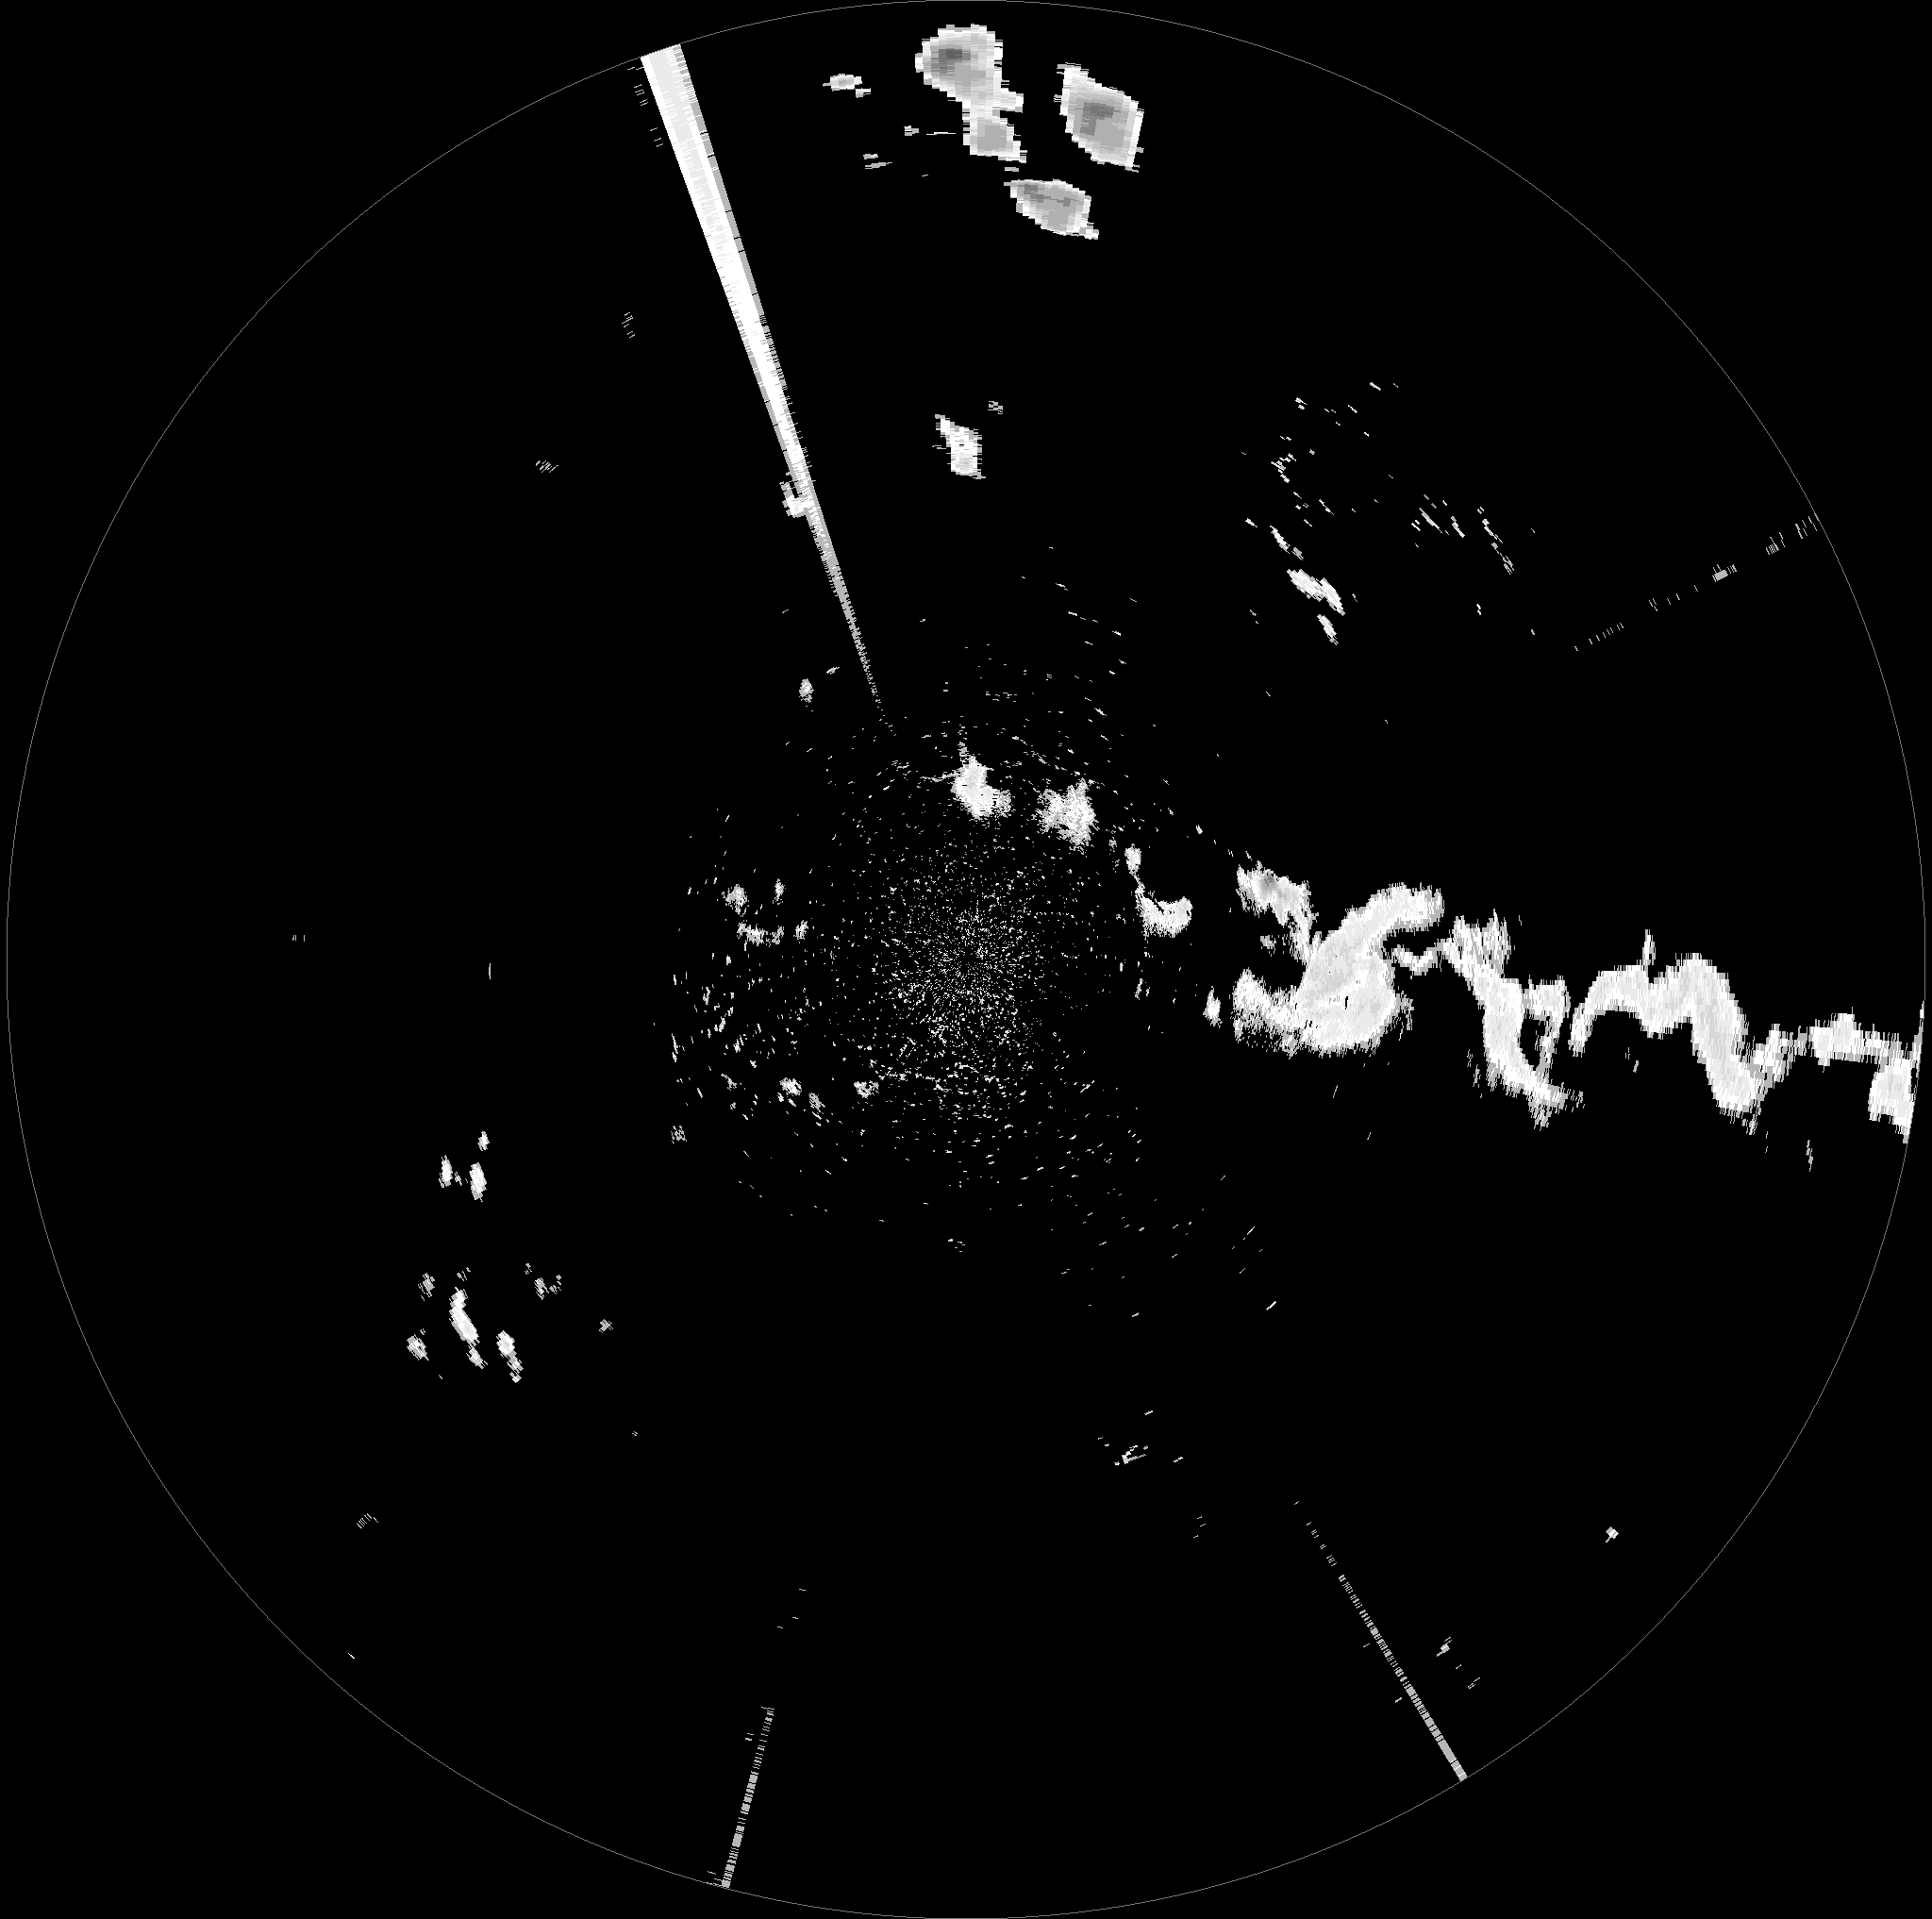
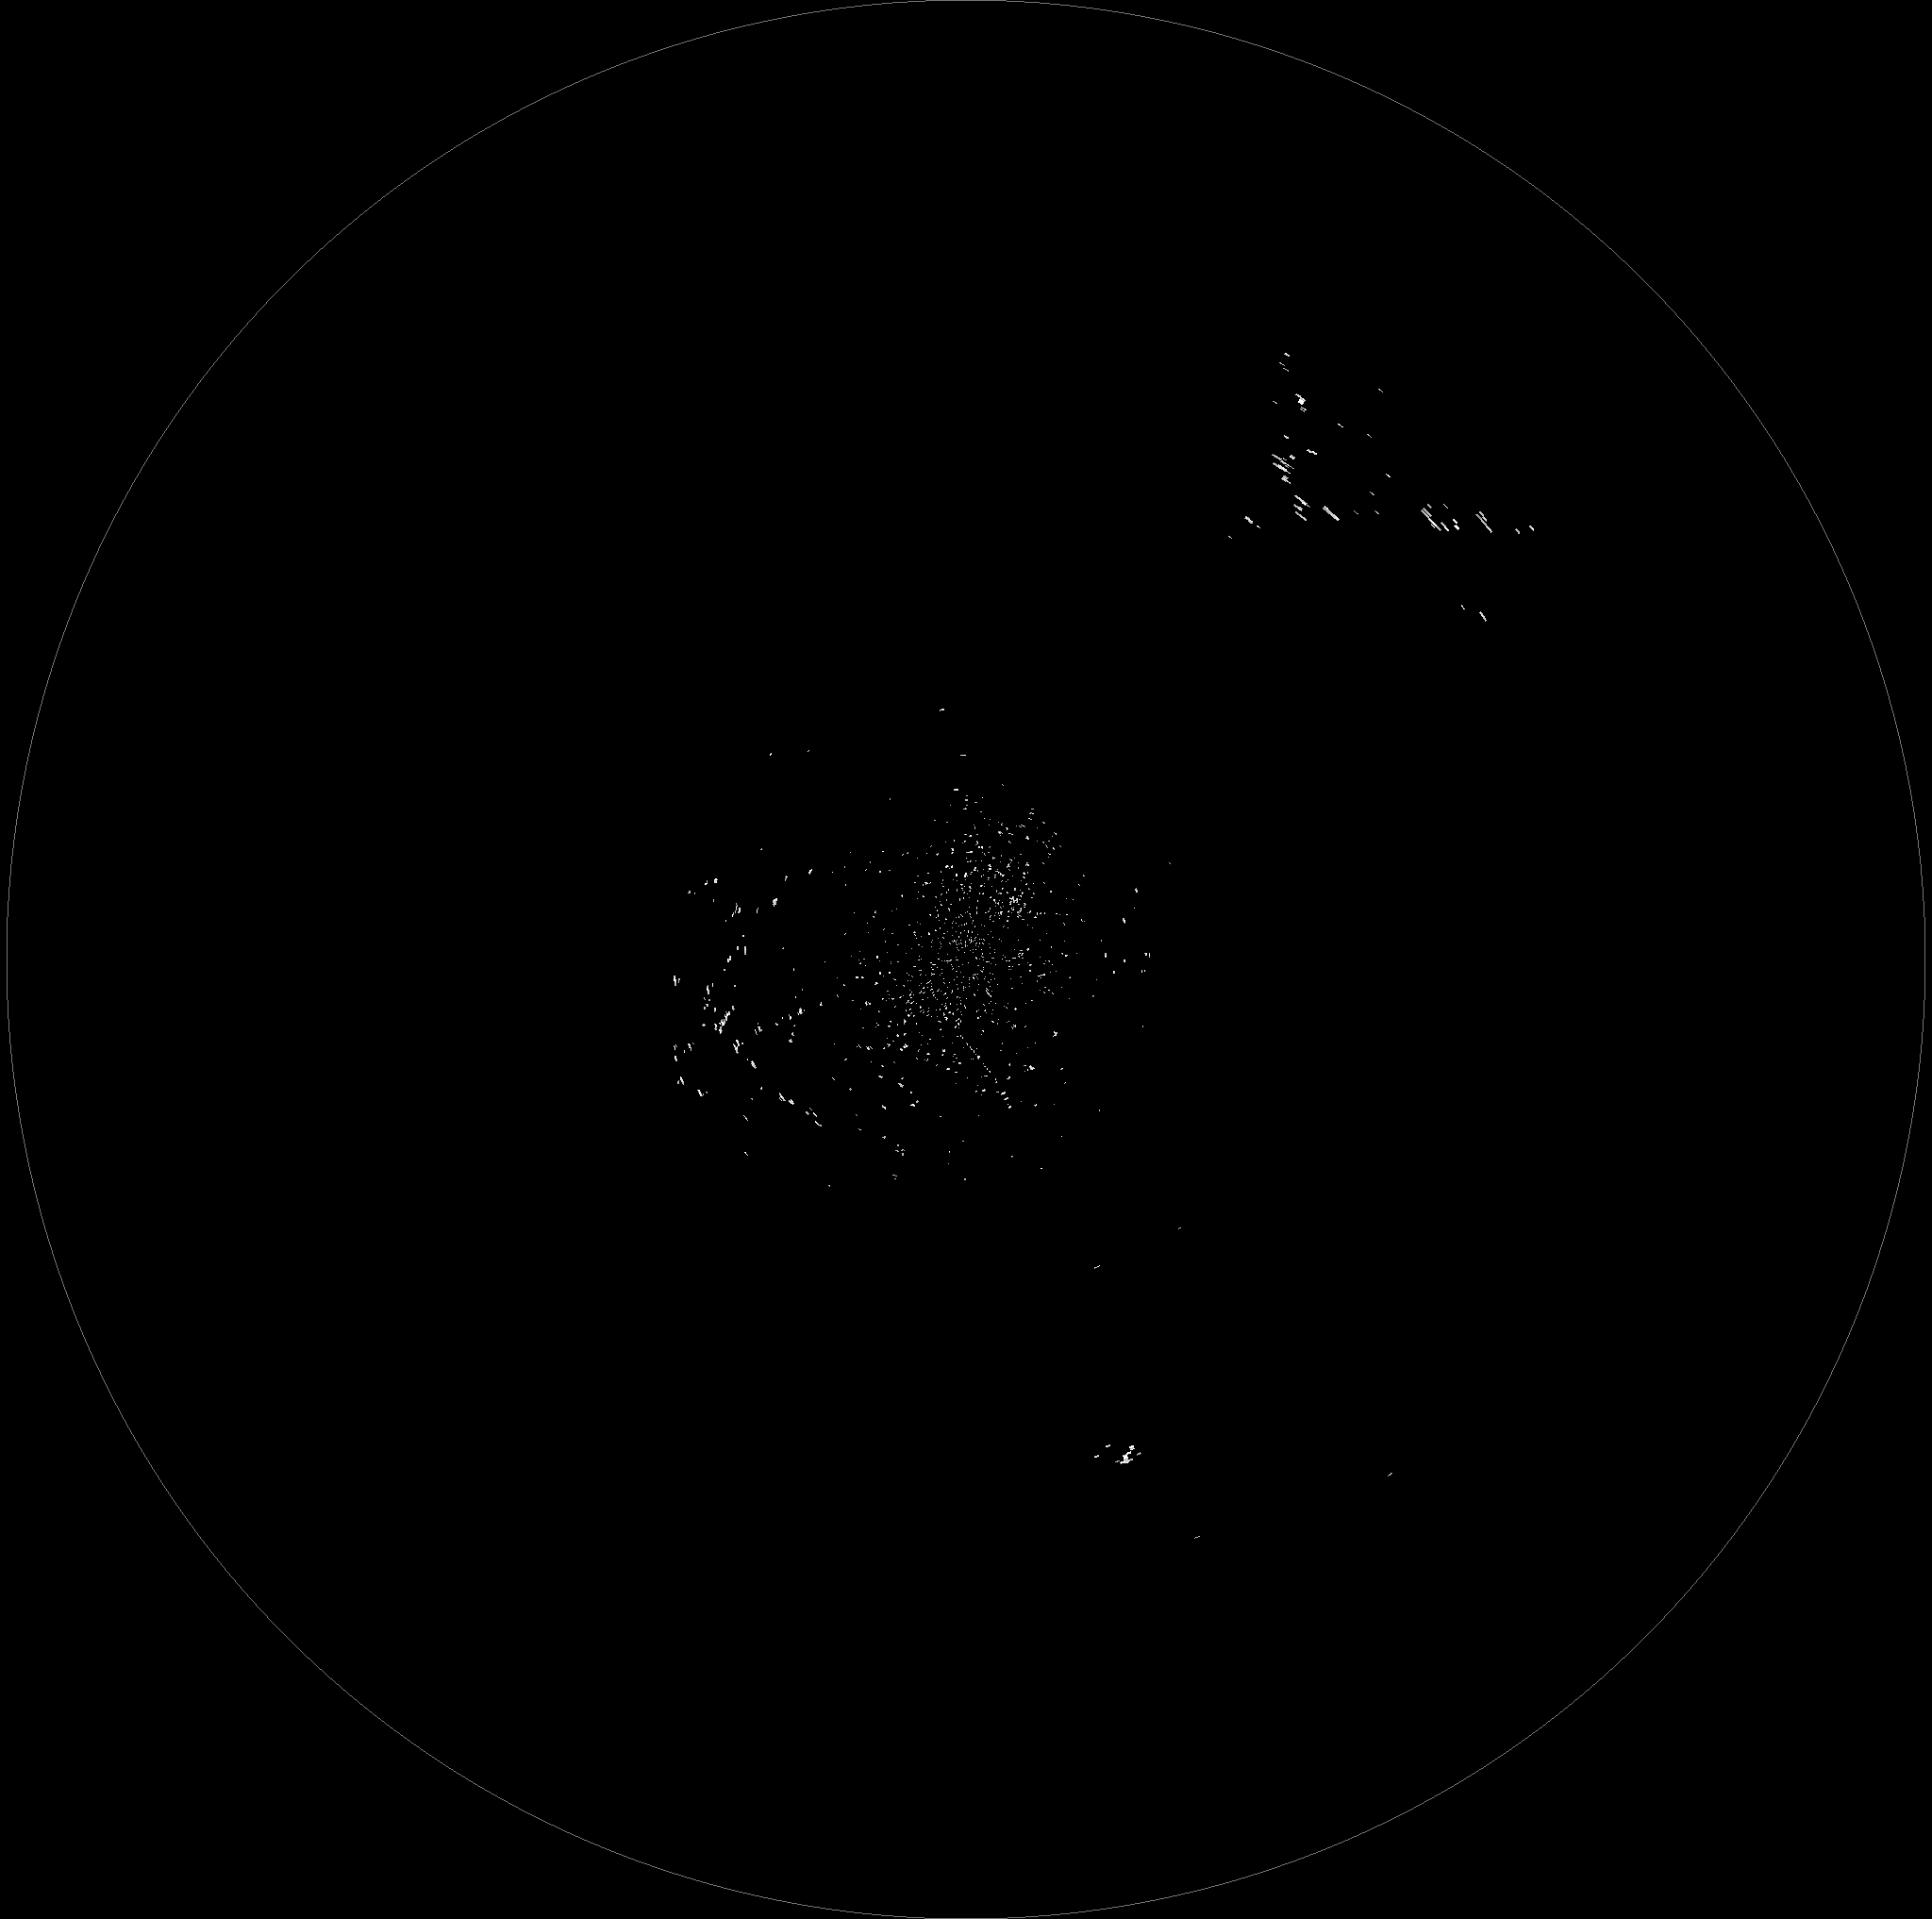
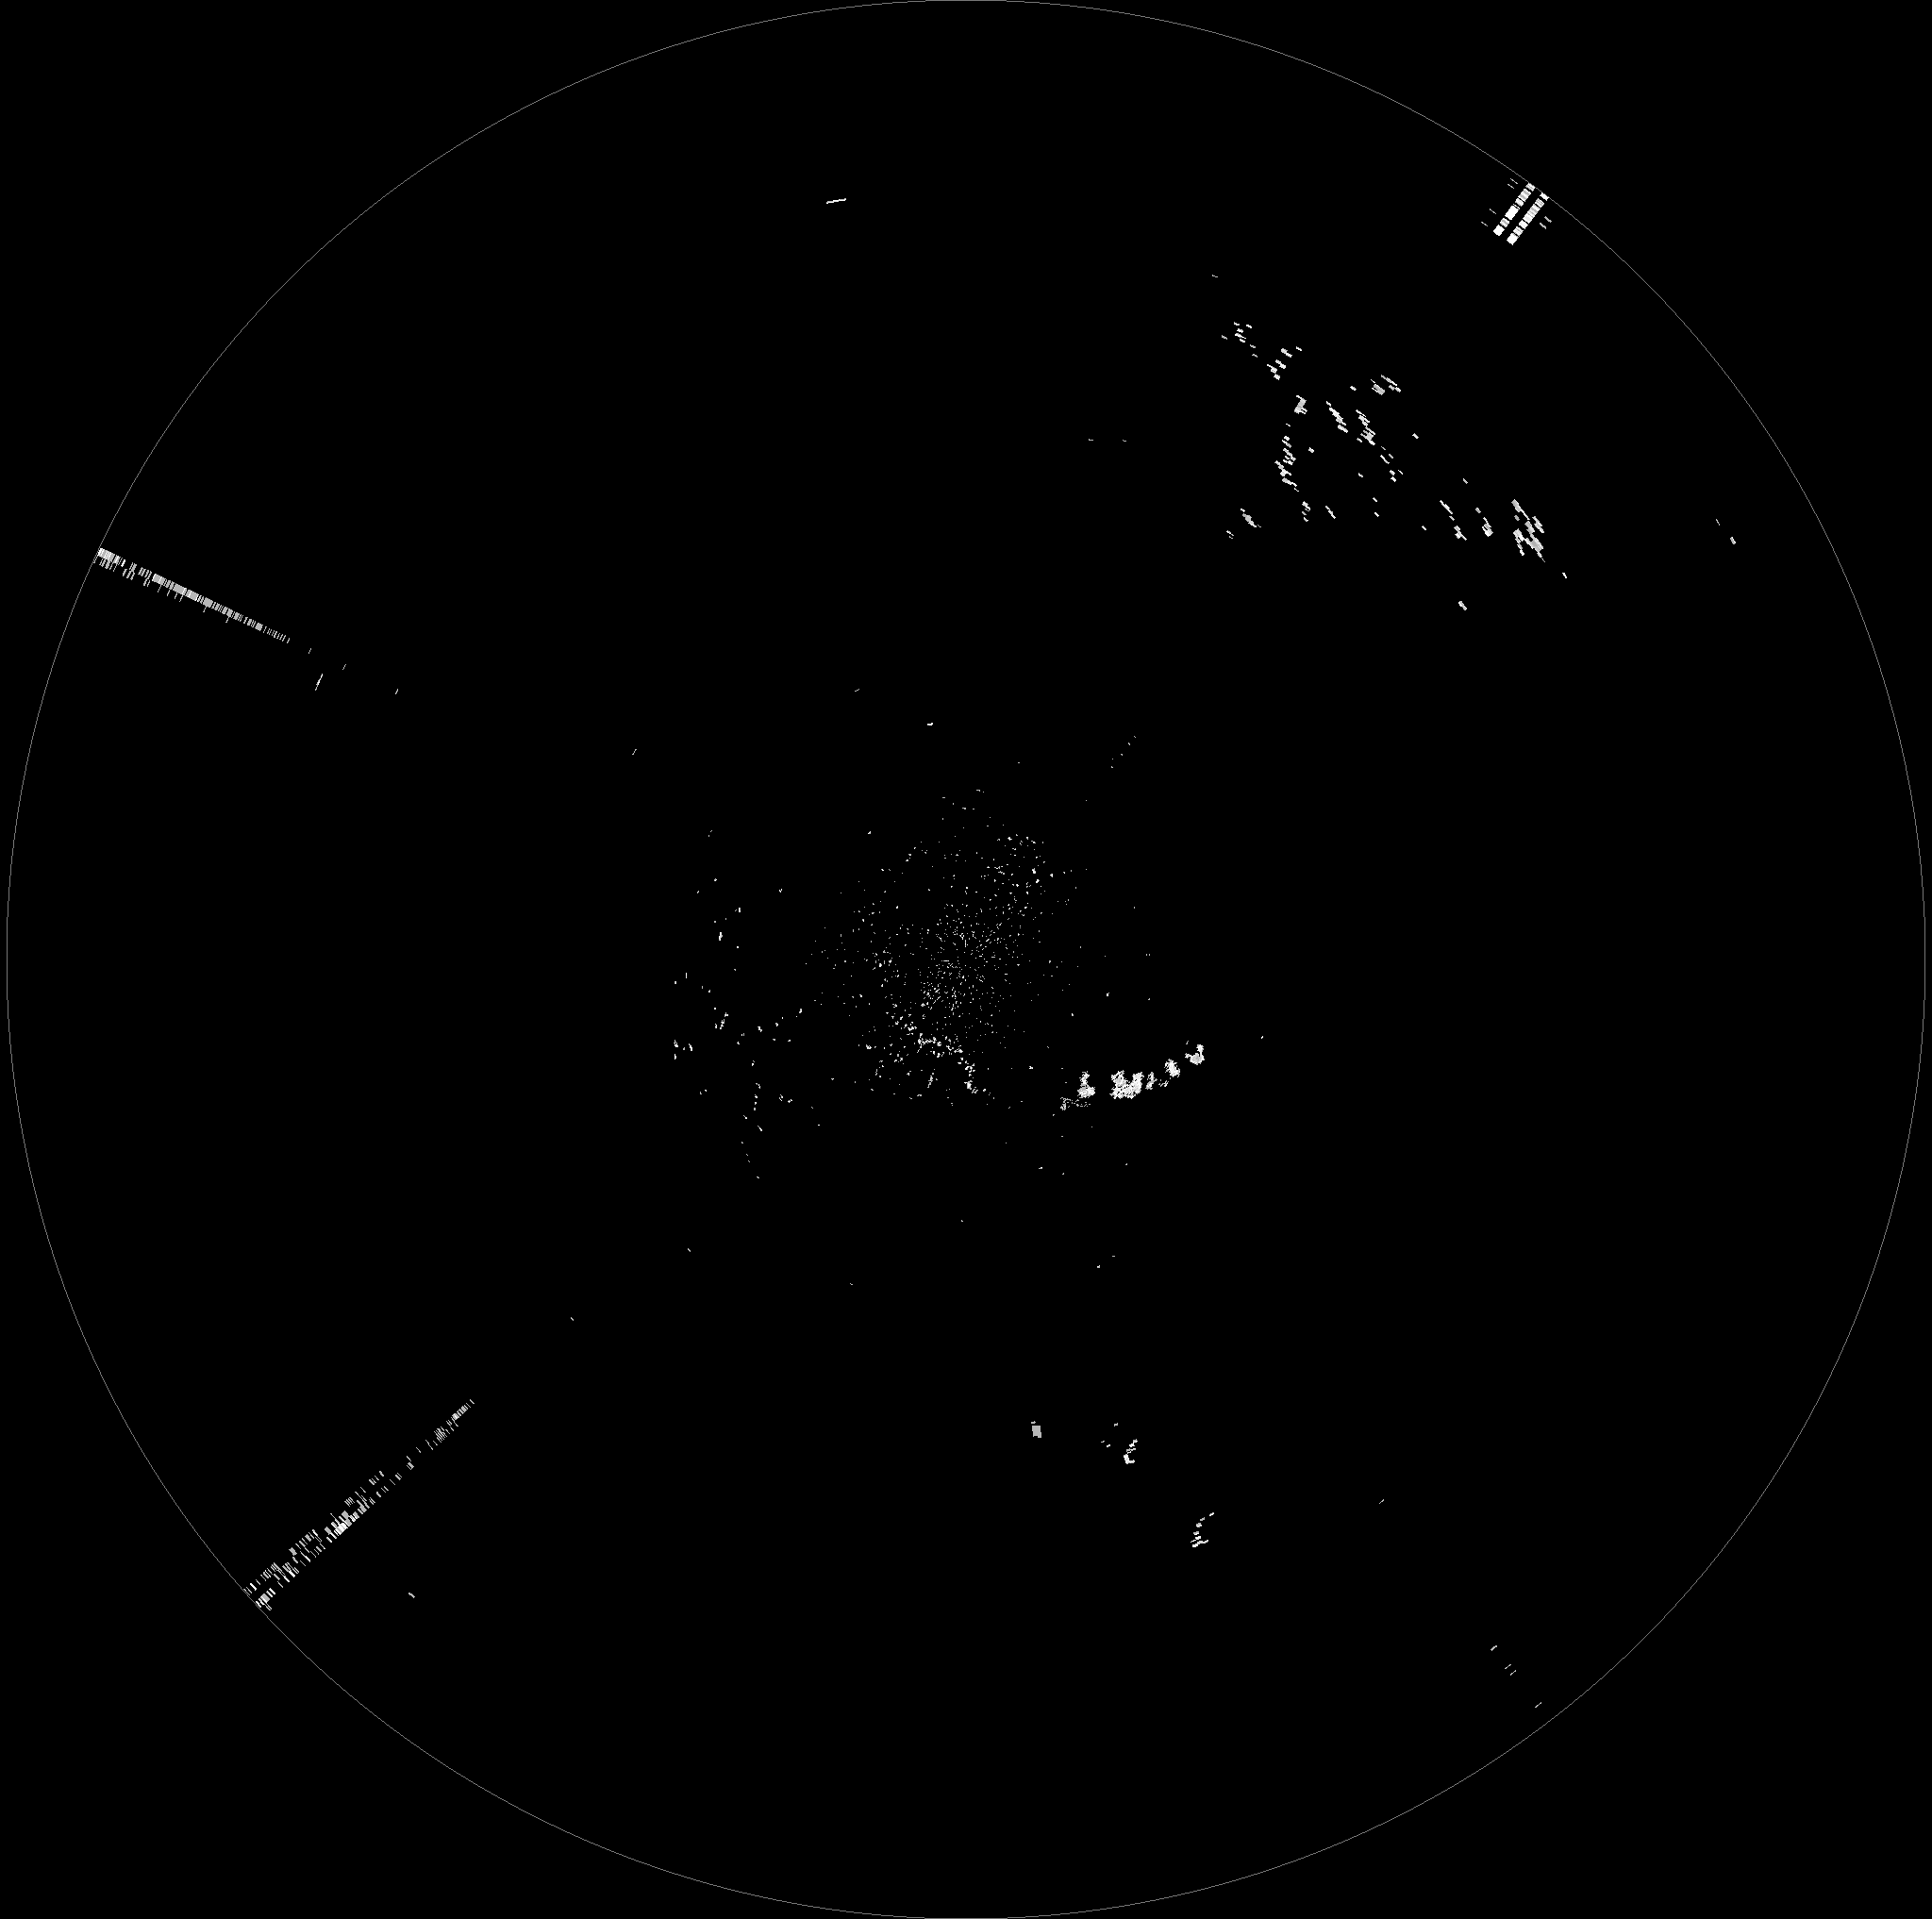
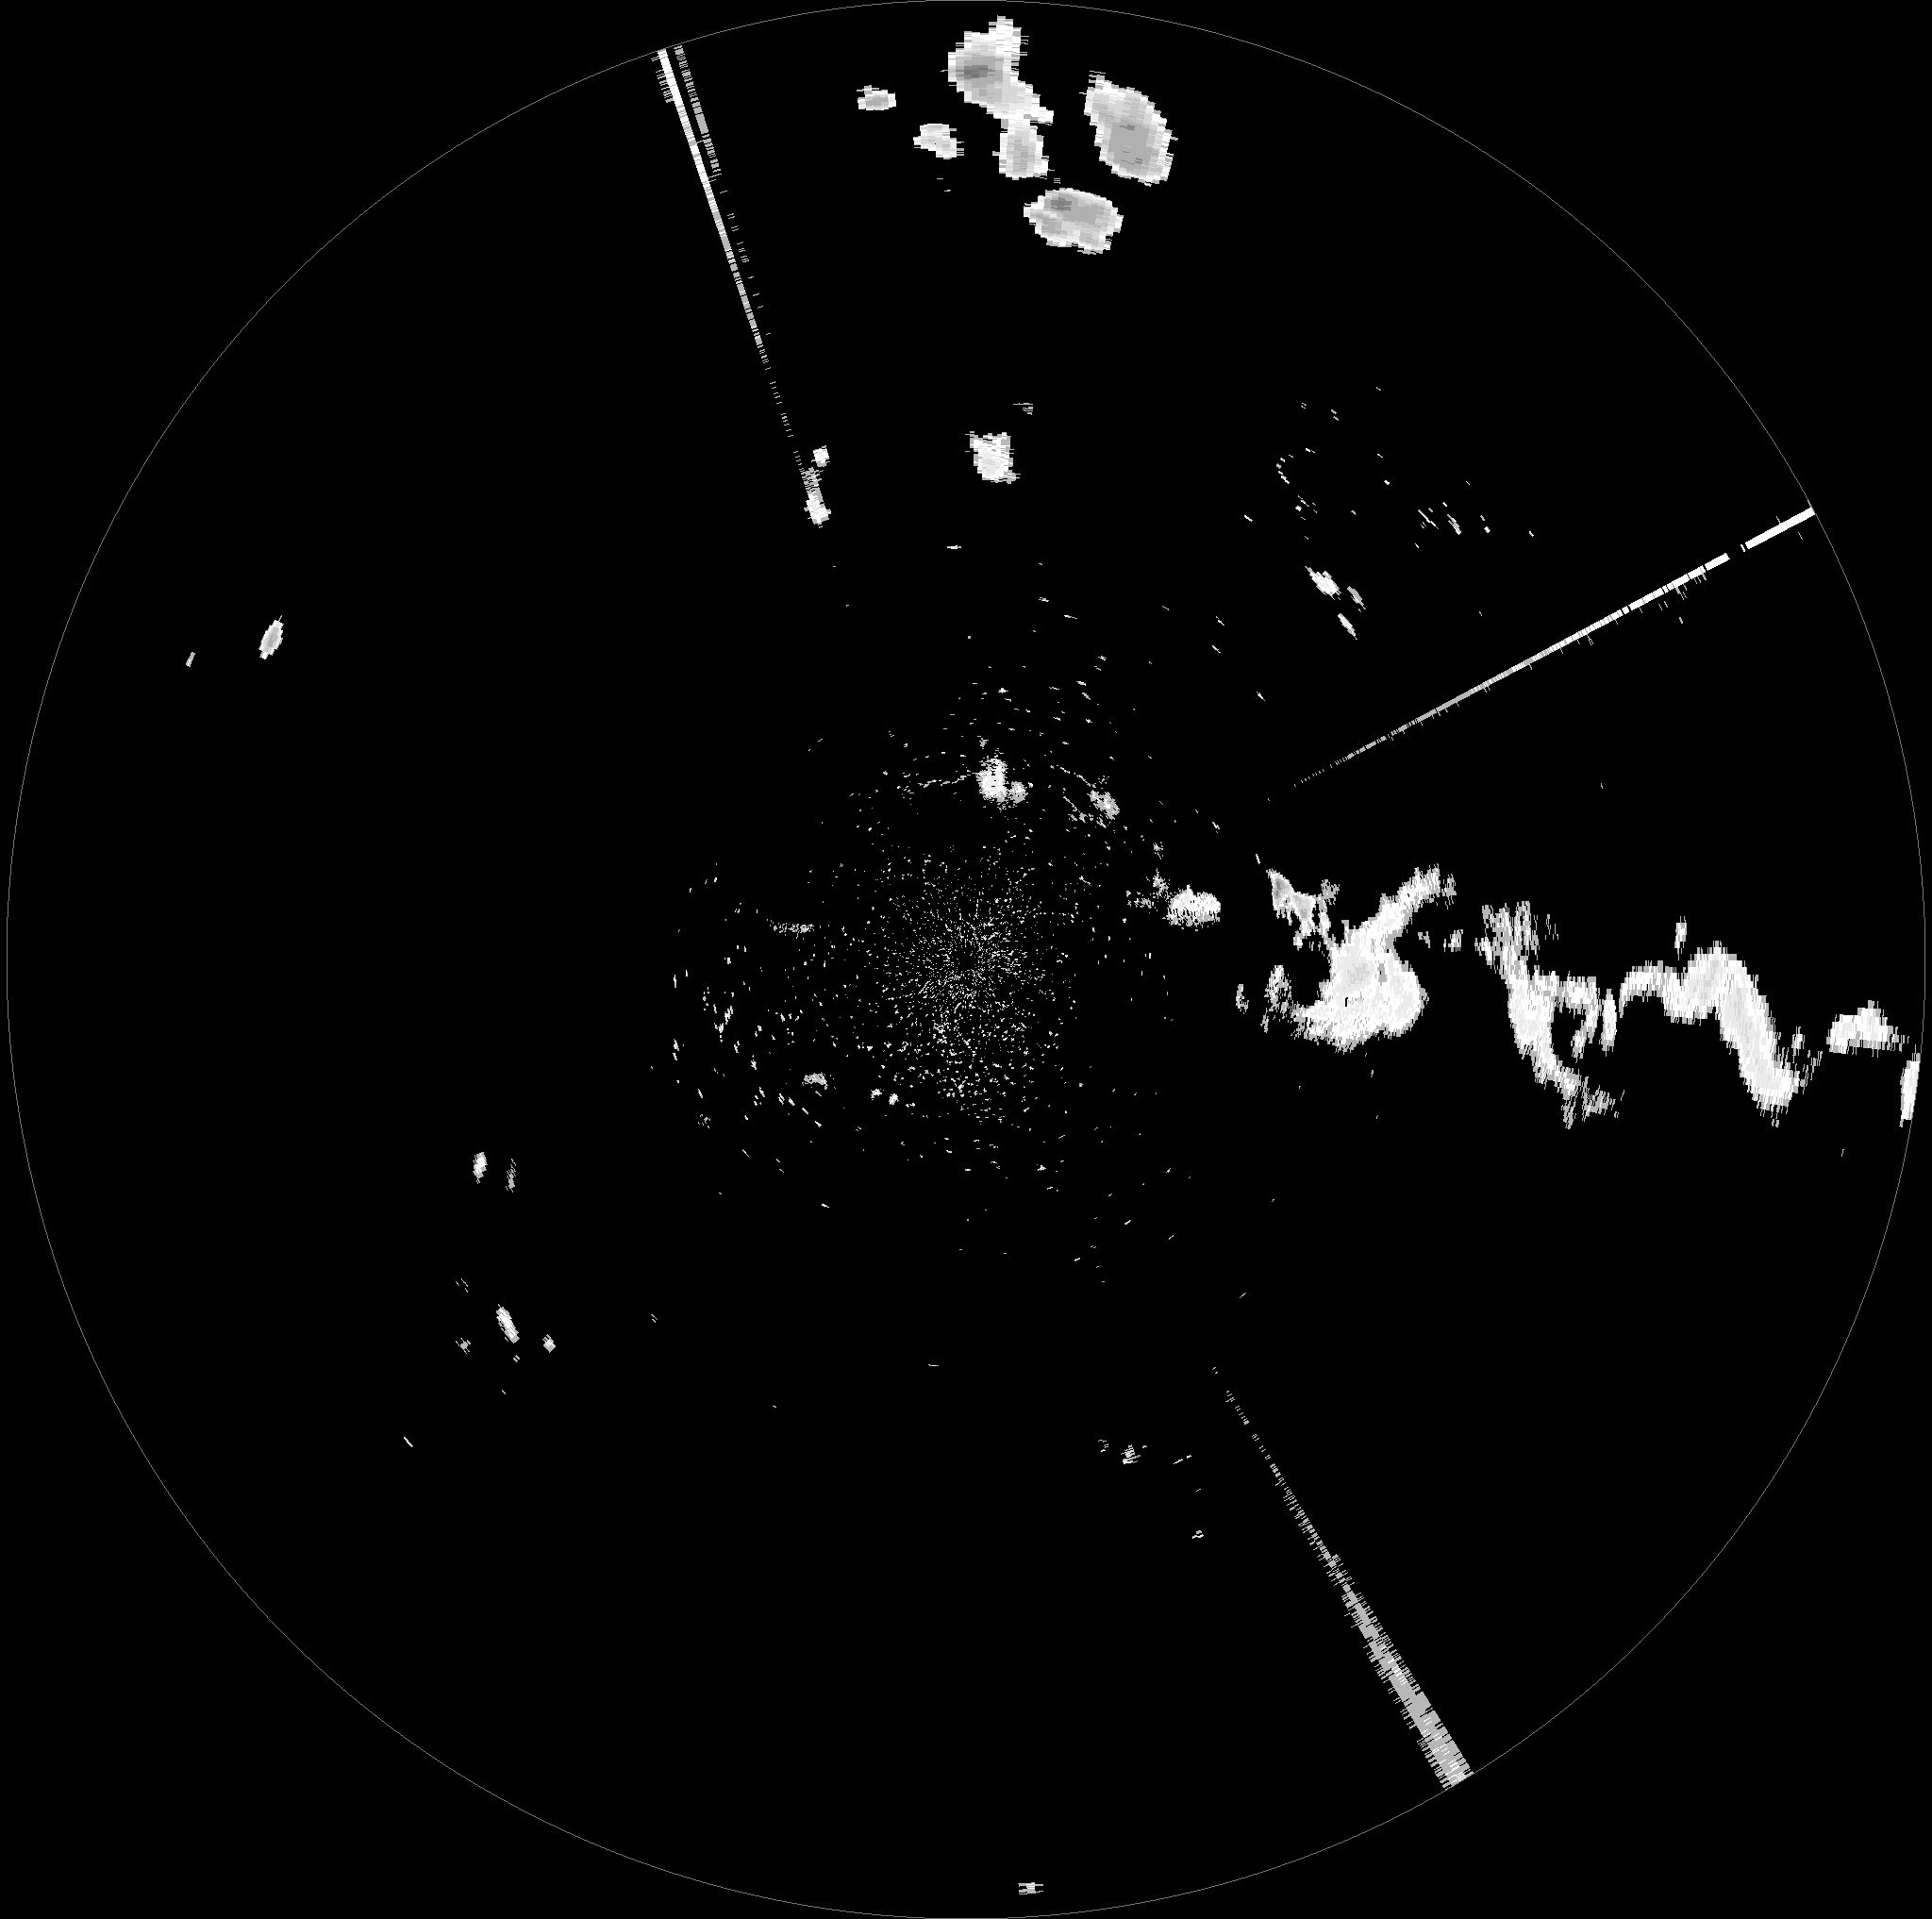
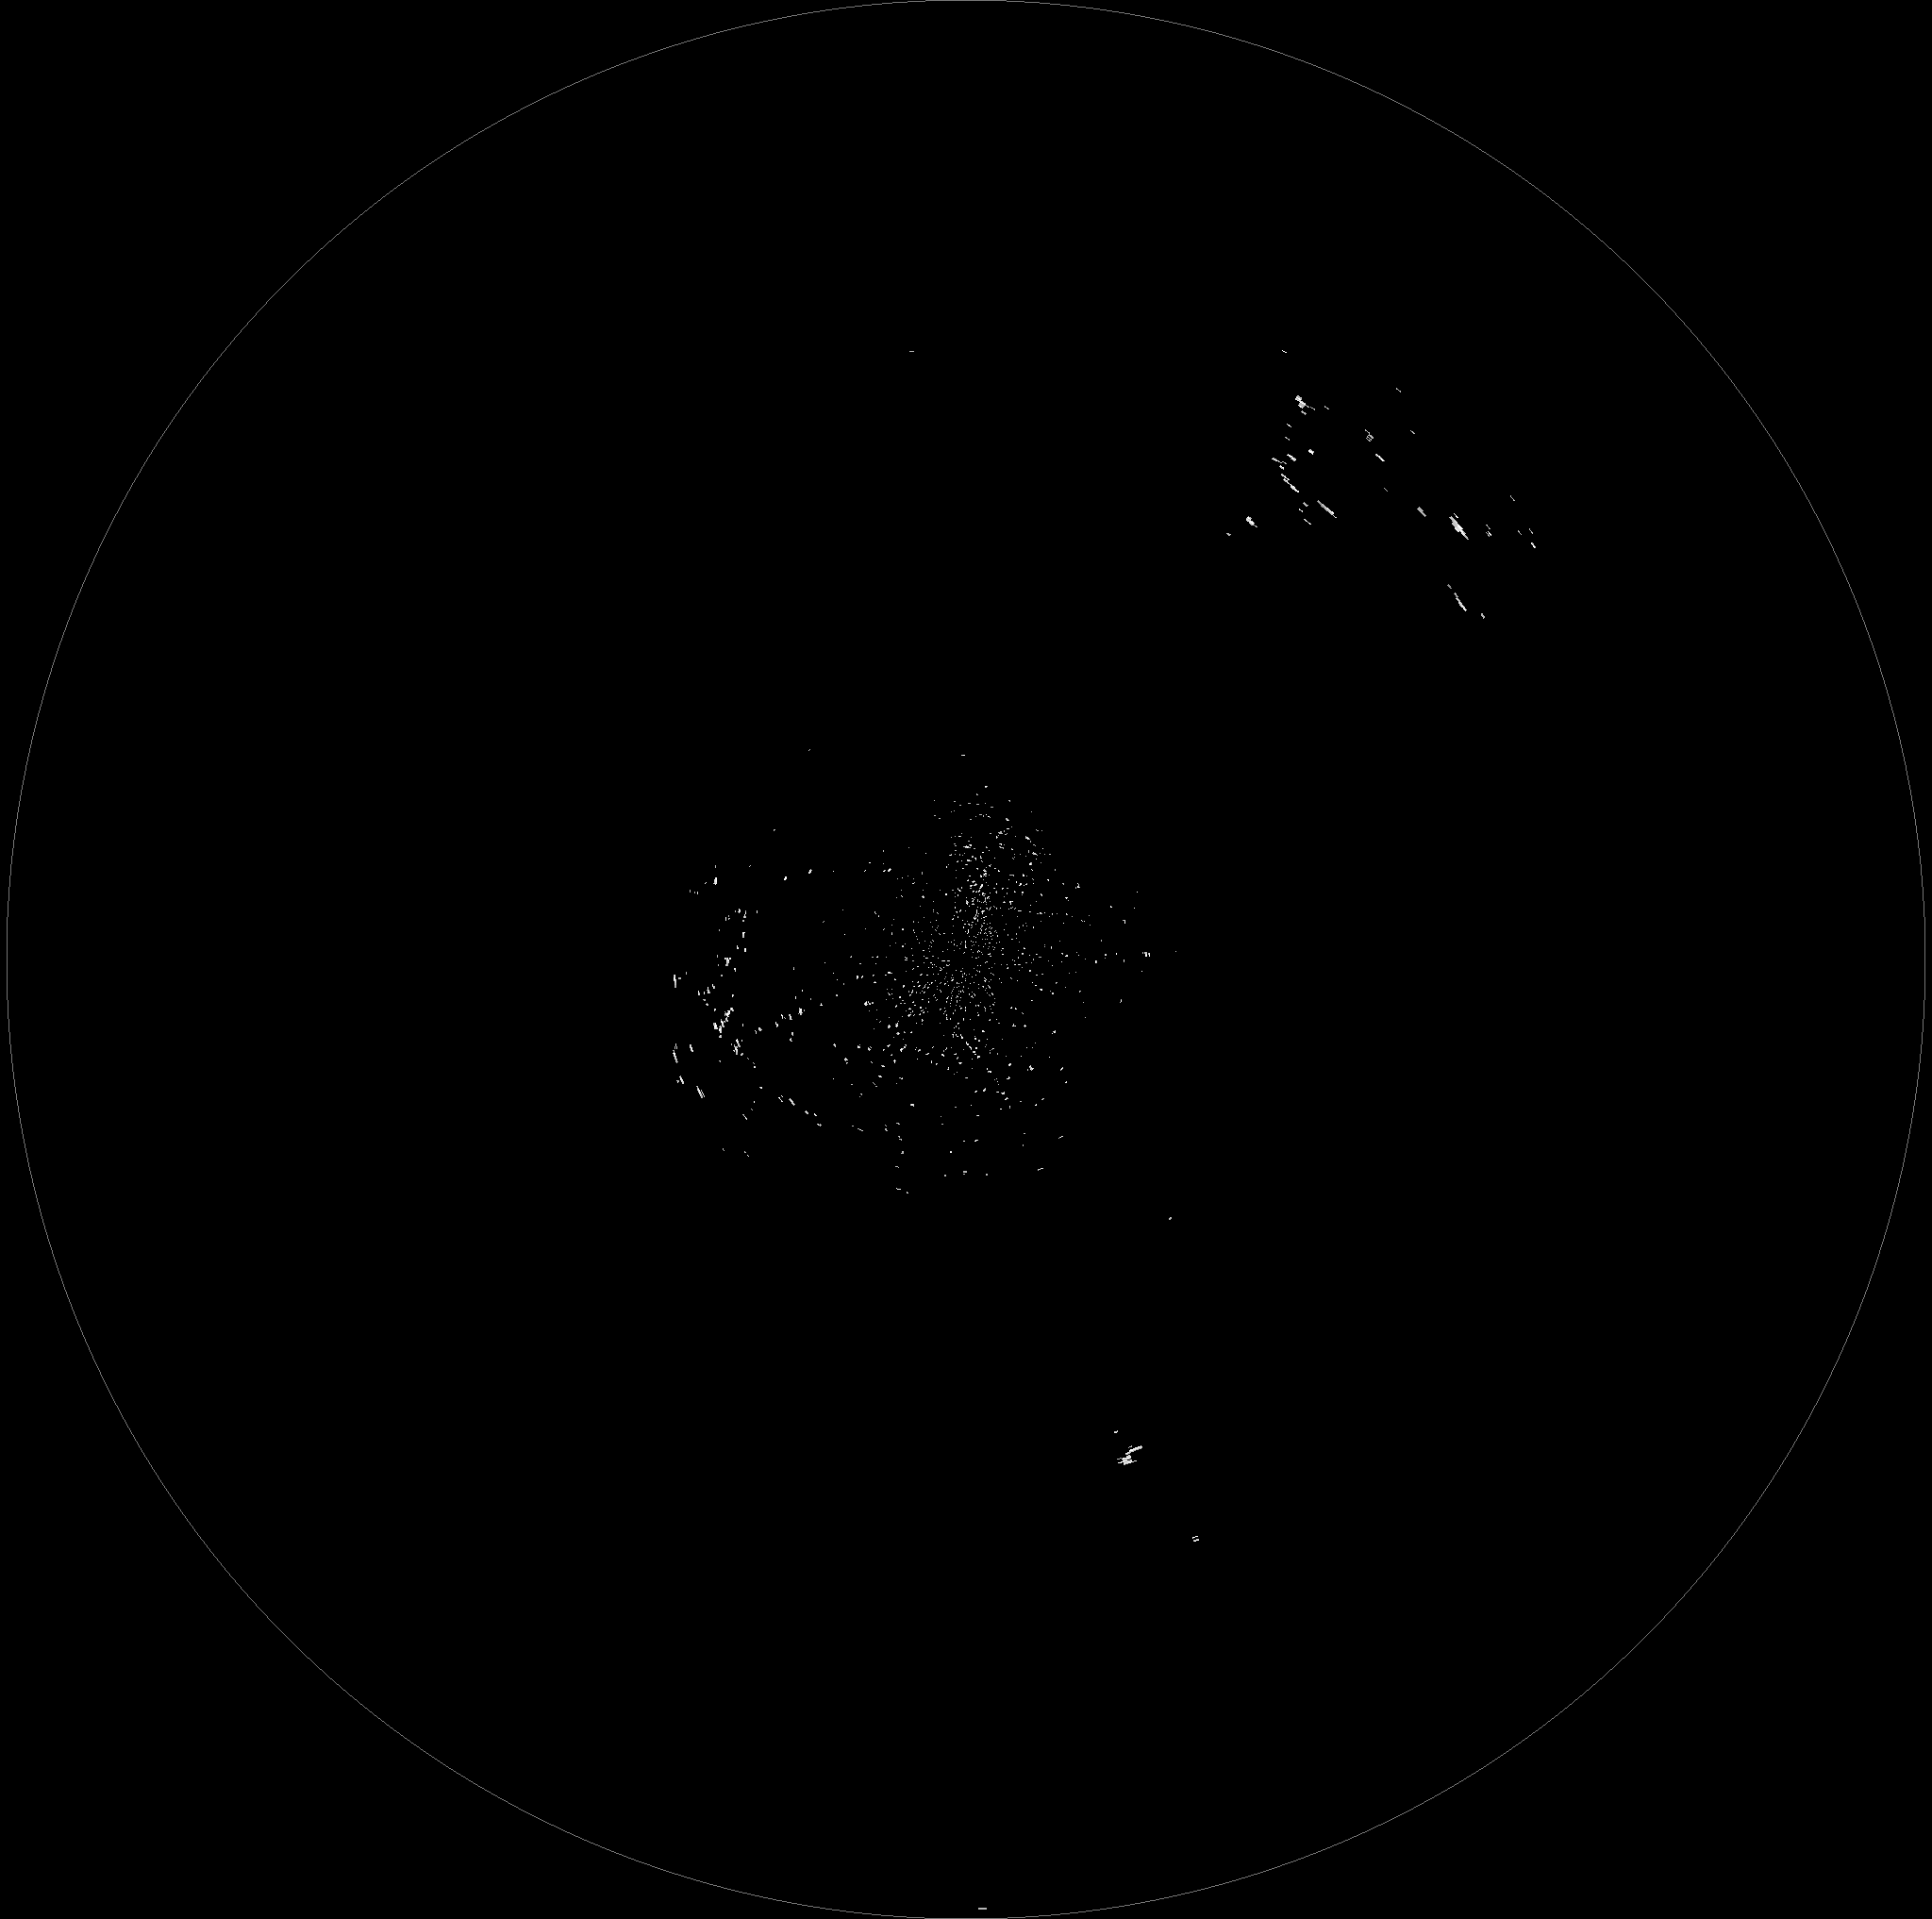
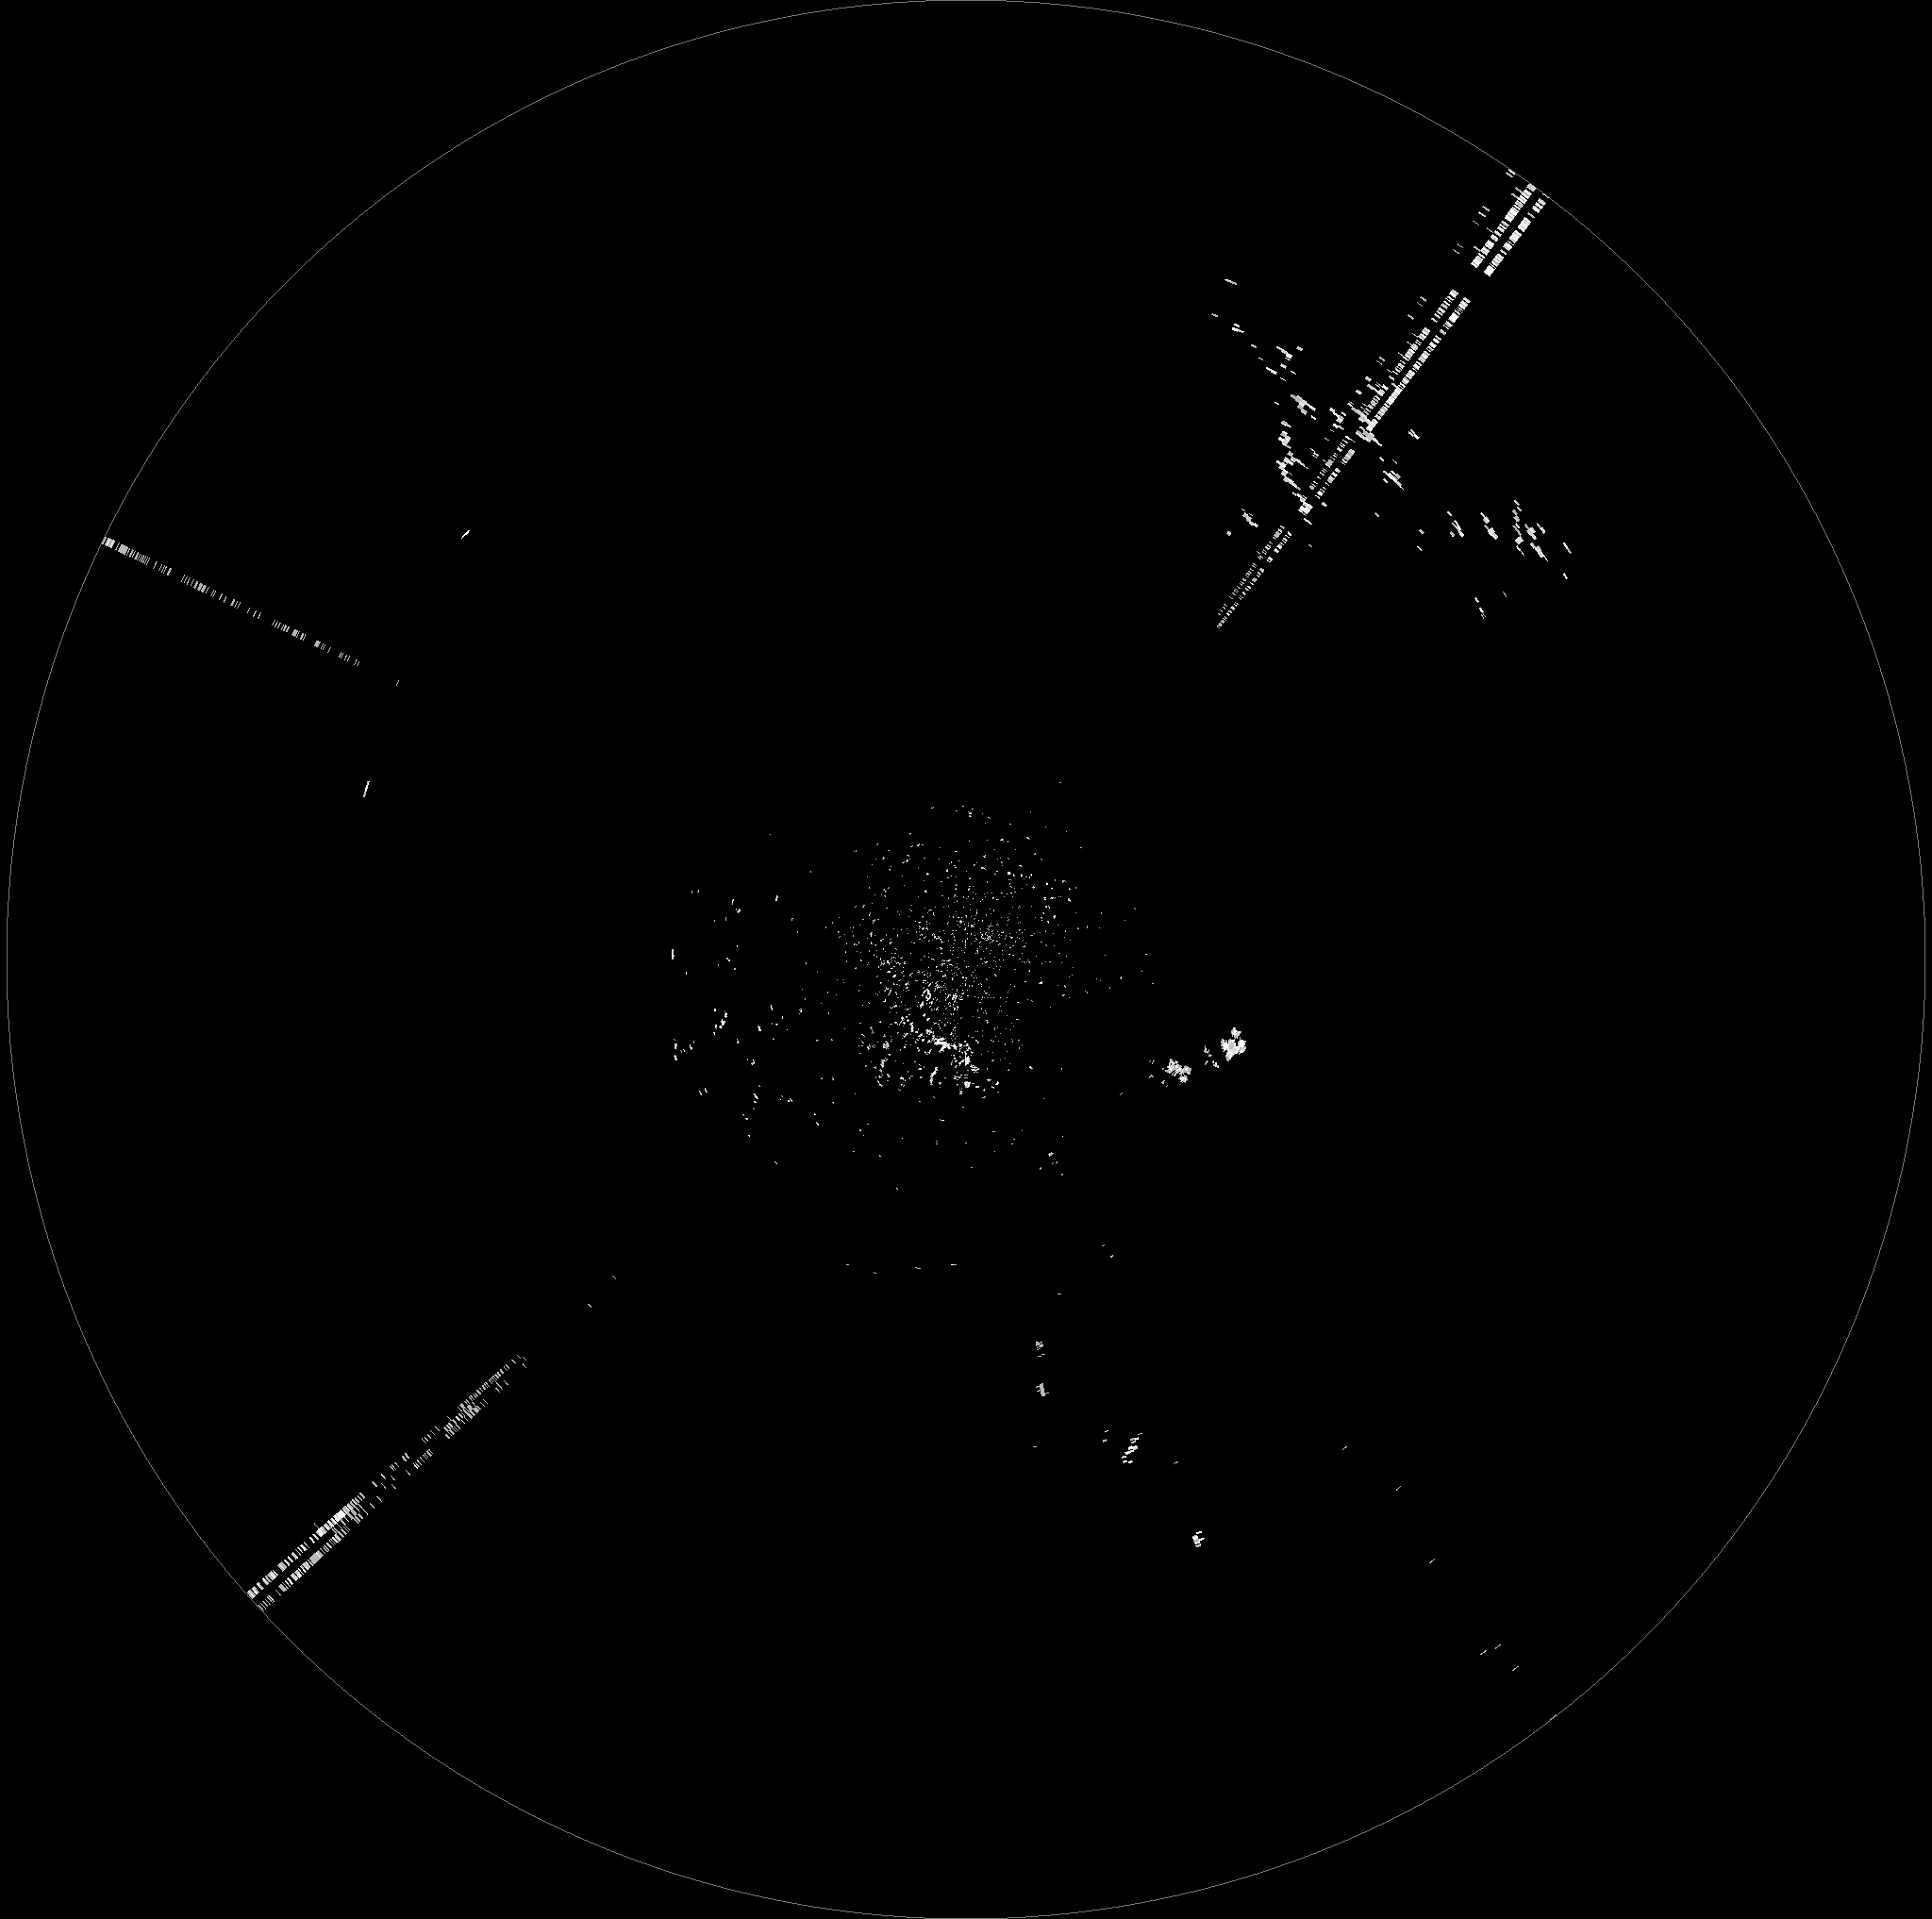
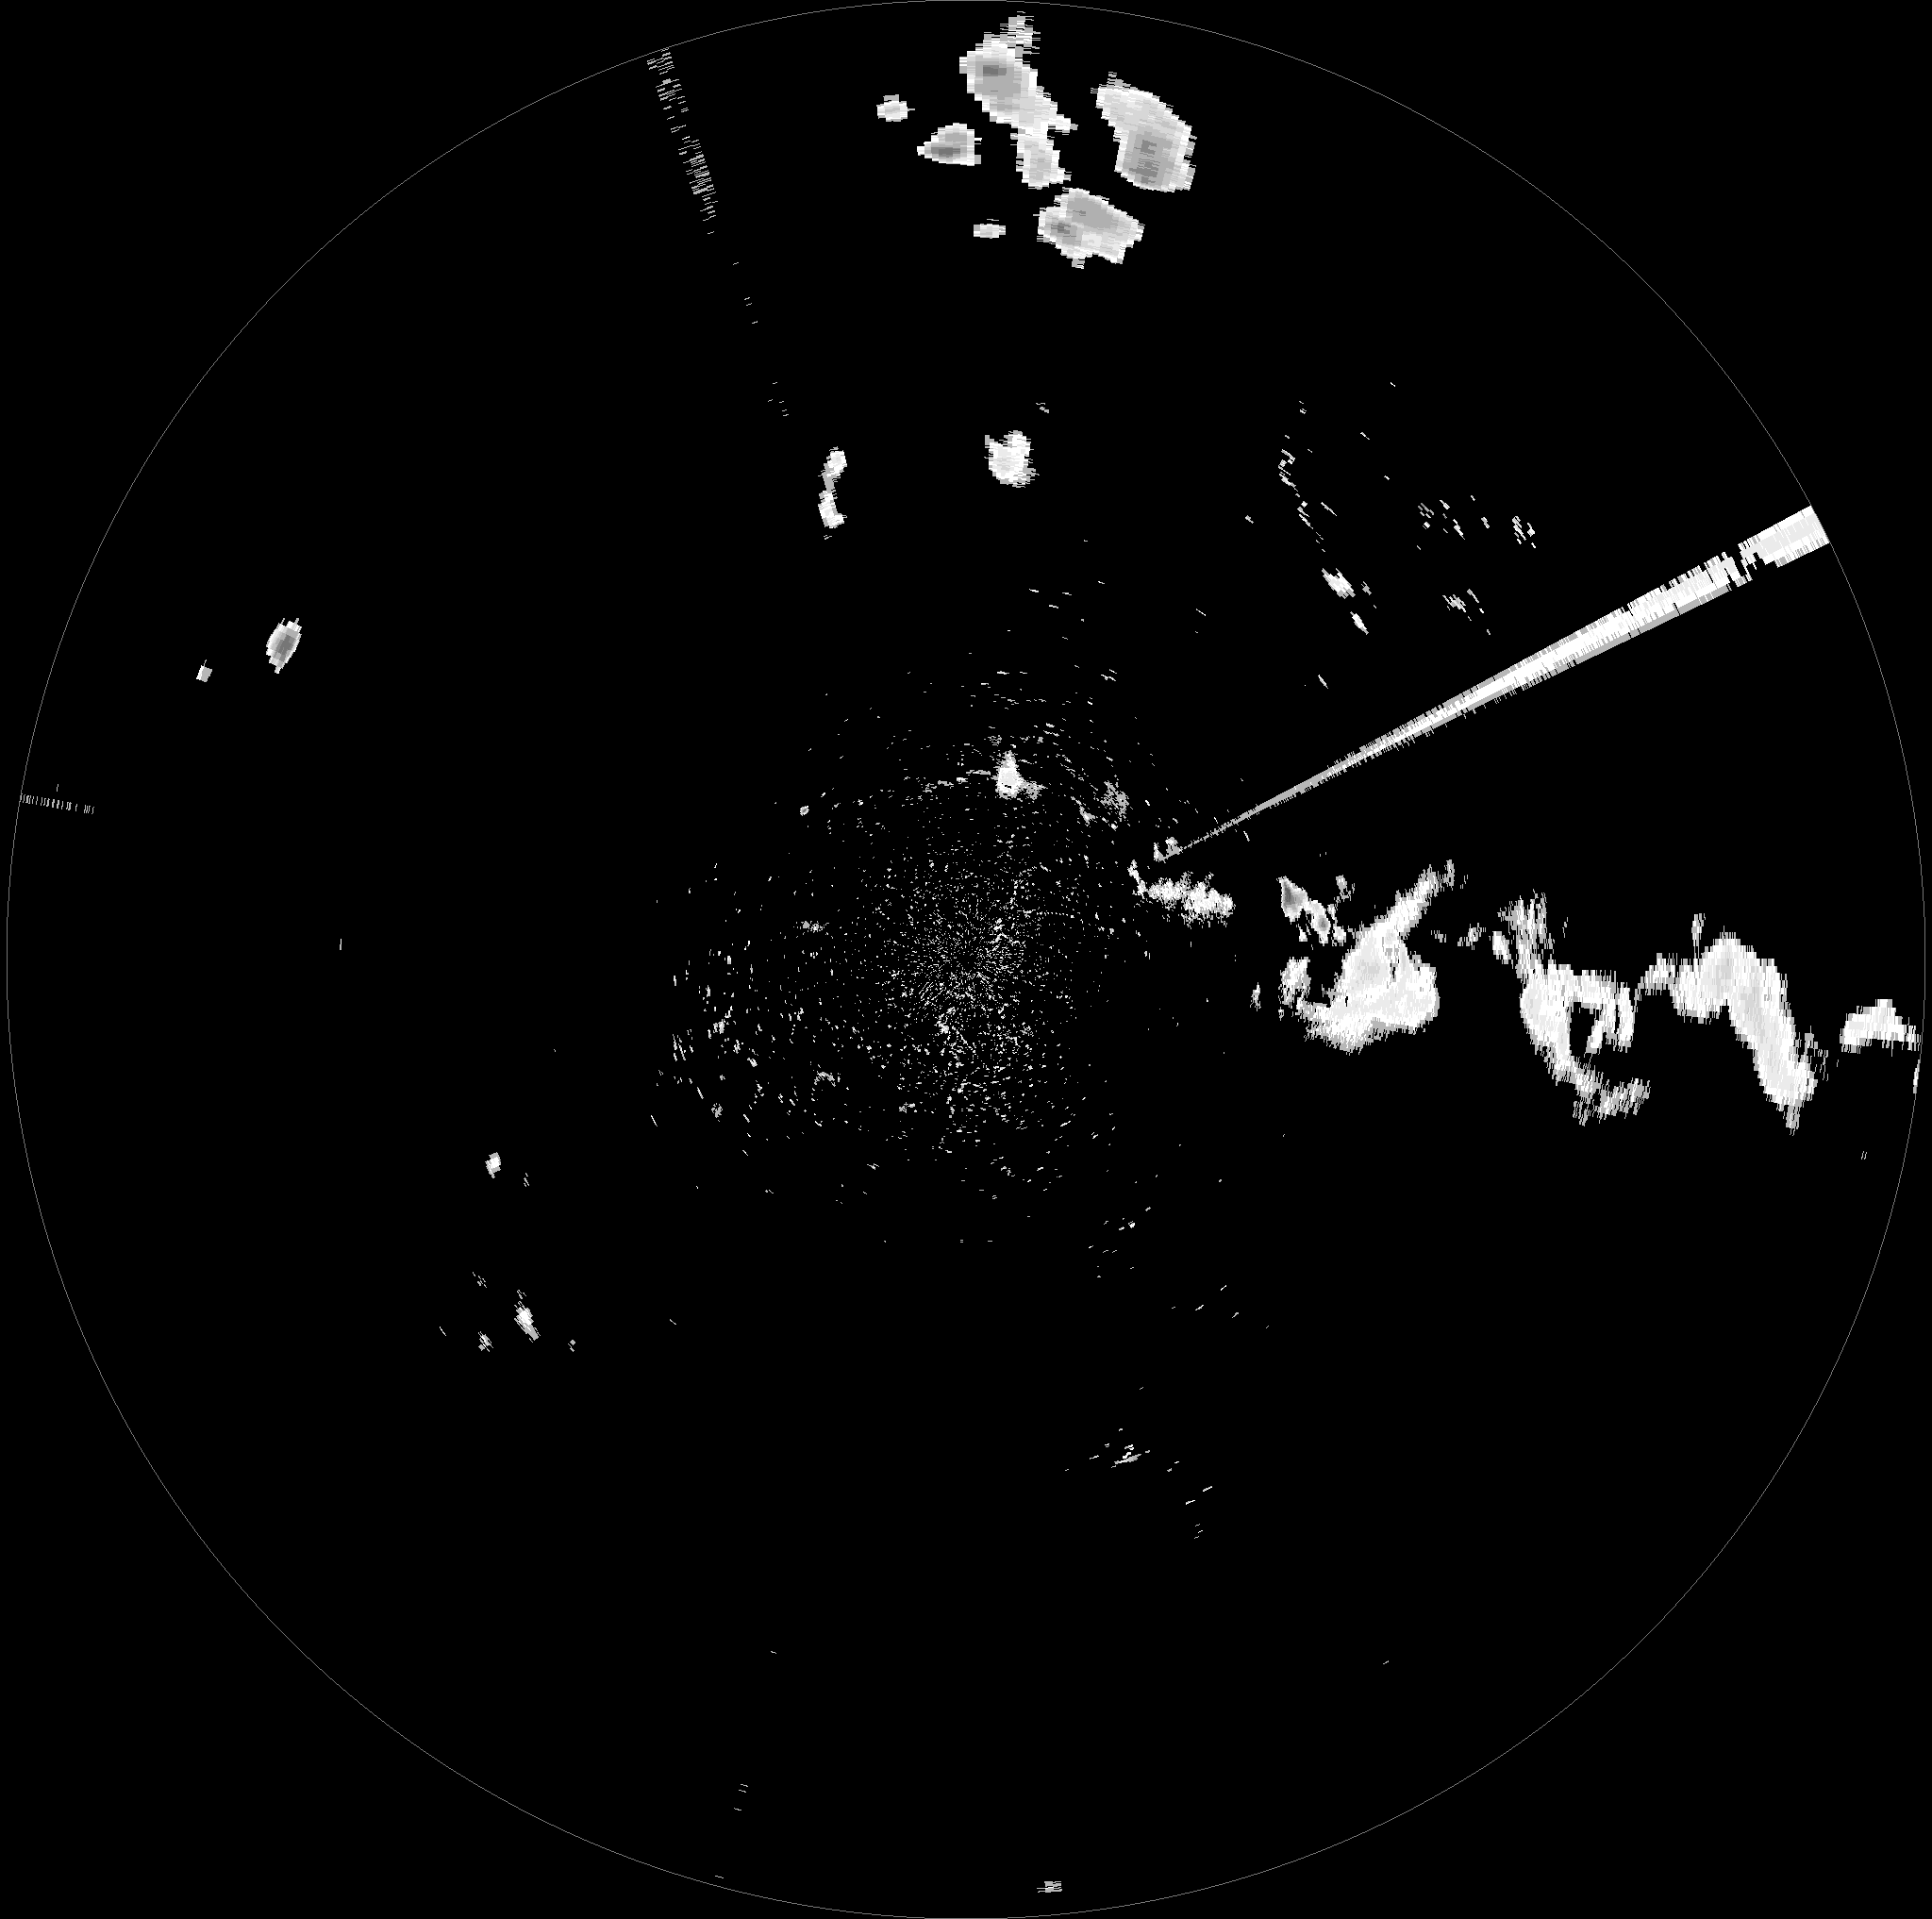
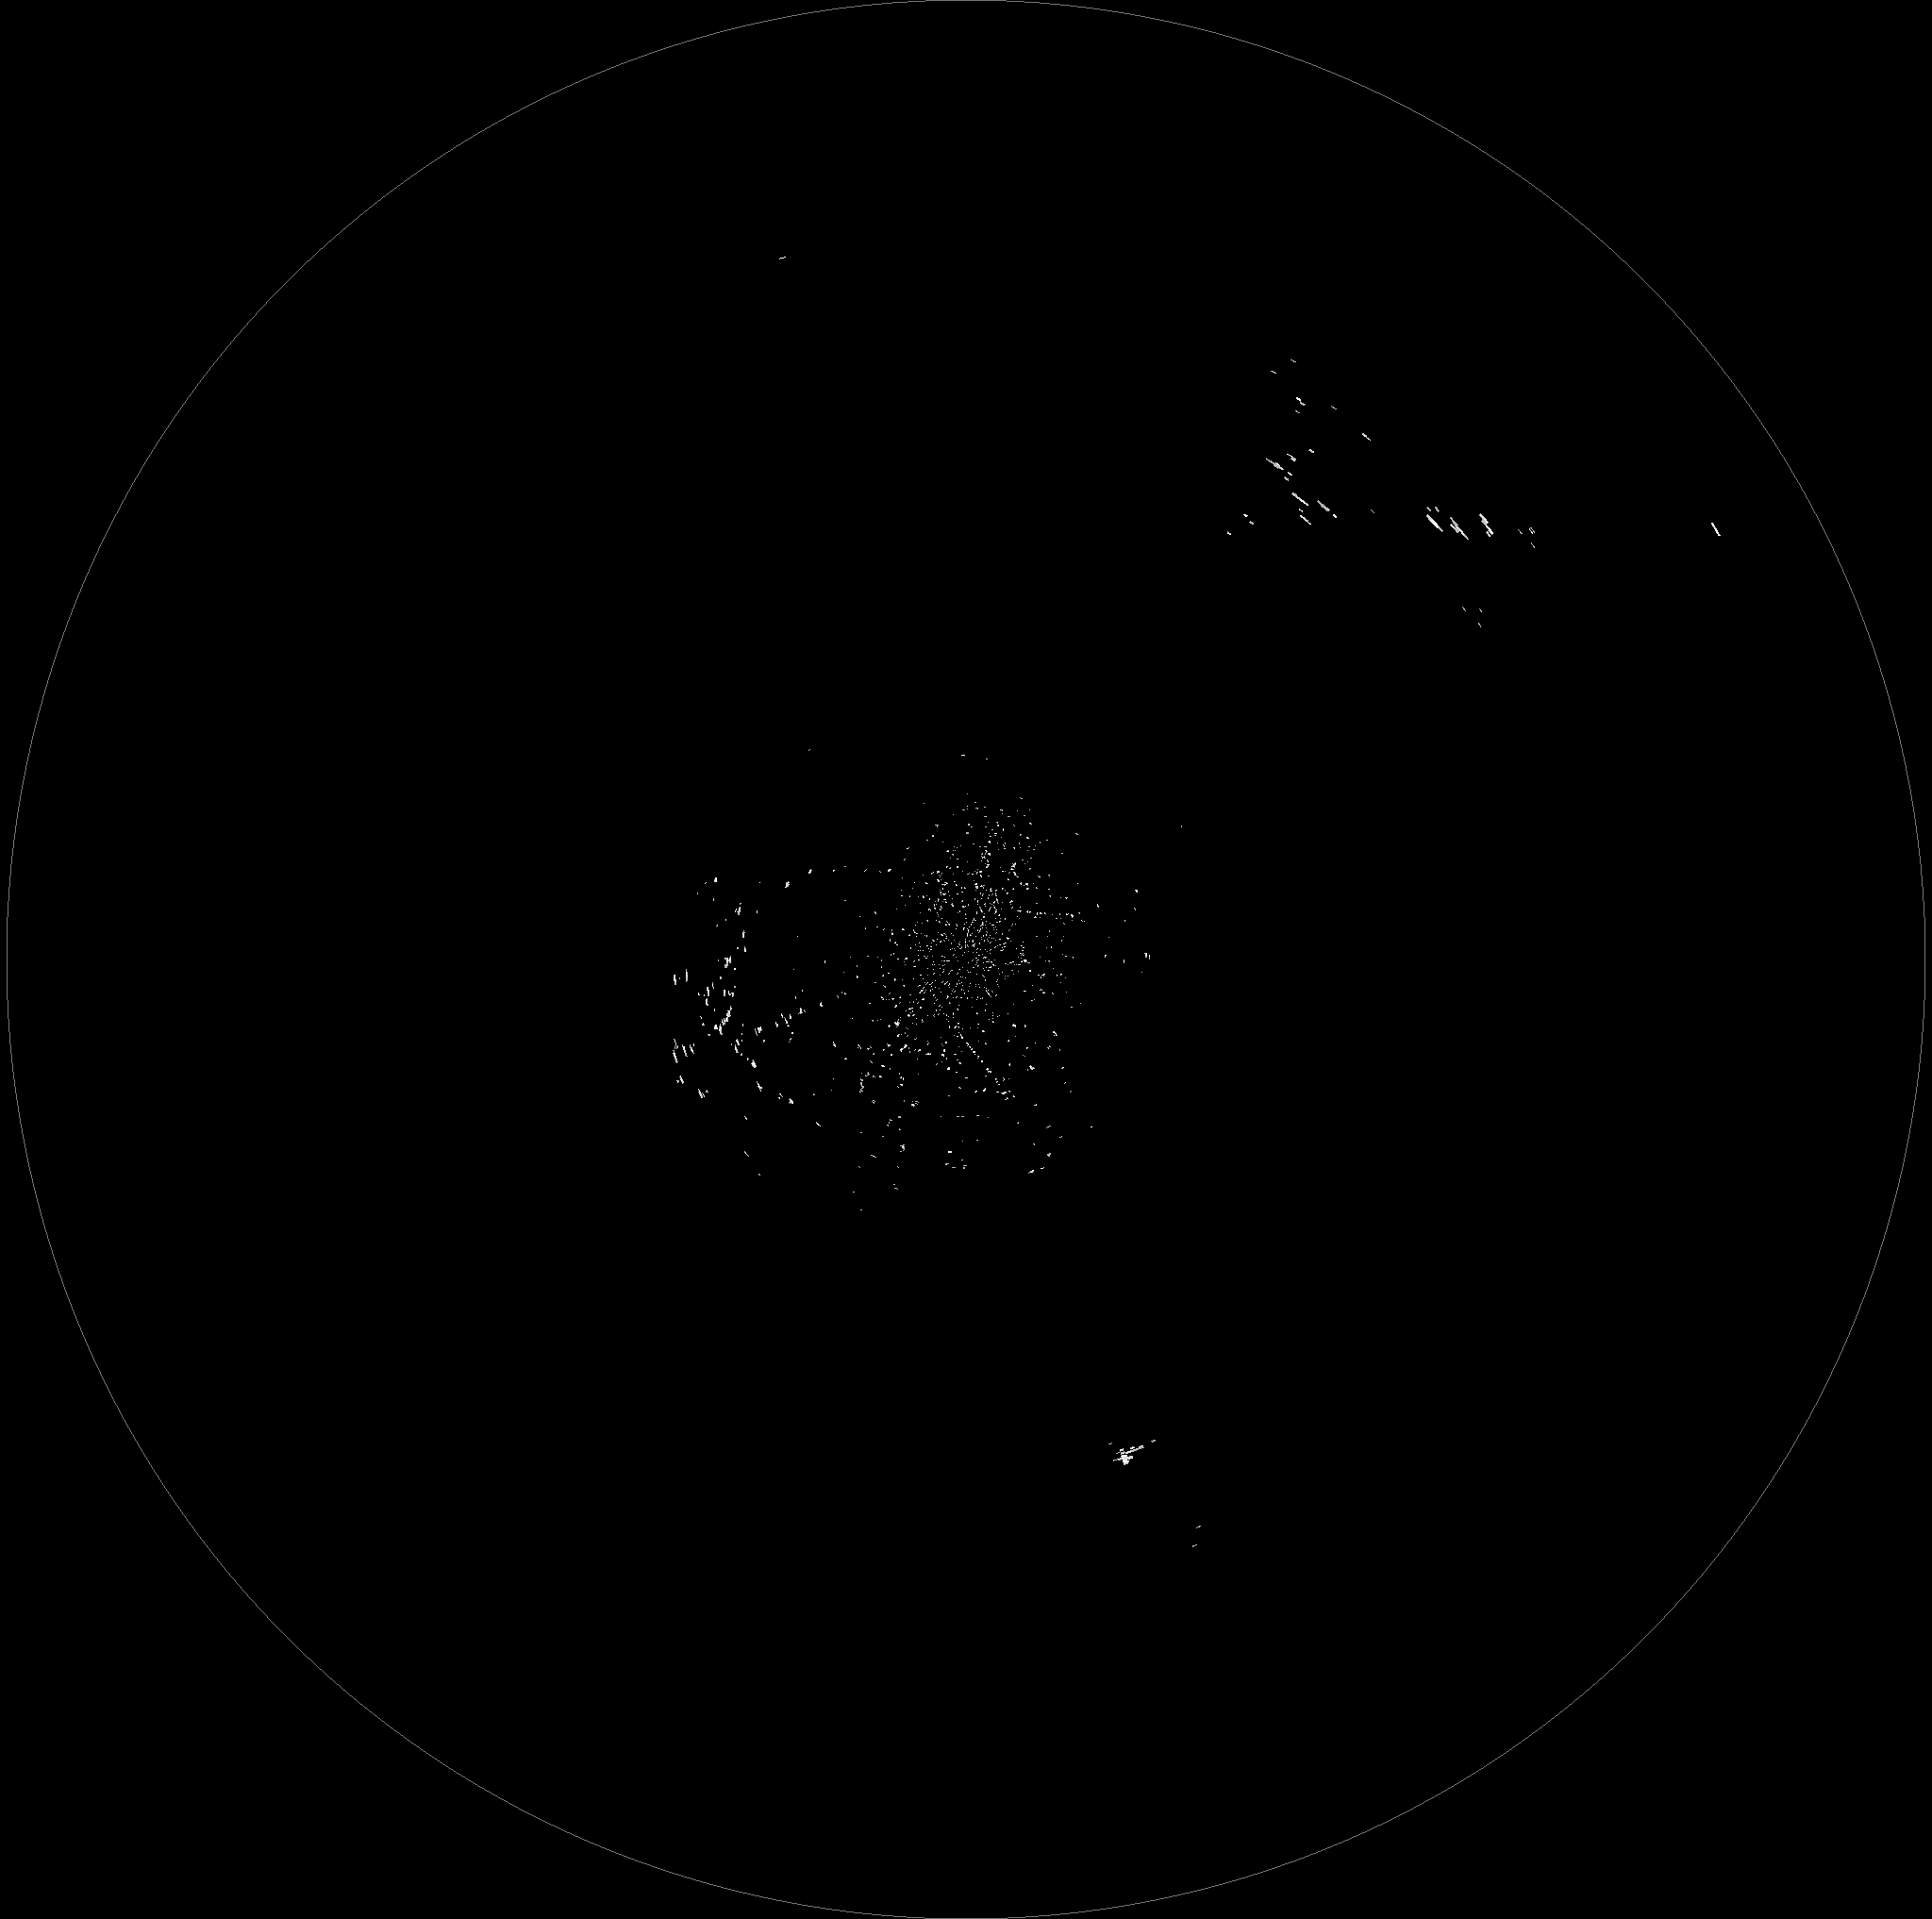
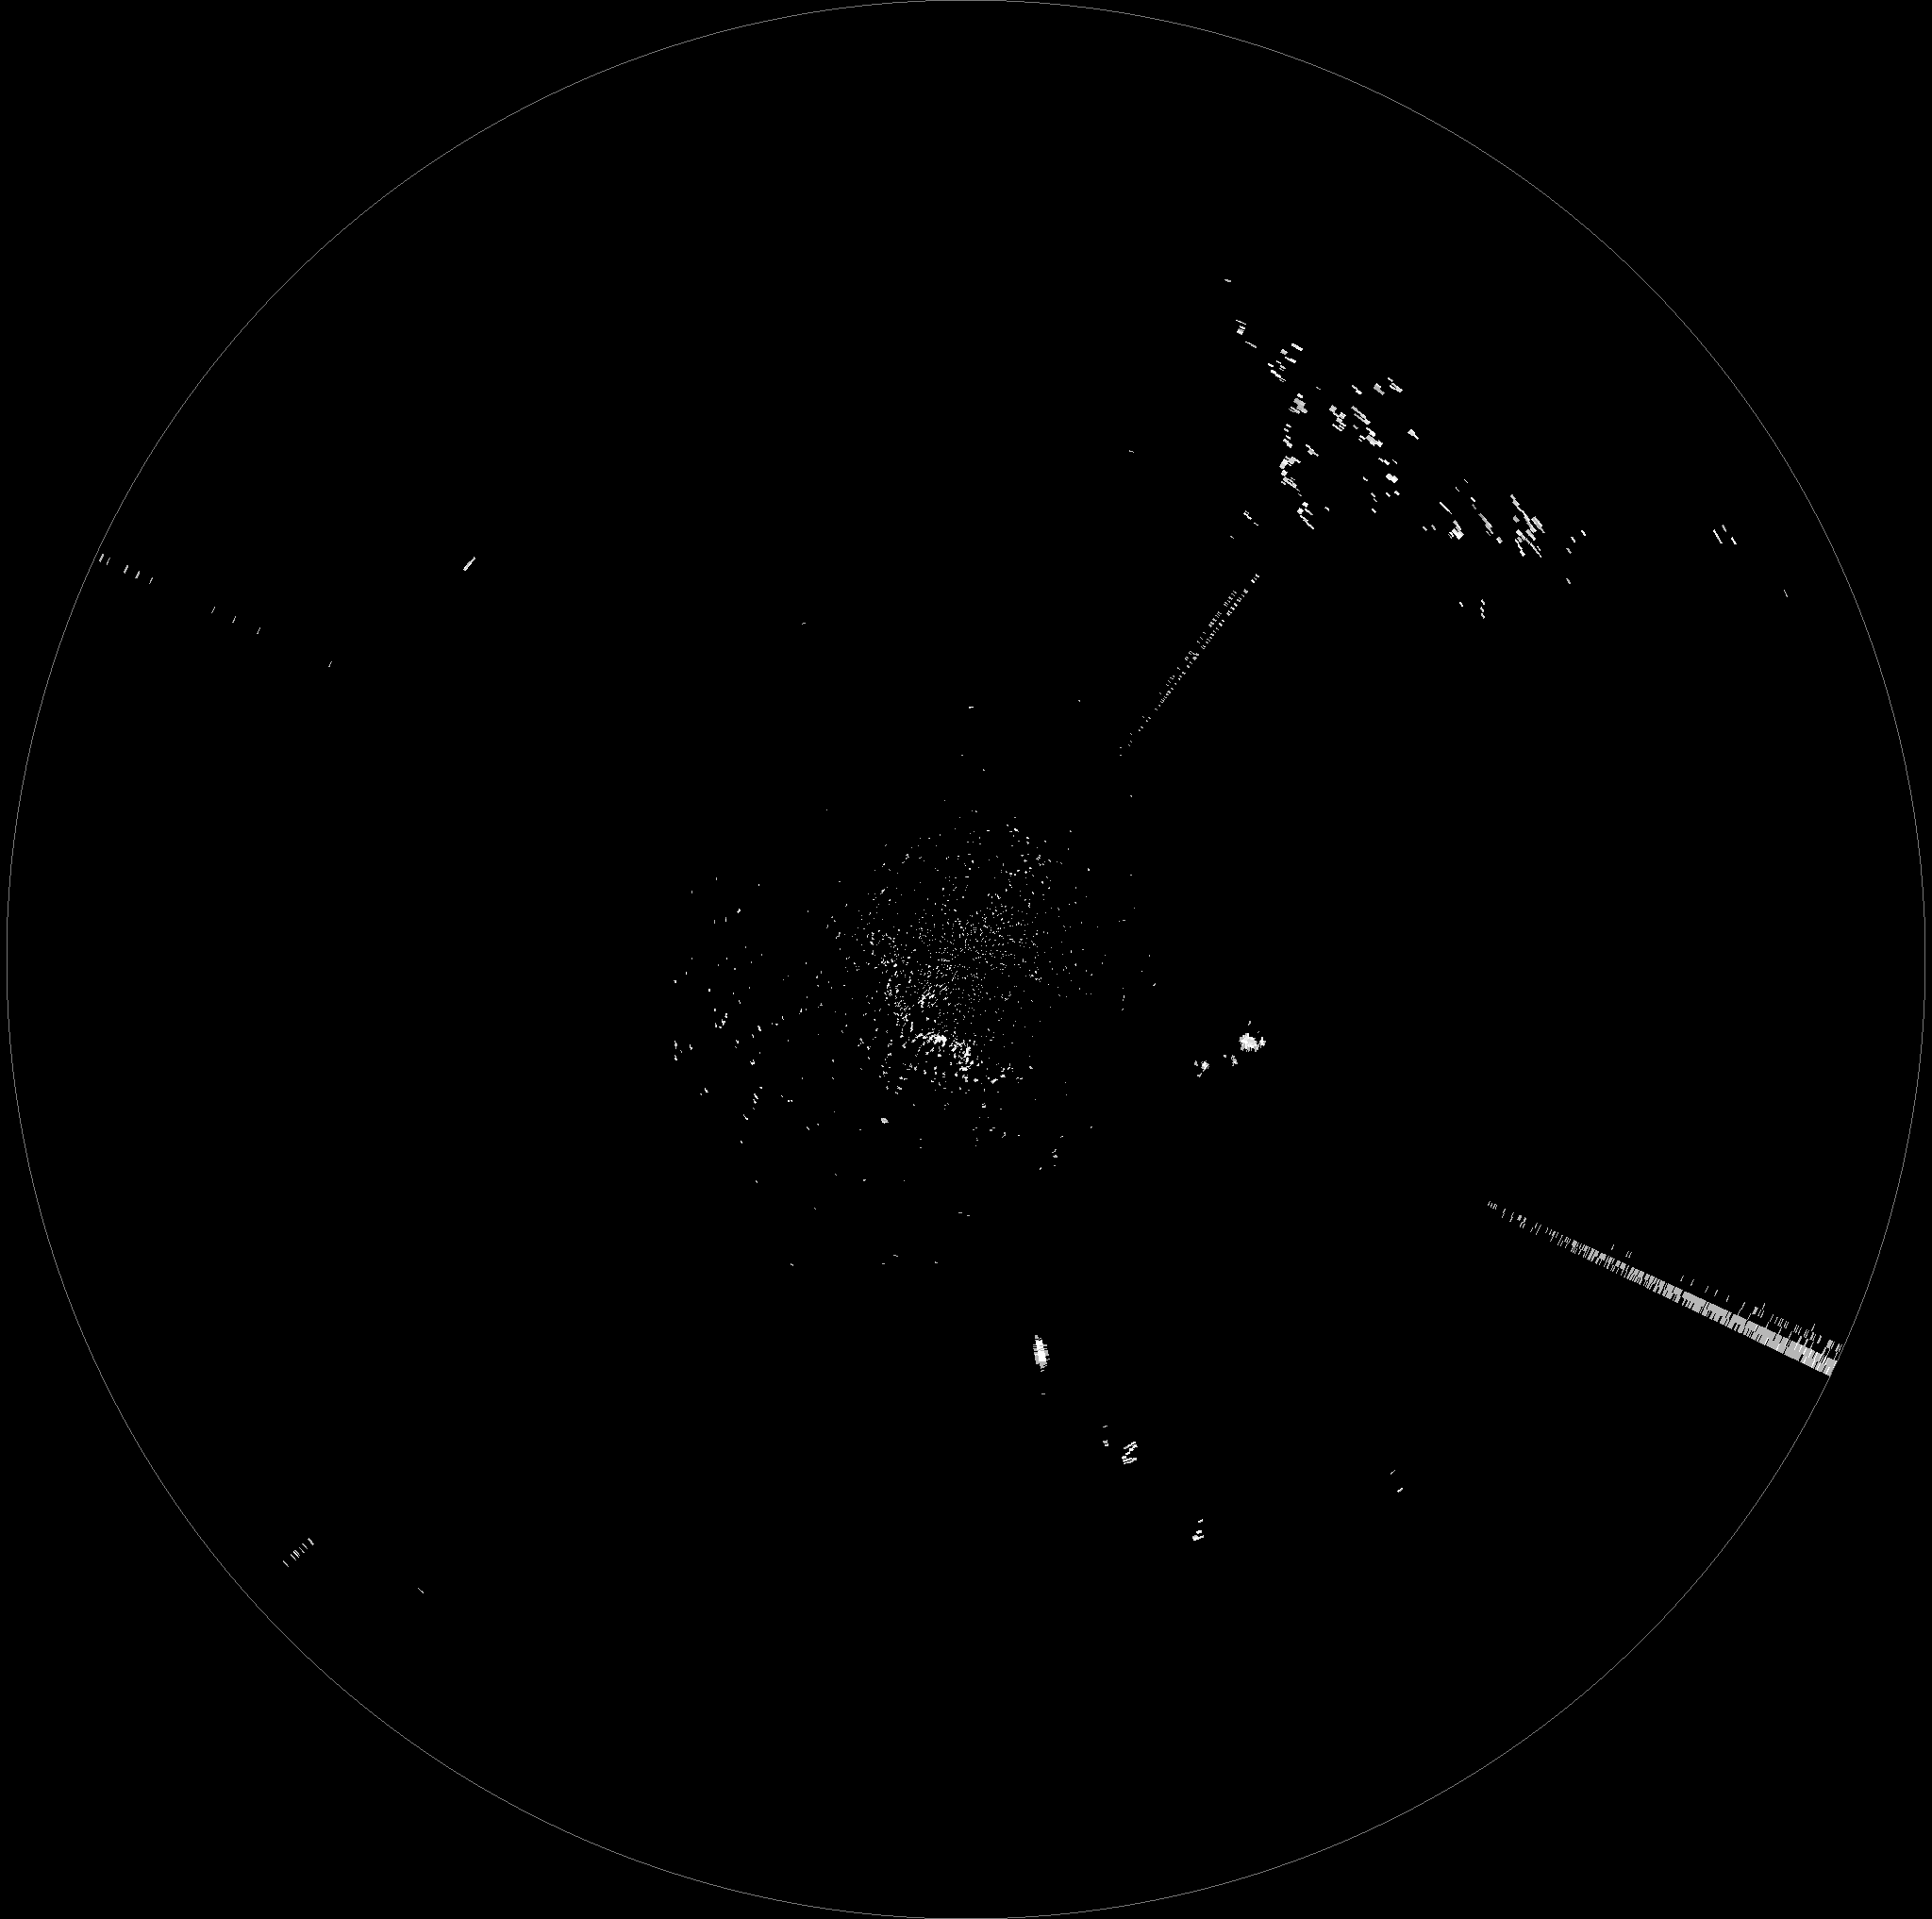
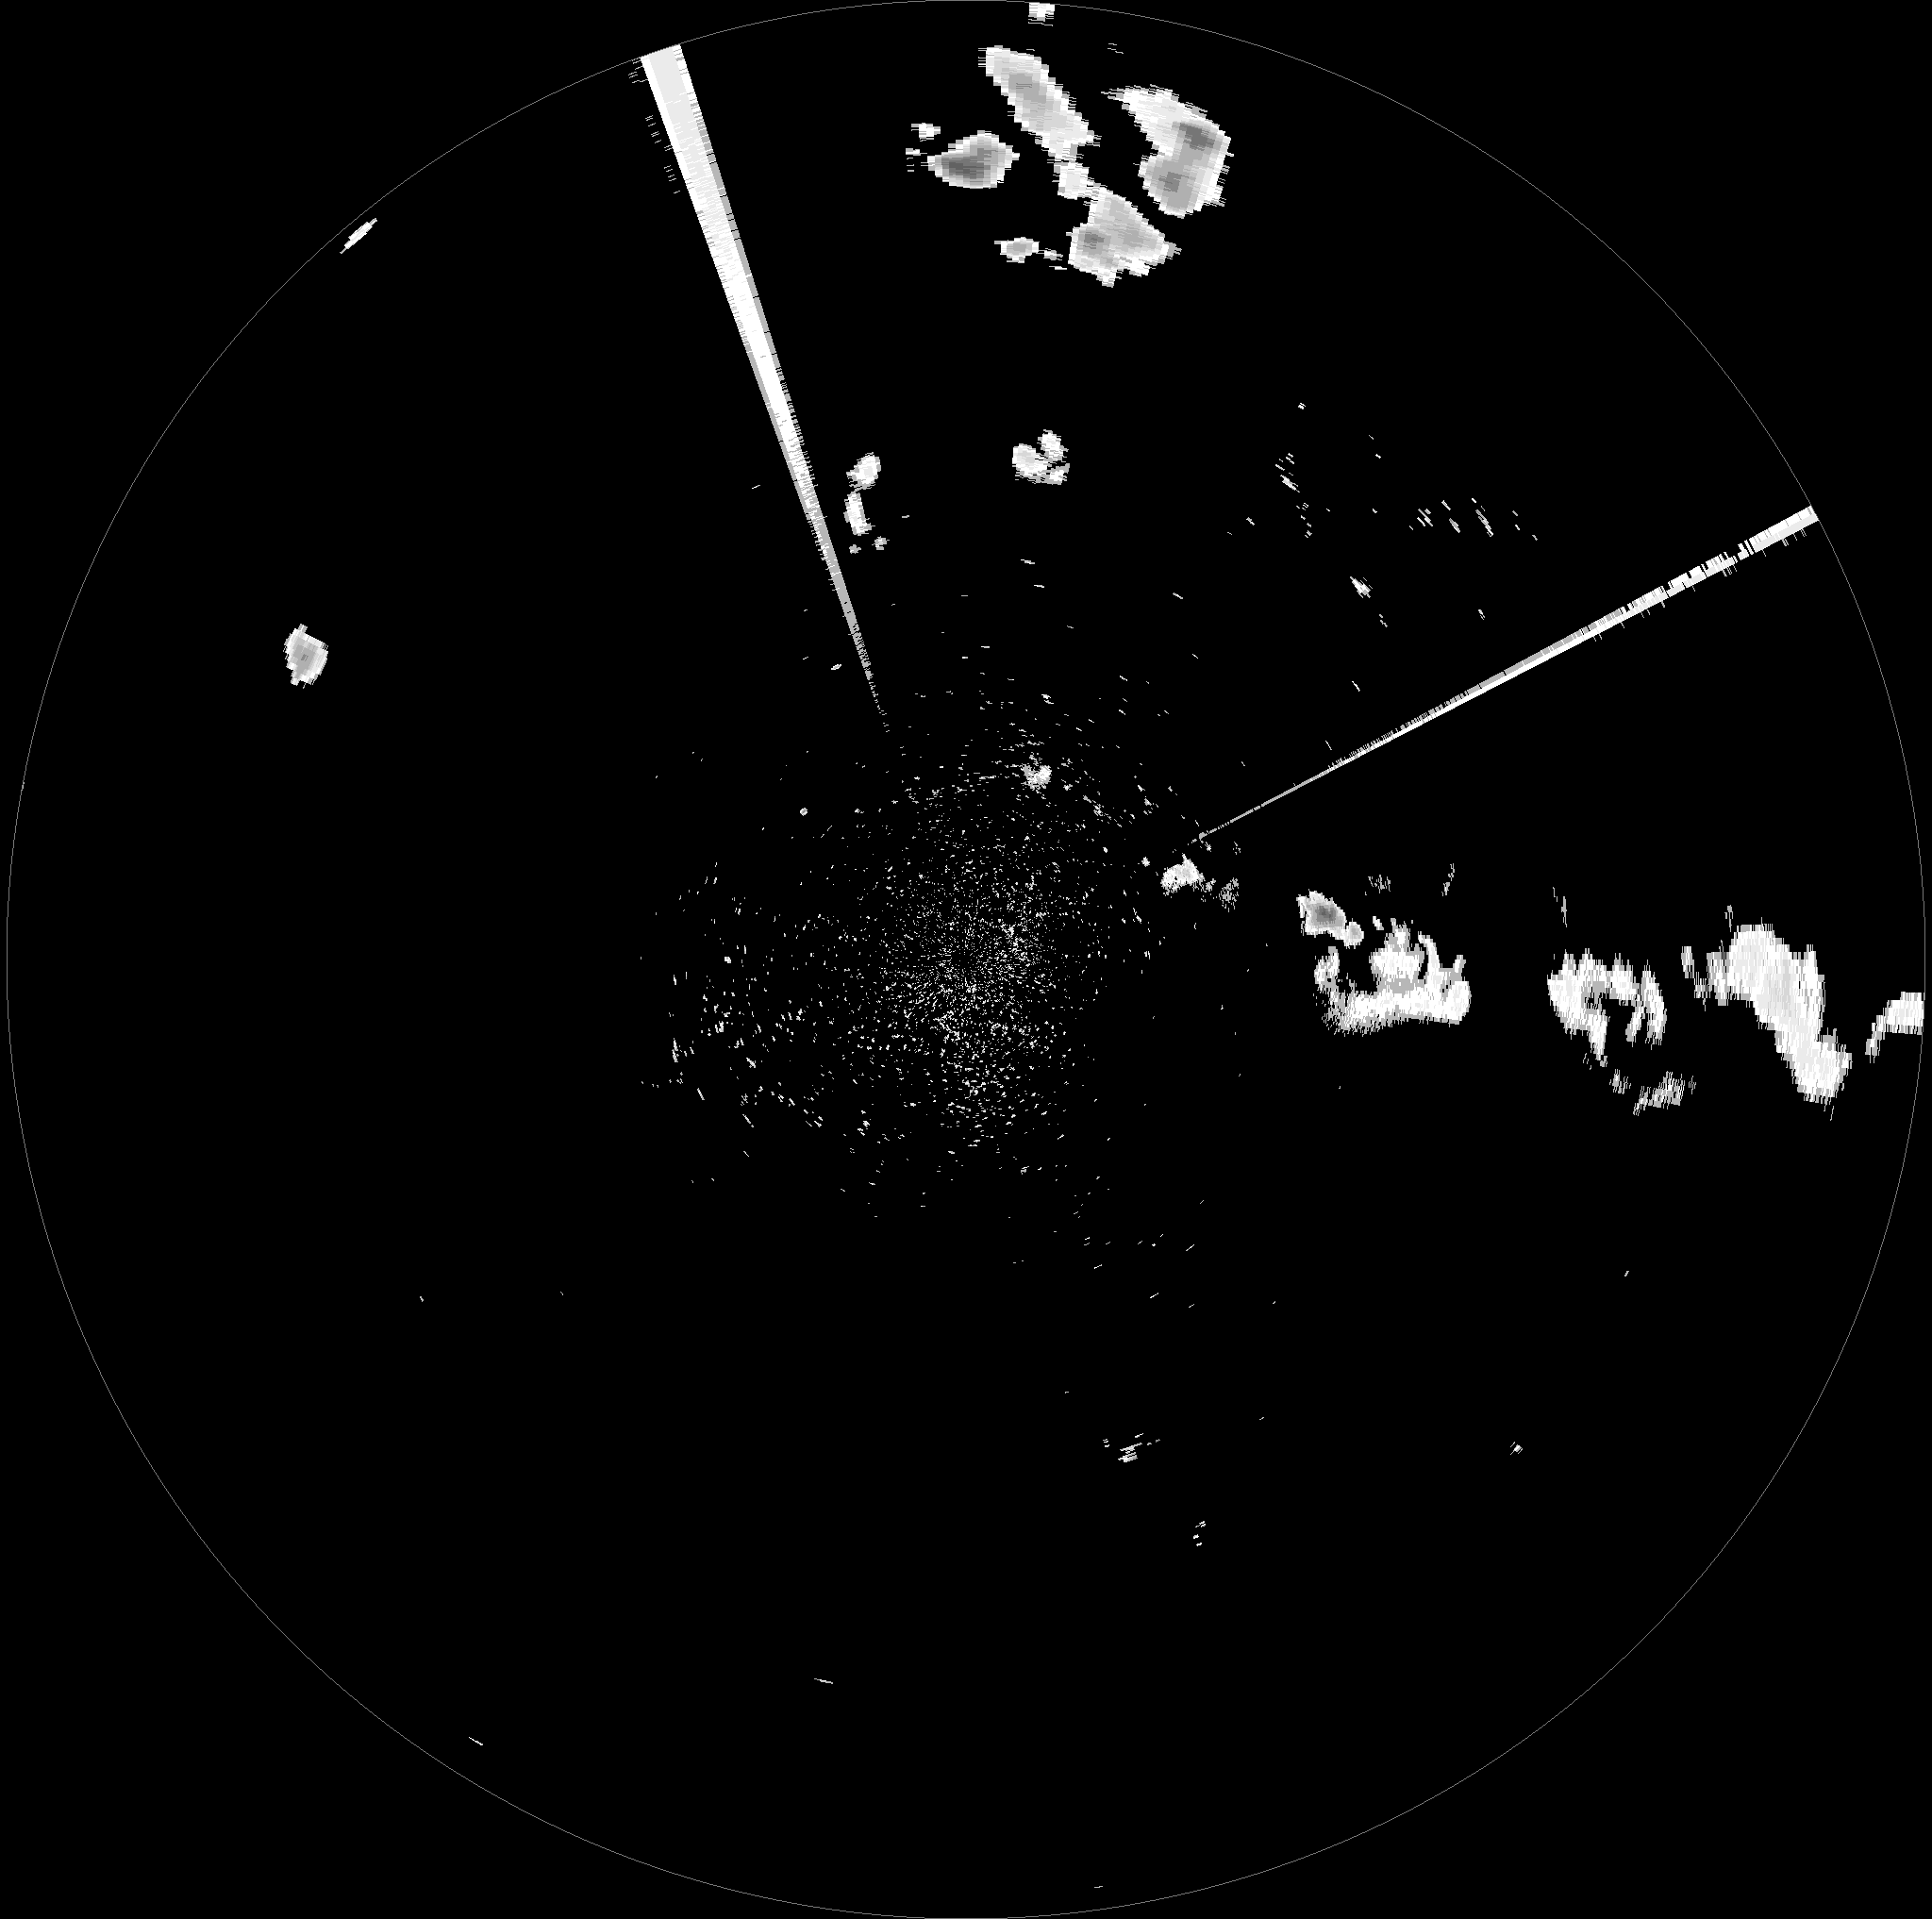
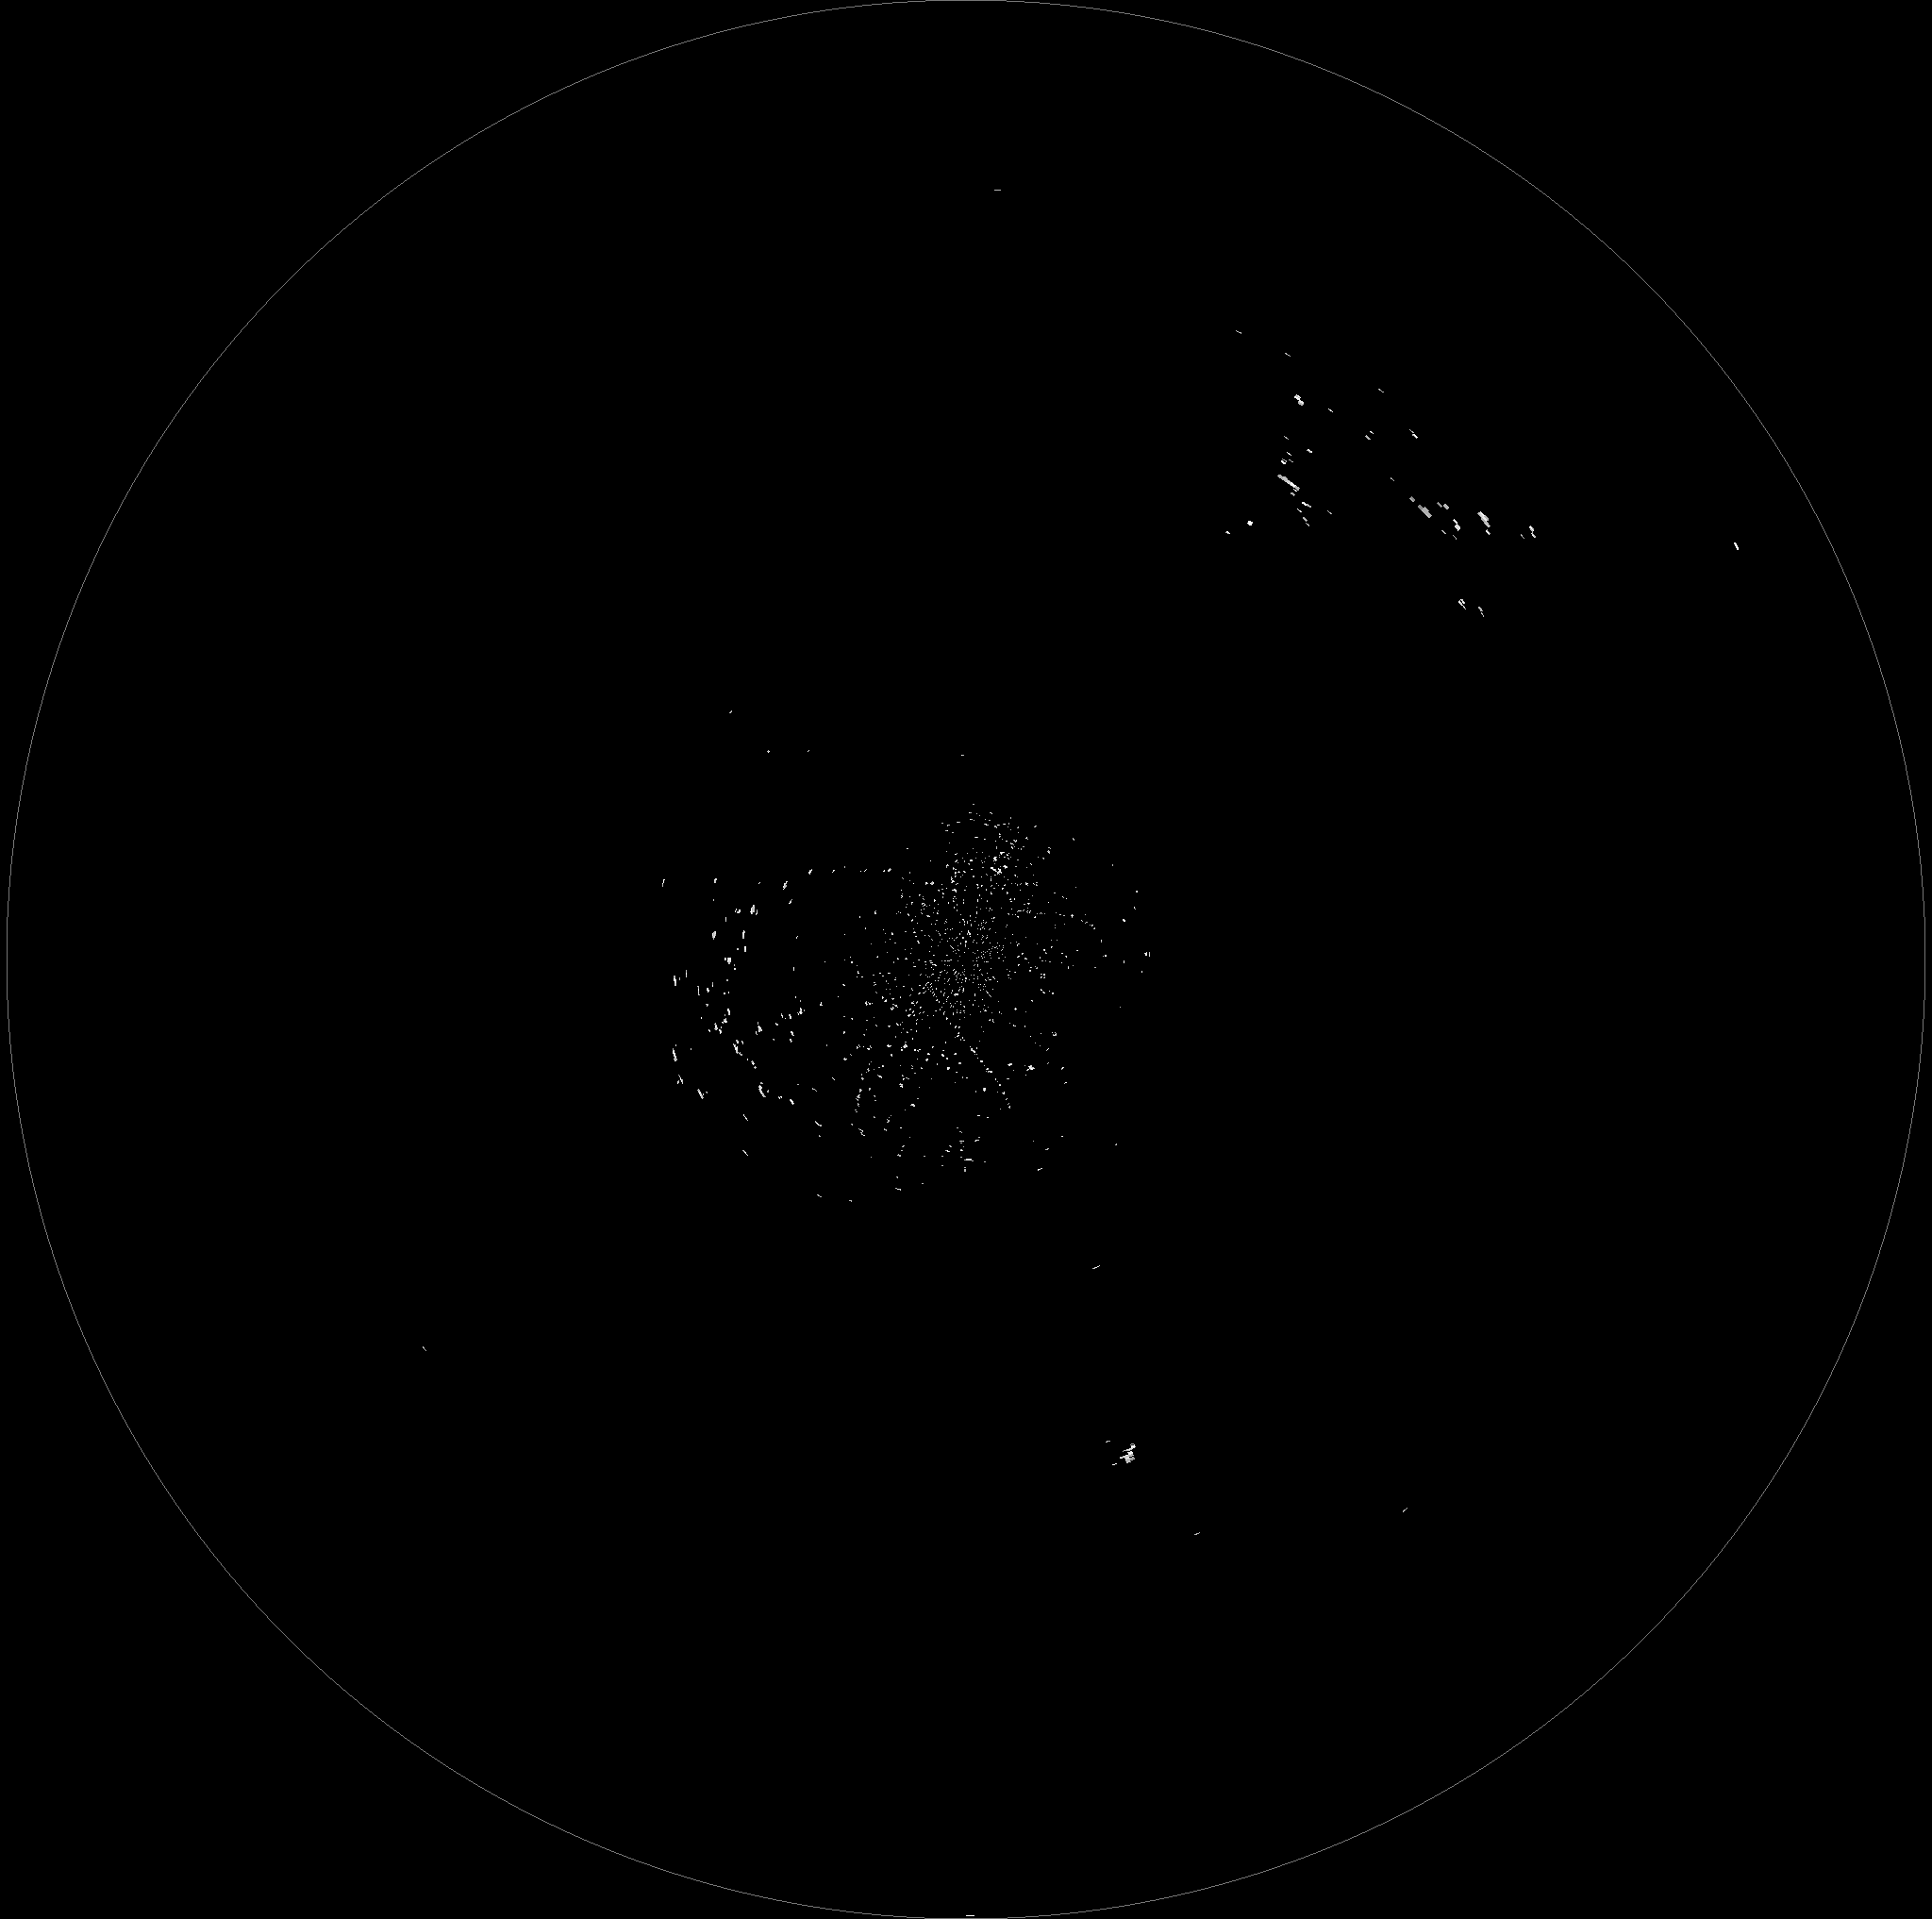
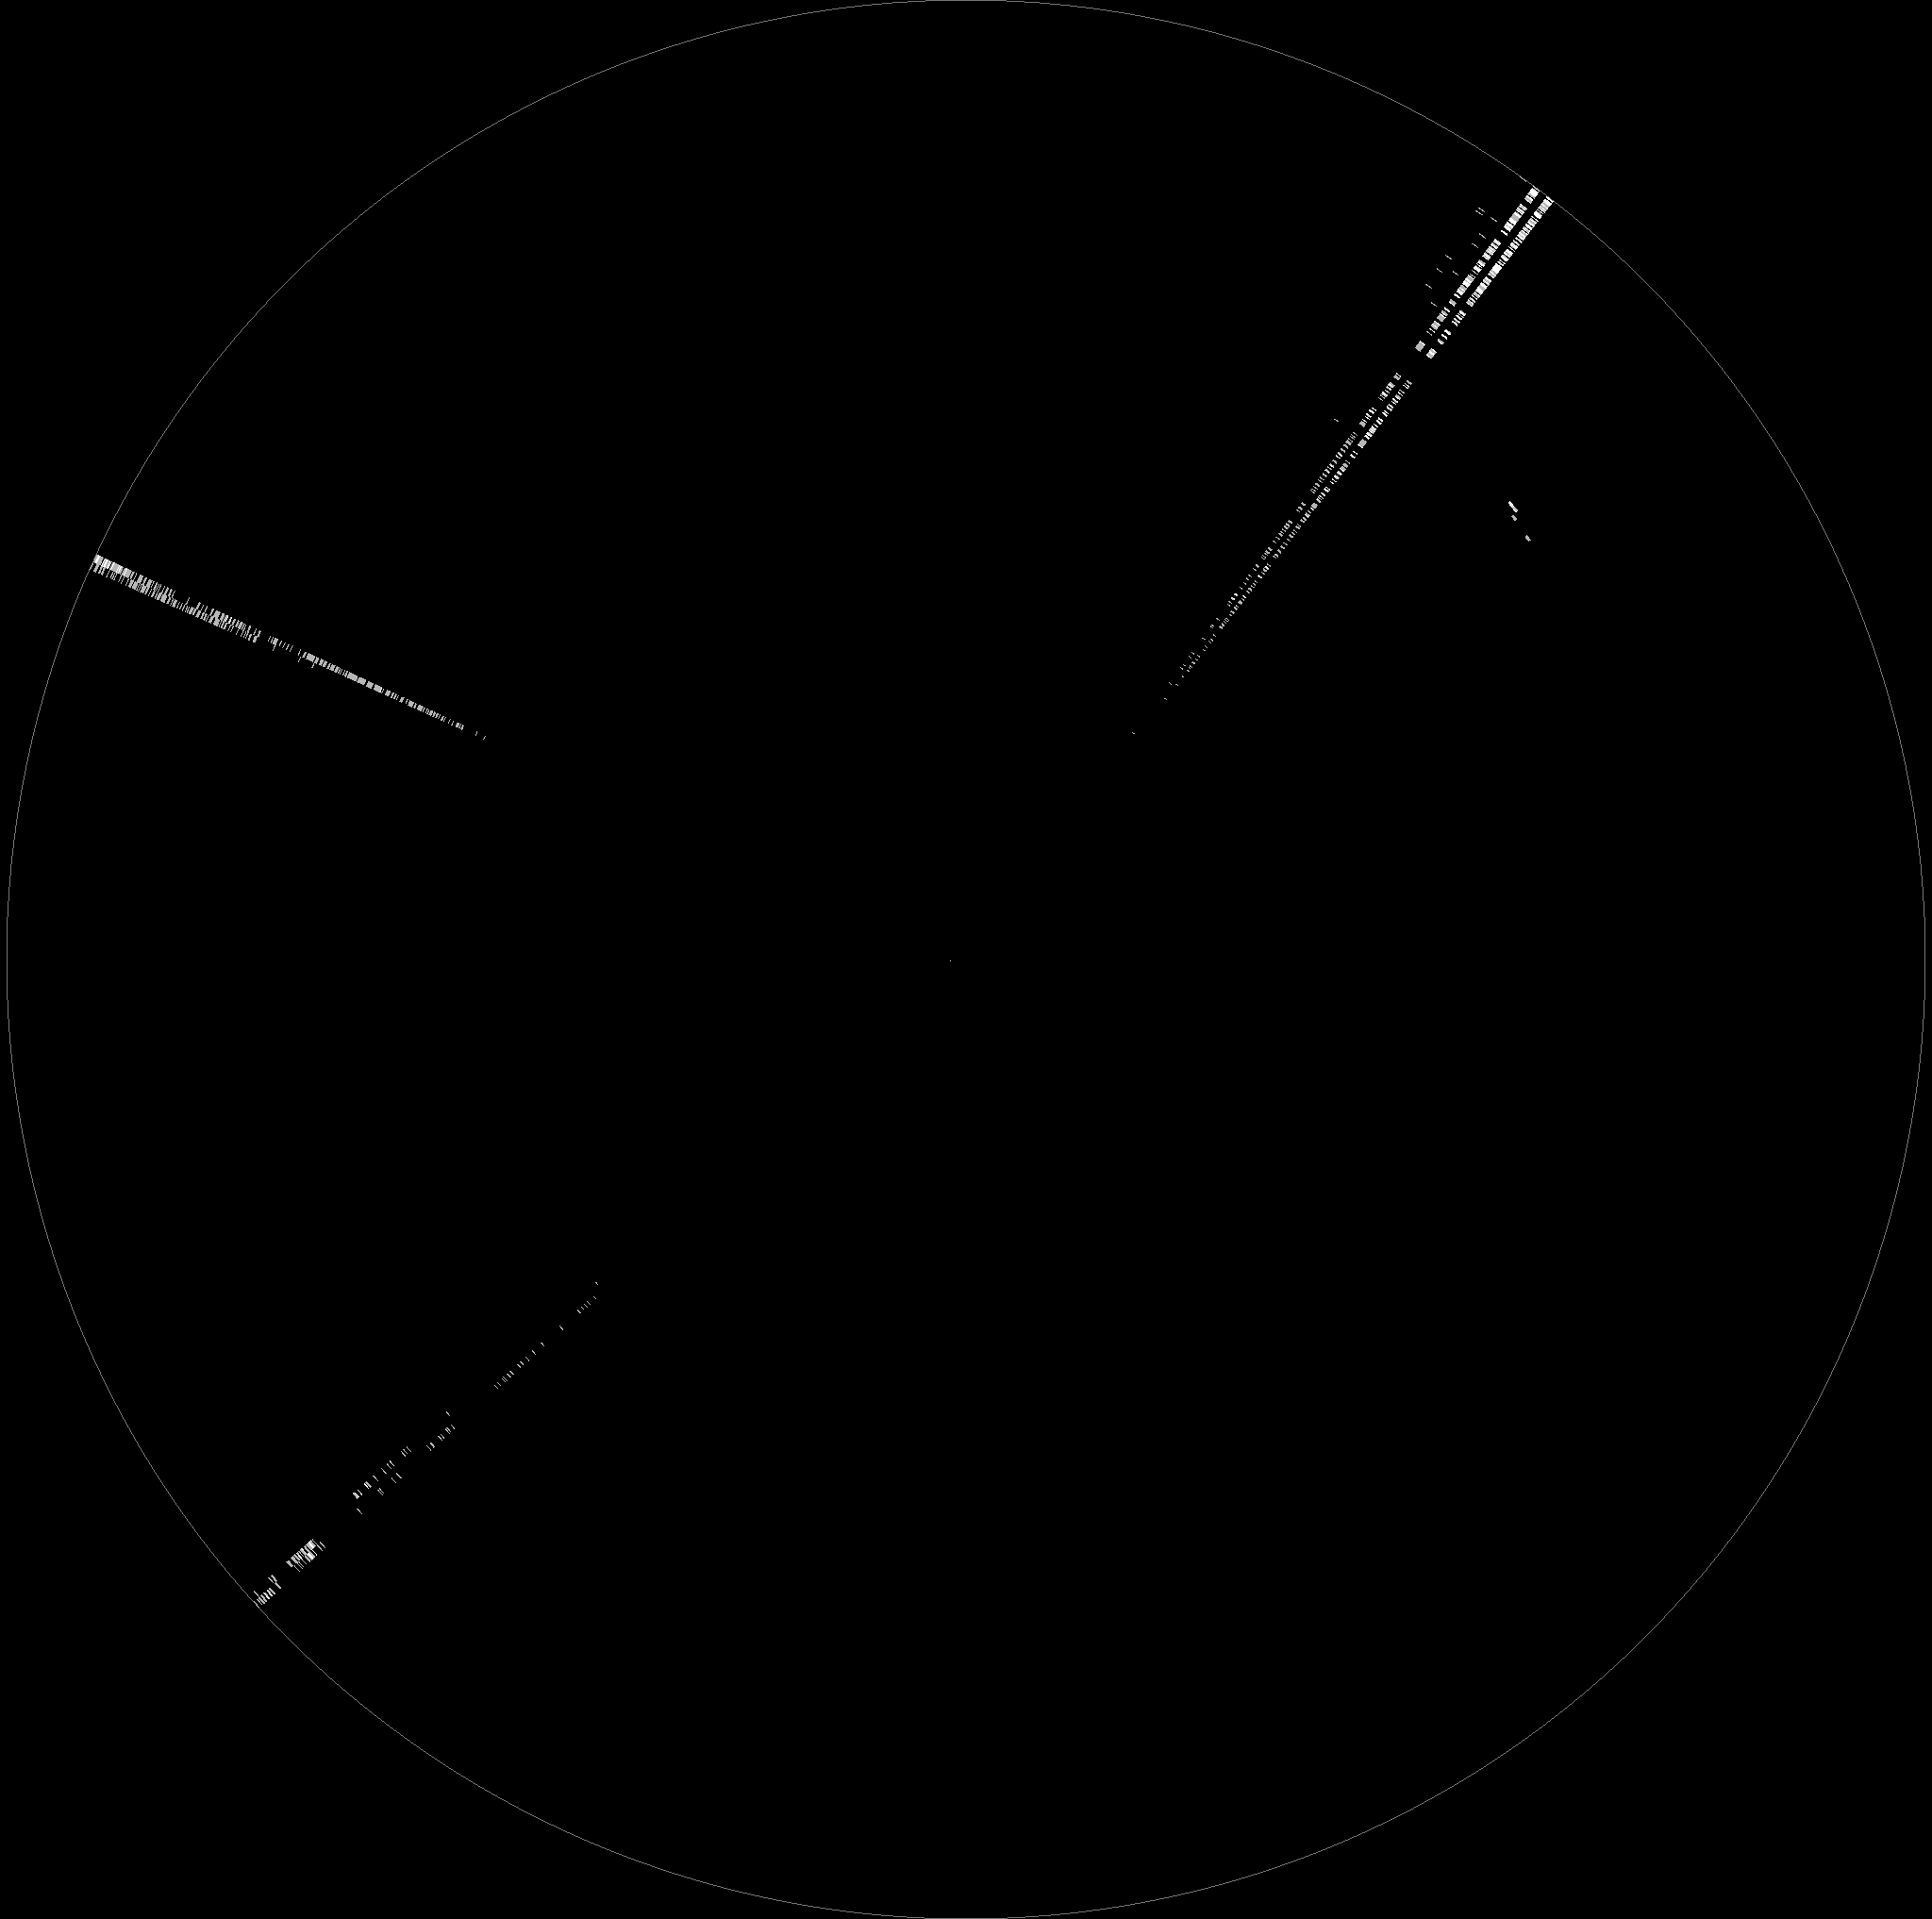
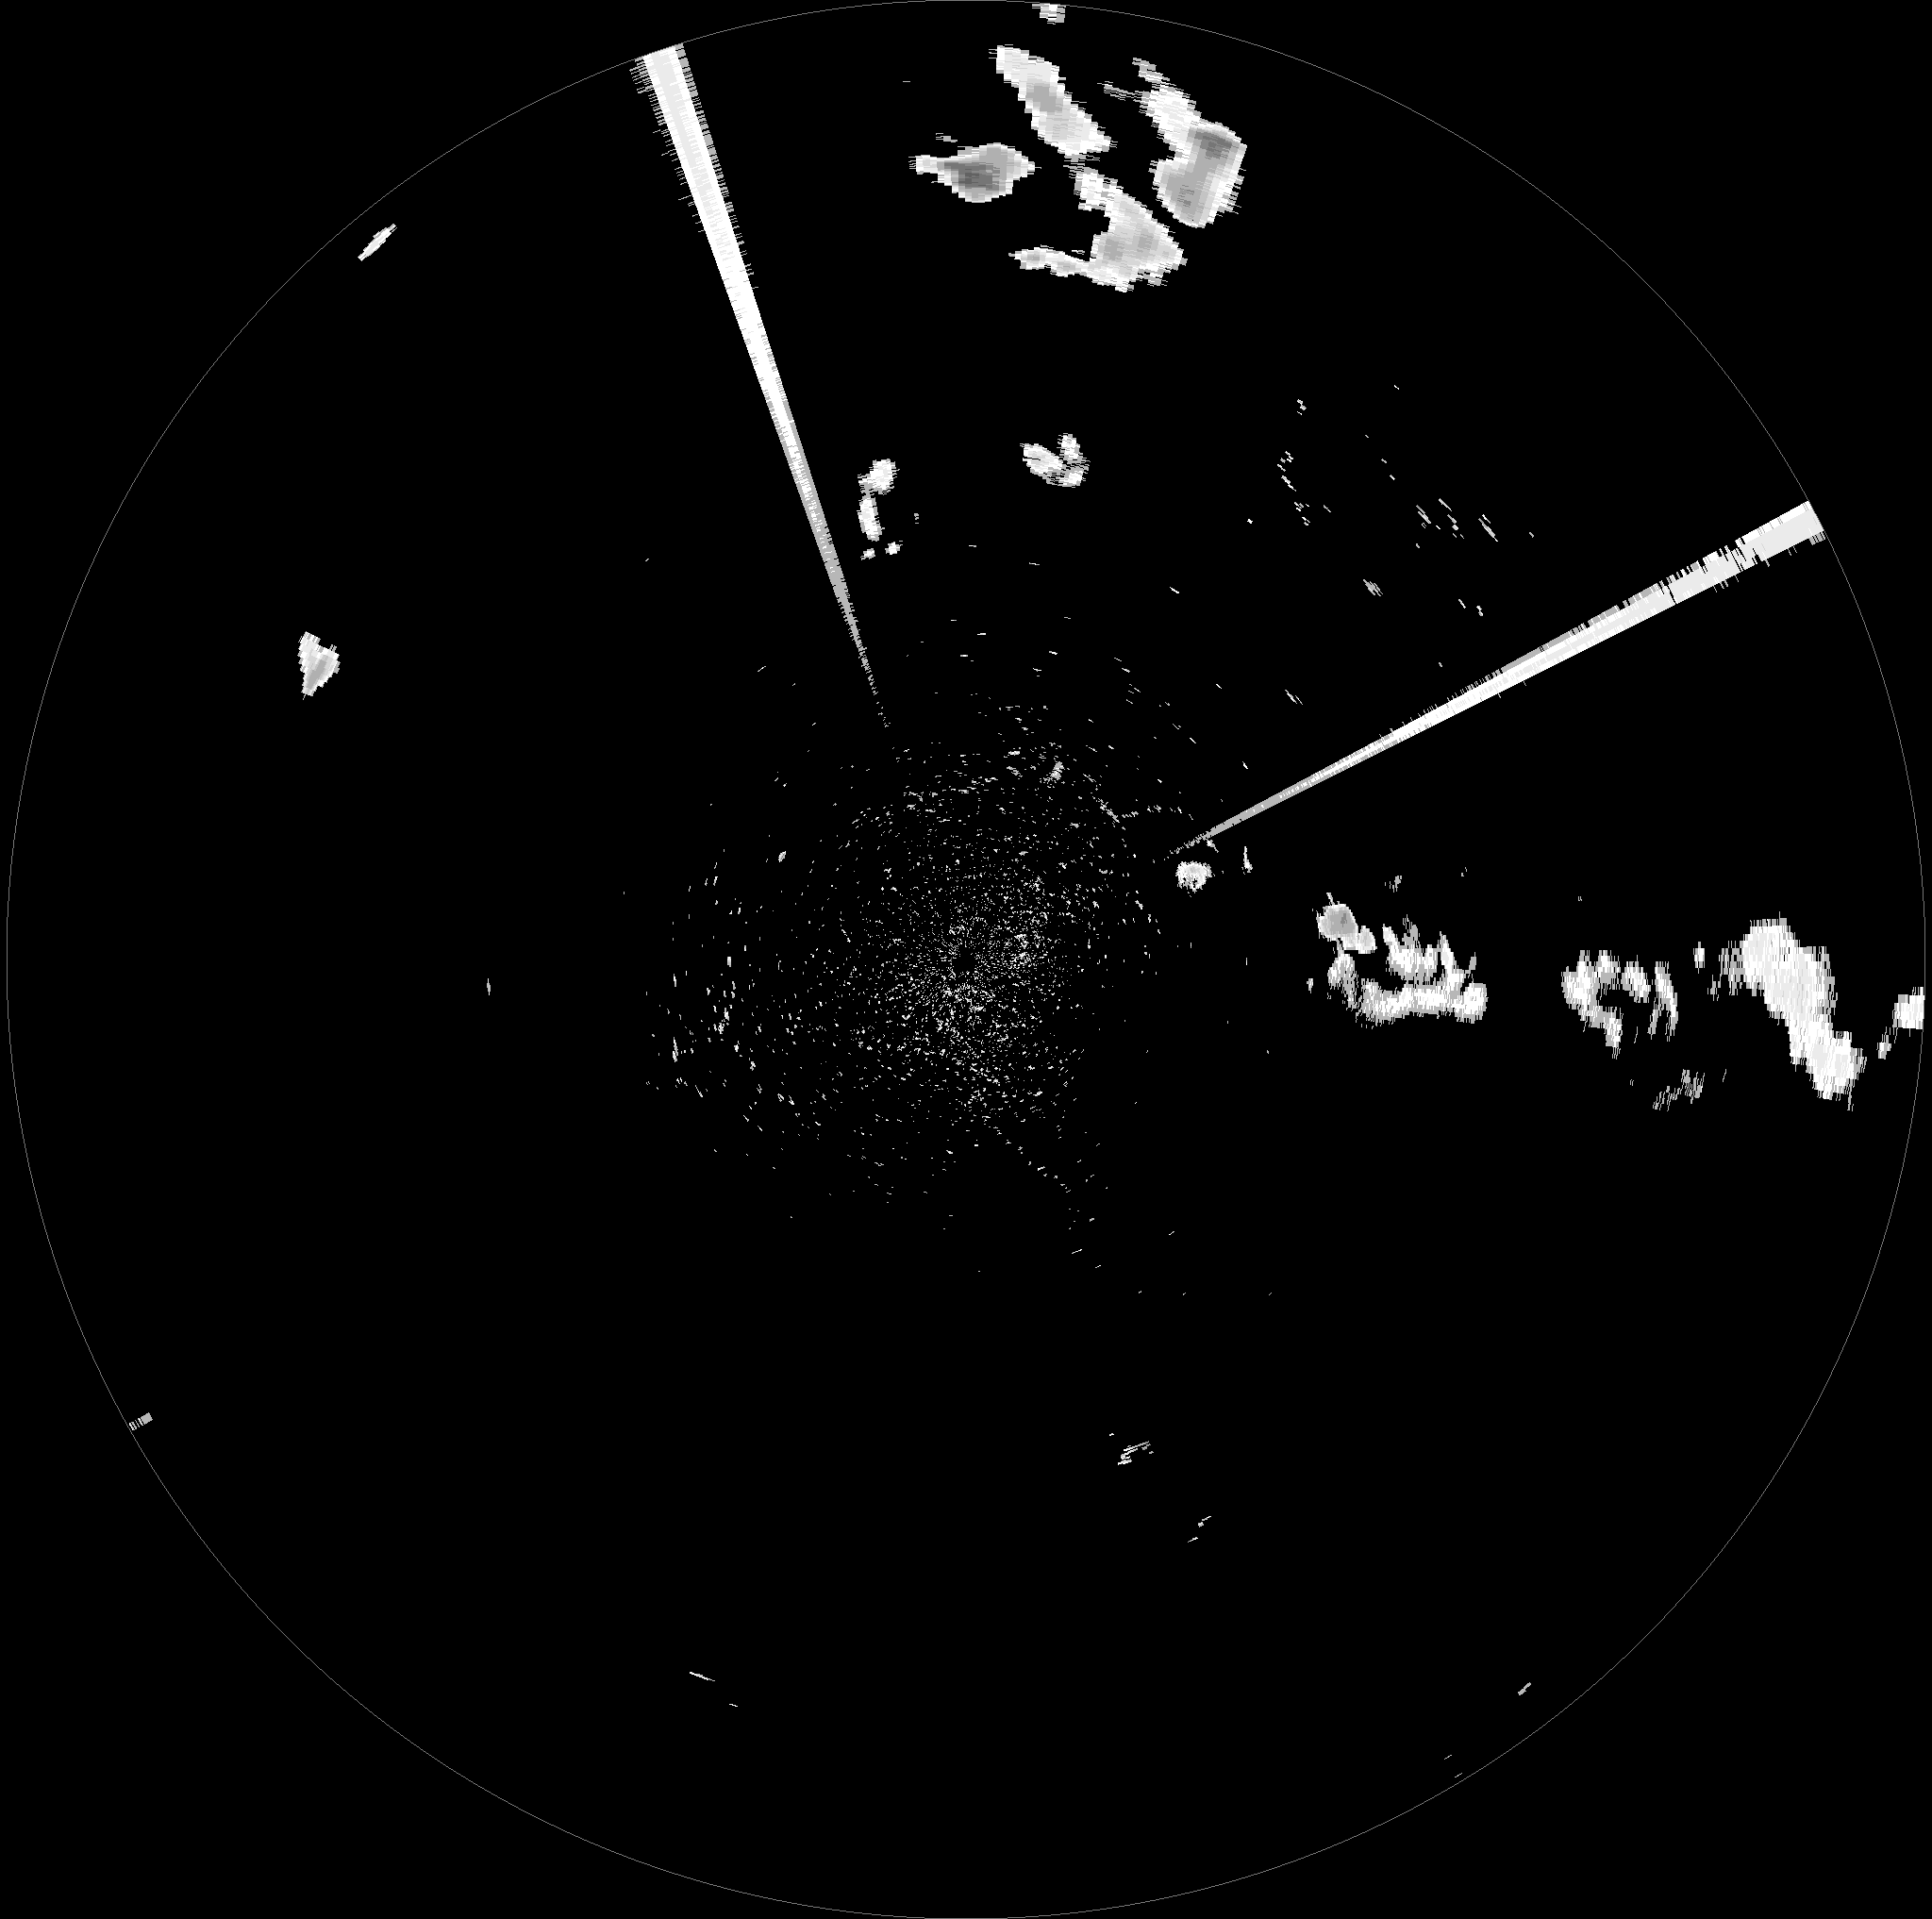
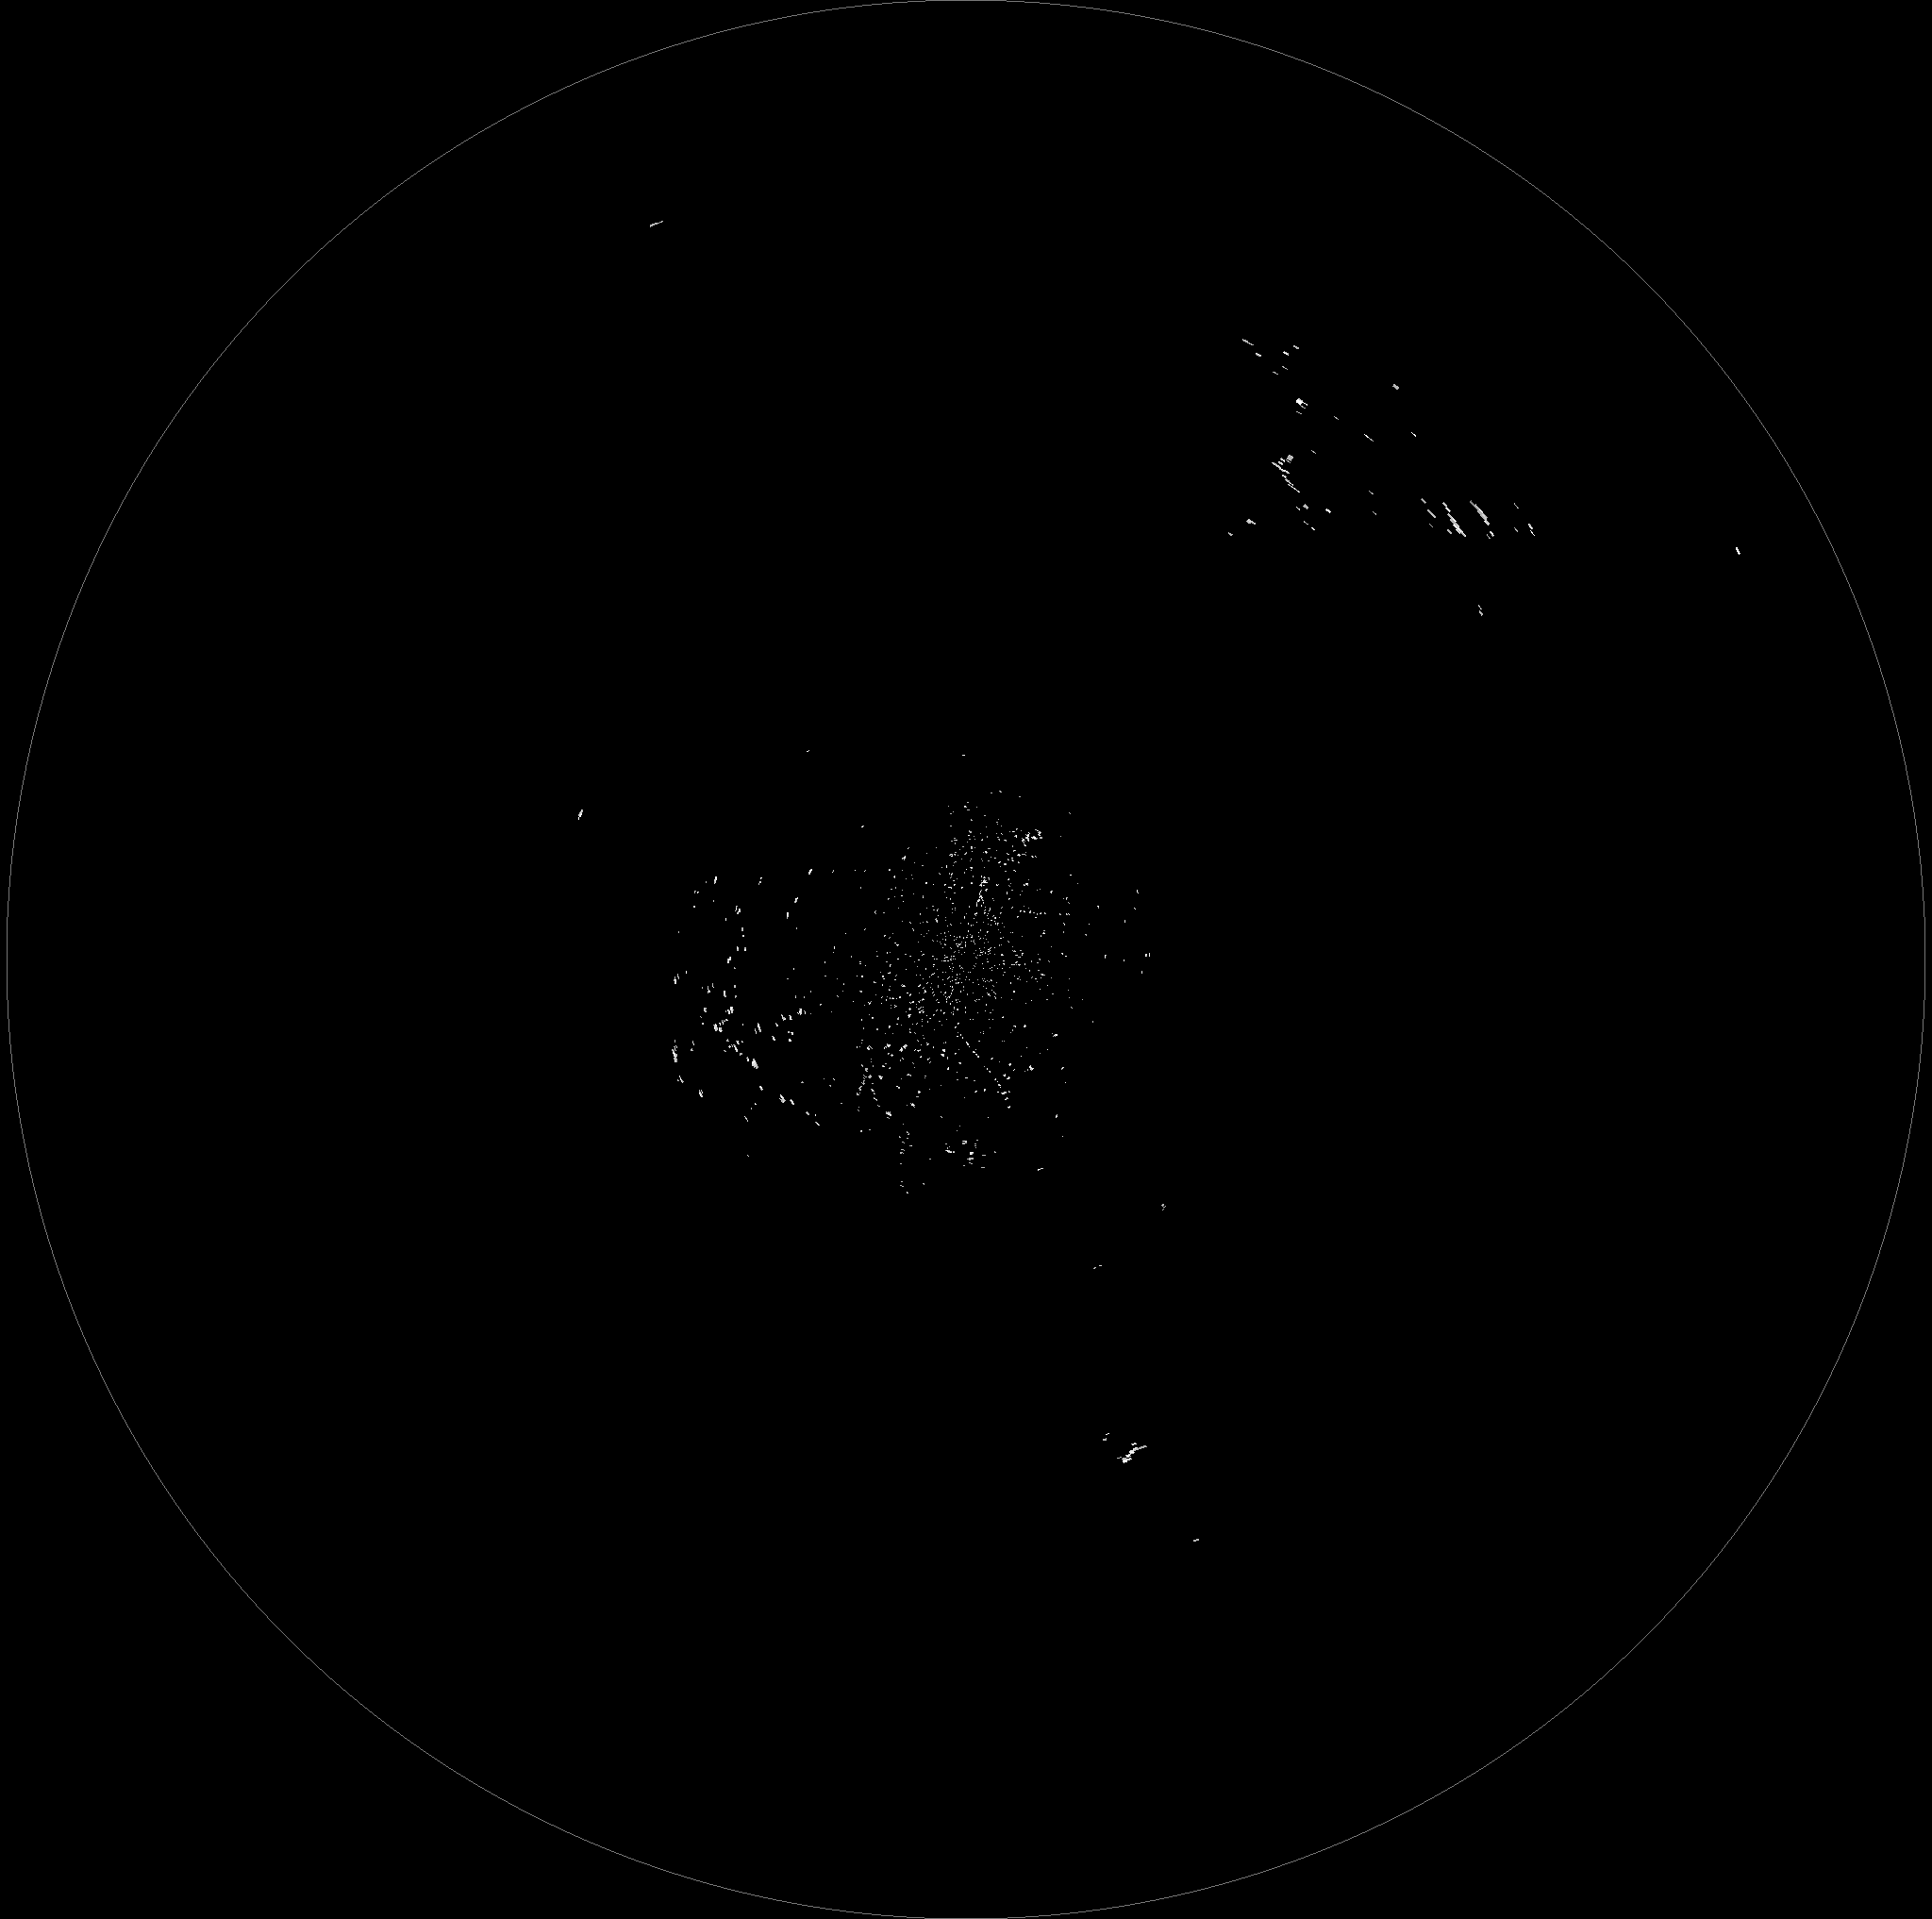
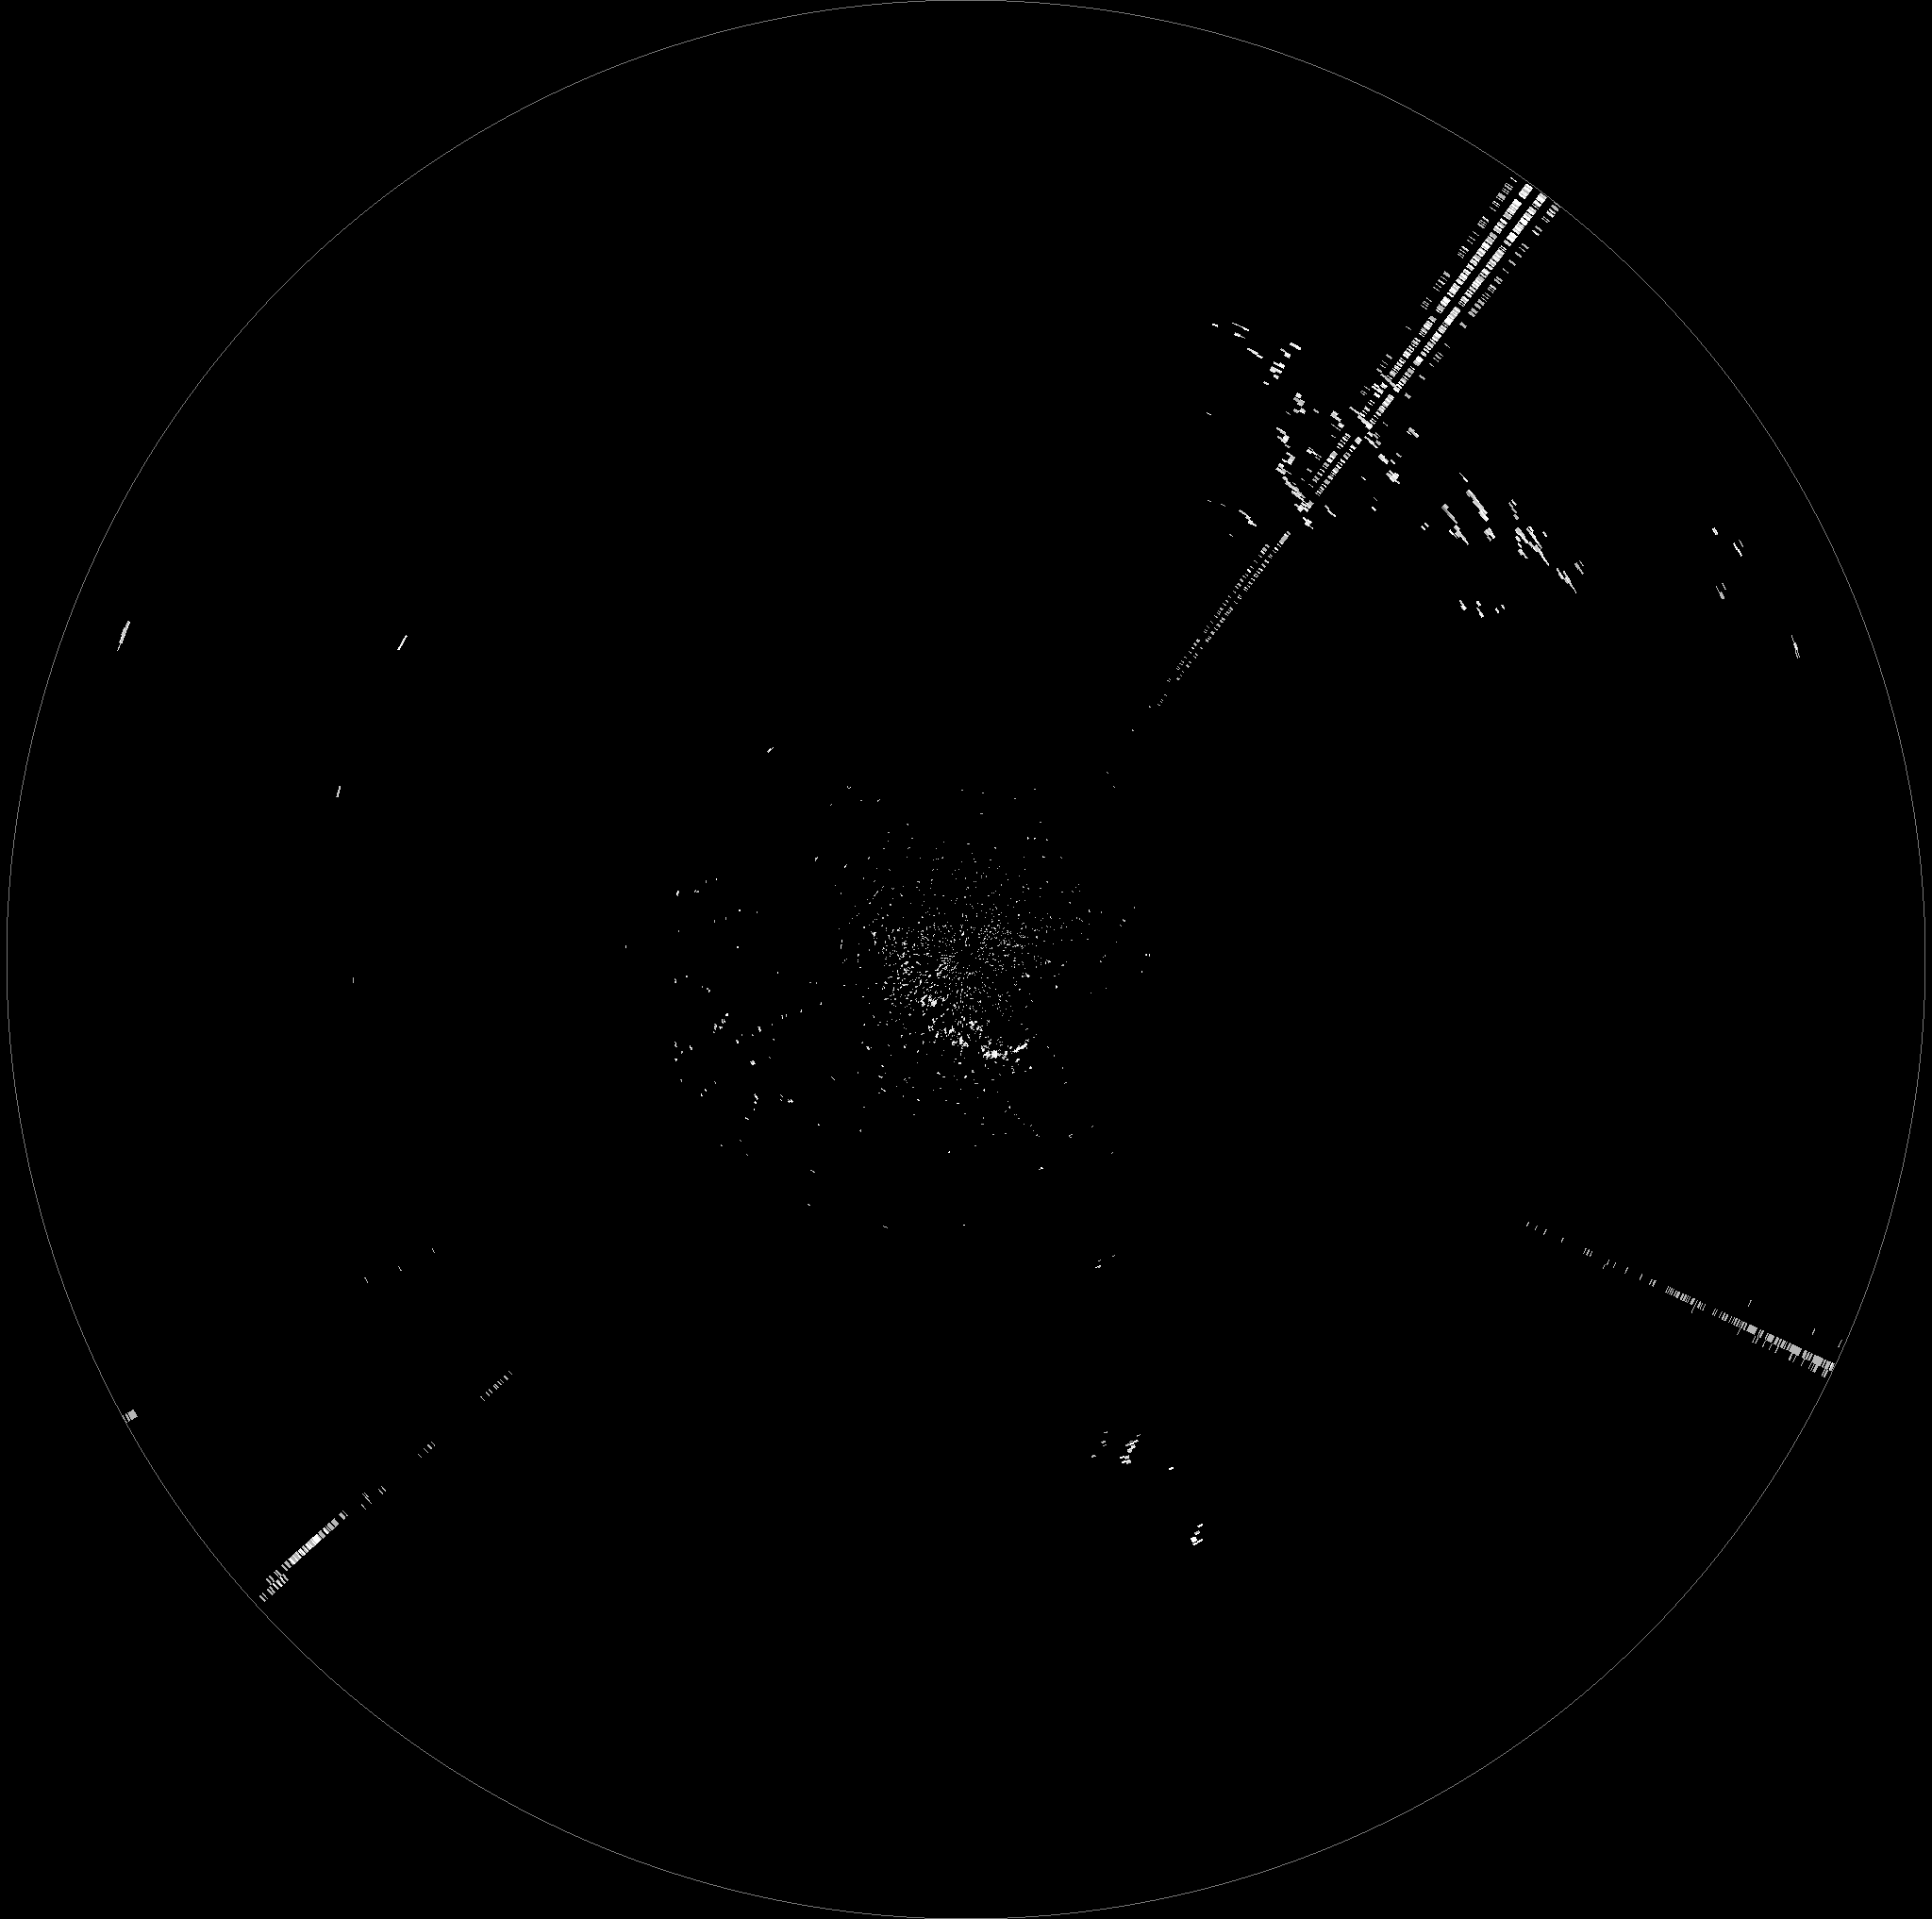
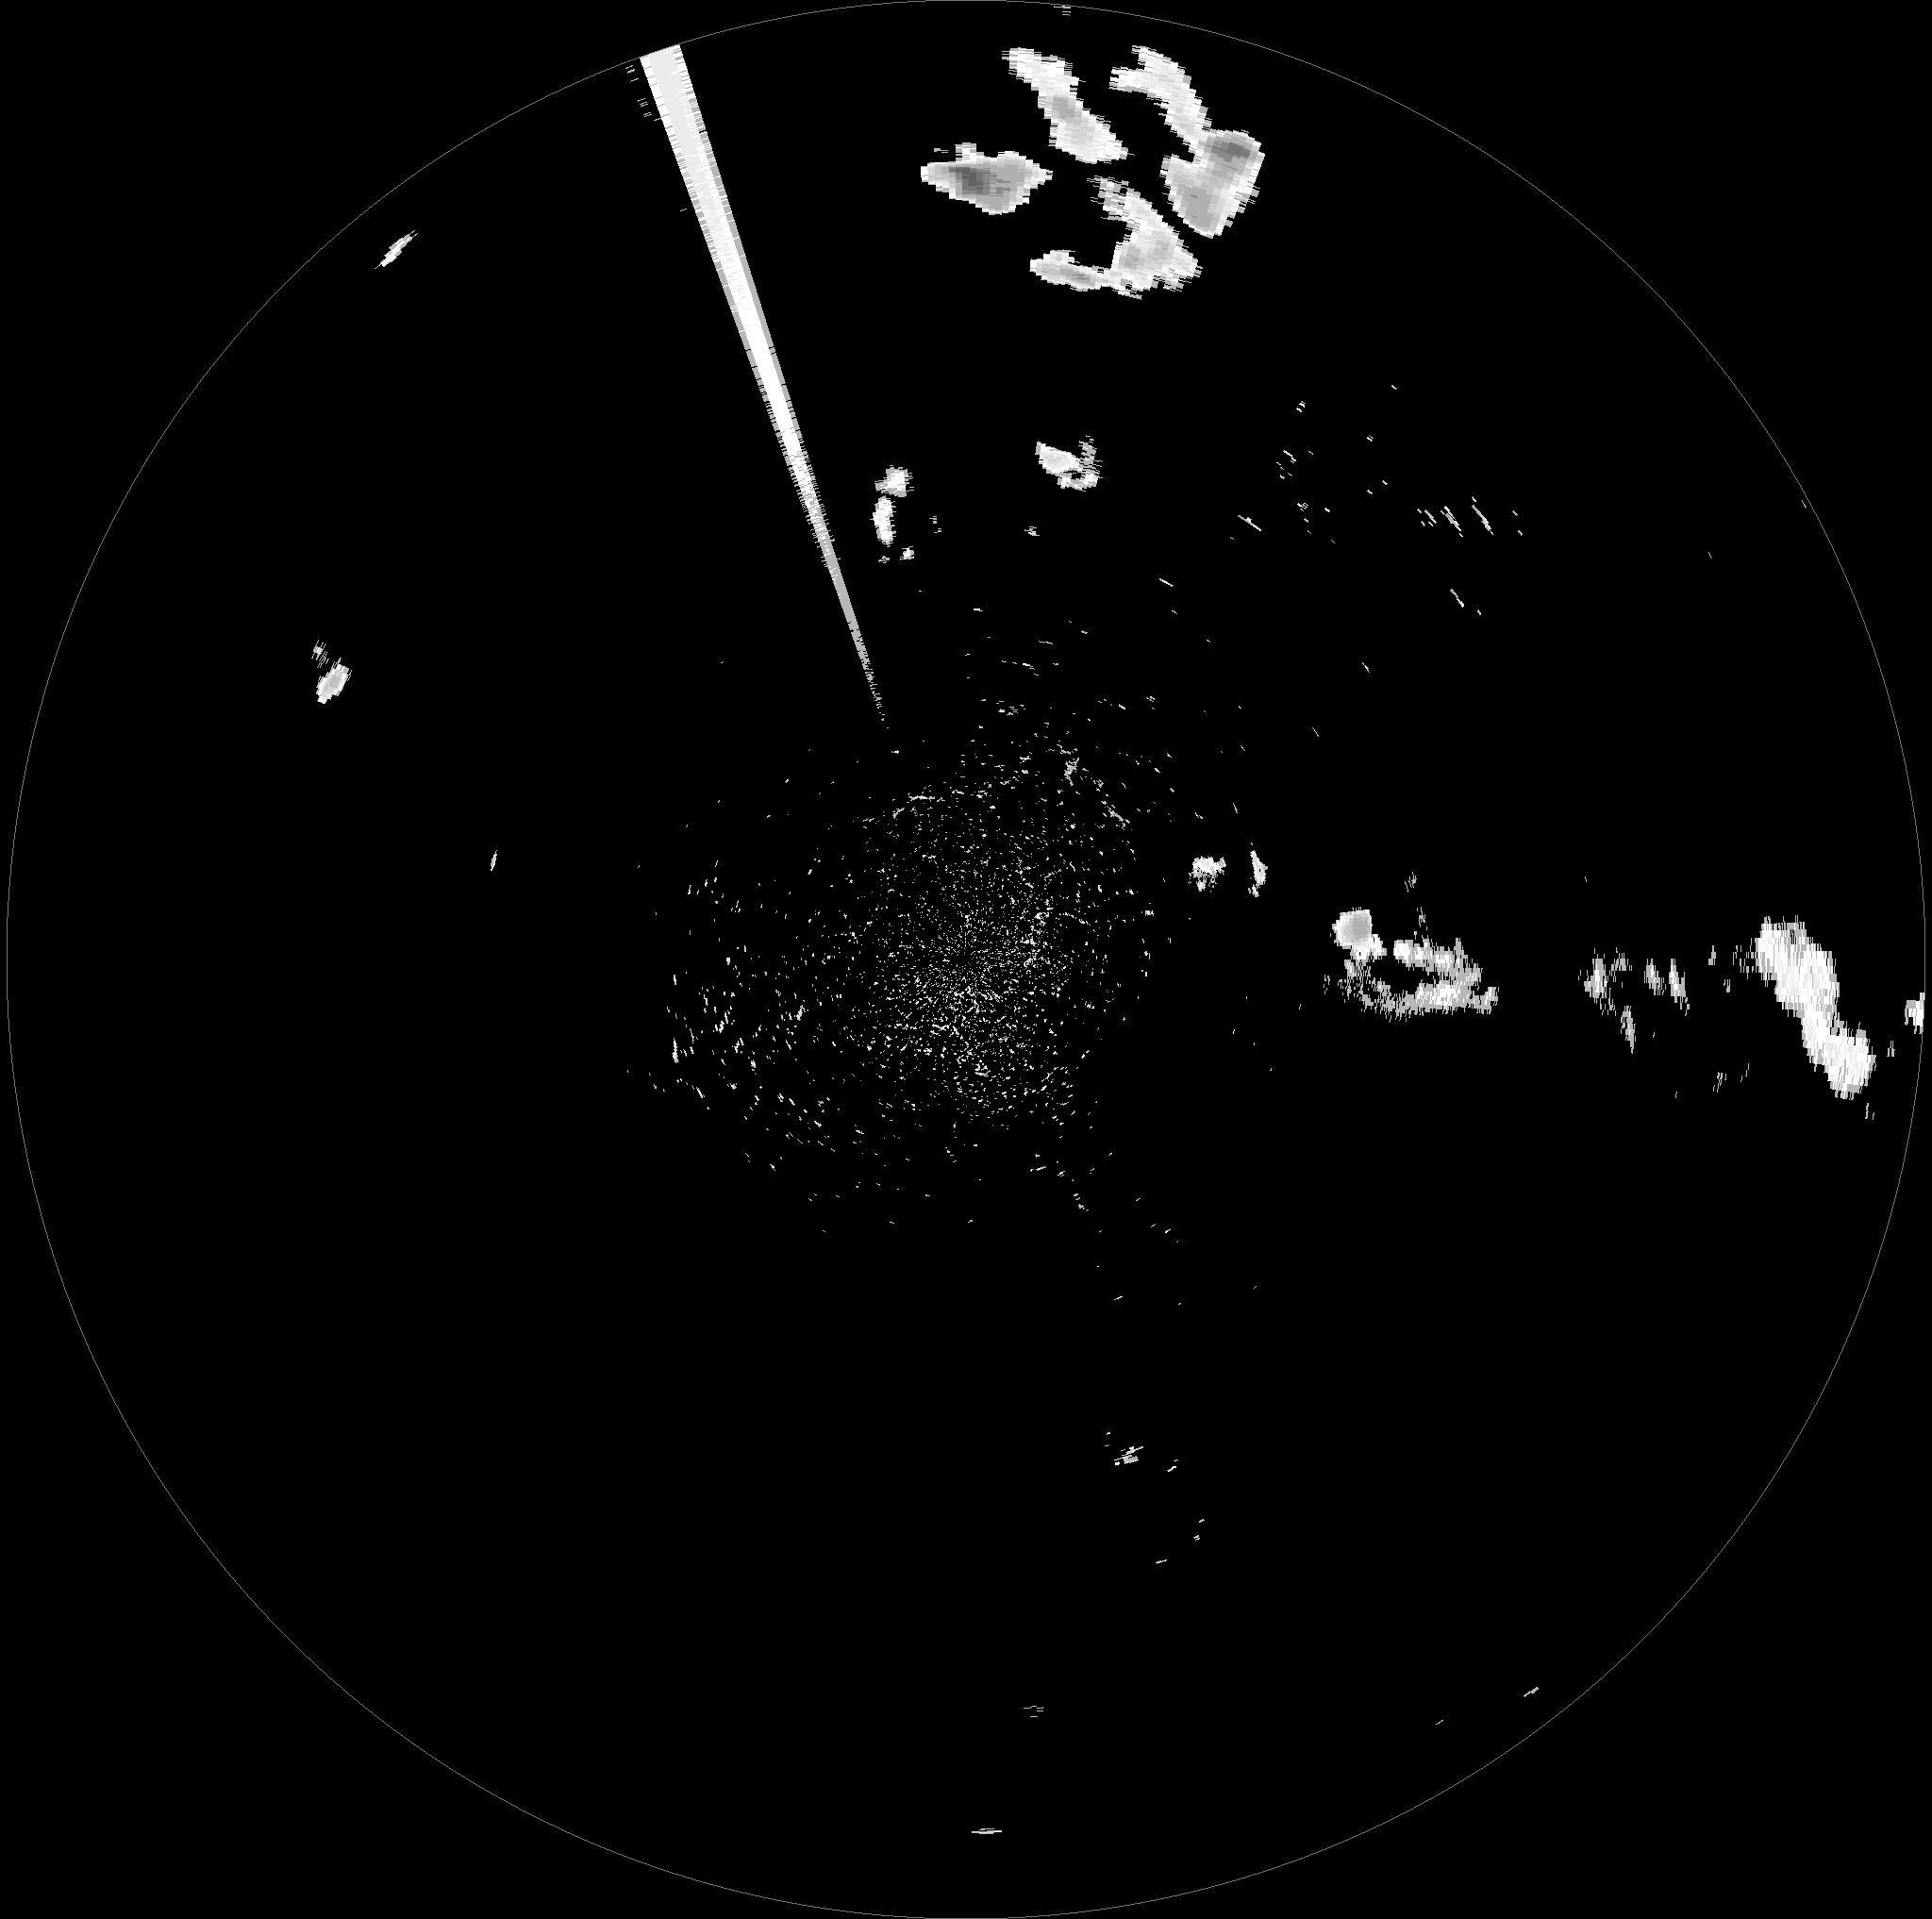
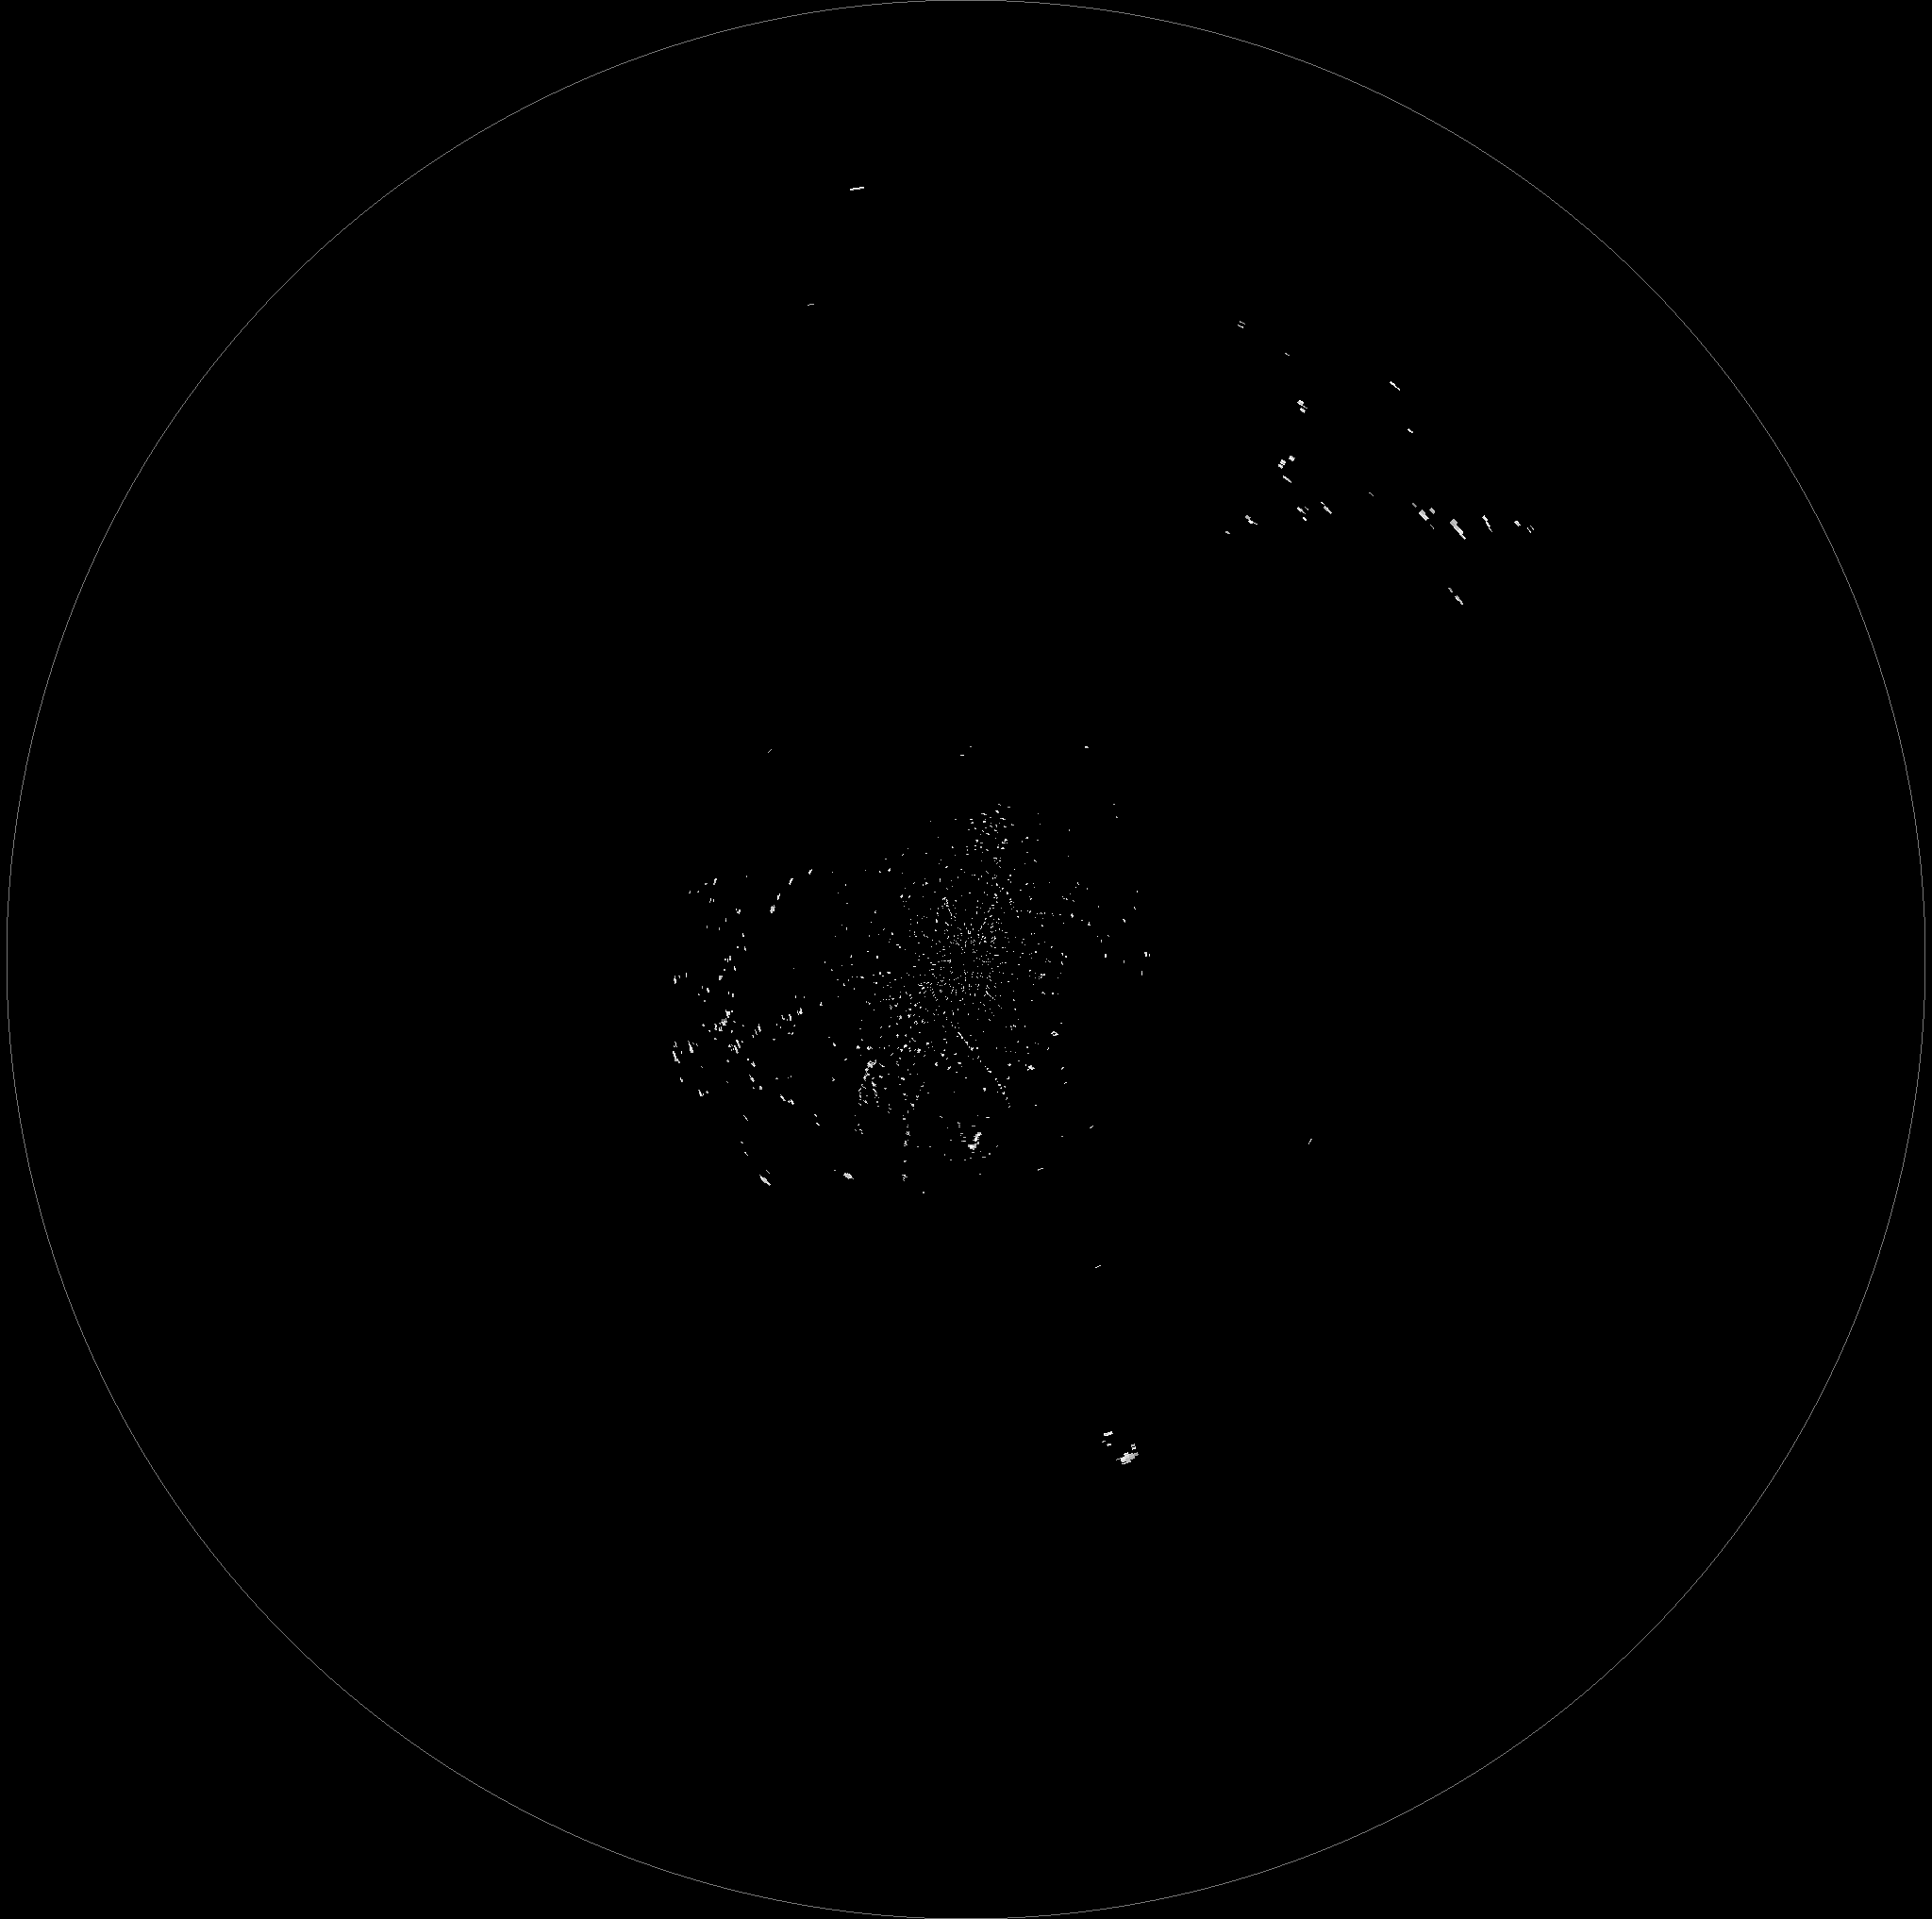
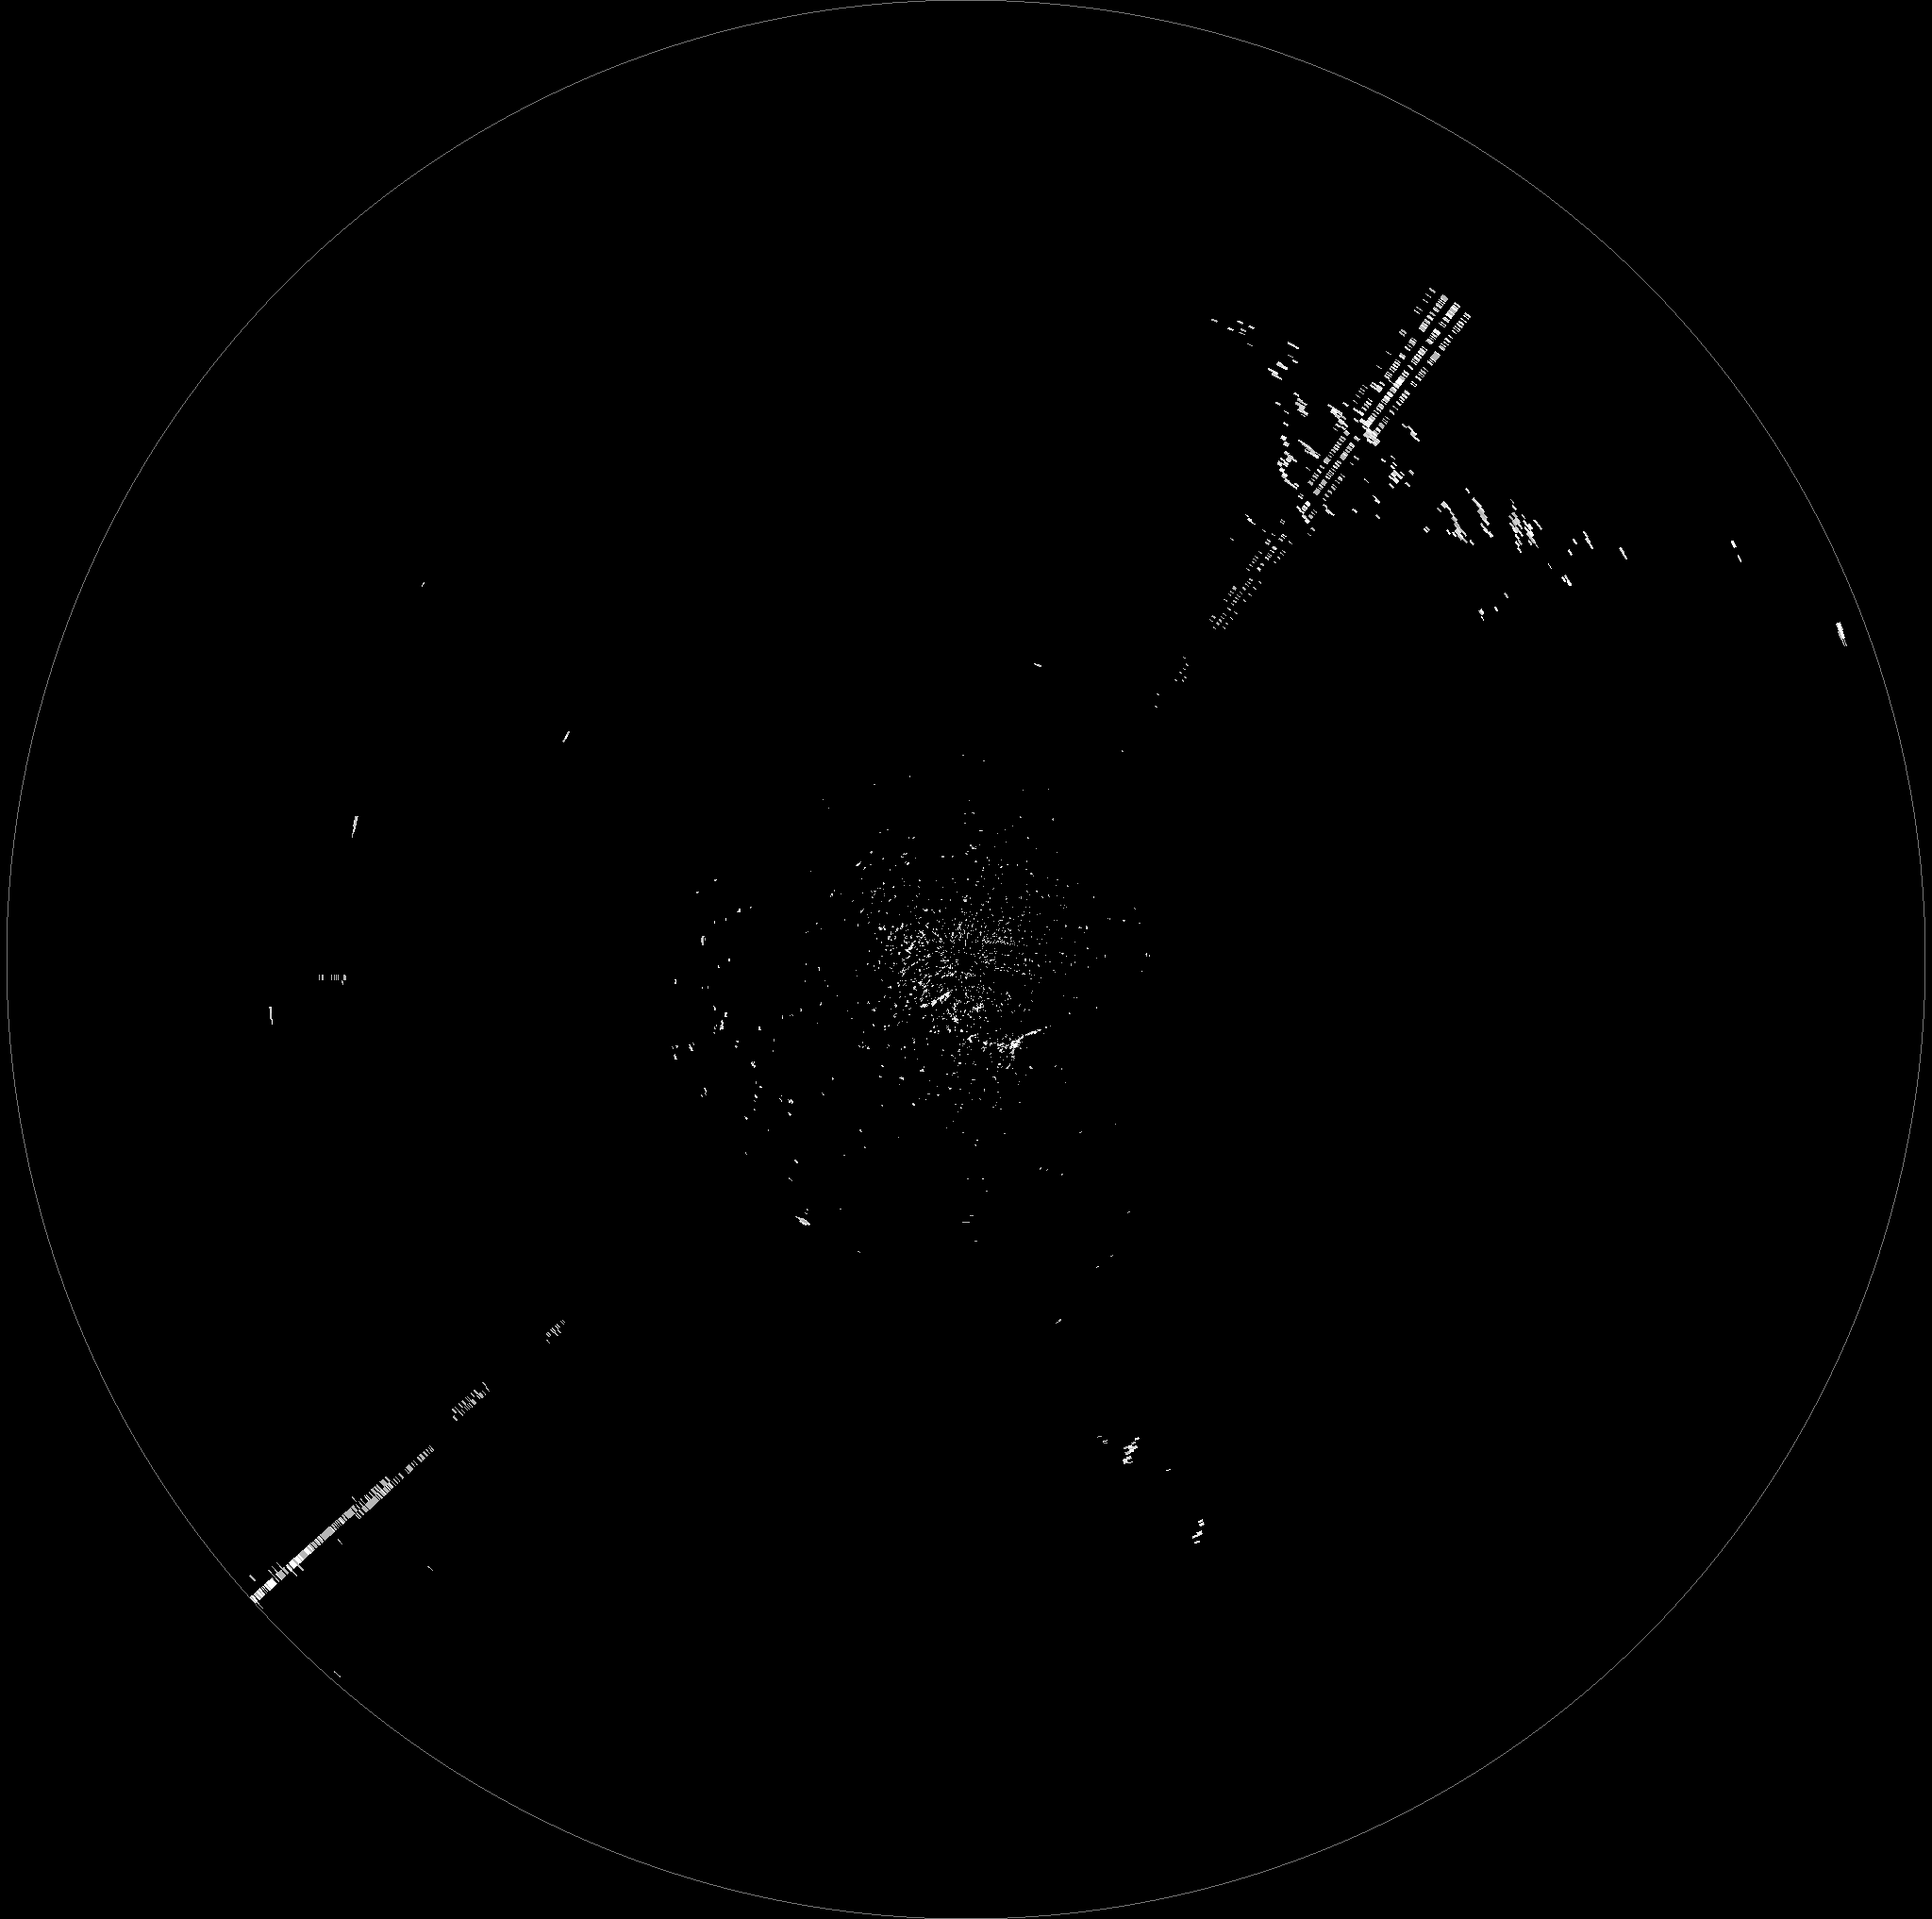
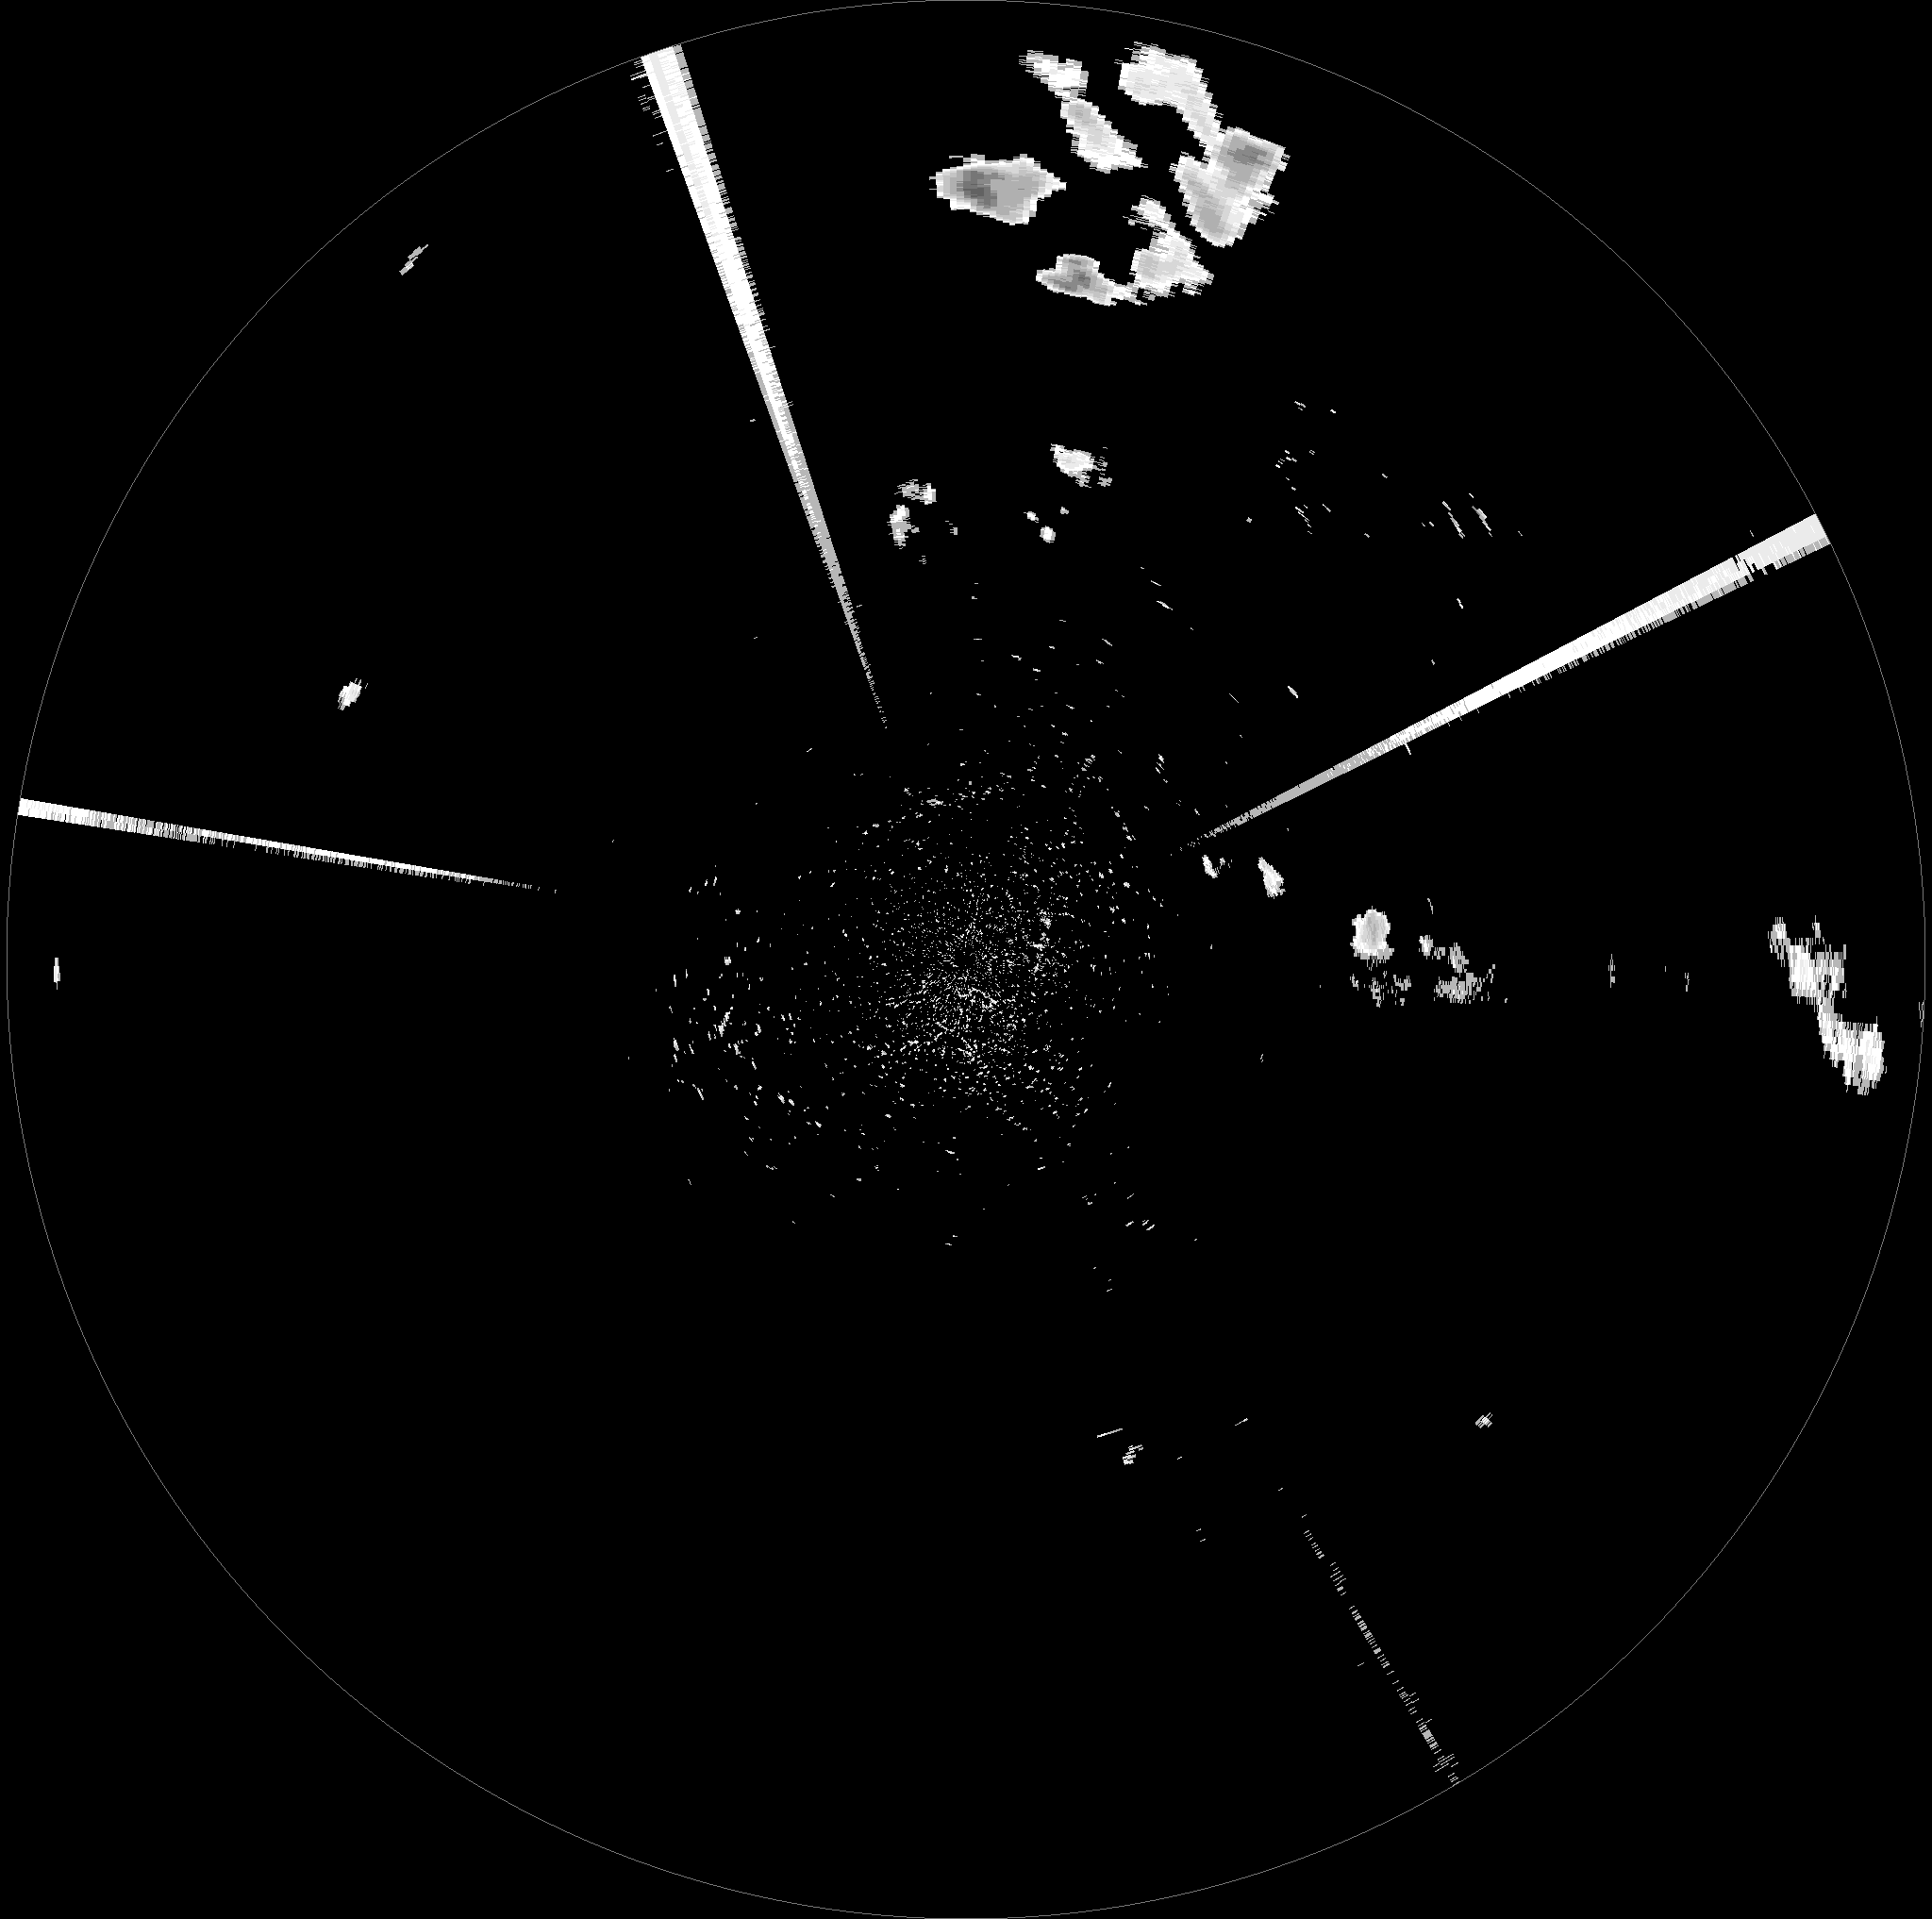
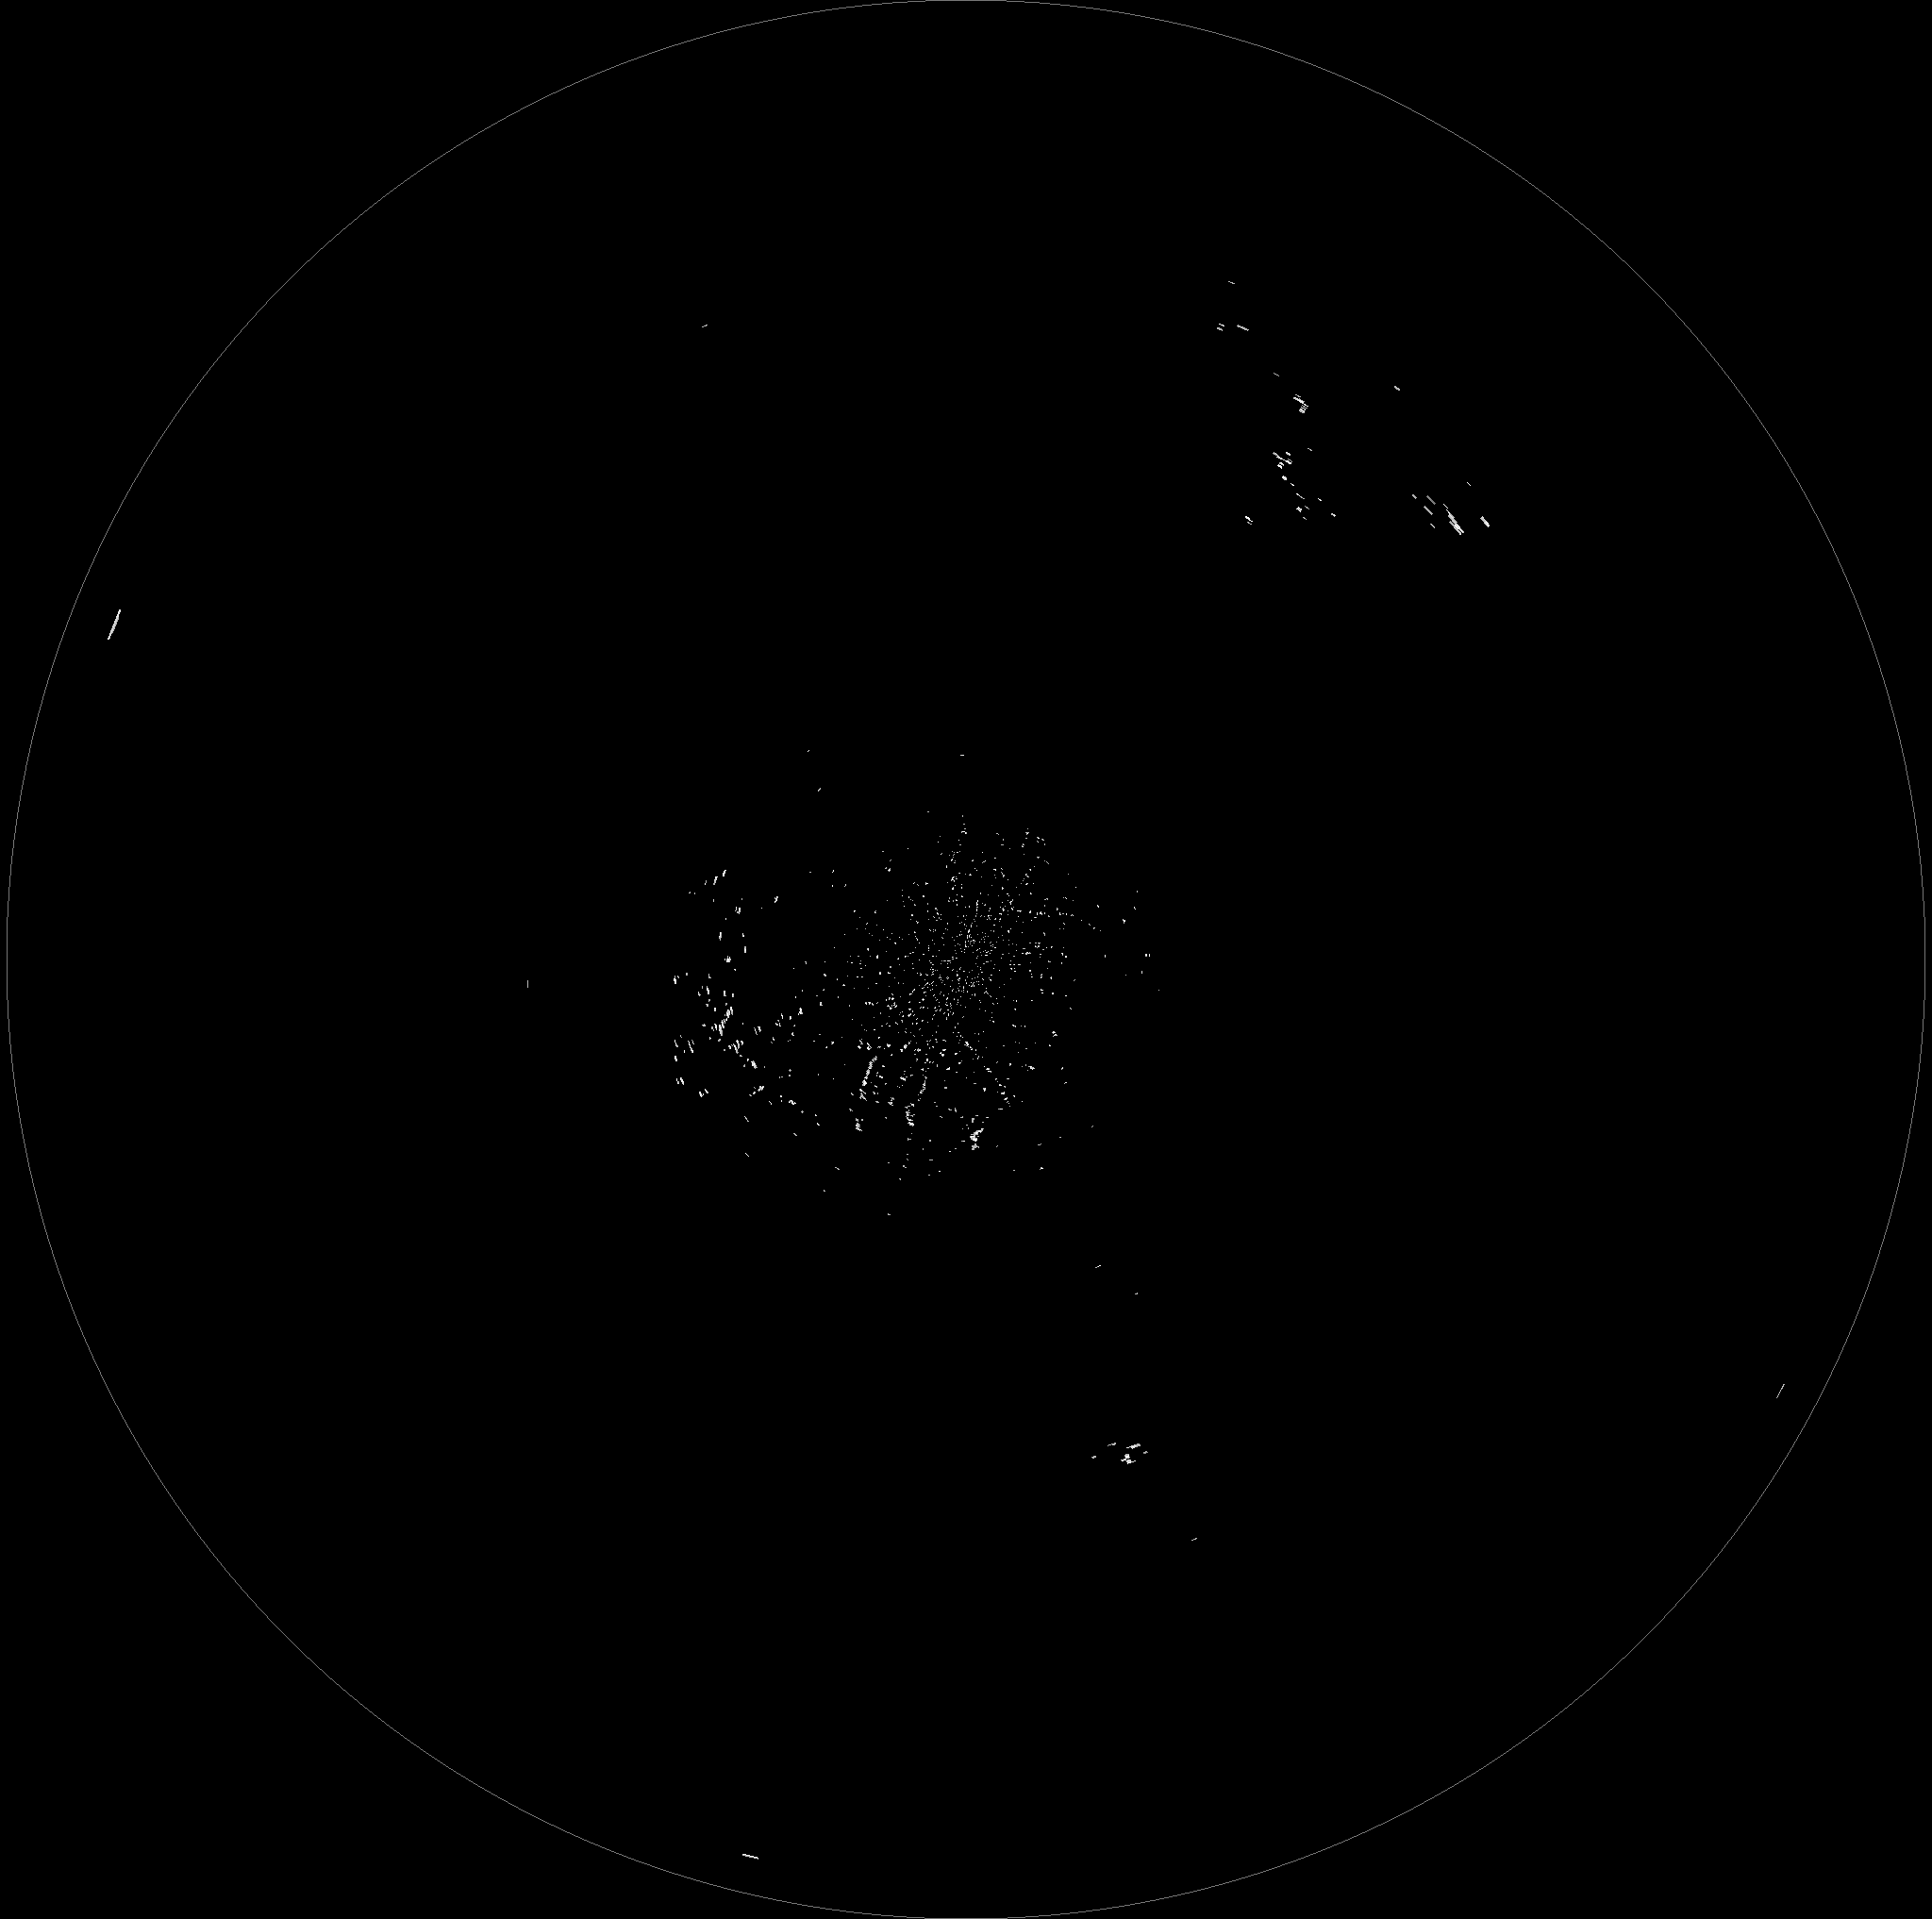
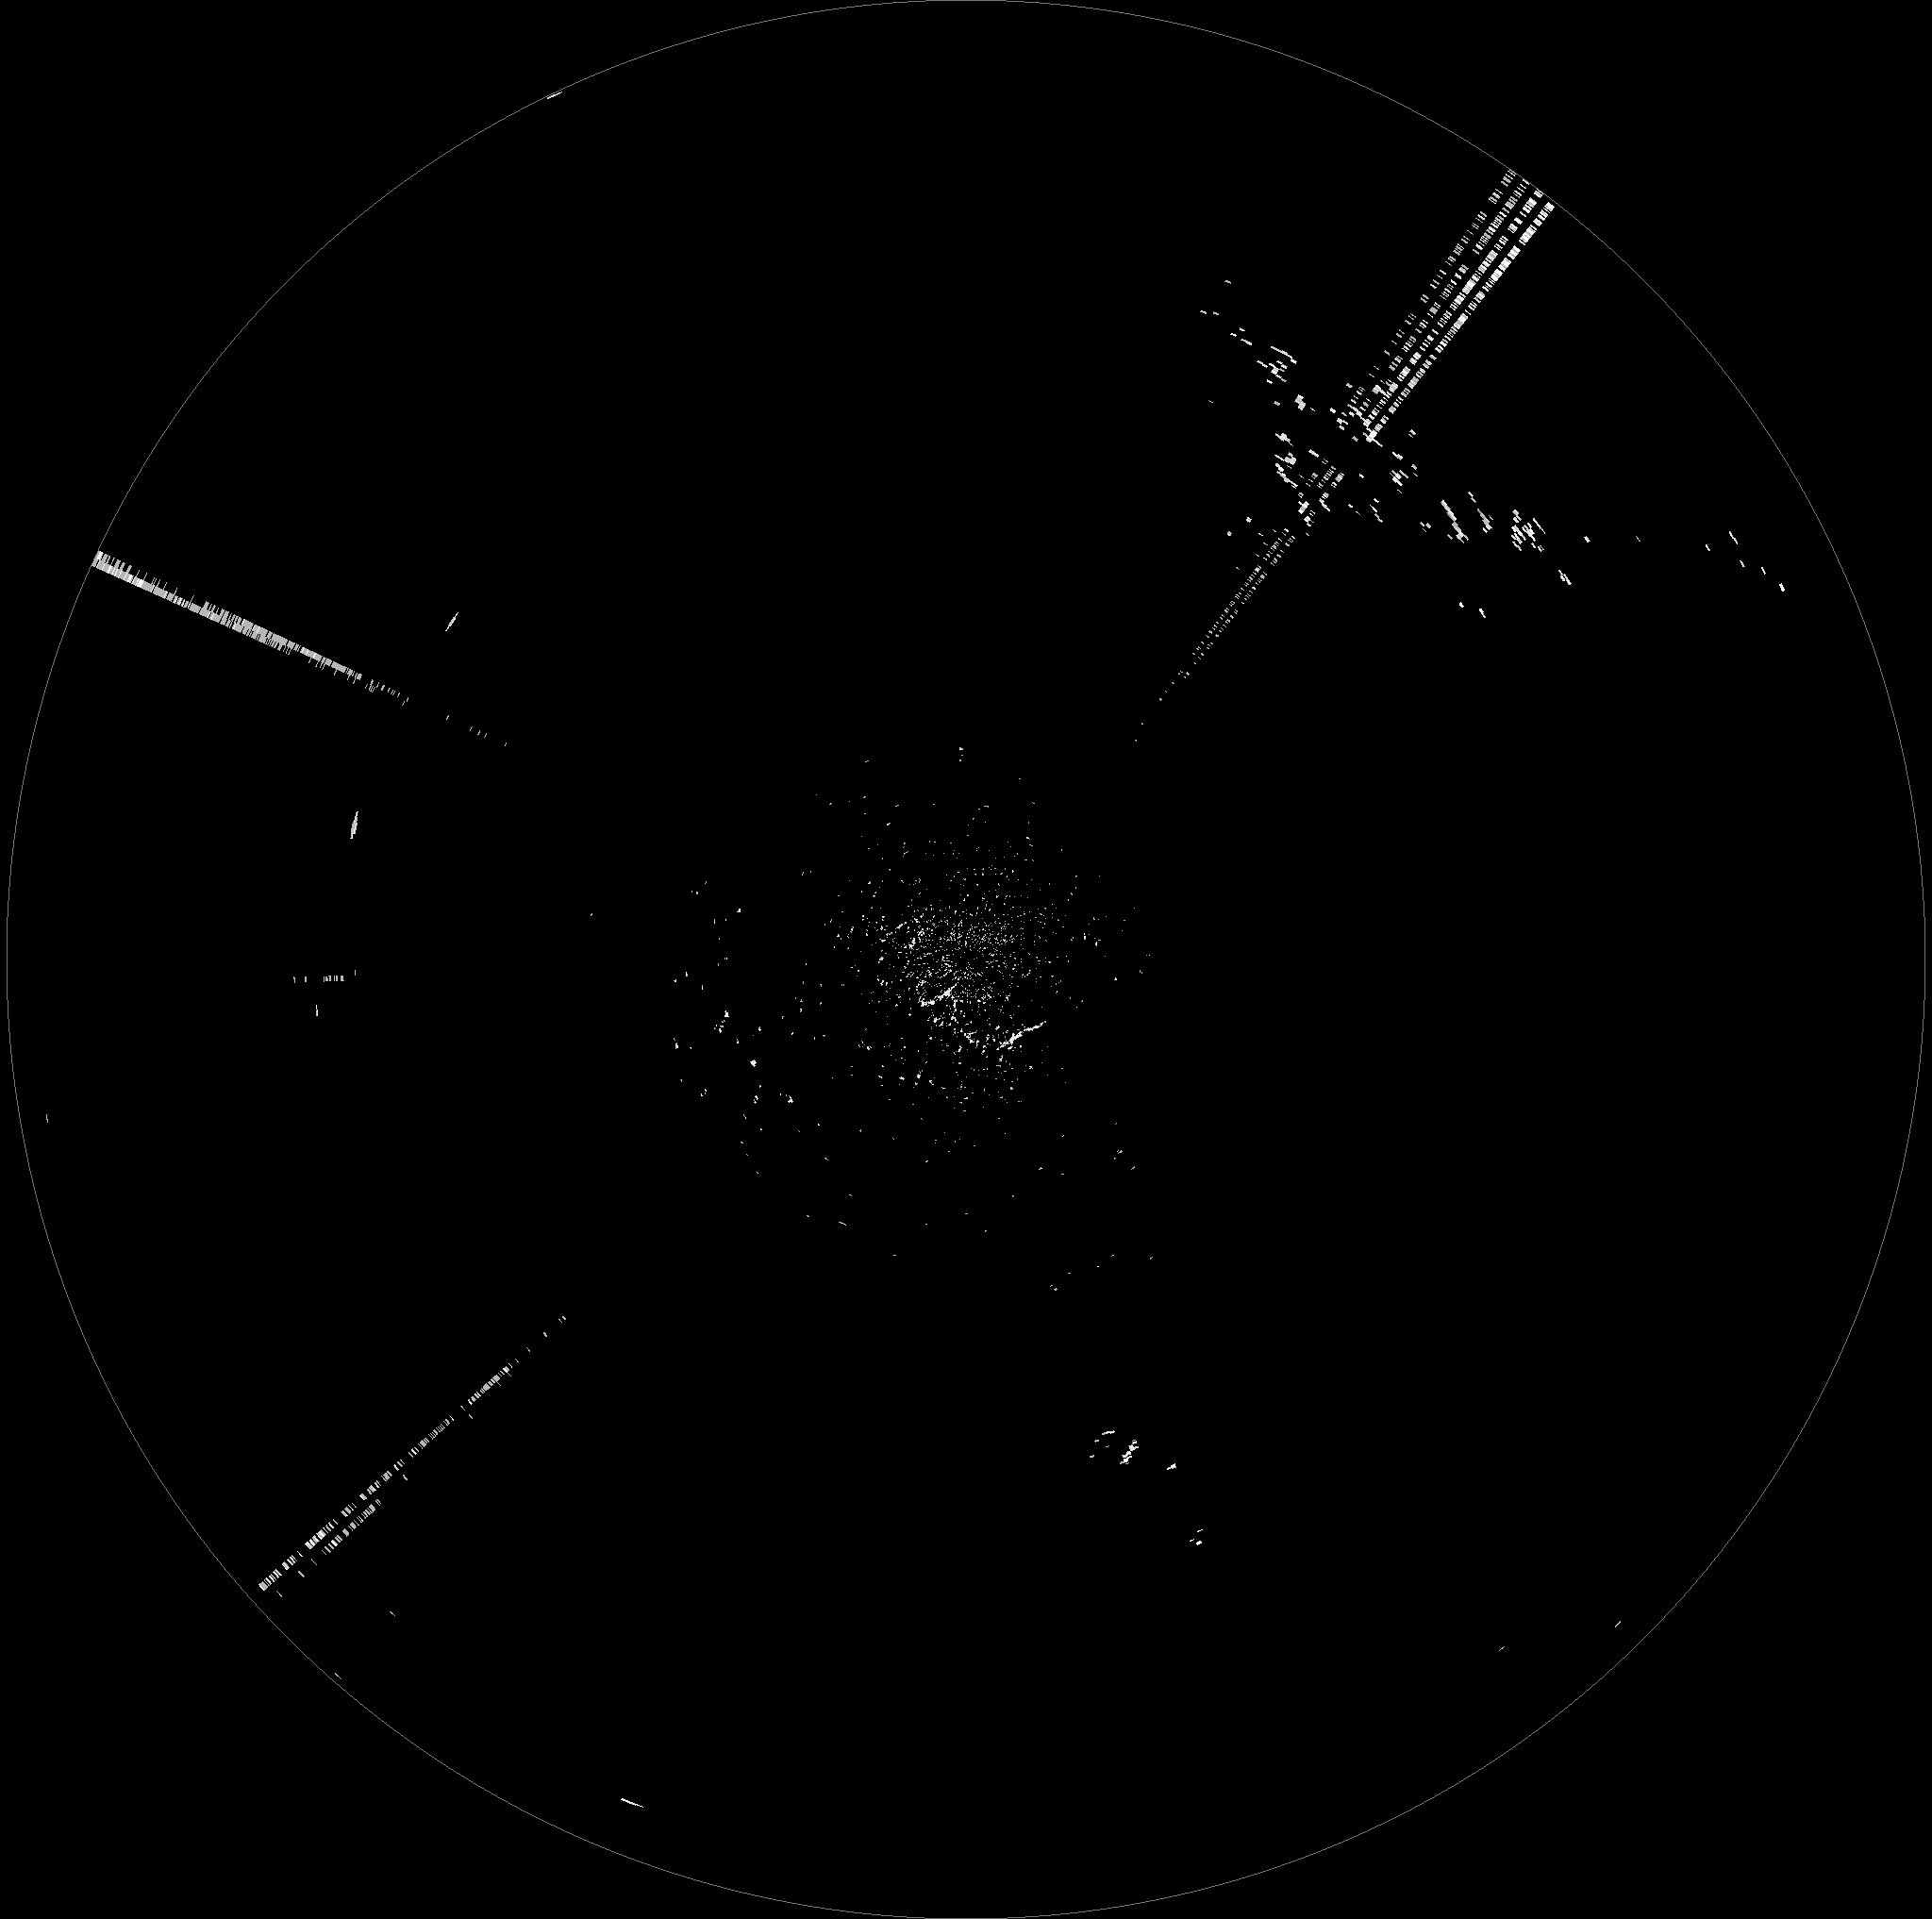
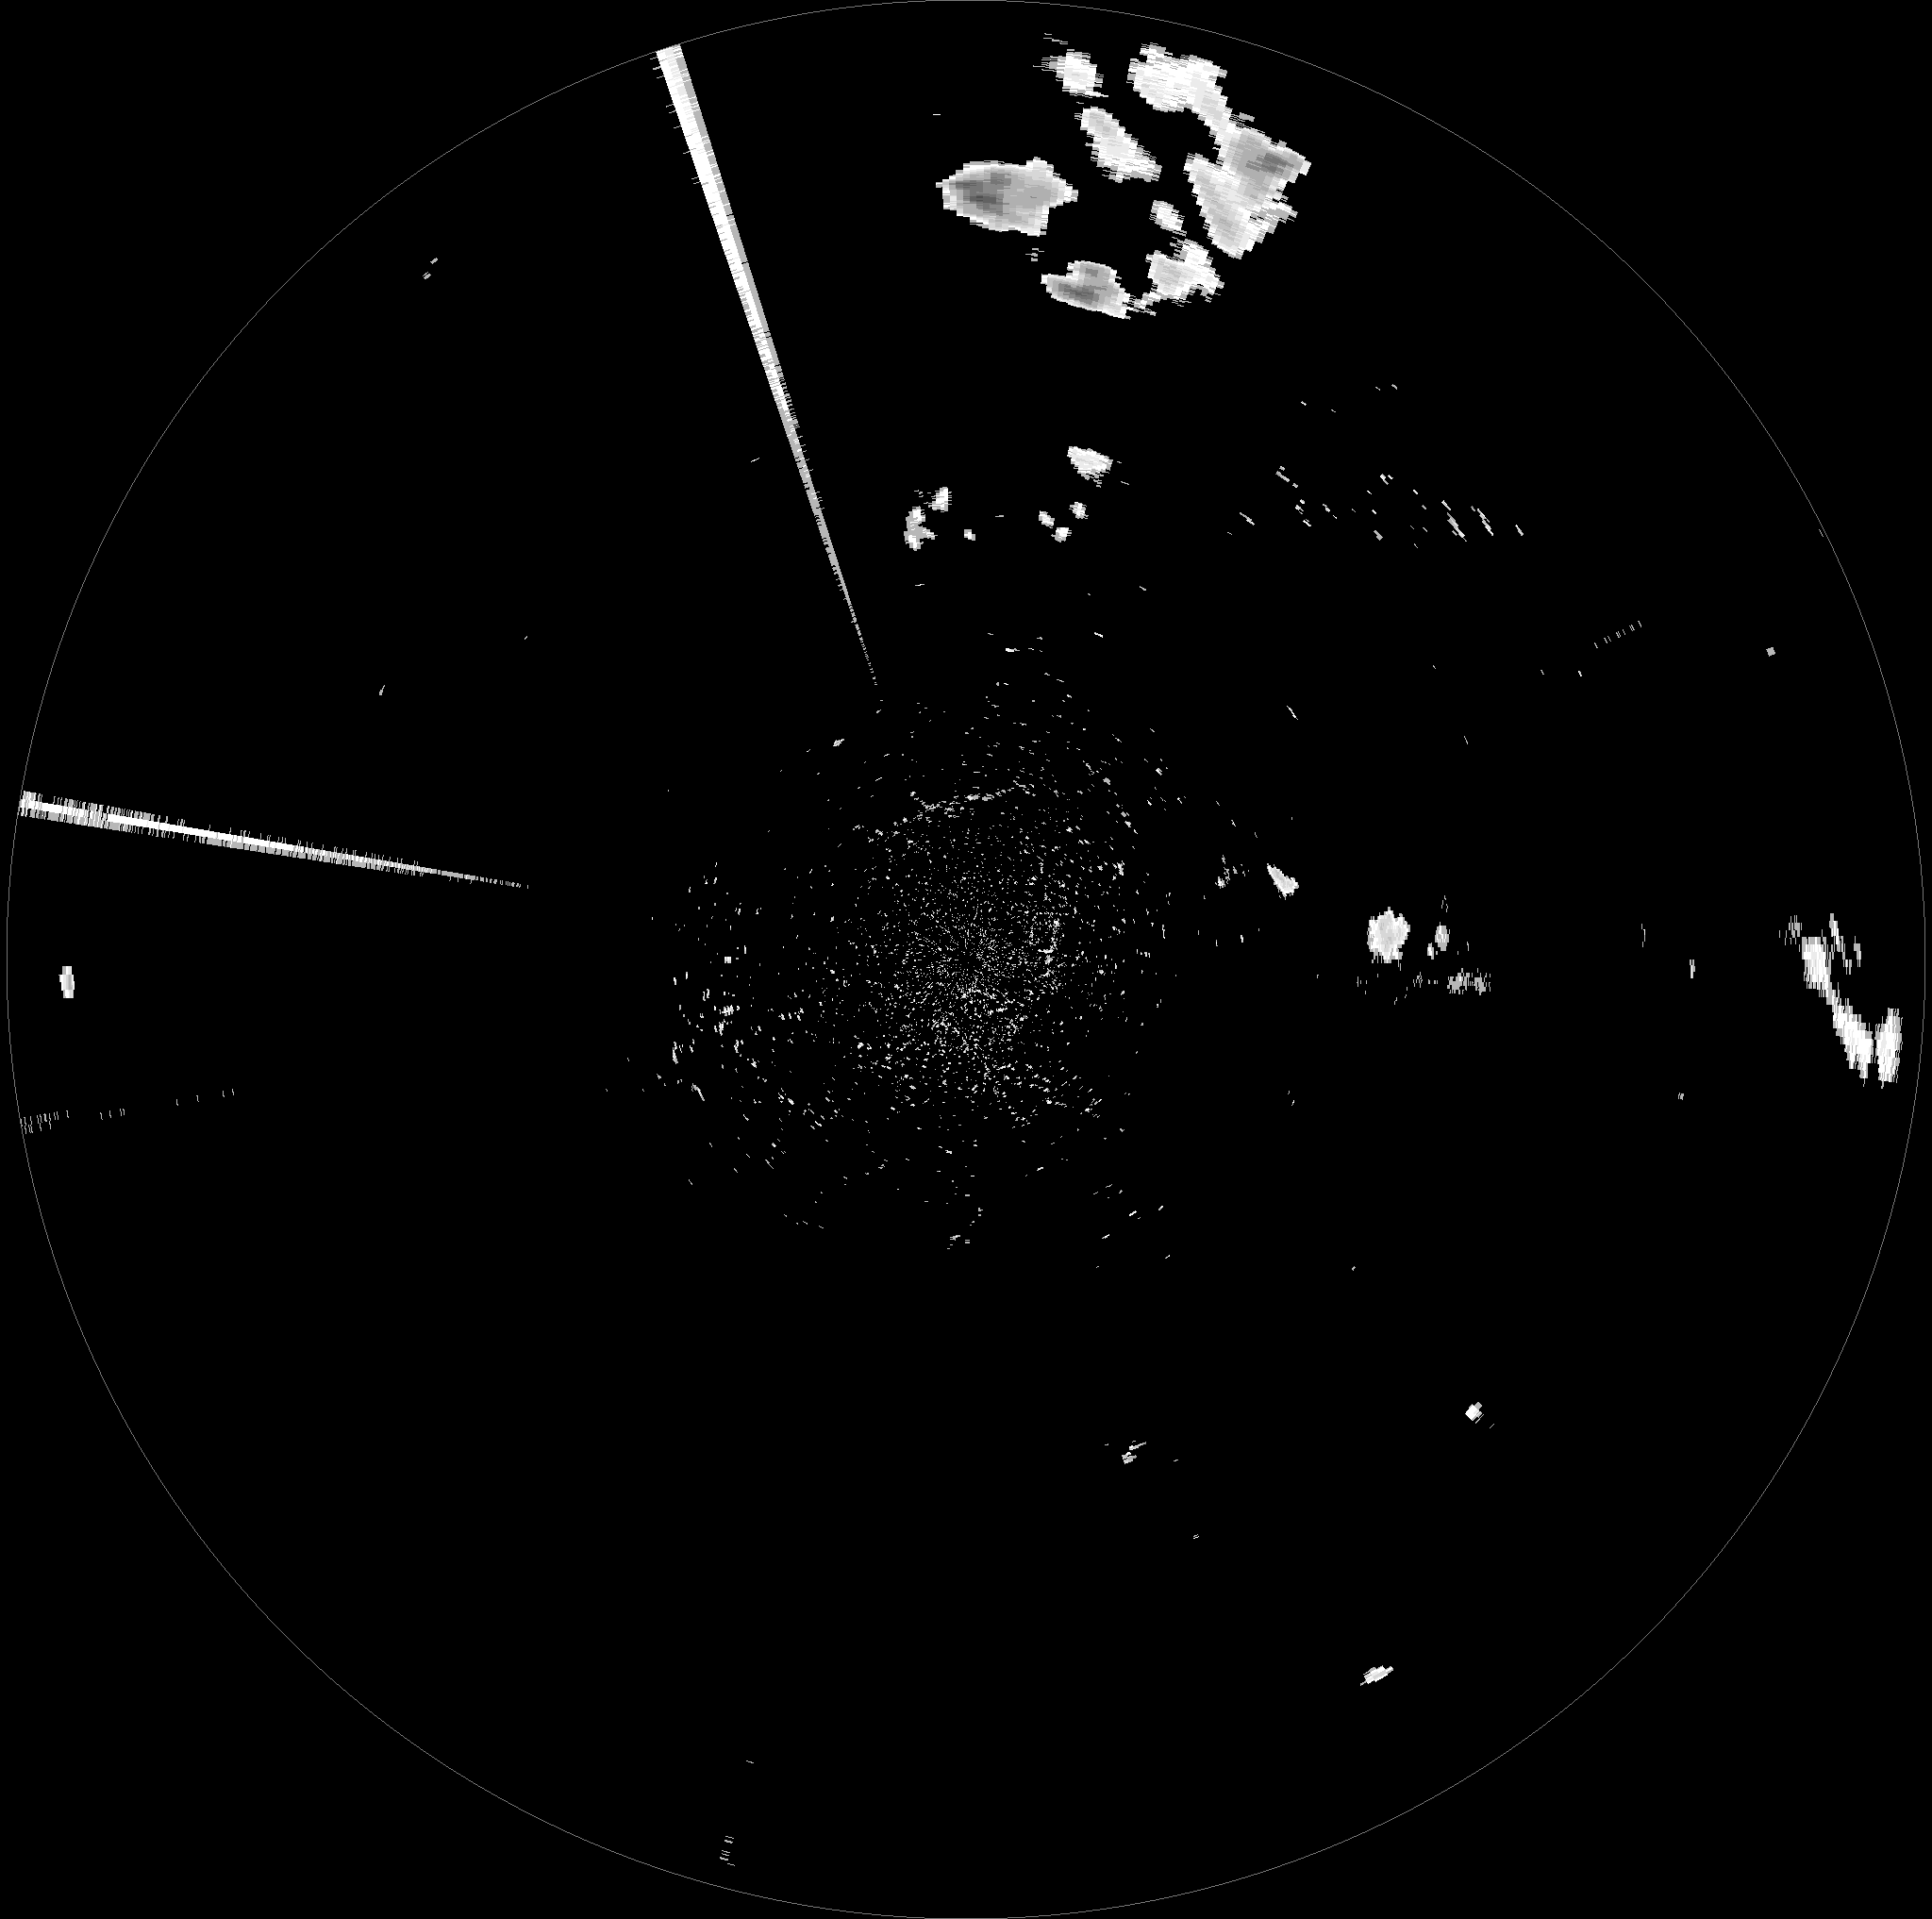
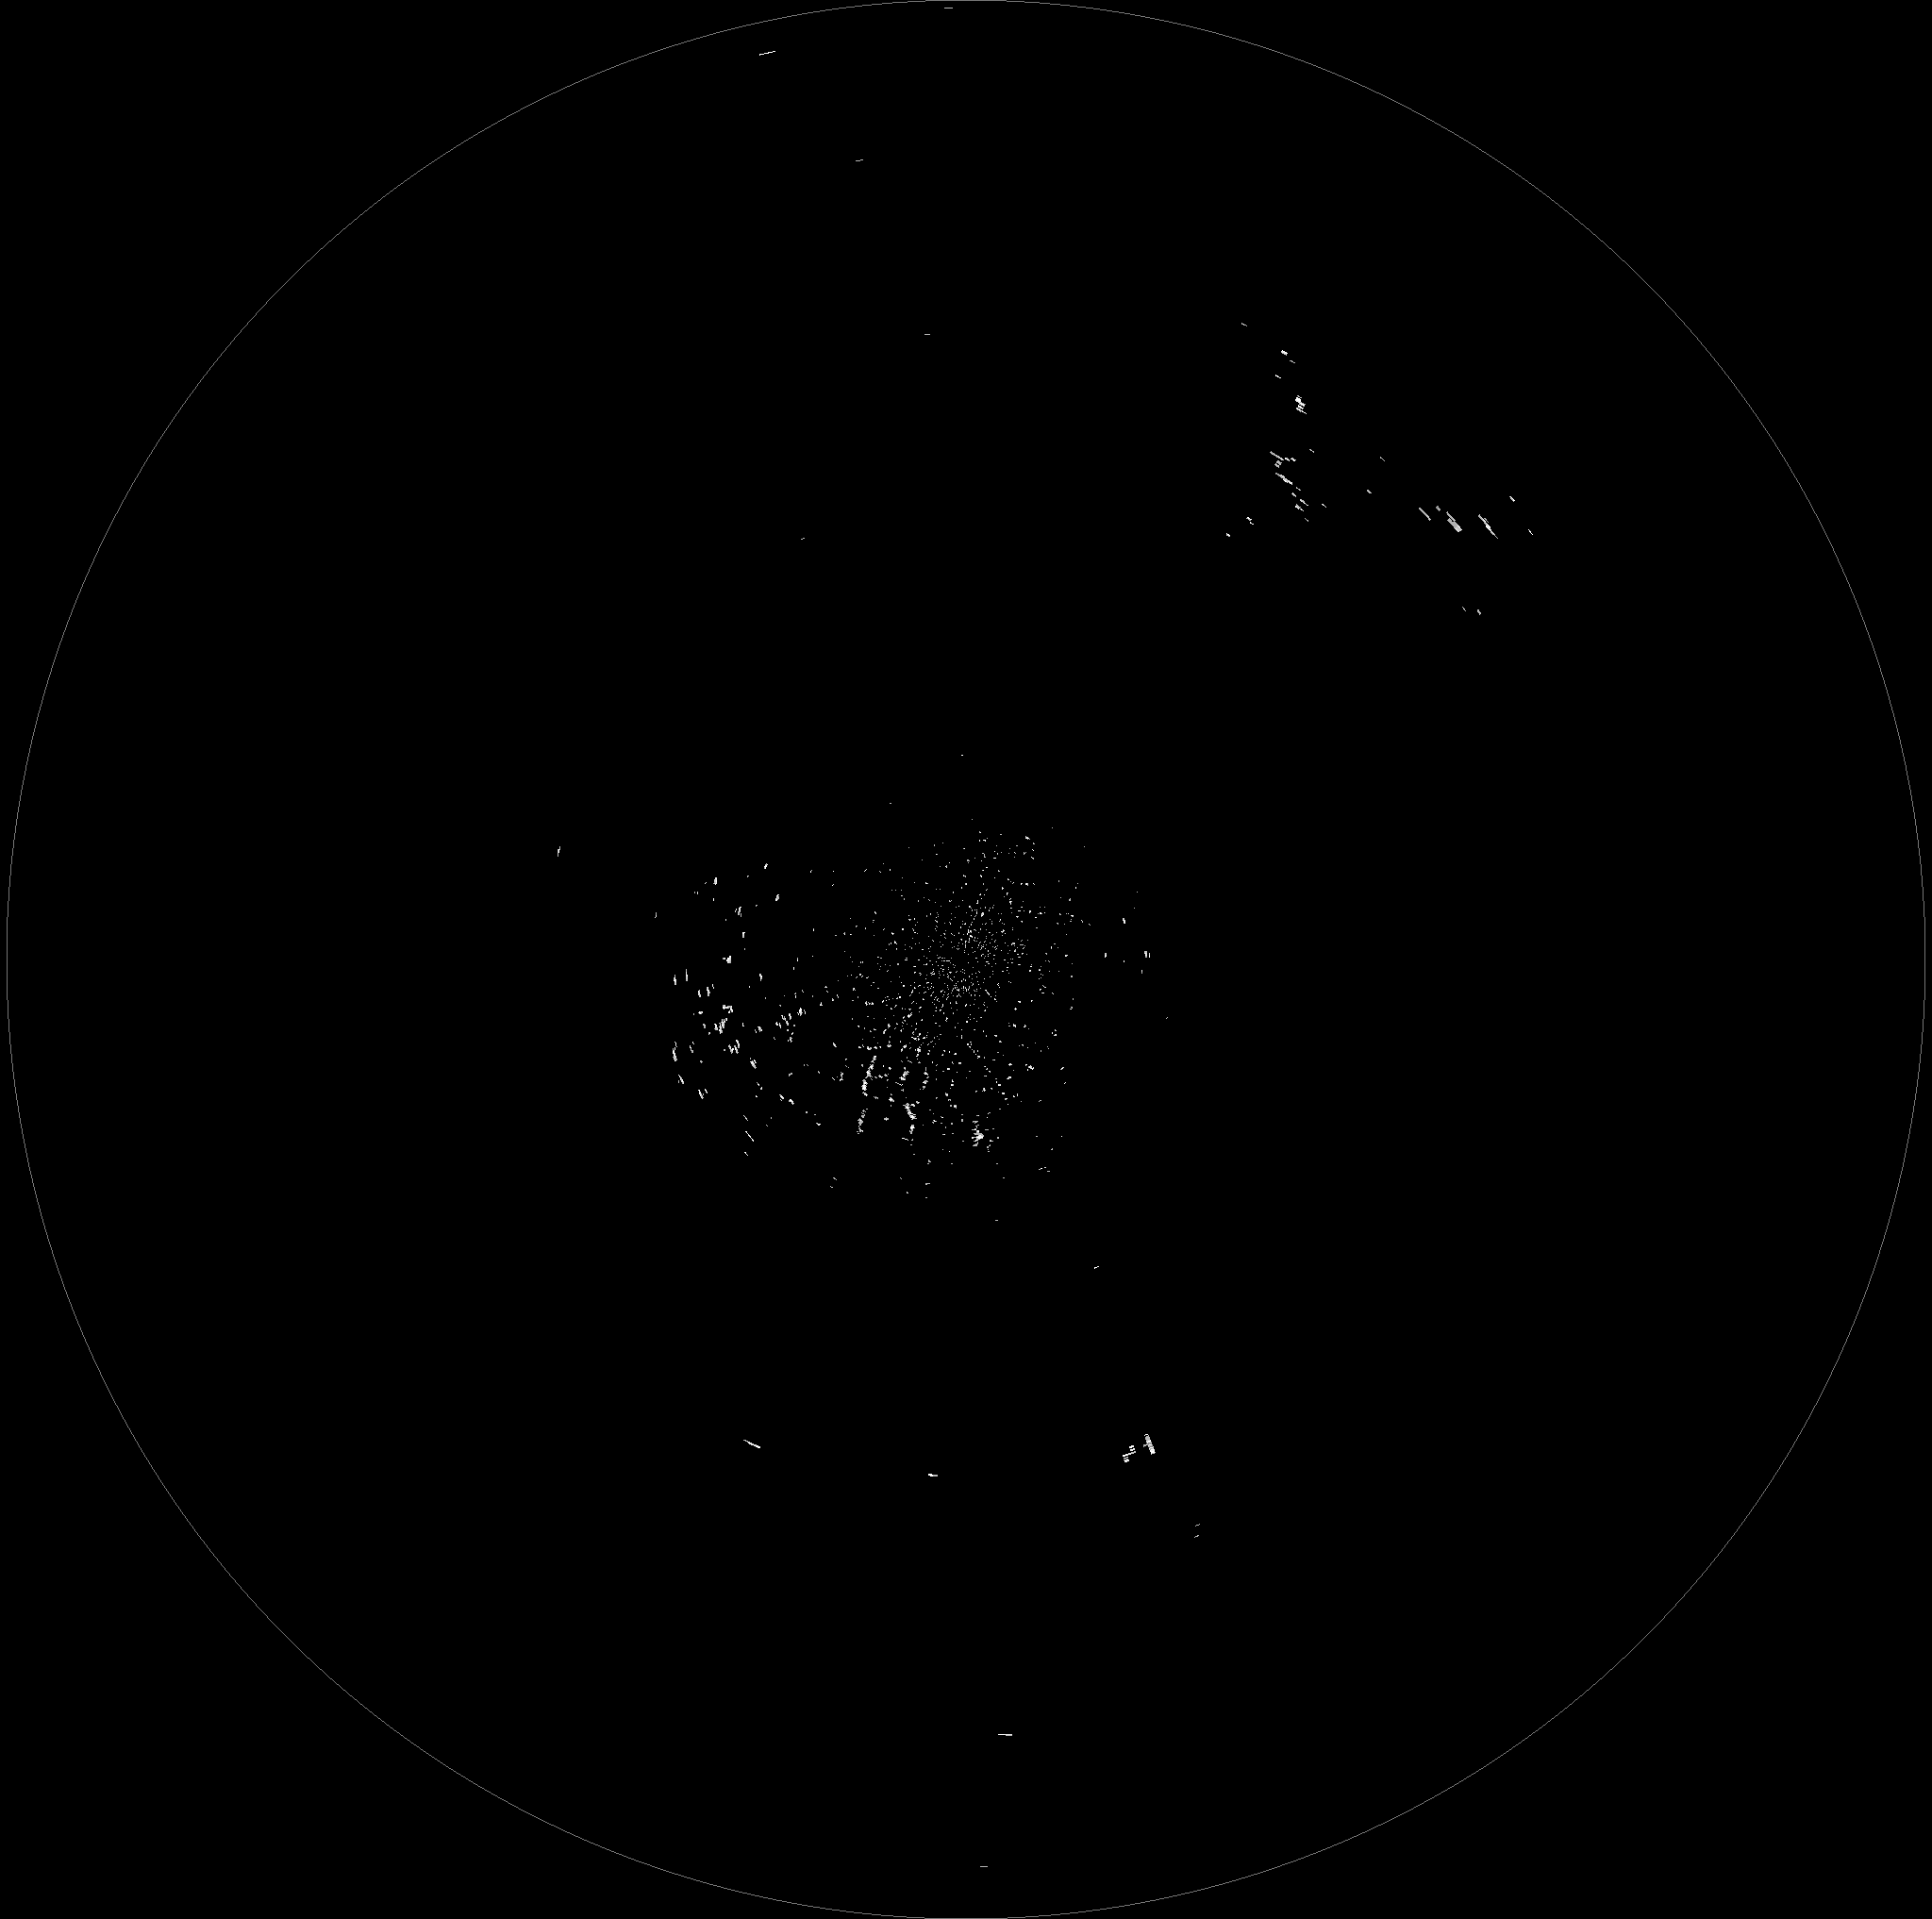
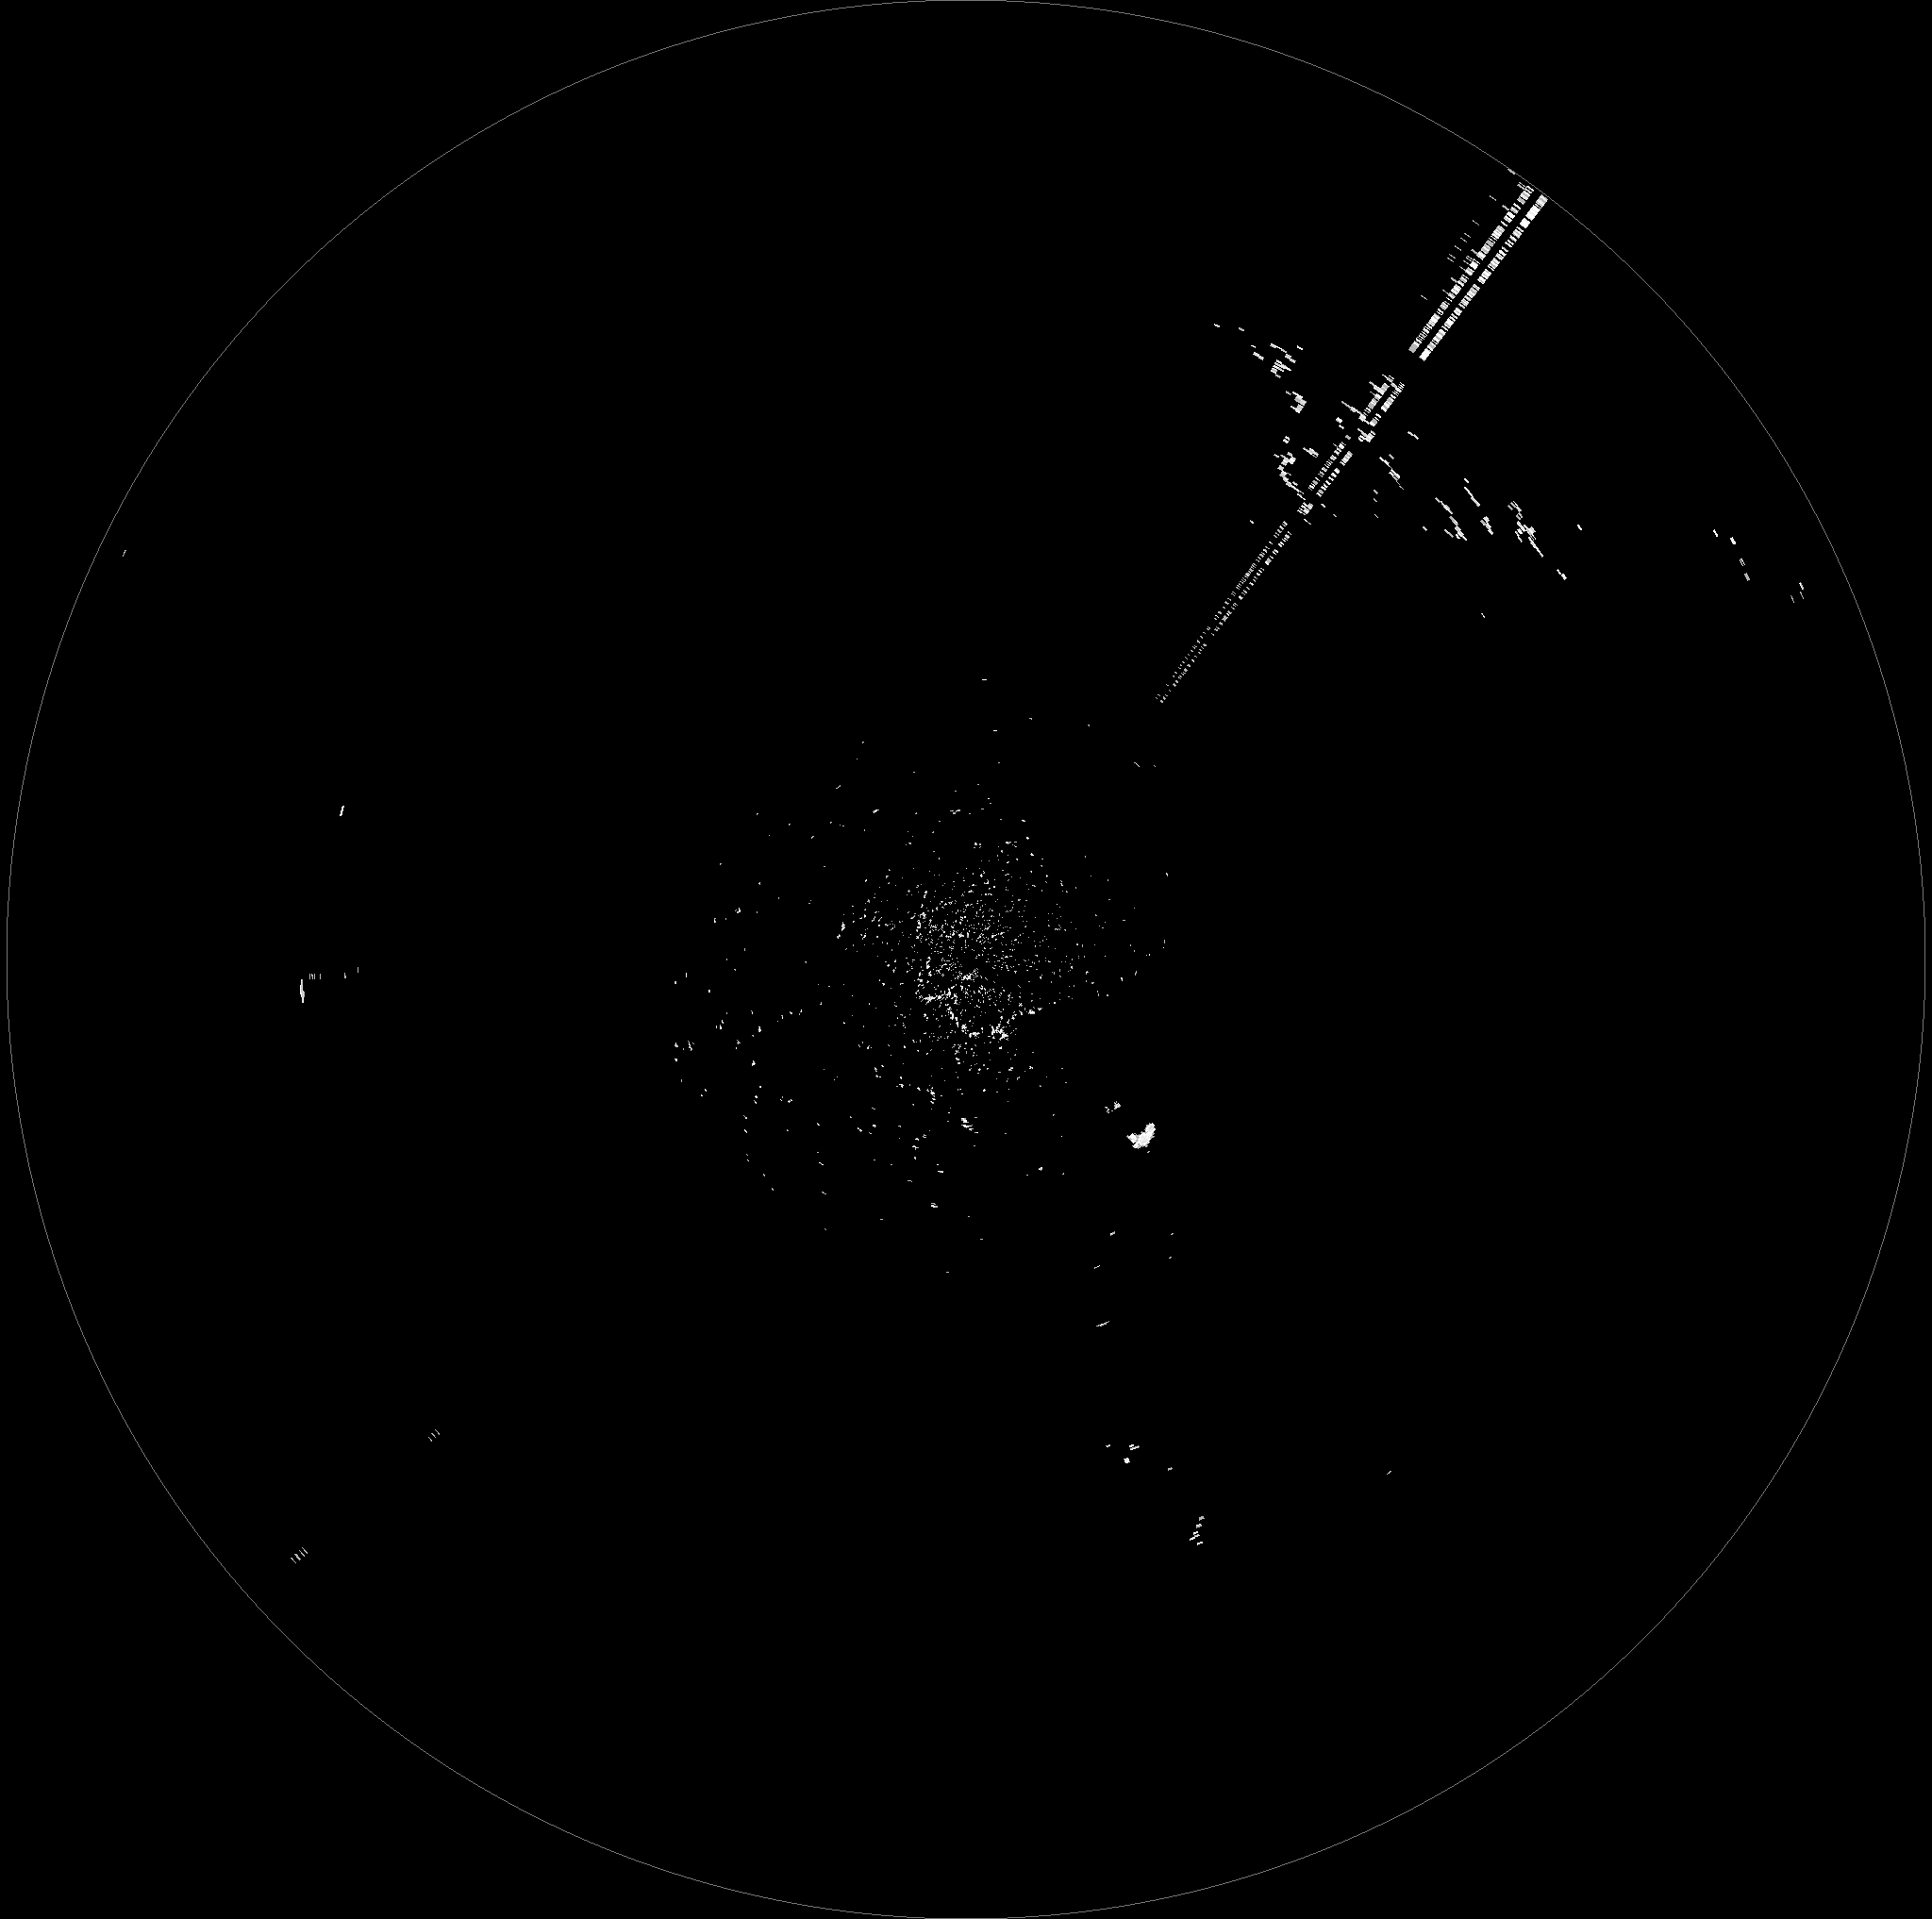
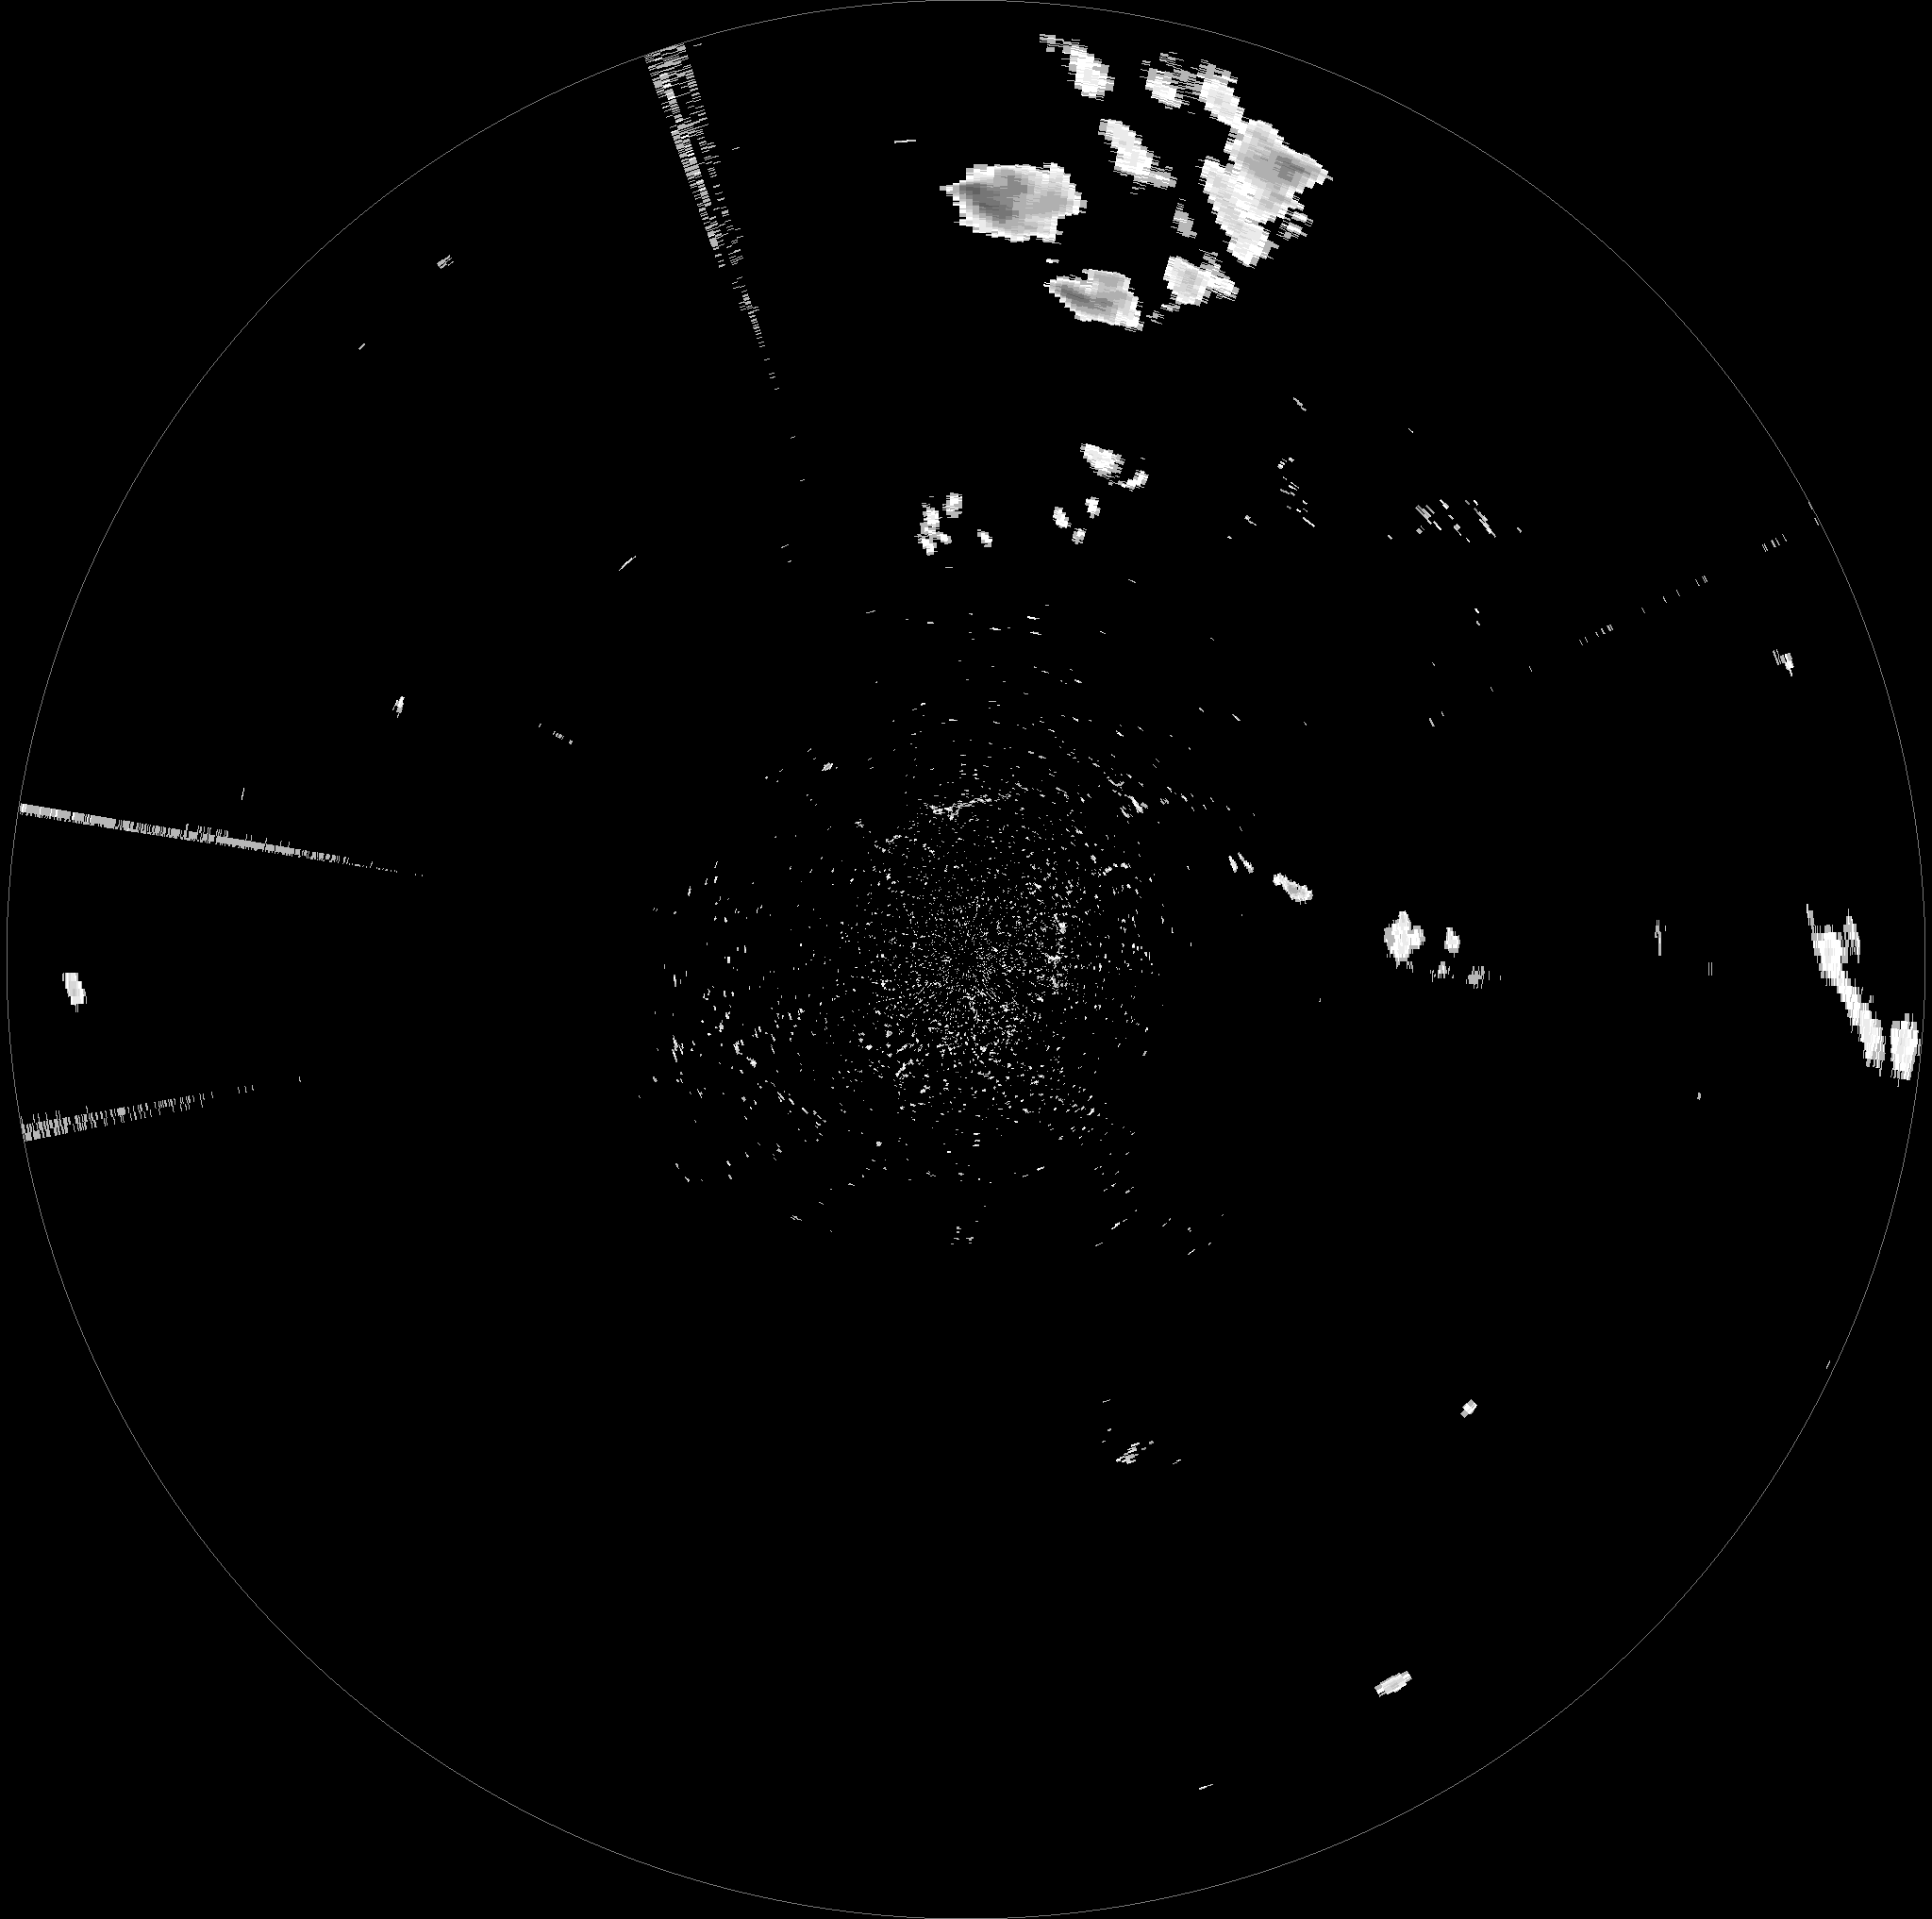
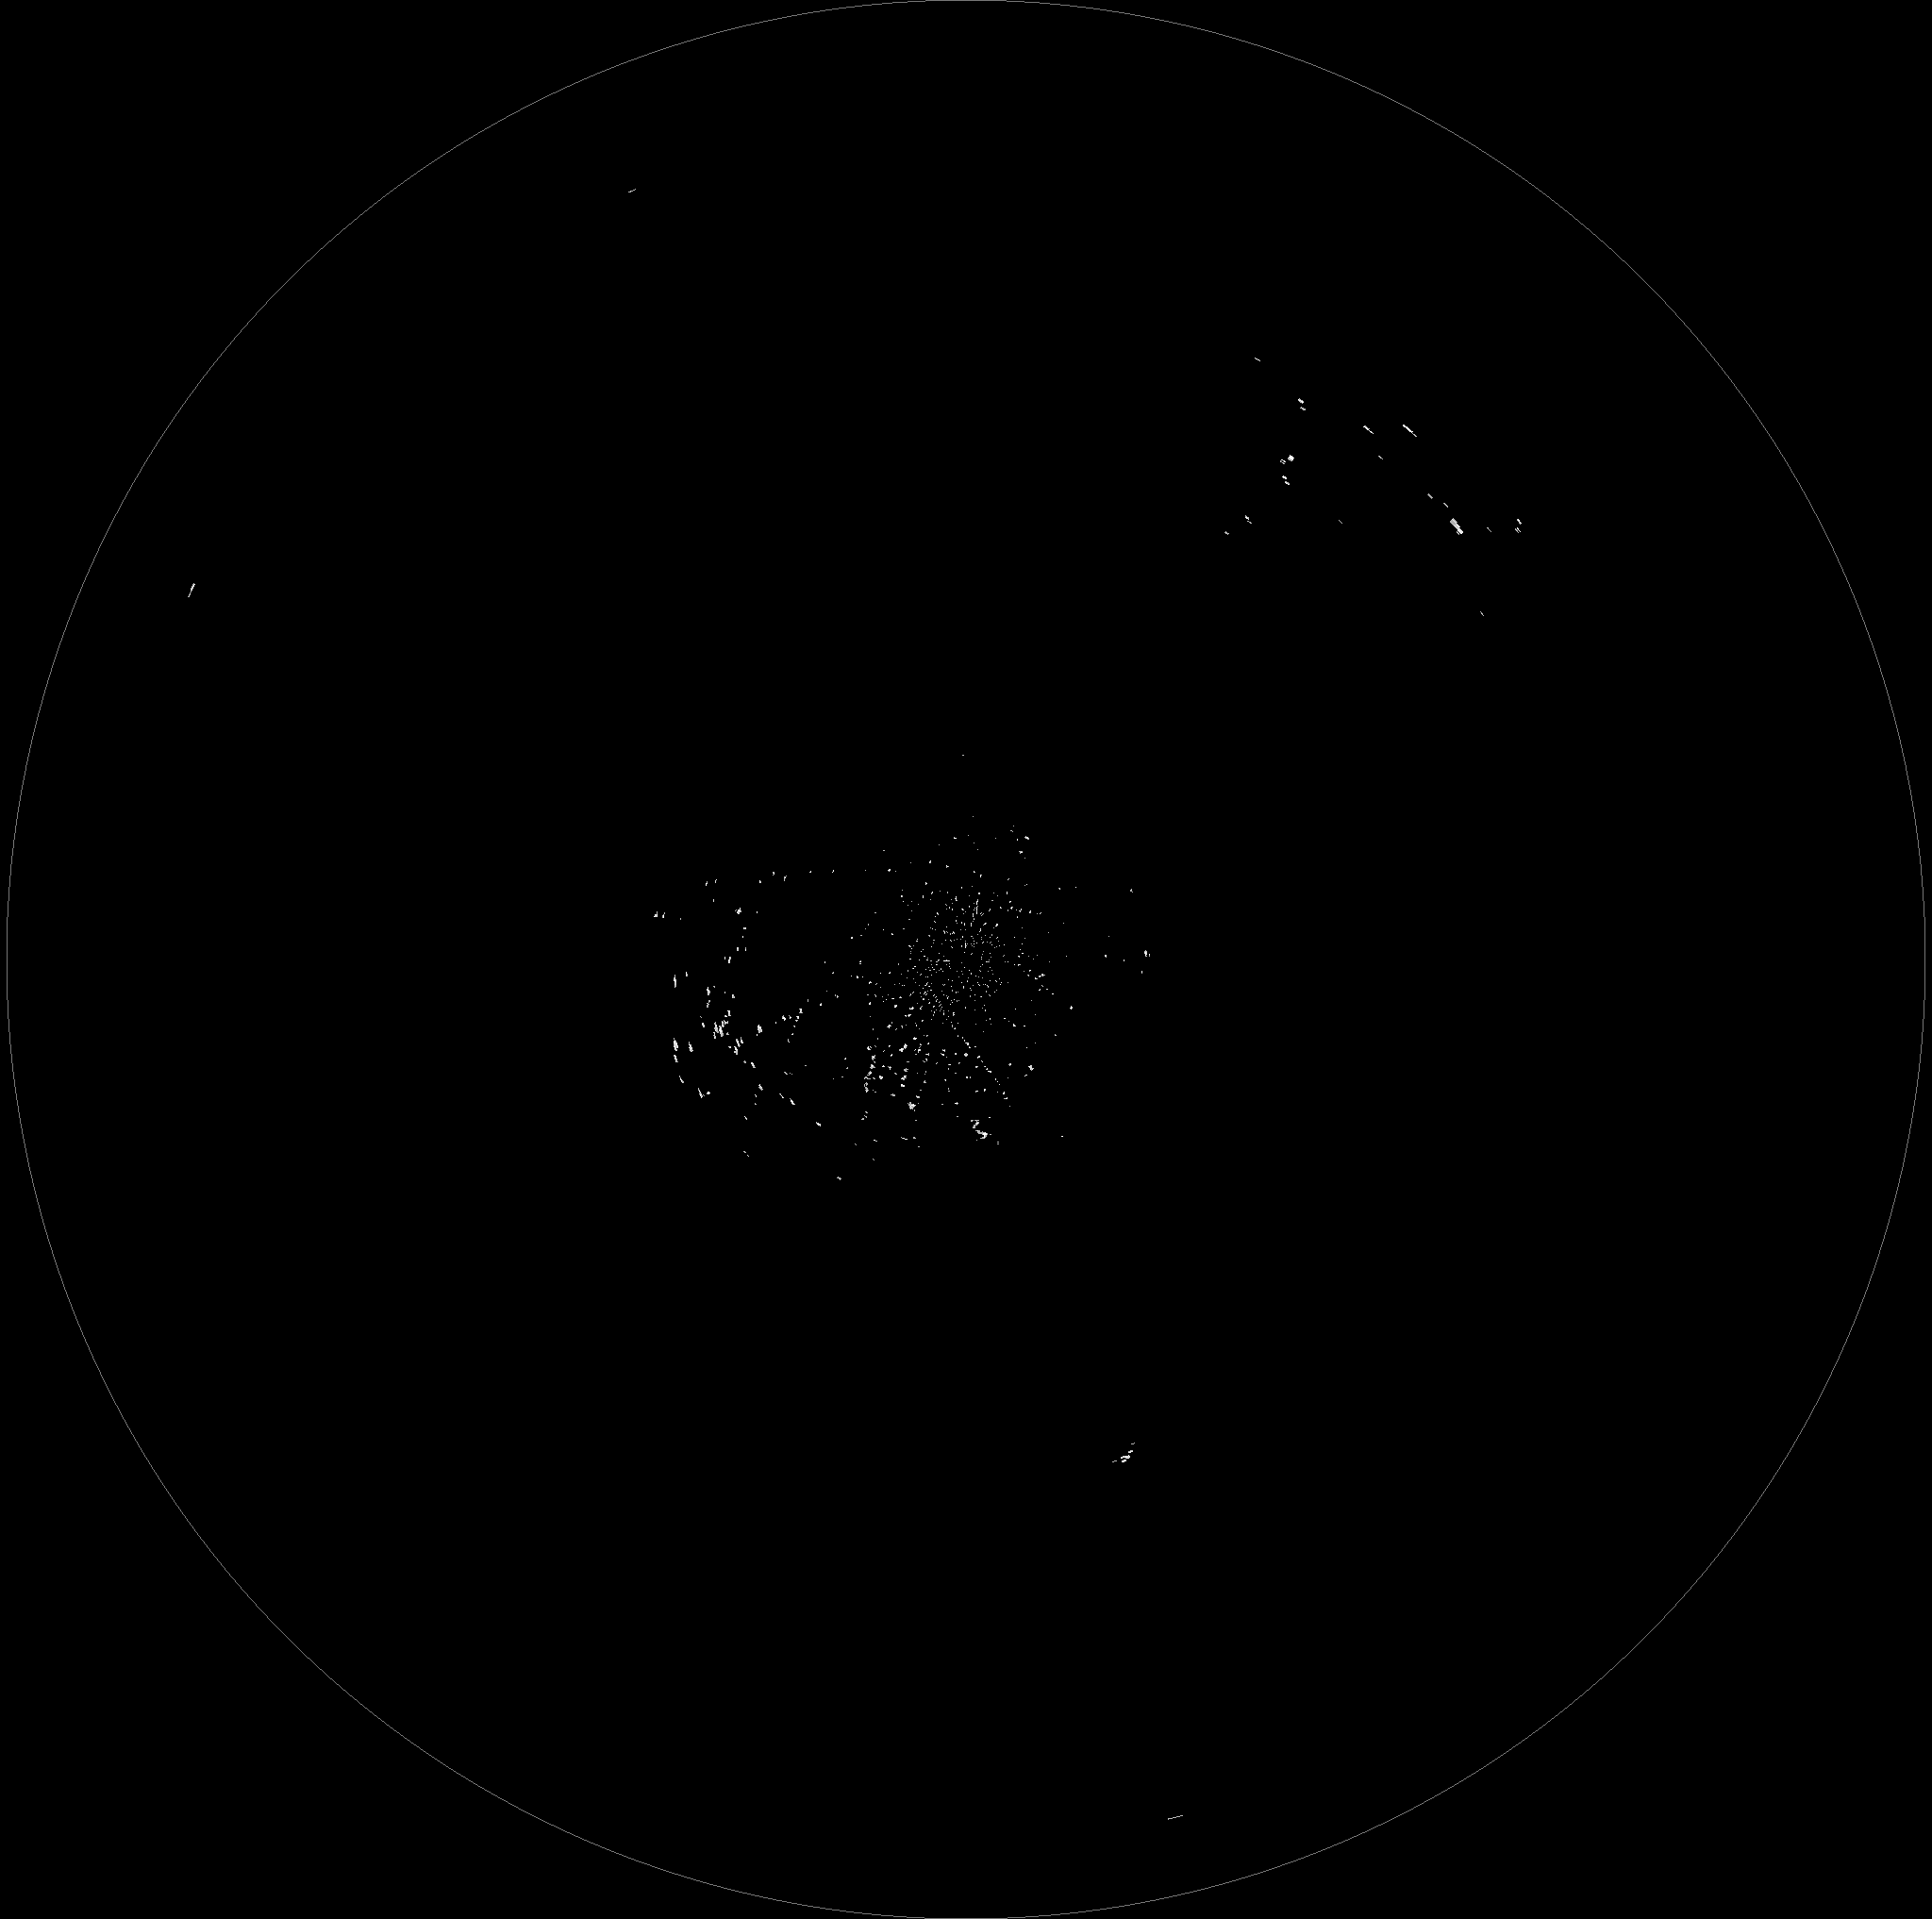
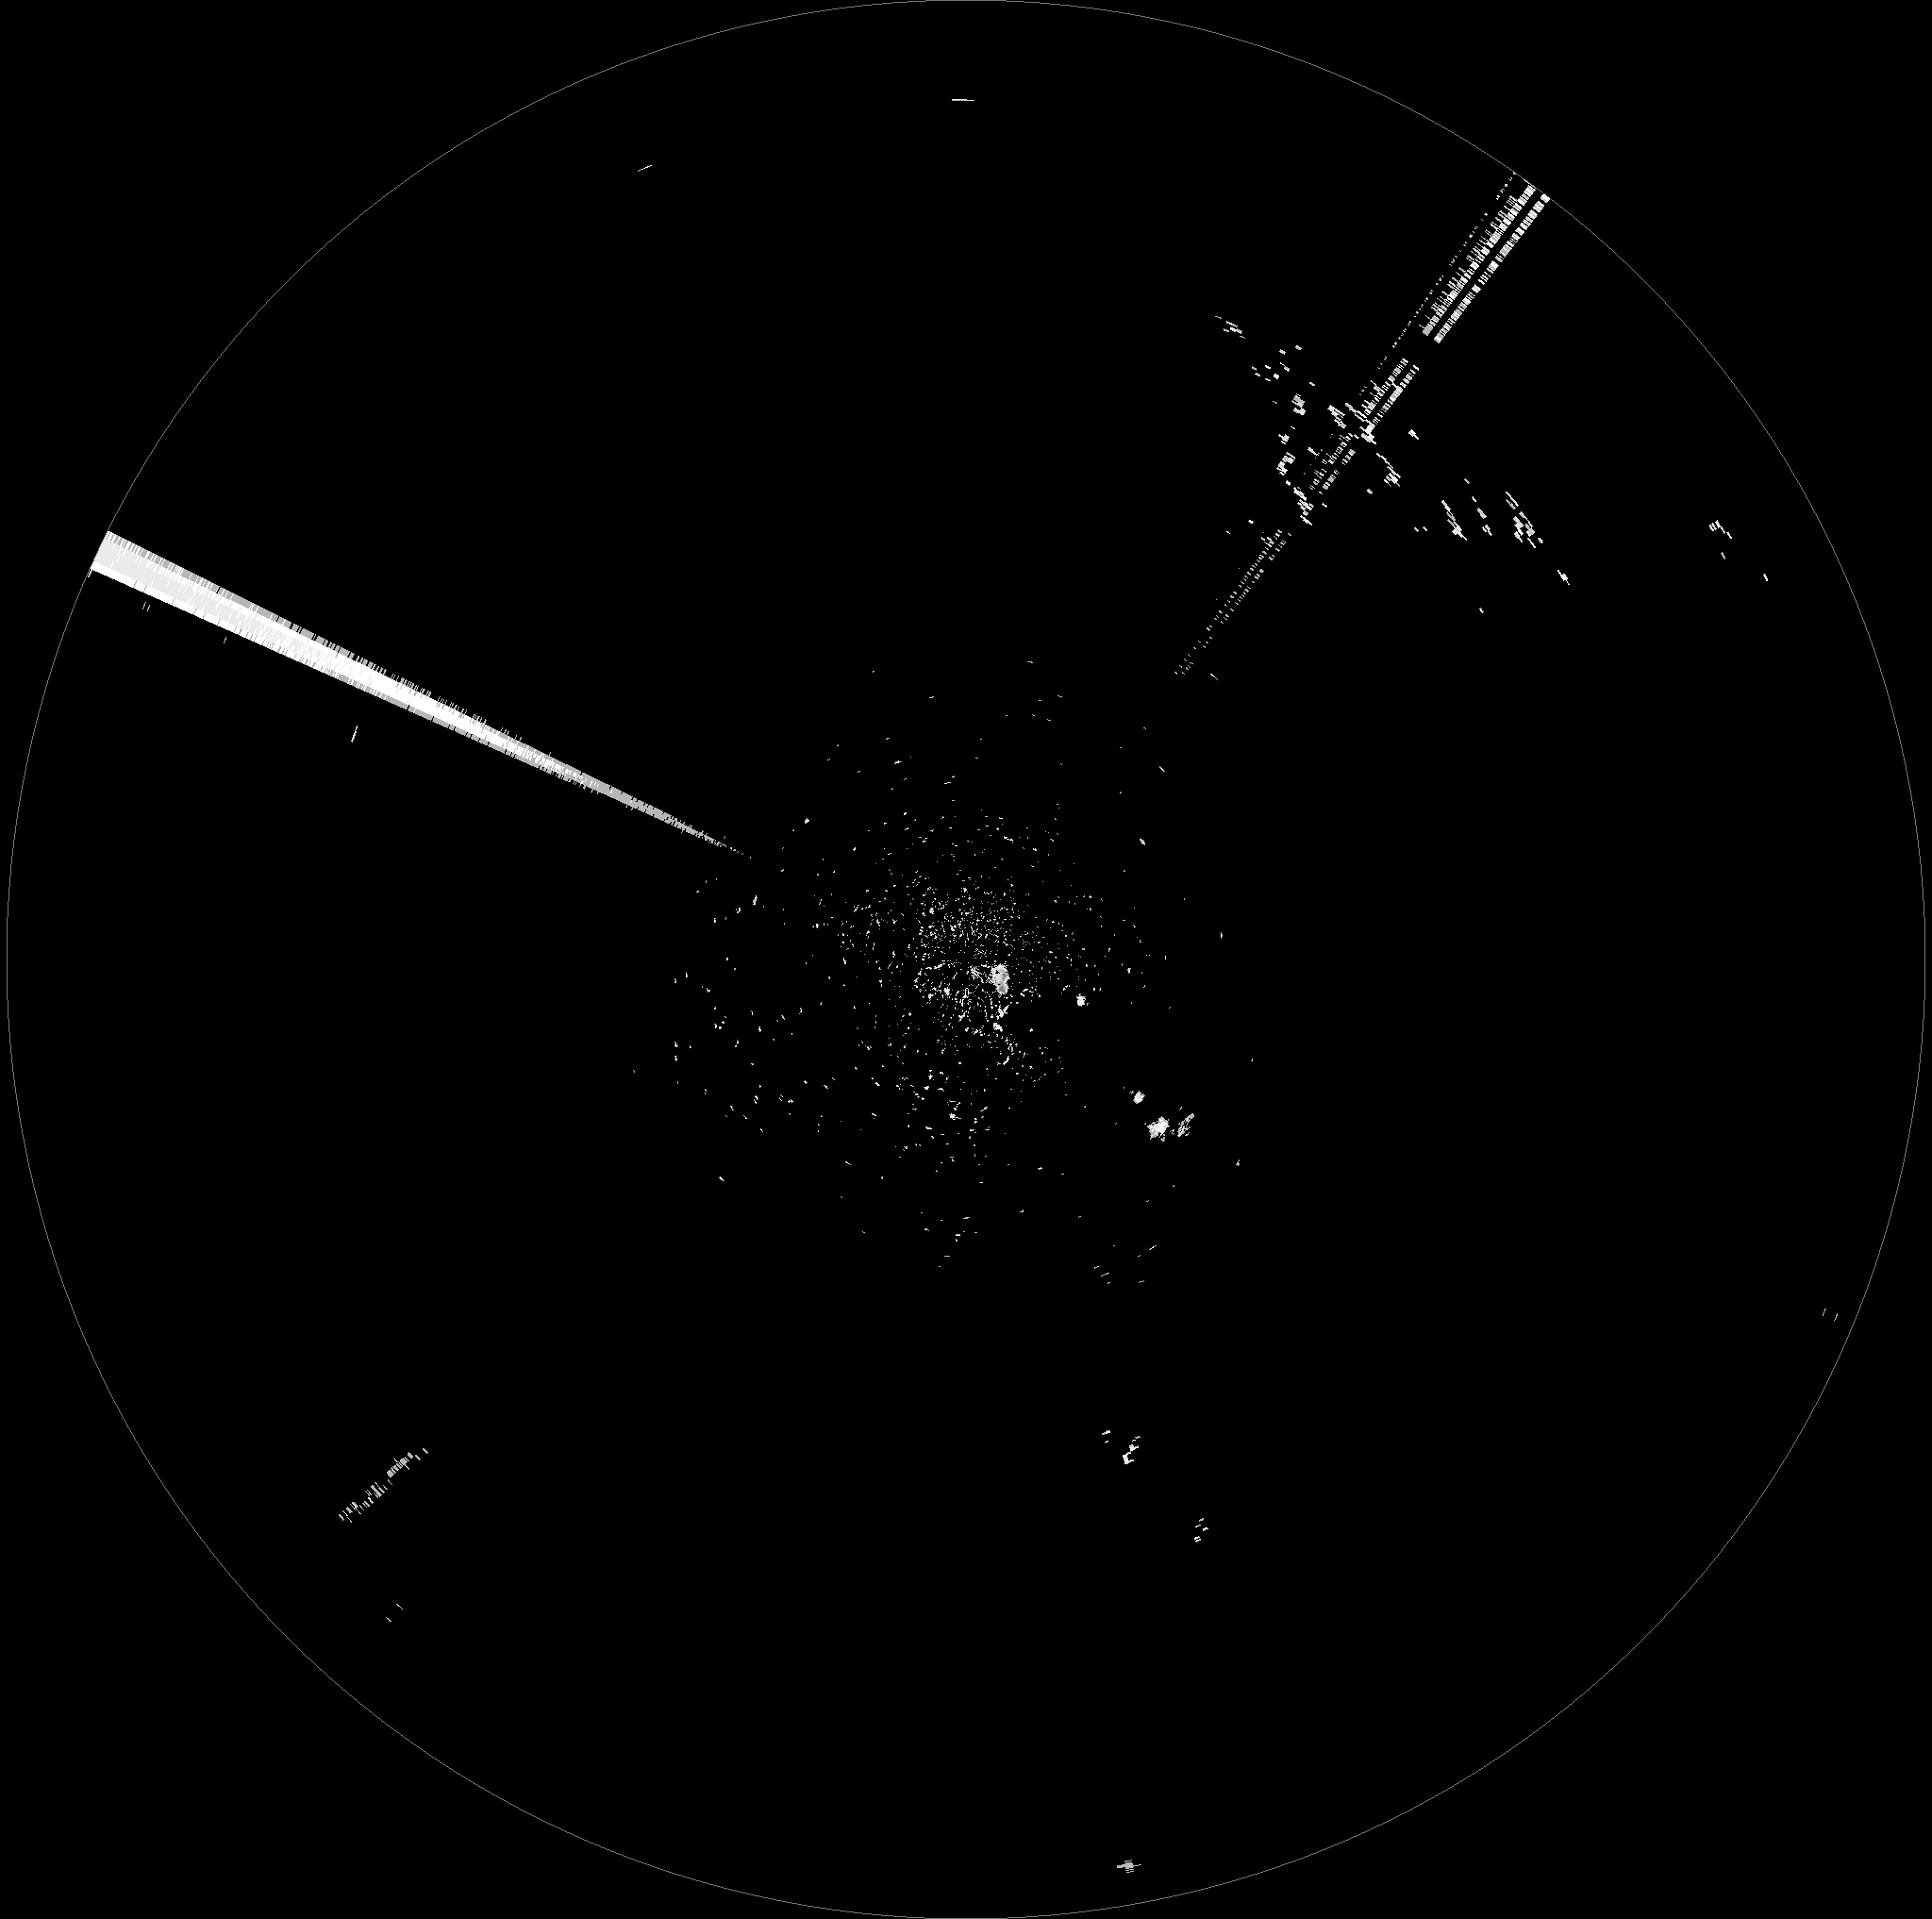
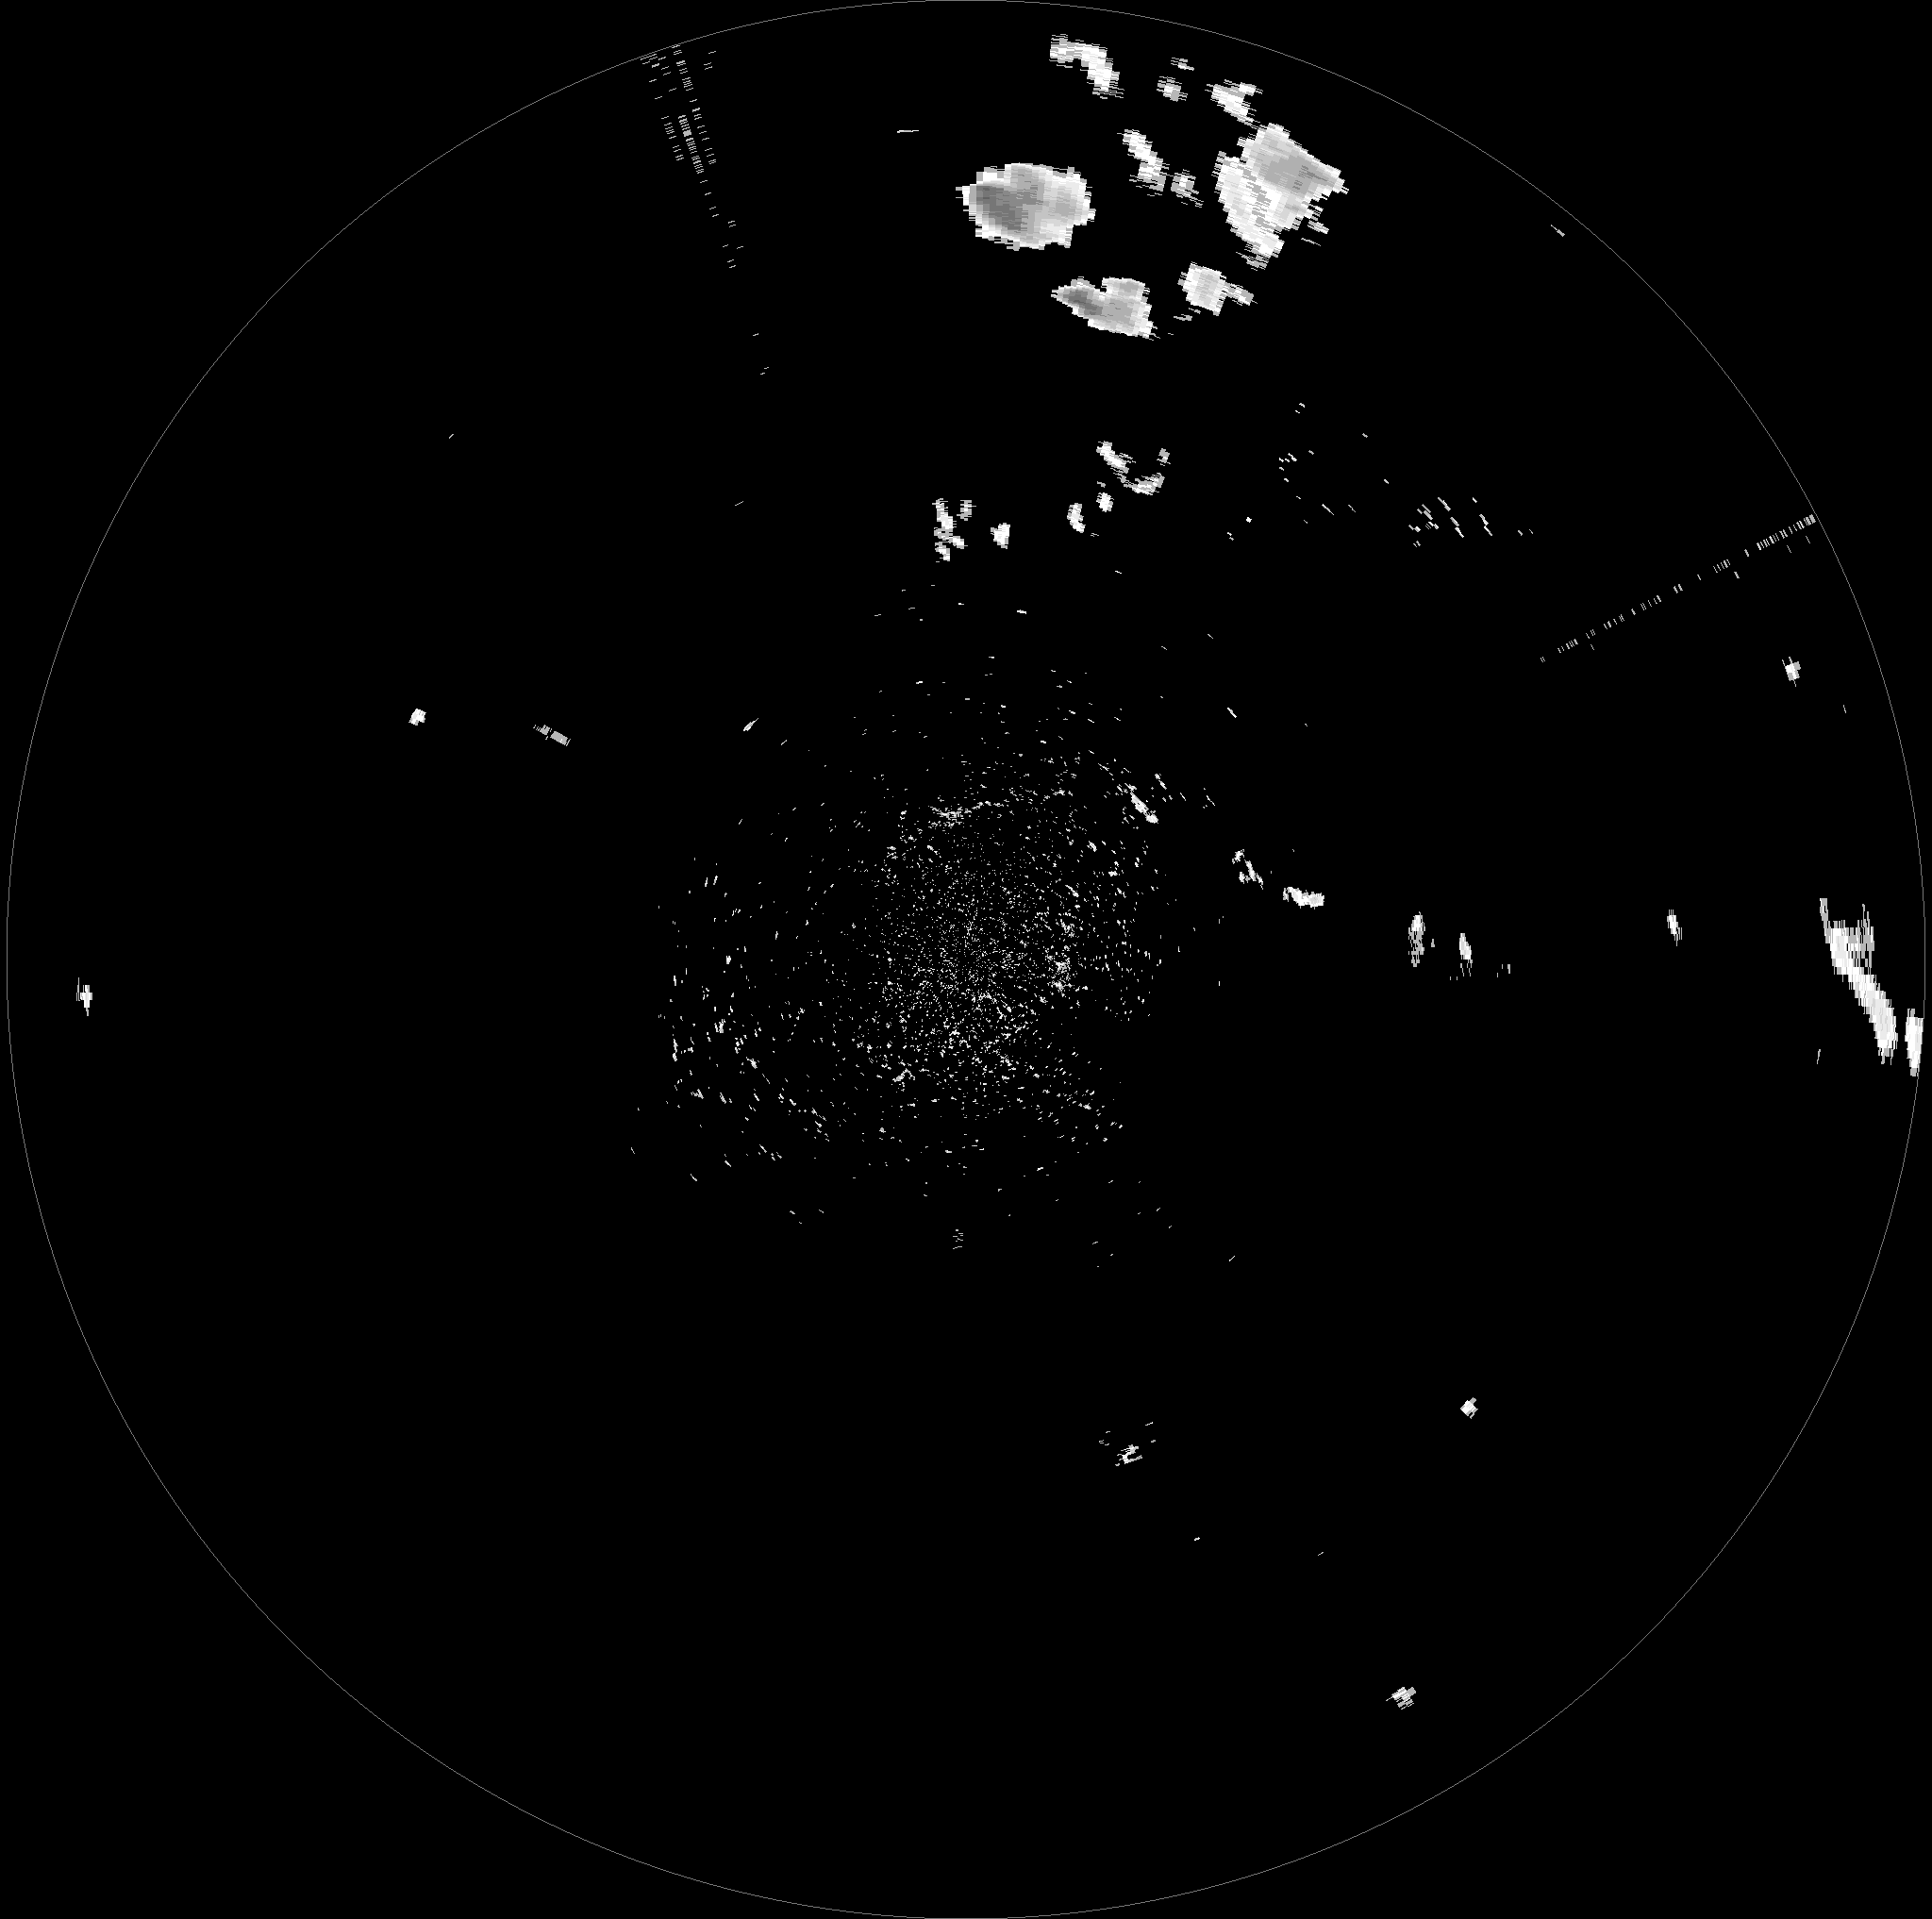
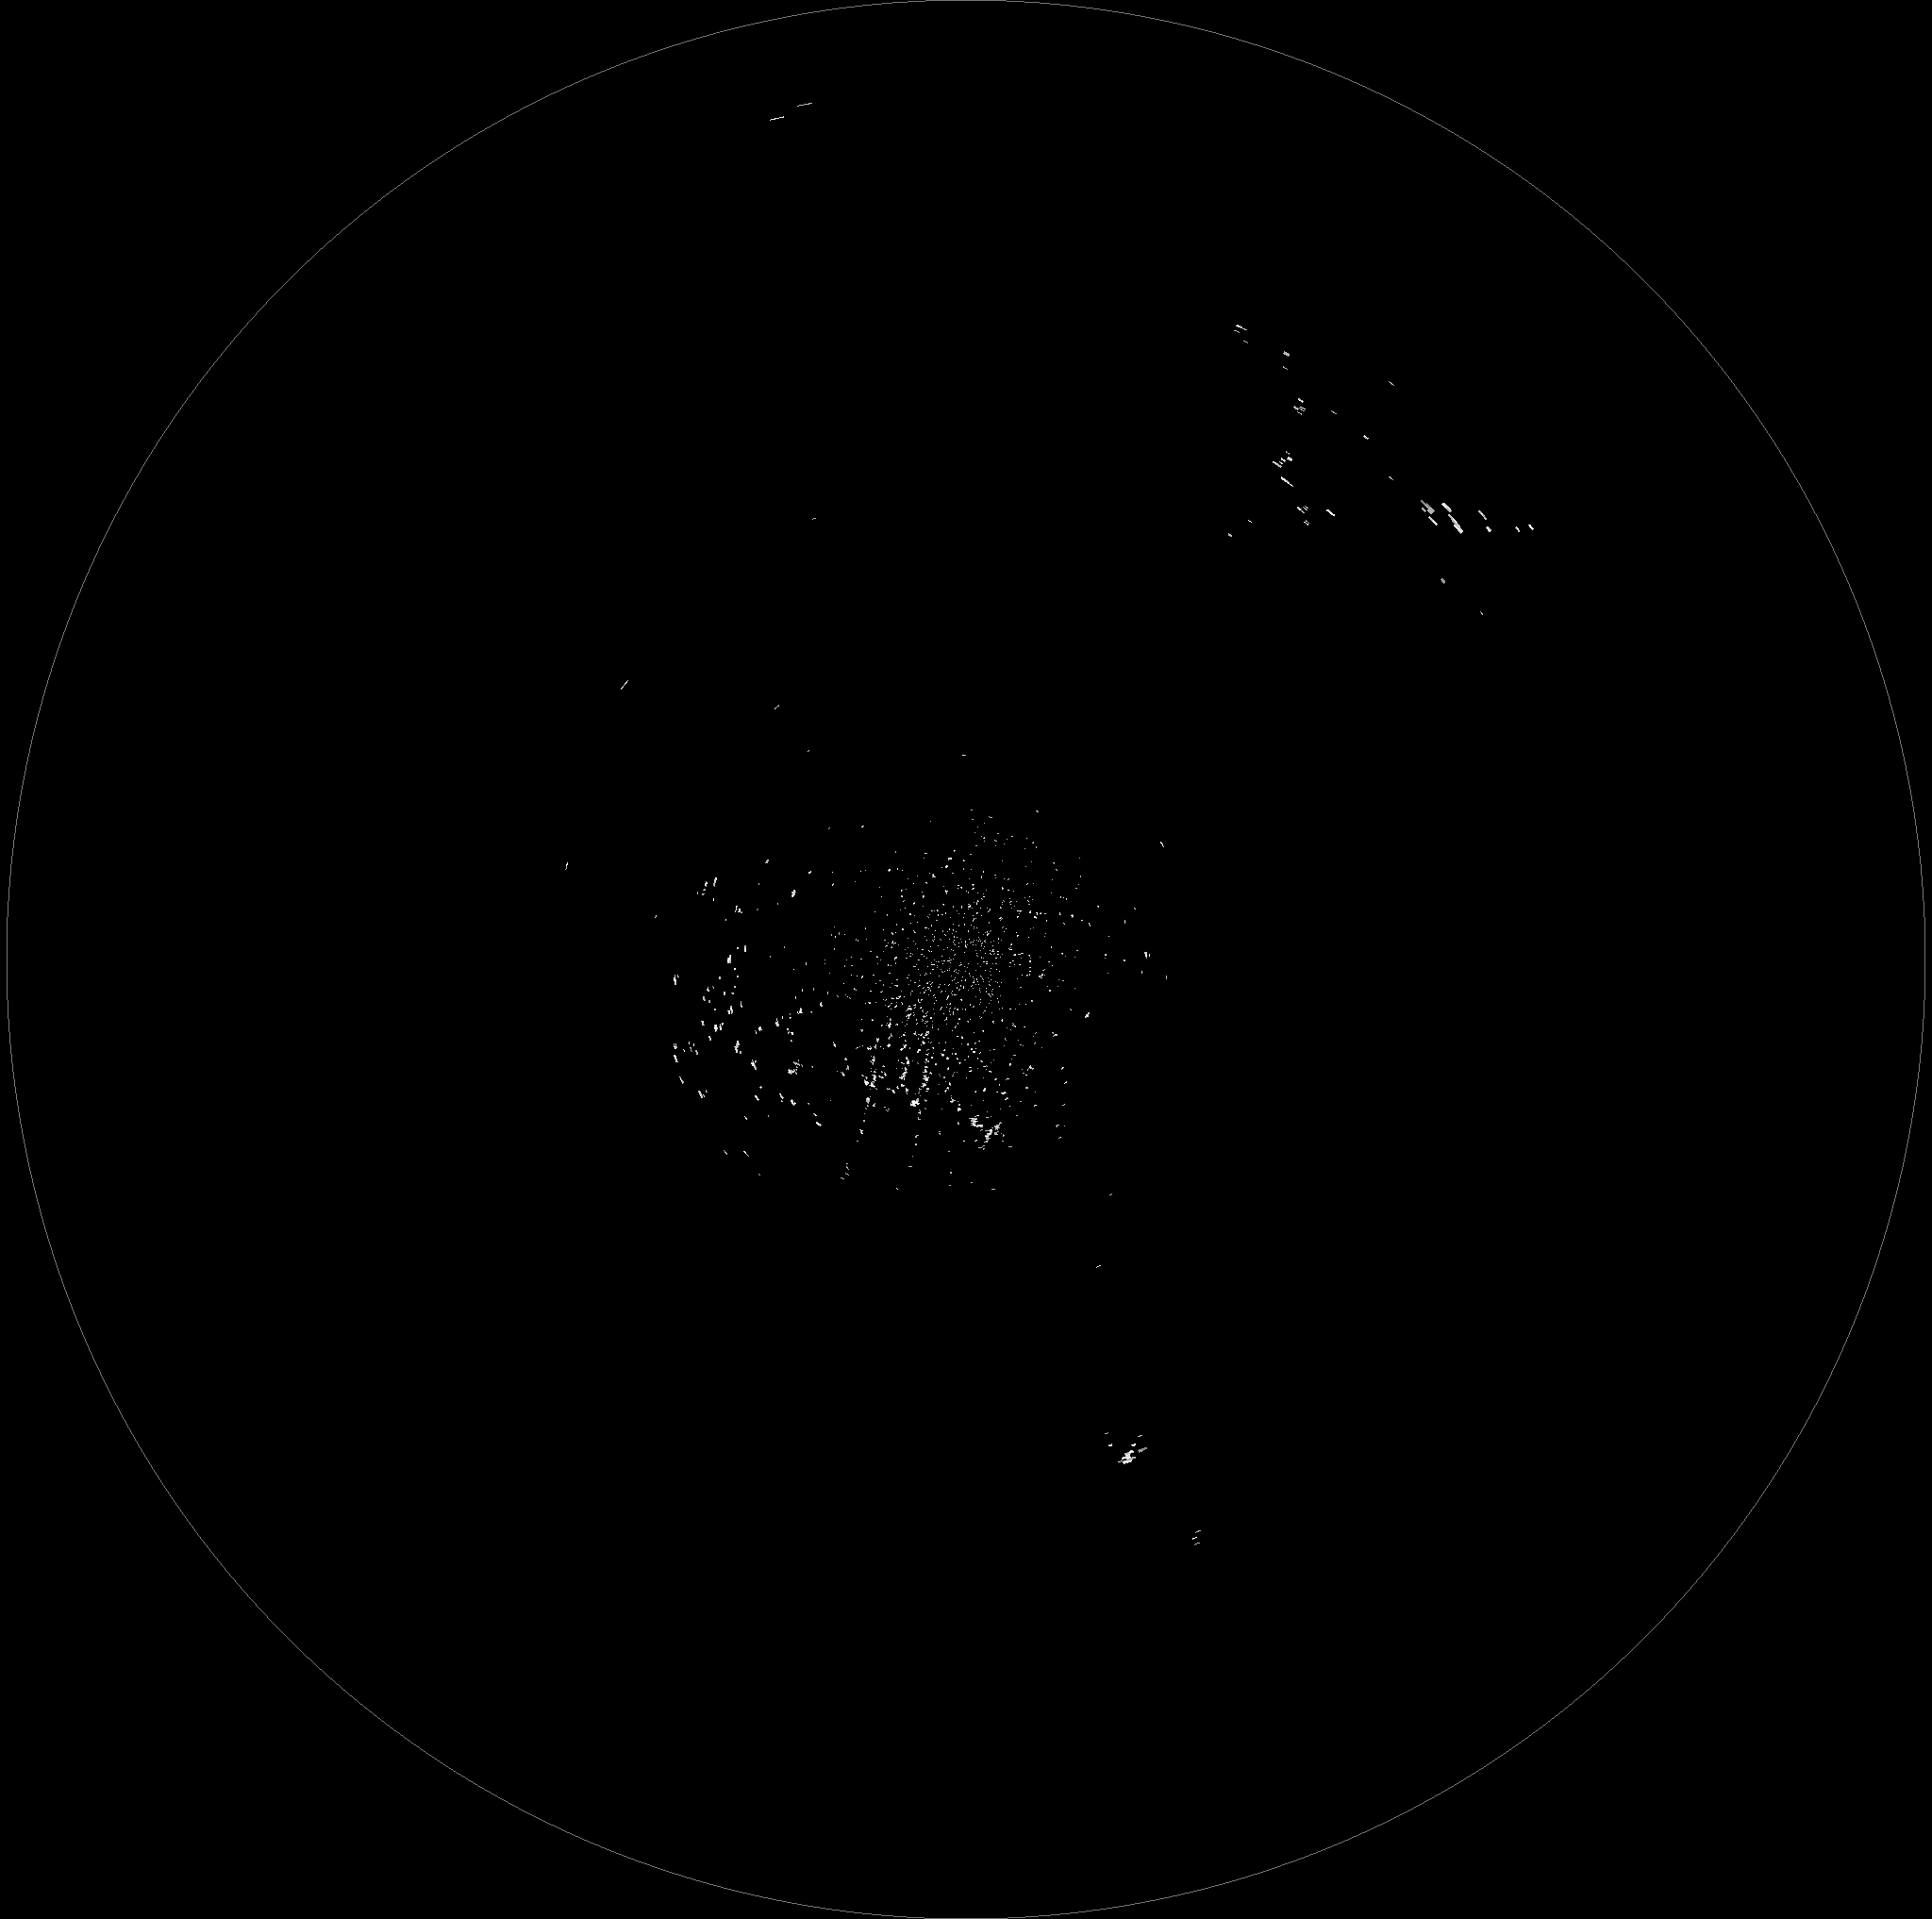
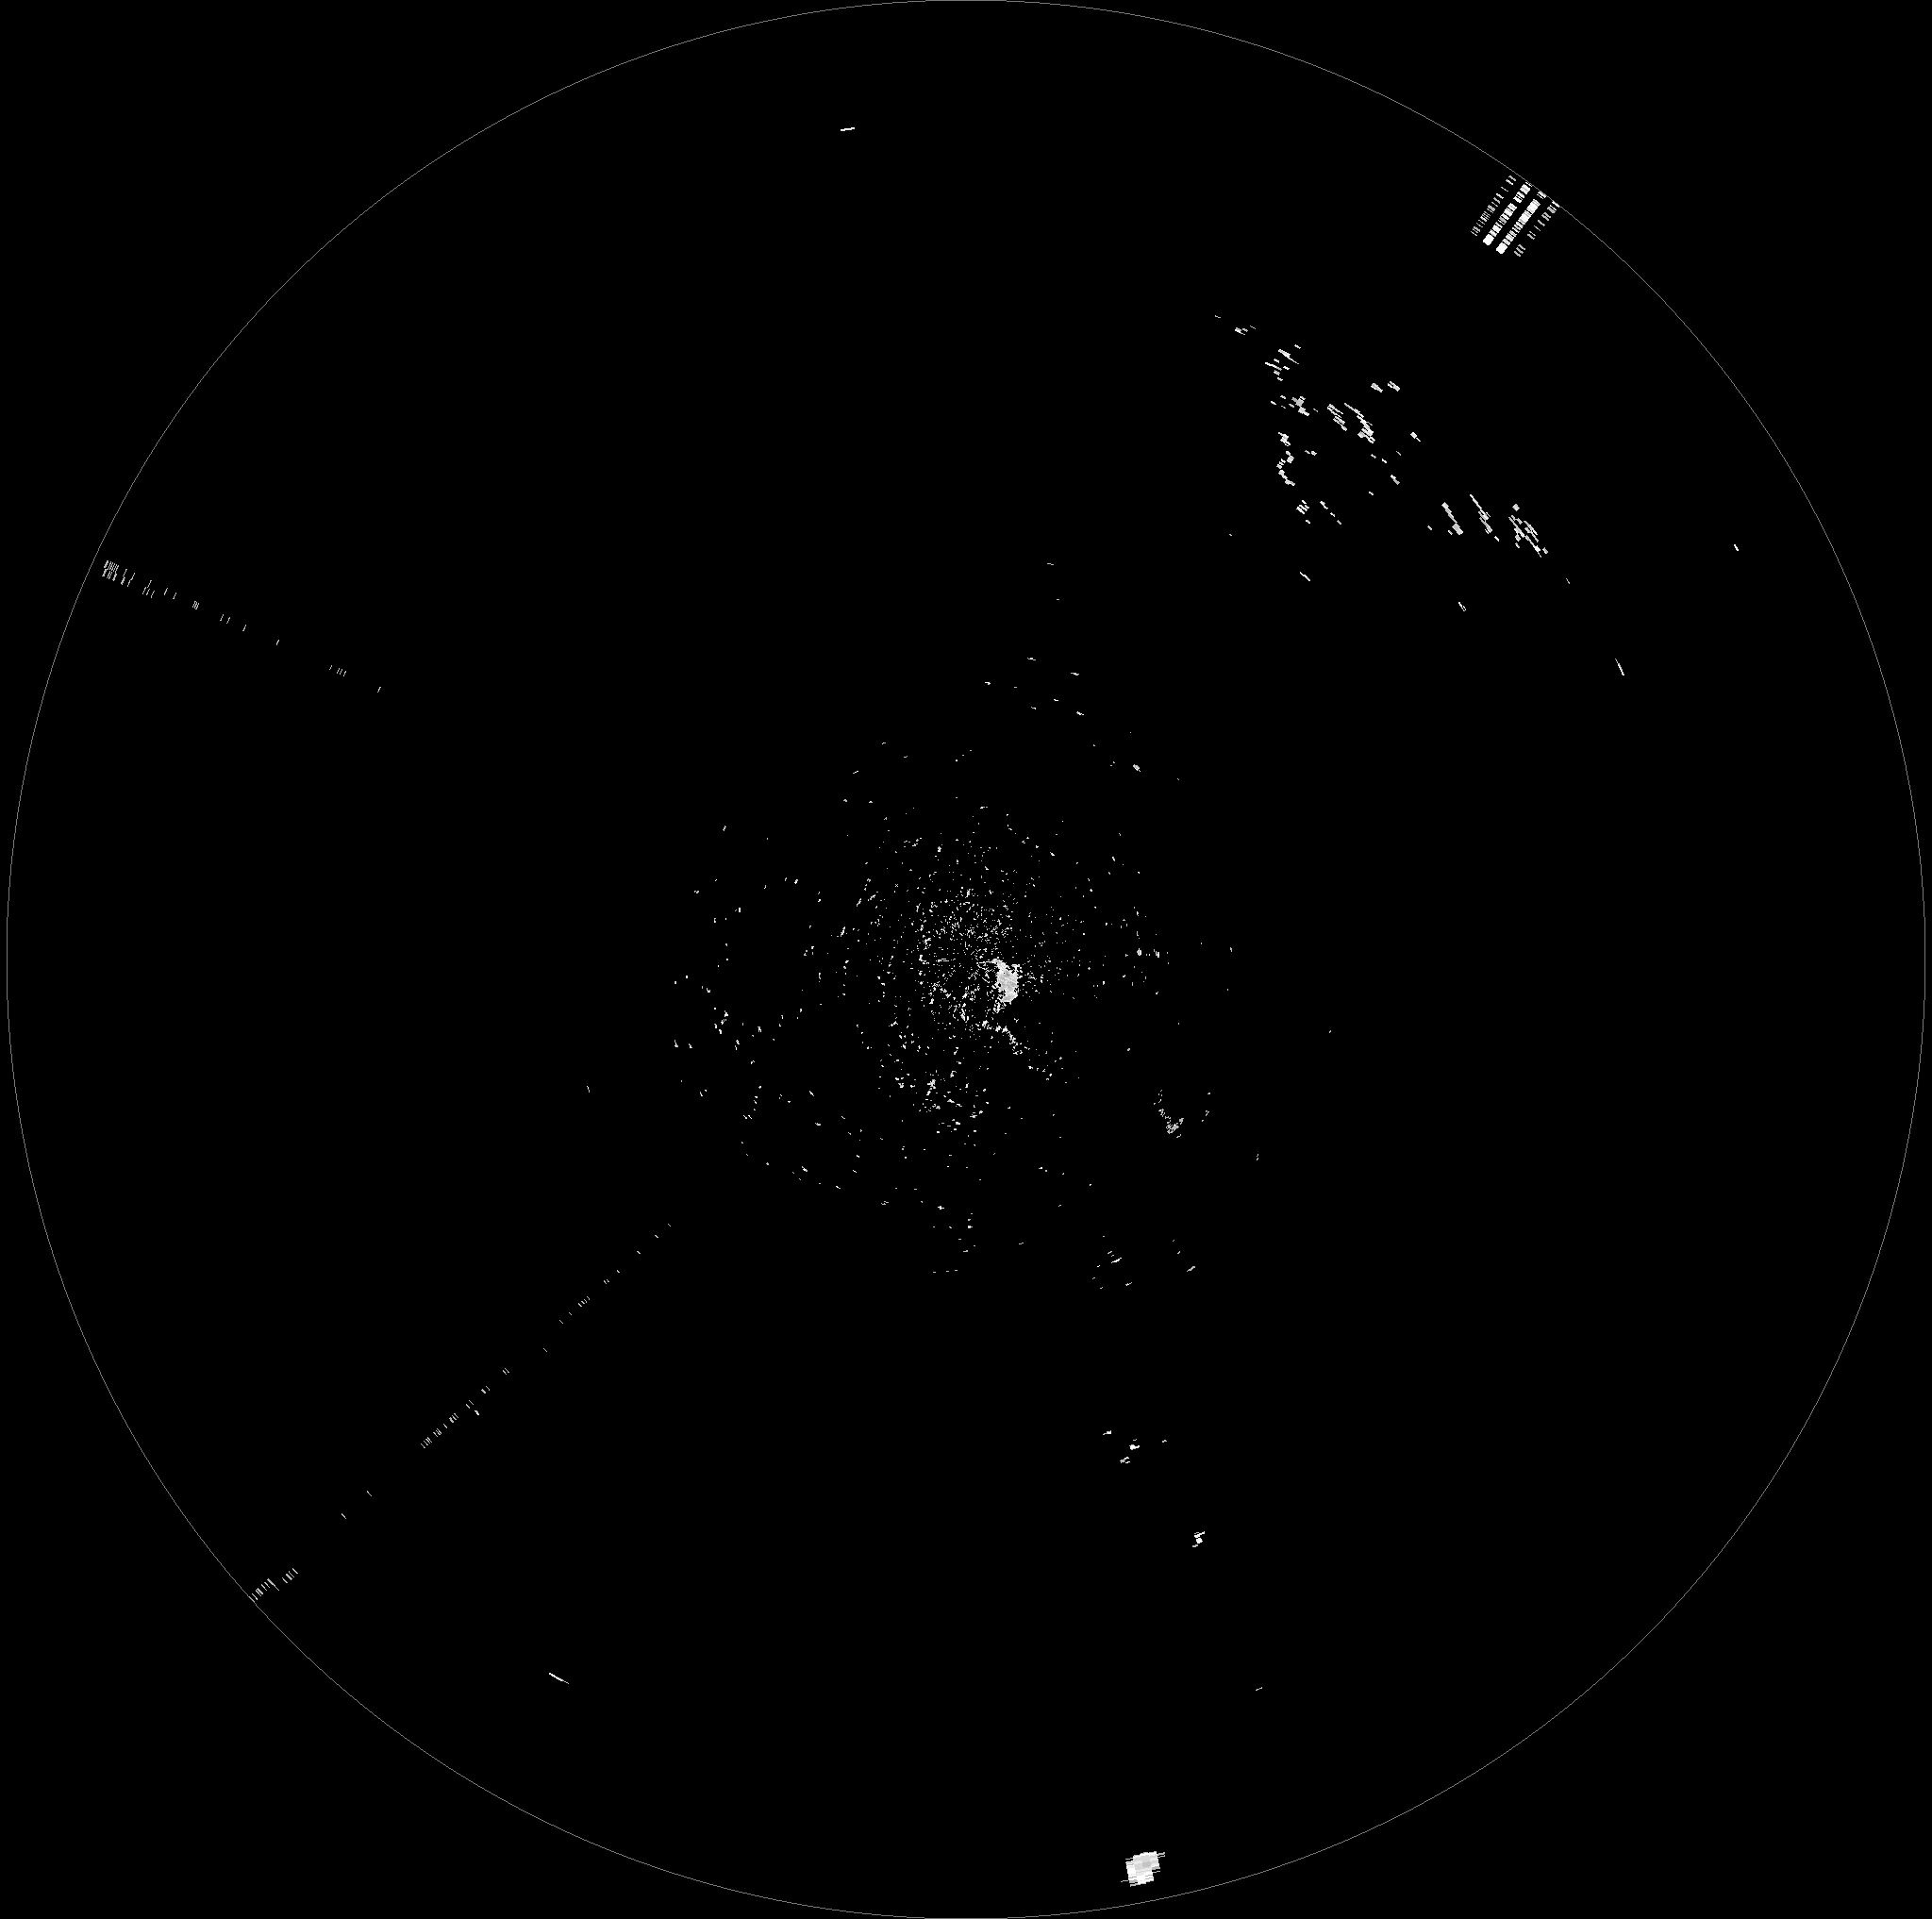
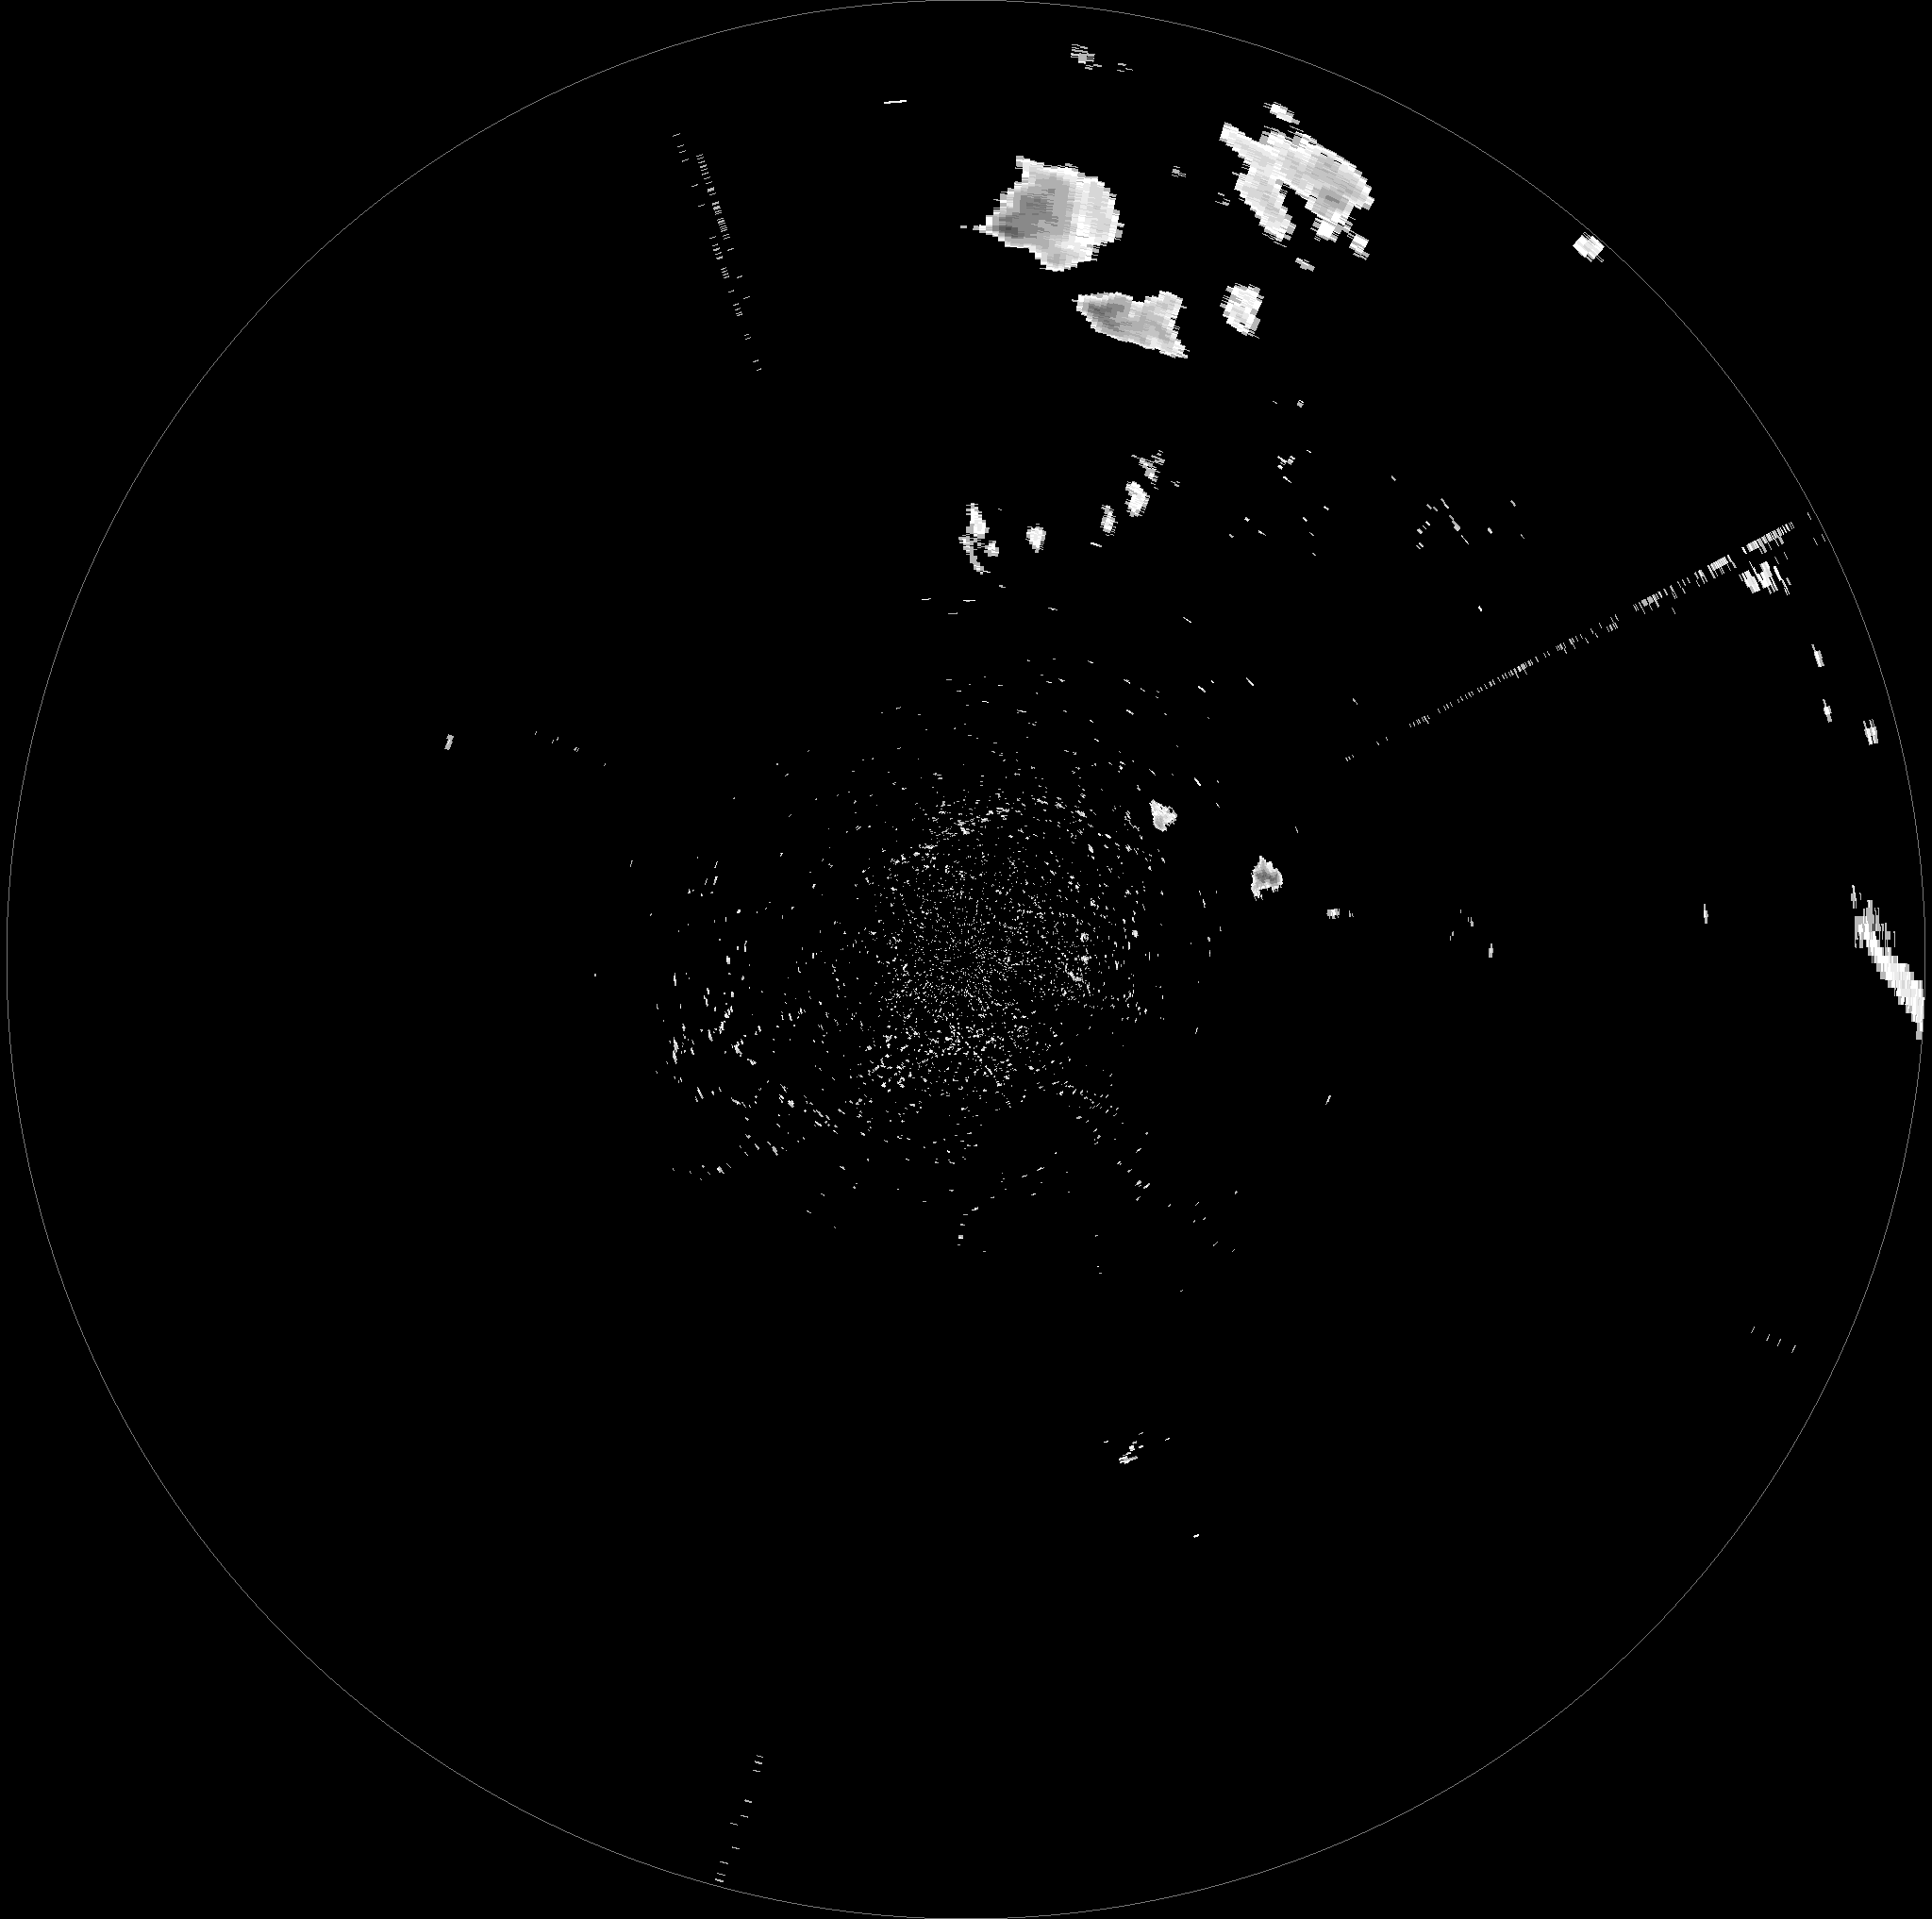
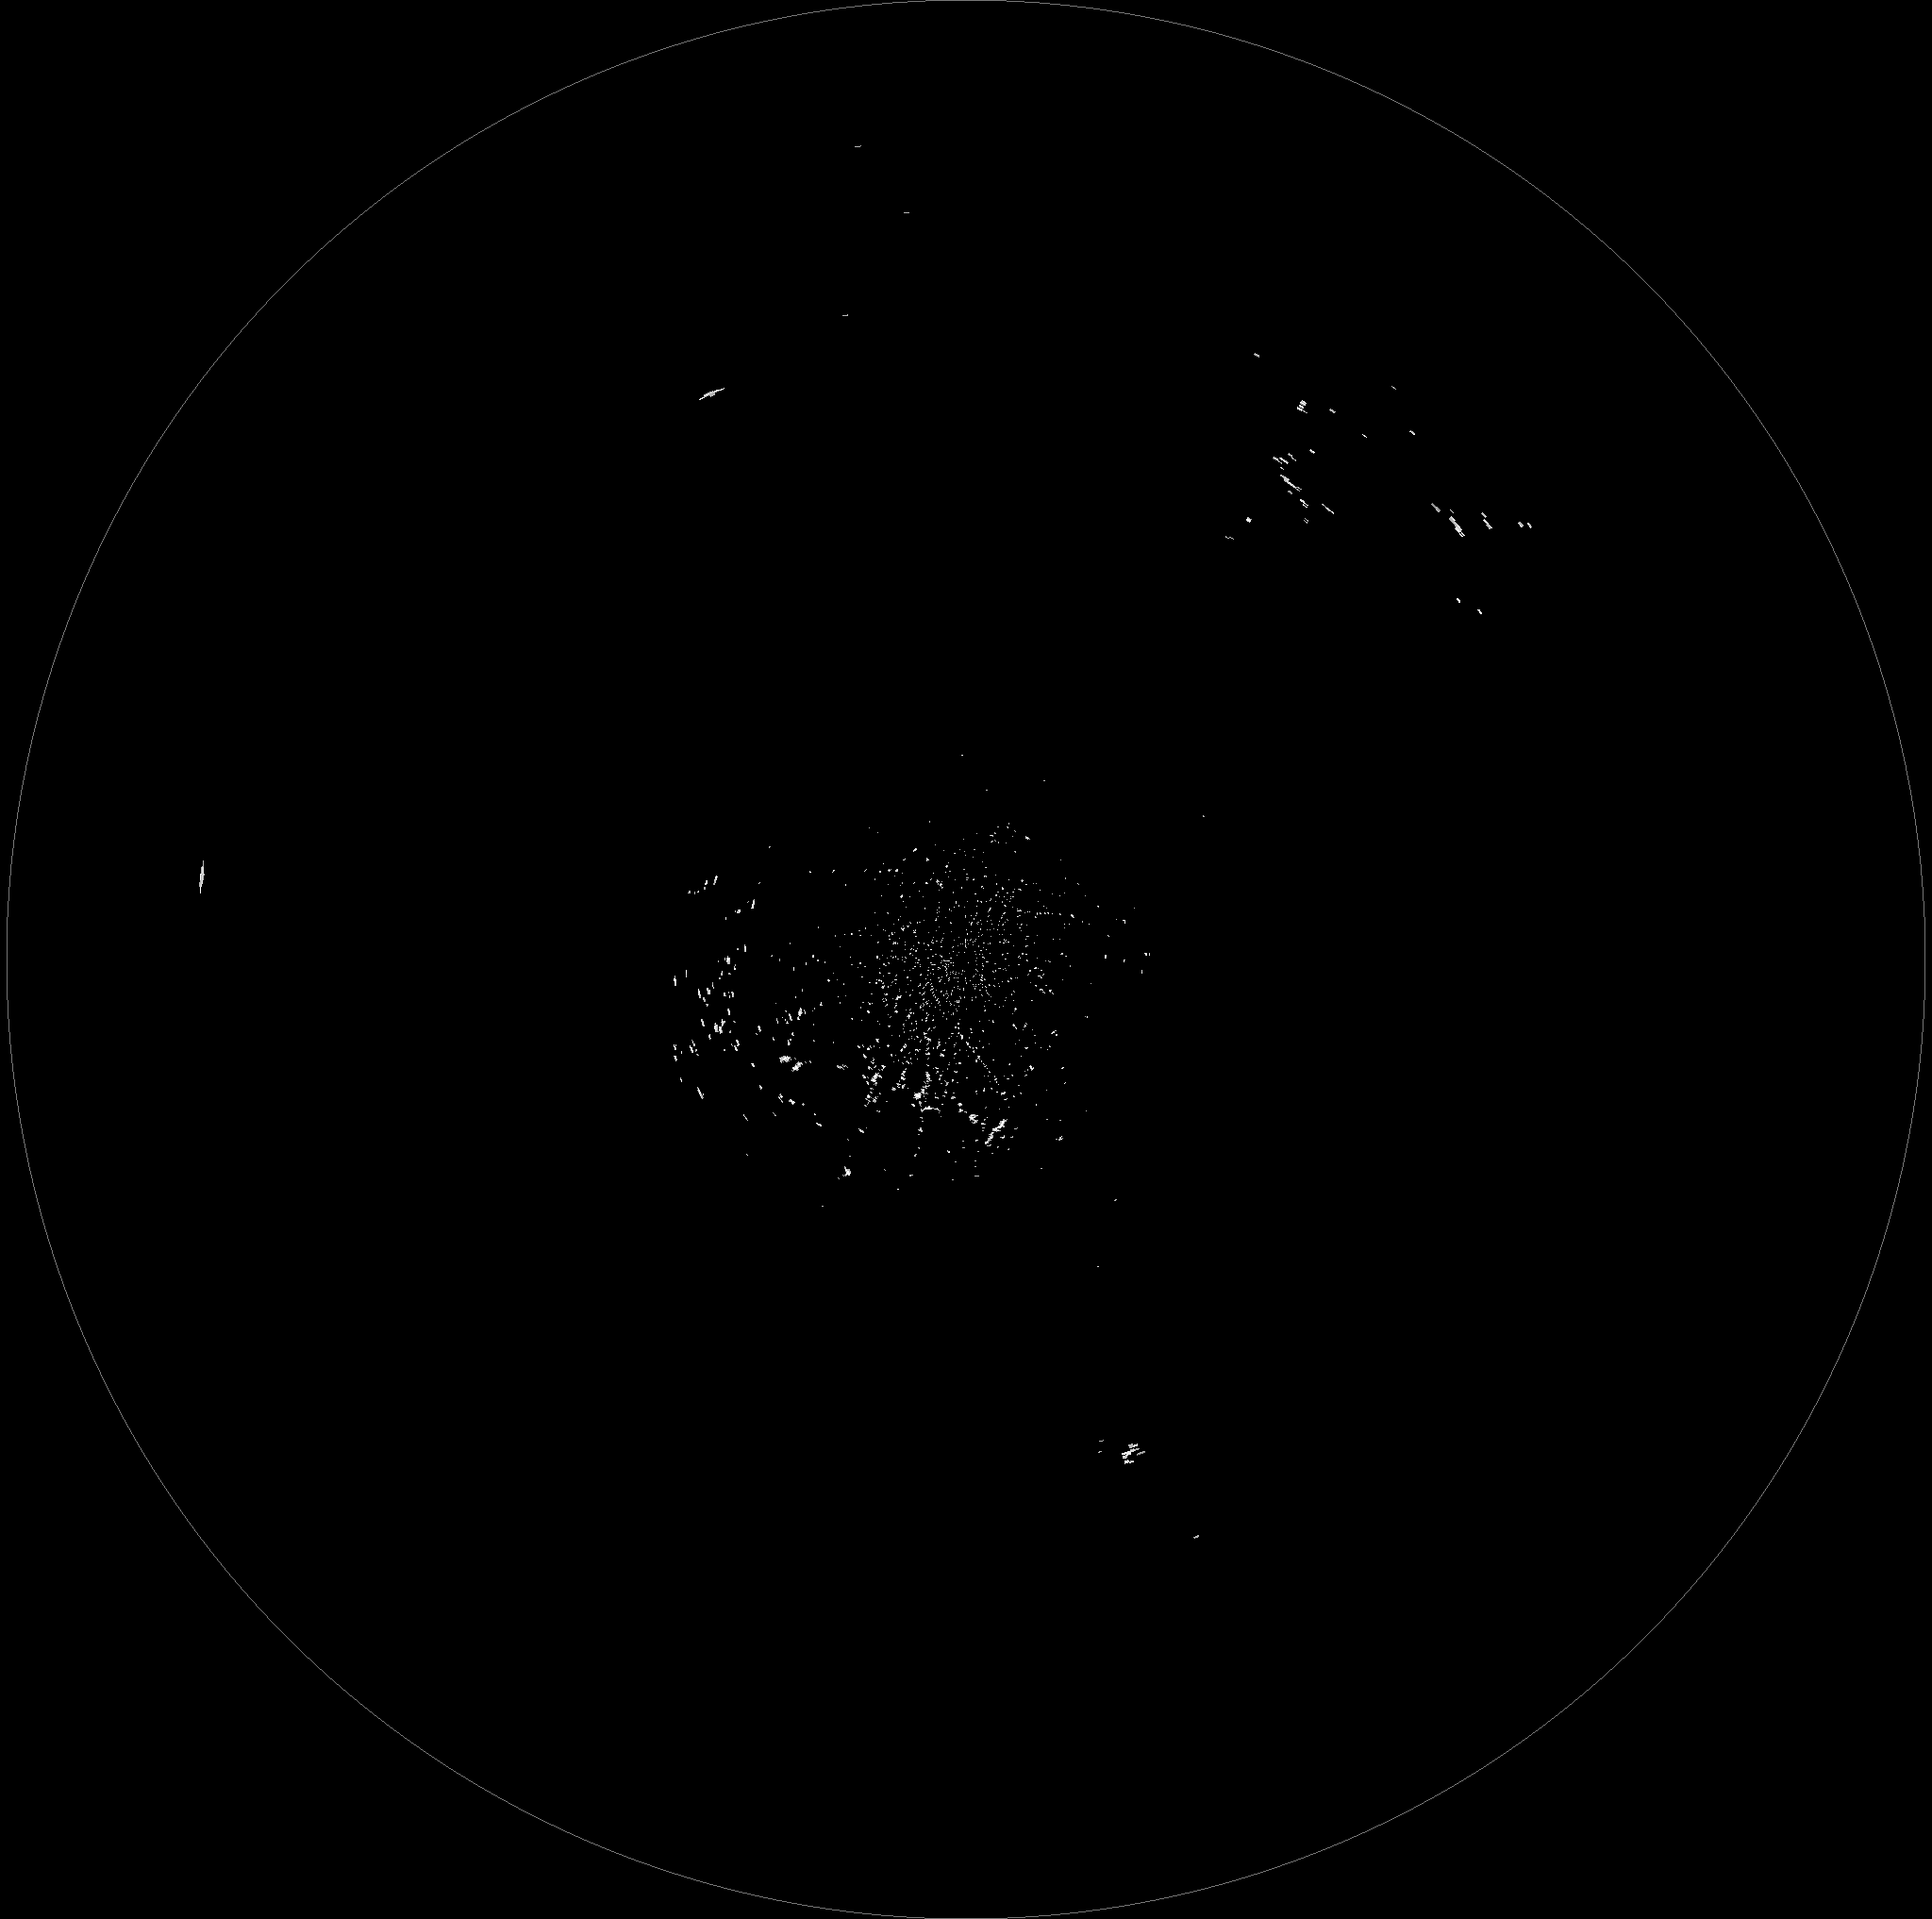
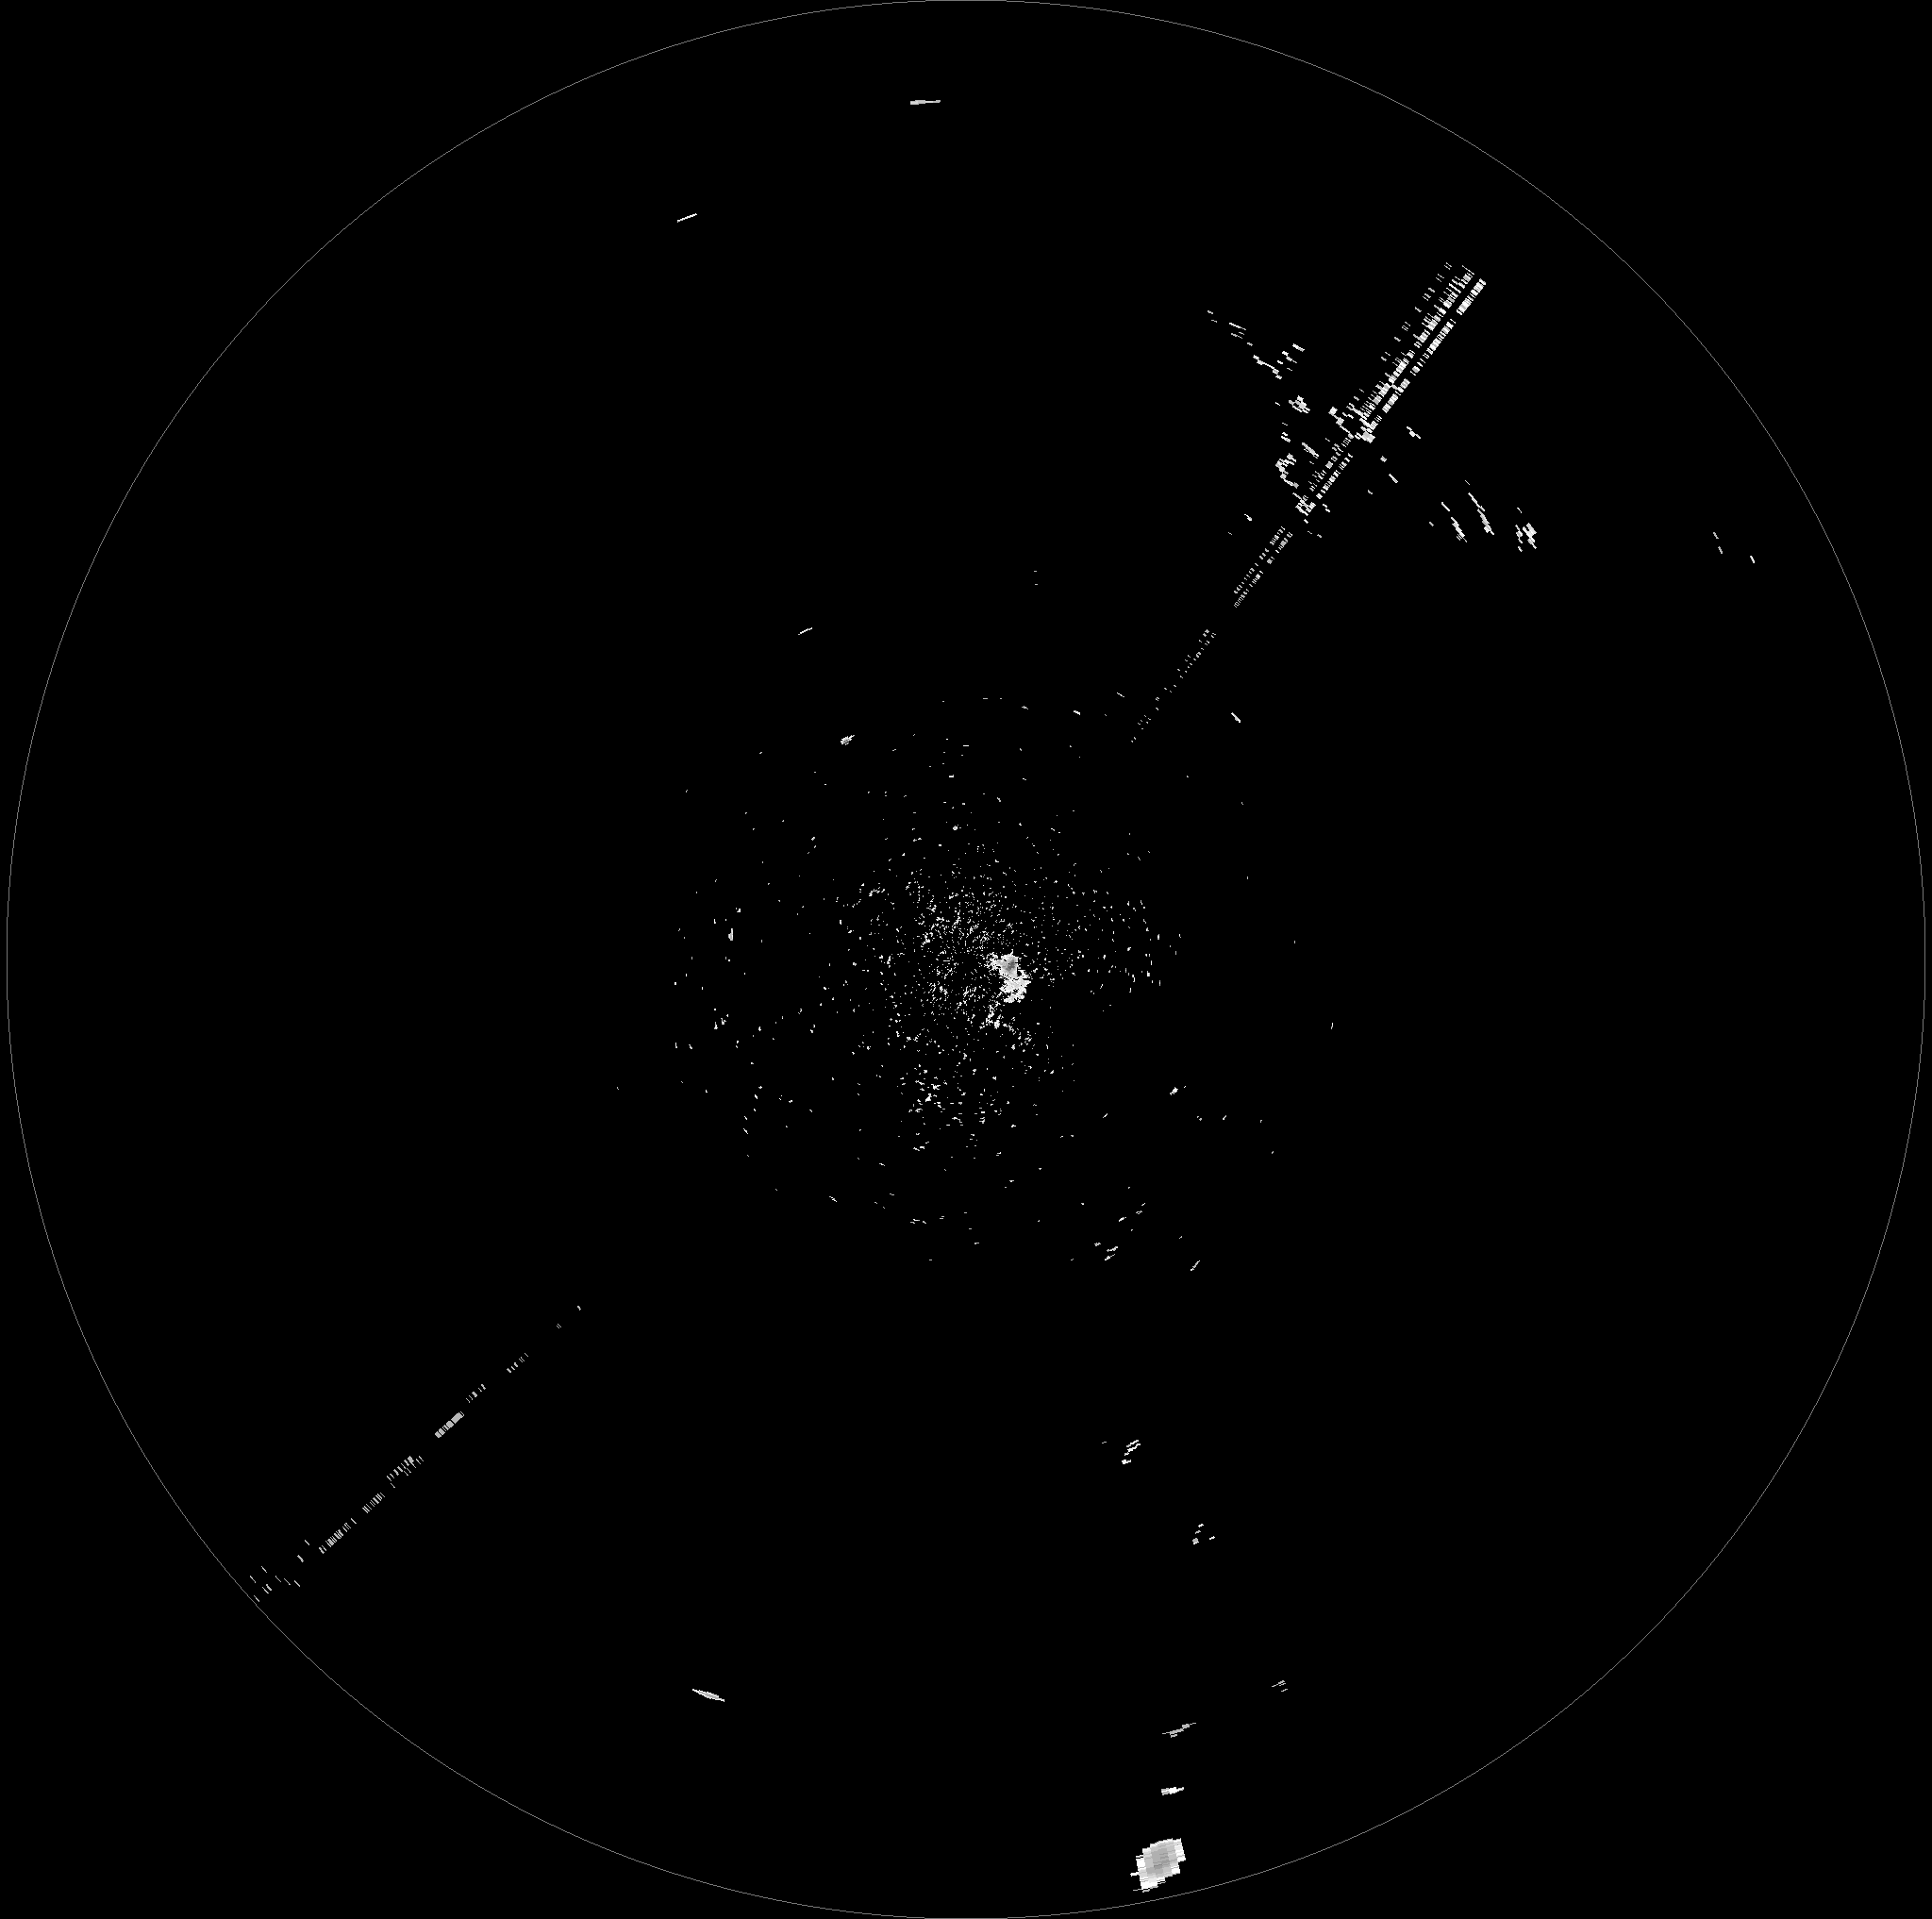
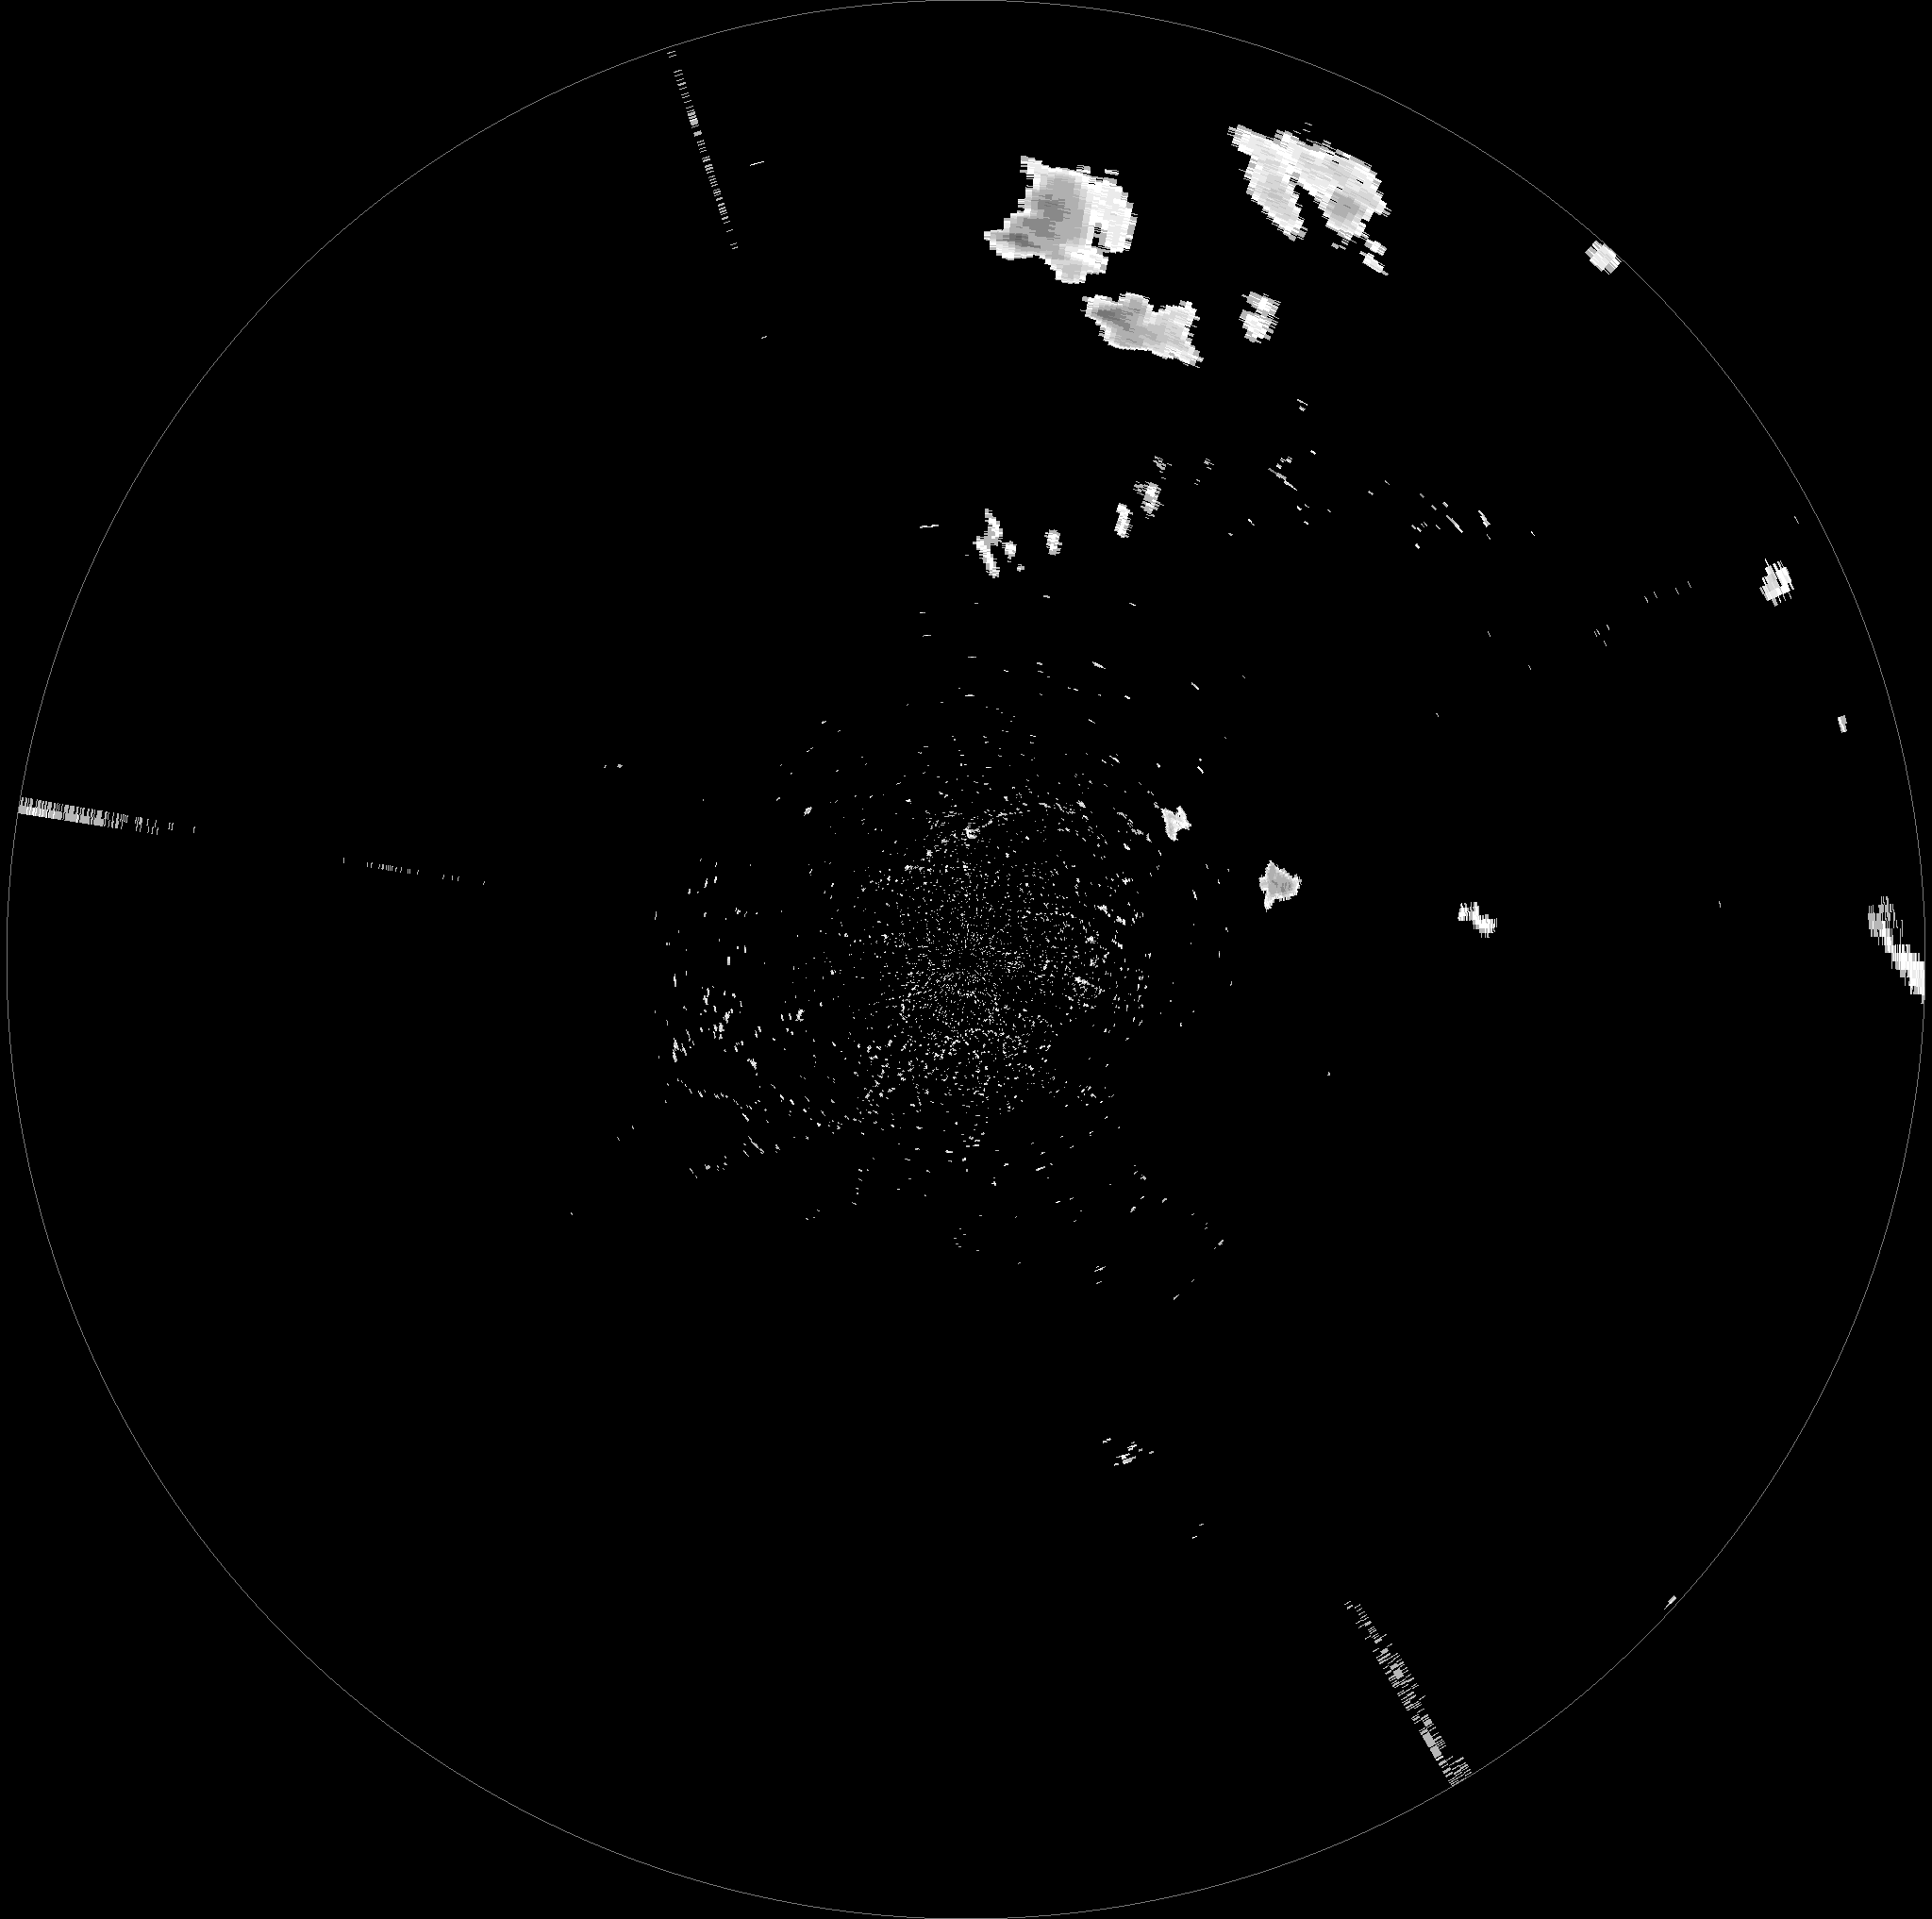
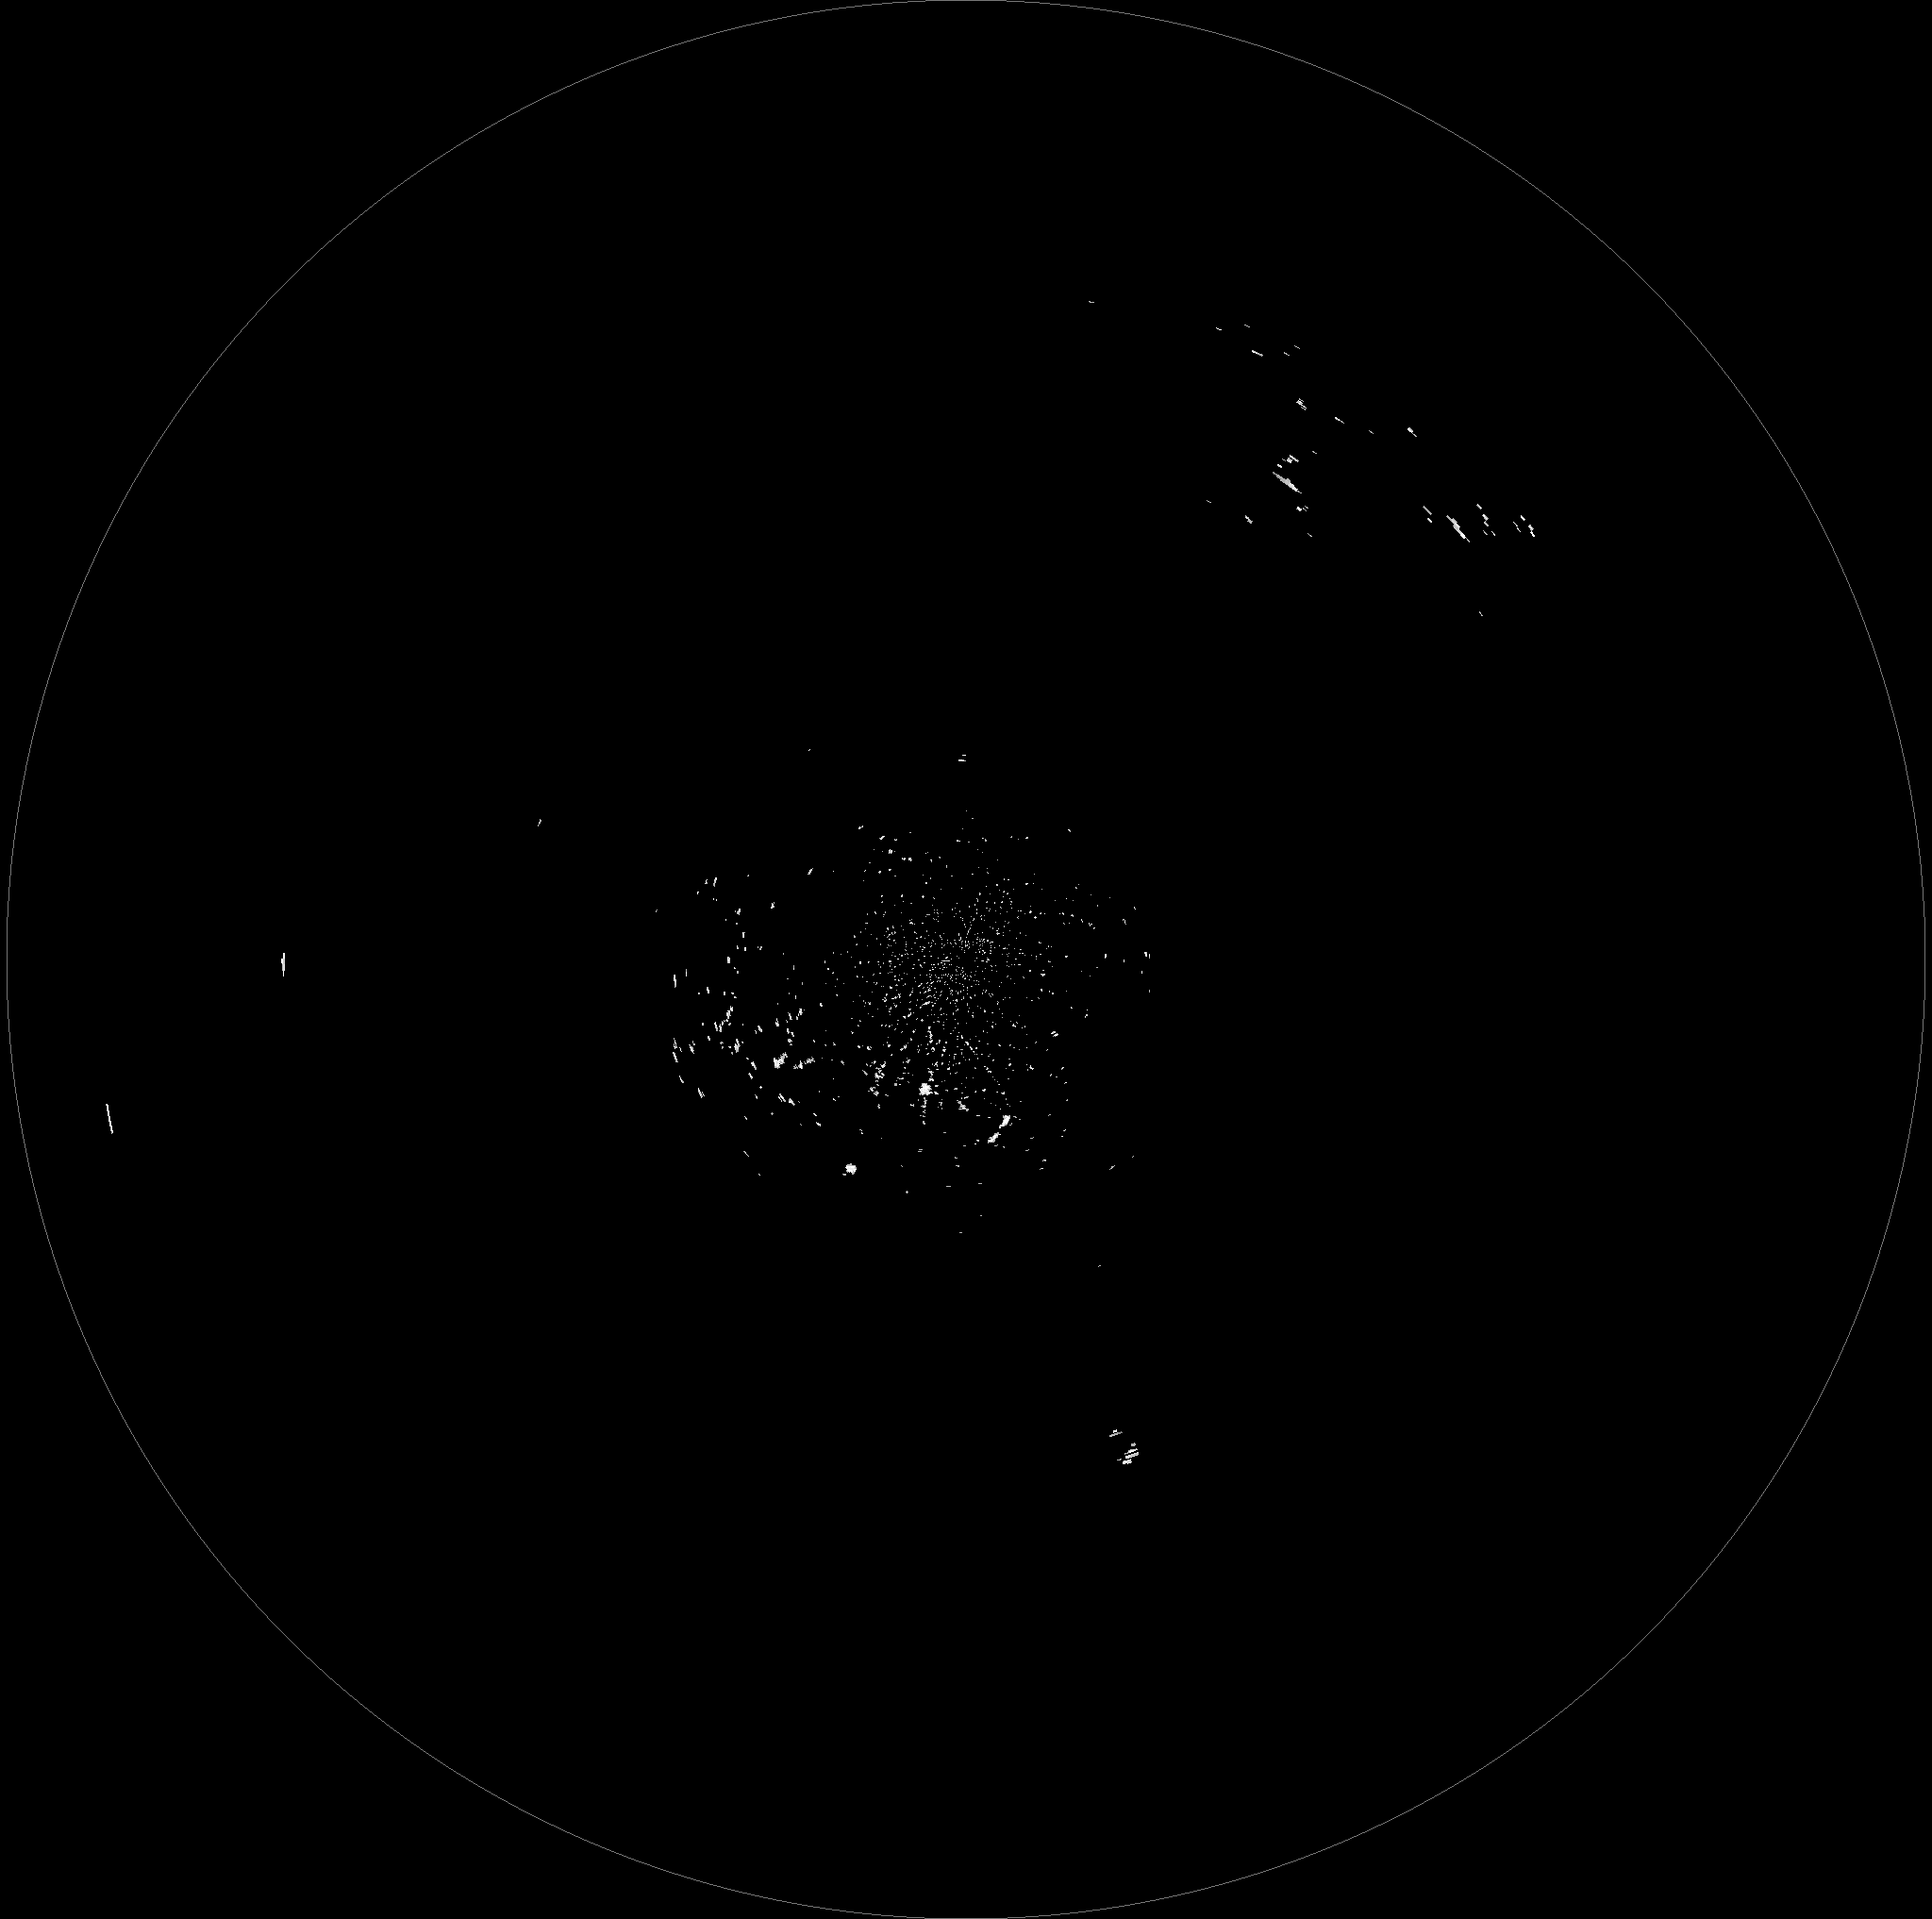
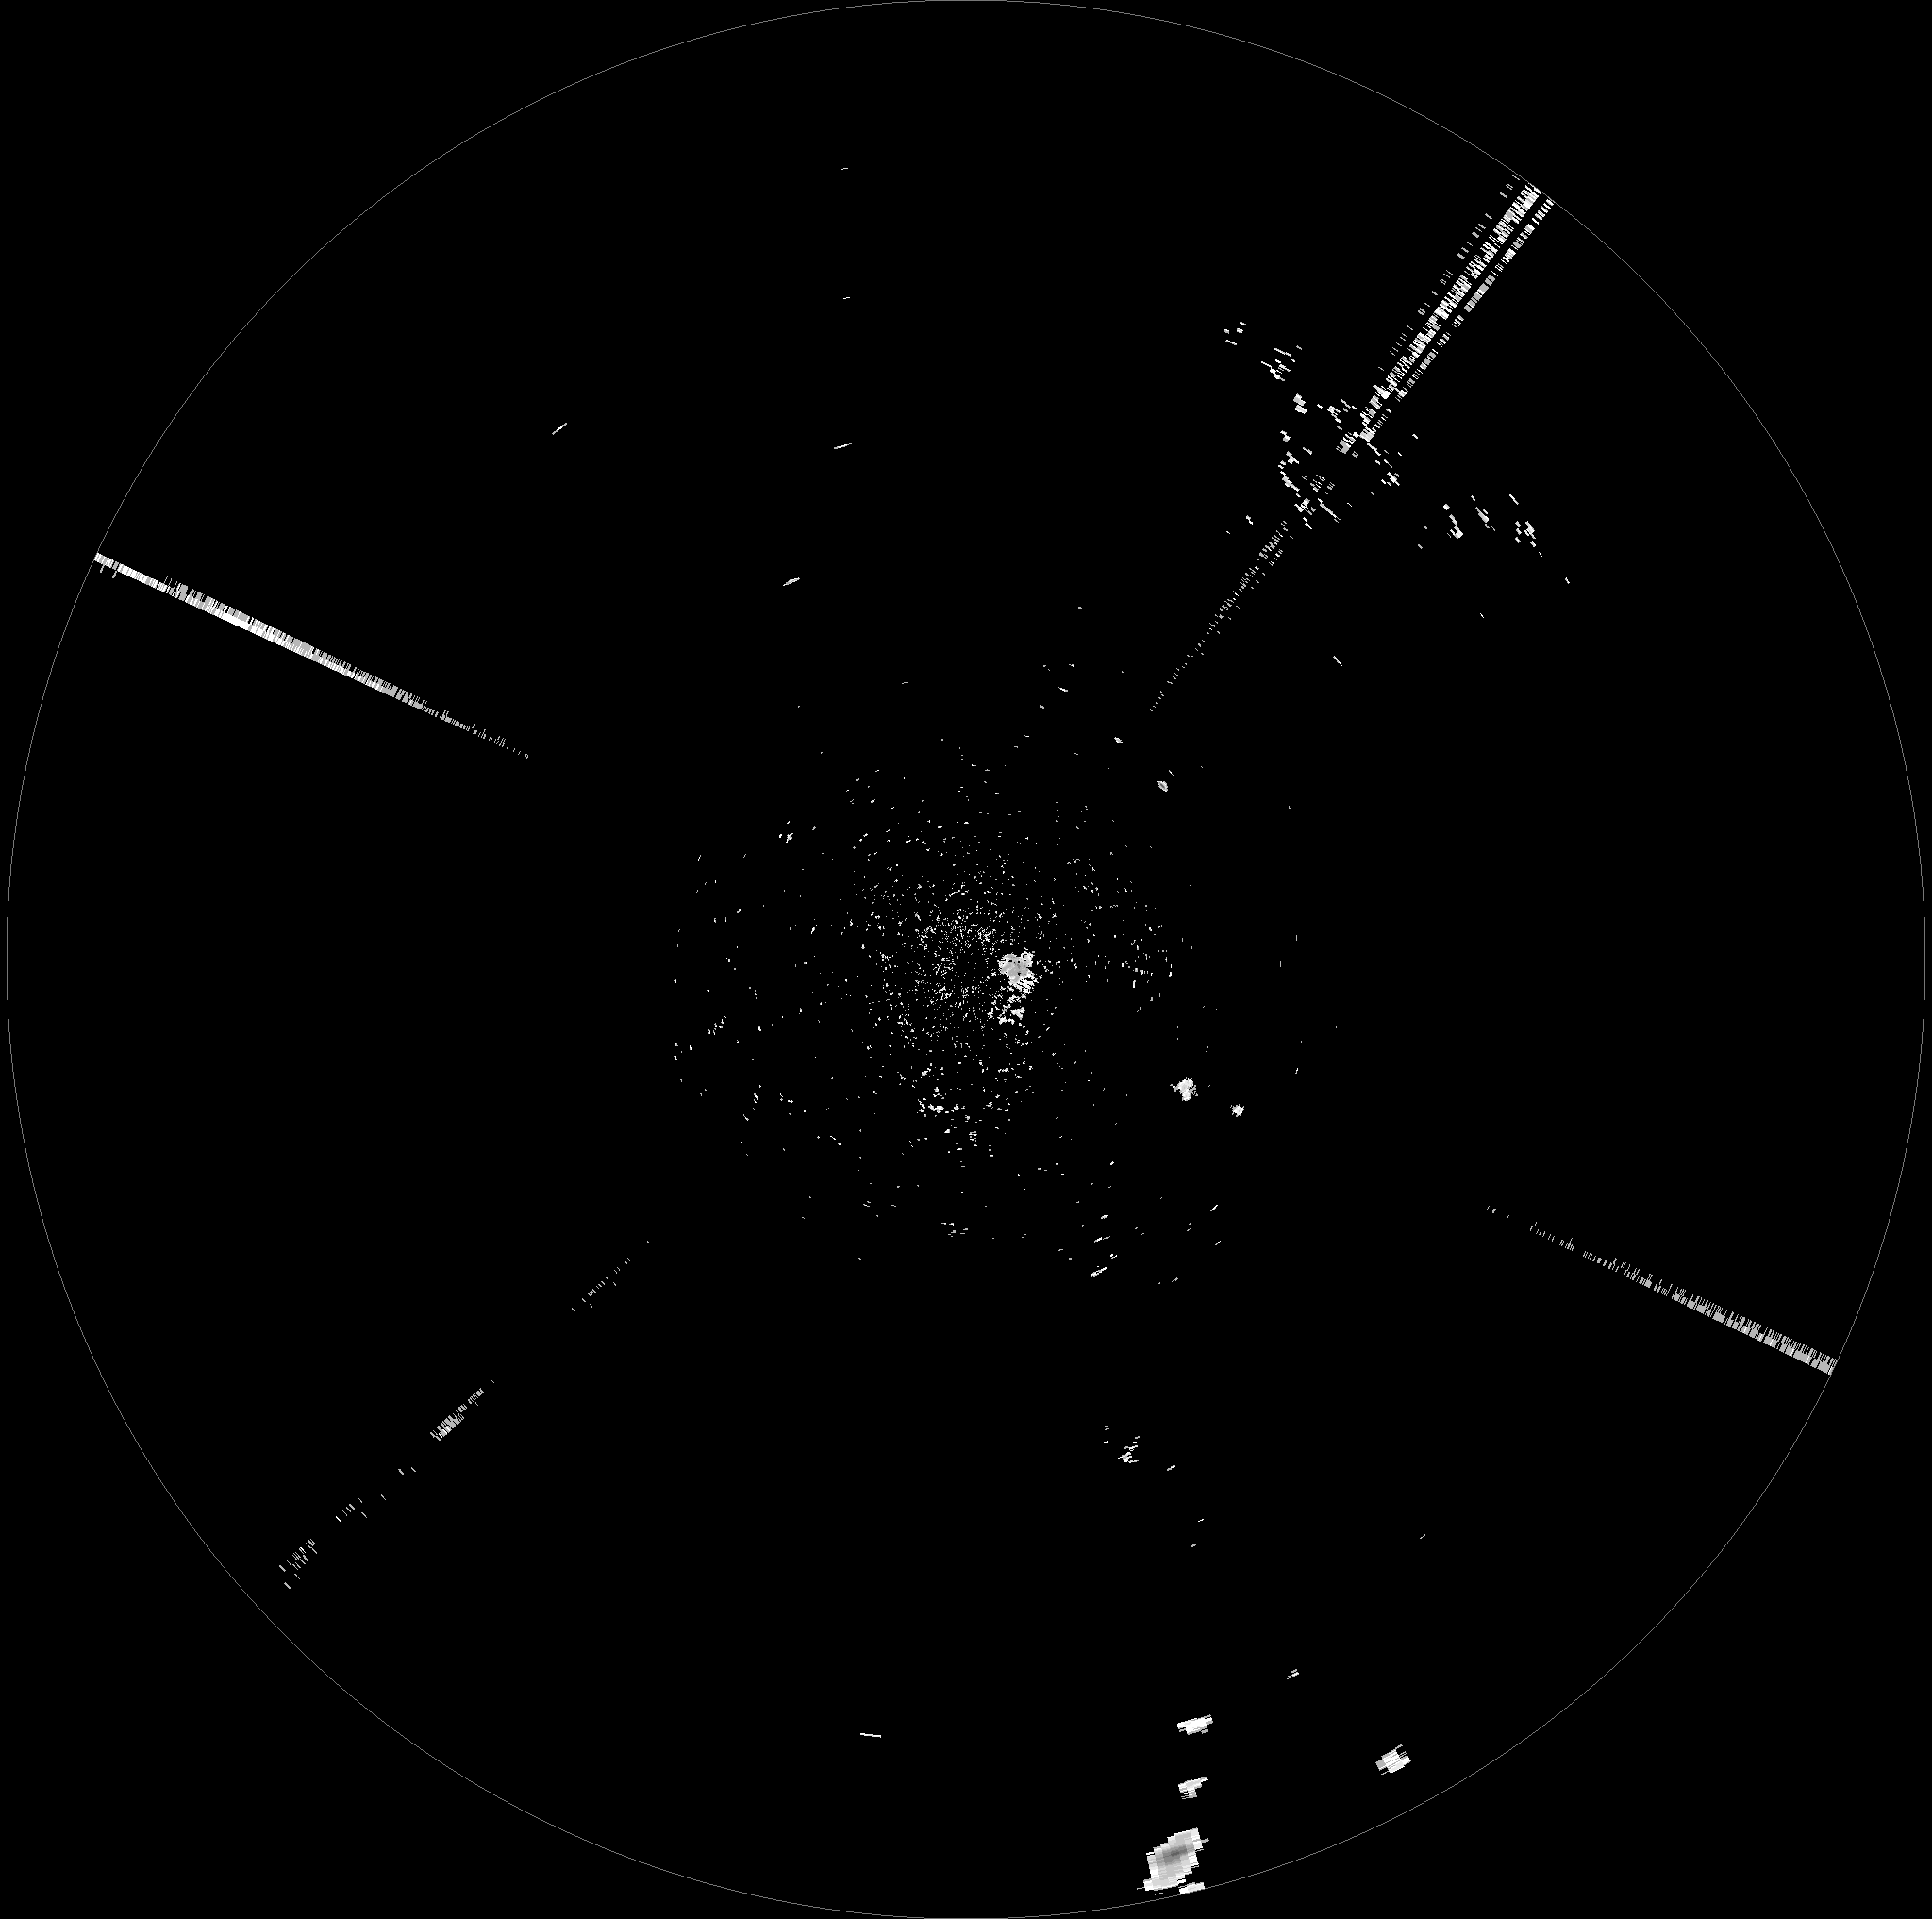
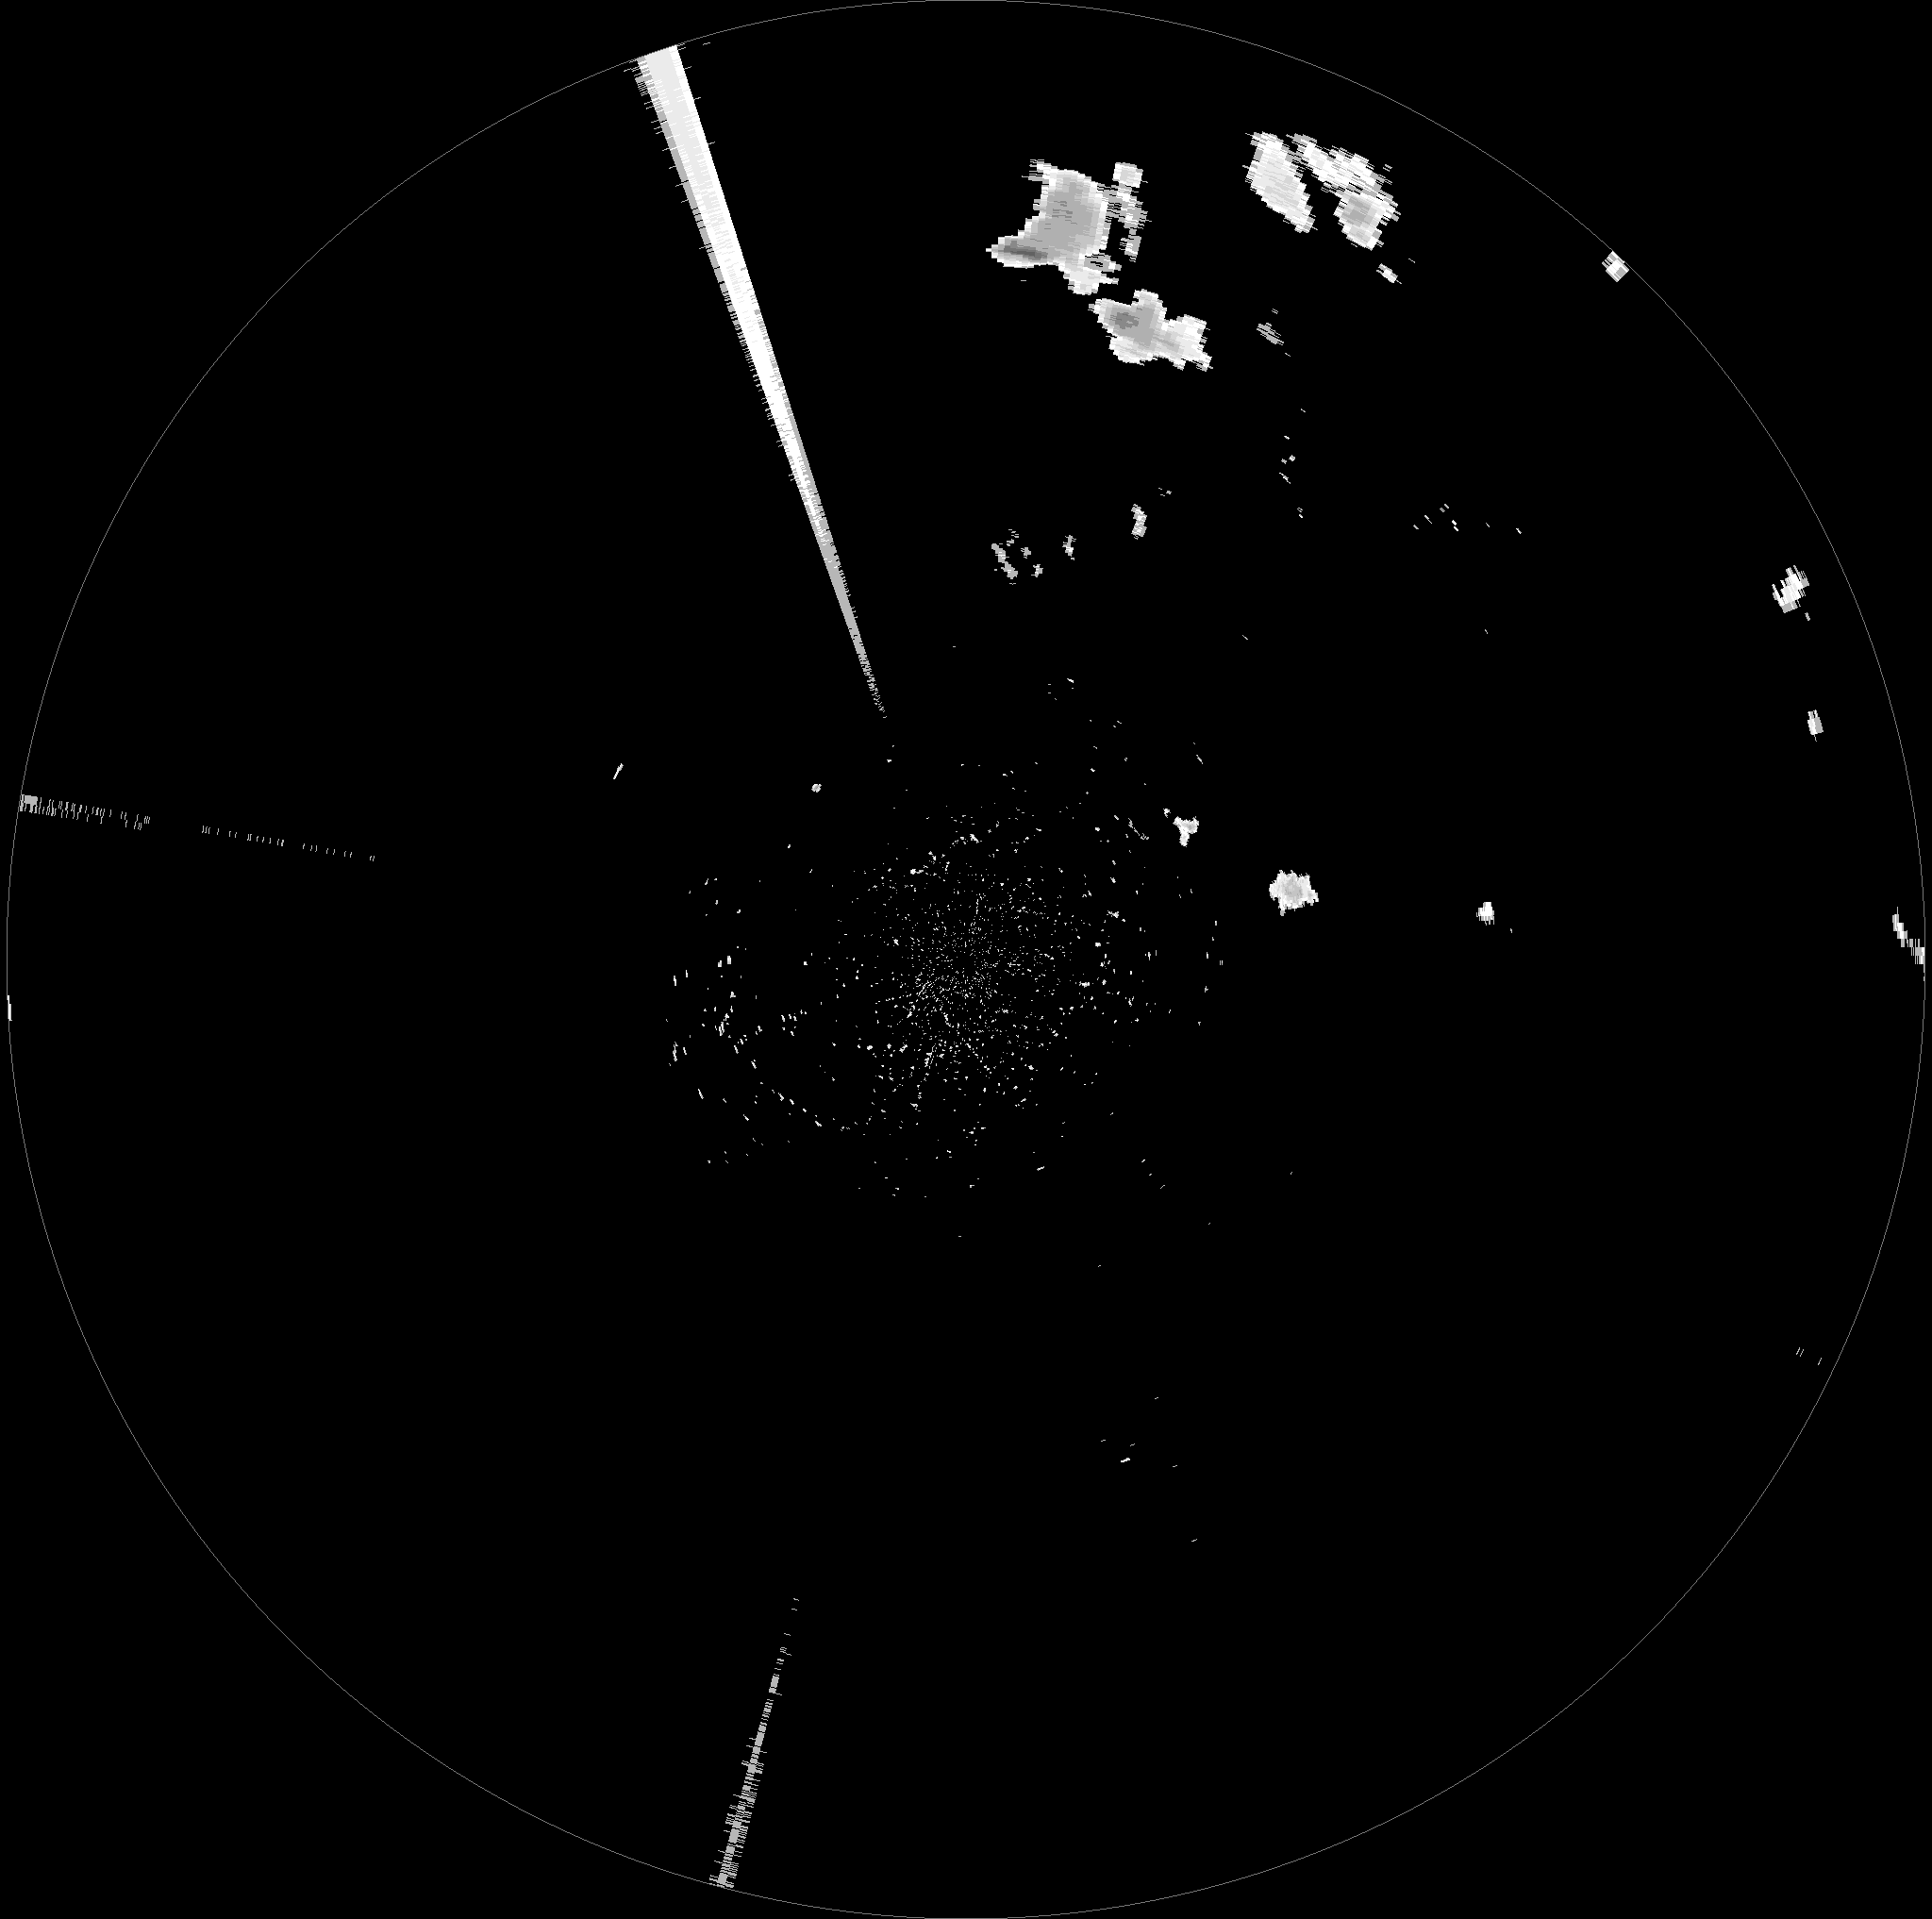
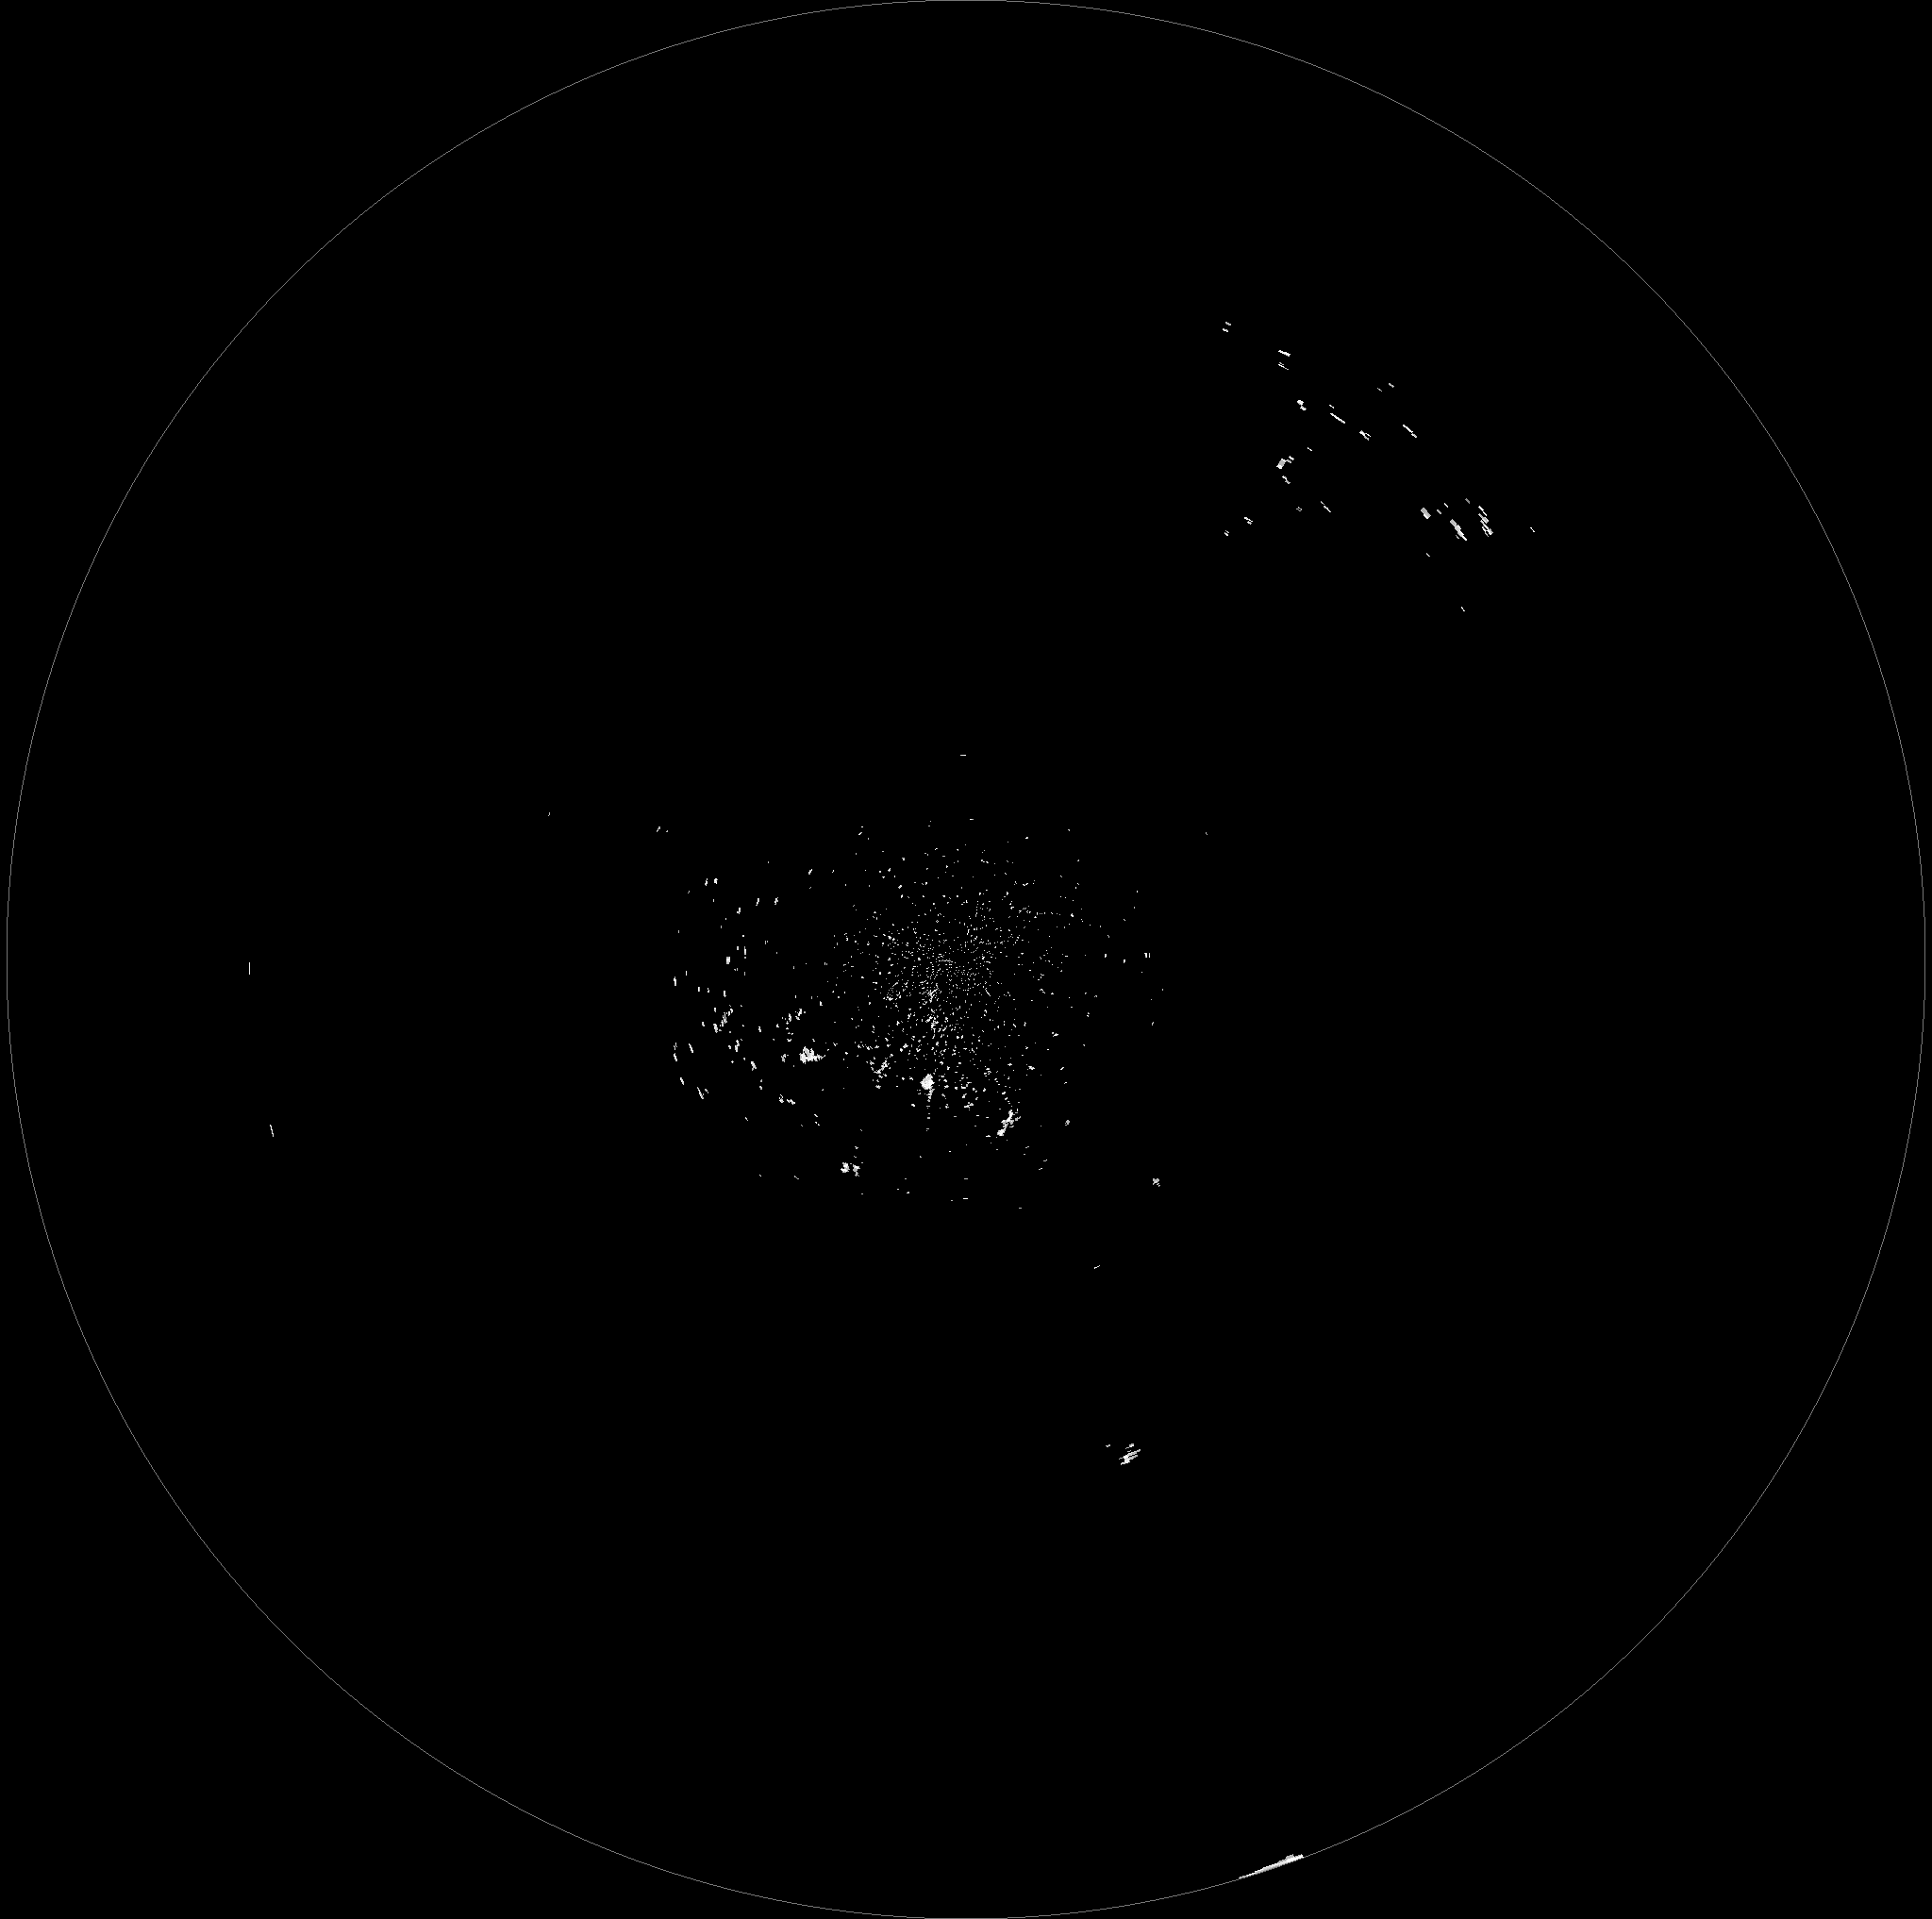
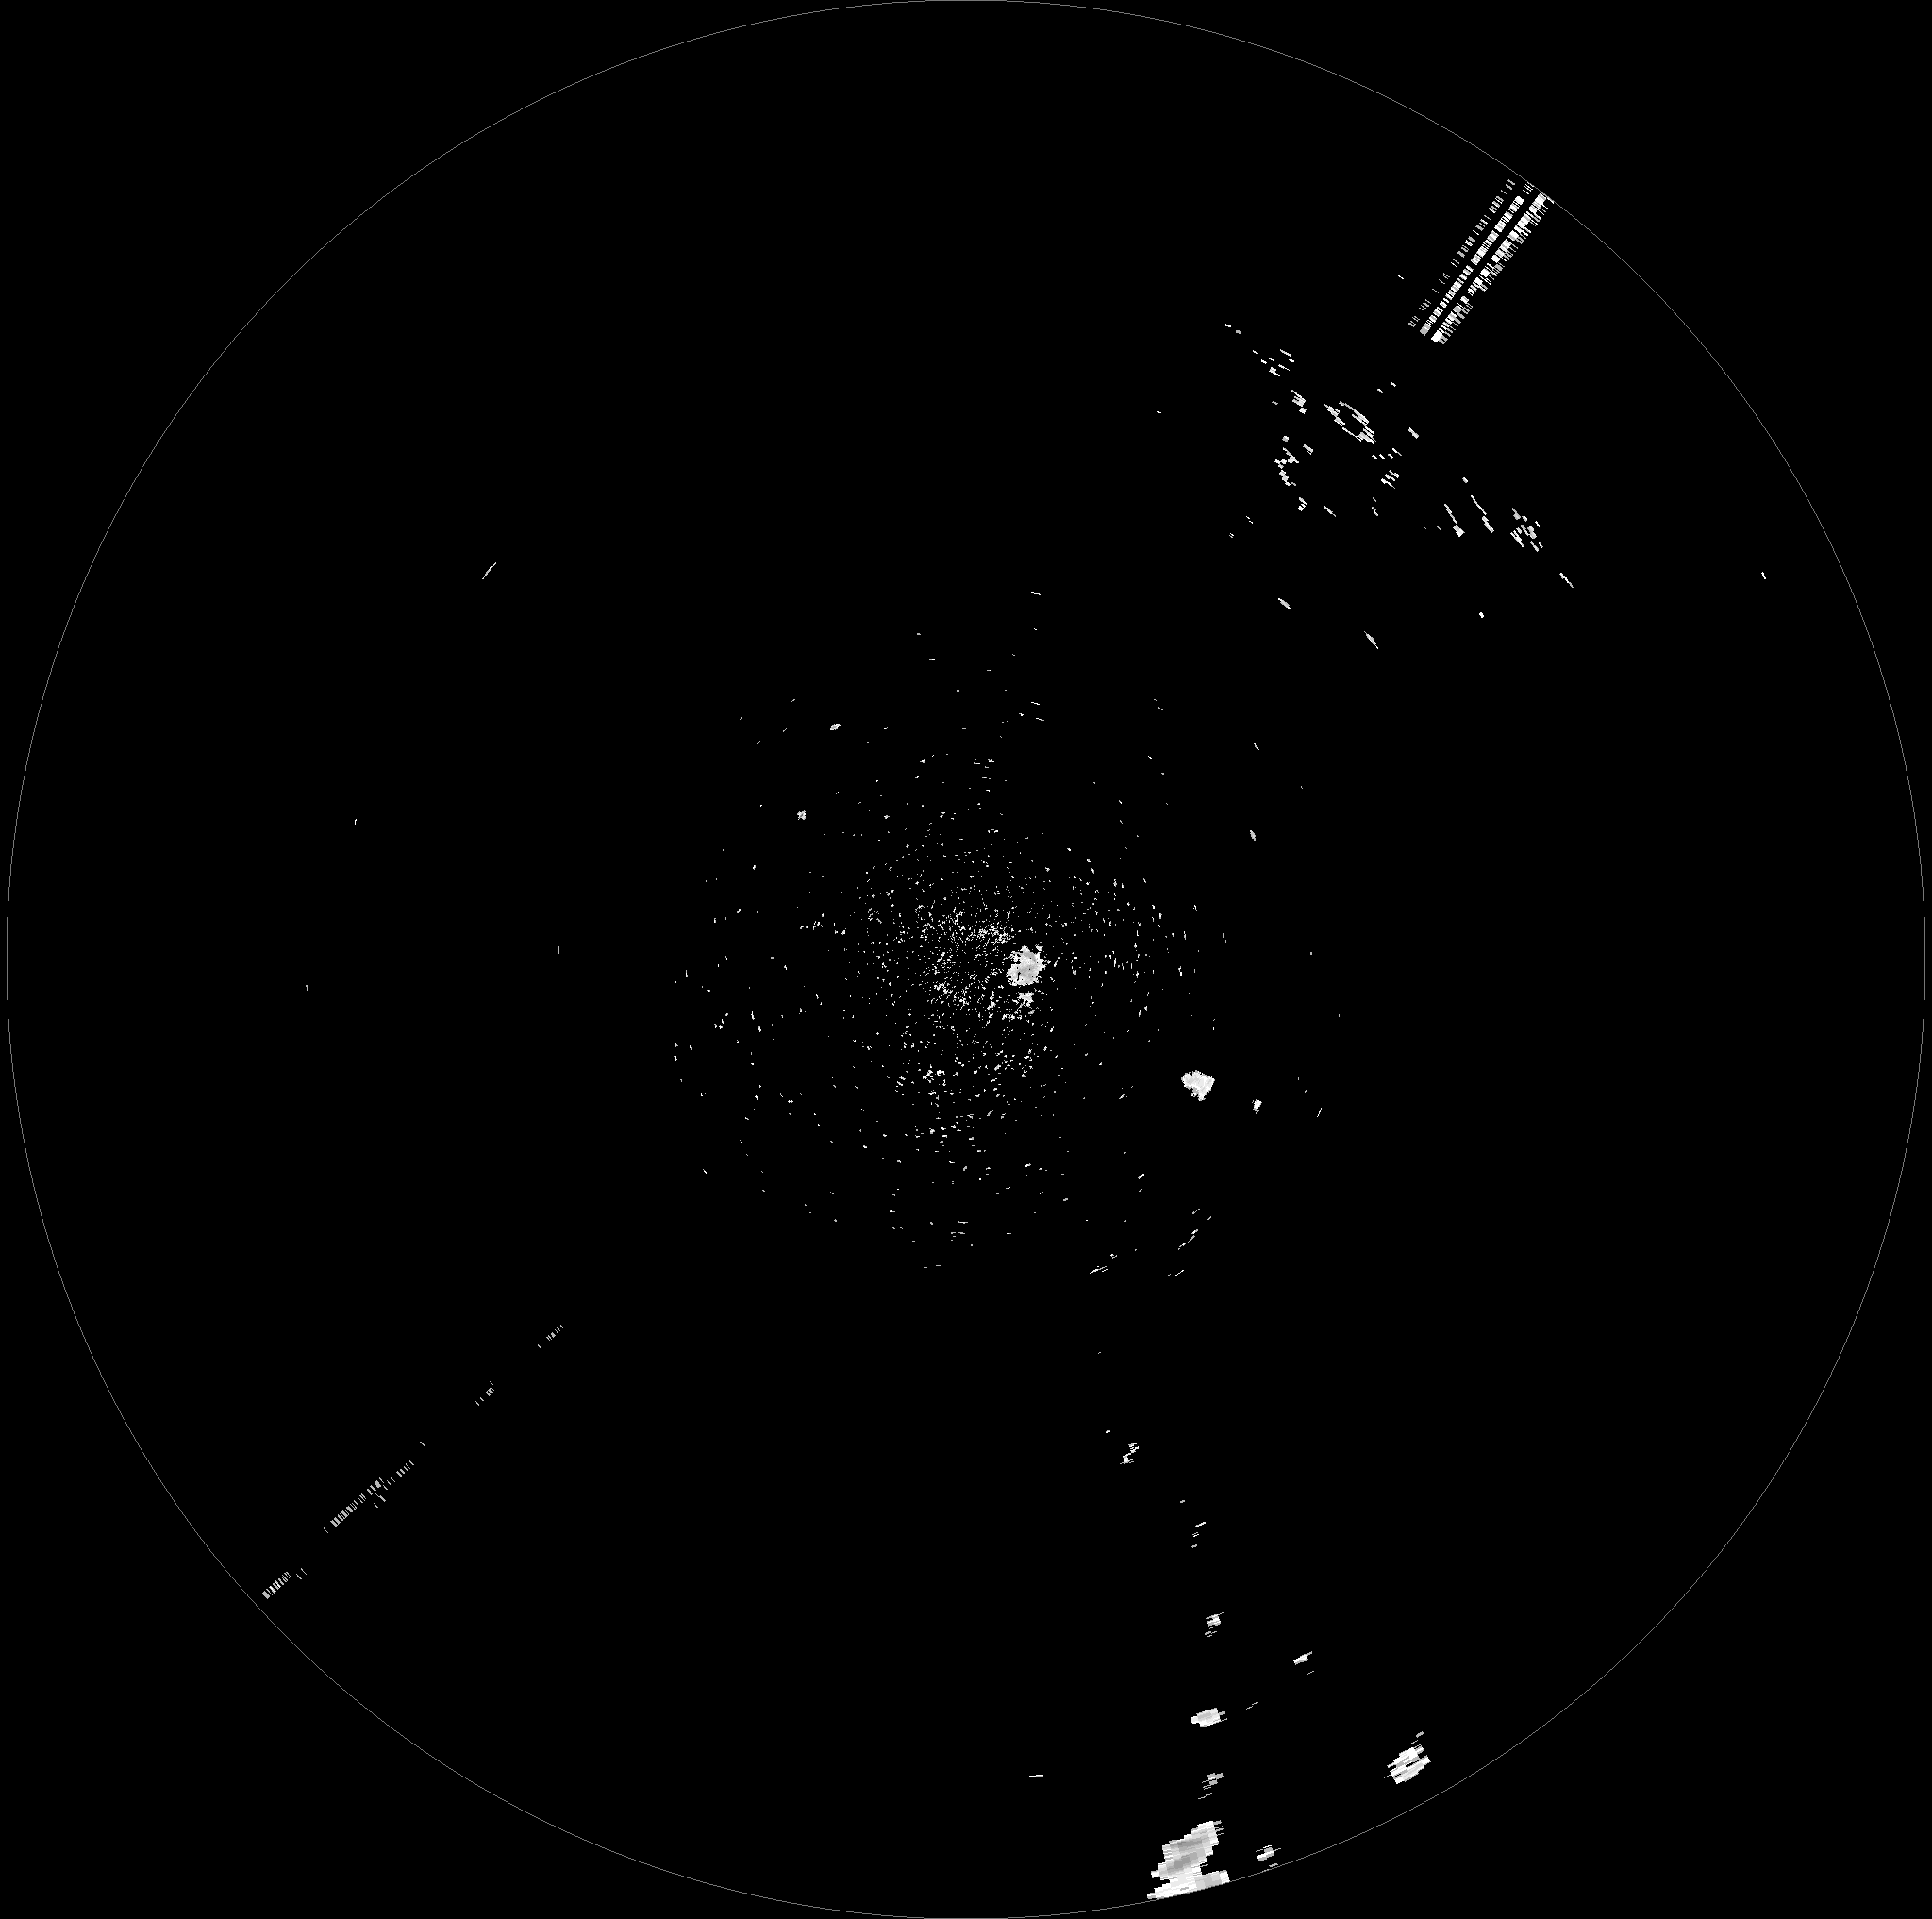
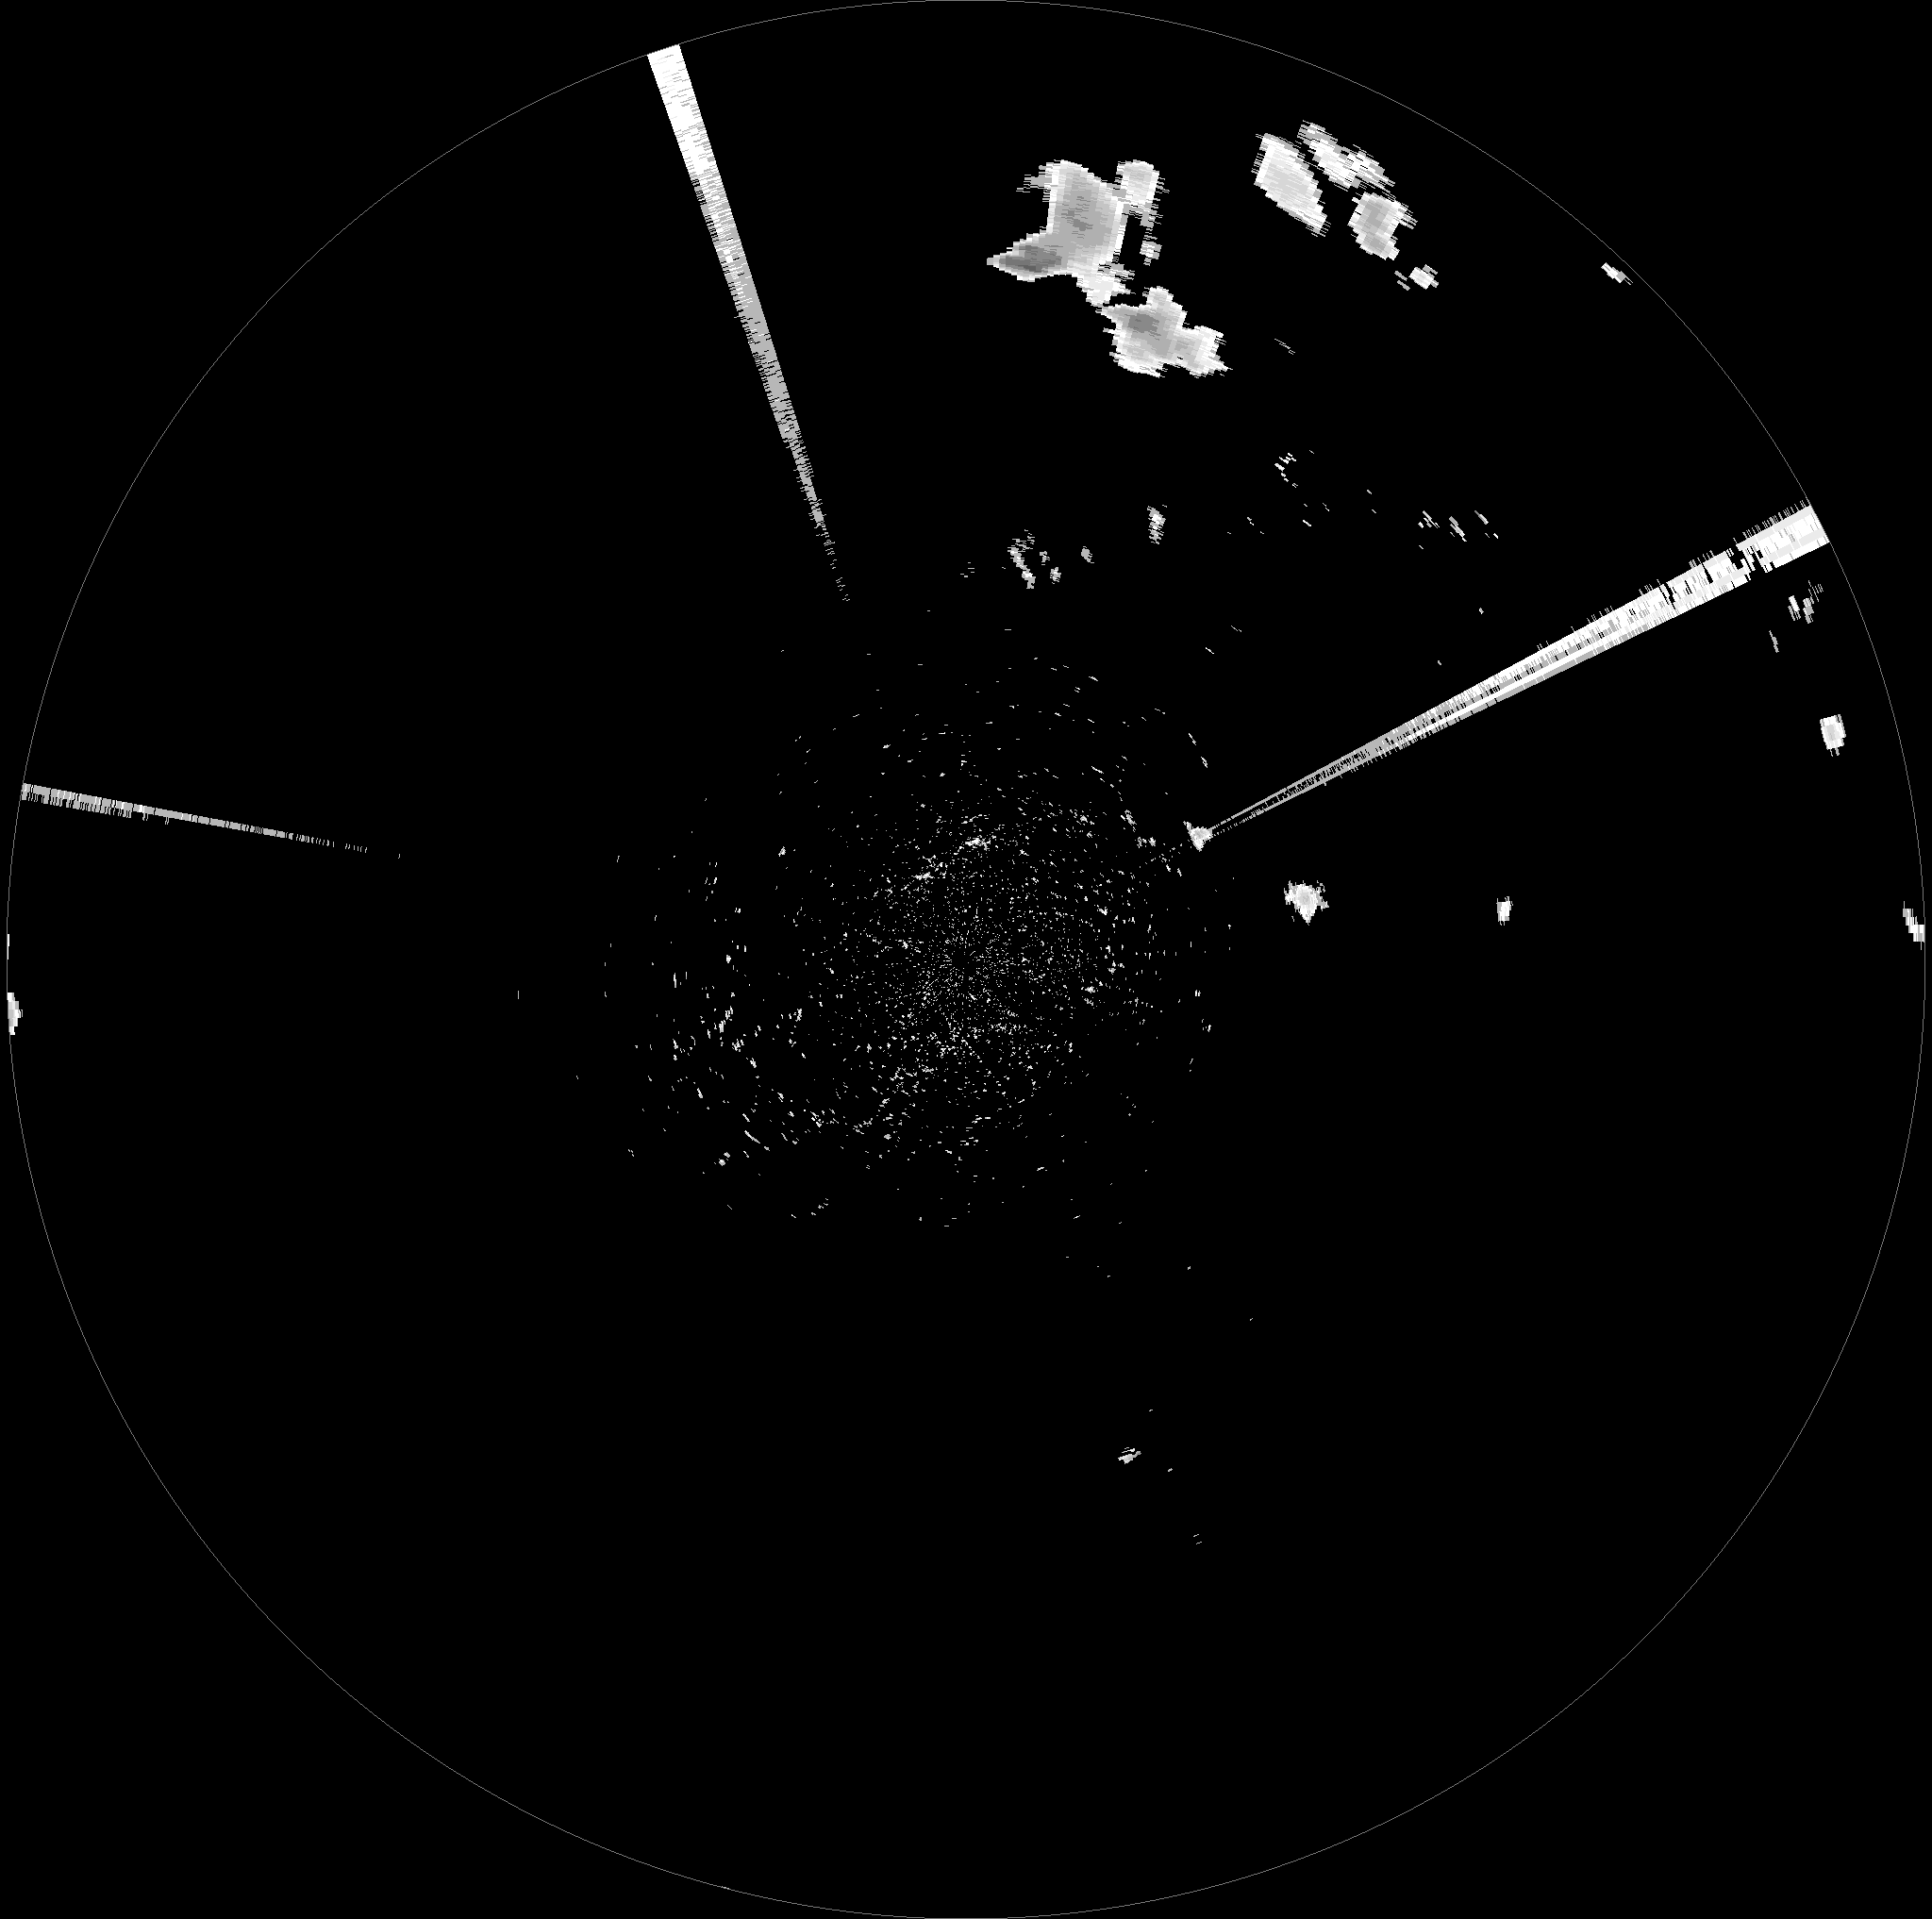
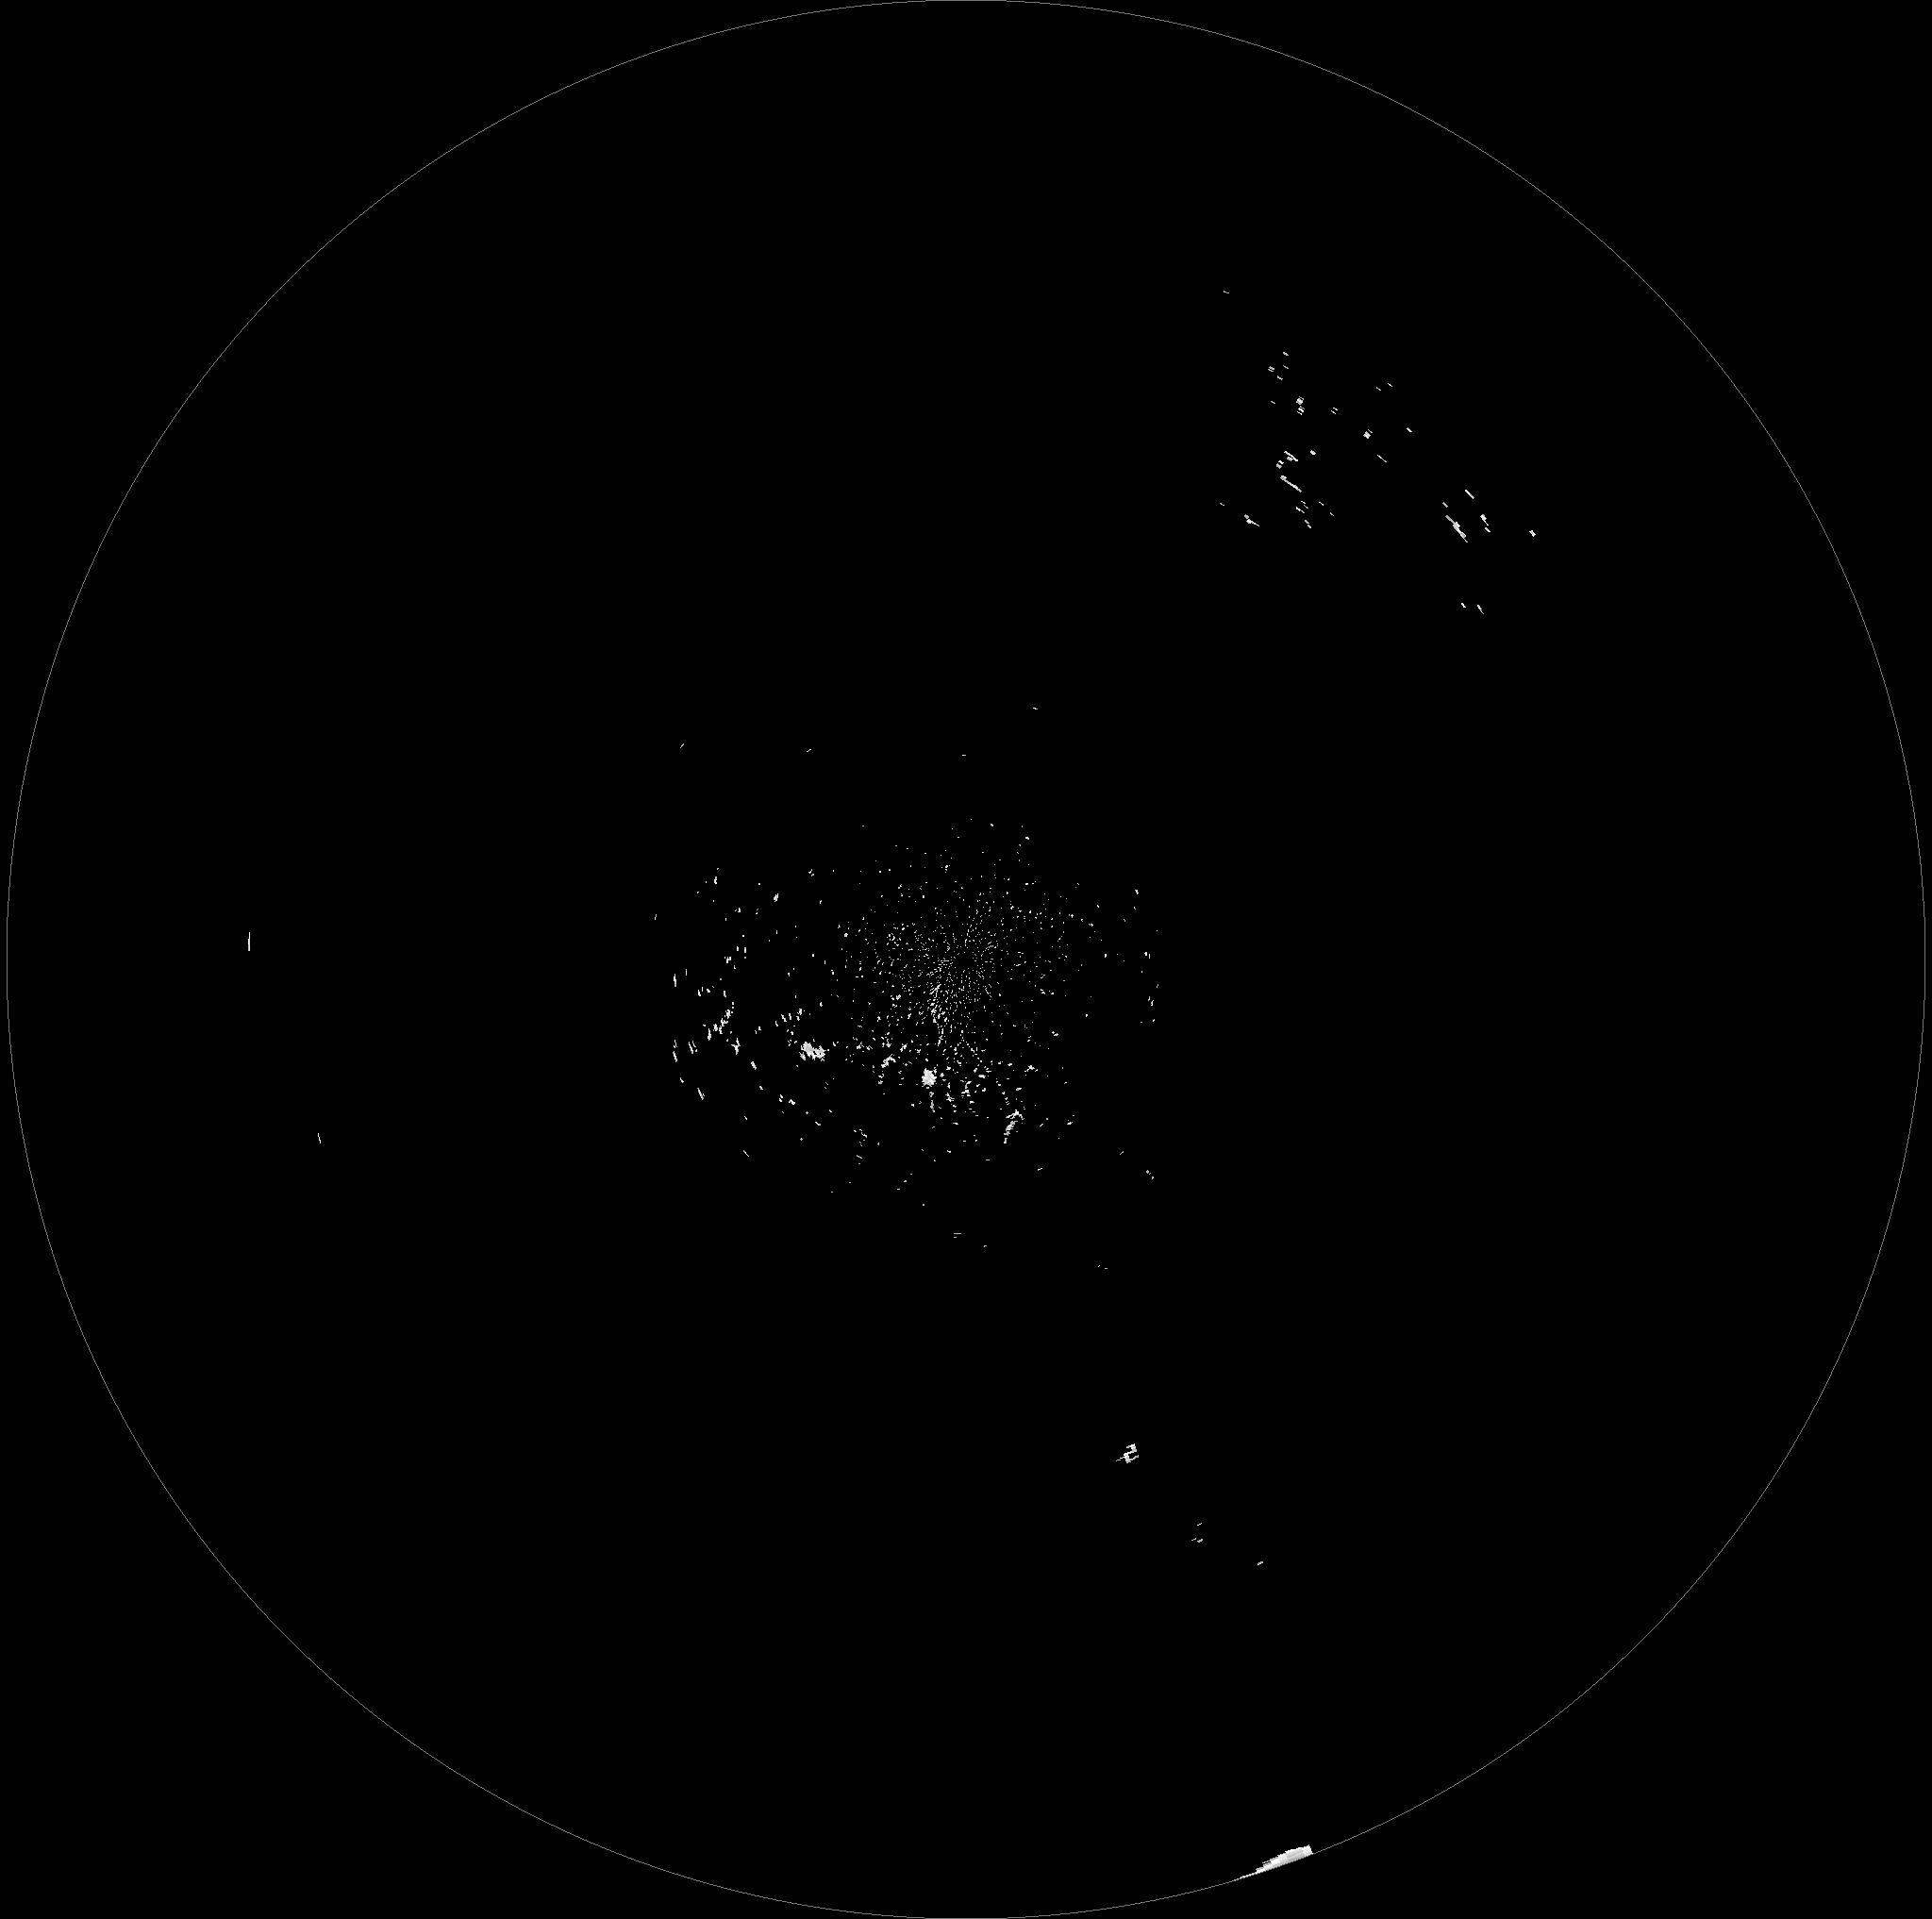
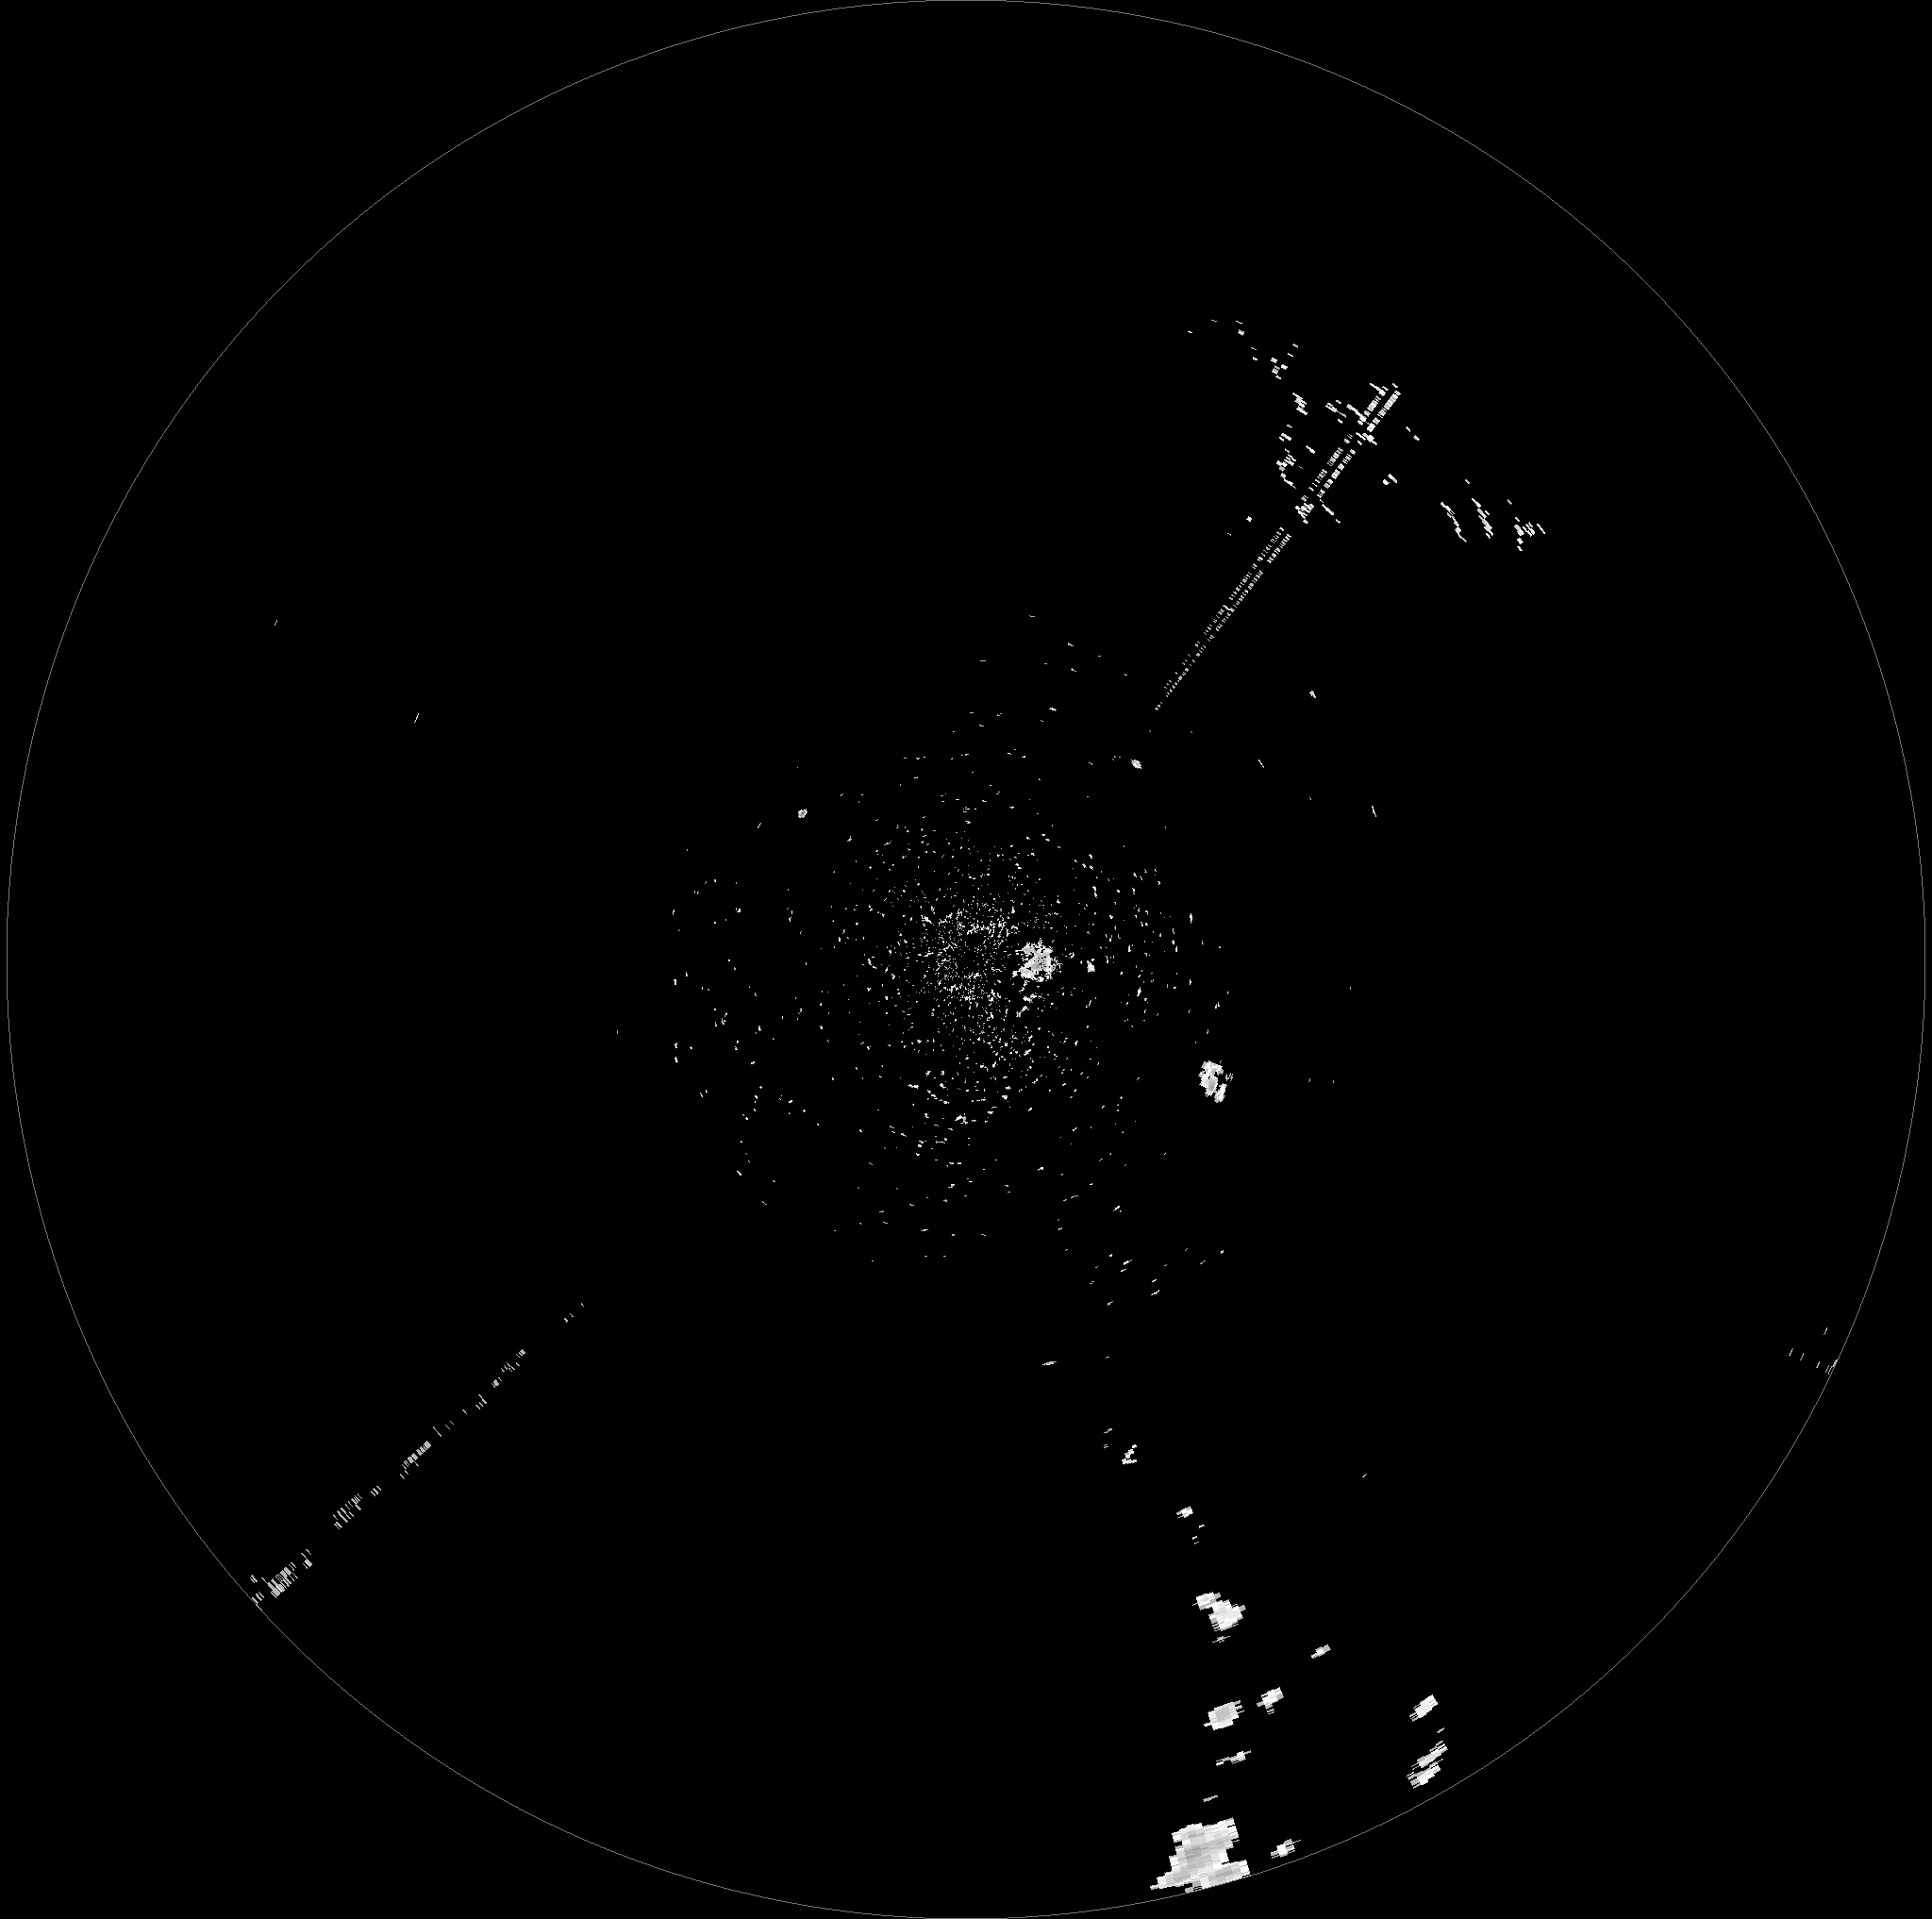
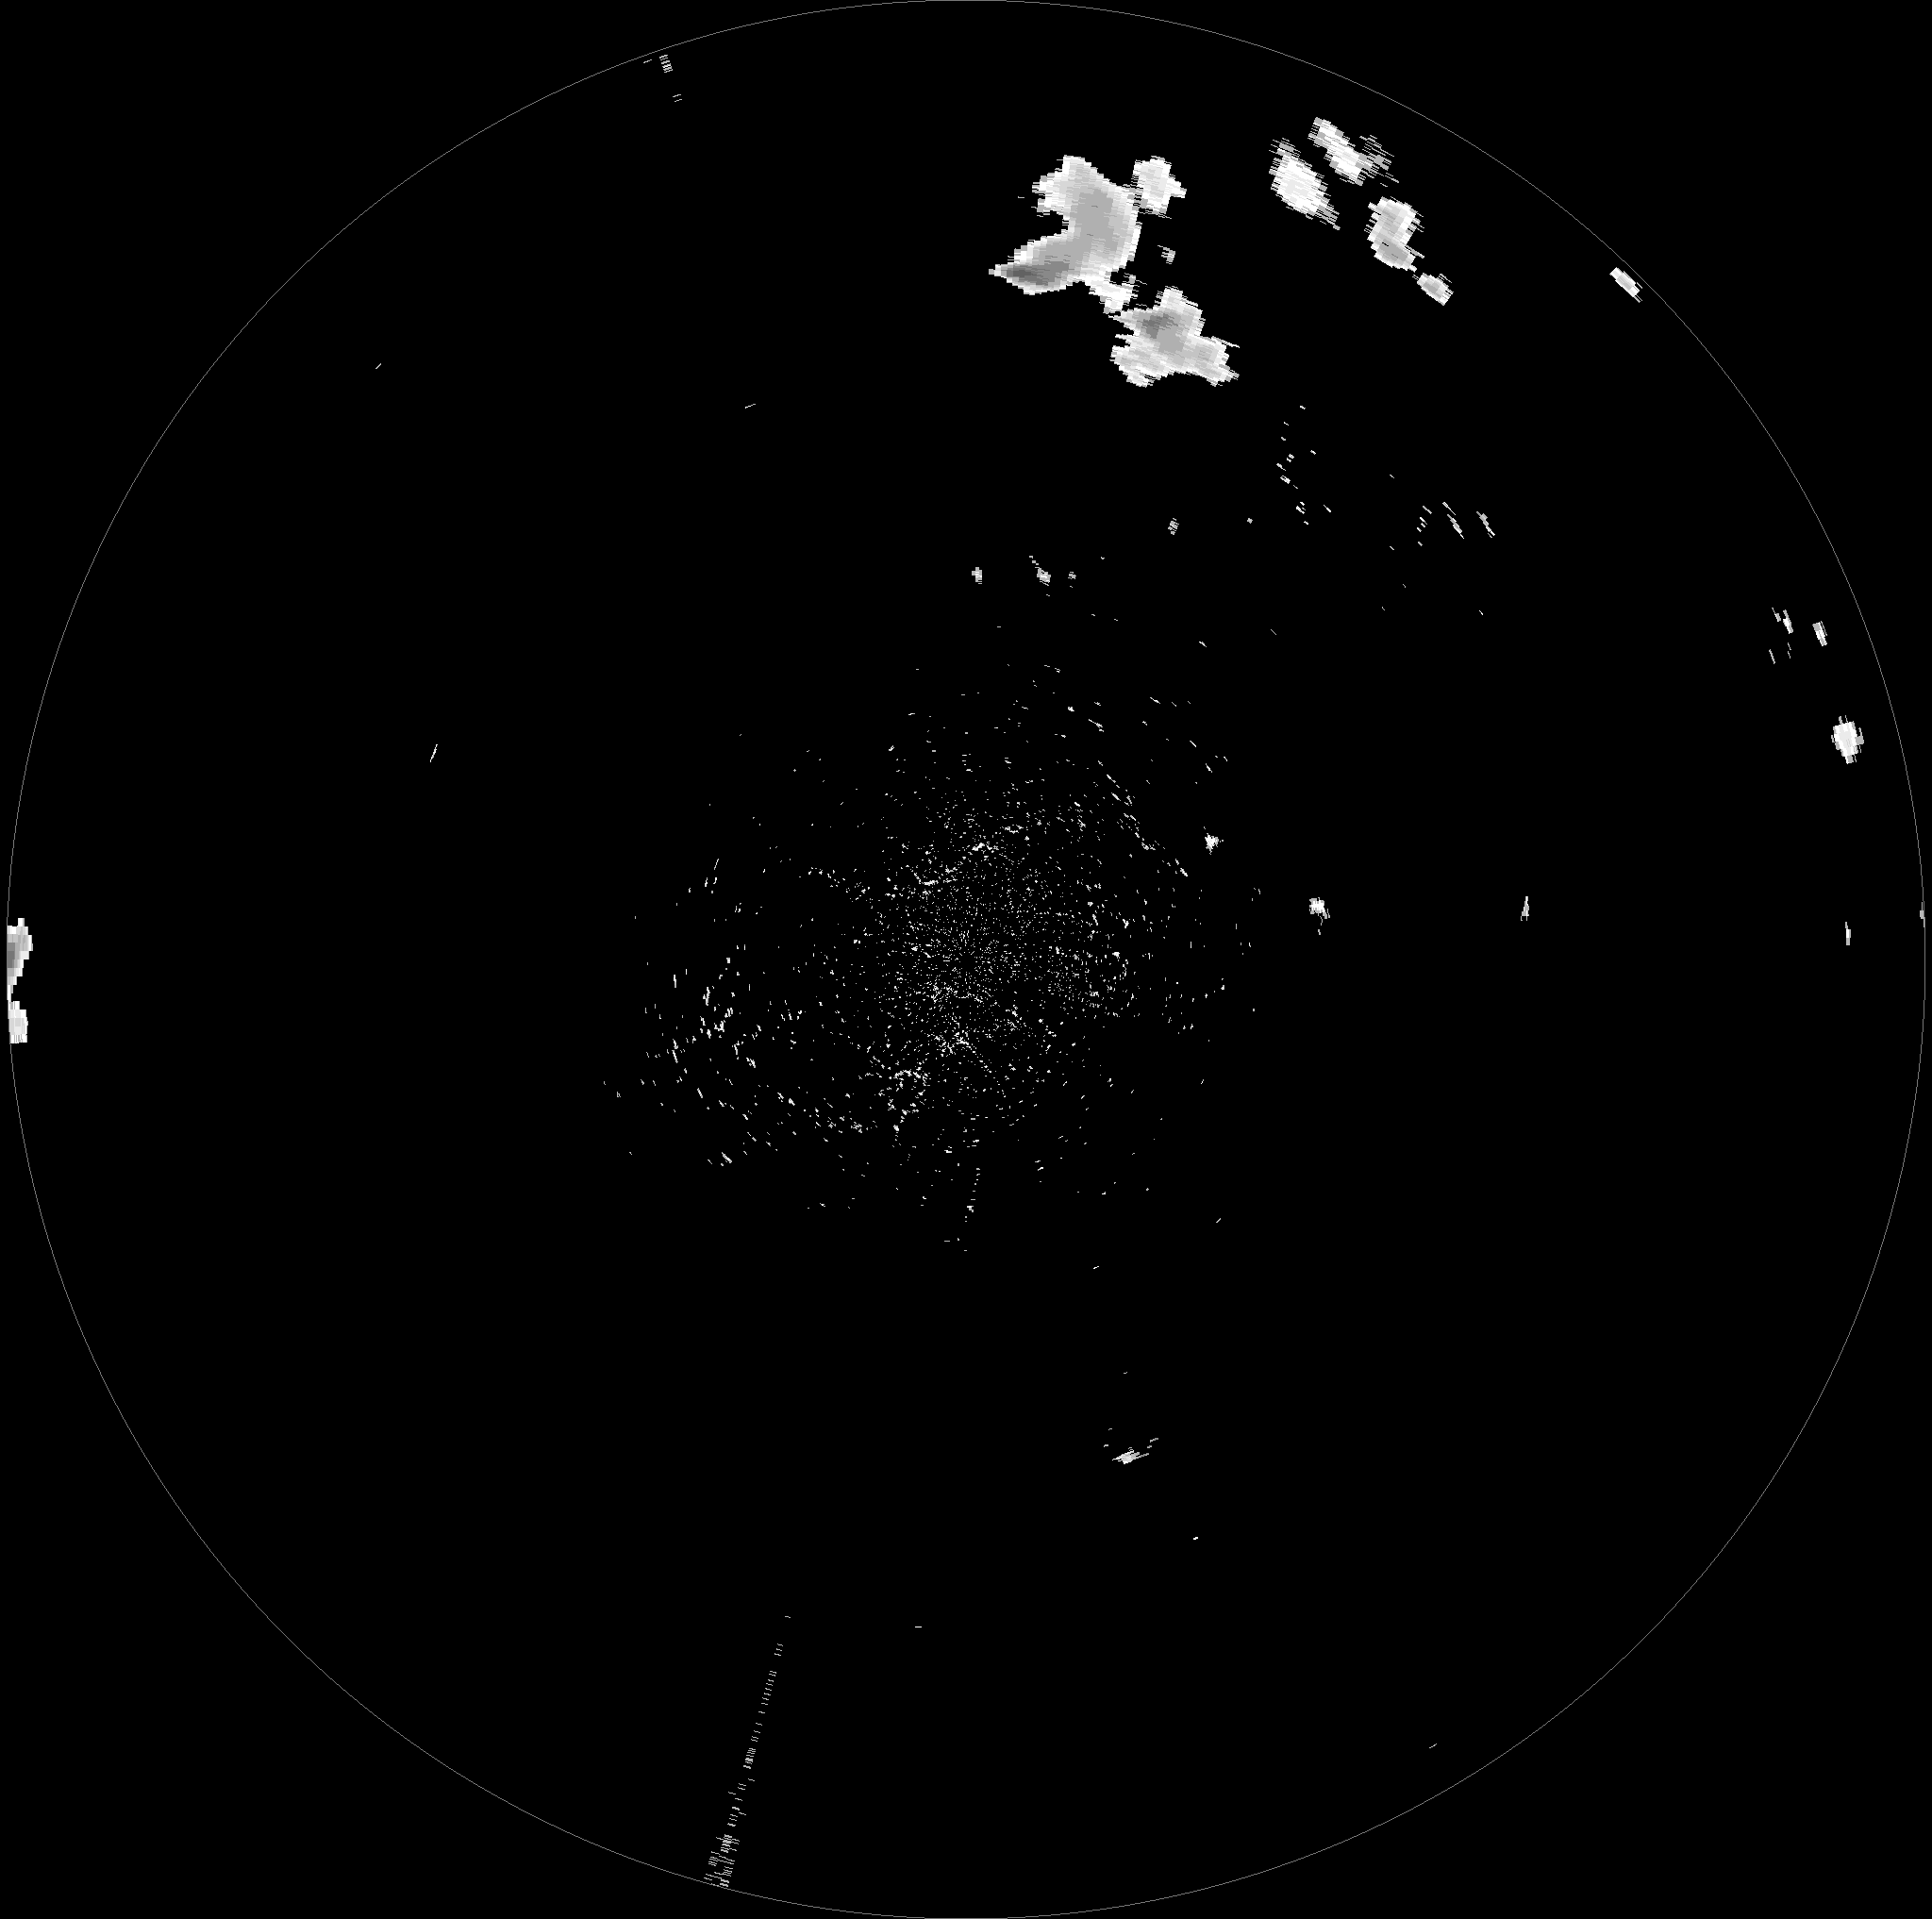
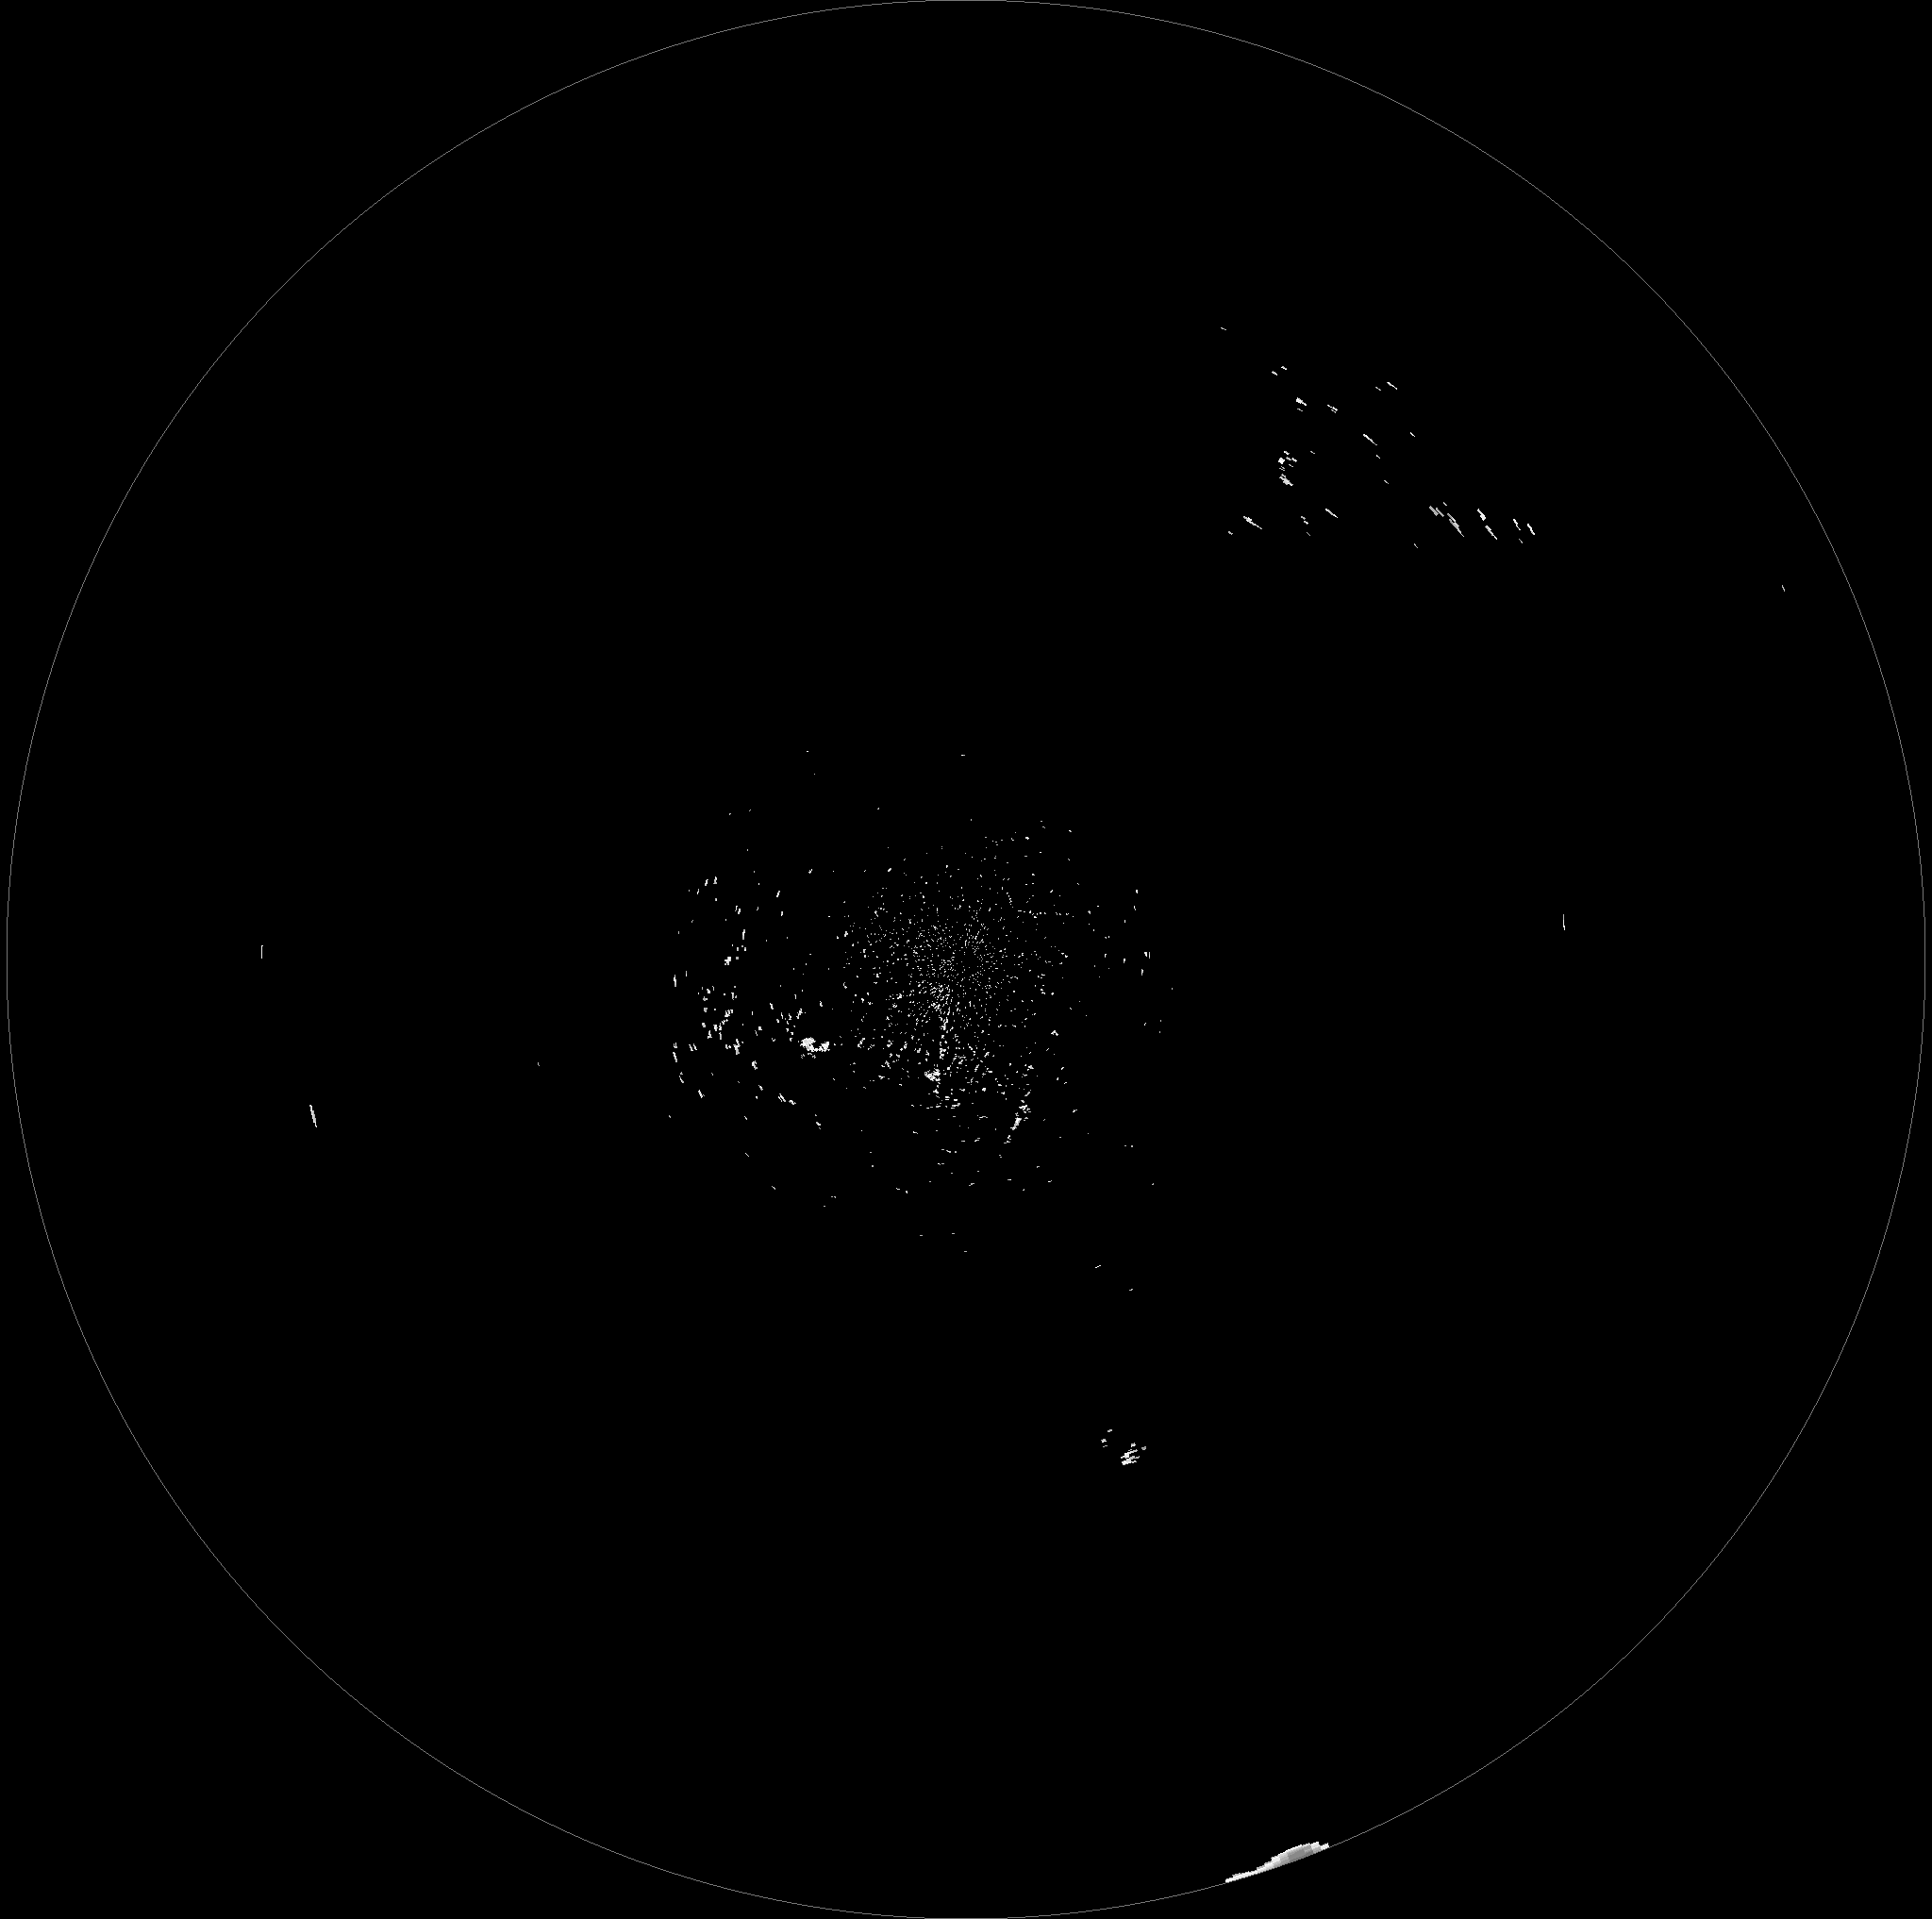

In [102]:
TITLES = ['TARGET', 'MODEL 1', 'MODEL 2']
DATA = np.array([data, data2, data3])

fig = px.imshow(DATA, binary_string=True, animation_frame=1, facet_col=0)

for idx, annotation in enumerate(fig.layout.annotations):
    annotation.text = TITLES[idx]

fig.show()